In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Attention(nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()
        self.hidden_dim = hidden_dim

        self.W1 = nn.Linear(self.hidden_dim, self.hidden_dim, bias=False)
        self.W2 = nn.Linear(self.hidden_dim, self.hidden_dim, bias=False)
        self.V = nn.Linear(self.hidden_dim, 1, bias=False)
        self.tanh = nn.Tanh()

        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight.data)

    def forward(self, enc_outputs, dec_output, mask):
        w1_e = self.W1(enc_outputs)
        w2_d = self.W2(dec_output)
        tanh_output = self.tanh(w1_e + w2_d)
        v_dot_tanh = self.V(tanh_output).squeeze(2)
        # masking
        v_dot_tanh += mask
        attention_weights = F.softmax(v_dot_tanh, dim=1)
        return attention_weights

class Encoder(nn.Module):
    def __init__(self, hidden_dim, input_dim=2):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.input_dim = input_dim

        self.cell = nn.GRU(self.input_dim, self.hidden_dim, 1, batch_first=True)

    def forward(self, input):
        enc_output, enc_hidden_state = self.cell(input)
        return enc_output, enc_hidden_state

class Decoder(nn.Module):
    def __init__(self, hidden_dim, input_dim=2):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.input_dim = input_dim

        self.cell = nn.GRU(self.input_dim, self.hidden_dim, 1, batch_first=True)
        self.attention_layer = Attention(self.hidden_dim)

    def forward(self, input, enc_output, hidden_state, pointer, mask):
        idx = pointer.repeat(1, 2).unsqueeze(1)
        dec_output, dec_hidden = self.cell(input.gather(1, idx), hidden_state)
        attention_weights = self.attention_layer(enc_output, dec_output, mask)

        return attention_weights, dec_hidden

class PtrNet(nn.Module):
    def __init__(self, hidden_dim, input_dim=2, deterministic=False):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.input_dim = input_dim
        self.deterministic = deterministic

        self.encoder = Encoder(self.hidden_dim)
        self.decoder = Decoder(self.hidden_dim)

    def forward(self, input):
        batch_size = input.size(0)
        seq_len = input.size(1)
        if input.is_cuda:
            probs = torch.zeros(batch_size, 1, device=torch.device('cuda'))
            pointers = torch.zeros(batch_size, 1, dtype=torch.long, device=torch.device('cuda'))
            mask = torch.zeros(batch_size, seq_len, dtype=torch.float, device=torch.device('cuda'))

            pointer = torch.zeros(batch_size, 1, dtype=torch.long, device=torch.device('cuda'))
        else:
            probs = torch.ones(batch_size, 1)
            pointers = torch.zeros(batch_size, 1)
            mask = torch.zeros(batch_size, seq_len)

            pointer = torch.zeros(batch_size, 1, dtype=torch.long)

        # Encoding
        enc_output, enc_hidden_state = self.encoder(input)

        mask = self.update_mask(mask, pointer)

        # Decoding
        for i in range(seq_len - 1):
            if i == 0:
                attention_weights, dec_hidden_state = self.decoder(input, enc_output, enc_hidden_state, pointer, mask)
            else:
                attention_weights, dec_hidden_state = self.decoder(input, enc_output, dec_hidden_state, pointer, mask)

            if self.deterministic:
                prob, pointer = torch.max(attention_weights, dim=1)
                mask = self.update_mask(mask, pointer)
                prob = prob.unsqueeze(1)
                pointer = pointer.unsqueeze(1)
            else:
                pointer = attention_weights.multinomial(1, replacement=True)
                prob = torch.gather(attention_weights, 1, pointer)
                mask = self.update_mask(mask, pointer)

            probs += torch.log(prob)
            pointers = torch.cat([pointers, pointer], dim=1)

        return probs, pointers

    def update_mask(self, mask, pointer):
        for batch, i in enumerate(pointer):
            mask[batch, i] = float('-inf')
        return mask

    def get_length(self, input, solution):
        # Convert solution to dtype int64
        solution = solution.long()

        current_coords = torch.gather(input, 1, solution.unsqueeze(-1).expand(-1, -1, 2))
        next_coords = torch.roll(current_coords, -1, dims=1)
        distances = torch.sqrt(torch.sum((current_coords - next_coords) ** 2, dim=-1))
        tour_length = torch.sum(distances, dim=1)

        return tour_length.unsqueeze(1)

class Critic(nn.Module):
    def __init__(self, hidden_dim, input_dim=2):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.input_dim = input_dim

        self.encoder = Encoder(self.hidden_dim)
        self.decoder_1 = nn.Linear(self.hidden_dim, self.hidden_dim)
        self.decoder_2 = nn.Linear(self.hidden_dim, 1)
        self.relu = nn.ReLU()

        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight.data)

    def forward(self, input):
        enc_output, enc_hidden_state = self.encoder(input)
        dec_hidden_state = self.decoder_1(enc_hidden_state)
        dec_hidden_state = self.relu(dec_hidden_state)
        dec_output = self.decoder_2(dec_hidden_state)
        return dec_output.squeeze(0)


In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm

# Define your PtrNet and Critic
# ...

# Define your Prize-Collecting Environment
class PCTSPEnvironment:
    def __init__(self, num_cities, max_reward, max_budget):
        self.num_cities = num_cities
        self.max_reward = max_reward
        self.max_budget = max_budget
        self.reset()

    def reset(self):
        self.city_coordinates = torch.rand((self.num_cities, 2))
        self.city_rewards = torch.randint(1, self.max_reward, (self.num_cities,))
        self.budget = torch.randint(1, self.max_budget, (1,)).item()
        self.current_city = 0  # Starting from city 0
        self.visited_cities = set([0])

        # Print random data
        print("Random Data for Current Episode:")
        print("City Coordinates:\n", self.city_coordinates)
        print("City Rewards:\n", self.city_rewards)
        print("Budget:\n", self.budget)

    def get_state(self):
        return self.city_coordinates

    def step(self, action):
        next_city = action.item()
        reward = 0

        # Check if the next city is within budget and not visited
        if next_city not in self.visited_cities and reward + self.city_rewards[next_city] <= self.budget:
            reward += self.city_rewards[next_city]
            self.budget -= self.city_rewards[next_city]
            self.visited_cities.add(next_city)
            self.current_city = next_city

        done = len(self.visited_cities) == self.num_cities

        return self.get_state(), reward, done

# Training Loop
num_cities = 100
max_reward = 100
max_budget = 200
hidden_dim = 256
lr = 0.0001

env = PCTSPEnvironment(num_cities, max_reward, max_budget)
dataset = TensorDataset(env.get_state().unsqueeze(0))
dataloader = DataLoader(dataset, batch_size=64)

model = PtrNet(hidden_dim=hidden_dim)
critic = Critic(hidden_dim=hidden_dim)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
optimizer_critic = torch.optim.Adam(critic.parameters(), lr=lr)

print("Start training...")

for epoch in range(100):
    for i, s_i in tqdm(enumerate(dataloader)):
        s_i = s_i[0]

        # Sample a tour from PtrNet
        p, pi = model(s_i)
        L = model.get_length(s_i, pi)
        b = critic(s_i)

        with torch.no_grad():
            advantage = L - b

        # Reward function: maximize collected reward while minimizing tour length
        reward = torch.mean(advantage * p)

        optimizer.zero_grad()
        loss = -reward  # We use negative reward as PtrNet is trained for minimization
        loss.backward()
        optimizer.step()

        # Update Critic
        optimizer_critic.zero_grad()
        loss_critic = F.mse_loss(L, b)
        loss_critic.backward()
        optimizer_critic.step()

        if (i + 1) % 1 == 0:
          print(f"Epoch: {epoch + 1}, Step: {i + 1}, Reward: {reward.item()}")


print("Training completed.")


Random Data for Current Episode:
City Coordinates:
 tensor([[0.4574, 0.2086],
        [0.6789, 0.9455],
        [0.4636, 0.6474],
        [0.5482, 0.0587],
        [0.3315, 0.8199],
        [0.5934, 0.5720],
        [0.2615, 0.9743],
        [0.1065, 0.9124],
        [0.1524, 0.3828],
        [0.0176, 0.2618],
        [0.6242, 0.0218],
        [0.2105, 0.5981],
        [0.1498, 0.0191],
        [0.0748, 0.2097],
        [0.0032, 0.6530],
        [0.1734, 0.1974],
        [0.7284, 0.6314],
        [0.8500, 0.9095],
        [0.7520, 0.6395],
        [0.7614, 0.3922],
        [0.7368, 0.0222],
        [0.0310, 0.8746],
        [0.7065, 0.5769],
        [0.4163, 0.8544],
        [0.1420, 0.5894],
        [0.4599, 0.2545],
        [0.8786, 0.6419],
        [0.0033, 0.0704],
        [0.5313, 0.4533],
        [0.5161, 0.7146],
        [0.4837, 0.7757],
        [0.8769, 0.1417],
        [0.8971, 0.5445],
        [0.6681, 0.6105],
        [0.5485, 0.9297],
        [0.3598, 0.3242],
        [0.0

1it [00:00,  1.79it/s]


Epoch: 1, Step: 1, Reward: -19662.306640625


1it [00:00,  1.86it/s]


Epoch: 2, Step: 1, Reward: -19073.564453125


1it [00:00,  2.23it/s]


Epoch: 3, Step: 1, Reward: -18673.013671875


1it [00:00,  1.87it/s]


Epoch: 4, Step: 1, Reward: -19629.076171875


1it [00:00,  2.19it/s]


Epoch: 5, Step: 1, Reward: -20726.62109375


1it [00:00,  1.90it/s]


Epoch: 6, Step: 1, Reward: -18581.12109375


1it [00:00,  1.05it/s]


Epoch: 7, Step: 1, Reward: -19416.986328125


1it [00:02,  2.58s/it]


Epoch: 8, Step: 1, Reward: -19541.279296875


1it [00:02,  2.46s/it]


Epoch: 9, Step: 1, Reward: -19219.36328125


1it [00:01,  1.85s/it]


Epoch: 10, Step: 1, Reward: -19051.7421875


1it [00:00,  1.37it/s]


Epoch: 11, Step: 1, Reward: -19646.955078125


1it [00:00,  1.10it/s]


Epoch: 12, Step: 1, Reward: -19221.34375


1it [00:01,  1.48s/it]


Epoch: 13, Step: 1, Reward: -19325.87890625


1it [00:00,  1.57it/s]


Epoch: 14, Step: 1, Reward: -19898.208984375


1it [00:00,  1.58it/s]


Epoch: 15, Step: 1, Reward: -18900.994140625


1it [00:00,  1.76it/s]


Epoch: 16, Step: 1, Reward: -19217.751953125


1it [00:00,  1.52it/s]


Epoch: 17, Step: 1, Reward: -19430.2578125


1it [00:00,  1.85it/s]


Epoch: 18, Step: 1, Reward: -19925.5546875


1it [00:00,  1.85it/s]


Epoch: 19, Step: 1, Reward: -19209.048828125


1it [00:00,  1.98it/s]


Epoch: 20, Step: 1, Reward: -18131.62109375


1it [00:00,  2.31it/s]


Epoch: 21, Step: 1, Reward: -18198.31640625


1it [00:00,  2.29it/s]


Epoch: 22, Step: 1, Reward: -20704.228515625


1it [00:00,  2.34it/s]


Epoch: 23, Step: 1, Reward: -18770.525390625


1it [00:00,  2.27it/s]


Epoch: 24, Step: 1, Reward: -19546.44140625


1it [00:00,  2.34it/s]


Epoch: 25, Step: 1, Reward: -19418.681640625


1it [00:00,  2.14it/s]


Epoch: 26, Step: 1, Reward: -19460.462890625


1it [00:00,  1.94it/s]


Epoch: 27, Step: 1, Reward: -19335.568359375


1it [00:00,  2.12it/s]


Epoch: 28, Step: 1, Reward: -17929.732421875


1it [00:00,  2.20it/s]


Epoch: 29, Step: 1, Reward: -18082.79296875


1it [00:00,  1.63it/s]


Epoch: 30, Step: 1, Reward: -17550.091796875


1it [00:00,  1.85it/s]


Epoch: 31, Step: 1, Reward: -18293.021484375


1it [00:00,  1.99it/s]


Epoch: 32, Step: 1, Reward: -18159.4140625


1it [00:00,  1.38it/s]


Epoch: 33, Step: 1, Reward: -18356.990234375


1it [00:00,  2.15it/s]


Epoch: 34, Step: 1, Reward: -18859.177734375


1it [00:00,  2.30it/s]


Epoch: 35, Step: 1, Reward: -18890.255859375


1it [00:00,  2.23it/s]


Epoch: 36, Step: 1, Reward: -18239.00390625


1it [00:00,  2.33it/s]


Epoch: 37, Step: 1, Reward: -18530.91796875


1it [00:00,  2.13it/s]


Epoch: 38, Step: 1, Reward: -18692.66796875


1it [00:00,  1.85it/s]


Epoch: 39, Step: 1, Reward: -18095.189453125


1it [00:00,  2.08it/s]


Epoch: 40, Step: 1, Reward: -18464.8828125


1it [00:00,  1.87it/s]


Epoch: 41, Step: 1, Reward: -16388.412109375


1it [00:00,  2.26it/s]


Epoch: 42, Step: 1, Reward: -17661.279296875


1it [00:00,  2.05it/s]


Epoch: 43, Step: 1, Reward: -18557.609375


1it [00:00,  1.67it/s]


Epoch: 44, Step: 1, Reward: -19028.609375


1it [00:00,  2.00it/s]


Epoch: 45, Step: 1, Reward: -19106.98828125


1it [00:00,  2.07it/s]


Epoch: 46, Step: 1, Reward: -19645.220703125


1it [00:00,  2.00it/s]


Epoch: 47, Step: 1, Reward: -17885.46484375


1it [00:00,  2.12it/s]


Epoch: 48, Step: 1, Reward: -19180.458984375


1it [00:00,  1.88it/s]


Epoch: 49, Step: 1, Reward: -18308.38671875


1it [00:00,  1.97it/s]


Epoch: 50, Step: 1, Reward: -18935.58203125


1it [00:00,  1.76it/s]


Epoch: 51, Step: 1, Reward: -17642.10546875


1it [00:00,  1.65it/s]


Epoch: 52, Step: 1, Reward: -18201.5703125


1it [00:01,  1.14s/it]


Epoch: 53, Step: 1, Reward: -19332.650390625


1it [00:00,  1.56it/s]


Epoch: 54, Step: 1, Reward: -19309.5078125


1it [00:00,  1.95it/s]


Epoch: 55, Step: 1, Reward: -18813.294921875


1it [00:00,  2.17it/s]


Epoch: 56, Step: 1, Reward: -19018.044921875


1it [00:00,  2.10it/s]


Epoch: 57, Step: 1, Reward: -16700.31640625


1it [00:00,  2.31it/s]


Epoch: 58, Step: 1, Reward: -16381.23046875


1it [00:00,  1.91it/s]


Epoch: 59, Step: 1, Reward: -15739.287109375


1it [00:00,  1.90it/s]


Epoch: 60, Step: 1, Reward: -16951.794921875


1it [00:00,  1.58it/s]


Epoch: 61, Step: 1, Reward: -18337.16015625


1it [00:00,  1.70it/s]


Epoch: 62, Step: 1, Reward: -16635.375


1it [00:00,  1.61it/s]


Epoch: 63, Step: 1, Reward: -15502.6845703125


1it [00:00,  1.07it/s]


Epoch: 64, Step: 1, Reward: -15956.1376953125


1it [00:01,  1.86s/it]


Epoch: 65, Step: 1, Reward: -15305.7421875


1it [00:00,  1.41it/s]


Epoch: 66, Step: 1, Reward: -14212.4521484375


1it [00:00,  1.54it/s]


Epoch: 67, Step: 1, Reward: -14669.6259765625


1it [00:00,  1.63it/s]


Epoch: 68, Step: 1, Reward: -15978.6318359375


1it [00:00,  1.54it/s]


Epoch: 69, Step: 1, Reward: -14592.7890625


1it [00:00,  1.77it/s]


Epoch: 70, Step: 1, Reward: -13903.677734375


1it [00:00,  1.61it/s]


Epoch: 71, Step: 1, Reward: -14347.7451171875


1it [00:00,  1.75it/s]


Epoch: 72, Step: 1, Reward: -13068.21875


1it [00:00,  1.78it/s]


Epoch: 73, Step: 1, Reward: -13681.4755859375


1it [00:00,  1.60it/s]


Epoch: 74, Step: 1, Reward: -14590.1474609375


1it [00:00,  1.67it/s]


Epoch: 75, Step: 1, Reward: -13135.98828125


1it [00:00,  1.70it/s]


Epoch: 76, Step: 1, Reward: -11576.97265625


1it [00:00,  1.54it/s]


Epoch: 77, Step: 1, Reward: -12171.234375


1it [00:00,  1.36it/s]


Epoch: 78, Step: 1, Reward: -11552.38671875


1it [00:00,  1.49it/s]


Epoch: 79, Step: 1, Reward: -10152.6337890625


1it [00:00,  1.59it/s]


Epoch: 80, Step: 1, Reward: -11006.38671875


1it [00:00,  1.63it/s]


Epoch: 81, Step: 1, Reward: -10369.052734375


1it [00:00,  1.60it/s]


Epoch: 82, Step: 1, Reward: -10527.0166015625


1it [00:00,  1.42it/s]


Epoch: 83, Step: 1, Reward: -11062.0439453125


1it [00:00,  1.50it/s]


Epoch: 84, Step: 1, Reward: -10672.2412109375


1it [00:00,  1.57it/s]


Epoch: 85, Step: 1, Reward: -10043.236328125


1it [00:01,  1.35s/it]


Epoch: 86, Step: 1, Reward: -10176.91015625


1it [00:00,  1.26it/s]


Epoch: 87, Step: 1, Reward: -9850.98046875


1it [00:00,  1.42it/s]


Epoch: 88, Step: 1, Reward: -9399.291015625


1it [00:00,  1.92it/s]


Epoch: 89, Step: 1, Reward: -8007.60009765625


1it [00:00,  1.44it/s]


Epoch: 90, Step: 1, Reward: -9712.4541015625


1it [00:00,  1.83it/s]


Epoch: 91, Step: 1, Reward: -7518.81201171875


1it [00:00,  1.98it/s]


Epoch: 92, Step: 1, Reward: -9662.9609375


1it [00:00,  1.58it/s]


Epoch: 93, Step: 1, Reward: -8454.8076171875


1it [00:00,  1.95it/s]


Epoch: 94, Step: 1, Reward: -8498.78125


1it [00:00,  1.86it/s]


Epoch: 95, Step: 1, Reward: -9454.8662109375


1it [00:00,  2.17it/s]


Epoch: 96, Step: 1, Reward: -8271.259765625


1it [00:00,  1.83it/s]


Epoch: 97, Step: 1, Reward: -7233.23388671875


1it [00:00,  2.16it/s]


Epoch: 98, Step: 1, Reward: -7027.943359375


1it [00:00,  1.51it/s]


Epoch: 99, Step: 1, Reward: -7883.5712890625


1it [00:00,  2.05it/s]


Epoch: 100, Step: 1, Reward: -8168.224609375


1it [00:00,  1.98it/s]


Epoch: 101, Step: 1, Reward: -6751.001953125


1it [00:00,  2.18it/s]


Epoch: 102, Step: 1, Reward: -7318.115234375


1it [00:00,  2.02it/s]


Epoch: 103, Step: 1, Reward: -6392.01806640625


1it [00:00,  2.22it/s]


Epoch: 104, Step: 1, Reward: -6643.18798828125


1it [00:00,  1.97it/s]


Epoch: 105, Step: 1, Reward: -5540.099609375


1it [00:00,  2.13it/s]


Epoch: 106, Step: 1, Reward: -6369.78662109375


1it [00:00,  1.79it/s]


Epoch: 107, Step: 1, Reward: -7396.201171875


1it [00:00,  2.17it/s]


Epoch: 108, Step: 1, Reward: -7178.9462890625


1it [00:00,  2.25it/s]


Epoch: 109, Step: 1, Reward: -5542.2666015625


1it [00:00,  2.24it/s]


Epoch: 110, Step: 1, Reward: -6937.4462890625


1it [00:00,  2.26it/s]


Epoch: 111, Step: 1, Reward: -4576.57177734375


1it [00:00,  1.95it/s]


Epoch: 112, Step: 1, Reward: -5631.298828125


1it [00:00,  1.91it/s]


Epoch: 113, Step: 1, Reward: -6593.99853515625


1it [00:00,  1.94it/s]


Epoch: 114, Step: 1, Reward: -6930.8583984375


1it [00:00,  2.07it/s]


Epoch: 115, Step: 1, Reward: -6055.38232421875


1it [00:00,  1.66it/s]


Epoch: 116, Step: 1, Reward: -5347.166015625


1it [00:00,  1.72it/s]


Epoch: 117, Step: 1, Reward: -5618.5615234375


1it [00:00,  2.15it/s]


Epoch: 118, Step: 1, Reward: -6149.87158203125


1it [00:00,  1.77it/s]


Epoch: 119, Step: 1, Reward: -5512.73779296875


1it [00:00,  1.65it/s]


Epoch: 120, Step: 1, Reward: -4159.8505859375


1it [00:00,  1.95it/s]


Epoch: 121, Step: 1, Reward: -4398.55126953125


1it [00:00,  1.72it/s]


Epoch: 122, Step: 1, Reward: -4696.93505859375


1it [00:00,  1.93it/s]


Epoch: 123, Step: 1, Reward: -6320.13818359375


1it [00:00,  1.75it/s]


Epoch: 124, Step: 1, Reward: -4459.14111328125


1it [00:00,  2.15it/s]


Epoch: 125, Step: 1, Reward: -4129.57568359375


1it [00:00,  1.67it/s]


Epoch: 126, Step: 1, Reward: -4497.943359375


1it [00:00,  2.10it/s]


Epoch: 127, Step: 1, Reward: -4438.39794921875


1it [00:00,  1.85it/s]


Epoch: 128, Step: 1, Reward: -4258.8125


1it [00:00,  2.10it/s]


Epoch: 129, Step: 1, Reward: -2980.0390625


1it [00:00,  1.90it/s]


Epoch: 130, Step: 1, Reward: -5299.35791015625


1it [00:00,  2.17it/s]


Epoch: 131, Step: 1, Reward: -4731.2119140625


1it [00:00,  1.92it/s]


Epoch: 132, Step: 1, Reward: -3858.100830078125


1it [00:00,  1.81it/s]


Epoch: 133, Step: 1, Reward: -4152.4208984375


1it [00:00,  1.80it/s]


Epoch: 134, Step: 1, Reward: -3467.93017578125


1it [00:00,  1.96it/s]


Epoch: 135, Step: 1, Reward: -4674.4951171875


1it [00:00,  2.01it/s]


Epoch: 136, Step: 1, Reward: -2376.54833984375


1it [00:00,  1.99it/s]


Epoch: 137, Step: 1, Reward: -4677.15771484375


1it [00:00,  1.91it/s]


Epoch: 138, Step: 1, Reward: -4973.72265625


1it [00:00,  1.66it/s]


Epoch: 139, Step: 1, Reward: -3820.146240234375


1it [00:00,  1.63it/s]


Epoch: 140, Step: 1, Reward: -3055.402587890625


1it [00:00,  1.89it/s]


Epoch: 141, Step: 1, Reward: -3488.595703125


1it [00:00,  2.15it/s]


Epoch: 142, Step: 1, Reward: -3247.254638671875


1it [00:00,  1.98it/s]


Epoch: 143, Step: 1, Reward: -3091.32470703125


1it [00:00,  2.43it/s]


Epoch: 144, Step: 1, Reward: -2048.5517578125


1it [00:00,  1.81it/s]


Epoch: 145, Step: 1, Reward: -2833.813232421875


1it [00:00,  2.27it/s]


Epoch: 146, Step: 1, Reward: -2943.65283203125


1it [00:00,  1.81it/s]


Epoch: 147, Step: 1, Reward: -2347.0068359375


1it [00:00,  2.29it/s]


Epoch: 148, Step: 1, Reward: -3284.470458984375


1it [00:00,  1.84it/s]


Epoch: 149, Step: 1, Reward: -4266.21044921875


1it [00:00,  2.25it/s]


Epoch: 150, Step: 1, Reward: -2841.1669921875


1it [00:00,  1.97it/s]


Epoch: 151, Step: 1, Reward: -4080.471923828125


1it [00:00,  2.23it/s]


Epoch: 152, Step: 1, Reward: -1167.190673828125


1it [00:00,  1.60it/s]


Epoch: 153, Step: 1, Reward: -2079.4033203125


1it [00:00,  2.27it/s]


Epoch: 154, Step: 1, Reward: -2109.79638671875


1it [00:00,  1.81it/s]


Epoch: 155, Step: 1, Reward: -2852.486328125


1it [00:00,  2.55it/s]


Epoch: 156, Step: 1, Reward: -3506.71728515625


1it [00:00,  1.88it/s]


Epoch: 157, Step: 1, Reward: -456.5592041015625


1it [00:00,  2.20it/s]


Epoch: 158, Step: 1, Reward: -1013.5158081054688


1it [00:00,  1.82it/s]


Epoch: 159, Step: 1, Reward: -2696.69921875


1it [00:00,  2.38it/s]


Epoch: 160, Step: 1, Reward: -3035.26123046875


1it [00:00,  1.89it/s]


Epoch: 161, Step: 1, Reward: -1141.134765625


1it [00:00,  2.22it/s]


Epoch: 162, Step: 1, Reward: 165.78836059570312


1it [00:00,  1.87it/s]


Epoch: 163, Step: 1, Reward: -1560.7724609375


1it [00:01,  1.05s/it]


Epoch: 164, Step: 1, Reward: -36.9559211730957


1it [00:00,  1.53it/s]


Epoch: 165, Step: 1, Reward: -2509.22998046875


1it [00:00,  1.78it/s]


Epoch: 166, Step: 1, Reward: -1824.70654296875


1it [00:00,  1.86it/s]


Epoch: 167, Step: 1, Reward: -895.1840209960938


1it [00:00,  1.89it/s]


Epoch: 168, Step: 1, Reward: -3955.561767578125


1it [00:00,  1.76it/s]


Epoch: 169, Step: 1, Reward: -1749.9295654296875


1it [00:00,  2.11it/s]


Epoch: 170, Step: 1, Reward: -1142.6036376953125


1it [00:00,  1.85it/s]


Epoch: 171, Step: 1, Reward: -625.1626586914062


1it [00:00,  2.10it/s]


Epoch: 172, Step: 1, Reward: -574.7769165039062


1it [00:00,  1.94it/s]


Epoch: 173, Step: 1, Reward: -2328.611572265625


1it [00:00,  2.16it/s]


Epoch: 174, Step: 1, Reward: -1953.7054443359375


1it [00:00,  1.92it/s]


Epoch: 175, Step: 1, Reward: -1274.668701171875


1it [00:00,  1.67it/s]


Epoch: 176, Step: 1, Reward: -2268.927490234375


1it [00:00,  1.54it/s]


Epoch: 177, Step: 1, Reward: -918.9238891601562


1it [00:00,  1.48it/s]


Epoch: 178, Step: 1, Reward: -811.4235229492188


1it [00:00,  1.38it/s]


Epoch: 179, Step: 1, Reward: -632.6166381835938


1it [00:00,  1.32it/s]


Epoch: 180, Step: 1, Reward: 43.09318923950195


1it [00:00,  1.75it/s]


Epoch: 181, Step: 1, Reward: -452.52001953125


1it [00:00,  1.87it/s]


Epoch: 182, Step: 1, Reward: -456.236328125


1it [00:00,  1.68it/s]


Epoch: 183, Step: 1, Reward: 1033.980224609375


1it [00:00,  2.09it/s]


Epoch: 184, Step: 1, Reward: 924.3772583007812


1it [00:00,  1.63it/s]


Epoch: 185, Step: 1, Reward: -1724.4940185546875


1it [00:00,  1.84it/s]


Epoch: 186, Step: 1, Reward: 1112.471923828125


1it [00:00,  1.67it/s]


Epoch: 187, Step: 1, Reward: 1252.823974609375


1it [00:01,  1.19s/it]


Epoch: 188, Step: 1, Reward: -982.8863525390625


1it [00:00,  1.74it/s]


Epoch: 189, Step: 1, Reward: -424.650146484375


1it [00:00,  1.80it/s]


Epoch: 190, Step: 1, Reward: -1287.5272216796875


1it [00:00,  1.76it/s]


Epoch: 191, Step: 1, Reward: 1315.284912109375


1it [00:00,  1.35it/s]


Epoch: 192, Step: 1, Reward: -165.0887908935547


1it [00:00,  1.94it/s]


Epoch: 193, Step: 1, Reward: -81.7218246459961


1it [00:00,  2.10it/s]


Epoch: 194, Step: 1, Reward: -1913.9215087890625


1it [00:00,  2.04it/s]


Epoch: 195, Step: 1, Reward: 269.68463134765625


1it [00:00,  1.85it/s]


Epoch: 196, Step: 1, Reward: -791.4993286132812


1it [00:00,  1.70it/s]


Epoch: 197, Step: 1, Reward: -1395.6246337890625


1it [00:00,  2.02it/s]


Epoch: 198, Step: 1, Reward: -380.16864013671875


1it [00:00,  1.98it/s]


Epoch: 199, Step: 1, Reward: -1475.3836669921875


1it [00:00,  2.01it/s]


Epoch: 200, Step: 1, Reward: -48.22830581665039


1it [00:00,  1.95it/s]


Epoch: 201, Step: 1, Reward: -514.3131713867188


1it [00:00,  1.80it/s]


Epoch: 202, Step: 1, Reward: -146.4540252685547


1it [00:00,  2.13it/s]


Epoch: 203, Step: 1, Reward: -1168.482421875


1it [00:00,  1.87it/s]


Epoch: 204, Step: 1, Reward: 903.8214111328125


1it [00:00,  1.91it/s]


Epoch: 205, Step: 1, Reward: -1814.2740478515625


1it [00:00,  2.00it/s]


Epoch: 206, Step: 1, Reward: -695.9530639648438


1it [00:00,  2.07it/s]


Epoch: 207, Step: 1, Reward: -921.724853515625


1it [00:00,  2.09it/s]


Epoch: 208, Step: 1, Reward: -935.8313598632812


1it [00:00,  1.70it/s]


Epoch: 209, Step: 1, Reward: 336.1614990234375


1it [00:00,  1.93it/s]


Epoch: 210, Step: 1, Reward: -716.5316772460938


1it [00:00,  2.15it/s]


Epoch: 211, Step: 1, Reward: -918.0005493164062


1it [00:00,  2.18it/s]


Epoch: 212, Step: 1, Reward: -332.9732971191406


1it [00:00,  1.97it/s]


Epoch: 213, Step: 1, Reward: -69.82233428955078


1it [00:00,  1.93it/s]


Epoch: 214, Step: 1, Reward: -1405.4508056640625


1it [00:00,  1.89it/s]


Epoch: 215, Step: 1, Reward: 135.9048614501953


1it [00:00,  1.94it/s]


Epoch: 216, Step: 1, Reward: -686.3561401367188


1it [00:00,  2.01it/s]


Epoch: 217, Step: 1, Reward: 447.7648010253906


1it [00:00,  2.01it/s]


Epoch: 218, Step: 1, Reward: -680.609130859375


1it [00:00,  1.57it/s]


Epoch: 219, Step: 1, Reward: 750.1439819335938


1it [00:00,  1.71it/s]


Epoch: 220, Step: 1, Reward: -466.30438232421875


1it [00:00,  1.63it/s]


Epoch: 221, Step: 1, Reward: -744.759765625


1it [00:00,  1.77it/s]


Epoch: 222, Step: 1, Reward: 1289.41015625


1it [00:00,  1.84it/s]


Epoch: 223, Step: 1, Reward: -772.0924072265625


1it [00:00,  2.12it/s]


Epoch: 224, Step: 1, Reward: -618.4085083007812


1it [00:00,  1.94it/s]


Epoch: 225, Step: 1, Reward: 1488.9879150390625


1it [00:00,  2.21it/s]


Epoch: 226, Step: 1, Reward: -540.5678100585938


1it [00:00,  1.96it/s]


Epoch: 227, Step: 1, Reward: -849.0896606445312


1it [00:00,  2.14it/s]


Epoch: 228, Step: 1, Reward: -986.7178344726562


1it [00:00,  1.95it/s]


Epoch: 229, Step: 1, Reward: -296.24078369140625


1it [00:00,  2.15it/s]


Epoch: 230, Step: 1, Reward: -485.311279296875


1it [00:00,  1.90it/s]


Epoch: 231, Step: 1, Reward: 62.955814361572266


1it [00:00,  2.20it/s]


Epoch: 232, Step: 1, Reward: -59.696067810058594


1it [00:00,  1.90it/s]


Epoch: 233, Step: 1, Reward: 247.83151245117188


1it [00:00,  2.15it/s]


Epoch: 234, Step: 1, Reward: 830.7533569335938


1it [00:00,  1.70it/s]


Epoch: 235, Step: 1, Reward: -1402.9229736328125


1it [00:00,  2.05it/s]


Epoch: 236, Step: 1, Reward: -148.11280822753906


1it [00:00,  1.83it/s]


Epoch: 237, Step: 1, Reward: -280.4144592285156


1it [00:00,  2.12it/s]


Epoch: 238, Step: 1, Reward: 1238.5333251953125


1it [00:00,  1.85it/s]


Epoch: 239, Step: 1, Reward: -362.2484436035156


1it [00:00,  2.14it/s]


Epoch: 240, Step: 1, Reward: -2077.1435546875


1it [00:00,  1.97it/s]


Epoch: 241, Step: 1, Reward: -251.9806671142578


1it [00:00,  1.92it/s]


Epoch: 242, Step: 1, Reward: 32.10926055908203


1it [00:00,  1.73it/s]


Epoch: 243, Step: 1, Reward: -81.63082122802734


1it [00:00,  1.77it/s]


Epoch: 244, Step: 1, Reward: -1021.586181640625


1it [00:00,  1.92it/s]


Epoch: 245, Step: 1, Reward: -564.7205200195312


1it [00:00,  1.86it/s]


Epoch: 246, Step: 1, Reward: 189.6444549560547


1it [00:00,  2.08it/s]


Epoch: 247, Step: 1, Reward: 576.9071044921875


1it [00:00,  1.56it/s]


Epoch: 248, Step: 1, Reward: 626.7947387695312


1it [00:00,  2.19it/s]


Epoch: 249, Step: 1, Reward: 740.8587646484375


1it [00:00,  1.92it/s]


Epoch: 250, Step: 1, Reward: -614.876708984375


1it [00:00,  2.32it/s]


Epoch: 251, Step: 1, Reward: -428.9468688964844


1it [00:00,  2.00it/s]


Epoch: 252, Step: 1, Reward: -259.8546142578125


1it [00:00,  2.43it/s]


Epoch: 253, Step: 1, Reward: 394.7203674316406


1it [00:00,  1.99it/s]


Epoch: 254, Step: 1, Reward: -26.7537784576416


1it [00:00,  2.41it/s]


Epoch: 255, Step: 1, Reward: 885.6063842773438


1it [00:00,  2.20it/s]


Epoch: 256, Step: 1, Reward: 803.2144165039062


1it [00:00,  2.35it/s]


Epoch: 257, Step: 1, Reward: -281.0796813964844


1it [00:00,  1.77it/s]


Epoch: 258, Step: 1, Reward: -617.9489135742188


1it [00:00,  1.86it/s]


Epoch: 259, Step: 1, Reward: -270.77508544921875


1it [00:00,  1.67it/s]


Epoch: 260, Step: 1, Reward: 798.0458984375


1it [00:00,  1.92it/s]


Epoch: 261, Step: 1, Reward: 135.6278533935547


1it [00:00,  1.75it/s]


Epoch: 262, Step: 1, Reward: 1065.0494384765625


1it [00:00,  1.87it/s]


Epoch: 263, Step: 1, Reward: 300.47845458984375


1it [00:00,  1.75it/s]


Epoch: 264, Step: 1, Reward: 819.4346313476562


1it [00:00,  1.92it/s]


Epoch: 265, Step: 1, Reward: 617.9395141601562


1it [00:00,  1.75it/s]


Epoch: 266, Step: 1, Reward: 1140.622314453125


1it [00:00,  1.74it/s]


Epoch: 267, Step: 1, Reward: -1474.3450927734375


1it [00:00,  1.81it/s]


Epoch: 268, Step: 1, Reward: 911.9120483398438


1it [00:00,  1.74it/s]


Epoch: 269, Step: 1, Reward: -1361.1746826171875


1it [00:00,  1.84it/s]


Epoch: 270, Step: 1, Reward: 2182.8818359375


1it [00:00,  1.65it/s]


Epoch: 271, Step: 1, Reward: -672.584228515625


1it [00:00,  1.91it/s]


Epoch: 272, Step: 1, Reward: 56.99983215332031


1it [00:00,  1.93it/s]


Epoch: 273, Step: 1, Reward: 719.2147216796875


1it [00:00,  1.90it/s]


Epoch: 274, Step: 1, Reward: -54.49363708496094


1it [00:00,  1.90it/s]


Epoch: 275, Step: 1, Reward: 899.626953125


1it [00:00,  1.97it/s]


Epoch: 276, Step: 1, Reward: 93.23873901367188


1it [00:00,  1.90it/s]


Epoch: 277, Step: 1, Reward: 1120.982177734375


1it [00:00,  1.89it/s]


Epoch: 278, Step: 1, Reward: -14.273218154907227


1it [00:00,  1.94it/s]


Epoch: 279, Step: 1, Reward: 867.3561401367188


1it [00:00,  1.92it/s]


Epoch: 280, Step: 1, Reward: -2107.972900390625


1it [00:00,  1.99it/s]


Epoch: 281, Step: 1, Reward: 1403.3629150390625


1it [00:00,  1.43it/s]


Epoch: 282, Step: 1, Reward: 610.0906982421875


1it [00:00,  1.96it/s]


Epoch: 283, Step: 1, Reward: 349.8848571777344


1it [00:00,  1.70it/s]


Epoch: 284, Step: 1, Reward: 441.56390380859375


1it [00:00,  1.53it/s]


Epoch: 285, Step: 1, Reward: 193.31097412109375


1it [00:00,  1.71it/s]


Epoch: 286, Step: 1, Reward: 211.4317626953125


1it [00:00,  2.15it/s]


Epoch: 287, Step: 1, Reward: -420.8940734863281


1it [00:00,  2.61it/s]


Epoch: 288, Step: 1, Reward: 1347.6490478515625


1it [00:00,  2.47it/s]


Epoch: 289, Step: 1, Reward: -284.29486083984375


1it [00:00,  2.49it/s]


Epoch: 290, Step: 1, Reward: 130.42202758789062


1it [00:00,  2.58it/s]


Epoch: 291, Step: 1, Reward: -37.3154296875


1it [00:00,  2.46it/s]


Epoch: 292, Step: 1, Reward: -823.4328002929688


1it [00:00,  2.50it/s]


Epoch: 293, Step: 1, Reward: 576.45458984375


1it [00:00,  2.51it/s]


Epoch: 294, Step: 1, Reward: 1594.127685546875


1it [00:00,  2.53it/s]


Epoch: 295, Step: 1, Reward: -613.3914794921875


1it [00:00,  2.33it/s]


Epoch: 296, Step: 1, Reward: -744.9190063476562


1it [00:00,  2.54it/s]


Epoch: 297, Step: 1, Reward: -485.201171875


1it [00:00,  2.58it/s]


Epoch: 298, Step: 1, Reward: -1143.734619140625


1it [00:00,  2.10it/s]


Epoch: 299, Step: 1, Reward: -921.7144165039062


1it [00:00,  2.46it/s]


Epoch: 300, Step: 1, Reward: 1505.8634033203125


1it [00:00,  2.46it/s]


Epoch: 301, Step: 1, Reward: -82.59722137451172


1it [00:00,  2.53it/s]


Epoch: 302, Step: 1, Reward: -16.22923469543457


1it [00:00,  2.49it/s]


Epoch: 303, Step: 1, Reward: 130.63662719726562


1it [00:00,  2.51it/s]


Epoch: 304, Step: 1, Reward: 327.4329528808594


1it [00:00,  2.48it/s]


Epoch: 305, Step: 1, Reward: 697.3612060546875


1it [00:00,  2.48it/s]


Epoch: 306, Step: 1, Reward: 270.1395263671875


1it [00:00,  2.56it/s]


Epoch: 307, Step: 1, Reward: 315.42901611328125


1it [00:00,  2.15it/s]


Epoch: 308, Step: 1, Reward: 746.41015625


1it [00:00,  2.52it/s]


Epoch: 309, Step: 1, Reward: -1296.636474609375


1it [00:00,  2.51it/s]


Epoch: 310, Step: 1, Reward: 1249.2913818359375


1it [00:00,  2.43it/s]


Epoch: 311, Step: 1, Reward: -340.8121337890625


1it [00:00,  2.55it/s]


Epoch: 312, Step: 1, Reward: 503.8524475097656


1it [00:00,  2.45it/s]


Epoch: 313, Step: 1, Reward: 168.94384765625


1it [00:00,  2.13it/s]


Epoch: 314, Step: 1, Reward: -2036.3060302734375


1it [00:00,  2.57it/s]


Epoch: 315, Step: 1, Reward: -825.5735473632812


1it [00:00,  2.13it/s]


Epoch: 316, Step: 1, Reward: -450.6084289550781


1it [00:00,  2.58it/s]


Epoch: 317, Step: 1, Reward: -1165.537353515625


1it [00:00,  2.16it/s]


Epoch: 318, Step: 1, Reward: -207.6872100830078


1it [00:00,  2.33it/s]


Epoch: 319, Step: 1, Reward: 654.956787109375


1it [00:00,  2.63it/s]


Epoch: 320, Step: 1, Reward: 237.94851684570312


1it [00:00,  2.10it/s]


Epoch: 321, Step: 1, Reward: 47.103416442871094


1it [00:00,  2.56it/s]


Epoch: 322, Step: 1, Reward: -244.56582641601562


1it [00:00,  2.08it/s]


Epoch: 323, Step: 1, Reward: -1079.9300537109375


1it [00:00,  2.48it/s]


Epoch: 324, Step: 1, Reward: 715.6466064453125


1it [00:00,  1.70it/s]


Epoch: 325, Step: 1, Reward: -833.0104370117188


1it [00:00,  2.45it/s]


Epoch: 326, Step: 1, Reward: 827.3406372070312


1it [00:00,  2.10it/s]


Epoch: 327, Step: 1, Reward: 274.3087158203125


1it [00:00,  2.48it/s]


Epoch: 328, Step: 1, Reward: -744.3468017578125


1it [00:00,  2.42it/s]


Epoch: 329, Step: 1, Reward: -904.9358520507812


1it [00:00,  2.15it/s]


Epoch: 330, Step: 1, Reward: 80.28804016113281


1it [00:00,  2.32it/s]


Epoch: 331, Step: 1, Reward: -1499.2896728515625


1it [00:00,  2.16it/s]


Epoch: 332, Step: 1, Reward: 647.6649169921875


1it [00:00,  2.45it/s]


Epoch: 333, Step: 1, Reward: 811.9129028320312


1it [00:00,  2.04it/s]


Epoch: 334, Step: 1, Reward: 317.10595703125


1it [00:00,  2.63it/s]


Epoch: 335, Step: 1, Reward: -785.473388671875


1it [00:00,  2.14it/s]


Epoch: 336, Step: 1, Reward: -486.3985595703125


1it [00:00,  2.49it/s]


Epoch: 337, Step: 1, Reward: -444.9247741699219


1it [00:00,  2.47it/s]


Epoch: 338, Step: 1, Reward: -869.07470703125


1it [00:00,  2.09it/s]


Epoch: 339, Step: 1, Reward: 16.117412567138672


1it [00:00,  2.52it/s]


Epoch: 340, Step: 1, Reward: -830.531982421875


1it [00:00,  2.12it/s]


Epoch: 341, Step: 1, Reward: 827.9198608398438


1it [00:00,  2.65it/s]


Epoch: 342, Step: 1, Reward: -219.7662811279297


1it [00:00,  2.22it/s]


Epoch: 343, Step: 1, Reward: 649.2384643554688


1it [00:00,  2.29it/s]


Epoch: 344, Step: 1, Reward: -329.4024963378906


1it [00:00,  2.43it/s]


Epoch: 345, Step: 1, Reward: -129.54446411132812


1it [00:00,  2.21it/s]


Epoch: 346, Step: 1, Reward: 903.918701171875


1it [00:00,  2.48it/s]


Epoch: 347, Step: 1, Reward: 383.4302673339844


1it [00:00,  1.95it/s]


Epoch: 348, Step: 1, Reward: -885.05224609375


1it [00:00,  2.46it/s]


Epoch: 349, Step: 1, Reward: -404.72882080078125


1it [00:00,  1.79it/s]


Epoch: 350, Step: 1, Reward: -572.9610595703125


1it [00:00,  2.46it/s]


Epoch: 351, Step: 1, Reward: 327.4130859375


1it [00:00,  1.98it/s]


Epoch: 352, Step: 1, Reward: 601.0614624023438


1it [00:00,  2.58it/s]


Epoch: 353, Step: 1, Reward: 603.9194946289062


1it [00:00,  2.25it/s]


Epoch: 354, Step: 1, Reward: 1891.716064453125


1it [00:00,  2.27it/s]


Epoch: 355, Step: 1, Reward: 1240.963134765625


1it [00:00,  2.57it/s]


Epoch: 356, Step: 1, Reward: -1416.725341796875


1it [00:00,  2.09it/s]


Epoch: 357, Step: 1, Reward: 450.06829833984375


1it [00:00,  2.59it/s]


Epoch: 358, Step: 1, Reward: 263.25384521484375


1it [00:00,  2.07it/s]


Epoch: 359, Step: 1, Reward: -643.47705078125


1it [00:00,  2.45it/s]


Epoch: 360, Step: 1, Reward: -447.34649658203125


1it [00:00,  2.07it/s]


Epoch: 361, Step: 1, Reward: -864.4865112304688


1it [00:00,  2.36it/s]


Epoch: 362, Step: 1, Reward: 406.1056213378906


1it [00:00,  2.35it/s]


Epoch: 363, Step: 1, Reward: 1127.4244384765625


1it [00:00,  2.18it/s]


Epoch: 364, Step: 1, Reward: -580.3612670898438


1it [00:00,  2.44it/s]


Epoch: 365, Step: 1, Reward: -1093.088134765625


1it [00:00,  1.93it/s]


Epoch: 366, Step: 1, Reward: 234.529052734375


1it [00:00,  2.47it/s]


Epoch: 367, Step: 1, Reward: 278.3599853515625


1it [00:00,  2.09it/s]


Epoch: 368, Step: 1, Reward: -103.07769775390625


1it [00:00,  2.54it/s]


Epoch: 369, Step: 1, Reward: 128.1373748779297


1it [00:00,  2.16it/s]


Epoch: 370, Step: 1, Reward: -334.150390625


1it [00:00,  2.45it/s]


Epoch: 371, Step: 1, Reward: 530.78271484375


1it [00:00,  2.37it/s]


Epoch: 372, Step: 1, Reward: -349.0260314941406


1it [00:00,  2.14it/s]


Epoch: 373, Step: 1, Reward: -799.2979736328125


1it [00:00,  2.21it/s]


Epoch: 374, Step: 1, Reward: 884.6454467773438


1it [00:00,  2.12it/s]


Epoch: 375, Step: 1, Reward: 674.7869262695312


1it [00:00,  2.49it/s]


Epoch: 376, Step: 1, Reward: 671.515625


1it [00:00,  2.14it/s]


Epoch: 377, Step: 1, Reward: 200.1045684814453


1it [00:00,  2.53it/s]


Epoch: 378, Step: 1, Reward: 145.67526245117188


1it [00:00,  2.06it/s]


Epoch: 379, Step: 1, Reward: -748.7607421875


1it [00:00,  1.61it/s]


Epoch: 380, Step: 1, Reward: -510.6359558105469


1it [00:00,  1.70it/s]


Epoch: 381, Step: 1, Reward: -695.6162109375


1it [00:00,  2.64it/s]


Epoch: 382, Step: 1, Reward: -419.5572814941406


1it [00:00,  2.12it/s]


Epoch: 383, Step: 1, Reward: 1920.821533203125


1it [00:00,  2.66it/s]


Epoch: 384, Step: 1, Reward: -1398.9296875


1it [00:00,  2.23it/s]


Epoch: 385, Step: 1, Reward: 445.6290588378906


1it [00:00,  2.21it/s]


Epoch: 386, Step: 1, Reward: -706.3416748046875


1it [00:00,  2.63it/s]


Epoch: 387, Step: 1, Reward: 283.79583740234375


1it [00:00,  2.14it/s]


Epoch: 388, Step: 1, Reward: 619.1923828125


1it [00:00,  2.61it/s]


Epoch: 389, Step: 1, Reward: -214.0957489013672


1it [00:00,  2.08it/s]


Epoch: 390, Step: 1, Reward: 153.43800354003906


1it [00:00,  2.61it/s]


Epoch: 391, Step: 1, Reward: 148.56100463867188


1it [00:00,  2.24it/s]


Epoch: 392, Step: 1, Reward: 6.181925296783447


1it [00:00,  2.37it/s]


Epoch: 393, Step: 1, Reward: 934.1896362304688


1it [00:00,  2.42it/s]


Epoch: 394, Step: 1, Reward: -1441.10693359375


1it [00:00,  2.04it/s]


Epoch: 395, Step: 1, Reward: -883.1371459960938


1it [00:00,  2.60it/s]


Epoch: 396, Step: 1, Reward: 940.2078247070312


1it [00:00,  2.12it/s]


Epoch: 397, Step: 1, Reward: 391.7481994628906


1it [00:00,  2.10it/s]


Epoch: 398, Step: 1, Reward: -330.88336181640625


1it [00:00,  2.08it/s]


Epoch: 399, Step: 1, Reward: 323.8028564453125


1it [00:00,  2.57it/s]


Epoch: 400, Step: 1, Reward: 141.37596130371094


1it [00:00,  2.24it/s]


Epoch: 401, Step: 1, Reward: -707.2562866210938


1it [00:00,  2.40it/s]


Epoch: 402, Step: 1, Reward: 1039.7113037109375


1it [00:00,  2.35it/s]


Epoch: 403, Step: 1, Reward: 661.9468383789062


1it [00:00,  2.08it/s]


Epoch: 404, Step: 1, Reward: 967.416259765625


1it [00:00,  2.47it/s]


Epoch: 405, Step: 1, Reward: 844.1212768554688


1it [00:00,  2.13it/s]


Epoch: 406, Step: 1, Reward: 1508.9327392578125


1it [00:00,  2.52it/s]


Epoch: 407, Step: 1, Reward: -957.5491333007812


1it [00:00,  2.07it/s]


Epoch: 408, Step: 1, Reward: -812.6998901367188


1it [00:00,  2.53it/s]


Epoch: 409, Step: 1, Reward: -73.22480773925781


1it [00:00,  2.35it/s]


Epoch: 410, Step: 1, Reward: -560.2319946289062


1it [00:00,  2.26it/s]


Epoch: 411, Step: 1, Reward: 761.6742553710938


1it [00:00,  2.51it/s]


Epoch: 412, Step: 1, Reward: -1068.7357177734375


1it [00:00,  2.07it/s]


Epoch: 413, Step: 1, Reward: -408.9553527832031


1it [00:00,  2.56it/s]


Epoch: 414, Step: 1, Reward: -651.0810546875


1it [00:00,  2.12it/s]


Epoch: 415, Step: 1, Reward: -319.9892272949219


1it [00:00,  2.58it/s]


Epoch: 416, Step: 1, Reward: -269.622802734375


1it [00:00,  2.21it/s]


Epoch: 417, Step: 1, Reward: -305.15472412109375


1it [00:00,  2.34it/s]


Epoch: 418, Step: 1, Reward: -667.4354858398438


1it [00:00,  2.56it/s]


Epoch: 419, Step: 1, Reward: -399.8851318359375


1it [00:00,  2.17it/s]


Epoch: 420, Step: 1, Reward: -715.4175415039062


1it [00:00,  2.54it/s]


Epoch: 421, Step: 1, Reward: 186.16241455078125


1it [00:00,  1.78it/s]


Epoch: 422, Step: 1, Reward: 210.93646240234375


1it [00:00,  2.50it/s]


Epoch: 423, Step: 1, Reward: 347.117919921875


1it [00:00,  2.10it/s]


Epoch: 424, Step: 1, Reward: -393.26812744140625


1it [00:00,  2.55it/s]


Epoch: 425, Step: 1, Reward: 1003.8555908203125


1it [00:00,  2.34it/s]


Epoch: 426, Step: 1, Reward: 1325.4208984375


1it [00:00,  2.19it/s]


Epoch: 427, Step: 1, Reward: -369.19805908203125


1it [00:00,  2.40it/s]


Epoch: 428, Step: 1, Reward: -2520.439208984375


1it [00:00,  2.15it/s]


Epoch: 429, Step: 1, Reward: 734.5986328125


1it [00:00,  2.53it/s]


Epoch: 430, Step: 1, Reward: -76.8899154663086


1it [00:00,  2.06it/s]


Epoch: 431, Step: 1, Reward: -99.10003662109375


1it [00:00,  2.46it/s]


Epoch: 432, Step: 1, Reward: -1312.39501953125


1it [00:00,  2.13it/s]


Epoch: 433, Step: 1, Reward: 781.7584228515625


1it [00:00,  2.29it/s]


Epoch: 434, Step: 1, Reward: 112.08015441894531


1it [00:00,  2.34it/s]


Epoch: 435, Step: 1, Reward: -213.98068237304688


1it [00:00,  2.27it/s]


Epoch: 436, Step: 1, Reward: -1257.1304931640625


1it [00:00,  2.53it/s]


Epoch: 437, Step: 1, Reward: -181.35731506347656


1it [00:00,  2.02it/s]


Epoch: 438, Step: 1, Reward: 993.0294799804688


1it [00:00,  2.58it/s]


Epoch: 439, Step: 1, Reward: 743.4030151367188


1it [00:00,  2.12it/s]


Epoch: 440, Step: 1, Reward: -1145.4908447265625


1it [00:00,  2.51it/s]


Epoch: 441, Step: 1, Reward: 32.77057647705078


1it [00:00,  1.85it/s]


Epoch: 442, Step: 1, Reward: 1132.05810546875


1it [00:00,  2.45it/s]


Epoch: 443, Step: 1, Reward: 947.216552734375


1it [00:00,  2.34it/s]


Epoch: 444, Step: 1, Reward: -322.89801025390625


1it [00:00,  2.23it/s]


Epoch: 445, Step: 1, Reward: 748.98095703125


1it [00:00,  2.58it/s]


Epoch: 446, Step: 1, Reward: 814.1409301757812


1it [00:00,  2.13it/s]


Epoch: 447, Step: 1, Reward: -587.6592407226562


1it [00:00,  2.58it/s]


Epoch: 448, Step: 1, Reward: -157.83934020996094


1it [00:00,  2.08it/s]


Epoch: 449, Step: 1, Reward: 391.370849609375


1it [00:00,  2.54it/s]


Epoch: 450, Step: 1, Reward: -249.22348022460938


1it [00:00,  1.84it/s]


Epoch: 451, Step: 1, Reward: -45.08412170410156


1it [00:00,  2.12it/s]


Epoch: 452, Step: 1, Reward: 609.1884155273438


1it [00:00,  2.16it/s]


Epoch: 453, Step: 1, Reward: 1147.34326171875


1it [00:00,  2.19it/s]


Epoch: 454, Step: 1, Reward: 817.8471069335938


1it [00:00,  2.28it/s]


Epoch: 455, Step: 1, Reward: 503.9375305175781


1it [00:00,  2.20it/s]


Epoch: 456, Step: 1, Reward: 574.2960815429688


1it [00:00,  2.60it/s]


Epoch: 457, Step: 1, Reward: 861.1858520507812


1it [00:00,  2.12it/s]


Epoch: 458, Step: 1, Reward: 557.8612670898438


1it [00:00,  2.42it/s]


Epoch: 459, Step: 1, Reward: -3.0366668701171875


1it [00:00,  2.08it/s]


Epoch: 460, Step: 1, Reward: 630.3057861328125


1it [00:00,  2.48it/s]


Epoch: 461, Step: 1, Reward: -859.89306640625


1it [00:00,  2.21it/s]


Epoch: 462, Step: 1, Reward: -276.47943115234375


1it [00:00,  2.14it/s]


Epoch: 463, Step: 1, Reward: -1941.4803466796875


1it [00:00,  2.39it/s]


Epoch: 464, Step: 1, Reward: -1140.5386962890625


1it [00:00,  1.86it/s]


Epoch: 465, Step: 1, Reward: 324.7366027832031


1it [00:00,  2.49it/s]


Epoch: 466, Step: 1, Reward: -374.6361083984375


1it [00:00,  2.14it/s]


Epoch: 467, Step: 1, Reward: -292.7539978027344


1it [00:00,  2.42it/s]


Epoch: 468, Step: 1, Reward: 859.9896850585938


1it [00:00,  2.10it/s]


Epoch: 469, Step: 1, Reward: -607.353759765625


1it [00:00,  2.48it/s]


Epoch: 470, Step: 1, Reward: -943.7284545898438


1it [00:00,  2.15it/s]


Epoch: 471, Step: 1, Reward: -274.60662841796875


1it [00:00,  2.47it/s]


Epoch: 472, Step: 1, Reward: 421.9397277832031


1it [00:00,  2.42it/s]


Epoch: 473, Step: 1, Reward: -570.4762573242188


1it [00:00,  2.14it/s]


Epoch: 474, Step: 1, Reward: -457.3931884765625


1it [00:00,  2.34it/s]


Epoch: 475, Step: 1, Reward: -1582.3106689453125


1it [00:00,  2.12it/s]


Epoch: 476, Step: 1, Reward: -505.4010314941406


1it [00:00,  2.49it/s]


Epoch: 477, Step: 1, Reward: -1073.3551025390625


1it [00:00,  2.05it/s]


Epoch: 478, Step: 1, Reward: 28.005739212036133


1it [00:00,  2.56it/s]


Epoch: 479, Step: 1, Reward: 443.6406555175781


1it [00:00,  2.26it/s]


Epoch: 480, Step: 1, Reward: 196.6740264892578


1it [00:00,  2.37it/s]


Epoch: 481, Step: 1, Reward: 1512.537109375


1it [00:00,  2.42it/s]


Epoch: 482, Step: 1, Reward: -291.8819580078125


1it [00:00,  2.12it/s]


Epoch: 483, Step: 1, Reward: -699.9674072265625


1it [00:00,  2.57it/s]


Epoch: 484, Step: 1, Reward: 97.83418273925781


1it [00:00,  2.13it/s]


Epoch: 485, Step: 1, Reward: 95.72907257080078


1it [00:00,  2.56it/s]


Epoch: 486, Step: 1, Reward: -1703.681884765625


1it [00:00,  1.79it/s]


Epoch: 487, Step: 1, Reward: 547.9611206054688


1it [00:00,  2.34it/s]


Epoch: 488, Step: 1, Reward: 56.71324157714844


1it [00:00,  2.07it/s]


Epoch: 489, Step: 1, Reward: 682.5818481445312


1it [00:00,  2.27it/s]


Epoch: 490, Step: 1, Reward: -784.7577514648438


1it [00:00,  2.13it/s]


Epoch: 491, Step: 1, Reward: 281.28607177734375


1it [00:00,  1.78it/s]


Epoch: 492, Step: 1, Reward: -802.5424194335938


1it [00:00,  1.69it/s]


Epoch: 493, Step: 1, Reward: -1130.2900390625


1it [00:00,  1.92it/s]


Epoch: 494, Step: 1, Reward: 434.25933837890625


1it [00:00,  1.75it/s]


Epoch: 495, Step: 1, Reward: -1128.9364013671875


1it [00:00,  1.83it/s]


Epoch: 496, Step: 1, Reward: -254.3356170654297


1it [00:00,  1.71it/s]


Epoch: 497, Step: 1, Reward: 1269.5020751953125


1it [00:00,  1.43it/s]


Epoch: 498, Step: 1, Reward: -158.99310302734375


1it [00:00,  1.04it/s]


Epoch: 499, Step: 1, Reward: -625.1156005859375


1it [00:01,  1.79s/it]


Epoch: 500, Step: 1, Reward: 1632.5352783203125


1it [00:01,  1.45s/it]


Epoch: 501, Step: 1, Reward: 600.1925048828125


1it [00:00,  1.01it/s]


Epoch: 502, Step: 1, Reward: -290.6537780761719


1it [00:00,  1.27it/s]


Epoch: 503, Step: 1, Reward: 233.89614868164062


1it [00:00,  1.73it/s]


Epoch: 504, Step: 1, Reward: -1133.218505859375


1it [00:00,  1.82it/s]


Epoch: 505, Step: 1, Reward: -1218.3587646484375


1it [00:00,  1.95it/s]


Epoch: 506, Step: 1, Reward: 522.1470947265625


1it [00:00,  1.80it/s]


Epoch: 507, Step: 1, Reward: 367.52252197265625


1it [00:00,  1.89it/s]


Epoch: 508, Step: 1, Reward: 894.60693359375


1it [00:00,  1.96it/s]


Epoch: 509, Step: 1, Reward: 591.9600219726562


1it [00:00,  1.92it/s]


Epoch: 510, Step: 1, Reward: 974.84375


1it [00:00,  1.79it/s]


Epoch: 511, Step: 1, Reward: 1436.986572265625


1it [00:00,  1.76it/s]


Epoch: 512, Step: 1, Reward: -613.052978515625


1it [00:00,  1.73it/s]


Epoch: 513, Step: 1, Reward: -1129.1463623046875


1it [00:00,  1.77it/s]


Epoch: 514, Step: 1, Reward: 1089.3653564453125


1it [00:00,  1.97it/s]


Epoch: 515, Step: 1, Reward: -615.9620361328125


1it [00:00,  1.88it/s]


Epoch: 516, Step: 1, Reward: 334.3313903808594


1it [00:00,  1.90it/s]


Epoch: 517, Step: 1, Reward: 965.710205078125


1it [00:00,  1.70it/s]


Epoch: 518, Step: 1, Reward: -211.27606201171875


1it [00:00,  1.55it/s]


Epoch: 519, Step: 1, Reward: 445.4871520996094


1it [00:00,  1.71it/s]


Epoch: 520, Step: 1, Reward: 150.77186584472656


1it [00:00,  2.13it/s]


Epoch: 521, Step: 1, Reward: 1017.1904907226562


1it [00:00,  2.49it/s]


Epoch: 522, Step: 1, Reward: 38.79777908325195


1it [00:00,  2.40it/s]


Epoch: 523, Step: 1, Reward: -810.7796630859375


1it [00:00,  2.48it/s]


Epoch: 524, Step: 1, Reward: -724.3942260742188


1it [00:00,  2.50it/s]


Epoch: 525, Step: 1, Reward: -757.0458374023438


1it [00:00,  2.49it/s]


Epoch: 526, Step: 1, Reward: 416.1972961425781


1it [00:00,  2.56it/s]


Epoch: 527, Step: 1, Reward: -206.8260040283203


1it [00:00,  2.40it/s]


Epoch: 528, Step: 1, Reward: 268.39825439453125


1it [00:00,  2.46it/s]


Epoch: 529, Step: 1, Reward: -524.957763671875


1it [00:00,  2.52it/s]


Epoch: 530, Step: 1, Reward: -857.4771118164062


1it [00:00,  2.42it/s]


Epoch: 531, Step: 1, Reward: -142.10073852539062


1it [00:00,  2.45it/s]


Epoch: 532, Step: 1, Reward: 224.34446716308594


1it [00:00,  2.52it/s]


Epoch: 533, Step: 1, Reward: 930.495361328125


1it [00:00,  2.39it/s]


Epoch: 534, Step: 1, Reward: -548.80126953125


1it [00:00,  2.42it/s]


Epoch: 535, Step: 1, Reward: 31.304845809936523


1it [00:00,  2.40it/s]


Epoch: 536, Step: 1, Reward: 463.27032470703125


1it [00:00,  2.42it/s]


Epoch: 537, Step: 1, Reward: 566.0029907226562


1it [00:00,  2.56it/s]


Epoch: 538, Step: 1, Reward: 336.87261962890625


1it [00:00,  2.48it/s]


Epoch: 539, Step: 1, Reward: -763.9451904296875


1it [00:00,  2.44it/s]


Epoch: 540, Step: 1, Reward: -248.6481170654297


1it [00:00,  2.51it/s]


Epoch: 541, Step: 1, Reward: 304.7211608886719


1it [00:00,  2.56it/s]


Epoch: 542, Step: 1, Reward: -390.18109130859375


1it [00:00,  2.30it/s]


Epoch: 543, Step: 1, Reward: 1478.6082763671875


1it [00:00,  2.40it/s]


Epoch: 544, Step: 1, Reward: -81.29586029052734


1it [00:00,  2.41it/s]


Epoch: 545, Step: 1, Reward: 109.98168182373047


1it [00:00,  1.99it/s]


Epoch: 546, Step: 1, Reward: -819.32666015625


1it [00:00,  2.27it/s]


Epoch: 547, Step: 1, Reward: 962.1906127929688


1it [00:00,  2.21it/s]


Epoch: 548, Step: 1, Reward: -755.1162719726562


1it [00:00,  2.57it/s]


Epoch: 549, Step: 1, Reward: -171.51014709472656


1it [00:00,  2.12it/s]


Epoch: 550, Step: 1, Reward: -1190.4254150390625


1it [00:00,  2.40it/s]


Epoch: 551, Step: 1, Reward: -571.9746704101562


1it [00:00,  2.04it/s]


Epoch: 552, Step: 1, Reward: -1161.5029296875


1it [00:00,  2.59it/s]


Epoch: 553, Step: 1, Reward: -507.3120422363281


1it [00:00,  2.23it/s]


Epoch: 554, Step: 1, Reward: -141.92897033691406


1it [00:00,  2.30it/s]


Epoch: 555, Step: 1, Reward: -539.6876220703125


1it [00:00,  2.40it/s]


Epoch: 556, Step: 1, Reward: -153.63650512695312


1it [00:00,  2.14it/s]


Epoch: 557, Step: 1, Reward: 70.32313537597656


1it [00:00,  2.55it/s]


Epoch: 558, Step: 1, Reward: -241.98849487304688


1it [00:00,  2.02it/s]


Epoch: 559, Step: 1, Reward: 305.38958740234375


1it [00:00,  2.62it/s]


Epoch: 560, Step: 1, Reward: 85.71916961669922


1it [00:00,  1.99it/s]


Epoch: 561, Step: 1, Reward: -332.5843505859375


1it [00:00,  2.62it/s]


Epoch: 562, Step: 1, Reward: 1183.3150634765625


1it [00:00,  2.15it/s]


Epoch: 563, Step: 1, Reward: -264.42083740234375


1it [00:00,  2.31it/s]


Epoch: 564, Step: 1, Reward: -740.0774536132812


1it [00:00,  1.93it/s]


Epoch: 565, Step: 1, Reward: 605.0673828125


1it [00:00,  2.23it/s]


Epoch: 566, Step: 1, Reward: 343.8659973144531


1it [00:00,  2.35it/s]


Epoch: 567, Step: 1, Reward: 457.36993408203125


1it [00:00,  2.14it/s]


Epoch: 568, Step: 1, Reward: 384.99432373046875


1it [00:00,  2.44it/s]


Epoch: 569, Step: 1, Reward: 684.9214477539062


1it [00:00,  2.01it/s]


Epoch: 570, Step: 1, Reward: 1649.8077392578125


1it [00:00,  2.59it/s]


Epoch: 571, Step: 1, Reward: 1049.732666015625


1it [00:00,  2.16it/s]


Epoch: 572, Step: 1, Reward: 179.2268524169922


1it [00:00,  2.42it/s]


Epoch: 573, Step: 1, Reward: -709.8150024414062


1it [00:00,  2.17it/s]


Epoch: 574, Step: 1, Reward: -359.6591796875


1it [00:00,  2.22it/s]


Epoch: 575, Step: 1, Reward: 522.6387329101562


1it [00:00,  2.48it/s]


Epoch: 576, Step: 1, Reward: 439.9375305175781


1it [00:00,  2.04it/s]


Epoch: 577, Step: 1, Reward: -167.4490509033203


1it [00:00,  2.61it/s]


Epoch: 578, Step: 1, Reward: -418.2109069824219


1it [00:00,  2.08it/s]


Epoch: 579, Step: 1, Reward: 1037.907958984375


1it [00:00,  2.56it/s]


Epoch: 580, Step: 1, Reward: -704.9246215820312


1it [00:00,  2.20it/s]


Epoch: 581, Step: 1, Reward: 899.9403686523438


1it [00:00,  2.33it/s]


Epoch: 582, Step: 1, Reward: -1496.6854248046875


1it [00:00,  2.19it/s]


Epoch: 583, Step: 1, Reward: -459.2348327636719


1it [00:00,  2.09it/s]


Epoch: 584, Step: 1, Reward: -1344.3988037109375


1it [00:00,  2.00it/s]


Epoch: 585, Step: 1, Reward: -218.80291748046875


1it [00:00,  2.19it/s]


Epoch: 586, Step: 1, Reward: -829.0149536132812


1it [00:00,  2.50it/s]


Epoch: 587, Step: 1, Reward: 535.6795043945312


1it [00:00,  2.02it/s]


Epoch: 588, Step: 1, Reward: -553.8347778320312


1it [00:00,  2.48it/s]


Epoch: 589, Step: 1, Reward: 1403.21923828125


1it [00:00,  2.03it/s]


Epoch: 590, Step: 1, Reward: -864.0203857421875


1it [00:00,  2.49it/s]


Epoch: 591, Step: 1, Reward: 758.3143310546875


1it [00:00,  2.30it/s]


Epoch: 592, Step: 1, Reward: 168.8040771484375


1it [00:00,  2.26it/s]


Epoch: 593, Step: 1, Reward: -1465.650146484375


1it [00:00,  2.22it/s]


Epoch: 594, Step: 1, Reward: 563.9738159179688


1it [00:00,  2.17it/s]


Epoch: 595, Step: 1, Reward: -832.380615234375


1it [00:00,  2.58it/s]


Epoch: 596, Step: 1, Reward: 251.92898559570312


1it [00:00,  2.01it/s]


Epoch: 597, Step: 1, Reward: 1392.585693359375


1it [00:00,  2.51it/s]


Epoch: 598, Step: 1, Reward: -113.98028564453125


1it [00:00,  2.05it/s]


Epoch: 599, Step: 1, Reward: 1217.1988525390625


1it [00:00,  2.44it/s]


Epoch: 600, Step: 1, Reward: -621.4454345703125


1it [00:00,  2.10it/s]


Epoch: 601, Step: 1, Reward: 963.40234375


1it [00:00,  2.30it/s]


Epoch: 602, Step: 1, Reward: -912.9108276367188


1it [00:00,  2.36it/s]


Epoch: 603, Step: 1, Reward: 822.2384643554688


1it [00:00,  1.84it/s]


Epoch: 604, Step: 1, Reward: -1807.4468994140625


1it [00:00,  2.33it/s]


Epoch: 605, Step: 1, Reward: -271.4601135253906


1it [00:00,  2.13it/s]


Epoch: 606, Step: 1, Reward: -104.25186157226562


1it [00:00,  2.43it/s]


Epoch: 607, Step: 1, Reward: -660.1874389648438


1it [00:00,  2.04it/s]


Epoch: 608, Step: 1, Reward: 523.2481689453125


1it [00:00,  2.47it/s]


Epoch: 609, Step: 1, Reward: 937.9334106445312


1it [00:00,  2.08it/s]


Epoch: 610, Step: 1, Reward: 565.901611328125


1it [00:00,  2.41it/s]


Epoch: 611, Step: 1, Reward: -135.2571563720703


1it [00:00,  2.11it/s]


Epoch: 612, Step: 1, Reward: -495.0594482421875


1it [00:00,  2.36it/s]


Epoch: 613, Step: 1, Reward: -183.54965209960938


1it [00:00,  2.33it/s]


Epoch: 614, Step: 1, Reward: 1050.5743408203125


1it [00:00,  2.14it/s]


Epoch: 615, Step: 1, Reward: 158.52947998046875


1it [00:00,  2.56it/s]


Epoch: 616, Step: 1, Reward: -579.0525512695312


1it [00:00,  2.14it/s]


Epoch: 617, Step: 1, Reward: 197.3942108154297


1it [00:00,  2.23it/s]


Epoch: 618, Step: 1, Reward: 612.2513427734375


1it [00:00,  2.04it/s]


Epoch: 619, Step: 1, Reward: 394.1617736816406


1it [00:00,  2.12it/s]


Epoch: 620, Step: 1, Reward: -202.11907958984375


1it [00:00,  1.99it/s]


Epoch: 621, Step: 1, Reward: 724.5874633789062


1it [00:00,  2.67it/s]


Epoch: 622, Step: 1, Reward: 382.9971618652344


1it [00:00,  2.16it/s]


Epoch: 623, Step: 1, Reward: 606.4456787109375


1it [00:00,  2.25it/s]


Epoch: 624, Step: 1, Reward: -99.41630554199219


1it [00:00,  2.47it/s]


Epoch: 625, Step: 1, Reward: 98.64433288574219


1it [00:00,  2.17it/s]


Epoch: 626, Step: 1, Reward: -1098.5123291015625


1it [00:00,  2.47it/s]


Epoch: 627, Step: 1, Reward: -272.8956298828125


1it [00:00,  1.94it/s]


Epoch: 628, Step: 1, Reward: -441.4065856933594


1it [00:00,  2.43it/s]


Epoch: 629, Step: 1, Reward: -954.7413940429688


1it [00:00,  2.15it/s]


Epoch: 630, Step: 1, Reward: -481.4753723144531


1it [00:00,  2.40it/s]


Epoch: 631, Step: 1, Reward: 395.23199462890625


1it [00:00,  2.11it/s]


Epoch: 632, Step: 1, Reward: 1319.1729736328125


1it [00:00,  2.37it/s]


Epoch: 633, Step: 1, Reward: 528.7030639648438


1it [00:00,  2.42it/s]


Epoch: 634, Step: 1, Reward: 1795.12744140625


1it [00:00,  2.07it/s]


Epoch: 635, Step: 1, Reward: 553.7062377929688


1it [00:00,  2.28it/s]


Epoch: 636, Step: 1, Reward: 1437.1593017578125


1it [00:00,  1.80it/s]


Epoch: 637, Step: 1, Reward: 1057.462646484375


1it [00:00,  2.41it/s]


Epoch: 638, Step: 1, Reward: -1104.4208984375


1it [00:00,  2.09it/s]


Epoch: 639, Step: 1, Reward: 729.0731201171875


1it [00:00,  2.52it/s]


Epoch: 640, Step: 1, Reward: -224.12689208984375


1it [00:00,  2.00it/s]


Epoch: 641, Step: 1, Reward: -937.1714477539062


1it [00:00,  2.39it/s]


Epoch: 642, Step: 1, Reward: -117.52604675292969


1it [00:00,  2.09it/s]


Epoch: 643, Step: 1, Reward: 844.0926513671875


1it [00:00,  2.32it/s]


Epoch: 644, Step: 1, Reward: -581.0980834960938


1it [00:00,  2.18it/s]


Epoch: 645, Step: 1, Reward: -518.1141357421875


1it [00:00,  2.33it/s]


Epoch: 646, Step: 1, Reward: 979.8502807617188


1it [00:00,  2.45it/s]


Epoch: 647, Step: 1, Reward: 822.2117919921875


1it [00:00,  2.14it/s]


Epoch: 648, Step: 1, Reward: -171.07968139648438


1it [00:00,  2.40it/s]


Epoch: 649, Step: 1, Reward: -262.4461975097656


1it [00:00,  2.04it/s]


Epoch: 650, Step: 1, Reward: -1760.8905029296875


1it [00:00,  2.05it/s]


Epoch: 651, Step: 1, Reward: -357.9419860839844


1it [00:00,  2.09it/s]


Epoch: 652, Step: 1, Reward: -2050.53662109375


1it [00:00,  2.43it/s]


Epoch: 653, Step: 1, Reward: -404.391845703125


1it [00:00,  2.05it/s]


Epoch: 654, Step: 1, Reward: -785.3252563476562


1it [00:00,  2.08it/s]


Epoch: 655, Step: 1, Reward: 1321.8828125


1it [00:00,  1.97it/s]


Epoch: 656, Step: 1, Reward: 1019.4395751953125


1it [00:00,  2.46it/s]


Epoch: 657, Step: 1, Reward: 189.97129821777344


1it [00:00,  2.21it/s]


Epoch: 658, Step: 1, Reward: -658.63623046875


1it [00:00,  2.25it/s]


Epoch: 659, Step: 1, Reward: -672.004638671875


1it [00:00,  2.38it/s]


Epoch: 660, Step: 1, Reward: 455.34039306640625


1it [00:00,  2.12it/s]


Epoch: 661, Step: 1, Reward: 262.8507080078125


1it [00:00,  2.50it/s]


Epoch: 662, Step: 1, Reward: 721.113525390625


1it [00:00,  2.02it/s]


Epoch: 663, Step: 1, Reward: 98.20940399169922


1it [00:00,  2.42it/s]


Epoch: 664, Step: 1, Reward: -305.8839416503906


1it [00:00,  2.14it/s]


Epoch: 665, Step: 1, Reward: -521.5153198242188


1it [00:00,  2.38it/s]


Epoch: 666, Step: 1, Reward: 1580.2796630859375


1it [00:00,  2.12it/s]


Epoch: 667, Step: 1, Reward: -820.0218505859375


1it [00:00,  2.38it/s]


Epoch: 668, Step: 1, Reward: 523.9819946289062


1it [00:00,  2.45it/s]


Epoch: 669, Step: 1, Reward: 738.7452392578125


1it [00:00,  2.04it/s]


Epoch: 670, Step: 1, Reward: -16.59292221069336


1it [00:00,  2.05it/s]


Epoch: 671, Step: 1, Reward: -452.804443359375


1it [00:00,  2.13it/s]


Epoch: 672, Step: 1, Reward: -1696.4720458984375


1it [00:00,  2.50it/s]


Epoch: 673, Step: 1, Reward: -266.1404113769531


1it [00:00,  2.08it/s]


Epoch: 674, Step: 1, Reward: 831.0120849609375


1it [00:00,  2.20it/s]


Epoch: 675, Step: 1, Reward: 274.61517333984375


1it [00:00,  2.04it/s]


Epoch: 676, Step: 1, Reward: 516.6524658203125


1it [00:00,  2.39it/s]


Epoch: 677, Step: 1, Reward: -320.71917724609375


1it [00:00,  2.04it/s]


Epoch: 678, Step: 1, Reward: -1236.5333251953125


1it [00:00,  2.32it/s]


Epoch: 679, Step: 1, Reward: 455.19097900390625


1it [00:00,  2.31it/s]


Epoch: 680, Step: 1, Reward: 911.5567626953125


1it [00:00,  2.14it/s]


Epoch: 681, Step: 1, Reward: -2978.64404296875


1it [00:00,  2.45it/s]


Epoch: 682, Step: 1, Reward: 1299.1214599609375


1it [00:00,  2.11it/s]


Epoch: 683, Step: 1, Reward: 487.2739562988281


1it [00:00,  2.42it/s]


Epoch: 684, Step: 1, Reward: 444.4040222167969


1it [00:00,  2.01it/s]


Epoch: 685, Step: 1, Reward: -1130.6383056640625


1it [00:00,  2.48it/s]


Epoch: 686, Step: 1, Reward: -927.0885009765625


1it [00:00,  1.82it/s]


Epoch: 687, Step: 1, Reward: -1317.1668701171875


1it [00:00,  2.43it/s]


Epoch: 688, Step: 1, Reward: -802.6399536132812


1it [00:00,  2.12it/s]


Epoch: 689, Step: 1, Reward: -505.7902526855469


1it [00:00,  2.30it/s]


Epoch: 690, Step: 1, Reward: 338.0721435546875


1it [00:00,  2.23it/s]


Epoch: 691, Step: 1, Reward: -29.449405670166016


1it [00:00,  2.10it/s]


Epoch: 692, Step: 1, Reward: 281.8595886230469


1it [00:00,  2.51it/s]


Epoch: 693, Step: 1, Reward: -494.97076416015625


1it [00:00,  2.05it/s]


Epoch: 694, Step: 1, Reward: -931.05029296875


1it [00:00,  2.44it/s]


Epoch: 695, Step: 1, Reward: 1679.65771484375


1it [00:00,  2.01it/s]


Epoch: 696, Step: 1, Reward: -1140.5369873046875


1it [00:00,  2.51it/s]


Epoch: 697, Step: 1, Reward: -219.33486938476562


1it [00:00,  2.05it/s]


Epoch: 698, Step: 1, Reward: 699.2634887695312


1it [00:00,  2.41it/s]


Epoch: 699, Step: 1, Reward: -522.2630004882812


1it [00:00,  2.14it/s]


Epoch: 700, Step: 1, Reward: 455.53326416015625


1it [00:00,  2.30it/s]


Epoch: 701, Step: 1, Reward: 150.57106018066406


1it [00:00,  2.48it/s]


Epoch: 702, Step: 1, Reward: -1740.80078125


1it [00:00,  1.80it/s]


Epoch: 703, Step: 1, Reward: 2191.378662109375


1it [00:00,  2.41it/s]


Epoch: 704, Step: 1, Reward: -486.5997009277344


1it [00:00,  2.03it/s]


Epoch: 705, Step: 1, Reward: 1264.470458984375


1it [00:00,  2.54it/s]


Epoch: 706, Step: 1, Reward: -1714.8631591796875


1it [00:00,  2.11it/s]


Epoch: 707, Step: 1, Reward: -359.5760498046875


1it [00:00,  2.47it/s]


Epoch: 708, Step: 1, Reward: 676.6469116210938


1it [00:00,  2.16it/s]


Epoch: 709, Step: 1, Reward: -1510.2691650390625


1it [00:00,  2.37it/s]


Epoch: 710, Step: 1, Reward: -1288.532470703125


1it [00:00,  2.36it/s]


Epoch: 711, Step: 1, Reward: 857.4298095703125


1it [00:00,  2.19it/s]


Epoch: 712, Step: 1, Reward: 255.3201141357422


1it [00:00,  2.52it/s]


Epoch: 713, Step: 1, Reward: -551.9627075195312


1it [00:00,  2.10it/s]


Epoch: 714, Step: 1, Reward: -259.7345886230469


1it [00:00,  2.40it/s]


Epoch: 715, Step: 1, Reward: 2.1476149559020996


1it [00:00,  1.99it/s]


Epoch: 716, Step: 1, Reward: -814.4274291992188


1it [00:00,  2.42it/s]


Epoch: 717, Step: 1, Reward: -105.79801940917969


1it [00:00,  2.06it/s]


Epoch: 718, Step: 1, Reward: -918.98193359375


1it [00:00,  2.48it/s]


Epoch: 719, Step: 1, Reward: -597.9481811523438


1it [00:00,  2.16it/s]


Epoch: 720, Step: 1, Reward: 320.3374328613281


1it [00:00,  1.95it/s]


Epoch: 721, Step: 1, Reward: 1836.3280029296875


1it [00:00,  2.23it/s]


Epoch: 722, Step: 1, Reward: 1151.6585693359375


1it [00:00,  2.20it/s]


Epoch: 723, Step: 1, Reward: 2185.007568359375


1it [00:00,  2.46it/s]


Epoch: 724, Step: 1, Reward: 293.3089599609375


1it [00:00,  1.95it/s]


Epoch: 725, Step: 1, Reward: -272.3129577636719


1it [00:00,  2.50it/s]


Epoch: 726, Step: 1, Reward: 627.4093627929688


1it [00:00,  1.70it/s]


Epoch: 727, Step: 1, Reward: 593.8055419921875


1it [00:00,  2.41it/s]


Epoch: 728, Step: 1, Reward: -575.6422729492188


1it [00:00,  2.14it/s]


Epoch: 729, Step: 1, Reward: -67.72831726074219


1it [00:00,  2.58it/s]


Epoch: 730, Step: 1, Reward: -912.1940307617188


1it [00:00,  1.94it/s]


Epoch: 731, Step: 1, Reward: -1277.4827880859375


1it [00:00,  2.54it/s]


Epoch: 732, Step: 1, Reward: 2286.740966796875


1it [00:00,  2.08it/s]


Epoch: 733, Step: 1, Reward: 43.60868835449219


1it [00:00,  2.35it/s]


Epoch: 734, Step: 1, Reward: -741.3208618164062


1it [00:00,  2.46it/s]


Epoch: 735, Step: 1, Reward: -943.2724609375


1it [00:00,  1.90it/s]


Epoch: 736, Step: 1, Reward: 457.6838684082031


1it [00:00,  2.19it/s]


Epoch: 737, Step: 1, Reward: -174.5635223388672


1it [00:00,  2.08it/s]


Epoch: 738, Step: 1, Reward: -508.25


1it [00:00,  2.40it/s]


Epoch: 739, Step: 1, Reward: -530.302978515625


1it [00:00,  2.12it/s]


Epoch: 740, Step: 1, Reward: -750.6658325195312


1it [00:00,  2.43it/s]


Epoch: 741, Step: 1, Reward: -120.3207778930664


1it [00:00,  2.12it/s]


Epoch: 742, Step: 1, Reward: 1865.5030517578125


1it [00:00,  2.46it/s]


Epoch: 743, Step: 1, Reward: -439.01885986328125


1it [00:00,  2.21it/s]


Epoch: 744, Step: 1, Reward: -782.5054931640625


1it [00:00,  2.27it/s]


Epoch: 745, Step: 1, Reward: -152.55795288085938


1it [00:00,  2.62it/s]


Epoch: 746, Step: 1, Reward: -34.49808120727539


1it [00:00,  1.96it/s]


Epoch: 747, Step: 1, Reward: -849.8186645507812


1it [00:00,  2.49it/s]


Epoch: 748, Step: 1, Reward: 126.48570251464844


1it [00:00,  2.05it/s]


Epoch: 749, Step: 1, Reward: 329.8280029296875


1it [00:00,  2.41it/s]


Epoch: 750, Step: 1, Reward: -174.75384521484375


1it [00:00,  2.00it/s]


Epoch: 751, Step: 1, Reward: -540.9614868164062


1it [00:00,  2.60it/s]


Epoch: 752, Step: 1, Reward: 511.2151794433594


1it [00:00,  1.88it/s]


Epoch: 753, Step: 1, Reward: -2.790011405944824


1it [00:00,  2.40it/s]


Epoch: 754, Step: 1, Reward: 1226.0335693359375


1it [00:00,  2.22it/s]


Epoch: 755, Step: 1, Reward: -527.4948120117188


1it [00:00,  2.26it/s]


Epoch: 756, Step: 1, Reward: 71.7159423828125


1it [00:00,  2.50it/s]


Epoch: 757, Step: 1, Reward: -9.077459335327148


1it [00:00,  2.11it/s]


Epoch: 758, Step: 1, Reward: -941.3743286132812


1it [00:00,  2.46it/s]


Epoch: 759, Step: 1, Reward: 524.471435546875


1it [00:00,  2.10it/s]


Epoch: 760, Step: 1, Reward: 1420.6319580078125


1it [00:00,  2.39it/s]


Epoch: 761, Step: 1, Reward: 1383.3870849609375


1it [00:00,  2.04it/s]


Epoch: 762, Step: 1, Reward: 794.0571899414062


1it [00:00,  2.38it/s]


Epoch: 763, Step: 1, Reward: 1343.264892578125


1it [00:00,  2.38it/s]


Epoch: 764, Step: 1, Reward: -1487.15234375


1it [00:00,  2.14it/s]


Epoch: 765, Step: 1, Reward: -15.851099014282227


1it [00:00,  2.25it/s]


Epoch: 766, Step: 1, Reward: 357.6825256347656


1it [00:00,  1.61it/s]


Epoch: 767, Step: 1, Reward: -29.356992721557617


1it [00:00,  2.36it/s]


Epoch: 768, Step: 1, Reward: 1699.009765625


1it [00:00,  2.11it/s]


Epoch: 769, Step: 1, Reward: 1102.16455078125


1it [00:00,  2.27it/s]


Epoch: 770, Step: 1, Reward: -124.04859924316406


1it [00:00,  1.97it/s]


Epoch: 771, Step: 1, Reward: 560.3339233398438


1it [00:00,  2.46it/s]


Epoch: 772, Step: 1, Reward: -696.320068359375


1it [00:00,  2.00it/s]


Epoch: 773, Step: 1, Reward: -1361.678466796875


1it [00:00,  2.49it/s]


Epoch: 774, Step: 1, Reward: -442.3587341308594


1it [00:00,  1.94it/s]


Epoch: 775, Step: 1, Reward: 255.66123962402344


1it [00:00,  2.43it/s]


Epoch: 776, Step: 1, Reward: 626.1587524414062


1it [00:00,  2.06it/s]


Epoch: 777, Step: 1, Reward: -636.4075927734375


1it [00:00,  2.25it/s]


Epoch: 778, Step: 1, Reward: 356.0037841796875


1it [00:00,  2.21it/s]


Epoch: 779, Step: 1, Reward: 838.1821899414062


1it [00:00,  2.23it/s]


Epoch: 780, Step: 1, Reward: 1739.0257568359375


1it [00:00,  2.51it/s]


Epoch: 781, Step: 1, Reward: -2369.749267578125


1it [00:00,  2.06it/s]


Epoch: 782, Step: 1, Reward: 845.86083984375


1it [00:00,  2.01it/s]


Epoch: 783, Step: 1, Reward: 432.1363525390625


1it [00:00,  2.02it/s]


Epoch: 784, Step: 1, Reward: 96.34564971923828


1it [00:00,  2.36it/s]


Epoch: 785, Step: 1, Reward: -52.36545944213867


1it [00:00,  2.05it/s]


Epoch: 786, Step: 1, Reward: -41.94261169433594


1it [00:00,  2.53it/s]


Epoch: 787, Step: 1, Reward: -748.9539794921875


1it [00:00,  2.04it/s]


Epoch: 788, Step: 1, Reward: -584.3738403320312


1it [00:00,  2.53it/s]


Epoch: 789, Step: 1, Reward: -95.15340423583984


1it [00:00,  2.26it/s]


Epoch: 790, Step: 1, Reward: -438.3485412597656


1it [00:00,  2.07it/s]


Epoch: 791, Step: 1, Reward: -8.71622371673584


1it [00:00,  2.38it/s]


Epoch: 792, Step: 1, Reward: -201.0284881591797


1it [00:00,  2.14it/s]


Epoch: 793, Step: 1, Reward: -345.9555969238281


1it [00:00,  2.42it/s]


Epoch: 794, Step: 1, Reward: -435.31884765625


1it [00:00,  2.04it/s]


Epoch: 795, Step: 1, Reward: -422.5722961425781


1it [00:00,  2.48it/s]


Epoch: 796, Step: 1, Reward: 52.871578216552734


1it [00:00,  1.99it/s]


Epoch: 797, Step: 1, Reward: 991.4475708007812


1it [00:00,  2.09it/s]


Epoch: 798, Step: 1, Reward: -309.1874694824219


1it [00:00,  2.03it/s]


Epoch: 799, Step: 1, Reward: 731.322998046875


1it [00:00,  2.46it/s]


Epoch: 800, Step: 1, Reward: 244.7605743408203


1it [00:00,  2.27it/s]


Epoch: 801, Step: 1, Reward: -150.1324920654297


1it [00:00,  2.42it/s]


Epoch: 802, Step: 1, Reward: 885.4702758789062


1it [00:00,  2.34it/s]


Epoch: 803, Step: 1, Reward: 1439.8646240234375


1it [00:00,  2.11it/s]


Epoch: 804, Step: 1, Reward: -717.5946655273438


1it [00:00,  2.32it/s]


Epoch: 805, Step: 1, Reward: -541.1700439453125


1it [00:00,  2.10it/s]


Epoch: 806, Step: 1, Reward: -535.1813354492188


1it [00:00,  2.39it/s]


Epoch: 807, Step: 1, Reward: -465.1328430175781


1it [00:00,  2.02it/s]


Epoch: 808, Step: 1, Reward: -23.052242279052734


1it [00:00,  2.46it/s]


Epoch: 809, Step: 1, Reward: -233.45263671875


1it [00:00,  2.13it/s]


Epoch: 810, Step: 1, Reward: -772.4682006835938


1it [00:00,  2.33it/s]


Epoch: 811, Step: 1, Reward: 1168.8299560546875


1it [00:00,  2.35it/s]


Epoch: 812, Step: 1, Reward: -20.134227752685547


1it [00:00,  1.91it/s]


Epoch: 813, Step: 1, Reward: -965.2173461914062


1it [00:00,  2.47it/s]


Epoch: 814, Step: 1, Reward: -1963.91455078125


1it [00:00,  2.14it/s]


Epoch: 815, Step: 1, Reward: -521.1568603515625


1it [00:00,  2.44it/s]


Epoch: 816, Step: 1, Reward: 368.22039794921875


1it [00:00,  2.01it/s]


Epoch: 817, Step: 1, Reward: 789.4371948242188


1it [00:00,  2.42it/s]


Epoch: 818, Step: 1, Reward: 415.08905029296875


1it [00:00,  1.93it/s]


Epoch: 819, Step: 1, Reward: -836.3099365234375


1it [00:00,  2.39it/s]


Epoch: 820, Step: 1, Reward: -1865.8614501953125


1it [00:00,  2.05it/s]


Epoch: 821, Step: 1, Reward: -9.707602500915527


1it [00:00,  2.36it/s]


Epoch: 822, Step: 1, Reward: 968.765380859375


1it [00:00,  1.76it/s]


Epoch: 823, Step: 1, Reward: 715.4702758789062


1it [00:00,  2.32it/s]


Epoch: 824, Step: 1, Reward: -947.7379150390625


1it [00:00,  2.12it/s]


Epoch: 825, Step: 1, Reward: 2343.65576171875


1it [00:00,  2.18it/s]


Epoch: 826, Step: 1, Reward: -160.03822326660156


1it [00:00,  2.35it/s]


Epoch: 827, Step: 1, Reward: 88.75647735595703


1it [00:00,  2.18it/s]


Epoch: 828, Step: 1, Reward: 1828.626708984375


1it [00:00,  2.48it/s]


Epoch: 829, Step: 1, Reward: 547.4885864257812


1it [00:00,  2.12it/s]


Epoch: 830, Step: 1, Reward: 190.3278045654297


1it [00:00,  2.39it/s]


Epoch: 831, Step: 1, Reward: -1368.713623046875


1it [00:00,  2.06it/s]


Epoch: 832, Step: 1, Reward: -334.2912902832031


1it [00:00,  2.09it/s]


Epoch: 833, Step: 1, Reward: 627.9711303710938


1it [00:00,  2.07it/s]


Epoch: 834, Step: 1, Reward: -227.40728759765625


1it [00:00,  2.47it/s]


Epoch: 835, Step: 1, Reward: -853.9754638671875


1it [00:00,  2.21it/s]


Epoch: 836, Step: 1, Reward: 169.59109497070312


1it [00:00,  2.21it/s]


Epoch: 837, Step: 1, Reward: -26.63669204711914


1it [00:00,  2.30it/s]


Epoch: 838, Step: 1, Reward: 141.51437377929688


1it [00:00,  2.13it/s]


Epoch: 839, Step: 1, Reward: 1090.4697265625


1it [00:00,  2.27it/s]


Epoch: 840, Step: 1, Reward: 586.5147705078125


1it [00:00,  2.11it/s]


Epoch: 841, Step: 1, Reward: 886.6089477539062


1it [00:00,  2.44it/s]


Epoch: 842, Step: 1, Reward: 854.1267700195312


1it [00:00,  1.66it/s]


Epoch: 843, Step: 1, Reward: -1043.3489990234375


1it [00:00,  2.43it/s]


Epoch: 844, Step: 1, Reward: 655.7530517578125


1it [00:00,  2.02it/s]


Epoch: 845, Step: 1, Reward: -1343.89013671875


1it [00:00,  2.34it/s]


Epoch: 846, Step: 1, Reward: 284.3907470703125


1it [00:00,  1.98it/s]


Epoch: 847, Step: 1, Reward: 1458.7442626953125


1it [00:00,  2.36it/s]


Epoch: 848, Step: 1, Reward: 377.46734619140625


1it [00:00,  2.15it/s]


Epoch: 849, Step: 1, Reward: -172.2044677734375


1it [00:00,  2.32it/s]


Epoch: 850, Step: 1, Reward: -166.567138671875


1it [00:00,  2.18it/s]


Epoch: 851, Step: 1, Reward: 1265.242919921875


1it [00:00,  2.24it/s]


Epoch: 852, Step: 1, Reward: 636.4022827148438


1it [00:00,  1.92it/s]


Epoch: 853, Step: 1, Reward: 320.7076110839844


1it [00:00,  2.03it/s]


Epoch: 854, Step: 1, Reward: -414.3067932128906


1it [00:00,  2.48it/s]


Epoch: 855, Step: 1, Reward: -428.67401123046875


1it [00:00,  2.08it/s]


Epoch: 856, Step: 1, Reward: 516.0752563476562


1it [00:00,  2.36it/s]


Epoch: 857, Step: 1, Reward: 1028.2615966796875


1it [00:00,  2.11it/s]


Epoch: 858, Step: 1, Reward: -487.6208801269531


1it [00:00,  2.32it/s]


Epoch: 859, Step: 1, Reward: -884.5922241210938


1it [00:00,  2.05it/s]


Epoch: 860, Step: 1, Reward: 700.287841796875


1it [00:00,  2.43it/s]


Epoch: 861, Step: 1, Reward: -1161.3426513671875


1it [00:00,  2.22it/s]


Epoch: 862, Step: 1, Reward: -467.7379150390625


1it [00:00,  1.96it/s]


Epoch: 863, Step: 1, Reward: 165.98028564453125


1it [00:00,  2.22it/s]


Epoch: 864, Step: 1, Reward: 355.32513427734375


1it [00:00,  2.18it/s]


Epoch: 865, Step: 1, Reward: 455.6374206542969


1it [00:00,  2.38it/s]


Epoch: 866, Step: 1, Reward: 1013.1533813476562


1it [00:00,  2.05it/s]


Epoch: 867, Step: 1, Reward: -602.0986328125


1it [00:00,  2.50it/s]


Epoch: 868, Step: 1, Reward: -704.1401977539062


1it [00:00,  1.97it/s]


Epoch: 869, Step: 1, Reward: -963.0188598632812


1it [00:00,  2.42it/s]


Epoch: 870, Step: 1, Reward: 202.16661071777344


1it [00:00,  2.04it/s]


Epoch: 871, Step: 1, Reward: -823.10009765625


1it [00:00,  2.44it/s]


Epoch: 872, Step: 1, Reward: -327.5832214355469


1it [00:00,  1.78it/s]


Epoch: 873, Step: 1, Reward: -506.4966735839844


1it [00:00,  2.43it/s]


Epoch: 874, Step: 1, Reward: -131.32469177246094


1it [00:00,  2.14it/s]


Epoch: 875, Step: 1, Reward: 407.3776550292969


1it [00:00,  2.39it/s]


Epoch: 876, Step: 1, Reward: -397.64959716796875


1it [00:00,  2.38it/s]


Epoch: 877, Step: 1, Reward: -1548.1561279296875


1it [00:00,  2.14it/s]


Epoch: 878, Step: 1, Reward: -142.72256469726562


1it [00:00,  2.34it/s]


Epoch: 879, Step: 1, Reward: 720.4775390625


1it [00:00,  2.10it/s]


Epoch: 880, Step: 1, Reward: -73.71053314208984


1it [00:00,  2.32it/s]


Epoch: 881, Step: 1, Reward: -2179.14208984375


1it [00:00,  2.07it/s]


Epoch: 882, Step: 1, Reward: -1737.06640625


1it [00:00,  2.04it/s]


Epoch: 883, Step: 1, Reward: -1228.1519775390625


1it [00:00,  2.04it/s]


Epoch: 884, Step: 1, Reward: -255.44607543945312


1it [00:00,  2.40it/s]


Epoch: 885, Step: 1, Reward: -646.4633178710938


1it [00:00,  2.16it/s]


Epoch: 886, Step: 1, Reward: 848.4111938476562


1it [00:00,  2.30it/s]


Epoch: 887, Step: 1, Reward: -2044.0712890625


1it [00:00,  2.19it/s]


Epoch: 888, Step: 1, Reward: 225.4859161376953


1it [00:00,  2.24it/s]


Epoch: 889, Step: 1, Reward: 506.76055908203125


1it [00:00,  2.36it/s]


Epoch: 890, Step: 1, Reward: -564.382568359375


1it [00:00,  1.88it/s]


Epoch: 891, Step: 1, Reward: -372.03759765625


1it [00:00,  1.92it/s]


Epoch: 892, Step: 1, Reward: -109.5256118774414


1it [00:00,  1.69it/s]


Epoch: 893, Step: 1, Reward: -208.73297119140625


1it [00:00,  2.10it/s]


Epoch: 894, Step: 1, Reward: -279.35711669921875


1it [00:00,  2.19it/s]


Epoch: 895, Step: 1, Reward: 328.5886535644531


1it [00:00,  2.25it/s]


Epoch: 896, Step: 1, Reward: 1078.6920166015625


1it [00:00,  2.07it/s]


Epoch: 897, Step: 1, Reward: 44.06379699707031


1it [00:00,  2.36it/s]


Epoch: 898, Step: 1, Reward: -642.171142578125


1it [00:00,  2.02it/s]


Epoch: 899, Step: 1, Reward: 1650.4005126953125


1it [00:00,  2.48it/s]


Epoch: 900, Step: 1, Reward: 149.3983612060547


1it [00:00,  1.79it/s]


Epoch: 901, Step: 1, Reward: -310.5875549316406


1it [00:00,  2.48it/s]


Epoch: 902, Step: 1, Reward: -974.3399658203125


1it [00:00,  1.98it/s]


Epoch: 903, Step: 1, Reward: 65.56393432617188


1it [00:00,  2.46it/s]


Epoch: 904, Step: 1, Reward: 409.3817138671875


1it [00:00,  2.10it/s]


Epoch: 905, Step: 1, Reward: 661.4070434570312


1it [00:00,  2.29it/s]


Epoch: 906, Step: 1, Reward: -584.4216918945312


1it [00:00,  2.24it/s]


Epoch: 907, Step: 1, Reward: 524.0555419921875


1it [00:00,  2.23it/s]


Epoch: 908, Step: 1, Reward: -350.7164001464844


1it [00:00,  2.41it/s]


Epoch: 909, Step: 1, Reward: 878.39697265625


1it [00:00,  2.09it/s]


Epoch: 910, Step: 1, Reward: 173.20703125


1it [00:00,  2.42it/s]


Epoch: 911, Step: 1, Reward: 2507.571533203125


1it [00:00,  2.00it/s]


Epoch: 912, Step: 1, Reward: -2085.4462890625


1it [00:00,  2.45it/s]


Epoch: 913, Step: 1, Reward: -560.2078857421875


1it [00:00,  2.07it/s]


Epoch: 914, Step: 1, Reward: -1661.315673828125


1it [00:00,  2.42it/s]


Epoch: 915, Step: 1, Reward: -703.2433471679688


1it [00:00,  1.62it/s]


Epoch: 916, Step: 1, Reward: 1211.993896484375


1it [00:00,  2.40it/s]


Epoch: 917, Step: 1, Reward: -653.39697265625


1it [00:00,  2.28it/s]


Epoch: 918, Step: 1, Reward: -860.445556640625


1it [00:00,  2.24it/s]


Epoch: 919, Step: 1, Reward: -242.63365173339844


1it [00:00,  2.20it/s]


Epoch: 920, Step: 1, Reward: 1401.2413330078125


1it [00:00,  2.16it/s]


Epoch: 921, Step: 1, Reward: 279.41033935546875


1it [00:00,  2.52it/s]


Epoch: 922, Step: 1, Reward: 1532.3355712890625


1it [00:00,  1.96it/s]


Epoch: 923, Step: 1, Reward: 480.8032531738281


1it [00:00,  2.53it/s]


Epoch: 924, Step: 1, Reward: 618.070556640625


1it [00:00,  1.76it/s]


Epoch: 925, Step: 1, Reward: 1626.9501953125


1it [00:00,  2.43it/s]


Epoch: 926, Step: 1, Reward: -1307.858642578125


1it [00:00,  2.13it/s]


Epoch: 927, Step: 1, Reward: 926.8787841796875


1it [00:00,  2.49it/s]


Epoch: 928, Step: 1, Reward: -116.90560913085938


1it [00:00,  2.05it/s]


Epoch: 929, Step: 1, Reward: -402.0431213378906


1it [00:00,  2.39it/s]


Epoch: 930, Step: 1, Reward: 415.43402099609375


1it [00:00,  2.20it/s]


Epoch: 931, Step: 1, Reward: 980.8291015625


1it [00:00,  2.22it/s]


Epoch: 932, Step: 1, Reward: -7.148943901062012


1it [00:00,  2.39it/s]


Epoch: 933, Step: 1, Reward: 1576.5052490234375


1it [00:00,  2.08it/s]


Epoch: 934, Step: 1, Reward: 531.7348022460938


1it [00:00,  2.01it/s]


Epoch: 935, Step: 1, Reward: -432.1941223144531


1it [00:00,  1.98it/s]


Epoch: 936, Step: 1, Reward: 1333.75634765625


1it [00:00,  2.38it/s]


Epoch: 937, Step: 1, Reward: -1514.40283203125


1it [00:00,  2.06it/s]


Epoch: 938, Step: 1, Reward: 691.3981323242188


1it [00:00,  2.28it/s]


Epoch: 939, Step: 1, Reward: 230.69482421875


1it [00:00,  2.08it/s]


Epoch: 940, Step: 1, Reward: 573.1676635742188


1it [00:00,  2.28it/s]


Epoch: 941, Step: 1, Reward: -1127.8721923828125


1it [00:00,  2.02it/s]


Epoch: 942, Step: 1, Reward: -905.1055297851562


1it [00:00,  2.39it/s]


Epoch: 943, Step: 1, Reward: 436.3377685546875


1it [00:00,  1.77it/s]


Epoch: 944, Step: 1, Reward: -589.7444458007812


1it [00:00,  2.43it/s]


Epoch: 945, Step: 1, Reward: -115.50746154785156


1it [00:00,  2.12it/s]


Epoch: 946, Step: 1, Reward: 80.80064392089844


1it [00:00,  2.24it/s]


Epoch: 947, Step: 1, Reward: 1134.9046630859375


1it [00:00,  2.31it/s]


Epoch: 948, Step: 1, Reward: -963.214111328125


1it [00:00,  2.06it/s]


Epoch: 949, Step: 1, Reward: -734.6681518554688


1it [00:00,  2.43it/s]


Epoch: 950, Step: 1, Reward: 140.61631774902344


1it [00:00,  1.97it/s]


Epoch: 951, Step: 1, Reward: -1404.41650390625


1it [00:00,  2.41it/s]


Epoch: 952, Step: 1, Reward: -200.68296813964844


1it [00:00,  1.79it/s]


Epoch: 953, Step: 1, Reward: -572.4926147460938


1it [00:00,  2.39it/s]


Epoch: 954, Step: 1, Reward: -32.42284393310547


1it [00:00,  2.05it/s]


Epoch: 955, Step: 1, Reward: -1021.334228515625


1it [00:00,  2.39it/s]


Epoch: 956, Step: 1, Reward: 987.3222045898438


1it [00:00,  2.03it/s]


Epoch: 957, Step: 1, Reward: -382.59918212890625


1it [00:00,  1.87it/s]


Epoch: 958, Step: 1, Reward: -280.8129577636719


1it [00:00,  2.00it/s]


Epoch: 959, Step: 1, Reward: 533.0625


1it [00:00,  2.39it/s]


Epoch: 960, Step: 1, Reward: -33.13652038574219


1it [00:00,  2.02it/s]


Epoch: 961, Step: 1, Reward: -1974.891357421875


1it [00:00,  1.92it/s]


Epoch: 962, Step: 1, Reward: -474.1309509277344


1it [00:00,  2.05it/s]


Epoch: 963, Step: 1, Reward: -261.8398742675781


1it [00:00,  2.33it/s]


Epoch: 964, Step: 1, Reward: -37.17338562011719


1it [00:00,  2.08it/s]


Epoch: 965, Step: 1, Reward: -176.56707763671875


1it [00:00,  2.22it/s]


Epoch: 966, Step: 1, Reward: -5.655655860900879


1it [00:00,  2.33it/s]


Epoch: 967, Step: 1, Reward: 1827.8359375


1it [00:00,  2.12it/s]


Epoch: 968, Step: 1, Reward: 1758.8795166015625


1it [00:00,  2.37it/s]


Epoch: 969, Step: 1, Reward: 340.64141845703125


1it [00:00,  2.07it/s]


Epoch: 970, Step: 1, Reward: -160.06419372558594


1it [00:00,  1.95it/s]


Epoch: 971, Step: 1, Reward: -337.2068786621094


1it [00:00,  2.08it/s]


Epoch: 972, Step: 1, Reward: -760.9685668945312


1it [00:00,  2.46it/s]


Epoch: 973, Step: 1, Reward: 1156.106201171875


1it [00:00,  1.98it/s]


Epoch: 974, Step: 1, Reward: -307.002685546875


1it [00:00,  2.33it/s]


Epoch: 975, Step: 1, Reward: -248.45465087890625


1it [00:00,  1.96it/s]


Epoch: 976, Step: 1, Reward: 541.1417236328125


1it [00:00,  2.39it/s]


Epoch: 977, Step: 1, Reward: 45.17259216308594


1it [00:00,  2.05it/s]


Epoch: 978, Step: 1, Reward: 638.410888671875


1it [00:00,  2.38it/s]


Epoch: 979, Step: 1, Reward: 720.2371215820312


1it [00:00,  1.87it/s]


Epoch: 980, Step: 1, Reward: 125.14449310302734


1it [00:00,  2.22it/s]


Epoch: 981, Step: 1, Reward: -69.88764953613281


1it [00:00,  2.40it/s]


Epoch: 982, Step: 1, Reward: 739.0553588867188


1it [00:00,  2.13it/s]


Epoch: 983, Step: 1, Reward: 32.092044830322266


1it [00:00,  2.39it/s]


Epoch: 984, Step: 1, Reward: 874.796630859375


1it [00:00,  1.98it/s]


Epoch: 985, Step: 1, Reward: 579.1854858398438


1it [00:00,  2.45it/s]


Epoch: 986, Step: 1, Reward: 1237.2982177734375


1it [00:00,  2.05it/s]


Epoch: 987, Step: 1, Reward: -824.55712890625


1it [00:00,  2.31it/s]


Epoch: 988, Step: 1, Reward: 726.7685546875


1it [00:00,  2.10it/s]


Epoch: 989, Step: 1, Reward: -1167.5863037109375


1it [00:00,  2.00it/s]


Epoch: 990, Step: 1, Reward: 1202.5023193359375


1it [00:00,  2.02it/s]


Epoch: 991, Step: 1, Reward: -808.2230834960938


1it [00:00,  2.37it/s]


Epoch: 992, Step: 1, Reward: -24.44843864440918


1it [00:00,  2.10it/s]


Epoch: 993, Step: 1, Reward: 94.9689712524414


1it [00:00,  2.16it/s]


Epoch: 994, Step: 1, Reward: -670.1358032226562


1it [00:00,  2.22it/s]


Epoch: 995, Step: 1, Reward: -1181.202880859375


1it [00:00,  2.20it/s]


Epoch: 996, Step: 1, Reward: -1853.7259521484375


1it [00:00,  2.42it/s]


Epoch: 997, Step: 1, Reward: -739.1929931640625


1it [00:00,  2.14it/s]


Epoch: 998, Step: 1, Reward: 411.6080627441406


1it [00:00,  1.95it/s]


Epoch: 999, Step: 1, Reward: 542.9077758789062


1it [00:00,  2.05it/s]


Epoch: 1000, Step: 1, Reward: 867.081787109375


1it [00:00,  2.38it/s]


Epoch: 1001, Step: 1, Reward: 427.6304016113281


1it [00:00,  2.10it/s]


Epoch: 1002, Step: 1, Reward: 180.67063903808594


1it [00:00,  2.29it/s]


Epoch: 1003, Step: 1, Reward: -269.2948913574219


1it [00:00,  2.08it/s]


Epoch: 1004, Step: 1, Reward: 1259.3404541015625


1it [00:00,  2.39it/s]


Epoch: 1005, Step: 1, Reward: 711.1615600585938


1it [00:00,  2.19it/s]


Epoch: 1006, Step: 1, Reward: -800.8483276367188


1it [00:00,  2.35it/s]


Epoch: 1007, Step: 1, Reward: -118.970703125


1it [00:00,  1.92it/s]


Epoch: 1008, Step: 1, Reward: 244.31265258789062


1it [00:00,  2.17it/s]


Epoch: 1009, Step: 1, Reward: -1161.739990234375


1it [00:00,  2.24it/s]


Epoch: 1010, Step: 1, Reward: 644.5205078125


1it [00:00,  2.12it/s]


Epoch: 1011, Step: 1, Reward: 1869.4000244140625


1it [00:00,  1.97it/s]


Epoch: 1012, Step: 1, Reward: 348.7393798828125


1it [00:00,  2.13it/s]


Epoch: 1013, Step: 1, Reward: 421.8277587890625


1it [00:00,  2.41it/s]


Epoch: 1014, Step: 1, Reward: -850.1838989257812


1it [00:00,  2.05it/s]


Epoch: 1015, Step: 1, Reward: -623.884033203125


1it [00:00,  2.48it/s]


Epoch: 1016, Step: 1, Reward: 480.0477294921875


1it [00:00,  2.04it/s]


Epoch: 1017, Step: 1, Reward: 388.5035095214844


1it [00:00,  2.43it/s]


Epoch: 1018, Step: 1, Reward: 269.2194519042969


1it [00:00,  2.15it/s]


Epoch: 1019, Step: 1, Reward: -96.29129028320312


1it [00:00,  2.34it/s]


Epoch: 1020, Step: 1, Reward: 423.3301696777344


1it [00:00,  2.06it/s]


Epoch: 1021, Step: 1, Reward: -2276.019287109375


1it [00:00,  2.26it/s]


Epoch: 1022, Step: 1, Reward: -1140.748779296875


1it [00:00,  2.31it/s]


Epoch: 1023, Step: 1, Reward: -1929.148193359375


1it [00:00,  1.79it/s]


Epoch: 1024, Step: 1, Reward: -808.6722412109375


1it [00:00,  2.40it/s]


Epoch: 1025, Step: 1, Reward: -634.7379760742188


1it [00:00,  1.78it/s]


Epoch: 1026, Step: 1, Reward: 63.221771240234375


1it [00:00,  2.35it/s]


Epoch: 1027, Step: 1, Reward: -73.00376892089844


1it [00:00,  1.31it/s]


Epoch: 1028, Step: 1, Reward: 124.97066497802734


1it [00:00,  1.08it/s]


Epoch: 1029, Step: 1, Reward: 1208.493408203125


1it [00:00,  1.74it/s]


Epoch: 1030, Step: 1, Reward: 759.714599609375


1it [00:00,  1.79it/s]


Epoch: 1031, Step: 1, Reward: 991.8265380859375


1it [00:00,  1.79it/s]


Epoch: 1032, Step: 1, Reward: -149.7454833984375


1it [00:00,  1.80it/s]


Epoch: 1033, Step: 1, Reward: 527.9004516601562


1it [00:00,  1.57it/s]


Epoch: 1034, Step: 1, Reward: -1508.894775390625


1it [00:00,  1.73it/s]


Epoch: 1035, Step: 1, Reward: 1297.571533203125


1it [00:00,  1.79it/s]


Epoch: 1036, Step: 1, Reward: 114.88445281982422


1it [00:00,  1.76it/s]


Epoch: 1037, Step: 1, Reward: -510.71868896484375


1it [00:00,  1.79it/s]


Epoch: 1038, Step: 1, Reward: -112.22360229492188


1it [00:00,  1.79it/s]


Epoch: 1039, Step: 1, Reward: -312.30731201171875


1it [00:00,  1.84it/s]


Epoch: 1040, Step: 1, Reward: -515.941650390625


1it [00:00,  1.76it/s]


Epoch: 1041, Step: 1, Reward: 19.39143943786621


1it [00:00,  1.53it/s]


Epoch: 1042, Step: 1, Reward: -700.6301879882812


1it [00:00,  1.78it/s]


Epoch: 1043, Step: 1, Reward: 587.5813598632812


1it [00:00,  1.78it/s]


Epoch: 1044, Step: 1, Reward: -198.6284637451172


1it [00:00,  1.83it/s]


Epoch: 1045, Step: 1, Reward: -59.82849884033203


1it [00:00,  2.28it/s]


Epoch: 1046, Step: 1, Reward: -386.4926452636719


1it [00:00,  2.33it/s]


Epoch: 1047, Step: 1, Reward: -558.2998657226562


1it [00:00,  2.28it/s]


Epoch: 1048, Step: 1, Reward: -1385.6805419921875


1it [00:00,  2.33it/s]


Epoch: 1049, Step: 1, Reward: 746.4662475585938


1it [00:00,  2.03it/s]


Epoch: 1050, Step: 1, Reward: -1002.4578247070312


1it [00:00,  2.49it/s]


Epoch: 1051, Step: 1, Reward: 370.41259765625


1it [00:00,  2.41it/s]


Epoch: 1052, Step: 1, Reward: 1298.5462646484375


1it [00:00,  2.41it/s]


Epoch: 1053, Step: 1, Reward: 604.4561157226562


1it [00:00,  2.40it/s]


Epoch: 1054, Step: 1, Reward: -1810.408447265625


1it [00:00,  2.48it/s]


Epoch: 1055, Step: 1, Reward: 469.0682678222656


1it [00:00,  2.07it/s]


Epoch: 1056, Step: 1, Reward: -217.07835388183594


1it [00:00,  1.91it/s]


Epoch: 1057, Step: 1, Reward: -499.75048828125


1it [00:00,  1.68it/s]


Epoch: 1058, Step: 1, Reward: 40.73460006713867


1it [00:00,  2.05it/s]


Epoch: 1059, Step: 1, Reward: -104.01565551757812


1it [00:00,  2.05it/s]


Epoch: 1060, Step: 1, Reward: 836.5281982421875


1it [00:00,  2.08it/s]


Epoch: 1061, Step: 1, Reward: 1169.353271484375


1it [00:00,  1.99it/s]


Epoch: 1062, Step: 1, Reward: -215.0107879638672


1it [00:00,  2.07it/s]


Epoch: 1063, Step: 1, Reward: 728.3004760742188


1it [00:00,  1.77it/s]


Epoch: 1064, Step: 1, Reward: 1202.3402099609375


1it [00:00,  1.77it/s]


Epoch: 1065, Step: 1, Reward: -248.54293823242188


1it [00:00,  1.47it/s]


Epoch: 1066, Step: 1, Reward: 524.7428588867188


1it [00:00,  1.83it/s]


Epoch: 1067, Step: 1, Reward: -337.17803955078125


1it [00:00,  1.83it/s]


Epoch: 1068, Step: 1, Reward: 1473.4744873046875


1it [00:00,  1.80it/s]


Epoch: 1069, Step: 1, Reward: 1045.794189453125


1it [00:00,  1.81it/s]


Epoch: 1070, Step: 1, Reward: 422.8602600097656


1it [00:00,  1.70it/s]


Epoch: 1071, Step: 1, Reward: -459.7554016113281


1it [00:00,  1.82it/s]


Epoch: 1072, Step: 1, Reward: 391.87274169921875


1it [00:00,  1.79it/s]


Epoch: 1073, Step: 1, Reward: -633.3226928710938


1it [00:00,  1.83it/s]


Epoch: 1074, Step: 1, Reward: 895.7158203125


1it [00:00,  1.81it/s]


Epoch: 1075, Step: 1, Reward: -138.9171142578125


1it [00:00,  1.79it/s]


Epoch: 1076, Step: 1, Reward: -556.7998046875


1it [00:00,  1.70it/s]


Epoch: 1077, Step: 1, Reward: -527.2754516601562


1it [00:00,  1.55it/s]


Epoch: 1078, Step: 1, Reward: 1414.26171875


1it [00:00,  1.80it/s]


Epoch: 1079, Step: 1, Reward: -1135.558349609375


1it [00:00,  1.78it/s]


Epoch: 1080, Step: 1, Reward: 56.97575378417969


1it [00:00,  1.84it/s]


Epoch: 1081, Step: 1, Reward: 1676.0028076171875


1it [00:00,  1.76it/s]


Epoch: 1082, Step: 1, Reward: -521.0989990234375


1it [00:00,  1.78it/s]


Epoch: 1083, Step: 1, Reward: -461.70281982421875


1it [00:00,  2.03it/s]


Epoch: 1084, Step: 1, Reward: 675.393310546875


1it [00:00,  2.46it/s]


Epoch: 1085, Step: 1, Reward: -537.077880859375


1it [00:00,  2.00it/s]


Epoch: 1086, Step: 1, Reward: 1090.717529296875


1it [00:00,  2.37it/s]


Epoch: 1087, Step: 1, Reward: -892.3944702148438


1it [00:00,  2.41it/s]


Epoch: 1088, Step: 1, Reward: 774.5039672851562


1it [00:00,  2.34it/s]


Epoch: 1089, Step: 1, Reward: 12.223075866699219


1it [00:00,  2.53it/s]


Epoch: 1090, Step: 1, Reward: -1219.3026123046875


1it [00:00,  2.40it/s]


Epoch: 1091, Step: 1, Reward: 202.80471801757812


1it [00:00,  2.42it/s]


Epoch: 1092, Step: 1, Reward: 1309.5574951171875


1it [00:00,  2.38it/s]


Epoch: 1093, Step: 1, Reward: -490.73126220703125


1it [00:00,  2.01it/s]


Epoch: 1094, Step: 1, Reward: -456.71124267578125


1it [00:00,  2.43it/s]


Epoch: 1095, Step: 1, Reward: -791.147705078125


1it [00:00,  2.28it/s]


Epoch: 1096, Step: 1, Reward: -288.9151306152344


1it [00:00,  2.38it/s]


Epoch: 1097, Step: 1, Reward: 792.8329467773438


1it [00:00,  2.44it/s]


Epoch: 1098, Step: 1, Reward: -1245.781005859375


1it [00:00,  2.41it/s]


Epoch: 1099, Step: 1, Reward: -399.59722900390625


1it [00:00,  2.51it/s]


Epoch: 1100, Step: 1, Reward: 2107.432861328125


1it [00:00,  2.35it/s]


Epoch: 1101, Step: 1, Reward: -690.2069702148438


1it [00:00,  1.94it/s]


Epoch: 1102, Step: 1, Reward: 224.44284057617188


1it [00:00,  2.02it/s]


Epoch: 1103, Step: 1, Reward: 1152.9163818359375


1it [00:00,  1.82it/s]


Epoch: 1104, Step: 1, Reward: -603.823486328125


1it [00:00,  1.82it/s]


Epoch: 1105, Step: 1, Reward: -608.5302734375


1it [00:00,  1.84it/s]


Epoch: 1106, Step: 1, Reward: -217.2821044921875


1it [00:00,  1.80it/s]


Epoch: 1107, Step: 1, Reward: -734.2500610351562


1it [00:00,  1.79it/s]


Epoch: 1108, Step: 1, Reward: -1247.1287841796875


1it [00:00,  1.82it/s]


Epoch: 1109, Step: 1, Reward: -1441.9949951171875


1it [00:00,  1.59it/s]


Epoch: 1110, Step: 1, Reward: -302.8912658691406


1it [00:00,  1.75it/s]


Epoch: 1111, Step: 1, Reward: 989.6357421875


1it [00:00,  1.83it/s]


Epoch: 1112, Step: 1, Reward: 318.383056640625


1it [00:00,  1.83it/s]


Epoch: 1113, Step: 1, Reward: 788.6355590820312


1it [00:00,  1.80it/s]


Epoch: 1114, Step: 1, Reward: -801.970947265625


1it [00:00,  1.84it/s]


Epoch: 1115, Step: 1, Reward: 642.8634643554688


1it [00:00,  1.83it/s]


Epoch: 1116, Step: 1, Reward: -516.5516357421875


1it [00:00,  1.79it/s]


Epoch: 1117, Step: 1, Reward: -887.4812622070312


1it [00:00,  1.60it/s]


Epoch: 1118, Step: 1, Reward: 533.5818481445312


1it [00:00,  1.79it/s]


Epoch: 1119, Step: 1, Reward: 202.2292938232422


1it [00:00,  1.80it/s]


Epoch: 1120, Step: 1, Reward: -1965.000244140625


1it [00:00,  1.79it/s]


Epoch: 1121, Step: 1, Reward: -198.40066528320312


1it [00:00,  1.81it/s]


Epoch: 1122, Step: 1, Reward: -1239.6754150390625


1it [00:00,  1.81it/s]


Epoch: 1123, Step: 1, Reward: 279.3359069824219


1it [00:00,  2.29it/s]


Epoch: 1124, Step: 1, Reward: 284.27325439453125


1it [00:00,  2.38it/s]


Epoch: 1125, Step: 1, Reward: -2116.945068359375


1it [00:00,  1.93it/s]


Epoch: 1126, Step: 1, Reward: 270.2781066894531


1it [00:00,  2.41it/s]


Epoch: 1127, Step: 1, Reward: 455.67877197265625


1it [00:00,  2.54it/s]


Epoch: 1128, Step: 1, Reward: -1213.8868408203125


1it [00:00,  2.22it/s]


Epoch: 1129, Step: 1, Reward: -1444.0865478515625


1it [00:00,  2.52it/s]


Epoch: 1130, Step: 1, Reward: 161.98680114746094


1it [00:00,  2.40it/s]


Epoch: 1131, Step: 1, Reward: -293.405029296875


1it [00:00,  2.39it/s]


Epoch: 1132, Step: 1, Reward: 777.6220703125


1it [00:00,  2.41it/s]


Epoch: 1133, Step: 1, Reward: 1243.45947265625


1it [00:00,  2.01it/s]


Epoch: 1134, Step: 1, Reward: 600.3833618164062


1it [00:00,  2.38it/s]


Epoch: 1135, Step: 1, Reward: -391.5165100097656


1it [00:00,  1.97it/s]


Epoch: 1136, Step: 1, Reward: 682.9088745117188


1it [00:00,  1.97it/s]


Epoch: 1137, Step: 1, Reward: 218.0133819580078


1it [00:00,  2.15it/s]


Epoch: 1138, Step: 1, Reward: 159.9893798828125


1it [00:00,  2.38it/s]


Epoch: 1139, Step: 1, Reward: 125.15398406982422


1it [00:00,  2.43it/s]


Epoch: 1140, Step: 1, Reward: 193.5628204345703


1it [00:00,  2.30it/s]


Epoch: 1141, Step: 1, Reward: 485.0019836425781


1it [00:00,  1.93it/s]


Epoch: 1142, Step: 1, Reward: 912.7866821289062


1it [00:00,  1.76it/s]


Epoch: 1143, Step: 1, Reward: 575.578857421875


1it [00:00,  1.76it/s]


Epoch: 1144, Step: 1, Reward: -232.82754516601562


1it [00:00,  1.80it/s]


Epoch: 1145, Step: 1, Reward: -182.6433563232422


1it [00:00,  1.82it/s]


Epoch: 1146, Step: 1, Reward: 353.0041198730469


1it [00:00,  1.75it/s]


Epoch: 1147, Step: 1, Reward: 507.06048583984375


1it [00:00,  1.78it/s]


Epoch: 1148, Step: 1, Reward: -240.7111358642578


1it [00:00,  1.50it/s]


Epoch: 1149, Step: 1, Reward: -864.4127197265625


1it [00:00,  1.58it/s]


Epoch: 1150, Step: 1, Reward: 1825.3662109375


1it [00:00,  1.71it/s]


Epoch: 1151, Step: 1, Reward: 708.6345825195312


1it [00:00,  1.85it/s]


Epoch: 1152, Step: 1, Reward: -1437.8436279296875


1it [00:00,  1.79it/s]


Epoch: 1153, Step: 1, Reward: 1077.3565673828125


1it [00:00,  1.77it/s]


Epoch: 1154, Step: 1, Reward: -824.502197265625


1it [00:00,  1.76it/s]


Epoch: 1155, Step: 1, Reward: -75.60612487792969


1it [00:00,  1.77it/s]


Epoch: 1156, Step: 1, Reward: -1222.4525146484375


1it [00:00,  1.82it/s]


Epoch: 1157, Step: 1, Reward: -410.96868896484375


1it [00:00,  1.54it/s]


Epoch: 1158, Step: 1, Reward: 1101.9459228515625


1it [00:00,  1.70it/s]


Epoch: 1159, Step: 1, Reward: 1149.380615234375


1it [00:00,  1.79it/s]


Epoch: 1160, Step: 1, Reward: -1549.3798828125


1it [00:00,  1.79it/s]


Epoch: 1161, Step: 1, Reward: -51.709938049316406


1it [00:00,  1.80it/s]


Epoch: 1162, Step: 1, Reward: -223.44053649902344


1it [00:00,  2.29it/s]


Epoch: 1163, Step: 1, Reward: -205.9192657470703


1it [00:00,  2.47it/s]


Epoch: 1164, Step: 1, Reward: 428.5724182128906


1it [00:00,  2.37it/s]


Epoch: 1165, Step: 1, Reward: -1000.6473999023438


1it [00:00,  2.01it/s]


Epoch: 1166, Step: 1, Reward: 964.682861328125


1it [00:00,  2.37it/s]


Epoch: 1167, Step: 1, Reward: -629.02001953125


1it [00:00,  2.43it/s]


Epoch: 1168, Step: 1, Reward: 1743.284912109375


1it [00:00,  2.51it/s]


Epoch: 1169, Step: 1, Reward: -907.3988037109375


1it [00:00,  2.49it/s]


Epoch: 1170, Step: 1, Reward: 574.323974609375


1it [00:00,  2.30it/s]


Epoch: 1171, Step: 1, Reward: 501.34698486328125


1it [00:00,  2.45it/s]


Epoch: 1172, Step: 1, Reward: 1183.2447509765625


1it [00:00,  2.32it/s]


Epoch: 1173, Step: 1, Reward: 398.6739501953125


1it [00:00,  1.99it/s]


Epoch: 1174, Step: 1, Reward: -1542.66943359375


1it [00:00,  2.31it/s]


Epoch: 1175, Step: 1, Reward: 313.44488525390625


1it [00:00,  2.51it/s]


Epoch: 1176, Step: 1, Reward: -687.0841674804688


1it [00:00,  2.32it/s]


Epoch: 1177, Step: 1, Reward: -1103.0997314453125


1it [00:00,  2.49it/s]


Epoch: 1178, Step: 1, Reward: 101.42411041259766


1it [00:00,  2.35it/s]


Epoch: 1179, Step: 1, Reward: 982.3983764648438


1it [00:00,  2.34it/s]


Epoch: 1180, Step: 1, Reward: 819.5498046875


1it [00:00,  2.41it/s]


Epoch: 1181, Step: 1, Reward: -190.1090850830078


1it [00:00,  1.93it/s]


Epoch: 1182, Step: 1, Reward: -1375.1456298828125


1it [00:00,  1.76it/s]


Epoch: 1183, Step: 1, Reward: 189.06138610839844


1it [00:00,  1.83it/s]


Epoch: 1184, Step: 1, Reward: -274.07122802734375


1it [00:00,  1.81it/s]


Epoch: 1185, Step: 1, Reward: 343.9701232910156


1it [00:00,  1.54it/s]


Epoch: 1186, Step: 1, Reward: 884.967529296875


1it [00:00,  1.70it/s]


Epoch: 1187, Step: 1, Reward: 985.745361328125


1it [00:00,  1.88it/s]


Epoch: 1188, Step: 1, Reward: -15.926127433776855


1it [00:00,  1.86it/s]


Epoch: 1189, Step: 1, Reward: 269.3363952636719


1it [00:00,  1.82it/s]


Epoch: 1190, Step: 1, Reward: -592.557373046875


1it [00:00,  1.62it/s]


Epoch: 1191, Step: 1, Reward: -1266.596435546875


1it [00:00,  1.76it/s]


Epoch: 1192, Step: 1, Reward: 650.41748046875


1it [00:00,  1.80it/s]


Epoch: 1193, Step: 1, Reward: 68.73197937011719


1it [00:00,  1.85it/s]


Epoch: 1194, Step: 1, Reward: 493.2422180175781


1it [00:00,  1.82it/s]


Epoch: 1195, Step: 1, Reward: -1119.279296875


1it [00:00,  1.77it/s]


Epoch: 1196, Step: 1, Reward: -185.6355743408203


1it [00:00,  1.54it/s]


Epoch: 1197, Step: 1, Reward: -271.9677429199219


1it [00:00,  1.86it/s]


Epoch: 1198, Step: 1, Reward: -504.8382263183594


1it [00:00,  1.78it/s]


Epoch: 1199, Step: 1, Reward: 729.93896484375


1it [00:00,  1.84it/s]


Epoch: 1200, Step: 1, Reward: -319.29638671875


1it [00:00,  1.77it/s]


Epoch: 1201, Step: 1, Reward: -326.741455078125


1it [00:00,  1.90it/s]


Epoch: 1202, Step: 1, Reward: -829.2111206054688


1it [00:00,  2.29it/s]


Epoch: 1203, Step: 1, Reward: -802.7333984375


1it [00:00,  2.35it/s]


Epoch: 1204, Step: 1, Reward: -1387.3021240234375


1it [00:00,  2.00it/s]


Epoch: 1205, Step: 1, Reward: 228.40960693359375


1it [00:00,  2.44it/s]


Epoch: 1206, Step: 1, Reward: -312.75927734375


1it [00:00,  2.32it/s]


Epoch: 1207, Step: 1, Reward: -533.3388061523438


1it [00:00,  2.41it/s]


Epoch: 1208, Step: 1, Reward: 1194.898681640625


1it [00:00,  2.32it/s]


Epoch: 1209, Step: 1, Reward: -896.6490478515625


1it [00:00,  2.45it/s]


Epoch: 1210, Step: 1, Reward: 620.14404296875


1it [00:00,  2.45it/s]


Epoch: 1211, Step: 1, Reward: -256.7816467285156


1it [00:00,  2.38it/s]


Epoch: 1212, Step: 1, Reward: 23.32754135131836


1it [00:00,  2.45it/s]


Epoch: 1213, Step: 1, Reward: -943.8672485351562


1it [00:00,  2.44it/s]


Epoch: 1214, Step: 1, Reward: -1043.1904296875


1it [00:00,  2.31it/s]


Epoch: 1215, Step: 1, Reward: 547.428955078125


1it [00:00,  2.45it/s]


Epoch: 1216, Step: 1, Reward: -1086.761474609375


1it [00:00,  1.92it/s]


Epoch: 1217, Step: 1, Reward: 1300.250244140625


1it [00:00,  2.46it/s]


Epoch: 1218, Step: 1, Reward: 392.1644592285156


1it [00:00,  2.32it/s]


Epoch: 1219, Step: 1, Reward: -800.88134765625


1it [00:00,  2.40it/s]


Epoch: 1220, Step: 1, Reward: 1082.2120361328125


1it [00:00,  2.33it/s]


Epoch: 1221, Step: 1, Reward: -796.9091186523438


1it [00:00,  1.86it/s]


Epoch: 1222, Step: 1, Reward: -617.6776123046875


1it [00:00,  1.71it/s]


Epoch: 1223, Step: 1, Reward: 1029.8070068359375


1it [00:00,  1.85it/s]


Epoch: 1224, Step: 1, Reward: 2138.675537109375


1it [00:00,  1.58it/s]


Epoch: 1225, Step: 1, Reward: -20.79094886779785


1it [00:00,  1.84it/s]


Epoch: 1226, Step: 1, Reward: 282.7373962402344


1it [00:00,  1.78it/s]


Epoch: 1227, Step: 1, Reward: 462.6546936035156


1it [00:00,  1.83it/s]


Epoch: 1228, Step: 1, Reward: -101.34383392333984


1it [00:00,  1.83it/s]


Epoch: 1229, Step: 1, Reward: 589.698486328125


1it [00:00,  1.84it/s]


Epoch: 1230, Step: 1, Reward: 51.65066146850586


1it [00:00,  1.74it/s]


Epoch: 1231, Step: 1, Reward: -245.82508850097656


1it [00:00,  1.59it/s]


Epoch: 1232, Step: 1, Reward: 96.16938781738281


1it [00:00,  1.80it/s]


Epoch: 1233, Step: 1, Reward: 1637.6173095703125


1it [00:00,  1.75it/s]


Epoch: 1234, Step: 1, Reward: -600.6177368164062


1it [00:00,  1.75it/s]


Epoch: 1235, Step: 1, Reward: 482.97869873046875


1it [00:00,  1.85it/s]


Epoch: 1236, Step: 1, Reward: 1498.7265625


1it [00:00,  1.80it/s]


Epoch: 1237, Step: 1, Reward: -749.5808715820312


1it [00:00,  1.80it/s]


Epoch: 1238, Step: 1, Reward: -939.3981323242188


1it [00:00,  1.76it/s]


Epoch: 1239, Step: 1, Reward: -381.1682434082031


1it [00:00,  1.60it/s]


Epoch: 1240, Step: 1, Reward: 52.79500198364258


1it [00:00,  1.86it/s]


Epoch: 1241, Step: 1, Reward: -649.4047241210938


1it [00:00,  1.99it/s]


Epoch: 1242, Step: 1, Reward: -904.65478515625


1it [00:00,  2.32it/s]


Epoch: 1243, Step: 1, Reward: 1206.02734375


1it [00:00,  2.46it/s]


Epoch: 1244, Step: 1, Reward: 1030.2974853515625


1it [00:00,  2.21it/s]


Epoch: 1245, Step: 1, Reward: -408.9854431152344


1it [00:00,  2.43it/s]


Epoch: 1246, Step: 1, Reward: 1575.67333984375


1it [00:00,  1.94it/s]


Epoch: 1247, Step: 1, Reward: 81.15111541748047


1it [00:00,  2.48it/s]


Epoch: 1248, Step: 1, Reward: -1188.4444580078125


1it [00:00,  2.39it/s]


Epoch: 1249, Step: 1, Reward: -176.98541259765625


1it [00:00,  2.51it/s]


Epoch: 1250, Step: 1, Reward: -1053.5986328125


1it [00:00,  2.44it/s]


Epoch: 1251, Step: 1, Reward: -497.1274719238281


1it [00:00,  2.32it/s]


Epoch: 1252, Step: 1, Reward: -111.4735336303711


1it [00:00,  2.49it/s]


Epoch: 1253, Step: 1, Reward: -434.5008544921875


1it [00:00,  2.03it/s]


Epoch: 1254, Step: 1, Reward: -525.3026733398438


1it [00:00,  2.25it/s]


Epoch: 1255, Step: 1, Reward: -1080.4638671875


1it [00:00,  2.35it/s]


Epoch: 1256, Step: 1, Reward: 24.328474044799805


1it [00:00,  2.32it/s]


Epoch: 1257, Step: 1, Reward: -342.7531433105469


1it [00:00,  2.44it/s]


Epoch: 1258, Step: 1, Reward: -375.94940185546875


1it [00:00,  2.24it/s]


Epoch: 1259, Step: 1, Reward: 913.5281372070312


1it [00:00,  2.46it/s]


Epoch: 1260, Step: 1, Reward: 165.11196899414062


1it [00:00,  2.08it/s]


Epoch: 1261, Step: 1, Reward: 1155.3641357421875


1it [00:00,  1.58it/s]


Epoch: 1262, Step: 1, Reward: -1404.1116943359375


1it [00:00,  1.73it/s]


Epoch: 1263, Step: 1, Reward: -159.97120666503906


1it [00:00,  1.80it/s]


Epoch: 1264, Step: 1, Reward: -673.333740234375


1it [00:00,  1.45it/s]


Epoch: 1265, Step: 1, Reward: -258.2077941894531


1it [00:01,  1.06s/it]


Epoch: 1266, Step: 1, Reward: -651.3876953125


1it [00:01,  1.13s/it]


Epoch: 1267, Step: 1, Reward: -256.19085693359375


1it [00:00,  1.76it/s]


Epoch: 1268, Step: 1, Reward: -15.00706672668457


1it [00:00,  1.63it/s]


Epoch: 1269, Step: 1, Reward: 905.8618774414062


1it [00:01,  1.05s/it]


Epoch: 1270, Step: 1, Reward: -933.177001953125


1it [00:00,  1.38it/s]


Epoch: 1271, Step: 1, Reward: 456.8988952636719


1it [00:00,  1.73it/s]


Epoch: 1272, Step: 1, Reward: -205.6026611328125


1it [00:00,  1.82it/s]


Epoch: 1273, Step: 1, Reward: 165.19345092773438


1it [00:00,  1.70it/s]


Epoch: 1274, Step: 1, Reward: 100.89473724365234


1it [00:00,  1.61it/s]


Epoch: 1275, Step: 1, Reward: 2311.155029296875


1it [00:00,  2.09it/s]


Epoch: 1276, Step: 1, Reward: -168.33517456054688


1it [00:00,  2.28it/s]


Epoch: 1277, Step: 1, Reward: 1510.5885009765625


1it [00:00,  1.99it/s]


Epoch: 1278, Step: 1, Reward: 459.3475036621094


1it [00:00,  2.05it/s]


Epoch: 1279, Step: 1, Reward: -48.811344146728516


1it [00:00,  2.12it/s]


Epoch: 1280, Step: 1, Reward: 410.607421875


1it [00:00,  2.38it/s]


Epoch: 1281, Step: 1, Reward: 661.6630859375


1it [00:00,  2.14it/s]


Epoch: 1282, Step: 1, Reward: 2417.7060546875


1it [00:00,  2.28it/s]


Epoch: 1283, Step: 1, Reward: 6.333106517791748


1it [00:00,  2.19it/s]


Epoch: 1284, Step: 1, Reward: 256.763916015625


1it [00:00,  2.35it/s]


Epoch: 1285, Step: 1, Reward: -252.36732482910156


1it [00:00,  1.89it/s]


Epoch: 1286, Step: 1, Reward: -34.18791198730469


1it [00:00,  2.34it/s]


Epoch: 1287, Step: 1, Reward: 1217.8516845703125


1it [00:00,  2.41it/s]


Epoch: 1288, Step: 1, Reward: 262.1144104003906


1it [00:00,  2.36it/s]


Epoch: 1289, Step: 1, Reward: 915.743896484375


1it [00:00,  2.34it/s]


Epoch: 1290, Step: 1, Reward: -662.048828125


1it [00:00,  2.20it/s]


Epoch: 1291, Step: 1, Reward: -1947.4947509765625


1it [00:00,  2.43it/s]


Epoch: 1292, Step: 1, Reward: 125.86341857910156


1it [00:00,  2.01it/s]


Epoch: 1293, Step: 1, Reward: 309.8946228027344


1it [00:00,  2.40it/s]


Epoch: 1294, Step: 1, Reward: -180.06759643554688


1it [00:00,  2.40it/s]


Epoch: 1295, Step: 1, Reward: -277.1851501464844


1it [00:00,  2.42it/s]


Epoch: 1296, Step: 1, Reward: -351.3729553222656


1it [00:00,  2.45it/s]


Epoch: 1297, Step: 1, Reward: -1348.43505859375


1it [00:00,  2.40it/s]


Epoch: 1298, Step: 1, Reward: -986.0480346679688


1it [00:00,  2.06it/s]


Epoch: 1299, Step: 1, Reward: -160.21949768066406


1it [00:00,  2.01it/s]


Epoch: 1300, Step: 1, Reward: 229.94007873535156


1it [00:00,  2.03it/s]


Epoch: 1301, Step: 1, Reward: -528.8042602539062


1it [00:00,  2.33it/s]


Epoch: 1302, Step: 1, Reward: -550.1428833007812


1it [00:00,  2.10it/s]


Epoch: 1303, Step: 1, Reward: -1400.5823974609375


1it [00:00,  2.31it/s]


Epoch: 1304, Step: 1, Reward: 1220.320068359375


1it [00:00,  2.09it/s]


Epoch: 1305, Step: 1, Reward: -1151.9808349609375


1it [00:00,  2.15it/s]


Epoch: 1306, Step: 1, Reward: 989.7449340820312


1it [00:00,  2.21it/s]


Epoch: 1307, Step: 1, Reward: -694.0485229492188


1it [00:00,  1.95it/s]


Epoch: 1308, Step: 1, Reward: 2527.706298828125


1it [00:00,  2.27it/s]


Epoch: 1309, Step: 1, Reward: -1244.281494140625


1it [00:00,  2.09it/s]


Epoch: 1310, Step: 1, Reward: 127.6709976196289


1it [00:00,  2.36it/s]


Epoch: 1311, Step: 1, Reward: 660.3956298828125


1it [00:00,  2.08it/s]


Epoch: 1312, Step: 1, Reward: -383.635986328125


1it [00:00,  2.37it/s]


Epoch: 1313, Step: 1, Reward: 929.5355224609375


1it [00:00,  1.96it/s]


Epoch: 1314, Step: 1, Reward: -417.3464660644531


1it [00:00,  2.40it/s]


Epoch: 1315, Step: 1, Reward: -1056.0643310546875


1it [00:00,  2.03it/s]


Epoch: 1316, Step: 1, Reward: -219.72677612304688


1it [00:00,  2.26it/s]


Epoch: 1317, Step: 1, Reward: -1000.8115844726562


1it [00:00,  1.99it/s]


Epoch: 1318, Step: 1, Reward: 398.1306457519531


1it [00:00,  1.55it/s]


Epoch: 1319, Step: 1, Reward: 23.596200942993164


1it [00:00,  1.56it/s]


Epoch: 1320, Step: 1, Reward: 347.00360107421875


1it [00:00,  1.78it/s]


Epoch: 1321, Step: 1, Reward: -1310.029541015625


1it [00:00,  2.10it/s]


Epoch: 1322, Step: 1, Reward: 549.0078125


1it [00:00,  2.22it/s]


Epoch: 1323, Step: 1, Reward: -38.73372268676758


1it [00:00,  2.10it/s]


Epoch: 1324, Step: 1, Reward: -1014.82421875


1it [00:00,  2.27it/s]


Epoch: 1325, Step: 1, Reward: 742.72607421875


1it [00:00,  1.76it/s]


Epoch: 1326, Step: 1, Reward: 400.5141906738281


1it [00:00,  2.33it/s]


Epoch: 1327, Step: 1, Reward: -303.5419921875


1it [00:00,  2.05it/s]


Epoch: 1328, Step: 1, Reward: 405.9264221191406


1it [00:00,  2.34it/s]


Epoch: 1329, Step: 1, Reward: -64.75188446044922


1it [00:00,  1.96it/s]


Epoch: 1330, Step: 1, Reward: 1271.763427734375


1it [00:00,  2.28it/s]


Epoch: 1331, Step: 1, Reward: 482.8621520996094


1it [00:00,  2.02it/s]


Epoch: 1332, Step: 1, Reward: 1006.3008422851562


1it [00:00,  2.26it/s]


Epoch: 1333, Step: 1, Reward: 297.5731506347656


1it [00:00,  1.69it/s]


Epoch: 1334, Step: 1, Reward: 511.91815185546875


1it [00:00,  2.42it/s]


Epoch: 1335, Step: 1, Reward: 121.04242706298828


1it [00:00,  2.01it/s]


Epoch: 1336, Step: 1, Reward: 1253.1474609375


1it [00:00,  2.28it/s]


Epoch: 1337, Step: 1, Reward: 665.3972778320312


1it [00:00,  1.89it/s]


Epoch: 1338, Step: 1, Reward: 1684.6260986328125


1it [00:00,  2.32it/s]


Epoch: 1339, Step: 1, Reward: 1312.78662109375


1it [00:00,  2.02it/s]


Epoch: 1340, Step: 1, Reward: -1288.8287353515625


1it [00:00,  1.86it/s]


Epoch: 1341, Step: 1, Reward: 508.1351623535156


1it [00:00,  2.01it/s]


Epoch: 1342, Step: 1, Reward: -639.6952514648438


1it [00:00,  2.32it/s]


Epoch: 1343, Step: 1, Reward: 955.73779296875


1it [00:00,  2.09it/s]


Epoch: 1344, Step: 1, Reward: -123.31050872802734


1it [00:00,  2.23it/s]


Epoch: 1345, Step: 1, Reward: 835.83740234375


1it [00:00,  2.30it/s]


Epoch: 1346, Step: 1, Reward: -1469.5316162109375


1it [00:00,  2.05it/s]


Epoch: 1347, Step: 1, Reward: -677.1154174804688


1it [00:00,  1.87it/s]


Epoch: 1348, Step: 1, Reward: -475.29876708984375


1it [00:00,  2.15it/s]


Epoch: 1349, Step: 1, Reward: -633.7403564453125


1it [00:00,  2.26it/s]


Epoch: 1350, Step: 1, Reward: 1355.4556884765625


1it [00:00,  1.94it/s]


Epoch: 1351, Step: 1, Reward: 387.63238525390625


1it [00:00,  2.42it/s]


Epoch: 1352, Step: 1, Reward: 812.4760131835938


1it [00:00,  2.04it/s]


Epoch: 1353, Step: 1, Reward: 622.087646484375


1it [00:00,  2.29it/s]


Epoch: 1354, Step: 1, Reward: -490.77716064453125


1it [00:00,  1.74it/s]


Epoch: 1355, Step: 1, Reward: -969.0388793945312


1it [00:00,  2.34it/s]


Epoch: 1356, Step: 1, Reward: 470.270263671875


1it [00:00,  1.97it/s]


Epoch: 1357, Step: 1, Reward: -655.3954467773438


1it [00:00,  2.18it/s]


Epoch: 1358, Step: 1, Reward: -1038.0694580078125


1it [00:00,  1.98it/s]


Epoch: 1359, Step: 1, Reward: 137.3545379638672


1it [00:00,  2.30it/s]


Epoch: 1360, Step: 1, Reward: -783.0838012695312


1it [00:00,  1.91it/s]


Epoch: 1361, Step: 1, Reward: -1361.0263671875


1it [00:00,  1.93it/s]


Epoch: 1362, Step: 1, Reward: 321.5771179199219


1it [00:00,  2.01it/s]


Epoch: 1363, Step: 1, Reward: -749.155517578125


1it [00:00,  2.27it/s]


Epoch: 1364, Step: 1, Reward: -1510.775390625


1it [00:00,  1.98it/s]


Epoch: 1365, Step: 1, Reward: -1134.83349609375


1it [00:00,  2.28it/s]


Epoch: 1366, Step: 1, Reward: -1023.5878295898438


1it [00:00,  2.07it/s]


Epoch: 1367, Step: 1, Reward: -1524.6885986328125


1it [00:00,  2.23it/s]


Epoch: 1368, Step: 1, Reward: -326.2418212890625


1it [00:00,  1.68it/s]


Epoch: 1369, Step: 1, Reward: -1441.8092041015625


1it [00:00,  2.35it/s]


Epoch: 1370, Step: 1, Reward: 298.5561828613281


1it [00:00,  2.07it/s]


Epoch: 1371, Step: 1, Reward: 384.5206604003906


1it [00:00,  2.32it/s]


Epoch: 1372, Step: 1, Reward: -185.56092834472656


1it [00:00,  2.17it/s]


Epoch: 1373, Step: 1, Reward: -280.4518737792969


1it [00:00,  2.10it/s]


Epoch: 1374, Step: 1, Reward: 970.96826171875


1it [00:00,  2.13it/s]


Epoch: 1375, Step: 1, Reward: -857.07470703125


1it [00:00,  1.91it/s]


Epoch: 1376, Step: 1, Reward: -954.3389892578125


1it [00:00,  2.37it/s]


Epoch: 1377, Step: 1, Reward: 409.7386474609375


1it [00:00,  2.13it/s]


Epoch: 1378, Step: 1, Reward: 383.2767028808594


1it [00:00,  2.23it/s]


Epoch: 1379, Step: 1, Reward: 1220.9893798828125


1it [00:00,  1.38it/s]


Epoch: 1380, Step: 1, Reward: 71.26973724365234


1it [00:00,  2.13it/s]


Epoch: 1381, Step: 1, Reward: -194.91734313964844


1it [00:00,  2.09it/s]


Epoch: 1382, Step: 1, Reward: -849.87841796875


1it [00:00,  2.06it/s]


Epoch: 1383, Step: 1, Reward: 855.188720703125


1it [00:00,  2.25it/s]


Epoch: 1384, Step: 1, Reward: 1392.503662109375


1it [00:00,  2.35it/s]


Epoch: 1385, Step: 1, Reward: 456.2792663574219


1it [00:00,  1.90it/s]


Epoch: 1386, Step: 1, Reward: -1727.6033935546875


1it [00:00,  2.24it/s]


Epoch: 1387, Step: 1, Reward: -434.5699462890625


1it [00:00,  1.94it/s]


Epoch: 1388, Step: 1, Reward: 171.93325805664062


1it [00:00,  2.21it/s]


Epoch: 1389, Step: 1, Reward: 535.46923828125


1it [00:00,  1.75it/s]


Epoch: 1390, Step: 1, Reward: 509.8258056640625


1it [00:00,  2.29it/s]


Epoch: 1391, Step: 1, Reward: -1677.5040283203125


1it [00:00,  2.07it/s]


Epoch: 1392, Step: 1, Reward: -271.245849609375


1it [00:00,  2.32it/s]


Epoch: 1393, Step: 1, Reward: 1439.11083984375


1it [00:00,  2.00it/s]


Epoch: 1394, Step: 1, Reward: 171.41238403320312


1it [00:00,  2.38it/s]


Epoch: 1395, Step: 1, Reward: 215.9127197265625


1it [00:00,  2.01it/s]


Epoch: 1396, Step: 1, Reward: -91.24958801269531


1it [00:00,  1.87it/s]


Epoch: 1397, Step: 1, Reward: -425.6814270019531


1it [00:00,  2.00it/s]


Epoch: 1398, Step: 1, Reward: -441.4332580566406


1it [00:00,  2.35it/s]


Epoch: 1399, Step: 1, Reward: 1045.0623779296875


1it [00:00,  2.10it/s]


Epoch: 1400, Step: 1, Reward: 1834.1123046875


1it [00:00,  2.39it/s]


Epoch: 1401, Step: 1, Reward: 1329.301513671875


1it [00:00,  2.09it/s]


Epoch: 1402, Step: 1, Reward: 30.255619049072266


1it [00:00,  2.20it/s]


Epoch: 1403, Step: 1, Reward: 222.9048614501953


1it [00:00,  1.66it/s]


Epoch: 1404, Step: 1, Reward: -190.98727416992188


1it [00:00,  2.23it/s]


Epoch: 1405, Step: 1, Reward: 246.63119506835938


1it [00:00,  2.10it/s]


Epoch: 1406, Step: 1, Reward: -11.655794143676758


1it [00:00,  2.11it/s]


Epoch: 1407, Step: 1, Reward: 1728.561767578125


1it [00:00,  2.22it/s]


Epoch: 1408, Step: 1, Reward: -201.00338745117188


1it [00:00,  2.18it/s]


Epoch: 1409, Step: 1, Reward: 541.9147338867188


1it [00:00,  2.30it/s]


Epoch: 1410, Step: 1, Reward: 875.1935424804688


1it [00:00,  1.98it/s]


Epoch: 1411, Step: 1, Reward: -915.9097900390625


1it [00:00,  2.33it/s]


Epoch: 1412, Step: 1, Reward: -1175.8221435546875


1it [00:00,  1.79it/s]


Epoch: 1413, Step: 1, Reward: 599.1214599609375


1it [00:00,  1.76it/s]


Epoch: 1414, Step: 1, Reward: -1000.4291381835938


1it [00:00,  1.75it/s]


Epoch: 1415, Step: 1, Reward: -876.5510864257812


1it [00:00,  2.10it/s]


Epoch: 1416, Step: 1, Reward: 583.538818359375


1it [00:00,  2.11it/s]


Epoch: 1417, Step: 1, Reward: -180.21029663085938


1it [00:00,  2.36it/s]


Epoch: 1418, Step: 1, Reward: 113.43061828613281


1it [00:00,  1.78it/s]


Epoch: 1419, Step: 1, Reward: 609.66015625


1it [00:00,  2.21it/s]


Epoch: 1420, Step: 1, Reward: -286.6279296875


1it [00:00,  2.05it/s]


Epoch: 1421, Step: 1, Reward: 352.7624816894531


1it [00:00,  2.30it/s]


Epoch: 1422, Step: 1, Reward: -427.9056091308594


1it [00:00,  2.00it/s]


Epoch: 1423, Step: 1, Reward: 54.21890640258789


1it [00:00,  1.94it/s]


Epoch: 1424, Step: 1, Reward: 293.8015441894531


1it [00:00,  2.04it/s]


Epoch: 1425, Step: 1, Reward: -603.9019165039062


1it [00:00,  2.36it/s]


Epoch: 1426, Step: 1, Reward: 195.9993896484375


1it [00:00,  2.03it/s]


Epoch: 1427, Step: 1, Reward: 1400.869140625


1it [00:00,  2.37it/s]


Epoch: 1428, Step: 1, Reward: 934.429443359375


1it [00:00,  2.01it/s]


Epoch: 1429, Step: 1, Reward: 326.86981201171875


1it [00:00,  2.21it/s]


Epoch: 1430, Step: 1, Reward: -906.966064453125


1it [00:00,  1.94it/s]


Epoch: 1431, Step: 1, Reward: 974.3182373046875


1it [00:00,  2.40it/s]


Epoch: 1432, Step: 1, Reward: -1314.8270263671875


1it [00:00,  1.93it/s]


Epoch: 1433, Step: 1, Reward: 275.74188232421875


1it [00:00,  2.24it/s]


Epoch: 1434, Step: 1, Reward: 461.2727355957031


1it [00:00,  1.68it/s]


Epoch: 1435, Step: 1, Reward: -306.80615234375


1it [00:00,  2.35it/s]


Epoch: 1436, Step: 1, Reward: -888.0520629882812


1it [00:00,  1.90it/s]


Epoch: 1437, Step: 1, Reward: -164.3488006591797


1it [00:00,  2.36it/s]


Epoch: 1438, Step: 1, Reward: -268.81939697265625


1it [00:00,  2.05it/s]


Epoch: 1439, Step: 1, Reward: 144.27328491210938


1it [00:00,  2.24it/s]


Epoch: 1440, Step: 1, Reward: -298.7669982910156


1it [00:00,  2.17it/s]


Epoch: 1441, Step: 1, Reward: 538.3417358398438


1it [00:00,  2.16it/s]


Epoch: 1442, Step: 1, Reward: -962.3902587890625


1it [00:00,  1.72it/s]


Epoch: 1443, Step: 1, Reward: -491.06640625


1it [00:00,  2.27it/s]


Epoch: 1444, Step: 1, Reward: 1641.6446533203125


1it [00:00,  2.26it/s]


Epoch: 1445, Step: 1, Reward: 278.4204406738281


1it [00:00,  1.76it/s]


Epoch: 1446, Step: 1, Reward: -1096.597900390625


1it [00:00,  2.10it/s]


Epoch: 1447, Step: 1, Reward: -313.90460205078125


1it [00:00,  2.13it/s]


Epoch: 1448, Step: 1, Reward: 422.283203125


1it [00:00,  2.31it/s]


Epoch: 1449, Step: 1, Reward: 180.71408081054688


1it [00:00,  2.08it/s]


Epoch: 1450, Step: 1, Reward: -537.7130737304688


1it [00:00,  2.33it/s]


Epoch: 1451, Step: 1, Reward: 172.43618774414062


1it [00:00,  2.01it/s]


Epoch: 1452, Step: 1, Reward: -204.9024200439453


1it [00:00,  1.84it/s]


Epoch: 1453, Step: 1, Reward: -1965.5206298828125


1it [00:00,  2.07it/s]


Epoch: 1454, Step: 1, Reward: -662.1326904296875


1it [00:00,  2.28it/s]


Epoch: 1455, Step: 1, Reward: 660.7099609375


1it [00:00,  1.99it/s]


Epoch: 1456, Step: 1, Reward: 1191.8446044921875


1it [00:00,  2.24it/s]


Epoch: 1457, Step: 1, Reward: -875.7648315429688


1it [00:00,  1.99it/s]


Epoch: 1458, Step: 1, Reward: 336.7964782714844


1it [00:00,  1.89it/s]


Epoch: 1459, Step: 1, Reward: -79.0741958618164


1it [00:00,  2.03it/s]


Epoch: 1460, Step: 1, Reward: -346.54339599609375


1it [00:00,  2.34it/s]


Epoch: 1461, Step: 1, Reward: -37.57746887207031


1it [00:00,  1.77it/s]


Epoch: 1462, Step: 1, Reward: 441.65496826171875


1it [00:00,  1.98it/s]


Epoch: 1463, Step: 1, Reward: -609.5153198242188


1it [00:00,  1.93it/s]


Epoch: 1464, Step: 1, Reward: -233.516357421875


1it [00:00,  1.91it/s]


Epoch: 1465, Step: 1, Reward: 1702.7821044921875


1it [00:00,  2.04it/s]


Epoch: 1466, Step: 1, Reward: 1198.5513916015625


1it [00:00,  2.21it/s]


Epoch: 1467, Step: 1, Reward: -493.1649475097656


1it [00:00,  1.74it/s]


Epoch: 1468, Step: 1, Reward: 967.53173828125


1it [00:00,  2.30it/s]


Epoch: 1469, Step: 1, Reward: -1531.907470703125


1it [00:00,  2.06it/s]


Epoch: 1470, Step: 1, Reward: 187.16622924804688


1it [00:00,  1.96it/s]


Epoch: 1471, Step: 1, Reward: -88.14488983154297


1it [00:00,  1.99it/s]


Epoch: 1472, Step: 1, Reward: 481.85791015625


1it [00:00,  2.23it/s]


Epoch: 1473, Step: 1, Reward: 1205.854248046875


1it [00:00,  1.96it/s]


Epoch: 1474, Step: 1, Reward: -469.7740173339844


1it [00:00,  2.38it/s]


Epoch: 1475, Step: 1, Reward: 1134.3297119140625


1it [00:00,  2.02it/s]


Epoch: 1476, Step: 1, Reward: 421.4753723144531


1it [00:00,  1.89it/s]


Epoch: 1477, Step: 1, Reward: -106.8270263671875


1it [00:00,  1.95it/s]


Epoch: 1478, Step: 1, Reward: -1338.1632080078125


1it [00:00,  2.22it/s]


Epoch: 1479, Step: 1, Reward: -620.5872802734375


1it [00:00,  1.99it/s]


Epoch: 1480, Step: 1, Reward: -632.7796630859375


1it [00:00,  2.17it/s]


Epoch: 1481, Step: 1, Reward: 1693.9964599609375


1it [00:00,  1.95it/s]


Epoch: 1482, Step: 1, Reward: -117.93487548828125


1it [00:00,  2.30it/s]


Epoch: 1483, Step: 1, Reward: -313.35699462890625


1it [00:00,  2.05it/s]


Epoch: 1484, Step: 1, Reward: 181.7191619873047


1it [00:00,  2.24it/s]


Epoch: 1485, Step: 1, Reward: -3.176947832107544


1it [00:00,  2.04it/s]


Epoch: 1486, Step: 1, Reward: -519.9470825195312


1it [00:00,  1.88it/s]


Epoch: 1487, Step: 1, Reward: -766.838134765625


1it [00:00,  1.99it/s]


Epoch: 1488, Step: 1, Reward: -1134.0804443359375


1it [00:00,  2.12it/s]


Epoch: 1489, Step: 1, Reward: -2318.960205078125


1it [00:00,  1.74it/s]


Epoch: 1490, Step: 1, Reward: -750.0545043945312


1it [00:00,  2.26it/s]


Epoch: 1491, Step: 1, Reward: 1189.759033203125


1it [00:00,  1.99it/s]


Epoch: 1492, Step: 1, Reward: -107.15886688232422


1it [00:00,  1.85it/s]


Epoch: 1493, Step: 1, Reward: -603.38916015625


1it [00:00,  2.09it/s]


Epoch: 1494, Step: 1, Reward: -1159.974365234375


1it [00:00,  2.14it/s]


Epoch: 1495, Step: 1, Reward: 1247.7125244140625


1it [00:00,  2.04it/s]


Epoch: 1496, Step: 1, Reward: -21.00730323791504


1it [00:00,  2.11it/s]


Epoch: 1497, Step: 1, Reward: 323.19720458984375


1it [00:00,  2.11it/s]


Epoch: 1498, Step: 1, Reward: -667.050048828125


1it [00:00,  1.71it/s]


Epoch: 1499, Step: 1, Reward: -130.8797607421875


1it [00:00,  2.17it/s]


Epoch: 1500, Step: 1, Reward: 234.2870330810547


1it [00:00,  1.80it/s]


Epoch: 1501, Step: 1, Reward: -2278.331787109375


1it [00:00,  2.10it/s]


Epoch: 1502, Step: 1, Reward: -1123.5560302734375


1it [00:00,  2.17it/s]


Epoch: 1503, Step: 1, Reward: 822.3453979492188


1it [00:00,  2.10it/s]


Epoch: 1504, Step: 1, Reward: -406.0840759277344


1it [00:00,  1.77it/s]


Epoch: 1505, Step: 1, Reward: -346.4469299316406


1it [00:00,  2.14it/s]


Epoch: 1506, Step: 1, Reward: -2.0472774505615234


1it [00:00,  2.18it/s]


Epoch: 1507, Step: 1, Reward: 30.731201171875


1it [00:00,  1.70it/s]


Epoch: 1508, Step: 1, Reward: 341.6068420410156


1it [00:00,  2.17it/s]


Epoch: 1509, Step: 1, Reward: 945.431396484375


1it [00:00,  2.14it/s]


Epoch: 1510, Step: 1, Reward: 734.9881591796875


1it [00:00,  1.86it/s]


Epoch: 1511, Step: 1, Reward: 231.706298828125


1it [00:00,  2.26it/s]


Epoch: 1512, Step: 1, Reward: -246.77687072753906


1it [00:00,  2.05it/s]


Epoch: 1513, Step: 1, Reward: -780.3244018554688


1it [00:00,  2.10it/s]


Epoch: 1514, Step: 1, Reward: 1229.2861328125


1it [00:00,  2.11it/s]


Epoch: 1515, Step: 1, Reward: -408.5391845703125


1it [00:00,  2.26it/s]


Epoch: 1516, Step: 1, Reward: 109.31259155273438


1it [00:00,  1.78it/s]


Epoch: 1517, Step: 1, Reward: 1099.309326171875


1it [00:00,  2.27it/s]


Epoch: 1518, Step: 1, Reward: 56.95249938964844


1it [00:00,  2.03it/s]


Epoch: 1519, Step: 1, Reward: 344.9779357910156


1it [00:00,  2.25it/s]


Epoch: 1520, Step: 1, Reward: -11.108078002929688


1it [00:00,  2.01it/s]


Epoch: 1521, Step: 1, Reward: 877.43798828125


1it [00:00,  2.17it/s]


Epoch: 1522, Step: 1, Reward: 167.7789764404297


1it [00:00,  1.51it/s]


Epoch: 1523, Step: 1, Reward: -644.4465942382812


1it [00:00,  2.26it/s]


Epoch: 1524, Step: 1, Reward: 1359.8385009765625


1it [00:00,  2.03it/s]


Epoch: 1525, Step: 1, Reward: 748.4849243164062


1it [00:00,  2.27it/s]


Epoch: 1526, Step: 1, Reward: -615.2447509765625


1it [00:00,  2.05it/s]


Epoch: 1527, Step: 1, Reward: 742.8781127929688


1it [00:00,  2.09it/s]


Epoch: 1528, Step: 1, Reward: -1617.97021484375


1it [00:00,  1.97it/s]


Epoch: 1529, Step: 1, Reward: -907.7409057617188


1it [00:00,  1.87it/s]


Epoch: 1530, Step: 1, Reward: 259.5035095214844


1it [00:00,  2.03it/s]


Epoch: 1531, Step: 1, Reward: -133.48699951171875


1it [00:00,  2.38it/s]


Epoch: 1532, Step: 1, Reward: -717.6260986328125


1it [00:00,  1.96it/s]


Epoch: 1533, Step: 1, Reward: 176.4262237548828


1it [00:00,  2.29it/s]


Epoch: 1534, Step: 1, Reward: 418.1010437011719


1it [00:00,  1.97it/s]


Epoch: 1535, Step: 1, Reward: 972.2120971679688


1it [00:00,  1.97it/s]


Epoch: 1536, Step: 1, Reward: 979.966796875


1it [00:00,  2.01it/s]


Epoch: 1537, Step: 1, Reward: -1471.2999267578125


1it [00:00,  1.86it/s]


Epoch: 1538, Step: 1, Reward: -1525.3536376953125


1it [00:00,  1.99it/s]


Epoch: 1539, Step: 1, Reward: 371.1093444824219


1it [00:00,  2.30it/s]


Epoch: 1540, Step: 1, Reward: -1106.1729736328125


1it [00:00,  1.92it/s]


Epoch: 1541, Step: 1, Reward: -5.743649482727051


1it [00:00,  1.94it/s]


Epoch: 1542, Step: 1, Reward: 2618.287841796875


1it [00:00,  2.04it/s]


Epoch: 1543, Step: 1, Reward: -693.380615234375


1it [00:00,  2.26it/s]


Epoch: 1544, Step: 1, Reward: 1988.21728515625


1it [00:00,  2.04it/s]


Epoch: 1545, Step: 1, Reward: 282.9767150878906


1it [00:00,  2.34it/s]


Epoch: 1546, Step: 1, Reward: -185.85995483398438


1it [00:00,  2.03it/s]


Epoch: 1547, Step: 1, Reward: -170.7218780517578


1it [00:00,  2.29it/s]


Epoch: 1548, Step: 1, Reward: 111.20950317382812


1it [00:00,  2.07it/s]


Epoch: 1549, Step: 1, Reward: 818.2362670898438


1it [00:00,  2.28it/s]


Epoch: 1550, Step: 1, Reward: -395.47265625


1it [00:00,  2.23it/s]


Epoch: 1551, Step: 1, Reward: 521.0091552734375


1it [00:00,  2.00it/s]


Epoch: 1552, Step: 1, Reward: 642.2981567382812


1it [00:00,  1.40it/s]


Epoch: 1553, Step: 1, Reward: -37.82126235961914


1it [00:00,  2.21it/s]


Epoch: 1554, Step: 1, Reward: -811.91845703125


1it [00:00,  2.03it/s]


Epoch: 1555, Step: 1, Reward: 237.3307647705078


1it [00:00,  2.35it/s]


Epoch: 1556, Step: 1, Reward: 1334.2633056640625


1it [00:00,  2.10it/s]


Epoch: 1557, Step: 1, Reward: 1459.2562255859375


1it [00:00,  2.15it/s]


Epoch: 1558, Step: 1, Reward: 1695.6595458984375


1it [00:00,  2.05it/s]


Epoch: 1559, Step: 1, Reward: 529.4008178710938


1it [00:00,  2.14it/s]


Epoch: 1560, Step: 1, Reward: -1312.2431640625


1it [00:00,  2.20it/s]


Epoch: 1561, Step: 1, Reward: -1301.8165283203125


1it [00:00,  2.10it/s]


Epoch: 1562, Step: 1, Reward: 658.7254028320312


1it [00:00,  1.64it/s]


Epoch: 1563, Step: 1, Reward: 1047.769287109375


1it [00:00,  2.19it/s]


Epoch: 1564, Step: 1, Reward: 114.09159088134766


1it [00:00,  2.00it/s]


Epoch: 1565, Step: 1, Reward: -1403.0574951171875


1it [00:00,  1.93it/s]


Epoch: 1566, Step: 1, Reward: -608.6285400390625


1it [00:00,  1.98it/s]


Epoch: 1567, Step: 1, Reward: -766.2650756835938


1it [00:00,  1.77it/s]


Epoch: 1568, Step: 1, Reward: 433.5674133300781


1it [00:00,  1.51it/s]


Epoch: 1569, Step: 1, Reward: 396.9127502441406


1it [00:00,  2.34it/s]


Epoch: 1570, Step: 1, Reward: -1431.422119140625


1it [00:00,  1.96it/s]


Epoch: 1571, Step: 1, Reward: -950.4409790039062


1it [00:00,  2.25it/s]


Epoch: 1572, Step: 1, Reward: 131.34059143066406


1it [00:00,  1.95it/s]


Epoch: 1573, Step: 1, Reward: -642.0300903320312


1it [00:00,  2.36it/s]


Epoch: 1574, Step: 1, Reward: -1789.3187255859375


1it [00:00,  1.77it/s]


Epoch: 1575, Step: 1, Reward: 627.7105712890625


1it [00:00,  2.33it/s]


Epoch: 1576, Step: 1, Reward: 1540.410400390625


1it [00:00,  1.98it/s]


Epoch: 1577, Step: 1, Reward: -924.6832275390625


1it [00:00,  2.12it/s]


Epoch: 1578, Step: 1, Reward: -90.75459289550781


1it [00:00,  2.05it/s]


Epoch: 1579, Step: 1, Reward: -437.33795166015625


1it [00:00,  2.26it/s]


Epoch: 1580, Step: 1, Reward: 230.42352294921875


1it [00:00,  1.85it/s]


Epoch: 1581, Step: 1, Reward: 942.3991088867188


1it [00:00,  2.14it/s]


Epoch: 1582, Step: 1, Reward: 1010.5401000976562


1it [00:00,  1.62it/s]


Epoch: 1583, Step: 1, Reward: 79.96902465820312


1it [00:00,  2.18it/s]


Epoch: 1584, Step: 1, Reward: -1136.1954345703125


1it [00:00,  2.05it/s]


Epoch: 1585, Step: 1, Reward: 83.2752456665039


1it [00:00,  2.24it/s]


Epoch: 1586, Step: 1, Reward: 1007.3377075195312


1it [00:00,  2.20it/s]


Epoch: 1587, Step: 1, Reward: 665.0836791992188


1it [00:00,  2.10it/s]


Epoch: 1588, Step: 1, Reward: 484.7582702636719


1it [00:00,  2.31it/s]


Epoch: 1589, Step: 1, Reward: -883.8601684570312


1it [00:00,  1.80it/s]


Epoch: 1590, Step: 1, Reward: -992.379150390625


1it [00:00,  2.21it/s]


Epoch: 1591, Step: 1, Reward: -209.99708557128906


1it [00:00,  2.03it/s]


Epoch: 1592, Step: 1, Reward: -942.7667846679688


1it [00:00,  2.17it/s]


Epoch: 1593, Step: 1, Reward: 143.31553649902344


1it [00:00,  2.07it/s]


Epoch: 1594, Step: 1, Reward: 322.8431396484375


1it [00:00,  2.22it/s]


Epoch: 1595, Step: 1, Reward: -7.224846363067627


1it [00:00,  1.69it/s]


Epoch: 1596, Step: 1, Reward: 1690.305908203125


1it [00:00,  2.32it/s]


Epoch: 1597, Step: 1, Reward: 577.8959350585938


1it [00:00,  1.73it/s]


Epoch: 1598, Step: 1, Reward: -1362.2049560546875


1it [00:00,  1.51it/s]


Epoch: 1599, Step: 1, Reward: 684.9158325195312


1it [00:00,  1.74it/s]


Epoch: 1600, Step: 1, Reward: 620.731689453125


1it [00:00,  2.03it/s]


Epoch: 1601, Step: 1, Reward: 376.993408203125


1it [00:00,  1.91it/s]


Epoch: 1602, Step: 1, Reward: -495.3109436035156


1it [00:00,  1.96it/s]


Epoch: 1603, Step: 1, Reward: -1220.48876953125


1it [00:00,  2.42it/s]


Epoch: 1604, Step: 1, Reward: -539.156494140625


1it [00:00,  2.15it/s]


Epoch: 1605, Step: 1, Reward: 707.3643798828125


1it [00:00,  2.36it/s]


Epoch: 1606, Step: 1, Reward: -556.9620361328125


1it [00:00,  2.14it/s]


Epoch: 1607, Step: 1, Reward: -391.4748840332031


1it [00:00,  1.78it/s]


Epoch: 1608, Step: 1, Reward: -272.8668518066406


1it [00:00,  2.39it/s]


Epoch: 1609, Step: 1, Reward: 871.7987060546875


1it [00:00,  2.11it/s]


Epoch: 1610, Step: 1, Reward: -1224.704833984375


1it [00:00,  2.39it/s]


Epoch: 1611, Step: 1, Reward: 1525.64697265625


1it [00:00,  2.07it/s]


Epoch: 1612, Step: 1, Reward: -980.7317504882812


1it [00:00,  1.93it/s]


Epoch: 1613, Step: 1, Reward: -87.20318603515625


1it [00:00,  1.78it/s]


Epoch: 1614, Step: 1, Reward: -1373.0826416015625


1it [00:00,  2.31it/s]


Epoch: 1615, Step: 1, Reward: 229.30621337890625


1it [00:00,  2.07it/s]


Epoch: 1616, Step: 1, Reward: 106.3056640625


1it [00:00,  2.32it/s]


Epoch: 1617, Step: 1, Reward: -1188.8724365234375


1it [00:00,  2.02it/s]


Epoch: 1618, Step: 1, Reward: 58.809696197509766


1it [00:00,  2.35it/s]


Epoch: 1619, Step: 1, Reward: -2019.7852783203125


1it [00:00,  1.67it/s]


Epoch: 1620, Step: 1, Reward: 1093.3797607421875


1it [00:00,  2.28it/s]


Epoch: 1621, Step: 1, Reward: 758.9429321289062


1it [00:00,  2.01it/s]


Epoch: 1622, Step: 1, Reward: 1433.7269287109375


1it [00:00,  2.39it/s]


Epoch: 1623, Step: 1, Reward: 1358.6287841796875


1it [00:00,  2.11it/s]


Epoch: 1624, Step: 1, Reward: -1548.864501953125


1it [00:00,  2.29it/s]


Epoch: 1625, Step: 1, Reward: 389.03338623046875


1it [00:00,  1.83it/s]


Epoch: 1626, Step: 1, Reward: 1030.6224365234375


1it [00:00,  2.33it/s]


Epoch: 1627, Step: 1, Reward: 755.8505859375


1it [00:00,  2.08it/s]


Epoch: 1628, Step: 1, Reward: -144.33912658691406


1it [00:00,  2.24it/s]


Epoch: 1629, Step: 1, Reward: 589.4000854492188


1it [00:00,  2.19it/s]


Epoch: 1630, Step: 1, Reward: -725.69580078125


1it [00:00,  1.99it/s]


Epoch: 1631, Step: 1, Reward: -160.93728637695312


1it [00:00,  1.88it/s]


Epoch: 1632, Step: 1, Reward: -168.77037048339844


1it [00:00,  2.08it/s]


Epoch: 1633, Step: 1, Reward: 1214.0665283203125


1it [00:00,  2.13it/s]


Epoch: 1634, Step: 1, Reward: 1361.8824462890625


1it [00:00,  2.10it/s]


Epoch: 1635, Step: 1, Reward: 312.9333190917969


1it [00:00,  2.39it/s]


Epoch: 1636, Step: 1, Reward: -472.790771484375


1it [00:00,  1.99it/s]


Epoch: 1637, Step: 1, Reward: 77.44539642333984


1it [00:00,  1.99it/s]


Epoch: 1638, Step: 1, Reward: 1307.4407958984375


1it [00:00,  1.75it/s]


Epoch: 1639, Step: 1, Reward: -664.9837646484375


1it [00:00,  2.27it/s]


Epoch: 1640, Step: 1, Reward: 454.04974365234375


1it [00:00,  2.07it/s]


Epoch: 1641, Step: 1, Reward: 4.2811665534973145


1it [00:00,  2.34it/s]


Epoch: 1642, Step: 1, Reward: -936.5753173828125


1it [00:00,  1.96it/s]


Epoch: 1643, Step: 1, Reward: -272.38763427734375


1it [00:00,  2.51it/s]


Epoch: 1644, Step: 1, Reward: -238.3878936767578


1it [00:00,  1.99it/s]


Epoch: 1645, Step: 1, Reward: 723.1629638671875


1it [00:00,  2.25it/s]


Epoch: 1646, Step: 1, Reward: 119.41270446777344


1it [00:00,  1.71it/s]


Epoch: 1647, Step: 1, Reward: 77.36753845214844


1it [00:00,  2.39it/s]


Epoch: 1648, Step: 1, Reward: -741.7476196289062


1it [00:00,  1.89it/s]


Epoch: 1649, Step: 1, Reward: -791.4461669921875


1it [00:00,  2.39it/s]


Epoch: 1650, Step: 1, Reward: -1988.4384765625


1it [00:00,  2.07it/s]


Epoch: 1651, Step: 1, Reward: 575.8076782226562


1it [00:00,  2.21it/s]


Epoch: 1652, Step: 1, Reward: 203.67330932617188


1it [00:00,  2.17it/s]


Epoch: 1653, Step: 1, Reward: -632.8992309570312


1it [00:00,  2.28it/s]


Epoch: 1654, Step: 1, Reward: -1331.4141845703125


1it [00:00,  2.18it/s]


Epoch: 1655, Step: 1, Reward: -73.60356140136719


1it [00:00,  2.17it/s]


Epoch: 1656, Step: 1, Reward: -993.4147338867188


1it [00:00,  1.96it/s]


Epoch: 1657, Step: 1, Reward: -359.3226318359375


1it [00:00,  2.07it/s]


Epoch: 1658, Step: 1, Reward: -228.7588348388672


1it [00:00,  2.37it/s]


Epoch: 1659, Step: 1, Reward: 1523.3973388671875


1it [00:00,  2.01it/s]


Epoch: 1660, Step: 1, Reward: 91.37105560302734


1it [00:00,  2.28it/s]


Epoch: 1661, Step: 1, Reward: -208.1965789794922


1it [00:00,  2.03it/s]


Epoch: 1662, Step: 1, Reward: 19.74112319946289


1it [00:00,  2.35it/s]


Epoch: 1663, Step: 1, Reward: 803.5286254882812


1it [00:00,  1.91it/s]


Epoch: 1664, Step: 1, Reward: -834.420654296875


1it [00:00,  1.93it/s]


Epoch: 1665, Step: 1, Reward: 1129.13134765625


1it [00:00,  1.76it/s]


Epoch: 1666, Step: 1, Reward: 745.9807739257812


1it [00:00,  2.30it/s]


Epoch: 1667, Step: 1, Reward: -1803.117431640625


1it [00:00,  2.00it/s]


Epoch: 1668, Step: 1, Reward: -690.5720825195312


1it [00:00,  2.38it/s]


Epoch: 1669, Step: 1, Reward: 779.8314819335938


1it [00:00,  1.97it/s]


Epoch: 1670, Step: 1, Reward: -628.8897705078125


1it [00:00,  2.32it/s]


Epoch: 1671, Step: 1, Reward: -497.34466552734375


1it [00:00,  2.06it/s]


Epoch: 1672, Step: 1, Reward: -682.9813232421875


1it [00:00,  2.20it/s]


Epoch: 1673, Step: 1, Reward: -137.01560974121094


1it [00:00,  2.10it/s]


Epoch: 1674, Step: 1, Reward: 787.853271484375


1it [00:00,  1.76it/s]


Epoch: 1675, Step: 1, Reward: -737.8121337890625


1it [00:00,  2.03it/s]


Epoch: 1676, Step: 1, Reward: -765.042236328125


1it [00:00,  2.21it/s]


Epoch: 1677, Step: 1, Reward: 66.27742004394531


1it [00:00,  1.99it/s]


Epoch: 1678, Step: 1, Reward: -462.267578125


1it [00:00,  2.20it/s]


Epoch: 1679, Step: 1, Reward: -751.3281860351562


1it [00:00,  2.28it/s]


Epoch: 1680, Step: 1, Reward: 707.4268798828125


1it [00:00,  1.81it/s]


Epoch: 1681, Step: 1, Reward: 1018.063720703125


1it [00:00,  2.09it/s]


Epoch: 1682, Step: 1, Reward: 646.4656982421875


1it [00:00,  2.26it/s]


Epoch: 1683, Step: 1, Reward: 103.33130645751953


1it [00:00,  2.34it/s]


Epoch: 1684, Step: 1, Reward: -234.30426025390625


1it [00:00,  1.94it/s]


Epoch: 1685, Step: 1, Reward: -298.138427734375


1it [00:00,  2.39it/s]


Epoch: 1686, Step: 1, Reward: 1114.4443359375


1it [00:00,  1.74it/s]


Epoch: 1687, Step: 1, Reward: 1101.0267333984375


1it [00:00,  2.29it/s]


Epoch: 1688, Step: 1, Reward: 407.341064453125


1it [00:00,  2.07it/s]


Epoch: 1689, Step: 1, Reward: -585.0218505859375


1it [00:00,  2.24it/s]


Epoch: 1690, Step: 1, Reward: -1123.26806640625


1it [00:00,  1.66it/s]


Epoch: 1691, Step: 1, Reward: 1217.9456787109375


1it [00:00,  2.51it/s]


Epoch: 1692, Step: 1, Reward: 328.92132568359375


1it [00:00,  1.82it/s]


Epoch: 1693, Step: 1, Reward: 172.90623474121094


1it [00:00,  2.38it/s]


Epoch: 1694, Step: 1, Reward: 1214.3677978515625


1it [00:00,  2.01it/s]


Epoch: 1695, Step: 1, Reward: 941.4088134765625


1it [00:00,  2.39it/s]


Epoch: 1696, Step: 1, Reward: 802.8531494140625


1it [00:00,  1.92it/s]


Epoch: 1697, Step: 1, Reward: -2250.3447265625


1it [00:00,  2.40it/s]


Epoch: 1698, Step: 1, Reward: 608.1383666992188


1it [00:00,  1.69it/s]


Epoch: 1699, Step: 1, Reward: 114.25862884521484


1it [00:00,  2.36it/s]


Epoch: 1700, Step: 1, Reward: 620.7003173828125


1it [00:00,  2.04it/s]


Epoch: 1701, Step: 1, Reward: 211.70530700683594


1it [00:00,  2.30it/s]


Epoch: 1702, Step: 1, Reward: -1476.501220703125


1it [00:00,  2.04it/s]


Epoch: 1703, Step: 1, Reward: 368.52093505859375


1it [00:00,  2.29it/s]


Epoch: 1704, Step: 1, Reward: -845.0881958007812


1it [00:00,  2.33it/s]


Epoch: 1705, Step: 1, Reward: 11.948330879211426


1it [00:00,  2.11it/s]


Epoch: 1706, Step: 1, Reward: 966.47021484375


1it [00:00,  2.40it/s]


Epoch: 1707, Step: 1, Reward: 545.2472534179688


1it [00:00,  1.70it/s]


Epoch: 1708, Step: 1, Reward: 51.46342086791992


1it [00:00,  2.13it/s]


Epoch: 1709, Step: 1, Reward: -162.97402954101562


1it [00:00,  2.08it/s]


Epoch: 1710, Step: 1, Reward: 1768.772705078125


1it [00:00,  2.36it/s]


Epoch: 1711, Step: 1, Reward: 1059.0479736328125


1it [00:00,  2.03it/s]


Epoch: 1712, Step: 1, Reward: -602.5033569335938


1it [00:00,  2.37it/s]


Epoch: 1713, Step: 1, Reward: -505.98828125


1it [00:00,  2.04it/s]


Epoch: 1714, Step: 1, Reward: -1032.876953125


1it [00:00,  2.27it/s]


Epoch: 1715, Step: 1, Reward: 1690.68212890625


1it [00:00,  1.97it/s]


Epoch: 1716, Step: 1, Reward: -329.28472900390625


1it [00:00,  1.98it/s]


Epoch: 1717, Step: 1, Reward: -1483.0472412109375


1it [00:00,  1.93it/s]


Epoch: 1718, Step: 1, Reward: 71.56637573242188


1it [00:00,  2.27it/s]


Epoch: 1719, Step: 1, Reward: -1663.4969482421875


1it [00:00,  2.08it/s]


Epoch: 1720, Step: 1, Reward: -922.1580200195312


1it [00:00,  2.17it/s]


Epoch: 1721, Step: 1, Reward: 202.29827880859375


1it [00:00,  2.15it/s]


Epoch: 1722, Step: 1, Reward: -686.964599609375


1it [00:00,  2.24it/s]


Epoch: 1723, Step: 1, Reward: 642.3516235351562


1it [00:00,  2.01it/s]


Epoch: 1724, Step: 1, Reward: 969.653076171875


1it [00:00,  2.19it/s]


Epoch: 1725, Step: 1, Reward: -137.4205780029297


1it [00:00,  1.91it/s]


Epoch: 1726, Step: 1, Reward: 331.01727294921875


1it [00:00,  2.13it/s]


Epoch: 1727, Step: 1, Reward: -336.1007995605469


1it [00:00,  2.34it/s]


Epoch: 1728, Step: 1, Reward: 2120.024658203125


1it [00:00,  2.03it/s]


Epoch: 1729, Step: 1, Reward: -1309.02001953125


1it [00:00,  2.35it/s]


Epoch: 1730, Step: 1, Reward: -1152.4630126953125


1it [00:00,  2.11it/s]


Epoch: 1731, Step: 1, Reward: 511.25372314453125


1it [00:00,  1.89it/s]


Epoch: 1732, Step: 1, Reward: -1768.890625


1it [00:00,  1.96it/s]


Epoch: 1733, Step: 1, Reward: -302.79022216796875


1it [00:00,  2.46it/s]


Epoch: 1734, Step: 1, Reward: 447.258056640625


1it [00:00,  2.00it/s]


Epoch: 1735, Step: 1, Reward: 790.983642578125


1it [00:00,  2.31it/s]


Epoch: 1736, Step: 1, Reward: 85.18663787841797


1it [00:00,  2.00it/s]


Epoch: 1737, Step: 1, Reward: 465.5274353027344


1it [00:00,  1.98it/s]


Epoch: 1738, Step: 1, Reward: -699.5050048828125


1it [00:00,  1.96it/s]


Epoch: 1739, Step: 1, Reward: -1427.3807373046875


1it [00:00,  2.38it/s]


Epoch: 1740, Step: 1, Reward: -367.6545104980469


1it [00:00,  1.98it/s]


Epoch: 1741, Step: 1, Reward: 553.4395141601562


1it [00:00,  2.28it/s]


Epoch: 1742, Step: 1, Reward: -100.96177673339844


1it [00:00,  2.11it/s]


Epoch: 1743, Step: 1, Reward: -566.52587890625


1it [00:00,  2.20it/s]


Epoch: 1744, Step: 1, Reward: -867.028564453125


1it [00:00,  2.14it/s]


Epoch: 1745, Step: 1, Reward: -329.7538757324219


1it [00:00,  2.21it/s]


Epoch: 1746, Step: 1, Reward: -11.983880043029785


1it [00:00,  1.97it/s]


Epoch: 1747, Step: 1, Reward: -21.163042068481445


1it [00:00,  2.13it/s]


Epoch: 1748, Step: 1, Reward: -350.543212890625


1it [00:00,  2.28it/s]


Epoch: 1749, Step: 1, Reward: 13.945557594299316


1it [00:00,  2.10it/s]


Epoch: 1750, Step: 1, Reward: -1154.123779296875


1it [00:00,  2.28it/s]


Epoch: 1751, Step: 1, Reward: -45.074275970458984


1it [00:00,  2.05it/s]


Epoch: 1752, Step: 1, Reward: 834.389892578125


1it [00:00,  2.32it/s]


Epoch: 1753, Step: 1, Reward: 551.3726196289062


1it [00:00,  1.97it/s]


Epoch: 1754, Step: 1, Reward: 412.1236267089844


1it [00:00,  2.40it/s]


Epoch: 1755, Step: 1, Reward: 539.5034790039062


1it [00:00,  1.76it/s]


Epoch: 1756, Step: 1, Reward: 793.5223999023438


1it [00:00,  2.31it/s]


Epoch: 1757, Step: 1, Reward: 139.7700958251953


1it [00:00,  2.09it/s]


Epoch: 1758, Step: 1, Reward: 1626.17822265625


1it [00:00,  2.34it/s]


Epoch: 1759, Step: 1, Reward: 421.3889465332031


1it [00:00,  2.05it/s]


Epoch: 1760, Step: 1, Reward: -1037.5509033203125


1it [00:00,  2.28it/s]


Epoch: 1761, Step: 1, Reward: -1589.662841796875


1it [00:00,  2.17it/s]


Epoch: 1762, Step: 1, Reward: -478.1530456542969


1it [00:00,  2.04it/s]


Epoch: 1763, Step: 1, Reward: 597.1027221679688


1it [00:00,  2.23it/s]


Epoch: 1764, Step: 1, Reward: 930.7826538085938


1it [00:00,  1.68it/s]


Epoch: 1765, Step: 1, Reward: 1315.200439453125


1it [00:00,  2.09it/s]


Epoch: 1766, Step: 1, Reward: -261.532470703125


1it [00:00,  2.23it/s]


Epoch: 1767, Step: 1, Reward: -804.1868896484375


1it [00:00,  2.43it/s]


Epoch: 1768, Step: 1, Reward: 143.5973663330078


1it [00:00,  2.02it/s]


Epoch: 1769, Step: 1, Reward: 134.2171173095703


1it [00:00,  2.40it/s]


Epoch: 1770, Step: 1, Reward: -1744.247802734375


1it [00:00,  2.04it/s]


Epoch: 1771, Step: 1, Reward: 540.4961547851562


1it [00:00,  2.34it/s]


Epoch: 1772, Step: 1, Reward: 425.22637939453125


1it [00:00,  2.01it/s]


Epoch: 1773, Step: 1, Reward: 822.7130126953125


1it [00:00,  2.00it/s]


Epoch: 1774, Step: 1, Reward: -1304.0777587890625


1it [00:00,  1.24it/s]


Epoch: 1775, Step: 1, Reward: -385.7542724609375


1it [00:00,  1.50it/s]


Epoch: 1776, Step: 1, Reward: -23.826526641845703


1it [00:00,  1.77it/s]


Epoch: 1777, Step: 1, Reward: -601.8635864257812


1it [00:00,  1.77it/s]


Epoch: 1778, Step: 1, Reward: 703.757568359375


1it [00:00,  1.81it/s]


Epoch: 1779, Step: 1, Reward: 6.721599578857422


1it [00:00,  1.83it/s]


Epoch: 1780, Step: 1, Reward: -474.8337707519531


1it [00:00,  1.73it/s]


Epoch: 1781, Step: 1, Reward: -1247.1031494140625


1it [00:00,  1.80it/s]


Epoch: 1782, Step: 1, Reward: -107.48139190673828


1it [00:00,  1.55it/s]


Epoch: 1783, Step: 1, Reward: -1020.22412109375


1it [00:00,  1.77it/s]


Epoch: 1784, Step: 1, Reward: 1232.022216796875


1it [00:00,  1.85it/s]


Epoch: 1785, Step: 1, Reward: 150.35316467285156


1it [00:00,  1.77it/s]


Epoch: 1786, Step: 1, Reward: -1637.8193359375


1it [00:00,  1.75it/s]


Epoch: 1787, Step: 1, Reward: 1083.112060546875


1it [00:00,  1.80it/s]


Epoch: 1788, Step: 1, Reward: 815.678466796875


1it [00:00,  1.89it/s]


Epoch: 1789, Step: 1, Reward: 472.5533447265625


1it [00:00,  1.77it/s]


Epoch: 1790, Step: 1, Reward: -482.62957763671875


1it [00:00,  1.60it/s]


Epoch: 1791, Step: 1, Reward: 221.42919921875


1it [00:00,  2.17it/s]


Epoch: 1792, Step: 1, Reward: -110.61834716796875


1it [00:00,  2.29it/s]


Epoch: 1793, Step: 1, Reward: 464.34423828125


1it [00:00,  2.34it/s]


Epoch: 1794, Step: 1, Reward: -729.7060546875


1it [00:00,  2.37it/s]


Epoch: 1795, Step: 1, Reward: 72.85974884033203


1it [00:00,  2.16it/s]


Epoch: 1796, Step: 1, Reward: 1043.2235107421875


1it [00:00,  2.28it/s]


Epoch: 1797, Step: 1, Reward: 1692.3480224609375


1it [00:00,  2.33it/s]


Epoch: 1798, Step: 1, Reward: 1004.1304931640625


1it [00:00,  1.98it/s]


Epoch: 1799, Step: 1, Reward: 804.166259765625


1it [00:00,  2.26it/s]


Epoch: 1800, Step: 1, Reward: 1115.44384765625


1it [00:00,  2.26it/s]


Epoch: 1801, Step: 1, Reward: 708.29296875


1it [00:00,  2.29it/s]


Epoch: 1802, Step: 1, Reward: 90.05323028564453


1it [00:00,  2.33it/s]


Epoch: 1803, Step: 1, Reward: 1730.194580078125


1it [00:00,  1.97it/s]


Epoch: 1804, Step: 1, Reward: 981.2471923828125


1it [00:00,  2.31it/s]


Epoch: 1805, Step: 1, Reward: -609.4659423828125


1it [00:00,  2.30it/s]


Epoch: 1806, Step: 1, Reward: -674.390869140625


1it [00:00,  2.42it/s]


Epoch: 1807, Step: 1, Reward: 711.7686767578125


1it [00:00,  2.25it/s]


Epoch: 1808, Step: 1, Reward: -181.4126739501953


1it [00:00,  2.34it/s]


Epoch: 1809, Step: 1, Reward: -213.74974060058594


1it [00:00,  1.82it/s]


Epoch: 1810, Step: 1, Reward: -347.14959716796875


1it [00:00,  1.71it/s]


Epoch: 1811, Step: 1, Reward: -687.9320068359375


1it [00:00,  1.57it/s]


Epoch: 1812, Step: 1, Reward: 1089.0423583984375


1it [00:00,  1.77it/s]


Epoch: 1813, Step: 1, Reward: -403.8108825683594


1it [00:00,  1.74it/s]


Epoch: 1814, Step: 1, Reward: -215.79103088378906


1it [00:00,  1.77it/s]


Epoch: 1815, Step: 1, Reward: -303.7953186035156


1it [00:00,  1.77it/s]


Epoch: 1816, Step: 1, Reward: -813.17333984375


1it [00:00,  1.59it/s]


Epoch: 1817, Step: 1, Reward: -397.97869873046875


1it [00:00,  1.79it/s]


Epoch: 1818, Step: 1, Reward: -685.9126586914062


1it [00:00,  1.72it/s]


Epoch: 1819, Step: 1, Reward: -2010.016845703125


1it [00:00,  1.80it/s]


Epoch: 1820, Step: 1, Reward: 259.201171875


1it [00:00,  1.84it/s]


Epoch: 1821, Step: 1, Reward: -318.2191162109375


1it [00:00,  1.43it/s]


Epoch: 1822, Step: 1, Reward: -1071.7548828125


1it [00:00,  1.73it/s]


Epoch: 1823, Step: 1, Reward: -513.185546875


1it [00:00,  1.78it/s]


Epoch: 1824, Step: 1, Reward: 632.2449951171875


1it [00:00,  1.77it/s]


Epoch: 1825, Step: 1, Reward: -49.02150344848633


1it [00:00,  1.71it/s]


Epoch: 1826, Step: 1, Reward: 381.52069091796875


1it [00:00,  1.53it/s]


Epoch: 1827, Step: 1, Reward: 555.4698486328125


1it [00:00,  1.79it/s]


Epoch: 1828, Step: 1, Reward: 1175.998046875


1it [00:00,  1.79it/s]


Epoch: 1829, Step: 1, Reward: 980.2527465820312


1it [00:00,  2.07it/s]


Epoch: 1830, Step: 1, Reward: 827.8992309570312


1it [00:00,  2.35it/s]


Epoch: 1831, Step: 1, Reward: -314.0103759765625


1it [00:00,  1.91it/s]


Epoch: 1832, Step: 1, Reward: 632.6006469726562


1it [00:00,  2.33it/s]


Epoch: 1833, Step: 1, Reward: 613.794189453125


1it [00:00,  2.31it/s]


Epoch: 1834, Step: 1, Reward: 150.53363037109375


1it [00:00,  2.24it/s]


Epoch: 1835, Step: 1, Reward: -741.6904907226562


1it [00:00,  2.33it/s]


Epoch: 1836, Step: 1, Reward: 443.0254211425781


1it [00:00,  1.93it/s]


Epoch: 1837, Step: 1, Reward: 255.60240173339844


1it [00:00,  2.28it/s]


Epoch: 1838, Step: 1, Reward: -249.53663635253906


1it [00:00,  2.34it/s]


Epoch: 1839, Step: 1, Reward: -169.0527801513672


1it [00:00,  2.14it/s]


Epoch: 1840, Step: 1, Reward: -149.3962860107422


1it [00:00,  2.31it/s]


Epoch: 1841, Step: 1, Reward: -22.707015991210938


1it [00:00,  1.94it/s]


Epoch: 1842, Step: 1, Reward: -1106.7637939453125


1it [00:00,  2.34it/s]


Epoch: 1843, Step: 1, Reward: -398.7480773925781


1it [00:00,  2.28it/s]


Epoch: 1844, Step: 1, Reward: -888.8663940429688


1it [00:00,  2.36it/s]


Epoch: 1845, Step: 1, Reward: 1456.342041015625


1it [00:00,  2.21it/s]


Epoch: 1846, Step: 1, Reward: 110.18121337890625


1it [00:00,  1.84it/s]


Epoch: 1847, Step: 1, Reward: -1275.4937744140625


1it [00:00,  2.37it/s]


Epoch: 1848, Step: 1, Reward: -39.156497955322266


1it [00:00,  1.90it/s]


Epoch: 1849, Step: 1, Reward: -2151.561279296875


1it [00:00,  2.35it/s]


Epoch: 1850, Step: 1, Reward: 1875.30224609375


1it [00:00,  2.05it/s]


Epoch: 1851, Step: 1, Reward: -679.5675048828125


1it [00:00,  1.87it/s]


Epoch: 1852, Step: 1, Reward: 618.316650390625


1it [00:00,  1.89it/s]


Epoch: 1853, Step: 1, Reward: 504.72021484375


1it [00:00,  2.40it/s]


Epoch: 1854, Step: 1, Reward: -97.42570495605469


1it [00:00,  2.00it/s]


Epoch: 1855, Step: 1, Reward: -763.3609008789062


1it [00:00,  2.20it/s]


Epoch: 1856, Step: 1, Reward: 57.73775863647461


1it [00:00,  1.78it/s]


Epoch: 1857, Step: 1, Reward: -243.00619506835938


1it [00:00,  2.31it/s]


Epoch: 1858, Step: 1, Reward: -299.9496765136719


1it [00:00,  2.00it/s]


Epoch: 1859, Step: 1, Reward: -654.9636840820312


1it [00:00,  2.25it/s]


Epoch: 1860, Step: 1, Reward: -1594.095703125


1it [00:00,  2.15it/s]


Epoch: 1861, Step: 1, Reward: 180.09732055664062


1it [00:00,  1.45it/s]


Epoch: 1862, Step: 1, Reward: 309.2984924316406


1it [00:00,  1.97it/s]


Epoch: 1863, Step: 1, Reward: 1412.646484375


1it [00:00,  2.31it/s]


Epoch: 1864, Step: 1, Reward: 506.6712341308594


1it [00:00,  1.92it/s]


Epoch: 1865, Step: 1, Reward: -949.0166625976562


1it [00:00,  2.18it/s]


Epoch: 1866, Step: 1, Reward: 1846.9210205078125


1it [00:00,  1.66it/s]


Epoch: 1867, Step: 1, Reward: 600.267822265625


1it [00:00,  2.28it/s]


Epoch: 1868, Step: 1, Reward: 323.5355529785156


1it [00:00,  2.06it/s]


Epoch: 1869, Step: 1, Reward: 617.9166870117188


1it [00:00,  2.28it/s]


Epoch: 1870, Step: 1, Reward: -996.1307983398438


1it [00:00,  2.05it/s]


Epoch: 1871, Step: 1, Reward: -586.4136352539062


1it [00:00,  1.85it/s]


Epoch: 1872, Step: 1, Reward: 408.33843994140625


1it [00:00,  2.15it/s]


Epoch: 1873, Step: 1, Reward: 638.3991088867188


1it [00:00,  2.05it/s]


Epoch: 1874, Step: 1, Reward: -672.01904296875


1it [00:00,  2.35it/s]


Epoch: 1875, Step: 1, Reward: -891.4434204101562


1it [00:00,  2.17it/s]


Epoch: 1876, Step: 1, Reward: 41.77079391479492


1it [00:00,  1.77it/s]


Epoch: 1877, Step: 1, Reward: -1136.8975830078125


1it [00:00,  2.18it/s]


Epoch: 1878, Step: 1, Reward: -693.0521240234375


1it [00:00,  2.30it/s]


Epoch: 1879, Step: 1, Reward: -547.2178955078125


1it [00:00,  2.01it/s]


Epoch: 1880, Step: 1, Reward: 1312.0079345703125


1it [00:00,  2.41it/s]


Epoch: 1881, Step: 1, Reward: 757.89013671875


1it [00:00,  1.76it/s]


Epoch: 1882, Step: 1, Reward: 1374.7830810546875


1it [00:00,  2.28it/s]


Epoch: 1883, Step: 1, Reward: -758.1738891601562


1it [00:00,  2.03it/s]


Epoch: 1884, Step: 1, Reward: 71.00328826904297


1it [00:00,  2.35it/s]


Epoch: 1885, Step: 1, Reward: 639.1553955078125


1it [00:00,  1.95it/s]


Epoch: 1886, Step: 1, Reward: -250.96282958984375


1it [00:00,  1.98it/s]


Epoch: 1887, Step: 1, Reward: -634.283935546875


1it [00:00,  2.01it/s]


Epoch: 1888, Step: 1, Reward: 1312.9063720703125


1it [00:00,  2.27it/s]


Epoch: 1889, Step: 1, Reward: 663.8987426757812


1it [00:00,  2.07it/s]


Epoch: 1890, Step: 1, Reward: 167.12351989746094


1it [00:00,  2.28it/s]


Epoch: 1891, Step: 1, Reward: 682.2737426757812


1it [00:00,  1.64it/s]


Epoch: 1892, Step: 1, Reward: 136.44149780273438


1it [00:00,  2.28it/s]


Epoch: 1893, Step: 1, Reward: -82.86459350585938


1it [00:00,  2.03it/s]


Epoch: 1894, Step: 1, Reward: 385.9183044433594


1it [00:00,  2.27it/s]


Epoch: 1895, Step: 1, Reward: 2.3680341243743896


1it [00:00,  2.00it/s]


Epoch: 1896, Step: 1, Reward: -1762.7081298828125


1it [00:00,  1.90it/s]


Epoch: 1897, Step: 1, Reward: -158.87515258789062


1it [00:00,  1.92it/s]


Epoch: 1898, Step: 1, Reward: -266.6222839355469


1it [00:00,  2.31it/s]


Epoch: 1899, Step: 1, Reward: -487.3463439941406


1it [00:00,  2.04it/s]


Epoch: 1900, Step: 1, Reward: -276.78228759765625


1it [00:00,  2.23it/s]


Epoch: 1901, Step: 1, Reward: -789.8342895507812


1it [00:00,  2.10it/s]


Epoch: 1902, Step: 1, Reward: -1294.9185791015625


1it [00:00,  2.17it/s]


Epoch: 1903, Step: 1, Reward: 651.268310546875


1it [00:00,  2.14it/s]


Epoch: 1904, Step: 1, Reward: -47.51308822631836


1it [00:00,  1.83it/s]


Epoch: 1905, Step: 1, Reward: 426.8483581542969


1it [00:00,  2.12it/s]


Epoch: 1906, Step: 1, Reward: -301.8634948730469


1it [00:00,  2.12it/s]


Epoch: 1907, Step: 1, Reward: -806.1276245117188


1it [00:00,  1.63it/s]


Epoch: 1908, Step: 1, Reward: 61.51948165893555


1it [00:00,  2.20it/s]


Epoch: 1909, Step: 1, Reward: 199.71432495117188


1it [00:00,  1.99it/s]


Epoch: 1910, Step: 1, Reward: -115.96784210205078


1it [00:00,  2.20it/s]


Epoch: 1911, Step: 1, Reward: -712.698974609375


1it [00:00,  2.07it/s]


Epoch: 1912, Step: 1, Reward: 1134.555419921875


1it [00:00,  1.86it/s]


Epoch: 1913, Step: 1, Reward: -221.58421325683594


1it [00:00,  1.78it/s]


Epoch: 1914, Step: 1, Reward: -81.37215423583984


1it [00:00,  2.03it/s]


Epoch: 1915, Step: 1, Reward: 731.5859985351562


1it [00:00,  2.07it/s]


Epoch: 1916, Step: 1, Reward: 12.424674034118652


1it [00:00,  2.24it/s]


Epoch: 1917, Step: 1, Reward: -1017.4534301757812


1it [00:00,  1.65it/s]


Epoch: 1918, Step: 1, Reward: 223.02706909179688


1it [00:00,  2.29it/s]


Epoch: 1919, Step: 1, Reward: 2193.81591796875


1it [00:00,  1.89it/s]


Epoch: 1920, Step: 1, Reward: -1281.40185546875


1it [00:00,  2.23it/s]


Epoch: 1921, Step: 1, Reward: 320.5885925292969


1it [00:00,  1.95it/s]


Epoch: 1922, Step: 1, Reward: 2169.8623046875


1it [00:00,  2.13it/s]


Epoch: 1923, Step: 1, Reward: -413.8595275878906


1it [00:00,  2.01it/s]


Epoch: 1924, Step: 1, Reward: 1389.3465576171875


1it [00:00,  2.10it/s]


Epoch: 1925, Step: 1, Reward: 76.89122772216797


1it [00:00,  1.72it/s]


Epoch: 1926, Step: 1, Reward: 789.4034423828125


1it [00:00,  2.20it/s]


Epoch: 1927, Step: 1, Reward: 463.48126220703125


1it [00:00,  2.00it/s]


Epoch: 1928, Step: 1, Reward: 1403.182861328125


1it [00:00,  2.04it/s]


Epoch: 1929, Step: 1, Reward: 1043.5970458984375


1it [00:00,  2.07it/s]


Epoch: 1930, Step: 1, Reward: -543.3665161132812


1it [00:00,  1.77it/s]


Epoch: 1931, Step: 1, Reward: 74.89129638671875


1it [00:00,  2.02it/s]


Epoch: 1932, Step: 1, Reward: -496.2395324707031


1it [00:00,  2.14it/s]


Epoch: 1933, Step: 1, Reward: 1019.3592529296875


1it [00:00,  1.94it/s]


Epoch: 1934, Step: 1, Reward: -1700.9705810546875


1it [00:00,  2.19it/s]


Epoch: 1935, Step: 1, Reward: -164.67892456054688


1it [00:00,  1.66it/s]


Epoch: 1936, Step: 1, Reward: -118.08272552490234


1it [00:00,  2.29it/s]


Epoch: 1937, Step: 1, Reward: -272.410888671875


1it [00:00,  2.02it/s]


Epoch: 1938, Step: 1, Reward: -665.4756469726562


1it [00:00,  2.28it/s]


Epoch: 1939, Step: 1, Reward: -487.2042236328125


1it [00:00,  2.12it/s]


Epoch: 1940, Step: 1, Reward: -234.78842163085938


1it [00:00,  1.82it/s]


Epoch: 1941, Step: 1, Reward: -1039.71044921875


1it [00:00,  2.00it/s]


Epoch: 1942, Step: 1, Reward: -780.3422241210938


1it [00:00,  2.20it/s]


Epoch: 1943, Step: 1, Reward: 28.886938095092773


1it [00:00,  1.95it/s]


Epoch: 1944, Step: 1, Reward: -162.90602111816406


1it [00:00,  2.12it/s]


Epoch: 1945, Step: 1, Reward: -845.3397827148438


1it [00:00,  2.04it/s]


Epoch: 1946, Step: 1, Reward: 553.1708374023438


1it [00:00,  2.08it/s]


Epoch: 1947, Step: 1, Reward: -569.447509765625


1it [00:00,  2.08it/s]


Epoch: 1948, Step: 1, Reward: 657.2291870117188


1it [00:00,  1.39it/s]


Epoch: 1949, Step: 1, Reward: 703.8600463867188


1it [00:00,  1.97it/s]


Epoch: 1950, Step: 1, Reward: -61.42161178588867


1it [00:00,  2.28it/s]


Epoch: 1951, Step: 1, Reward: -357.5077209472656


1it [00:00,  1.99it/s]


Epoch: 1952, Step: 1, Reward: 512.5066528320312


1it [00:00,  2.17it/s]


Epoch: 1953, Step: 1, Reward: -1375.637939453125


1it [00:00,  2.01it/s]


Epoch: 1954, Step: 1, Reward: 732.8294677734375


1it [00:00,  2.23it/s]


Epoch: 1955, Step: 1, Reward: -571.8848266601562


1it [00:00,  2.05it/s]


Epoch: 1956, Step: 1, Reward: -864.1502685546875


1it [00:00,  1.84it/s]


Epoch: 1957, Step: 1, Reward: -296.4107360839844


1it [00:00,  1.98it/s]


Epoch: 1958, Step: 1, Reward: 157.49359130859375


1it [00:00,  2.17it/s]


Epoch: 1959, Step: 1, Reward: -388.8371276855469


1it [00:00,  2.03it/s]


Epoch: 1960, Step: 1, Reward: 575.738037109375


1it [00:00,  2.19it/s]


Epoch: 1961, Step: 1, Reward: 975.3148803710938


1it [00:00,  1.81it/s]


Epoch: 1962, Step: 1, Reward: 185.20278930664062


1it [00:00,  2.12it/s]


Epoch: 1963, Step: 1, Reward: -903.3439331054688


1it [00:00,  2.03it/s]


Epoch: 1964, Step: 1, Reward: -1055.0621337890625


1it [00:00,  2.16it/s]


Epoch: 1965, Step: 1, Reward: 1323.978271484375


1it [00:00,  2.12it/s]


Epoch: 1966, Step: 1, Reward: 778.2747802734375


1it [00:00,  1.79it/s]


Epoch: 1967, Step: 1, Reward: 703.11181640625


1it [00:00,  1.98it/s]


Epoch: 1968, Step: 1, Reward: 695.4662475585938


1it [00:00,  2.15it/s]


Epoch: 1969, Step: 1, Reward: -1780.021484375


1it [00:00,  1.68it/s]


Epoch: 1970, Step: 1, Reward: 625.0115356445312


1it [00:00,  2.12it/s]


Epoch: 1971, Step: 1, Reward: 1567.969482421875


1it [00:00,  1.66it/s]


Epoch: 1972, Step: 1, Reward: 316.4545593261719


1it [00:00,  2.29it/s]


Epoch: 1973, Step: 1, Reward: -697.6744995117188


1it [00:00,  1.96it/s]


Epoch: 1974, Step: 1, Reward: 27.020992279052734


1it [00:00,  2.28it/s]


Epoch: 1975, Step: 1, Reward: -445.5505676269531


1it [00:00,  2.10it/s]


Epoch: 1976, Step: 1, Reward: -735.1455688476562


1it [00:00,  1.81it/s]


Epoch: 1977, Step: 1, Reward: 118.95318603515625


1it [00:00,  2.07it/s]


Epoch: 1978, Step: 1, Reward: 723.6102905273438


1it [00:00,  2.17it/s]


Epoch: 1979, Step: 1, Reward: -225.59194946289062


1it [00:00,  2.12it/s]


Epoch: 1980, Step: 1, Reward: -1152.245849609375


1it [00:00,  2.03it/s]


Epoch: 1981, Step: 1, Reward: -168.68173217773438


1it [00:00,  1.76it/s]


Epoch: 1982, Step: 1, Reward: 378.0900573730469


1it [00:00,  1.95it/s]


Epoch: 1983, Step: 1, Reward: -873.0780639648438


1it [00:00,  1.63it/s]


Epoch: 1984, Step: 1, Reward: -412.3413391113281


1it [00:00,  2.27it/s]


Epoch: 1985, Step: 1, Reward: 587.672119140625


1it [00:00,  1.98it/s]


Epoch: 1986, Step: 1, Reward: 1673.47216796875


1it [00:00,  1.84it/s]


Epoch: 1987, Step: 1, Reward: -1261.6392822265625


1it [00:00,  1.70it/s]


Epoch: 1988, Step: 1, Reward: 489.5495300292969


1it [00:00,  2.20it/s]


Epoch: 1989, Step: 1, Reward: -85.7987289428711


1it [00:00,  1.73it/s]


Epoch: 1990, Step: 1, Reward: -420.6304016113281


1it [00:00,  2.05it/s]


Epoch: 1991, Step: 1, Reward: 289.2081298828125


1it [00:00,  1.97it/s]


Epoch: 1992, Step: 1, Reward: 209.42459106445312


1it [00:00,  2.24it/s]


Epoch: 1993, Step: 1, Reward: -495.625244140625


1it [00:00,  1.98it/s]


Epoch: 1994, Step: 1, Reward: 970.13720703125


1it [00:00,  1.81it/s]


Epoch: 1995, Step: 1, Reward: -1389.7772216796875


1it [00:00,  1.97it/s]


Epoch: 1996, Step: 1, Reward: 838.3514404296875


1it [00:00,  2.27it/s]


Epoch: 1997, Step: 1, Reward: 1683.47802734375


1it [00:00,  1.99it/s]


Epoch: 1998, Step: 1, Reward: -759.5765991210938


1it [00:00,  2.15it/s]


Epoch: 1999, Step: 1, Reward: -1054.234619140625


1it [00:00,  2.01it/s]


Epoch: 2000, Step: 1, Reward: -1002.076171875


1it [00:00,  2.08it/s]


Epoch: 2001, Step: 1, Reward: 81.83629608154297


1it [00:00,  1.71it/s]


Epoch: 2002, Step: 1, Reward: -195.31808471679688


1it [00:00,  1.94it/s]


Epoch: 2003, Step: 1, Reward: 726.1709594726562


1it [00:00,  2.00it/s]


Epoch: 2004, Step: 1, Reward: 901.4595947265625


1it [00:00,  2.25it/s]


Epoch: 2005, Step: 1, Reward: 675.0071411132812


1it [00:00,  1.97it/s]


Epoch: 2006, Step: 1, Reward: -1146.3875732421875


1it [00:00,  2.21it/s]


Epoch: 2007, Step: 1, Reward: 62.815731048583984


1it [00:00,  1.68it/s]


Epoch: 2008, Step: 1, Reward: 29.028196334838867


1it [00:00,  2.16it/s]


Epoch: 2009, Step: 1, Reward: 498.55267333984375


1it [00:00,  1.95it/s]


Epoch: 2010, Step: 1, Reward: 927.501953125


1it [00:00,  2.15it/s]


Epoch: 2011, Step: 1, Reward: 367.9796142578125


1it [00:00,  2.01it/s]


Epoch: 2012, Step: 1, Reward: 657.6319580078125


1it [00:00,  1.88it/s]


Epoch: 2013, Step: 1, Reward: 108.46826934814453


1it [00:00,  1.75it/s]


Epoch: 2014, Step: 1, Reward: -414.02545166015625


1it [00:00,  2.28it/s]


Epoch: 2015, Step: 1, Reward: 634.712158203125


1it [00:00,  1.99it/s]


Epoch: 2016, Step: 1, Reward: -126.32002258300781


1it [00:00,  2.32it/s]


Epoch: 2017, Step: 1, Reward: 73.57211303710938


1it [00:00,  2.00it/s]


Epoch: 2018, Step: 1, Reward: 348.0536804199219


1it [00:00,  2.25it/s]


Epoch: 2019, Step: 1, Reward: -905.9360961914062


1it [00:00,  1.70it/s]


Epoch: 2020, Step: 1, Reward: -142.19973754882812


1it [00:00,  2.26it/s]


Epoch: 2021, Step: 1, Reward: -238.46243286132812


1it [00:00,  2.04it/s]


Epoch: 2022, Step: 1, Reward: -1780.410888671875


1it [00:00,  2.28it/s]


Epoch: 2023, Step: 1, Reward: 1027.7679443359375


1it [00:00,  1.95it/s]


Epoch: 2024, Step: 1, Reward: -1023.6774291992188


1it [00:00,  1.92it/s]


Epoch: 2025, Step: 1, Reward: -19.290563583374023


1it [00:00,  1.72it/s]


Epoch: 2026, Step: 1, Reward: -349.2112121582031


1it [00:00,  2.21it/s]


Epoch: 2027, Step: 1, Reward: -1978.1373291015625


1it [00:00,  2.01it/s]


Epoch: 2028, Step: 1, Reward: 989.2674560546875


1it [00:00,  2.26it/s]


Epoch: 2029, Step: 1, Reward: 559.8765869140625


1it [00:00,  1.71it/s]


Epoch: 2030, Step: 1, Reward: -40.86362838745117


1it [00:00,  2.17it/s]


Epoch: 2031, Step: 1, Reward: 411.7069091796875


1it [00:00,  1.99it/s]


Epoch: 2032, Step: 1, Reward: -371.55059814453125


1it [00:00,  2.34it/s]


Epoch: 2033, Step: 1, Reward: -112.6858901977539


1it [00:00,  1.99it/s]


Epoch: 2034, Step: 1, Reward: -723.0386962890625


1it [00:00,  1.88it/s]


Epoch: 2035, Step: 1, Reward: 827.6021728515625


1it [00:00,  1.94it/s]


Epoch: 2036, Step: 1, Reward: -458.5989074707031


1it [00:00,  2.17it/s]


Epoch: 2037, Step: 1, Reward: 1274.6212158203125


1it [00:00,  1.98it/s]


Epoch: 2038, Step: 1, Reward: 1344.9381103515625


1it [00:00,  2.20it/s]


Epoch: 2039, Step: 1, Reward: 681.0028686523438


1it [00:00,  1.55it/s]


Epoch: 2040, Step: 1, Reward: -308.7555236816406


1it [00:00,  2.25it/s]


Epoch: 2041, Step: 1, Reward: 664.390869140625


1it [00:00,  2.05it/s]


Epoch: 2042, Step: 1, Reward: -451.5753479003906


1it [00:00,  2.18it/s]


Epoch: 2043, Step: 1, Reward: 144.2523956298828


1it [00:00,  1.94it/s]


Epoch: 2044, Step: 1, Reward: -1118.350830078125


1it [00:00,  1.65it/s]


Epoch: 2045, Step: 1, Reward: 879.953369140625


1it [00:00,  1.95it/s]


Epoch: 2046, Step: 1, Reward: 1426.560302734375


1it [00:00,  2.27it/s]


Epoch: 2047, Step: 1, Reward: -1267.14794921875


1it [00:00,  2.03it/s]


Epoch: 2048, Step: 1, Reward: -563.9659423828125


1it [00:00,  2.07it/s]


Epoch: 2049, Step: 1, Reward: 540.7315063476562


1it [00:00,  2.01it/s]


Epoch: 2050, Step: 1, Reward: -305.7921142578125


1it [00:00,  2.20it/s]


Epoch: 2051, Step: 1, Reward: 1945.9417724609375


1it [00:00,  1.53it/s]


Epoch: 2052, Step: 1, Reward: -1179.8665771484375


1it [00:00,  2.15it/s]


Epoch: 2053, Step: 1, Reward: 797.3223876953125


1it [00:00,  2.03it/s]


Epoch: 2054, Step: 1, Reward: 430.6463623046875


1it [00:00,  2.16it/s]


Epoch: 2055, Step: 1, Reward: 643.7466430664062


1it [00:00,  1.96it/s]


Epoch: 2056, Step: 1, Reward: 525.7998657226562


1it [00:00,  1.85it/s]


Epoch: 2057, Step: 1, Reward: -739.1447143554688


1it [00:00,  2.11it/s]


Epoch: 2058, Step: 1, Reward: 852.3734741210938


1it [00:00,  2.13it/s]


Epoch: 2059, Step: 1, Reward: 348.51849365234375


1it [00:00,  2.06it/s]


Epoch: 2060, Step: 1, Reward: 986.8469848632812


1it [00:00,  2.04it/s]


Epoch: 2061, Step: 1, Reward: -768.118408203125


1it [00:00,  1.97it/s]


Epoch: 2062, Step: 1, Reward: 710.4454956054688


1it [00:00,  1.71it/s]


Epoch: 2063, Step: 1, Reward: -982.666015625


1it [00:00,  1.80it/s]


Epoch: 2064, Step: 1, Reward: -766.1602172851562


1it [00:00,  2.07it/s]


Epoch: 2065, Step: 1, Reward: -231.1265869140625


1it [00:00,  2.14it/s]


Epoch: 2066, Step: 1, Reward: -1323.2227783203125


1it [00:00,  2.14it/s]


Epoch: 2067, Step: 1, Reward: 48.68113708496094


1it [00:00,  1.91it/s]


Epoch: 2068, Step: 1, Reward: -217.66561889648438


1it [00:00,  2.05it/s]


Epoch: 2069, Step: 1, Reward: -350.06103515625


1it [00:00,  2.09it/s]


Epoch: 2070, Step: 1, Reward: -1029.0595703125


1it [00:00,  1.72it/s]


Epoch: 2071, Step: 1, Reward: -983.8508911132812


1it [00:00,  2.11it/s]


Epoch: 2072, Step: 1, Reward: -665.1209716796875


1it [00:00,  2.01it/s]


Epoch: 2073, Step: 1, Reward: -899.0116577148438


1it [00:00,  2.17it/s]


Epoch: 2074, Step: 1, Reward: -1739.6405029296875


1it [00:00,  1.73it/s]


Epoch: 2075, Step: 1, Reward: 161.1197509765625


1it [00:00,  2.12it/s]


Epoch: 2076, Step: 1, Reward: -559.0514526367188


1it [00:00,  2.02it/s]


Epoch: 2077, Step: 1, Reward: -84.5031509399414


1it [00:00,  2.27it/s]


Epoch: 2078, Step: 1, Reward: -2204.27685546875


1it [00:00,  1.69it/s]


Epoch: 2079, Step: 1, Reward: -317.7160339355469


1it [00:00,  2.12it/s]


Epoch: 2080, Step: 1, Reward: -312.5594177246094


1it [00:00,  2.11it/s]


Epoch: 2081, Step: 1, Reward: 408.81024169921875


1it [00:00,  2.02it/s]


Epoch: 2082, Step: 1, Reward: 263.2472839355469


1it [00:00,  2.04it/s]


Epoch: 2083, Step: 1, Reward: 936.6010131835938


1it [00:00,  2.09it/s]


Epoch: 2084, Step: 1, Reward: 275.8379211425781


1it [00:00,  2.06it/s]


Epoch: 2085, Step: 1, Reward: 55.94587326049805


1it [00:00,  1.83it/s]


Epoch: 2086, Step: 1, Reward: -617.6031494140625


1it [00:00,  1.62it/s]


Epoch: 2087, Step: 1, Reward: 188.39169311523438


1it [00:00,  2.27it/s]


Epoch: 2088, Step: 1, Reward: 918.9767456054688


1it [00:00,  2.03it/s]


Epoch: 2089, Step: 1, Reward: -1051.5155029296875


1it [00:00,  2.20it/s]


Epoch: 2090, Step: 1, Reward: -42.237300872802734


1it [00:00,  2.01it/s]


Epoch: 2091, Step: 1, Reward: 818.3281860351562


1it [00:00,  2.05it/s]


Epoch: 2092, Step: 1, Reward: -279.12872314453125


1it [00:00,  2.03it/s]


Epoch: 2093, Step: 1, Reward: 568.6218872070312


1it [00:00,  1.79it/s]


Epoch: 2094, Step: 1, Reward: -395.0755615234375


1it [00:00,  2.06it/s]


Epoch: 2095, Step: 1, Reward: -614.0752563476562


1it [00:00,  2.12it/s]


Epoch: 2096, Step: 1, Reward: -179.0943145751953


1it [00:00,  2.01it/s]


Epoch: 2097, Step: 1, Reward: -846.1663208007812


1it [00:00,  2.17it/s]


Epoch: 2098, Step: 1, Reward: 957.7206420898438


1it [00:00,  1.67it/s]


Epoch: 2099, Step: 1, Reward: 492.6965637207031


1it [00:00,  2.26it/s]


Epoch: 2100, Step: 1, Reward: -197.38584899902344


1it [00:00,  1.69it/s]


Epoch: 2101, Step: 1, Reward: 13.878328323364258


1it [00:00,  2.20it/s]


Epoch: 2102, Step: 1, Reward: -207.9221954345703


1it [00:00,  1.91it/s]


Epoch: 2103, Step: 1, Reward: 1146.25830078125


1it [00:00,  2.21it/s]


Epoch: 2104, Step: 1, Reward: 899.7665405273438


1it [00:00,  1.83it/s]


Epoch: 2105, Step: 1, Reward: -1889.592041015625


1it [00:00,  1.76it/s]


Epoch: 2106, Step: 1, Reward: 535.8837890625


1it [00:00,  1.90it/s]


Epoch: 2107, Step: 1, Reward: 205.40870666503906


1it [00:00,  2.25it/s]


Epoch: 2108, Step: 1, Reward: 510.212158203125


1it [00:00,  1.89it/s]


Epoch: 2109, Step: 1, Reward: 923.459716796875


1it [00:00,  2.18it/s]


Epoch: 2110, Step: 1, Reward: -546.66162109375


1it [00:00,  1.92it/s]


Epoch: 2111, Step: 1, Reward: 267.3189697265625


1it [00:00,  2.23it/s]


Epoch: 2112, Step: 1, Reward: 2055.526611328125


1it [00:00,  1.83it/s]


Epoch: 2113, Step: 1, Reward: 319.2222595214844


1it [00:00,  1.57it/s]


Epoch: 2114, Step: 1, Reward: -395.5423278808594


1it [00:00,  1.91it/s]


Epoch: 2115, Step: 1, Reward: 808.6852416992188


1it [00:00,  2.23it/s]


Epoch: 2116, Step: 1, Reward: 156.6676788330078


1it [00:00,  1.95it/s]


Epoch: 2117, Step: 1, Reward: 483.9971923828125


1it [00:00,  2.21it/s]


Epoch: 2118, Step: 1, Reward: 287.8798828125


1it [00:00,  2.04it/s]


Epoch: 2119, Step: 1, Reward: 69.69896697998047


1it [00:00,  2.28it/s]


Epoch: 2120, Step: 1, Reward: -17.95296859741211


1it [00:00,  1.75it/s]


Epoch: 2121, Step: 1, Reward: -1379.40283203125


1it [00:00,  2.15it/s]


Epoch: 2122, Step: 1, Reward: -469.75555419921875


1it [00:00,  2.06it/s]


Epoch: 2123, Step: 1, Reward: 408.79443359375


1it [00:00,  2.27it/s]


Epoch: 2124, Step: 1, Reward: 304.1850891113281


1it [00:00,  1.93it/s]


Epoch: 2125, Step: 1, Reward: -280.5452575683594


1it [00:00,  2.23it/s]


Epoch: 2126, Step: 1, Reward: 664.01220703125


1it [00:00,  1.95it/s]


Epoch: 2127, Step: 1, Reward: 415.4520568847656


1it [00:00,  1.75it/s]


Epoch: 2128, Step: 1, Reward: -896.0869750976562


1it [00:00,  1.90it/s]


Epoch: 2129, Step: 1, Reward: 1106.0079345703125


1it [00:00,  2.17it/s]


Epoch: 2130, Step: 1, Reward: 132.39041137695312


1it [00:00,  1.98it/s]


Epoch: 2131, Step: 1, Reward: -61.388572692871094


1it [00:00,  2.18it/s]


Epoch: 2132, Step: 1, Reward: 1259.2779541015625


1it [00:00,  1.69it/s]


Epoch: 2133, Step: 1, Reward: -1089.0830078125


1it [00:00,  2.24it/s]


Epoch: 2134, Step: 1, Reward: -231.86297607421875


1it [00:00,  1.80it/s]


Epoch: 2135, Step: 1, Reward: 709.119140625


1it [00:00,  2.34it/s]


Epoch: 2136, Step: 1, Reward: 165.65350341796875


1it [00:00,  1.95it/s]


Epoch: 2137, Step: 1, Reward: -567.741943359375


1it [00:00,  2.15it/s]


Epoch: 2138, Step: 1, Reward: 487.0308837890625


1it [00:00,  1.91it/s]


Epoch: 2139, Step: 1, Reward: 1680.913330078125


1it [00:00,  2.33it/s]


Epoch: 2140, Step: 1, Reward: -434.96551513671875


1it [00:00,  1.95it/s]


Epoch: 2141, Step: 1, Reward: -2055.578369140625


1it [00:00,  1.89it/s]


Epoch: 2142, Step: 1, Reward: -769.16796875


1it [00:00,  2.00it/s]


Epoch: 2143, Step: 1, Reward: 57.073974609375


1it [00:00,  2.17it/s]


Epoch: 2144, Step: 1, Reward: -572.2930297851562


1it [00:00,  1.94it/s]


Epoch: 2145, Step: 1, Reward: -219.95880126953125


1it [00:00,  2.15it/s]


Epoch: 2146, Step: 1, Reward: 672.4688110351562


1it [00:00,  1.97it/s]


Epoch: 2147, Step: 1, Reward: 720.6890869140625


1it [00:00,  2.34it/s]


Epoch: 2148, Step: 1, Reward: 1274.7762451171875


1it [00:00,  1.65it/s]


Epoch: 2149, Step: 1, Reward: -103.63512420654297


1it [00:00,  2.25it/s]


Epoch: 2150, Step: 1, Reward: -864.252685546875


1it [00:00,  1.95it/s]


Epoch: 2151, Step: 1, Reward: -726.8223266601562


1it [00:00,  2.32it/s]


Epoch: 2152, Step: 1, Reward: -8.977884292602539


1it [00:00,  1.94it/s]


Epoch: 2153, Step: 1, Reward: -322.4730529785156


1it [00:00,  1.86it/s]


Epoch: 2154, Step: 1, Reward: 441.2777404785156


1it [00:00,  1.93it/s]


Epoch: 2155, Step: 1, Reward: -439.9942321777344


1it [00:00,  2.14it/s]


Epoch: 2156, Step: 1, Reward: -1163.8524169921875


1it [00:00,  1.70it/s]


Epoch: 2157, Step: 1, Reward: -1568.73388671875


1it [00:00,  2.08it/s]


Epoch: 2158, Step: 1, Reward: 88.73564147949219


1it [00:00,  1.96it/s]


Epoch: 2159, Step: 1, Reward: -461.4239807128906


1it [00:00,  2.28it/s]


Epoch: 2160, Step: 1, Reward: 1774.7447509765625


1it [00:00,  1.70it/s]


Epoch: 2161, Step: 1, Reward: -924.1622924804688


1it [00:00,  2.10it/s]


Epoch: 2162, Step: 1, Reward: 671.1068115234375


1it [00:00,  1.96it/s]


Epoch: 2163, Step: 1, Reward: -769.741943359375


1it [00:00,  2.32it/s]


Epoch: 2164, Step: 1, Reward: -322.7061462402344


1it [00:00,  1.96it/s]


Epoch: 2165, Step: 1, Reward: 717.6336669921875


1it [00:00,  1.90it/s]


Epoch: 2166, Step: 1, Reward: 994.9801025390625


1it [00:00,  1.95it/s]


Epoch: 2167, Step: 1, Reward: -1450.67529296875


1it [00:00,  2.17it/s]


Epoch: 2168, Step: 1, Reward: -1440.298095703125


1it [00:00,  1.93it/s]


Epoch: 2169, Step: 1, Reward: 819.1357421875


1it [00:00,  2.19it/s]


Epoch: 2170, Step: 1, Reward: 205.78851318359375


1it [00:00,  2.03it/s]


Epoch: 2171, Step: 1, Reward: 537.7279663085938


1it [00:00,  2.20it/s]


Epoch: 2172, Step: 1, Reward: -1359.808837890625


1it [00:00,  1.71it/s]


Epoch: 2173, Step: 1, Reward: -541.231201171875


1it [00:00,  2.18it/s]


Epoch: 2174, Step: 1, Reward: 197.34800720214844


1it [00:00,  1.72it/s]


Epoch: 2175, Step: 1, Reward: 536.1651611328125


1it [00:00,  2.27it/s]


Epoch: 2176, Step: 1, Reward: -266.27178955078125


1it [00:00,  1.95it/s]


Epoch: 2177, Step: 1, Reward: -831.544677734375


1it [00:00,  2.31it/s]


Epoch: 2178, Step: 1, Reward: 127.33271789550781


1it [00:00,  1.99it/s]


Epoch: 2179, Step: 1, Reward: -21.574146270751953


1it [00:00,  1.78it/s]


Epoch: 2180, Step: 1, Reward: 98.5832748413086


1it [00:00,  1.94it/s]


Epoch: 2181, Step: 1, Reward: -334.14703369140625


1it [00:00,  2.12it/s]


Epoch: 2182, Step: 1, Reward: -786.8215942382812


1it [00:00,  1.99it/s]


Epoch: 2183, Step: 1, Reward: 492.2183837890625


1it [00:00,  2.29it/s]


Epoch: 2184, Step: 1, Reward: -23.70347785949707


1it [00:00,  1.98it/s]


Epoch: 2185, Step: 1, Reward: 1694.2432861328125


1it [00:00,  2.28it/s]


Epoch: 2186, Step: 1, Reward: 765.0028686523438


1it [00:00,  1.70it/s]


Epoch: 2187, Step: 1, Reward: -412.21270751953125


1it [00:00,  2.21it/s]


Epoch: 2188, Step: 1, Reward: 317.099365234375


1it [00:00,  2.04it/s]


Epoch: 2189, Step: 1, Reward: -623.10107421875


1it [00:00,  2.18it/s]


Epoch: 2190, Step: 1, Reward: 585.992431640625


1it [00:00,  1.99it/s]


Epoch: 2191, Step: 1, Reward: -1069.709228515625


1it [00:00,  2.26it/s]


Epoch: 2192, Step: 1, Reward: 193.78370666503906


1it [00:00,  1.85it/s]


Epoch: 2193, Step: 1, Reward: 641.4783325195312


1it [00:00,  1.86it/s]


Epoch: 2194, Step: 1, Reward: -602.44091796875


1it [00:00,  1.70it/s]


Epoch: 2195, Step: 1, Reward: 1218.7119140625


1it [00:00,  2.24it/s]


Epoch: 2196, Step: 1, Reward: 1348.0296630859375


1it [00:00,  2.01it/s]


Epoch: 2197, Step: 1, Reward: -501.7779235839844


1it [00:00,  2.19it/s]


Epoch: 2198, Step: 1, Reward: -2144.389404296875


1it [00:00,  1.96it/s]


Epoch: 2199, Step: 1, Reward: 646.021240234375


1it [00:00,  2.08it/s]


Epoch: 2200, Step: 1, Reward: -691.8135375976562


1it [00:00,  1.79it/s]


Epoch: 2201, Step: 1, Reward: 113.87749481201172


1it [00:00,  1.31it/s]


Epoch: 2202, Step: 1, Reward: -29.54819679260254


1it [00:00,  1.80it/s]


Epoch: 2203, Step: 1, Reward: 1159.7420654296875


1it [00:00,  1.59it/s]


Epoch: 2204, Step: 1, Reward: -525.925537109375


1it [00:01,  1.01s/it]


Epoch: 2205, Step: 1, Reward: 187.4795379638672


1it [00:00,  1.42it/s]


Epoch: 2206, Step: 1, Reward: -39.043087005615234


1it [00:00,  1.29it/s]


Epoch: 2207, Step: 1, Reward: -288.0689392089844


1it [00:01,  1.25s/it]


Epoch: 2208, Step: 1, Reward: 550.384765625


1it [00:00,  1.49it/s]


Epoch: 2209, Step: 1, Reward: 236.7272186279297


1it [00:00,  2.14it/s]


Epoch: 2210, Step: 1, Reward: -29.155731201171875


1it [00:00,  2.18it/s]


Epoch: 2211, Step: 1, Reward: 215.0679473876953


1it [00:00,  2.25it/s]


Epoch: 2212, Step: 1, Reward: 380.00360107421875


1it [00:00,  2.13it/s]


Epoch: 2213, Step: 1, Reward: 310.1116638183594


1it [00:00,  1.53it/s]


Epoch: 2214, Step: 1, Reward: 327.4763488769531


1it [00:00,  2.01it/s]


Epoch: 2215, Step: 1, Reward: -1390.899169921875


1it [00:00,  2.21it/s]


Epoch: 2216, Step: 1, Reward: -54.636878967285156


1it [00:00,  2.13it/s]


Epoch: 2217, Step: 1, Reward: -193.78189086914062


1it [00:00,  2.29it/s]


Epoch: 2218, Step: 1, Reward: -235.0594482421875


1it [00:00,  2.30it/s]


Epoch: 2219, Step: 1, Reward: 1012.6065673828125


1it [00:00,  2.21it/s]


Epoch: 2220, Step: 1, Reward: 913.3272094726562


1it [00:00,  1.84it/s]


Epoch: 2221, Step: 1, Reward: -610.6702880859375


1it [00:00,  2.13it/s]


Epoch: 2222, Step: 1, Reward: 1402.746826171875


1it [00:00,  2.26it/s]


Epoch: 2223, Step: 1, Reward: 1153.2994384765625


1it [00:00,  1.99it/s]


Epoch: 2224, Step: 1, Reward: 651.8409423828125


1it [00:00,  2.17it/s]


Epoch: 2225, Step: 1, Reward: -44.354251861572266


1it [00:00,  2.04it/s]


Epoch: 2226, Step: 1, Reward: -895.4580688476562


1it [00:00,  2.34it/s]


Epoch: 2227, Step: 1, Reward: 668.1539306640625


1it [00:00,  1.73it/s]


Epoch: 2228, Step: 1, Reward: 618.2847290039062


1it [00:00,  2.18it/s]


Epoch: 2229, Step: 1, Reward: -560.4970092773438


1it [00:00,  1.94it/s]


Epoch: 2230, Step: 1, Reward: 790.1370239257812


1it [00:00,  2.21it/s]


Epoch: 2231, Step: 1, Reward: -748.881103515625


1it [00:00,  1.97it/s]


Epoch: 2232, Step: 1, Reward: -964.3944702148438


1it [00:00,  1.80it/s]


Epoch: 2233, Step: 1, Reward: -301.4497985839844


1it [00:00,  1.95it/s]


Epoch: 2234, Step: 1, Reward: -767.5406494140625


1it [00:00,  2.08it/s]


Epoch: 2235, Step: 1, Reward: 770.4049072265625


1it [00:00,  1.77it/s]


Epoch: 2236, Step: 1, Reward: -717.5300903320312


1it [00:00,  2.06it/s]


Epoch: 2237, Step: 1, Reward: 502.5270690917969


1it [00:00,  1.61it/s]


Epoch: 2238, Step: 1, Reward: -1242.3712158203125


1it [00:00,  2.18it/s]


Epoch: 2239, Step: 1, Reward: -302.8926086425781


1it [00:00,  2.03it/s]


Epoch: 2240, Step: 1, Reward: -1027.9151611328125


1it [00:00,  1.79it/s]


Epoch: 2241, Step: 1, Reward: -86.88482666015625


1it [00:00,  2.11it/s]


Epoch: 2242, Step: 1, Reward: 310.5509948730469


1it [00:00,  2.23it/s]


Epoch: 2243, Step: 1, Reward: 0.4330649971961975


1it [00:00,  1.96it/s]


Epoch: 2244, Step: 1, Reward: -359.86083984375


1it [00:00,  2.26it/s]


Epoch: 2245, Step: 1, Reward: 1672.55322265625


1it [00:00,  1.91it/s]


Epoch: 2246, Step: 1, Reward: 459.2310485839844


1it [00:00,  2.22it/s]


Epoch: 2247, Step: 1, Reward: -523.9957275390625


1it [00:00,  1.73it/s]


Epoch: 2248, Step: 1, Reward: -729.2136840820312


1it [00:00,  2.20it/s]


Epoch: 2249, Step: 1, Reward: 425.2295227050781


1it [00:00,  1.94it/s]


Epoch: 2250, Step: 1, Reward: 839.8326416015625


1it [00:00,  2.32it/s]


Epoch: 2251, Step: 1, Reward: 297.4559631347656


1it [00:00,  1.73it/s]


Epoch: 2252, Step: 1, Reward: 238.3878631591797


1it [00:00,  1.76it/s]


Epoch: 2253, Step: 1, Reward: -316.0160217285156


1it [00:00,  2.03it/s]


Epoch: 2254, Step: 1, Reward: 752.5036010742188


1it [00:00,  2.19it/s]


Epoch: 2255, Step: 1, Reward: 1639.036376953125


1it [00:00,  2.02it/s]


Epoch: 2256, Step: 1, Reward: 1183.2918701171875


1it [00:00,  2.10it/s]


Epoch: 2257, Step: 1, Reward: 560.001708984375


1it [00:00,  2.01it/s]


Epoch: 2258, Step: 1, Reward: 363.9554443359375


1it [00:00,  2.32it/s]


Epoch: 2259, Step: 1, Reward: 391.9157409667969


1it [00:00,  1.75it/s]


Epoch: 2260, Step: 1, Reward: -275.9837341308594


1it [00:00,  2.26it/s]


Epoch: 2261, Step: 1, Reward: -473.6811218261719


1it [00:00,  1.92it/s]


Epoch: 2262, Step: 1, Reward: -1087.7083740234375


1it [00:00,  2.04it/s]


Epoch: 2263, Step: 1, Reward: -681.6972045898438


1it [00:00,  2.02it/s]


Epoch: 2264, Step: 1, Reward: 686.4458618164062


1it [00:00,  2.23it/s]


Epoch: 2265, Step: 1, Reward: -1314.648681640625


1it [00:00,  1.96it/s]


Epoch: 2266, Step: 1, Reward: -17.347341537475586


1it [00:00,  1.93it/s]


Epoch: 2267, Step: 1, Reward: 51.13936996459961


1it [00:00,  1.89it/s]


Epoch: 2268, Step: 1, Reward: -81.39060974121094


1it [00:00,  2.32it/s]


Epoch: 2269, Step: 1, Reward: 926.1226806640625


1it [00:00,  2.04it/s]


Epoch: 2270, Step: 1, Reward: 382.8304138183594


1it [00:00,  2.31it/s]


Epoch: 2271, Step: 1, Reward: 118.2258071899414


1it [00:00,  2.03it/s]


Epoch: 2272, Step: 1, Reward: -560.9617309570312


1it [00:00,  2.24it/s]


Epoch: 2273, Step: 1, Reward: 988.6163330078125


1it [00:00,  1.46it/s]


Epoch: 2274, Step: 1, Reward: -227.44216918945312


1it [00:00,  2.06it/s]


Epoch: 2275, Step: 1, Reward: -1201.155517578125


1it [00:00,  2.10it/s]


Epoch: 2276, Step: 1, Reward: -1033.8228759765625


1it [00:00,  2.32it/s]


Epoch: 2277, Step: 1, Reward: 102.17623901367188


1it [00:00,  1.67it/s]


Epoch: 2278, Step: 1, Reward: 244.53070068359375


1it [00:00,  2.22it/s]


Epoch: 2279, Step: 1, Reward: -53.035606384277344


1it [00:00,  1.95it/s]


Epoch: 2280, Step: 1, Reward: -1081.0733642578125


1it [00:00,  2.27it/s]


Epoch: 2281, Step: 1, Reward: -247.33642578125


1it [00:00,  1.94it/s]


Epoch: 2282, Step: 1, Reward: -971.0137329101562


1it [00:00,  2.28it/s]


Epoch: 2283, Step: 1, Reward: -33.00323486328125


1it [00:00,  1.95it/s]


Epoch: 2284, Step: 1, Reward: -256.3794860839844


1it [00:00,  1.85it/s]


Epoch: 2285, Step: 1, Reward: -753.97509765625


1it [00:00,  1.94it/s]


Epoch: 2286, Step: 1, Reward: -444.89923095703125


1it [00:00,  2.15it/s]


Epoch: 2287, Step: 1, Reward: 1545.4615478515625


1it [00:00,  1.98it/s]


Epoch: 2288, Step: 1, Reward: -477.2236328125


1it [00:00,  2.25it/s]


Epoch: 2289, Step: 1, Reward: 552.3262329101562


1it [00:00,  1.94it/s]


Epoch: 2290, Step: 1, Reward: -1449.4063720703125


1it [00:00,  2.26it/s]


Epoch: 2291, Step: 1, Reward: -742.4500732421875


1it [00:00,  1.74it/s]


Epoch: 2292, Step: 1, Reward: 893.5379638671875


1it [00:00,  2.25it/s]


Epoch: 2293, Step: 1, Reward: 632.3348999023438


1it [00:00,  1.71it/s]


Epoch: 2294, Step: 1, Reward: 369.4228210449219


1it [00:00,  2.27it/s]


Epoch: 2295, Step: 1, Reward: -155.230712890625


1it [00:00,  1.94it/s]


Epoch: 2296, Step: 1, Reward: 181.46759033203125


1it [00:00,  2.21it/s]


Epoch: 2297, Step: 1, Reward: -185.13433837890625


1it [00:00,  1.91it/s]


Epoch: 2298, Step: 1, Reward: 1017.7791748046875


1it [00:00,  1.77it/s]


Epoch: 2299, Step: 1, Reward: 764.9295654296875


1it [00:00,  2.00it/s]


Epoch: 2300, Step: 1, Reward: -445.7733154296875


1it [00:00,  2.29it/s]


Epoch: 2301, Step: 1, Reward: -465.883544921875


1it [00:00,  1.97it/s]


Epoch: 2302, Step: 1, Reward: -141.5123291015625


1it [00:00,  1.90it/s]


Epoch: 2303, Step: 1, Reward: -578.8726196289062


1it [00:00,  1.97it/s]


Epoch: 2304, Step: 1, Reward: -692.7716064453125


1it [00:00,  2.25it/s]


Epoch: 2305, Step: 1, Reward: -830.4599609375


1it [00:00,  1.96it/s]


Epoch: 2306, Step: 1, Reward: 592.6022338867188


1it [00:00,  1.83it/s]


Epoch: 2307, Step: 1, Reward: 623.0445556640625


1it [00:00,  2.01it/s]


Epoch: 2308, Step: 1, Reward: -396.7745361328125


1it [00:00,  2.23it/s]


Epoch: 2309, Step: 1, Reward: 498.8666687011719


1it [00:00,  1.92it/s]


Epoch: 2310, Step: 1, Reward: 178.10427856445312


1it [00:00,  1.78it/s]


Epoch: 2311, Step: 1, Reward: 278.729248046875


1it [00:00,  1.99it/s]


Epoch: 2312, Step: 1, Reward: 651.2351684570312


1it [00:00,  2.20it/s]


Epoch: 2313, Step: 1, Reward: 296.5746154785156


1it [00:00,  1.99it/s]


Epoch: 2314, Step: 1, Reward: -1118.3843994140625


1it [00:00,  1.51it/s]


Epoch: 2315, Step: 1, Reward: 448.4283752441406


1it [00:00,  2.09it/s]


Epoch: 2316, Step: 1, Reward: -922.2388305664062


1it [00:00,  2.00it/s]


Epoch: 2317, Step: 1, Reward: -48.10512924194336


1it [00:00,  2.05it/s]


Epoch: 2318, Step: 1, Reward: 270.6156005859375


1it [00:00,  1.63it/s]


Epoch: 2319, Step: 1, Reward: 762.7460327148438


1it [00:00,  2.22it/s]


Epoch: 2320, Step: 1, Reward: 1318.9368896484375


1it [00:00,  1.89it/s]


Epoch: 2321, Step: 1, Reward: 1009.7066040039062


1it [00:00,  2.24it/s]


Epoch: 2322, Step: 1, Reward: 1579.4520263671875


1it [00:00,  1.73it/s]


Epoch: 2323, Step: 1, Reward: 640.9334106445312


1it [00:00,  2.09it/s]


Epoch: 2324, Step: 1, Reward: 122.34722137451172


1it [00:00,  1.97it/s]


Epoch: 2325, Step: 1, Reward: 342.940185546875


1it [00:00,  2.09it/s]


Epoch: 2326, Step: 1, Reward: 316.2182312011719


1it [00:00,  1.67it/s]


Epoch: 2327, Step: 1, Reward: -976.1854858398438


1it [00:00,  2.06it/s]


Epoch: 2328, Step: 1, Reward: -848.508544921875


1it [00:00,  1.92it/s]


Epoch: 2329, Step: 1, Reward: 686.6307983398438


1it [00:00,  2.17it/s]


Epoch: 2330, Step: 1, Reward: -1791.5931396484375


1it [00:00,  1.46it/s]


Epoch: 2331, Step: 1, Reward: -475.1539001464844


1it [00:00,  2.13it/s]


Epoch: 2332, Step: 1, Reward: -357.1225280761719


1it [00:00,  2.03it/s]


Epoch: 2333, Step: 1, Reward: 339.0472106933594


1it [00:00,  2.18it/s]


Epoch: 2334, Step: 1, Reward: 278.2587585449219


1it [00:00,  1.40it/s]


Epoch: 2335, Step: 1, Reward: -874.307861328125


1it [00:00,  1.89it/s]


Epoch: 2336, Step: 1, Reward: -1040.703369140625


1it [00:00,  2.13it/s]


Epoch: 2337, Step: 1, Reward: -210.4518280029297


1it [00:00,  1.90it/s]


Epoch: 2338, Step: 1, Reward: -475.5589599609375


1it [00:00,  1.81it/s]


Epoch: 2339, Step: 1, Reward: 494.9504089355469


1it [00:00,  2.05it/s]


Epoch: 2340, Step: 1, Reward: -132.85794067382812


1it [00:00,  2.26it/s]


Epoch: 2341, Step: 1, Reward: -699.9121704101562


1it [00:00,  2.19it/s]


Epoch: 2342, Step: 1, Reward: -1165.39990234375


1it [00:00,  1.64it/s]


Epoch: 2343, Step: 1, Reward: -655.654541015625


1it [00:00,  2.12it/s]


Epoch: 2344, Step: 1, Reward: 847.12890625


1it [00:00,  2.24it/s]


Epoch: 2345, Step: 1, Reward: -745.6887817382812


1it [00:00,  1.74it/s]


Epoch: 2346, Step: 1, Reward: -534.6060180664062


1it [00:00,  2.20it/s]


Epoch: 2347, Step: 1, Reward: 1362.9451904296875


1it [00:00,  2.13it/s]


Epoch: 2348, Step: 1, Reward: 452.58123779296875


1it [00:00,  2.29it/s]


Epoch: 2349, Step: 1, Reward: -934.5023193359375


1it [00:00,  1.86it/s]


Epoch: 2350, Step: 1, Reward: 879.419677734375


1it [00:00,  2.20it/s]


Epoch: 2351, Step: 1, Reward: -204.96563720703125


1it [00:00,  2.08it/s]


Epoch: 2352, Step: 1, Reward: 225.5710906982422


1it [00:00,  2.26it/s]


Epoch: 2353, Step: 1, Reward: -181.27371215820312


1it [00:00,  1.79it/s]


Epoch: 2354, Step: 1, Reward: -1024.4051513671875


1it [00:00,  2.28it/s]


Epoch: 2355, Step: 1, Reward: 131.00128173828125


1it [00:00,  2.17it/s]


Epoch: 2356, Step: 1, Reward: -213.75267028808594


1it [00:00,  2.19it/s]


Epoch: 2357, Step: 1, Reward: -412.52484130859375


1it [00:00,  2.20it/s]


Epoch: 2358, Step: 1, Reward: 677.8097534179688


1it [00:00,  2.26it/s]


Epoch: 2359, Step: 1, Reward: -1086.8160400390625


1it [00:00,  1.79it/s]


Epoch: 2360, Step: 1, Reward: 2311.7431640625


1it [00:00,  2.27it/s]


Epoch: 2361, Step: 1, Reward: -246.4868621826172


1it [00:00,  2.17it/s]


Epoch: 2362, Step: 1, Reward: -573.3178100585938


1it [00:00,  1.65it/s]


Epoch: 2363, Step: 1, Reward: -1031.3414306640625


1it [00:00,  1.69it/s]


Epoch: 2364, Step: 1, Reward: 557.0501708984375


1it [00:00,  2.15it/s]


Epoch: 2365, Step: 1, Reward: 161.29330444335938


1it [00:00,  1.98it/s]


Epoch: 2366, Step: 1, Reward: -289.0019836425781


1it [00:00,  2.12it/s]


Epoch: 2367, Step: 1, Reward: 205.3385009765625


1it [00:00,  1.61it/s]


Epoch: 2368, Step: 1, Reward: 203.55300903320312


1it [00:00,  2.28it/s]


Epoch: 2369, Step: 1, Reward: -421.7080383300781


1it [00:00,  1.85it/s]


Epoch: 2370, Step: 1, Reward: -295.0244445800781


1it [00:00,  2.25it/s]


Epoch: 2371, Step: 1, Reward: -206.4654083251953


1it [00:00,  1.65it/s]


Epoch: 2372, Step: 1, Reward: -1122.988525390625


1it [00:00,  2.28it/s]


Epoch: 2373, Step: 1, Reward: -292.7788391113281


1it [00:00,  1.86it/s]


Epoch: 2374, Step: 1, Reward: 290.39874267578125


1it [00:00,  2.26it/s]


Epoch: 2375, Step: 1, Reward: 638.90283203125


1it [00:00,  1.58it/s]


Epoch: 2376, Step: 1, Reward: -439.3442687988281


1it [00:00,  2.33it/s]


Epoch: 2377, Step: 1, Reward: 1620.2318115234375


1it [00:00,  1.89it/s]


Epoch: 2378, Step: 1, Reward: 370.38568115234375


1it [00:00,  2.21it/s]


Epoch: 2379, Step: 1, Reward: -1194.3736572265625


1it [00:00,  1.65it/s]


Epoch: 2380, Step: 1, Reward: 603.8485107421875


1it [00:00,  1.87it/s]


Epoch: 2381, Step: 1, Reward: 933.84765625


1it [00:00,  1.93it/s]


Epoch: 2382, Step: 1, Reward: 252.86912536621094


1it [00:00,  2.14it/s]


Epoch: 2383, Step: 1, Reward: 768.0415649414062


1it [00:00,  1.60it/s]


Epoch: 2384, Step: 1, Reward: 344.6814270019531


1it [00:00,  2.09it/s]


Epoch: 2385, Step: 1, Reward: 421.504150390625


1it [00:00,  2.04it/s]


Epoch: 2386, Step: 1, Reward: 631.2786865234375


1it [00:00,  2.19it/s]


Epoch: 2387, Step: 1, Reward: 208.88328552246094


1it [00:00,  1.95it/s]


Epoch: 2388, Step: 1, Reward: -1009.7179565429688


1it [00:00,  2.35it/s]


Epoch: 2389, Step: 1, Reward: -568.439208984375


1it [00:00,  1.66it/s]


Epoch: 2390, Step: 1, Reward: -219.8122100830078


1it [00:00,  2.05it/s]


Epoch: 2391, Step: 1, Reward: 880.2755737304688


1it [00:00,  2.04it/s]


Epoch: 2392, Step: 1, Reward: 605.6466674804688


1it [00:00,  2.05it/s]


Epoch: 2393, Step: 1, Reward: -95.8434066772461


1it [00:00,  1.65it/s]


Epoch: 2394, Step: 1, Reward: -2701.68408203125


1it [00:00,  2.00it/s]


Epoch: 2395, Step: 1, Reward: 507.2274475097656


1it [00:00,  2.10it/s]


Epoch: 2396, Step: 1, Reward: 170.05702209472656


1it [00:00,  1.59it/s]


Epoch: 2397, Step: 1, Reward: 994.4622802734375


1it [00:00,  1.87it/s]


Epoch: 2398, Step: 1, Reward: 1220.174072265625


1it [00:00,  1.92it/s]


Epoch: 2399, Step: 1, Reward: -506.96685791015625


1it [00:00,  2.16it/s]


Epoch: 2400, Step: 1, Reward: -679.2679443359375


1it [00:00,  1.96it/s]


Epoch: 2401, Step: 1, Reward: 866.2542724609375


1it [00:00,  2.25it/s]


Epoch: 2402, Step: 1, Reward: -54.010597229003906


1it [00:00,  1.93it/s]


Epoch: 2403, Step: 1, Reward: 332.2738037109375


1it [00:00,  1.65it/s]


Epoch: 2404, Step: 1, Reward: -371.2294006347656


1it [00:00,  1.92it/s]


Epoch: 2405, Step: 1, Reward: -1095.6307373046875


1it [00:00,  2.23it/s]


Epoch: 2406, Step: 1, Reward: -1572.8245849609375


1it [00:00,  1.93it/s]


Epoch: 2407, Step: 1, Reward: 852.4963989257812


1it [00:00,  1.76it/s]


Epoch: 2408, Step: 1, Reward: -1019.2981567382812


1it [00:00,  1.97it/s]


Epoch: 2409, Step: 1, Reward: -667.6910400390625


1it [00:00,  2.21it/s]


Epoch: 2410, Step: 1, Reward: 399.7136535644531


1it [00:00,  1.70it/s]


Epoch: 2411, Step: 1, Reward: 532.2133178710938


1it [00:00,  1.67it/s]


Epoch: 2412, Step: 1, Reward: -599.558349609375


1it [00:00,  2.13it/s]


Epoch: 2413, Step: 1, Reward: 667.0303955078125


1it [00:00,  2.07it/s]


Epoch: 2414, Step: 1, Reward: -826.3726806640625


1it [00:00,  2.01it/s]


Epoch: 2415, Step: 1, Reward: -41.58155822753906


1it [00:00,  1.75it/s]


Epoch: 2416, Step: 1, Reward: 1352.5216064453125


1it [00:00,  2.10it/s]


Epoch: 2417, Step: 1, Reward: 1126.059326171875


1it [00:00,  1.97it/s]


Epoch: 2418, Step: 1, Reward: -997.70751953125


1it [00:00,  2.04it/s]


Epoch: 2419, Step: 1, Reward: 124.87511444091797


1it [00:00,  1.59it/s]


Epoch: 2420, Step: 1, Reward: -329.97637939453125


1it [00:00,  2.20it/s]


Epoch: 2421, Step: 1, Reward: 1224.1077880859375


1it [00:00,  1.84it/s]


Epoch: 2422, Step: 1, Reward: 45.88074493408203


1it [00:00,  2.18it/s]


Epoch: 2423, Step: 1, Reward: -913.0140991210938


1it [00:00,  1.63it/s]


Epoch: 2424, Step: 1, Reward: -299.5580139160156


1it [00:00,  2.26it/s]


Epoch: 2425, Step: 1, Reward: -22.71160316467285


1it [00:00,  1.90it/s]


Epoch: 2426, Step: 1, Reward: 776.7108154296875


1it [00:00,  1.86it/s]


Epoch: 2427, Step: 1, Reward: 176.21185302734375


1it [00:00,  1.67it/s]


Epoch: 2428, Step: 1, Reward: 638.1028442382812


1it [00:00,  2.28it/s]


Epoch: 2429, Step: 1, Reward: -568.03515625


1it [00:00,  1.87it/s]


Epoch: 2430, Step: 1, Reward: -460.60577392578125


1it [00:00,  2.38it/s]


Epoch: 2431, Step: 1, Reward: -513.5


1it [00:00,  1.69it/s]


Epoch: 2432, Step: 1, Reward: 1126.4580078125


1it [00:00,  2.32it/s]


Epoch: 2433, Step: 1, Reward: -822.018798828125


1it [00:00,  1.91it/s]


Epoch: 2434, Step: 1, Reward: -695.6087036132812


1it [00:00,  2.20it/s]


Epoch: 2435, Step: 1, Reward: -306.17156982421875


1it [00:00,  1.71it/s]


Epoch: 2436, Step: 1, Reward: 595.7550048828125


1it [00:00,  2.27it/s]


Epoch: 2437, Step: 1, Reward: 800.7333374023438


1it [00:00,  2.06it/s]


Epoch: 2438, Step: 1, Reward: -654.8475341796875


1it [00:00,  2.20it/s]


Epoch: 2439, Step: 1, Reward: -50.88351821899414


1it [00:00,  1.54it/s]


Epoch: 2440, Step: 1, Reward: 157.10958862304688


1it [00:00,  2.19it/s]


Epoch: 2441, Step: 1, Reward: 1030.2294921875


1it [00:00,  2.05it/s]


Epoch: 2442, Step: 1, Reward: 1314.6126708984375


1it [00:00,  2.17it/s]


Epoch: 2443, Step: 1, Reward: -455.740234375


1it [00:00,  1.76it/s]


Epoch: 2444, Step: 1, Reward: 675.751953125


1it [00:00,  2.24it/s]


Epoch: 2445, Step: 1, Reward: 12.69832706451416


1it [00:00,  2.05it/s]


Epoch: 2446, Step: 1, Reward: 318.4595642089844


1it [00:00,  2.19it/s]


Epoch: 2447, Step: 1, Reward: -1511.6768798828125


1it [00:00,  1.77it/s]


Epoch: 2448, Step: 1, Reward: -979.6058959960938


1it [00:00,  2.19it/s]


Epoch: 2449, Step: 1, Reward: 156.32630920410156


1it [00:00,  2.02it/s]


Epoch: 2450, Step: 1, Reward: 291.73590087890625


1it [00:00,  2.30it/s]


Epoch: 2451, Step: 1, Reward: -2446.13671875


1it [00:00,  1.78it/s]


Epoch: 2452, Step: 1, Reward: 998.2916870117188


1it [00:00,  2.12it/s]


Epoch: 2453, Step: 1, Reward: 722.3739013671875


1it [00:00,  1.74it/s]


Epoch: 2454, Step: 1, Reward: -515.4835205078125


1it [00:00,  2.15it/s]


Epoch: 2455, Step: 1, Reward: 520.1596069335938


1it [00:00,  1.77it/s]


Epoch: 2456, Step: 1, Reward: 841.4228515625


1it [00:00,  2.04it/s]


Epoch: 2457, Step: 1, Reward: 71.1075668334961


1it [00:00,  2.06it/s]


Epoch: 2458, Step: 1, Reward: 900.8591918945312


1it [00:00,  2.21it/s]


Epoch: 2459, Step: 1, Reward: -479.08740234375


1it [00:00,  2.06it/s]


Epoch: 2460, Step: 1, Reward: 521.6497802734375


1it [00:00,  2.17it/s]


Epoch: 2461, Step: 1, Reward: 1592.7574462890625


1it [00:00,  1.69it/s]


Epoch: 2462, Step: 1, Reward: 889.4248657226562


1it [00:00,  2.15it/s]


Epoch: 2463, Step: 1, Reward: 328.6131286621094


1it [00:00,  2.04it/s]


Epoch: 2464, Step: 1, Reward: -833.2197265625


1it [00:00,  2.16it/s]


Epoch: 2465, Step: 1, Reward: -483.4377136230469


1it [00:00,  1.73it/s]


Epoch: 2466, Step: 1, Reward: 443.46551513671875


1it [00:00,  2.12it/s]


Epoch: 2467, Step: 1, Reward: 354.2332763671875


1it [00:00,  2.09it/s]


Epoch: 2468, Step: 1, Reward: 1094.395751953125


1it [00:00,  1.71it/s]


Epoch: 2469, Step: 1, Reward: 598.9738159179688


1it [00:00,  2.14it/s]


Epoch: 2470, Step: 1, Reward: -947.0125732421875


1it [00:00,  2.14it/s]


Epoch: 2471, Step: 1, Reward: -2637.605224609375


1it [00:00,  1.72it/s]


Epoch: 2472, Step: 1, Reward: 180.6516571044922


1it [00:00,  2.04it/s]


Epoch: 2473, Step: 1, Reward: 1058.8409423828125


1it [00:00,  2.12it/s]


Epoch: 2474, Step: 1, Reward: 784.7363891601562


1it [00:00,  2.08it/s]


Epoch: 2475, Step: 1, Reward: -659.3583374023438


1it [00:00,  1.81it/s]


Epoch: 2476, Step: 1, Reward: -2697.36083984375


1it [00:00,  2.08it/s]


Epoch: 2477, Step: 1, Reward: -2120.130859375


1it [00:00,  2.09it/s]


Epoch: 2478, Step: 1, Reward: -383.1025695800781


1it [00:00,  2.16it/s]


Epoch: 2479, Step: 1, Reward: -138.58921813964844


1it [00:00,  2.10it/s]


Epoch: 2480, Step: 1, Reward: -1428.997314453125


1it [00:00,  2.19it/s]


Epoch: 2481, Step: 1, Reward: -1942.9970703125


1it [00:00,  1.74it/s]


Epoch: 2482, Step: 1, Reward: 616.9801025390625


1it [00:00,  2.08it/s]


Epoch: 2483, Step: 1, Reward: -169.72381591796875


1it [00:00,  2.10it/s]


Epoch: 2484, Step: 1, Reward: -1336.713134765625


1it [00:00,  2.26it/s]


Epoch: 2485, Step: 1, Reward: -502.8908996582031


1it [00:00,  2.05it/s]


Epoch: 2486, Step: 1, Reward: 1720.57958984375


1it [00:00,  2.33it/s]


Epoch: 2487, Step: 1, Reward: -130.29164123535156


1it [00:00,  1.75it/s]


Epoch: 2488, Step: 1, Reward: -161.13629150390625


1it [00:00,  2.17it/s]


Epoch: 2489, Step: 1, Reward: -141.06114196777344


1it [00:00,  1.70it/s]


Epoch: 2490, Step: 1, Reward: -60.564884185791016


1it [00:00,  2.30it/s]


Epoch: 2491, Step: 1, Reward: -557.1503295898438


1it [00:00,  1.78it/s]


Epoch: 2492, Step: 1, Reward: -238.2676544189453


1it [00:00,  2.22it/s]


Epoch: 2493, Step: 1, Reward: 630.313232421875


1it [00:00,  1.98it/s]


Epoch: 2494, Step: 1, Reward: 582.3414916992188


1it [00:00,  2.16it/s]


Epoch: 2495, Step: 1, Reward: 2044.1717529296875


1it [00:00,  1.82it/s]


Epoch: 2496, Step: 1, Reward: 1951.055419921875


1it [00:00,  2.24it/s]


Epoch: 2497, Step: 1, Reward: 908.034423828125


1it [00:00,  2.00it/s]


Epoch: 2498, Step: 1, Reward: 919.3825073242188


1it [00:00,  2.21it/s]


Epoch: 2499, Step: 1, Reward: 1690.5084228515625


1it [00:00,  1.75it/s]


Epoch: 2500, Step: 1, Reward: -449.7281494140625


1it [00:00,  2.15it/s]


Epoch: 2501, Step: 1, Reward: 1567.0272216796875


1it [00:00,  1.96it/s]


Epoch: 2502, Step: 1, Reward: 1383.2308349609375


1it [00:00,  2.25it/s]


Epoch: 2503, Step: 1, Reward: -505.0518493652344


1it [00:00,  2.00it/s]


Epoch: 2504, Step: 1, Reward: -408.36248779296875


1it [00:00,  2.25it/s]


Epoch: 2505, Step: 1, Reward: 299.44171142578125


1it [00:00,  1.77it/s]


Epoch: 2506, Step: 1, Reward: -264.2441711425781


1it [00:00,  1.71it/s]


Epoch: 2507, Step: 1, Reward: -818.5562744140625


1it [00:00,  2.06it/s]


Epoch: 2508, Step: 1, Reward: 469.74139404296875


1it [00:00,  2.26it/s]


Epoch: 2509, Step: 1, Reward: 1484.189697265625


1it [00:00,  1.94it/s]


Epoch: 2510, Step: 1, Reward: 99.14183807373047


1it [00:00,  2.25it/s]


Epoch: 2511, Step: 1, Reward: -214.791748046875


1it [00:00,  1.71it/s]


Epoch: 2512, Step: 1, Reward: 853.7947387695312


1it [00:00,  2.07it/s]


Epoch: 2513, Step: 1, Reward: 355.7415771484375


1it [00:00,  1.95it/s]


Epoch: 2514, Step: 1, Reward: -609.4848022460938


1it [00:00,  2.28it/s]


Epoch: 2515, Step: 1, Reward: 278.8724060058594


1it [00:00,  1.73it/s]


Epoch: 2516, Step: 1, Reward: -1570.236083984375


1it [00:00,  2.19it/s]


Epoch: 2517, Step: 1, Reward: -1119.4449462890625


1it [00:00,  2.05it/s]


Epoch: 2518, Step: 1, Reward: 164.5236358642578


1it [00:00,  2.10it/s]


Epoch: 2519, Step: 1, Reward: -180.5422821044922


1it [00:00,  1.77it/s]


Epoch: 2520, Step: 1, Reward: -33.794857025146484


1it [00:00,  2.26it/s]


Epoch: 2521, Step: 1, Reward: 1086.8773193359375


1it [00:00,  2.00it/s]


Epoch: 2522, Step: 1, Reward: 225.00343322753906


1it [00:00,  2.24it/s]


Epoch: 2523, Step: 1, Reward: 88.99999237060547


1it [00:00,  1.79it/s]


Epoch: 2524, Step: 1, Reward: -707.3016357421875


1it [00:00,  2.16it/s]


Epoch: 2525, Step: 1, Reward: -609.8314819335938


1it [00:00,  1.98it/s]


Epoch: 2526, Step: 1, Reward: -482.4588317871094


1it [00:00,  2.19it/s]


Epoch: 2527, Step: 1, Reward: -1013.5059814453125


1it [00:00,  1.53it/s]


Epoch: 2528, Step: 1, Reward: -189.5805206298828


1it [00:00,  2.13it/s]


Epoch: 2529, Step: 1, Reward: -237.08291625976562


1it [00:00,  2.04it/s]


Epoch: 2530, Step: 1, Reward: -443.2352600097656


1it [00:00,  2.21it/s]


Epoch: 2531, Step: 1, Reward: -1487.231689453125


1it [00:00,  1.74it/s]


Epoch: 2532, Step: 1, Reward: 221.2423553466797


1it [00:00,  2.14it/s]


Epoch: 2533, Step: 1, Reward: -2107.694580078125


1it [00:00,  2.08it/s]


Epoch: 2534, Step: 1, Reward: 564.6737060546875


1it [00:00,  2.20it/s]


Epoch: 2535, Step: 1, Reward: 346.5299072265625


1it [00:00,  1.81it/s]


Epoch: 2536, Step: 1, Reward: 59.96411895751953


1it [00:00,  2.18it/s]


Epoch: 2537, Step: 1, Reward: -919.4782104492188


1it [00:00,  1.97it/s]


Epoch: 2538, Step: 1, Reward: -422.9598388671875


1it [00:00,  2.31it/s]


Epoch: 2539, Step: 1, Reward: 1173.1334228515625


1it [00:00,  1.80it/s]


Epoch: 2540, Step: 1, Reward: -857.4304809570312


1it [00:00,  2.19it/s]


Epoch: 2541, Step: 1, Reward: -167.43844604492188


1it [00:00,  2.01it/s]


Epoch: 2542, Step: 1, Reward: 494.37615966796875


1it [00:00,  2.26it/s]


Epoch: 2543, Step: 1, Reward: 324.5942687988281


1it [00:00,  1.96it/s]


Epoch: 2544, Step: 1, Reward: 483.42034912109375


1it [00:00,  2.22it/s]


Epoch: 2545, Step: 1, Reward: -1587.99072265625


1it [00:00,  1.72it/s]


Epoch: 2546, Step: 1, Reward: 287.81756591796875


1it [00:00,  2.04it/s]


Epoch: 2547, Step: 1, Reward: 469.5620422363281


1it [00:00,  2.03it/s]


Epoch: 2548, Step: 1, Reward: -103.66670989990234


1it [00:00,  2.28it/s]


Epoch: 2549, Step: 1, Reward: -545.2864990234375


1it [00:00,  1.71it/s]


Epoch: 2550, Step: 1, Reward: 49.32817459106445


1it [00:00,  2.27it/s]


Epoch: 2551, Step: 1, Reward: 537.581298828125


1it [00:00,  1.74it/s]


Epoch: 2552, Step: 1, Reward: 1657.6370849609375


1it [00:00,  2.18it/s]


Epoch: 2553, Step: 1, Reward: -461.7256774902344


1it [00:00,  1.73it/s]


Epoch: 2554, Step: 1, Reward: 511.079345703125


1it [00:00,  2.06it/s]


Epoch: 2555, Step: 1, Reward: 625.0853271484375


1it [00:00,  2.05it/s]


Epoch: 2556, Step: 1, Reward: 1301.7724609375


1it [00:00,  2.20it/s]


Epoch: 2557, Step: 1, Reward: 219.37347412109375


1it [00:00,  1.84it/s]


Epoch: 2558, Step: 1, Reward: -171.81277465820312


1it [00:00,  2.13it/s]


Epoch: 2559, Step: 1, Reward: -615.6737060546875


1it [00:00,  2.02it/s]


Epoch: 2560, Step: 1, Reward: 1230.1917724609375


1it [00:00,  2.13it/s]


Epoch: 2561, Step: 1, Reward: -515.7125854492188


1it [00:00,  1.78it/s]


Epoch: 2562, Step: 1, Reward: -347.0233459472656


1it [00:00,  2.06it/s]


Epoch: 2563, Step: 1, Reward: 524.005859375


1it [00:00,  2.10it/s]


Epoch: 2564, Step: 1, Reward: -1309.9747314453125


1it [00:00,  2.20it/s]


Epoch: 2565, Step: 1, Reward: -336.21685791015625


1it [00:00,  1.77it/s]


Epoch: 2566, Step: 1, Reward: -142.21658325195312


1it [00:00,  2.16it/s]


Epoch: 2567, Step: 1, Reward: 867.1159057617188


1it [00:00,  2.01it/s]


Epoch: 2568, Step: 1, Reward: 270.5828552246094


1it [00:00,  2.14it/s]


Epoch: 2569, Step: 1, Reward: -689.1444091796875


1it [00:00,  1.77it/s]


Epoch: 2570, Step: 1, Reward: -1302.523681640625


1it [00:00,  2.07it/s]


Epoch: 2571, Step: 1, Reward: -120.74397277832031


1it [00:00,  2.05it/s]


Epoch: 2572, Step: 1, Reward: -83.22575378417969


1it [00:00,  2.18it/s]


Epoch: 2573, Step: 1, Reward: 190.24217224121094


1it [00:00,  1.51it/s]


Epoch: 2574, Step: 1, Reward: -568.4285888671875


1it [00:00,  2.10it/s]


Epoch: 2575, Step: 1, Reward: -16.064220428466797


1it [00:00,  2.09it/s]


Epoch: 2576, Step: 1, Reward: -727.3088989257812


1it [00:00,  2.22it/s]


Epoch: 2577, Step: 1, Reward: 625.5515747070312


1it [00:00,  1.52it/s]


Epoch: 2578, Step: 1, Reward: -266.6320495605469


1it [00:00,  2.01it/s]


Epoch: 2579, Step: 1, Reward: 757.6134033203125


1it [00:00,  2.14it/s]


Epoch: 2580, Step: 1, Reward: -683.2486572265625


1it [00:00,  1.58it/s]


Epoch: 2581, Step: 1, Reward: -331.3494567871094


1it [00:00,  2.34it/s]


Epoch: 2582, Step: 1, Reward: -818.9282836914062


1it [00:00,  1.90it/s]


Epoch: 2583, Step: 1, Reward: -381.7248840332031


1it [00:00,  2.18it/s]


Epoch: 2584, Step: 1, Reward: -416.91778564453125


1it [00:00,  1.54it/s]


Epoch: 2585, Step: 1, Reward: 275.9640197753906


1it [00:00,  2.25it/s]


Epoch: 2586, Step: 1, Reward: 382.4547424316406


1it [00:00,  1.91it/s]


Epoch: 2587, Step: 1, Reward: 29.503849029541016


1it [00:00,  2.21it/s]


Epoch: 2588, Step: 1, Reward: 1170.8736572265625


1it [00:00,  1.66it/s]


Epoch: 2589, Step: 1, Reward: -161.43443298339844


1it [00:00,  2.28it/s]


Epoch: 2590, Step: 1, Reward: 443.25579833984375


1it [00:00,  1.90it/s]


Epoch: 2591, Step: 1, Reward: 760.8548583984375


1it [00:00,  2.17it/s]


Epoch: 2592, Step: 1, Reward: 953.6864013671875


1it [00:00,  1.63it/s]


Epoch: 2593, Step: 1, Reward: 701.9423828125


1it [00:00,  2.29it/s]


Epoch: 2594, Step: 1, Reward: 2074.753662109375


1it [00:00,  1.93it/s]


Epoch: 2595, Step: 1, Reward: -913.2167358398438


1it [00:00,  2.35it/s]


Epoch: 2596, Step: 1, Reward: -485.995361328125


1it [00:00,  1.80it/s]


Epoch: 2597, Step: 1, Reward: -243.67079162597656


1it [00:00,  1.86it/s]


Epoch: 2598, Step: 1, Reward: 1317.466064453125


1it [00:00,  2.17it/s]


Epoch: 2599, Step: 1, Reward: -767.2843627929688


1it [00:00,  2.34it/s]


Epoch: 2600, Step: 1, Reward: -491.30877685546875


1it [00:00,  1.80it/s]


Epoch: 2601, Step: 1, Reward: 120.16207885742188


1it [00:00,  2.26it/s]


Epoch: 2602, Step: 1, Reward: 608.9095458984375


1it [00:00,  2.20it/s]


Epoch: 2603, Step: 1, Reward: 499.9833068847656


1it [00:00,  2.19it/s]


Epoch: 2604, Step: 1, Reward: 987.2605590820312


1it [00:00,  1.85it/s]


Epoch: 2605, Step: 1, Reward: 774.1203002929688


1it [00:00,  2.23it/s]


Epoch: 2606, Step: 1, Reward: 90.5138931274414


1it [00:00,  2.14it/s]


Epoch: 2607, Step: 1, Reward: -494.4197998046875


1it [00:00,  2.30it/s]


Epoch: 2608, Step: 1, Reward: 998.7950439453125


1it [00:00,  1.84it/s]


Epoch: 2609, Step: 1, Reward: 88.0426254272461


1it [00:00,  2.33it/s]


Epoch: 2610, Step: 1, Reward: -774.3305053710938


1it [00:00,  2.12it/s]


Epoch: 2611, Step: 1, Reward: -435.2914123535156


1it [00:00,  2.38it/s]


Epoch: 2612, Step: 1, Reward: -1001.9362182617188


1it [00:00,  1.84it/s]


Epoch: 2613, Step: 1, Reward: -1526.8660888671875


1it [00:00,  2.26it/s]


Epoch: 2614, Step: 1, Reward: -68.24681091308594


1it [00:00,  2.21it/s]


Epoch: 2615, Step: 1, Reward: 595.0073852539062


1it [00:00,  2.37it/s]


Epoch: 2616, Step: 1, Reward: -440.51171875


1it [00:00,  1.73it/s]


Epoch: 2617, Step: 1, Reward: -1182.1771240234375


1it [00:00,  2.27it/s]


Epoch: 2618, Step: 1, Reward: 492.761474609375


1it [00:00,  1.54it/s]


Epoch: 2619, Step: 1, Reward: -1185.1171875


1it [00:00,  2.34it/s]


Epoch: 2620, Step: 1, Reward: 158.54258728027344


1it [00:00,  1.61it/s]


Epoch: 2621, Step: 1, Reward: 1169.2706298828125


1it [00:00,  2.24it/s]


Epoch: 2622, Step: 1, Reward: 143.39540100097656


1it [00:00,  1.87it/s]


Epoch: 2623, Step: 1, Reward: 171.98281860351562


1it [00:00,  2.28it/s]


Epoch: 2624, Step: 1, Reward: -317.40118408203125


1it [00:00,  1.62it/s]


Epoch: 2625, Step: 1, Reward: 49.868316650390625


1it [00:00,  2.23it/s]


Epoch: 2626, Step: 1, Reward: -784.4869995117188


1it [00:00,  1.89it/s]


Epoch: 2627, Step: 1, Reward: -1405.9154052734375


1it [00:00,  2.29it/s]


Epoch: 2628, Step: 1, Reward: -1173.2467041015625


1it [00:00,  1.86it/s]


Epoch: 2629, Step: 1, Reward: 394.7087097167969


1it [00:00,  2.30it/s]


Epoch: 2630, Step: 1, Reward: -623.6632690429688


1it [00:00,  1.86it/s]


Epoch: 2631, Step: 1, Reward: -908.18310546875


1it [00:00,  1.90it/s]


Epoch: 2632, Step: 1, Reward: -1193.7030029296875


1it [00:00,  1.63it/s]


Epoch: 2633, Step: 1, Reward: -286.8561096191406


1it [00:00,  2.28it/s]


Epoch: 2634, Step: 1, Reward: 829.4639282226562


1it [00:00,  1.88it/s]


Epoch: 2635, Step: 1, Reward: 91.16687774658203


1it [00:00,  1.91it/s]


Epoch: 2636, Step: 1, Reward: 1101.26171875


1it [00:00,  1.91it/s]


Epoch: 2637, Step: 1, Reward: 887.543701171875


1it [00:00,  2.23it/s]


Epoch: 2638, Step: 1, Reward: -776.8657836914062


1it [00:00,  2.25it/s]


Epoch: 2639, Step: 1, Reward: 1069.306640625


1it [00:00,  1.95it/s]


Epoch: 2640, Step: 1, Reward: -1195.991455078125


1it [00:00,  2.07it/s]


Epoch: 2641, Step: 1, Reward: -264.9446716308594


1it [00:00,  2.29it/s]


Epoch: 2642, Step: 1, Reward: -344.02423095703125


1it [00:00,  2.14it/s]


Epoch: 2643, Step: 1, Reward: 1330.4268798828125


1it [00:00,  1.85it/s]


Epoch: 2644, Step: 1, Reward: 1039.8040771484375


1it [00:00,  2.20it/s]


Epoch: 2645, Step: 1, Reward: 889.7412109375


1it [00:00,  2.32it/s]


Epoch: 2646, Step: 1, Reward: 341.98828125


1it [00:00,  2.21it/s]


Epoch: 2647, Step: 1, Reward: -173.86422729492188


1it [00:00,  1.86it/s]


Epoch: 2648, Step: 1, Reward: 984.1767578125


1it [00:00,  2.22it/s]


Epoch: 2649, Step: 1, Reward: -150.01797485351562


1it [00:00,  2.28it/s]


Epoch: 2650, Step: 1, Reward: 1173.7393798828125


1it [00:00,  1.84it/s]


Epoch: 2651, Step: 1, Reward: 109.48797607421875


1it [00:00,  1.83it/s]


Epoch: 2652, Step: 1, Reward: 997.65771484375


1it [00:00,  2.15it/s]


Epoch: 2653, Step: 1, Reward: 894.798583984375


1it [00:00,  2.21it/s]


Epoch: 2654, Step: 1, Reward: -357.6611633300781


1it [00:00,  2.15it/s]


Epoch: 2655, Step: 1, Reward: -88.47115325927734


1it [00:00,  1.91it/s]


Epoch: 2656, Step: 1, Reward: 877.7252197265625


1it [00:00,  2.20it/s]


Epoch: 2657, Step: 1, Reward: 190.8589324951172


1it [00:00,  2.29it/s]


Epoch: 2658, Step: 1, Reward: 311.035400390625


1it [00:00,  2.12it/s]


Epoch: 2659, Step: 1, Reward: -871.2100830078125


1it [00:00,  2.08it/s]


Epoch: 2660, Step: 1, Reward: -296.2050476074219


1it [00:00,  2.18it/s]


Epoch: 2661, Step: 1, Reward: -139.3026123046875


1it [00:00,  2.05it/s]


Epoch: 2662, Step: 1, Reward: 1012.0538330078125


1it [00:00,  1.66it/s]


Epoch: 2663, Step: 1, Reward: -7.273872375488281


1it [00:00,  2.21it/s]


Epoch: 2664, Step: 1, Reward: -2307.73388671875


1it [00:00,  2.15it/s]


Epoch: 2665, Step: 1, Reward: -962.750244140625


1it [00:00,  2.08it/s]


Epoch: 2666, Step: 1, Reward: 1546.8192138671875


1it [00:00,  2.15it/s]


Epoch: 2667, Step: 1, Reward: 1040.8707275390625


1it [00:00,  2.03it/s]


Epoch: 2668, Step: 1, Reward: 325.0234069824219


1it [00:00,  1.76it/s]


Epoch: 2669, Step: 1, Reward: -290.87774658203125


1it [00:00,  2.05it/s]


Epoch: 2670, Step: 1, Reward: 1111.3587646484375


1it [00:00,  2.27it/s]


Epoch: 2671, Step: 1, Reward: 122.42918395996094


1it [00:00,  1.69it/s]


Epoch: 2672, Step: 1, Reward: 478.00054931640625


1it [00:00,  1.68it/s]


Epoch: 2673, Step: 1, Reward: -444.41900634765625


1it [00:00,  2.22it/s]


Epoch: 2674, Step: 1, Reward: 395.9634704589844


1it [00:00,  1.97it/s]


Epoch: 2675, Step: 1, Reward: -323.596923828125


1it [00:00,  2.14it/s]


Epoch: 2676, Step: 1, Reward: -1402.36328125


1it [00:00,  1.57it/s]


Epoch: 2677, Step: 1, Reward: 826.6199951171875


1it [00:00,  2.16it/s]


Epoch: 2678, Step: 1, Reward: -4.637645721435547


1it [00:00,  1.83it/s]


Epoch: 2679, Step: 1, Reward: 355.3758544921875


1it [00:00,  2.38it/s]


Epoch: 2680, Step: 1, Reward: -1625.9454345703125


1it [00:00,  1.57it/s]


Epoch: 2681, Step: 1, Reward: -964.47509765625


1it [00:00,  2.19it/s]


Epoch: 2682, Step: 1, Reward: -814.9738159179688


1it [00:00,  1.90it/s]


Epoch: 2683, Step: 1, Reward: 490.6244201660156


1it [00:00,  2.24it/s]


Epoch: 2684, Step: 1, Reward: 66.00656127929688


1it [00:00,  1.92it/s]


Epoch: 2685, Step: 1, Reward: -294.61181640625


1it [00:00,  2.27it/s]


Epoch: 2686, Step: 1, Reward: 37.455116271972656


1it [00:00,  1.13it/s]


Epoch: 2687, Step: 1, Reward: 980.4496459960938


1it [00:00,  1.70it/s]


Epoch: 2688, Step: 1, Reward: -249.83522033691406


1it [00:00,  1.99it/s]


Epoch: 2689, Step: 1, Reward: -696.1430053710938


1it [00:00,  1.81it/s]


Epoch: 2690, Step: 1, Reward: -831.076904296875


1it [00:00,  1.85it/s]


Epoch: 2691, Step: 1, Reward: -1290.98291015625


1it [00:00,  1.71it/s]


Epoch: 2692, Step: 1, Reward: -814.94482421875


1it [00:00,  2.18it/s]


Epoch: 2693, Step: 1, Reward: 344.7515869140625


1it [00:00,  2.01it/s]


Epoch: 2694, Step: 1, Reward: -357.6736145019531


1it [00:00,  1.81it/s]


Epoch: 2695, Step: 1, Reward: -551.5075073242188


1it [00:00,  2.06it/s]


Epoch: 2696, Step: 1, Reward: -1618.944091796875


1it [00:00,  2.18it/s]


Epoch: 2697, Step: 1, Reward: 1037.55517578125


1it [00:00,  2.19it/s]


Epoch: 2698, Step: 1, Reward: 35.580177307128906


1it [00:00,  1.78it/s]


Epoch: 2699, Step: 1, Reward: 494.75323486328125


1it [00:00,  2.25it/s]


Epoch: 2700, Step: 1, Reward: 479.3434753417969


1it [00:00,  2.17it/s]


Epoch: 2701, Step: 1, Reward: 1087.24072265625


1it [00:00,  2.23it/s]


Epoch: 2702, Step: 1, Reward: 945.991455078125


1it [00:00,  1.80it/s]


Epoch: 2703, Step: 1, Reward: 687.0697631835938


1it [00:00,  2.29it/s]


Epoch: 2704, Step: 1, Reward: 396.58502197265625


1it [00:00,  2.05it/s]


Epoch: 2705, Step: 1, Reward: 753.2319946289062


1it [00:00,  2.24it/s]


Epoch: 2706, Step: 1, Reward: 28.255115509033203


1it [00:00,  2.19it/s]


Epoch: 2707, Step: 1, Reward: 78.1224136352539


1it [00:00,  2.29it/s]


Epoch: 2708, Step: 1, Reward: -737.1412353515625


1it [00:00,  2.20it/s]


Epoch: 2709, Step: 1, Reward: -705.5640258789062


1it [00:00,  1.83it/s]


Epoch: 2710, Step: 1, Reward: 2010.2923583984375


1it [00:00,  2.14it/s]


Epoch: 2711, Step: 1, Reward: 74.37025451660156


1it [00:00,  2.25it/s]


Epoch: 2712, Step: 1, Reward: -85.01776123046875


1it [00:00,  2.15it/s]


Epoch: 2713, Step: 1, Reward: -88.8923110961914


1it [00:00,  1.51it/s]


Epoch: 2714, Step: 1, Reward: -258.2835693359375


1it [00:00,  2.14it/s]


Epoch: 2715, Step: 1, Reward: 1454.1864013671875


1it [00:00,  2.22it/s]


Epoch: 2716, Step: 1, Reward: -522.0612182617188


1it [00:00,  2.14it/s]


Epoch: 2717, Step: 1, Reward: -692.0771484375


1it [00:00,  1.94it/s]


Epoch: 2718, Step: 1, Reward: 349.461669921875


1it [00:00,  1.83it/s]


Epoch: 2719, Step: 1, Reward: -885.8280639648438


1it [00:00,  1.71it/s]


Epoch: 2720, Step: 1, Reward: -825.7666625976562


1it [00:00,  2.11it/s]


Epoch: 2721, Step: 1, Reward: 248.7997589111328


1it [00:00,  1.90it/s]


Epoch: 2722, Step: 1, Reward: -1421.6072998046875


1it [00:00,  2.11it/s]


Epoch: 2723, Step: 1, Reward: 744.2762451171875


1it [00:00,  1.64it/s]


Epoch: 2724, Step: 1, Reward: -1070.78759765625


1it [00:00,  2.15it/s]


Epoch: 2725, Step: 1, Reward: -1059.80908203125


1it [00:00,  1.96it/s]


Epoch: 2726, Step: 1, Reward: 1184.0064697265625


1it [00:00,  2.22it/s]


Epoch: 2727, Step: 1, Reward: 454.90155029296875


1it [00:00,  1.63it/s]


Epoch: 2728, Step: 1, Reward: 177.02552795410156


1it [00:00,  2.08it/s]


Epoch: 2729, Step: 1, Reward: 238.36581420898438


1it [00:00,  1.93it/s]


Epoch: 2730, Step: 1, Reward: -135.83737182617188


1it [00:00,  2.06it/s]


Epoch: 2731, Step: 1, Reward: 1423.901123046875


1it [00:00,  1.74it/s]


Epoch: 2732, Step: 1, Reward: -36.81909942626953


1it [00:00,  2.04it/s]


Epoch: 2733, Step: 1, Reward: 715.0631713867188


1it [00:00,  1.97it/s]


Epoch: 2734, Step: 1, Reward: 142.4911346435547


1it [00:00,  2.17it/s]


Epoch: 2735, Step: 1, Reward: -313.7597961425781


1it [00:00,  1.79it/s]


Epoch: 2736, Step: 1, Reward: -922.8812866210938


1it [00:00,  2.05it/s]


Epoch: 2737, Step: 1, Reward: 189.82470703125


1it [00:00,  1.92it/s]


Epoch: 2738, Step: 1, Reward: -955.018310546875


1it [00:00,  1.61it/s]


Epoch: 2739, Step: 1, Reward: 761.564208984375


1it [00:00,  1.71it/s]


Epoch: 2740, Step: 1, Reward: -1934.22900390625


1it [00:00,  1.93it/s]


Epoch: 2741, Step: 1, Reward: -778.9383544921875


1it [00:00,  2.06it/s]


Epoch: 2742, Step: 1, Reward: 421.70611572265625


1it [00:00,  2.01it/s]


Epoch: 2743, Step: 1, Reward: 927.72265625


1it [00:00,  1.72it/s]


Epoch: 2744, Step: 1, Reward: -837.6255493164062


1it [00:00,  1.92it/s]


Epoch: 2745, Step: 1, Reward: -627.8358764648438


1it [00:00,  2.14it/s]


Epoch: 2746, Step: 1, Reward: -142.7418975830078


1it [00:00,  1.98it/s]


Epoch: 2747, Step: 1, Reward: 322.02032470703125


1it [00:00,  1.76it/s]


Epoch: 2748, Step: 1, Reward: -1557.5035400390625


1it [00:00,  1.92it/s]


Epoch: 2749, Step: 1, Reward: -474.249755859375


1it [00:00,  2.16it/s]


Epoch: 2750, Step: 1, Reward: 298.8729553222656


1it [00:00,  2.00it/s]


Epoch: 2751, Step: 1, Reward: 788.39892578125


1it [00:00,  1.71it/s]


Epoch: 2752, Step: 1, Reward: -250.62063598632812


1it [00:00,  1.91it/s]


Epoch: 2753, Step: 1, Reward: -1129.2152099609375


1it [00:00,  2.12it/s]


Epoch: 2754, Step: 1, Reward: 896.0633544921875


1it [00:00,  2.01it/s]


Epoch: 2755, Step: 1, Reward: 419.3687744140625


1it [00:00,  1.50it/s]


Epoch: 2756, Step: 1, Reward: 93.27539825439453


1it [00:00,  2.03it/s]


Epoch: 2757, Step: 1, Reward: 1132.8914794921875


1it [00:00,  2.08it/s]


Epoch: 2758, Step: 1, Reward: 415.52911376953125


1it [00:00,  2.11it/s]


Epoch: 2759, Step: 1, Reward: 1057.1005859375


1it [00:00,  1.74it/s]


Epoch: 2760, Step: 1, Reward: -559.7657470703125


1it [00:00,  1.96it/s]


Epoch: 2761, Step: 1, Reward: 648.9242553710938


1it [00:00,  2.11it/s]


Epoch: 2762, Step: 1, Reward: -122.99515533447266


1it [00:00,  1.94it/s]


Epoch: 2763, Step: 1, Reward: 520.12158203125


1it [00:00,  1.80it/s]


Epoch: 2764, Step: 1, Reward: -441.31524658203125


1it [00:00,  2.01it/s]


Epoch: 2765, Step: 1, Reward: -761.830810546875


1it [00:00,  2.03it/s]


Epoch: 2766, Step: 1, Reward: 575.040771484375


1it [00:00,  2.00it/s]


Epoch: 2767, Step: 1, Reward: 766.3613891601562


1it [00:00,  1.77it/s]


Epoch: 2768, Step: 1, Reward: -361.740478515625


1it [00:00,  1.95it/s]


Epoch: 2769, Step: 1, Reward: 503.25579833984375


1it [00:00,  2.00it/s]


Epoch: 2770, Step: 1, Reward: -140.82704162597656


1it [00:00,  1.95it/s]


Epoch: 2771, Step: 1, Reward: -5.014512538909912


1it [00:00,  1.73it/s]


Epoch: 2772, Step: 1, Reward: 710.8568725585938


1it [00:00,  1.58it/s]


Epoch: 2773, Step: 1, Reward: 219.3068389892578


1it [00:00,  2.08it/s]


Epoch: 2774, Step: 1, Reward: -116.9107437133789


1it [00:00,  1.83it/s]


Epoch: 2775, Step: 1, Reward: -338.5516357421875


1it [00:00,  1.79it/s]


Epoch: 2776, Step: 1, Reward: 499.2420349121094


1it [00:00,  1.89it/s]


Epoch: 2777, Step: 1, Reward: -258.90277099609375


1it [00:00,  2.22it/s]


Epoch: 2778, Step: 1, Reward: -805.6656494140625


1it [00:00,  1.85it/s]


Epoch: 2779, Step: 1, Reward: 1124.4951171875


1it [00:00,  1.87it/s]


Epoch: 2780, Step: 1, Reward: 51.50946807861328


1it [00:00,  1.87it/s]


Epoch: 2781, Step: 1, Reward: -480.470703125


1it [00:00,  2.23it/s]


Epoch: 2782, Step: 1, Reward: -453.9635925292969


1it [00:00,  1.86it/s]


Epoch: 2783, Step: 1, Reward: 326.2171630859375


1it [00:00,  1.77it/s]


Epoch: 2784, Step: 1, Reward: -349.4488830566406


1it [00:00,  1.96it/s]


Epoch: 2785, Step: 1, Reward: -1465.117431640625


1it [00:00,  2.24it/s]


Epoch: 2786, Step: 1, Reward: -260.92803955078125


1it [00:00,  1.90it/s]


Epoch: 2787, Step: 1, Reward: 709.6430053710938


1it [00:00,  1.74it/s]


Epoch: 2788, Step: 1, Reward: 466.0768127441406


1it [00:00,  1.93it/s]


Epoch: 2789, Step: 1, Reward: -138.64215087890625


1it [00:00,  2.16it/s]


Epoch: 2790, Step: 1, Reward: 265.0599060058594


1it [00:00,  1.94it/s]


Epoch: 2791, Step: 1, Reward: -238.98297119140625


1it [00:00,  1.77it/s]


Epoch: 2792, Step: 1, Reward: -537.4605712890625


1it [00:00,  2.01it/s]


Epoch: 2793, Step: 1, Reward: -1186.0296630859375


1it [00:01,  1.02s/it]


Epoch: 2794, Step: 1, Reward: -1150.9541015625


1it [00:00,  1.62it/s]


Epoch: 2795, Step: 1, Reward: 323.3741760253906


1it [00:00,  1.67it/s]


Epoch: 2796, Step: 1, Reward: 560.616455078125


1it [00:00,  1.85it/s]


Epoch: 2797, Step: 1, Reward: -446.3866882324219


1it [00:00,  1.92it/s]


Epoch: 2798, Step: 1, Reward: -127.73941802978516


1it [00:00,  1.79it/s]


Epoch: 2799, Step: 1, Reward: -1814.157470703125


1it [00:00,  1.76it/s]


Epoch: 2800, Step: 1, Reward: 1084.1075439453125


1it [00:00,  2.03it/s]


Epoch: 2801, Step: 1, Reward: -7.1755547523498535


1it [00:00,  2.18it/s]


Epoch: 2802, Step: 1, Reward: -679.4702758789062


1it [00:00,  1.97it/s]


Epoch: 2803, Step: 1, Reward: -392.128662109375


1it [00:00,  1.63it/s]


Epoch: 2804, Step: 1, Reward: -1486.57666015625


1it [00:00,  1.26it/s]


Epoch: 2805, Step: 1, Reward: 509.943115234375


1it [00:00,  1.86it/s]


Epoch: 2806, Step: 1, Reward: 919.3115234375


1it [00:00,  2.22it/s]


Epoch: 2807, Step: 1, Reward: 940.3422241210938


1it [00:00,  1.64it/s]


Epoch: 2808, Step: 1, Reward: -280.06402587890625


1it [00:00,  2.30it/s]


Epoch: 2809, Step: 1, Reward: 312.6076965332031


1it [00:00,  1.88it/s]


Epoch: 2810, Step: 1, Reward: -870.4490356445312


1it [00:00,  2.20it/s]


Epoch: 2811, Step: 1, Reward: 1212.5064697265625


1it [00:00,  1.81it/s]


Epoch: 2812, Step: 1, Reward: 1189.742431640625


1it [00:00,  1.82it/s]


Epoch: 2813, Step: 1, Reward: 1270.9638671875


1it [00:00,  2.09it/s]


Epoch: 2814, Step: 1, Reward: -848.3092041015625


1it [00:00,  2.20it/s]


Epoch: 2815, Step: 1, Reward: 864.681396484375


1it [00:00,  1.67it/s]


Epoch: 2816, Step: 1, Reward: 688.1316528320312


1it [00:00,  2.24it/s]


Epoch: 2817, Step: 1, Reward: 2007.0936279296875


1it [00:00,  2.13it/s]


Epoch: 2818, Step: 1, Reward: -264.7229309082031


1it [00:00,  2.19it/s]


Epoch: 2819, Step: 1, Reward: 815.9533081054688


1it [00:00,  1.72it/s]


Epoch: 2820, Step: 1, Reward: 507.26153564453125


1it [00:00,  2.30it/s]


Epoch: 2821, Step: 1, Reward: -597.7518310546875


1it [00:00,  1.78it/s]


Epoch: 2822, Step: 1, Reward: -1382.105224609375


1it [00:00,  2.22it/s]


Epoch: 2823, Step: 1, Reward: -232.1243133544922


1it [00:00,  2.02it/s]


Epoch: 2824, Step: 1, Reward: 468.4704284667969


1it [00:00,  2.30it/s]


Epoch: 2825, Step: 1, Reward: 321.53375244140625


1it [00:00,  1.73it/s]


Epoch: 2826, Step: 1, Reward: -786.6502685546875


1it [00:00,  2.13it/s]


Epoch: 2827, Step: 1, Reward: 141.46275329589844


1it [00:00,  2.14it/s]


Epoch: 2828, Step: 1, Reward: 771.8087768554688


1it [00:00,  2.21it/s]


Epoch: 2829, Step: 1, Reward: 1588.717529296875


1it [00:00,  1.73it/s]


Epoch: 2830, Step: 1, Reward: -331.3200378417969


1it [00:00,  2.16it/s]


Epoch: 2831, Step: 1, Reward: 1080.2864990234375


1it [00:00,  1.95it/s]


Epoch: 2832, Step: 1, Reward: -1355.8304443359375


1it [00:00,  2.14it/s]


Epoch: 2833, Step: 1, Reward: 159.8593292236328


1it [00:00,  1.68it/s]


Epoch: 2834, Step: 1, Reward: 480.27593994140625


1it [00:00,  1.64it/s]


Epoch: 2835, Step: 1, Reward: -498.01898193359375


1it [00:00,  2.01it/s]


Epoch: 2836, Step: 1, Reward: 1381.91162109375


1it [00:00,  2.07it/s]


Epoch: 2837, Step: 1, Reward: 282.93170166015625


1it [00:00,  1.69it/s]


Epoch: 2838, Step: 1, Reward: -315.9667053222656


1it [00:00,  1.98it/s]


Epoch: 2839, Step: 1, Reward: -2676.892333984375


1it [00:00,  2.05it/s]


Epoch: 2840, Step: 1, Reward: -834.275146484375


1it [00:00,  2.07it/s]


Epoch: 2841, Step: 1, Reward: -491.486083984375


1it [00:00,  1.67it/s]


Epoch: 2842, Step: 1, Reward: -91.567138671875


1it [00:01,  1.80s/it]


Epoch: 2843, Step: 1, Reward: -776.2849731445312


1it [00:01,  1.46s/it]


Epoch: 2844, Step: 1, Reward: -446.83355712890625


1it [00:00,  2.14it/s]


Epoch: 2845, Step: 1, Reward: 268.16998291015625


1it [00:00,  2.15it/s]


Epoch: 2846, Step: 1, Reward: -1658.8673095703125


1it [00:00,  2.23it/s]


Epoch: 2847, Step: 1, Reward: -304.77764892578125


1it [00:00,  1.76it/s]


Epoch: 2848, Step: 1, Reward: -694.4325561523438


1it [00:00,  2.16it/s]


Epoch: 2849, Step: 1, Reward: -865.2409057617188


1it [00:00,  2.24it/s]


Epoch: 2850, Step: 1, Reward: -744.2479858398438


1it [00:00,  2.14it/s]


Epoch: 2851, Step: 1, Reward: 1262.9217529296875


1it [00:00,  1.82it/s]


Epoch: 2852, Step: 1, Reward: 253.5423583984375


1it [00:00,  1.75it/s]


Epoch: 2853, Step: 1, Reward: 383.2648620605469


1it [00:00,  1.68it/s]


Epoch: 2854, Step: 1, Reward: 484.2769775390625


1it [00:00,  2.10it/s]


Epoch: 2855, Step: 1, Reward: -663.3534545898438


1it [00:00,  1.83it/s]


Epoch: 2856, Step: 1, Reward: -669.07421875


1it [00:00,  2.15it/s]


Epoch: 2857, Step: 1, Reward: -173.90731811523438


1it [00:00,  2.09it/s]


Epoch: 2858, Step: 1, Reward: 475.8756103515625


1it [00:00,  1.93it/s]


Epoch: 2859, Step: 1, Reward: 1718.5382080078125


1it [00:00,  1.52it/s]


Epoch: 2860, Step: 1, Reward: 540.7088012695312


1it [00:00,  2.08it/s]


Epoch: 2861, Step: 1, Reward: 142.68922424316406


1it [00:00,  2.28it/s]


Epoch: 2862, Step: 1, Reward: -222.2729034423828


1it [00:00,  2.14it/s]


Epoch: 2863, Step: 1, Reward: -298.45513916015625


1it [00:00,  1.87it/s]


Epoch: 2864, Step: 1, Reward: -442.36004638671875


1it [00:00,  2.02it/s]


Epoch: 2865, Step: 1, Reward: 493.8927001953125


1it [00:00,  1.69it/s]


Epoch: 2866, Step: 1, Reward: 125.32626342773438


1it [00:00,  1.88it/s]


Epoch: 2867, Step: 1, Reward: -89.88348388671875


1it [00:00,  1.79it/s]


Epoch: 2868, Step: 1, Reward: 12.749969482421875


1it [00:00,  2.17it/s]


Epoch: 2869, Step: 1, Reward: -953.2734985351562


1it [00:00,  1.52it/s]


Epoch: 2870, Step: 1, Reward: -177.25550842285156


1it [00:00,  2.08it/s]


Epoch: 2871, Step: 1, Reward: -442.5339660644531


1it [00:00,  1.81it/s]


Epoch: 2872, Step: 1, Reward: 507.44329833984375


1it [00:00,  1.82it/s]


Epoch: 2873, Step: 1, Reward: 796.695556640625


1it [00:00,  1.63it/s]


Epoch: 2874, Step: 1, Reward: 976.7928466796875


1it [00:00,  1.91it/s]


Epoch: 2875, Step: 1, Reward: -56.39960861206055


1it [00:00,  1.70it/s]


Epoch: 2876, Step: 1, Reward: -550.8106079101562


1it [00:00,  1.88it/s]


Epoch: 2877, Step: 1, Reward: 1124.9412841796875


1it [00:00,  1.94it/s]


Epoch: 2878, Step: 1, Reward: 296.3094177246094


1it [00:00,  1.94it/s]


Epoch: 2879, Step: 1, Reward: -267.27099609375


1it [00:00,  1.77it/s]


Epoch: 2880, Step: 1, Reward: 193.14581298828125


1it [00:00,  2.01it/s]


Epoch: 2881, Step: 1, Reward: -79.75535583496094


1it [00:00,  1.60it/s]


Epoch: 2882, Step: 1, Reward: -453.1517639160156


1it [00:00,  2.12it/s]


Epoch: 2883, Step: 1, Reward: -552.2453002929688


1it [00:00,  1.77it/s]


Epoch: 2884, Step: 1, Reward: -1932.1688232421875


1it [00:00,  2.19it/s]


Epoch: 2885, Step: 1, Reward: -456.0230712890625


1it [00:00,  2.17it/s]


Epoch: 2886, Step: 1, Reward: -1045.614013671875


1it [00:00,  2.30it/s]


Epoch: 2887, Step: 1, Reward: 240.13734436035156


1it [00:00,  2.26it/s]


Epoch: 2888, Step: 1, Reward: -133.44552612304688


1it [00:00,  1.60it/s]


Epoch: 2889, Step: 1, Reward: 459.51739501953125


1it [00:00,  2.16it/s]


Epoch: 2890, Step: 1, Reward: 2377.989501953125


1it [00:00,  2.14it/s]


Epoch: 2891, Step: 1, Reward: 440.4509582519531


1it [00:00,  2.32it/s]


Epoch: 2892, Step: 1, Reward: -959.7693481445312


1it [00:00,  2.19it/s]


Epoch: 2893, Step: 1, Reward: 1730.23486328125


1it [00:00,  2.23it/s]


Epoch: 2894, Step: 1, Reward: 1425.94580078125


1it [00:00,  1.75it/s]


Epoch: 2895, Step: 1, Reward: 471.4792785644531


1it [00:00,  2.18it/s]


Epoch: 2896, Step: 1, Reward: -979.7321166992188


1it [00:00,  2.17it/s]


Epoch: 2897, Step: 1, Reward: 458.4562683105469


1it [00:00,  2.21it/s]


Epoch: 2898, Step: 1, Reward: -38.72068786621094


1it [00:00,  2.14it/s]


Epoch: 2899, Step: 1, Reward: 810.2702026367188


1it [00:00,  2.30it/s]


Epoch: 2900, Step: 1, Reward: -1692.3248291015625


1it [00:00,  1.76it/s]


Epoch: 2901, Step: 1, Reward: 4.4188385009765625


1it [00:00,  2.20it/s]


Epoch: 2902, Step: 1, Reward: -454.36737060546875


1it [00:00,  2.11it/s]


Epoch: 2903, Step: 1, Reward: 681.7307739257812


1it [00:00,  2.07it/s]


Epoch: 2904, Step: 1, Reward: 77.73612213134766


1it [00:00,  1.91it/s]


Epoch: 2905, Step: 1, Reward: -1286.3328857421875


1it [00:00,  1.64it/s]


Epoch: 2906, Step: 1, Reward: -922.5281982421875


1it [00:00,  1.82it/s]


Epoch: 2907, Step: 1, Reward: 1099.8353271484375


1it [00:00,  2.01it/s]


Epoch: 2908, Step: 1, Reward: -94.04301452636719


1it [00:00,  1.86it/s]


Epoch: 2909, Step: 1, Reward: 271.15838623046875


1it [00:00,  1.53it/s]


Epoch: 2910, Step: 1, Reward: -1024.953369140625


1it [00:00,  1.59it/s]


Epoch: 2911, Step: 1, Reward: 1761.326171875


1it [00:00,  1.85it/s]


Epoch: 2912, Step: 1, Reward: 1514.6986083984375


1it [00:00,  1.83it/s]


Epoch: 2913, Step: 1, Reward: 652.7674560546875


1it [00:00,  1.90it/s]


Epoch: 2914, Step: 1, Reward: 1326.114990234375


1it [00:00,  1.95it/s]


Epoch: 2915, Step: 1, Reward: -689.5123901367188


1it [00:00,  1.73it/s]


Epoch: 2916, Step: 1, Reward: -922.222900390625


1it [00:00,  1.68it/s]


Epoch: 2917, Step: 1, Reward: -124.64539337158203


1it [00:00,  1.92it/s]


Epoch: 2918, Step: 1, Reward: -15.364466667175293


1it [00:00,  1.79it/s]


Epoch: 2919, Step: 1, Reward: 116.02527618408203


1it [00:00,  2.07it/s]


Epoch: 2920, Step: 1, Reward: -2189.647216796875


1it [00:00,  1.75it/s]


Epoch: 2921, Step: 1, Reward: 2303.69580078125


1it [00:00,  1.86it/s]


Epoch: 2922, Step: 1, Reward: -775.8402099609375


1it [00:00,  2.15it/s]


Epoch: 2923, Step: 1, Reward: 790.244384765625


1it [00:00,  2.20it/s]


Epoch: 2924, Step: 1, Reward: -432.414794921875


1it [00:00,  2.21it/s]


Epoch: 2925, Step: 1, Reward: 1023.1663818359375


1it [00:00,  2.09it/s]


Epoch: 2926, Step: 1, Reward: -1290.828125


1it [00:00,  1.85it/s]


Epoch: 2927, Step: 1, Reward: 864.6476440429688


1it [00:00,  1.78it/s]


Epoch: 2928, Step: 1, Reward: -36.66901779174805


1it [00:00,  2.18it/s]


Epoch: 2929, Step: 1, Reward: -1175.404296875


1it [00:00,  2.27it/s]


Epoch: 2930, Step: 1, Reward: -1149.5211181640625


1it [00:00,  2.13it/s]


Epoch: 2931, Step: 1, Reward: -187.93008422851562


1it [00:00,  1.87it/s]


Epoch: 2932, Step: 1, Reward: -770.7843627929688


1it [00:00,  2.17it/s]


Epoch: 2933, Step: 1, Reward: 961.831298828125


1it [00:00,  2.24it/s]


Epoch: 2934, Step: 1, Reward: 220.90220642089844


1it [00:00,  2.15it/s]


Epoch: 2935, Step: 1, Reward: -108.62289428710938


1it [00:00,  2.18it/s]


Epoch: 2936, Step: 1, Reward: 734.7008056640625


1it [00:00,  1.76it/s]


Epoch: 2937, Step: 1, Reward: 569.2997436523438


1it [00:00,  2.19it/s]


Epoch: 2938, Step: 1, Reward: 143.47425842285156


1it [00:00,  2.08it/s]


Epoch: 2939, Step: 1, Reward: 1583.71044921875


1it [00:00,  2.25it/s]


Epoch: 2940, Step: 1, Reward: -143.0648651123047


1it [00:00,  2.27it/s]


Epoch: 2941, Step: 1, Reward: 8.47060489654541


1it [00:00,  1.72it/s]


Epoch: 2942, Step: 1, Reward: -547.8951416015625


1it [00:00,  2.09it/s]


Epoch: 2943, Step: 1, Reward: -473.9172668457031


1it [00:00,  1.87it/s]


Epoch: 2944, Step: 1, Reward: -92.08088684082031


1it [00:00,  2.16it/s]


Epoch: 2945, Step: 1, Reward: 1916.6607666015625


1it [00:00,  1.77it/s]


Epoch: 2946, Step: 1, Reward: -745.9322509765625


1it [00:00,  1.67it/s]


Epoch: 2947, Step: 1, Reward: -1570.3262939453125


1it [00:00,  1.77it/s]


Epoch: 2948, Step: 1, Reward: 1310.359130859375


1it [00:00,  1.77it/s]


Epoch: 2949, Step: 1, Reward: -551.8786010742188


1it [00:00,  2.04it/s]


Epoch: 2950, Step: 1, Reward: 979.1126098632812


1it [00:00,  1.81it/s]


Epoch: 2951, Step: 1, Reward: -279.6125183105469


1it [00:00,  1.59it/s]


Epoch: 2952, Step: 1, Reward: 709.4615478515625


1it [00:00,  1.84it/s]


Epoch: 2953, Step: 1, Reward: 100.82199096679688


1it [00:00,  1.92it/s]


Epoch: 2954, Step: 1, Reward: 209.72479248046875


1it [00:00,  1.86it/s]


Epoch: 2955, Step: 1, Reward: 695.646484375


1it [00:00,  1.75it/s]


Epoch: 2956, Step: 1, Reward: -410.34063720703125


1it [00:00,  1.75it/s]


Epoch: 2957, Step: 1, Reward: 1148.876953125


1it [00:00,  1.50it/s]


Epoch: 2958, Step: 1, Reward: 705.2237548828125


1it [00:00,  2.18it/s]


Epoch: 2959, Step: 1, Reward: -30.511911392211914


1it [00:00,  1.72it/s]


Epoch: 2960, Step: 1, Reward: -537.524658203125


1it [00:00,  2.20it/s]


Epoch: 2961, Step: 1, Reward: 314.90673828125


1it [00:00,  2.13it/s]


Epoch: 2962, Step: 1, Reward: 421.8174743652344


1it [00:00,  1.80it/s]


Epoch: 2963, Step: 1, Reward: -462.51263427734375


1it [00:00,  2.13it/s]


Epoch: 2964, Step: 1, Reward: 109.86287689208984


1it [00:00,  2.11it/s]


Epoch: 2965, Step: 1, Reward: -549.4412841796875


1it [00:00,  2.18it/s]


Epoch: 2966, Step: 1, Reward: -927.6492919921875


1it [00:00,  2.18it/s]


Epoch: 2967, Step: 1, Reward: -1142.0970458984375


1it [00:00,  1.88it/s]


Epoch: 2968, Step: 1, Reward: -309.5743103027344


1it [00:00,  2.09it/s]


Epoch: 2969, Step: 1, Reward: -657.6484985351562


1it [00:00,  2.27it/s]


Epoch: 2970, Step: 1, Reward: -1530.4627685546875


1it [00:00,  2.11it/s]


Epoch: 2971, Step: 1, Reward: -305.453369140625


1it [00:00,  2.22it/s]


Epoch: 2972, Step: 1, Reward: -1154.6077880859375


1it [00:00,  1.81it/s]


Epoch: 2973, Step: 1, Reward: 408.99688720703125


1it [00:00,  2.20it/s]


Epoch: 2974, Step: 1, Reward: -805.2479248046875


1it [00:00,  2.11it/s]


Epoch: 2975, Step: 1, Reward: 61.462364196777344


1it [00:00,  2.18it/s]


Epoch: 2976, Step: 1, Reward: 318.1042175292969


1it [00:00,  2.22it/s]


Epoch: 2977, Step: 1, Reward: 180.50128173828125


1it [00:00,  1.80it/s]


Epoch: 2978, Step: 1, Reward: -632.1436767578125


1it [00:00,  2.19it/s]


Epoch: 2979, Step: 1, Reward: 550.677001953125


1it [00:00,  2.22it/s]


Epoch: 2980, Step: 1, Reward: 586.8388061523438


1it [00:00,  1.94it/s]


Epoch: 2981, Step: 1, Reward: -660.1430053710938


1it [00:00,  1.93it/s]


Epoch: 2982, Step: 1, Reward: -132.76821899414062


1it [00:00,  1.59it/s]


Epoch: 2983, Step: 1, Reward: 341.524658203125


1it [00:00,  1.73it/s]


Epoch: 2984, Step: 1, Reward: -288.8625793457031


1it [00:00,  2.04it/s]


Epoch: 2985, Step: 1, Reward: -507.99212646484375


1it [00:00,  1.92it/s]


Epoch: 2986, Step: 1, Reward: 269.99560546875


1it [00:00,  1.56it/s]


Epoch: 2987, Step: 1, Reward: 381.45648193359375


1it [00:00,  2.05it/s]


Epoch: 2988, Step: 1, Reward: 908.7742309570312


1it [00:00,  1.29it/s]


Epoch: 2989, Step: 1, Reward: -225.05030822753906


1it [00:00,  2.28it/s]


Epoch: 2990, Step: 1, Reward: -282.3865661621094


1it [00:00,  1.67it/s]


Epoch: 2991, Step: 1, Reward: -12.982739448547363


1it [00:00,  2.09it/s]


Epoch: 2992, Step: 1, Reward: -66.43363952636719


1it [00:00,  1.80it/s]


Epoch: 2993, Step: 1, Reward: 460.80078125


1it [00:00,  1.74it/s]


Epoch: 2994, Step: 1, Reward: -165.55194091796875


1it [00:00,  1.91it/s]


Epoch: 2995, Step: 1, Reward: -1802.2578125


1it [00:00,  2.05it/s]


Epoch: 2996, Step: 1, Reward: -1190.2364501953125


1it [00:00,  1.79it/s]


Epoch: 2997, Step: 1, Reward: 112.14969635009766


1it [00:00,  1.95it/s]


Epoch: 2998, Step: 1, Reward: -246.3258056640625


1it [00:00,  1.66it/s]


Epoch: 2999, Step: 1, Reward: -1036.1083984375


1it [00:00,  2.14it/s]


Epoch: 3000, Step: 1, Reward: -942.90869140625


1it [00:00,  2.20it/s]


Epoch: 3001, Step: 1, Reward: -146.8271026611328


1it [00:00,  2.18it/s]


Epoch: 3002, Step: 1, Reward: 145.1117401123047


1it [00:00,  1.77it/s]


Epoch: 3003, Step: 1, Reward: -495.3847351074219


1it [00:00,  1.82it/s]


Epoch: 3004, Step: 1, Reward: 870.7451171875


1it [00:00,  2.16it/s]


Epoch: 3005, Step: 1, Reward: 262.74774169921875


1it [00:00,  2.23it/s]


Epoch: 3006, Step: 1, Reward: -266.978271484375


1it [00:00,  2.12it/s]


Epoch: 3007, Step: 1, Reward: -481.8791198730469


1it [00:00,  2.27it/s]


Epoch: 3008, Step: 1, Reward: 559.6670532226562


1it [00:00,  2.22it/s]


Epoch: 3009, Step: 1, Reward: -384.23138427734375


1it [00:00,  1.87it/s]


Epoch: 3010, Step: 1, Reward: 1187.330810546875


1it [00:00,  2.01it/s]


Epoch: 3011, Step: 1, Reward: 1651.22705078125


1it [00:00,  2.26it/s]


Epoch: 3012, Step: 1, Reward: -874.9015502929688


1it [00:00,  2.10it/s]


Epoch: 3013, Step: 1, Reward: 783.6220703125


1it [00:00,  2.31it/s]


Epoch: 3014, Step: 1, Reward: 9.393284797668457


1it [00:00,  1.88it/s]


Epoch: 3015, Step: 1, Reward: -782.2261962890625


1it [00:00,  2.19it/s]


Epoch: 3016, Step: 1, Reward: -1150.019287109375


1it [00:00,  2.19it/s]


Epoch: 3017, Step: 1, Reward: 592.98876953125


1it [00:00,  2.19it/s]


Epoch: 3018, Step: 1, Reward: 55.54140090942383


1it [00:00,  2.15it/s]


Epoch: 3019, Step: 1, Reward: -1059.085693359375


1it [00:00,  2.13it/s]


Epoch: 3020, Step: 1, Reward: 808.258056640625


1it [00:00,  1.50it/s]


Epoch: 3021, Step: 1, Reward: -271.9871520996094


1it [00:00,  1.69it/s]


Epoch: 3022, Step: 1, Reward: 753.37939453125


1it [00:00,  1.83it/s]


Epoch: 3023, Step: 1, Reward: 1041.25537109375


1it [00:00,  1.97it/s]


Epoch: 3024, Step: 1, Reward: 243.65963745117188


1it [00:00,  1.91it/s]


Epoch: 3025, Step: 1, Reward: -135.1378936767578


1it [00:00,  1.74it/s]


Epoch: 3026, Step: 1, Reward: -414.091064453125


1it [00:00,  1.92it/s]


Epoch: 3027, Step: 1, Reward: 614.65625


1it [00:00,  1.93it/s]


Epoch: 3028, Step: 1, Reward: 227.63063049316406


1it [00:00,  1.90it/s]


Epoch: 3029, Step: 1, Reward: 1093.0604248046875


1it [00:00,  1.81it/s]


Epoch: 3030, Step: 1, Reward: 763.1541748046875


1it [00:00,  1.98it/s]


Epoch: 3031, Step: 1, Reward: -258.3968811035156


1it [00:00,  1.64it/s]


Epoch: 3032, Step: 1, Reward: -1293.6468505859375


1it [00:00,  1.83it/s]


Epoch: 3033, Step: 1, Reward: -591.9696655273438


1it [00:00,  2.01it/s]


Epoch: 3034, Step: 1, Reward: -778.818603515625


1it [00:00,  1.90it/s]


Epoch: 3035, Step: 1, Reward: 1651.233154296875


1it [00:00,  1.98it/s]


Epoch: 3036, Step: 1, Reward: 102.682861328125


1it [00:00,  1.87it/s]


Epoch: 3037, Step: 1, Reward: 1275.7672119140625


1it [00:00,  1.70it/s]


Epoch: 3038, Step: 1, Reward: 458.2173156738281


1it [00:00,  2.21it/s]


Epoch: 3039, Step: 1, Reward: 657.0001220703125


1it [00:00,  2.13it/s]


Epoch: 3040, Step: 1, Reward: 31.291135787963867


1it [00:00,  2.18it/s]


Epoch: 3041, Step: 1, Reward: -1125.5670166015625


1it [00:00,  2.14it/s]


Epoch: 3042, Step: 1, Reward: 1935.97412109375


1it [00:00,  1.77it/s]


Epoch: 3043, Step: 1, Reward: 514.9887084960938


1it [00:00,  2.01it/s]


Epoch: 3044, Step: 1, Reward: 1058.806396484375


1it [00:00,  1.71it/s]


Epoch: 3045, Step: 1, Reward: -14.904480934143066


1it [00:00,  2.20it/s]


Epoch: 3046, Step: 1, Reward: -813.632568359375


1it [00:00,  2.10it/s]


Epoch: 3047, Step: 1, Reward: -574.9019775390625


1it [00:00,  2.16it/s]


Epoch: 3048, Step: 1, Reward: -1212.015625


1it [00:00,  1.84it/s]


Epoch: 3049, Step: 1, Reward: 1205.186279296875


1it [00:00,  2.23it/s]


Epoch: 3050, Step: 1, Reward: -621.4244384765625


1it [00:00,  2.17it/s]


Epoch: 3051, Step: 1, Reward: -42.31064224243164


1it [00:00,  2.08it/s]


Epoch: 3052, Step: 1, Reward: 862.694091796875


1it [00:00,  2.28it/s]


Epoch: 3053, Step: 1, Reward: -348.4991760253906


1it [00:00,  2.12it/s]


Epoch: 3054, Step: 1, Reward: 121.28852844238281


1it [00:00,  1.85it/s]


Epoch: 3055, Step: 1, Reward: 129.41360473632812


1it [00:00,  2.13it/s]


Epoch: 3056, Step: 1, Reward: 555.6231689453125


1it [00:00,  2.26it/s]


Epoch: 3057, Step: 1, Reward: -1006.2771606445312


1it [00:00,  2.03it/s]


Epoch: 3058, Step: 1, Reward: -167.08377075195312


1it [00:00,  2.11it/s]


Epoch: 3059, Step: 1, Reward: -627.9290161132812


1it [00:00,  1.54it/s]


Epoch: 3060, Step: 1, Reward: -176.42434692382812


1it [00:00,  2.05it/s]


Epoch: 3061, Step: 1, Reward: -1775.358154296875


1it [00:00,  1.77it/s]


Epoch: 3062, Step: 1, Reward: 403.6097106933594


1it [00:00,  2.03it/s]


Epoch: 3063, Step: 1, Reward: -839.0094604492188


1it [00:00,  1.87it/s]


Epoch: 3064, Step: 1, Reward: 1161.3004150390625


1it [00:00,  1.58it/s]


Epoch: 3065, Step: 1, Reward: 54.978607177734375


1it [00:00,  1.88it/s]


Epoch: 3066, Step: 1, Reward: -495.0368347167969


1it [00:00,  1.81it/s]


Epoch: 3067, Step: 1, Reward: -1357.8582763671875


1it [00:00,  1.85it/s]


Epoch: 3068, Step: 1, Reward: -363.7072448730469


1it [00:00,  1.51it/s]


Epoch: 3069, Step: 1, Reward: -449.5910339355469


1it [00:00,  2.11it/s]


Epoch: 3070, Step: 1, Reward: 1156.17529296875


1it [00:00,  1.54it/s]


Epoch: 3071, Step: 1, Reward: 785.8740234375


1it [00:00,  2.02it/s]


Epoch: 3072, Step: 1, Reward: 720.3717651367188


1it [00:00,  1.90it/s]


Epoch: 3073, Step: 1, Reward: 1373.57470703125


1it [00:00,  2.07it/s]


Epoch: 3074, Step: 1, Reward: 843.7518310546875


1it [00:00,  1.96it/s]


Epoch: 3075, Step: 1, Reward: -37.13999557495117


1it [00:00,  1.63it/s]


Epoch: 3076, Step: 1, Reward: 1594.6588134765625


1it [00:00,  2.15it/s]


Epoch: 3077, Step: 1, Reward: -1183.6326904296875


1it [00:00,  2.05it/s]


Epoch: 3078, Step: 1, Reward: -525.0689086914062


1it [00:00,  2.30it/s]


Epoch: 3079, Step: 1, Reward: -289.22698974609375


1it [00:00,  2.17it/s]


Epoch: 3080, Step: 1, Reward: -114.42520141601562


1it [00:00,  1.84it/s]


Epoch: 3081, Step: 1, Reward: -841.5321655273438


1it [00:00,  2.23it/s]


Epoch: 3082, Step: 1, Reward: -807.4093017578125


1it [00:00,  2.11it/s]


Epoch: 3083, Step: 1, Reward: -483.6689758300781


1it [00:00,  2.16it/s]


Epoch: 3084, Step: 1, Reward: 375.6430969238281


1it [00:00,  2.13it/s]


Epoch: 3085, Step: 1, Reward: 879.6600341796875


1it [00:00,  1.76it/s]


Epoch: 3086, Step: 1, Reward: -964.047607421875


1it [00:00,  2.16it/s]


Epoch: 3087, Step: 1, Reward: -1080.1109619140625


1it [00:00,  2.06it/s]


Epoch: 3088, Step: 1, Reward: -1695.418212890625


1it [00:00,  2.13it/s]


Epoch: 3089, Step: 1, Reward: -471.02294921875


1it [00:00,  2.19it/s]


Epoch: 3090, Step: 1, Reward: -562.7021484375


1it [00:00,  2.18it/s]


Epoch: 3091, Step: 1, Reward: -301.97784423828125


1it [00:00,  1.58it/s]


Epoch: 3092, Step: 1, Reward: -531.4918212890625


1it [00:00,  2.07it/s]


Epoch: 3093, Step: 1, Reward: 491.763916015625


1it [00:00,  2.15it/s]


Epoch: 3094, Step: 1, Reward: -556.7833251953125


1it [00:00,  1.98it/s]


Epoch: 3095, Step: 1, Reward: 885.5235595703125


1it [00:00,  2.22it/s]


Epoch: 3096, Step: 1, Reward: -496.3127136230469


1it [00:00,  1.81it/s]


Epoch: 3097, Step: 1, Reward: -1383.962890625


1it [00:00,  1.77it/s]


Epoch: 3098, Step: 1, Reward: -405.78118896484375


1it [00:00,  1.98it/s]


Epoch: 3099, Step: 1, Reward: 148.49346923828125


1it [00:00,  1.78it/s]


Epoch: 3100, Step: 1, Reward: 1574.11767578125


1it [00:00,  1.97it/s]


Epoch: 3101, Step: 1, Reward: 620.046630859375


1it [00:00,  1.79it/s]


Epoch: 3102, Step: 1, Reward: -200.83204650878906


1it [00:00,  1.78it/s]


Epoch: 3103, Step: 1, Reward: -553.4866943359375


1it [00:00,  1.77it/s]


Epoch: 3104, Step: 1, Reward: -269.8265686035156


1it [00:00,  2.17it/s]


Epoch: 3105, Step: 1, Reward: 1651.9635009765625


1it [00:00,  1.78it/s]


Epoch: 3106, Step: 1, Reward: -1.7019132375717163


1it [00:00,  2.00it/s]


Epoch: 3107, Step: 1, Reward: 73.60400390625


1it [00:00,  1.52it/s]


Epoch: 3108, Step: 1, Reward: 694.886962890625


1it [00:00,  1.87it/s]


Epoch: 3109, Step: 1, Reward: -192.301025390625


1it [00:00,  1.71it/s]


Epoch: 3110, Step: 1, Reward: 1348.6680908203125


1it [00:00,  1.88it/s]


Epoch: 3111, Step: 1, Reward: 592.39990234375


1it [00:00,  1.91it/s]


Epoch: 3112, Step: 1, Reward: 689.783447265625


1it [00:00,  1.38it/s]


Epoch: 3113, Step: 1, Reward: 66.7768783569336


1it [00:00,  1.82it/s]


Epoch: 3114, Step: 1, Reward: 1333.7164306640625


1it [00:00,  2.14it/s]


Epoch: 3115, Step: 1, Reward: -1.2984436750411987


1it [00:00,  2.17it/s]


Epoch: 3116, Step: 1, Reward: -411.66107177734375


1it [00:00,  2.18it/s]


Epoch: 3117, Step: 1, Reward: -1239.7662353515625


1it [00:00,  1.78it/s]


Epoch: 3118, Step: 1, Reward: 73.06597137451172


1it [00:00,  2.23it/s]


Epoch: 3119, Step: 1, Reward: -730.1702270507812


1it [00:00,  2.20it/s]


Epoch: 3120, Step: 1, Reward: 454.4029846191406


1it [00:00,  2.08it/s]


Epoch: 3121, Step: 1, Reward: -66.54273986816406


1it [00:00,  2.27it/s]


Epoch: 3122, Step: 1, Reward: -360.98297119140625


1it [00:00,  1.82it/s]


Epoch: 3123, Step: 1, Reward: -449.6480712890625


1it [00:00,  1.71it/s]


Epoch: 3124, Step: 1, Reward: 1337.520263671875


1it [00:00,  2.16it/s]


Epoch: 3125, Step: 1, Reward: 369.616943359375


1it [00:00,  2.13it/s]


Epoch: 3126, Step: 1, Reward: 21.78148078918457


1it [00:00,  2.15it/s]


Epoch: 3127, Step: 1, Reward: -46.958919525146484


1it [00:00,  1.80it/s]


Epoch: 3128, Step: 1, Reward: 767.6005859375


1it [00:00,  2.20it/s]


Epoch: 3129, Step: 1, Reward: 41.24382781982422


1it [00:00,  2.15it/s]


Epoch: 3130, Step: 1, Reward: 334.7607727050781


1it [00:00,  1.97it/s]


Epoch: 3131, Step: 1, Reward: 528.4365234375


1it [00:00,  2.29it/s]


Epoch: 3132, Step: 1, Reward: 482.7747802734375


1it [00:00,  1.75it/s]


Epoch: 3133, Step: 1, Reward: 690.2149658203125


1it [00:00,  2.17it/s]


Epoch: 3134, Step: 1, Reward: -469.7214660644531


1it [00:00,  1.99it/s]


Epoch: 3135, Step: 1, Reward: 279.9123840332031


1it [00:00,  2.08it/s]


Epoch: 3136, Step: 1, Reward: -428.3833923339844


1it [00:00,  1.49it/s]


Epoch: 3137, Step: 1, Reward: 63.40705871582031


1it [00:00,  1.74it/s]


Epoch: 3138, Step: 1, Reward: -1301.745361328125


1it [00:00,  1.82it/s]


Epoch: 3139, Step: 1, Reward: -1027.8135986328125


1it [00:00,  1.95it/s]


Epoch: 3140, Step: 1, Reward: -82.11923217773438


1it [00:00,  1.39it/s]


Epoch: 3141, Step: 1, Reward: 142.70602416992188


1it [00:00,  1.80it/s]


Epoch: 3142, Step: 1, Reward: 319.1802062988281


1it [00:00,  1.99it/s]


Epoch: 3143, Step: 1, Reward: 67.05389404296875


1it [00:00,  1.59it/s]


Epoch: 3144, Step: 1, Reward: -71.74286651611328


1it [00:00,  1.96it/s]


Epoch: 3145, Step: 1, Reward: 1443.710205078125


1it [00:00,  1.83it/s]


Epoch: 3146, Step: 1, Reward: 182.5995635986328


1it [00:00,  1.91it/s]


Epoch: 3147, Step: 1, Reward: -291.6724853515625


1it [00:00,  1.86it/s]


Epoch: 3148, Step: 1, Reward: -175.6531982421875


1it [00:00,  1.60it/s]


Epoch: 3149, Step: 1, Reward: 409.34375


1it [00:00,  1.92it/s]


Epoch: 3150, Step: 1, Reward: -867.52490234375


1it [00:00,  2.02it/s]


Epoch: 3151, Step: 1, Reward: -503.8140869140625


1it [00:00,  1.58it/s]


Epoch: 3152, Step: 1, Reward: 1282.521240234375


1it [00:00,  2.09it/s]


Epoch: 3153, Step: 1, Reward: -81.78376007080078


1it [00:00,  1.55it/s]


Epoch: 3154, Step: 1, Reward: 1099.6075439453125


1it [00:00,  1.74it/s]


Epoch: 3155, Step: 1, Reward: 106.08006286621094


1it [00:00,  2.07it/s]


Epoch: 3156, Step: 1, Reward: 647.9120483398438


1it [00:00,  1.86it/s]


Epoch: 3157, Step: 1, Reward: 15.981108665466309


1it [00:00,  2.04it/s]


Epoch: 3158, Step: 1, Reward: -1098.585205078125


1it [00:00,  2.22it/s]


Epoch: 3159, Step: 1, Reward: 261.6620178222656


1it [00:00,  2.10it/s]


Epoch: 3160, Step: 1, Reward: -299.9090270996094


1it [00:00,  2.27it/s]


Epoch: 3161, Step: 1, Reward: 11.532140731811523


1it [00:00,  2.18it/s]


Epoch: 3162, Step: 1, Reward: 399.85076904296875


1it [00:00,  1.71it/s]


Epoch: 3163, Step: 1, Reward: -753.2588500976562


1it [00:00,  2.17it/s]


Epoch: 3164, Step: 1, Reward: -1667.1002197265625


1it [00:00,  2.21it/s]


Epoch: 3165, Step: 1, Reward: -584.8275756835938


1it [00:00,  2.15it/s]


Epoch: 3166, Step: 1, Reward: 442.0082702636719


1it [00:00,  2.13it/s]


Epoch: 3167, Step: 1, Reward: 78.8619613647461


1it [00:00,  1.85it/s]


Epoch: 3168, Step: 1, Reward: -84.41214752197266


1it [00:00,  2.22it/s]


Epoch: 3169, Step: 1, Reward: 261.0628662109375


1it [00:00,  2.05it/s]


Epoch: 3170, Step: 1, Reward: 327.7638854980469


1it [00:00,  2.15it/s]


Epoch: 3171, Step: 1, Reward: 750.6912841796875


1it [00:00,  2.21it/s]


Epoch: 3172, Step: 1, Reward: -217.62872314453125


1it [00:00,  1.72it/s]


Epoch: 3173, Step: 1, Reward: -926.2836303710938


1it [00:00,  1.77it/s]


Epoch: 3174, Step: 1, Reward: 283.6473083496094


1it [00:00,  1.69it/s]


Epoch: 3175, Step: 1, Reward: -968.6347045898438


1it [00:00,  1.54it/s]


Epoch: 3176, Step: 1, Reward: -563.0791625976562


1it [00:00,  2.16it/s]


Epoch: 3177, Step: 1, Reward: 934.9696044921875


1it [00:00,  1.76it/s]


Epoch: 3178, Step: 1, Reward: 549.616943359375


1it [00:00,  2.13it/s]


Epoch: 3179, Step: 1, Reward: 699.963623046875


1it [00:00,  1.78it/s]


Epoch: 3180, Step: 1, Reward: 29.853792190551758


1it [00:00,  1.59it/s]


Epoch: 3181, Step: 1, Reward: 140.38279724121094


1it [00:00,  1.74it/s]


Epoch: 3182, Step: 1, Reward: -788.6709594726562


1it [00:00,  1.92it/s]


Epoch: 3183, Step: 1, Reward: -447.8877868652344


1it [00:00,  1.60it/s]


Epoch: 3184, Step: 1, Reward: -611.8427734375


1it [00:00,  1.84it/s]


Epoch: 3185, Step: 1, Reward: -726.9348754882812


1it [00:00,  1.15it/s]


Epoch: 3186, Step: 1, Reward: 427.00250244140625


1it [00:00,  1.30it/s]


Epoch: 3187, Step: 1, Reward: -695.4814453125


1it [00:00,  1.04it/s]


Epoch: 3188, Step: 1, Reward: 476.7788391113281


1it [00:00,  1.32it/s]


Epoch: 3189, Step: 1, Reward: 2745.952392578125


1it [00:00,  1.40it/s]


Epoch: 3190, Step: 1, Reward: -1024.621826171875


1it [00:00,  1.35it/s]


Epoch: 3191, Step: 1, Reward: -350.7912292480469


1it [00:00,  1.28it/s]


Epoch: 3192, Step: 1, Reward: -351.6046142578125


1it [00:00,  1.24it/s]


Epoch: 3193, Step: 1, Reward: -348.6683654785156


1it [00:01,  1.01s/it]


Epoch: 3194, Step: 1, Reward: -619.1583862304688


1it [00:00,  1.79it/s]


Epoch: 3195, Step: 1, Reward: -561.85205078125


1it [00:00,  2.17it/s]


Epoch: 3196, Step: 1, Reward: 630.0433959960938


1it [00:00,  2.10it/s]


Epoch: 3197, Step: 1, Reward: -59.145545959472656


1it [00:00,  1.78it/s]


Epoch: 3198, Step: 1, Reward: -433.0241394042969


1it [00:00,  2.10it/s]


Epoch: 3199, Step: 1, Reward: 305.458984375


1it [00:00,  2.15it/s]


Epoch: 3200, Step: 1, Reward: -14.602849006652832


1it [00:00,  1.61it/s]


Epoch: 3201, Step: 1, Reward: -383.9577331542969


1it [00:00,  1.68it/s]


Epoch: 3202, Step: 1, Reward: 168.88677978515625


1it [00:00,  1.88it/s]


Epoch: 3203, Step: 1, Reward: -670.1859741210938


1it [00:00,  1.77it/s]


Epoch: 3204, Step: 1, Reward: -1065.79638671875


1it [00:00,  2.02it/s]


Epoch: 3205, Step: 1, Reward: 349.7885437011719


1it [00:00,  2.20it/s]


Epoch: 3206, Step: 1, Reward: 412.2288513183594


1it [00:00,  1.80it/s]


Epoch: 3207, Step: 1, Reward: -220.2198944091797


1it [00:00,  2.19it/s]


Epoch: 3208, Step: 1, Reward: 933.877685546875


1it [00:00,  2.18it/s]


Epoch: 3209, Step: 1, Reward: 231.3668212890625


1it [00:00,  2.17it/s]


Epoch: 3210, Step: 1, Reward: 540.925537109375


1it [00:00,  2.12it/s]


Epoch: 3211, Step: 1, Reward: 624.7684326171875


1it [00:00,  1.87it/s]


Epoch: 3212, Step: 1, Reward: 1281.74169921875


1it [00:00,  2.14it/s]


Epoch: 3213, Step: 1, Reward: 0.8723167777061462


1it [00:00,  2.21it/s]


Epoch: 3214, Step: 1, Reward: 689.2616577148438


1it [00:00,  1.74it/s]


Epoch: 3215, Step: 1, Reward: 292.9015808105469


1it [00:00,  2.12it/s]


Epoch: 3216, Step: 1, Reward: -330.60882568359375


1it [00:00,  2.14it/s]


Epoch: 3217, Step: 1, Reward: -1062.5357666015625


1it [00:00,  1.85it/s]


Epoch: 3218, Step: 1, Reward: -823.646240234375


1it [00:00,  2.07it/s]


Epoch: 3219, Step: 1, Reward: 1516.9454345703125


1it [00:00,  2.15it/s]


Epoch: 3220, Step: 1, Reward: 1021.3780517578125


1it [00:00,  1.70it/s]


Epoch: 3221, Step: 1, Reward: -2.082491159439087


1it [00:00,  2.18it/s]


Epoch: 3222, Step: 1, Reward: -250.2072296142578


1it [00:00,  2.13it/s]


Epoch: 3223, Step: 1, Reward: -1310.589599609375


1it [00:00,  1.47it/s]


Epoch: 3224, Step: 1, Reward: -798.1153564453125


1it [00:00,  2.11it/s]


Epoch: 3225, Step: 1, Reward: -381.60931396484375


1it [00:00,  1.77it/s]


Epoch: 3226, Step: 1, Reward: -168.5983123779297


1it [00:00,  1.78it/s]


Epoch: 3227, Step: 1, Reward: 26.184377670288086


1it [00:00,  1.72it/s]


Epoch: 3228, Step: 1, Reward: -1186.170654296875


1it [00:00,  1.99it/s]


Epoch: 3229, Step: 1, Reward: -606.1769409179688


1it [00:00,  1.61it/s]


Epoch: 3230, Step: 1, Reward: 748.482421875


1it [00:00,  1.86it/s]


Epoch: 3231, Step: 1, Reward: -891.2719116210938


1it [00:00,  1.90it/s]


Epoch: 3232, Step: 1, Reward: -506.89654541015625


1it [00:00,  1.53it/s]


Epoch: 3233, Step: 1, Reward: -598.3067016601562


1it [00:00,  1.97it/s]


Epoch: 3234, Step: 1, Reward: -71.99092864990234


1it [00:00,  1.85it/s]


Epoch: 3235, Step: 1, Reward: -461.1194152832031


1it [00:00,  1.52it/s]


Epoch: 3236, Step: 1, Reward: -51.086029052734375


1it [00:00,  1.94it/s]


Epoch: 3237, Step: 1, Reward: 120.06942749023438


1it [00:00,  1.69it/s]


Epoch: 3238, Step: 1, Reward: 2101.925537109375


1it [00:00,  1.64it/s]


Epoch: 3239, Step: 1, Reward: 902.9400024414062


1it [00:00,  1.74it/s]


Epoch: 3240, Step: 1, Reward: -690.7869262695312


1it [00:00,  2.14it/s]


Epoch: 3241, Step: 1, Reward: -2583.6796875


1it [00:00,  1.87it/s]


Epoch: 3242, Step: 1, Reward: 501.64471435546875


1it [00:00,  2.11it/s]


Epoch: 3243, Step: 1, Reward: 1790.345703125


1it [00:00,  1.82it/s]


Epoch: 3244, Step: 1, Reward: -46.261566162109375


1it [00:00,  1.96it/s]


Epoch: 3245, Step: 1, Reward: 729.3449096679688


1it [00:00,  2.11it/s]


Epoch: 3246, Step: 1, Reward: -611.1170043945312


1it [00:00,  1.71it/s]


Epoch: 3247, Step: 1, Reward: 810.7232055664062


1it [00:00,  2.17it/s]


Epoch: 3248, Step: 1, Reward: -111.0603256225586


1it [00:00,  2.21it/s]


Epoch: 3249, Step: 1, Reward: -1041.567626953125


1it [00:00,  1.81it/s]


Epoch: 3250, Step: 1, Reward: -154.07362365722656


1it [00:00,  2.15it/s]


Epoch: 3251, Step: 1, Reward: 1854.846435546875


1it [00:00,  2.08it/s]


Epoch: 3252, Step: 1, Reward: 900.0983276367188


1it [00:00,  1.71it/s]


Epoch: 3253, Step: 1, Reward: -769.6539916992188


1it [00:00,  2.15it/s]


Epoch: 3254, Step: 1, Reward: 755.0396728515625


1it [00:00,  2.05it/s]


Epoch: 3255, Step: 1, Reward: -1350.6224365234375


1it [00:00,  1.85it/s]


Epoch: 3256, Step: 1, Reward: 649.892822265625


1it [00:00,  1.29it/s]


Epoch: 3257, Step: 1, Reward: 705.0596923828125


1it [00:00,  1.40it/s]


Epoch: 3258, Step: 1, Reward: 560.6533203125


1it [00:00,  1.82it/s]


Epoch: 3259, Step: 1, Reward: -268.82916259765625


1it [00:00,  2.16it/s]


Epoch: 3260, Step: 1, Reward: -684.049560546875


1it [00:00,  1.46it/s]


Epoch: 3261, Step: 1, Reward: 572.9432983398438


1it [00:00,  1.16it/s]


Epoch: 3262, Step: 1, Reward: -233.55145263671875


1it [00:00,  1.47it/s]


Epoch: 3263, Step: 1, Reward: -1103.21923828125


1it [00:00,  1.42it/s]


Epoch: 3264, Step: 1, Reward: 717.7378540039062


1it [00:00,  1.22it/s]


Epoch: 3265, Step: 1, Reward: -1059.8963623046875


1it [00:00,  1.42it/s]


Epoch: 3266, Step: 1, Reward: -244.82569885253906


1it [00:00,  1.48it/s]


Epoch: 3267, Step: 1, Reward: 265.2043762207031


1it [00:00,  1.24it/s]


Epoch: 3268, Step: 1, Reward: 826.6187744140625


1it [00:00,  1.49it/s]


Epoch: 3269, Step: 1, Reward: -705.323486328125


1it [00:00,  1.38it/s]


Epoch: 3270, Step: 1, Reward: -125.44745635986328


1it [00:00,  1.33it/s]


Epoch: 3271, Step: 1, Reward: 345.087158203125


1it [00:00,  1.51it/s]


Epoch: 3272, Step: 1, Reward: -318.4922790527344


1it [00:00,  1.45it/s]


Epoch: 3273, Step: 1, Reward: 2272.7080078125


1it [00:00,  1.33it/s]


Epoch: 3274, Step: 1, Reward: -28.45334815979004


1it [00:00,  1.99it/s]


Epoch: 3275, Step: 1, Reward: -786.4815063476562


1it [00:00,  2.16it/s]


Epoch: 3276, Step: 1, Reward: -1349.052001953125


1it [00:00,  1.79it/s]


Epoch: 3277, Step: 1, Reward: -2.749459981918335


1it [00:00,  1.79it/s]


Epoch: 3278, Step: 1, Reward: -3.867452383041382


1it [00:00,  2.11it/s]


Epoch: 3279, Step: 1, Reward: 282.8409118652344


1it [00:00,  1.78it/s]


Epoch: 3280, Step: 1, Reward: 260.1239013671875


1it [00:00,  2.18it/s]


Epoch: 3281, Step: 1, Reward: -1770.03173828125


1it [00:00,  2.23it/s]


Epoch: 3282, Step: 1, Reward: 196.26016235351562


1it [00:00,  1.76it/s]


Epoch: 3283, Step: 1, Reward: -497.3870849609375


1it [00:00,  2.07it/s]


Epoch: 3284, Step: 1, Reward: 961.6008911132812


1it [00:00,  2.26it/s]


Epoch: 3285, Step: 1, Reward: -1435.48388671875


1it [00:00,  1.76it/s]


Epoch: 3286, Step: 1, Reward: -1579.4896240234375


1it [00:00,  2.12it/s]


Epoch: 3287, Step: 1, Reward: -82.1147689819336


1it [00:00,  2.18it/s]


Epoch: 3288, Step: 1, Reward: 527.3571166992188


1it [00:00,  1.77it/s]


Epoch: 3289, Step: 1, Reward: 708.8987426757812


1it [00:00,  2.16it/s]


Epoch: 3290, Step: 1, Reward: -913.1851196289062


1it [00:00,  2.20it/s]


Epoch: 3291, Step: 1, Reward: 687.86181640625


1it [00:00,  1.41it/s]


Epoch: 3292, Step: 1, Reward: -1311.99951171875


1it [00:00,  2.19it/s]


Epoch: 3293, Step: 1, Reward: -176.77671813964844


1it [00:00,  1.61it/s]


Epoch: 3294, Step: 1, Reward: 1038.517822265625


1it [00:00,  1.15it/s]


Epoch: 3295, Step: 1, Reward: 1518.9228515625


1it [00:00,  1.31it/s]


Epoch: 3296, Step: 1, Reward: -1648.0328369140625


1it [00:00,  1.22it/s]


Epoch: 3297, Step: 1, Reward: 889.03271484375


1it [00:00,  1.08it/s]


Epoch: 3298, Step: 1, Reward: 702.0189208984375


1it [00:00,  1.28it/s]


Epoch: 3299, Step: 1, Reward: -780.7880859375


1it [00:00,  1.19it/s]


Epoch: 3300, Step: 1, Reward: 1288.670166015625


1it [00:00,  1.08it/s]


Epoch: 3301, Step: 1, Reward: -126.99566650390625


1it [00:00,  1.22it/s]


Epoch: 3302, Step: 1, Reward: 193.40335083007812


1it [00:00,  1.35it/s]


Epoch: 3303, Step: 1, Reward: -234.20547485351562


1it [00:00,  1.15it/s]


Epoch: 3304, Step: 1, Reward: 730.46435546875


1it [00:00,  1.38it/s]


Epoch: 3305, Step: 1, Reward: 455.64752197265625


1it [00:00,  1.62it/s]


Epoch: 3306, Step: 1, Reward: -1120.9114990234375


1it [00:00,  1.81it/s]


Epoch: 3307, Step: 1, Reward: -501.6711730957031


1it [00:00,  2.08it/s]


Epoch: 3308, Step: 1, Reward: 133.3468475341797


1it [00:00,  2.08it/s]


Epoch: 3309, Step: 1, Reward: 422.85491943359375


1it [00:00,  1.78it/s]


Epoch: 3310, Step: 1, Reward: -653.0643920898438


1it [00:00,  2.17it/s]


Epoch: 3311, Step: 1, Reward: 860.2364501953125


1it [00:00,  2.10it/s]


Epoch: 3312, Step: 1, Reward: 130.14938354492188


1it [00:00,  1.46it/s]


Epoch: 3313, Step: 1, Reward: 1044.835205078125


1it [00:00,  2.12it/s]


Epoch: 3314, Step: 1, Reward: -229.2891845703125


1it [00:00,  2.10it/s]


Epoch: 3315, Step: 1, Reward: 450.43927001953125


1it [00:00,  1.72it/s]


Epoch: 3316, Step: 1, Reward: 143.6324005126953


1it [00:00,  2.08it/s]


Epoch: 3317, Step: 1, Reward: 452.177490234375


1it [00:00,  2.15it/s]


Epoch: 3318, Step: 1, Reward: -655.5421752929688


1it [00:00,  1.71it/s]


Epoch: 3319, Step: 1, Reward: 229.68226623535156


1it [00:00,  2.00it/s]


Epoch: 3320, Step: 1, Reward: 221.72950744628906


1it [00:00,  2.11it/s]


Epoch: 3321, Step: 1, Reward: -399.1333312988281


1it [00:00,  1.80it/s]


Epoch: 3322, Step: 1, Reward: -392.02911376953125


1it [00:00,  2.09it/s]


Epoch: 3323, Step: 1, Reward: 44.403812408447266


1it [00:00,  2.16it/s]


Epoch: 3324, Step: 1, Reward: -397.34893798828125


1it [00:00,  1.53it/s]


Epoch: 3325, Step: 1, Reward: -900.7845458984375


1it [00:00,  1.32it/s]


Epoch: 3326, Step: 1, Reward: 164.69740295410156


1it [00:00,  1.33it/s]


Epoch: 3327, Step: 1, Reward: 180.01266479492188


1it [00:00,  1.13it/s]


Epoch: 3328, Step: 1, Reward: 1.6935111284255981


1it [00:00,  1.31it/s]


Epoch: 3329, Step: 1, Reward: -474.54559326171875


1it [00:00,  1.26it/s]


Epoch: 3330, Step: 1, Reward: 493.76324462890625


1it [00:00,  1.14it/s]


Epoch: 3331, Step: 1, Reward: 326.88995361328125


1it [00:00,  1.35it/s]


Epoch: 3332, Step: 1, Reward: 876.90283203125


1it [00:00,  1.26it/s]


Epoch: 3333, Step: 1, Reward: 2435.682861328125


1it [00:00,  1.18it/s]


Epoch: 3334, Step: 1, Reward: 101.57646942138672


1it [00:00,  1.47it/s]


Epoch: 3335, Step: 1, Reward: -1332.2113037109375


1it [00:00,  1.22it/s]


Epoch: 3336, Step: 1, Reward: 1046.779052734375


1it [00:00,  1.23it/s]


Epoch: 3337, Step: 1, Reward: -492.9067077636719


1it [00:00,  1.81it/s]


Epoch: 3338, Step: 1, Reward: 345.57769775390625


1it [00:00,  2.17it/s]


Epoch: 3339, Step: 1, Reward: 449.0272216796875


1it [00:00,  1.78it/s]


Epoch: 3340, Step: 1, Reward: 147.81126403808594


1it [00:00,  2.08it/s]


Epoch: 3341, Step: 1, Reward: -1208.6285400390625


1it [00:00,  2.03it/s]


Epoch: 3342, Step: 1, Reward: -1353.6885986328125


1it [00:00,  1.67it/s]


Epoch: 3343, Step: 1, Reward: -255.2487030029297


1it [00:00,  2.13it/s]


Epoch: 3344, Step: 1, Reward: -1011.3577270507812


1it [00:00,  2.10it/s]


Epoch: 3345, Step: 1, Reward: -9.617733001708984


1it [00:00,  1.79it/s]


Epoch: 3346, Step: 1, Reward: 402.5885314941406


1it [00:00,  2.14it/s]


Epoch: 3347, Step: 1, Reward: -264.418212890625


1it [00:00,  2.11it/s]


Epoch: 3348, Step: 1, Reward: -1805.2750244140625


1it [00:00,  1.46it/s]


Epoch: 3349, Step: 1, Reward: -203.88897705078125


1it [00:00,  2.21it/s]


Epoch: 3350, Step: 1, Reward: -1894.265380859375


1it [00:00,  2.12it/s]


Epoch: 3351, Step: 1, Reward: -659.3533935546875


1it [00:00,  1.76it/s]


Epoch: 3352, Step: 1, Reward: 112.03072357177734


1it [00:00,  2.01it/s]


Epoch: 3353, Step: 1, Reward: -160.73289489746094


1it [00:00,  2.17it/s]


Epoch: 3354, Step: 1, Reward: -122.75263977050781


1it [00:00,  1.70it/s]


Epoch: 3355, Step: 1, Reward: 575.233642578125


1it [00:00,  2.18it/s]


Epoch: 3356, Step: 1, Reward: -166.09136962890625


1it [00:00,  1.95it/s]


Epoch: 3357, Step: 1, Reward: 1154.8353271484375


1it [00:00,  1.24it/s]


Epoch: 3358, Step: 1, Reward: 187.10888671875


1it [00:00,  1.37it/s]


Epoch: 3359, Step: 1, Reward: 34.75095748901367


1it [00:00,  1.37it/s]


Epoch: 3360, Step: 1, Reward: 1607.6424560546875


1it [00:00,  1.25it/s]


Epoch: 3361, Step: 1, Reward: 177.18727111816406


1it [00:00,  1.45it/s]


Epoch: 3362, Step: 1, Reward: 333.2379150390625


1it [00:00,  1.41it/s]


Epoch: 3363, Step: 1, Reward: 630.7262573242188


1it [00:00,  1.39it/s]


Epoch: 3364, Step: 1, Reward: -635.6995239257812


1it [00:00,  1.70it/s]


Epoch: 3365, Step: 1, Reward: -687.65869140625


1it [00:00,  1.70it/s]


Epoch: 3366, Step: 1, Reward: -733.3235473632812


1it [00:00,  1.40it/s]


Epoch: 3367, Step: 1, Reward: 1617.8580322265625


1it [00:00,  1.61it/s]


Epoch: 3368, Step: 1, Reward: 483.4970397949219


1it [00:00,  1.65it/s]


Epoch: 3369, Step: 1, Reward: -519.9817504882812


1it [00:00,  1.41it/s]


Epoch: 3370, Step: 1, Reward: 647.7810668945312


1it [00:00,  1.66it/s]


Epoch: 3371, Step: 1, Reward: -91.1596908569336


1it [00:00,  1.95it/s]


Epoch: 3372, Step: 1, Reward: 97.68208312988281


1it [00:00,  1.44it/s]


Epoch: 3373, Step: 1, Reward: -170.1581268310547


1it [00:00,  2.12it/s]


Epoch: 3374, Step: 1, Reward: -824.072265625


1it [00:00,  2.05it/s]


Epoch: 3375, Step: 1, Reward: -422.30401611328125


1it [00:00,  1.74it/s]


Epoch: 3376, Step: 1, Reward: 51.36466598510742


1it [00:00,  2.12it/s]


Epoch: 3377, Step: 1, Reward: -290.7316589355469


1it [00:00,  2.21it/s]


Epoch: 3378, Step: 1, Reward: 644.0513916015625


1it [00:00,  1.74it/s]


Epoch: 3379, Step: 1, Reward: -769.2112426757812


1it [00:00,  2.11it/s]


Epoch: 3380, Step: 1, Reward: 114.70707702636719


1it [00:00,  2.11it/s]


Epoch: 3381, Step: 1, Reward: 912.9097900390625


1it [00:00,  2.18it/s]


Epoch: 3382, Step: 1, Reward: 26.32748031616211


1it [00:00,  2.19it/s]


Epoch: 3383, Step: 1, Reward: -875.4196166992188


1it [00:00,  1.74it/s]


Epoch: 3384, Step: 1, Reward: -291.47955322265625


1it [00:00,  1.66it/s]


Epoch: 3385, Step: 1, Reward: 1116.2664794921875


1it [00:00,  1.88it/s]


Epoch: 3386, Step: 1, Reward: 608.6992797851562


1it [00:00,  1.76it/s]


Epoch: 3387, Step: 1, Reward: -529.9008178710938


1it [00:00,  2.18it/s]


Epoch: 3388, Step: 1, Reward: -412.5908508300781


1it [00:00,  2.04it/s]


Epoch: 3389, Step: 1, Reward: 324.87799072265625


1it [00:00,  2.21it/s]


Epoch: 3390, Step: 1, Reward: 1409.94384765625


1it [00:00,  1.97it/s]


Epoch: 3391, Step: 1, Reward: -148.5247344970703


1it [00:00,  1.20it/s]


Epoch: 3392, Step: 1, Reward: 225.77679443359375


1it [00:00,  1.63it/s]


Epoch: 3393, Step: 1, Reward: -349.9100341796875


1it [00:00,  1.68it/s]


Epoch: 3394, Step: 1, Reward: -205.7335662841797


1it [00:00,  1.43it/s]


Epoch: 3395, Step: 1, Reward: -954.9312744140625


1it [00:00,  1.65it/s]


Epoch: 3396, Step: 1, Reward: 893.93212890625


1it [00:00,  1.69it/s]


Epoch: 3397, Step: 1, Reward: 484.7189636230469


1it [00:00,  1.40it/s]


Epoch: 3398, Step: 1, Reward: 82.65509796142578


1it [00:00,  1.65it/s]


Epoch: 3399, Step: 1, Reward: 480.9703063964844


1it [00:00,  1.68it/s]


Epoch: 3400, Step: 1, Reward: 416.023193359375


1it [00:00,  1.42it/s]


Epoch: 3401, Step: 1, Reward: 638.8563842773438


1it [00:00,  1.64it/s]


Epoch: 3402, Step: 1, Reward: -981.9356079101562


1it [00:00,  1.64it/s]


Epoch: 3403, Step: 1, Reward: -301.5055847167969


1it [00:00,  1.40it/s]


Epoch: 3404, Step: 1, Reward: -1328.89208984375


1it [00:00,  1.66it/s]


Epoch: 3405, Step: 1, Reward: -477.6432800292969


1it [00:00,  1.63it/s]


Epoch: 3406, Step: 1, Reward: 17.888307571411133


1it [00:00,  1.67it/s]


Epoch: 3407, Step: 1, Reward: 432.8367004394531


1it [00:00,  2.08it/s]


Epoch: 3408, Step: 1, Reward: -226.55740356445312


1it [00:00,  2.16it/s]


Epoch: 3409, Step: 1, Reward: -267.255859375


1it [00:00,  1.80it/s]


Epoch: 3410, Step: 1, Reward: -579.9765014648438


1it [00:00,  2.21it/s]


Epoch: 3411, Step: 1, Reward: -757.4784545898438


1it [00:00,  2.13it/s]


Epoch: 3412, Step: 1, Reward: 134.81021118164062


1it [00:00,  1.77it/s]


Epoch: 3413, Step: 1, Reward: 800.986328125


1it [00:00,  2.13it/s]


Epoch: 3414, Step: 1, Reward: 732.9889526367188


1it [00:00,  2.06it/s]


Epoch: 3415, Step: 1, Reward: 444.46771240234375


1it [00:00,  1.74it/s]


Epoch: 3416, Step: 1, Reward: 284.41473388671875


1it [00:00,  1.65it/s]


Epoch: 3417, Step: 1, Reward: -115.14181518554688


1it [00:00,  2.16it/s]


Epoch: 3418, Step: 1, Reward: -283.89697265625


1it [00:00,  1.77it/s]


Epoch: 3419, Step: 1, Reward: 1249.486572265625


1it [00:00,  2.09it/s]


Epoch: 3420, Step: 1, Reward: 333.2154846191406


1it [00:00,  2.11it/s]


Epoch: 3421, Step: 1, Reward: 1630.609375


1it [00:00,  1.78it/s]


Epoch: 3422, Step: 1, Reward: -76.0662612915039


1it [00:00,  2.14it/s]


Epoch: 3423, Step: 1, Reward: 850.2027587890625


1it [00:00,  2.05it/s]


Epoch: 3424, Step: 1, Reward: -805.9369506835938


1it [00:00,  1.77it/s]


Epoch: 3425, Step: 1, Reward: -771.1692504882812


1it [00:00,  1.76it/s]


Epoch: 3426, Step: 1, Reward: -206.21688842773438


1it [00:00,  1.69it/s]


Epoch: 3427, Step: 1, Reward: -1301.8121337890625


1it [00:00,  1.37it/s]


Epoch: 3428, Step: 1, Reward: 33.324764251708984


1it [00:00,  1.58it/s]


Epoch: 3429, Step: 1, Reward: -69.51828002929688


1it [00:00,  1.73it/s]


Epoch: 3430, Step: 1, Reward: -562.0134887695312


1it [00:00,  1.37it/s]


Epoch: 3431, Step: 1, Reward: 761.4779663085938


1it [00:00,  1.67it/s]


Epoch: 3432, Step: 1, Reward: -812.3860473632812


1it [00:00,  1.71it/s]


Epoch: 3433, Step: 1, Reward: 1474.847412109375


1it [00:00,  1.38it/s]


Epoch: 3434, Step: 1, Reward: 159.67173767089844


1it [00:00,  1.71it/s]


Epoch: 3435, Step: 1, Reward: -71.31908416748047


1it [00:00,  1.69it/s]


Epoch: 3436, Step: 1, Reward: 216.05848693847656


1it [00:00,  1.22it/s]


Epoch: 3437, Step: 1, Reward: -69.90074920654297


1it [00:00,  1.62it/s]


Epoch: 3438, Step: 1, Reward: -296.3497619628906


1it [00:00,  1.64it/s]


Epoch: 3439, Step: 1, Reward: -956.0646362304688


1it [00:00,  1.41it/s]


Epoch: 3440, Step: 1, Reward: -473.32025146484375


1it [00:00,  1.75it/s]


Epoch: 3441, Step: 1, Reward: 228.18655395507812


1it [00:00,  2.17it/s]


Epoch: 3442, Step: 1, Reward: -38.676551818847656


1it [00:00,  1.71it/s]


Epoch: 3443, Step: 1, Reward: -1835.3922119140625


1it [00:00,  2.17it/s]


Epoch: 3444, Step: 1, Reward: -700.6973266601562


1it [00:00,  2.09it/s]


Epoch: 3445, Step: 1, Reward: -718.5296020507812


1it [00:00,  1.71it/s]


Epoch: 3446, Step: 1, Reward: -1337.4371337890625


1it [00:00,  2.12it/s]


Epoch: 3447, Step: 1, Reward: -722.4999389648438


1it [00:00,  2.14it/s]


Epoch: 3448, Step: 1, Reward: -308.4613342285156


1it [00:00,  1.70it/s]


Epoch: 3449, Step: 1, Reward: 46.15855407714844


1it [00:00,  2.12it/s]


Epoch: 3450, Step: 1, Reward: 485.5820007324219


1it [00:00,  2.07it/s]


Epoch: 3451, Step: 1, Reward: -234.1937713623047


1it [00:00,  1.80it/s]


Epoch: 3452, Step: 1, Reward: 862.5658569335938


1it [00:00,  1.77it/s]


Epoch: 3453, Step: 1, Reward: 551.060546875


1it [00:00,  2.19it/s]


Epoch: 3454, Step: 1, Reward: 1025.7403564453125


1it [00:00,  1.68it/s]


Epoch: 3455, Step: 1, Reward: -881.8815307617188


1it [00:00,  2.22it/s]


Epoch: 3456, Step: 1, Reward: -477.40045166015625


1it [00:00,  2.12it/s]


Epoch: 3457, Step: 1, Reward: 397.9566345214844


1it [00:00,  1.76it/s]


Epoch: 3458, Step: 1, Reward: 33.130699157714844


1it [00:00,  2.07it/s]


Epoch: 3459, Step: 1, Reward: -61.02720642089844


1it [00:00,  2.19it/s]


Epoch: 3460, Step: 1, Reward: 1996.664794921875


1it [00:00,  1.45it/s]


Epoch: 3461, Step: 1, Reward: 296.17486572265625


1it [00:00,  1.66it/s]


Epoch: 3462, Step: 1, Reward: 1112.1884765625


1it [00:00,  1.68it/s]


Epoch: 3463, Step: 1, Reward: -1193.51171875


1it [00:00,  1.41it/s]


Epoch: 3464, Step: 1, Reward: 1418.197998046875


1it [00:00,  1.64it/s]


Epoch: 3465, Step: 1, Reward: 894.4267578125


1it [00:00,  1.62it/s]


Epoch: 3466, Step: 1, Reward: 155.76437377929688


1it [00:00,  1.38it/s]


Epoch: 3467, Step: 1, Reward: 558.4451293945312


1it [00:00,  1.63it/s]


Epoch: 3468, Step: 1, Reward: -205.7747039794922


1it [00:00,  1.65it/s]


Epoch: 3469, Step: 1, Reward: 777.5435180664062


1it [00:00,  1.41it/s]


Epoch: 3470, Step: 1, Reward: 117.71770477294922


1it [00:00,  1.66it/s]


Epoch: 3471, Step: 1, Reward: 477.13372802734375


1it [00:00,  1.27it/s]


Epoch: 3472, Step: 1, Reward: -949.5166625976562


1it [00:00,  1.42it/s]


Epoch: 3473, Step: 1, Reward: -1192.88134765625


1it [00:00,  1.66it/s]


Epoch: 3474, Step: 1, Reward: 281.0191955566406


1it [00:00,  1.64it/s]


Epoch: 3475, Step: 1, Reward: -420.2954406738281


1it [00:00,  1.65it/s]


Epoch: 3476, Step: 1, Reward: 994.2342529296875


1it [00:00,  2.05it/s]


Epoch: 3477, Step: 1, Reward: 72.3453369140625


1it [00:00,  2.13it/s]


Epoch: 3478, Step: 1, Reward: 788.3033447265625


1it [00:00,  1.77it/s]


Epoch: 3479, Step: 1, Reward: -55.368690490722656


1it [00:00,  2.11it/s]


Epoch: 3480, Step: 1, Reward: -803.62451171875


1it [00:00,  2.16it/s]


Epoch: 3481, Step: 1, Reward: -787.0889892578125


1it [00:00,  1.73it/s]


Epoch: 3482, Step: 1, Reward: 743.9559936523438


1it [00:00,  2.14it/s]


Epoch: 3483, Step: 1, Reward: -994.0704956054688


1it [00:00,  2.17it/s]


Epoch: 3484, Step: 1, Reward: -84.72583770751953


1it [00:00,  1.78it/s]


Epoch: 3485, Step: 1, Reward: 815.8956298828125


1it [00:00,  1.61it/s]


Epoch: 3486, Step: 1, Reward: 423.9354248046875


1it [00:00,  2.19it/s]


Epoch: 3487, Step: 1, Reward: -811.2605590820312


1it [00:00,  1.71it/s]


Epoch: 3488, Step: 1, Reward: 862.4937133789062


1it [00:00,  2.12it/s]


Epoch: 3489, Step: 1, Reward: -13.020764350891113


1it [00:00,  2.08it/s]


Epoch: 3490, Step: 1, Reward: -1824.787109375


1it [00:00,  1.66it/s]


Epoch: 3491, Step: 1, Reward: 282.44561767578125


1it [00:00,  2.14it/s]


Epoch: 3492, Step: 1, Reward: -2102.5537109375


1it [00:00,  2.01it/s]


Epoch: 3493, Step: 1, Reward: -277.5035095214844


1it [00:00,  1.77it/s]


Epoch: 3494, Step: 1, Reward: 313.4276428222656


1it [00:00,  1.94it/s]


Epoch: 3495, Step: 1, Reward: -902.767822265625


1it [00:00,  1.60it/s]


Epoch: 3496, Step: 1, Reward: 132.36692810058594


1it [00:00,  1.35it/s]


Epoch: 3497, Step: 1, Reward: -723.2775268554688


1it [00:00,  1.64it/s]


Epoch: 3498, Step: 1, Reward: -527.6145629882812


1it [00:00,  1.64it/s]


Epoch: 3499, Step: 1, Reward: -285.0513916015625


1it [00:00,  1.40it/s]


Epoch: 3500, Step: 1, Reward: -85.31320190429688


1it [00:00,  1.63it/s]


Epoch: 3501, Step: 1, Reward: 186.52171325683594


1it [00:00,  1.63it/s]


Epoch: 3502, Step: 1, Reward: 161.78659057617188


1it [00:00,  1.34it/s]


Epoch: 3503, Step: 1, Reward: -1567.9688720703125


1it [00:00,  1.61it/s]


Epoch: 3504, Step: 1, Reward: 784.2660522460938


1it [00:00,  1.63it/s]


Epoch: 3505, Step: 1, Reward: 1497.581787109375


1it [00:00,  1.40it/s]


Epoch: 3506, Step: 1, Reward: -871.1928100585938


1it [00:00,  1.59it/s]


Epoch: 3507, Step: 1, Reward: 649.252685546875


1it [00:00,  1.61it/s]


Epoch: 3508, Step: 1, Reward: 1907.8843994140625


1it [00:00,  1.38it/s]


Epoch: 3509, Step: 1, Reward: 1491.76416015625


1it [00:00,  1.48it/s]


Epoch: 3510, Step: 1, Reward: 1290.6781005859375


1it [00:00,  2.08it/s]


Epoch: 3511, Step: 1, Reward: -3.4896950721740723


1it [00:00,  1.29it/s]


Epoch: 3512, Step: 1, Reward: 199.78746032714844


1it [00:00,  2.04it/s]


Epoch: 3513, Step: 1, Reward: -405.1206359863281


1it [00:00,  2.10it/s]


Epoch: 3514, Step: 1, Reward: 116.1728515625


1it [00:00,  1.75it/s]


Epoch: 3515, Step: 1, Reward: 252.21453857421875


1it [00:00,  1.98it/s]


Epoch: 3516, Step: 1, Reward: -315.005615234375


1it [00:00,  2.01it/s]


Epoch: 3517, Step: 1, Reward: -630.4332885742188


1it [00:00,  1.77it/s]


Epoch: 3518, Step: 1, Reward: -182.7487335205078


1it [00:00,  1.64it/s]


Epoch: 3519, Step: 1, Reward: -14.89501953125


1it [00:00,  2.18it/s]


Epoch: 3520, Step: 1, Reward: 74.13475799560547


1it [00:00,  1.71it/s]


Epoch: 3521, Step: 1, Reward: 438.2413330078125


1it [00:00,  2.05it/s]


Epoch: 3522, Step: 1, Reward: 220.67481994628906


1it [00:00,  2.09it/s]


Epoch: 3523, Step: 1, Reward: -51.890296936035156


1it [00:00,  1.70it/s]


Epoch: 3524, Step: 1, Reward: 921.9786376953125


1it [00:00,  2.12it/s]


Epoch: 3525, Step: 1, Reward: -805.0383911132812


1it [00:00,  2.09it/s]


Epoch: 3526, Step: 1, Reward: -1033.36376953125


1it [00:00,  1.71it/s]


Epoch: 3527, Step: 1, Reward: -1927.504638671875


1it [00:00,  2.08it/s]


Epoch: 3528, Step: 1, Reward: -631.2689819335938


1it [00:00,  1.78it/s]


Epoch: 3529, Step: 1, Reward: 64.08082580566406


1it [00:00,  1.24it/s]


Epoch: 3530, Step: 1, Reward: -104.04959106445312


1it [00:00,  1.47it/s]


Epoch: 3531, Step: 1, Reward: -1081.430419921875


1it [00:00,  1.59it/s]


Epoch: 3532, Step: 1, Reward: -58.82238006591797


1it [00:00,  1.25it/s]


Epoch: 3533, Step: 1, Reward: 62.25426483154297


1it [00:00,  1.43it/s]


Epoch: 3534, Step: 1, Reward: -915.4808959960938


1it [00:00,  1.60it/s]


Epoch: 3535, Step: 1, Reward: -672.3499145507812


1it [00:00,  1.25it/s]


Epoch: 3536, Step: 1, Reward: 363.1593322753906


1it [00:00,  1.46it/s]


Epoch: 3537, Step: 1, Reward: -1068.7559814453125


1it [00:00,  1.61it/s]


Epoch: 3538, Step: 1, Reward: 208.76437377929688


1it [00:00,  1.26it/s]


Epoch: 3539, Step: 1, Reward: 1351.749267578125


1it [00:00,  1.47it/s]


Epoch: 3540, Step: 1, Reward: -237.97312927246094


1it [00:00,  1.58it/s]


Epoch: 3541, Step: 1, Reward: 67.70387268066406


1it [00:00,  1.28it/s]


Epoch: 3542, Step: 1, Reward: -1117.7926025390625


1it [00:00,  1.62it/s]


Epoch: 3543, Step: 1, Reward: 797.4306030273438


1it [00:00,  2.04it/s]


Epoch: 3544, Step: 1, Reward: -483.3926696777344


1it [00:00,  1.47it/s]


Epoch: 3545, Step: 1, Reward: 540.9765014648438


1it [00:00,  2.16it/s]


Epoch: 3546, Step: 1, Reward: -765.2380981445312


1it [00:00,  1.63it/s]


Epoch: 3547, Step: 1, Reward: 1223.94189453125


1it [00:00,  2.08it/s]


Epoch: 3548, Step: 1, Reward: 300.0494079589844


1it [00:00,  2.08it/s]


Epoch: 3549, Step: 1, Reward: -1155.00634765625


1it [00:00,  2.14it/s]


Epoch: 3550, Step: 1, Reward: 885.2256469726562


1it [00:00,  2.10it/s]


Epoch: 3551, Step: 1, Reward: 1723.557373046875


1it [00:00,  1.81it/s]


Epoch: 3552, Step: 1, Reward: -824.1677856445312


1it [00:00,  1.96it/s]


Epoch: 3553, Step: 1, Reward: 731.319580078125


1it [00:00,  2.07it/s]


Epoch: 3554, Step: 1, Reward: 364.9190368652344


1it [00:00,  1.72it/s]


Epoch: 3555, Step: 1, Reward: -197.16616821289062


1it [00:00,  1.97it/s]


Epoch: 3556, Step: 1, Reward: 1823.520751953125


1it [00:00,  2.13it/s]


Epoch: 3557, Step: 1, Reward: 1959.9139404296875


1it [00:00,  1.73it/s]


Epoch: 3558, Step: 1, Reward: -447.60888671875


1it [00:00,  2.08it/s]


Epoch: 3559, Step: 1, Reward: 1222.04052734375


1it [00:00,  2.07it/s]


Epoch: 3560, Step: 1, Reward: -80.29328918457031


1it [00:00,  1.73it/s]


Epoch: 3561, Step: 1, Reward: -1083.472900390625


1it [00:00,  1.97it/s]


Epoch: 3562, Step: 1, Reward: 724.358154296875


1it [00:00,  1.50it/s]


Epoch: 3563, Step: 1, Reward: 1430.736328125


1it [00:00,  1.39it/s]


Epoch: 3564, Step: 1, Reward: 70.19766235351562


1it [00:00,  1.45it/s]


Epoch: 3565, Step: 1, Reward: 1855.4384765625


1it [00:00,  1.49it/s]


Epoch: 3566, Step: 1, Reward: 1363.4102783203125


1it [00:00,  1.43it/s]


Epoch: 3567, Step: 1, Reward: 681.1674194335938


1it [00:00,  1.41it/s]


Epoch: 3568, Step: 1, Reward: 664.7979125976562


1it [00:00,  1.50it/s]


Epoch: 3569, Step: 1, Reward: 46.03127670288086


1it [00:00,  1.16it/s]


Epoch: 3570, Step: 1, Reward: -166.8555145263672


1it [00:00,  1.64it/s]


Epoch: 3571, Step: 1, Reward: -941.709228515625


1it [00:00,  1.50it/s]


Epoch: 3572, Step: 1, Reward: -637.9732666015625


1it [00:00,  1.43it/s]


Epoch: 3573, Step: 1, Reward: 410.0412292480469


1it [00:00,  1.43it/s]


Epoch: 3574, Step: 1, Reward: -564.68017578125


1it [00:00,  1.48it/s]


Epoch: 3575, Step: 1, Reward: 931.0972900390625


1it [00:00,  1.45it/s]


Epoch: 3576, Step: 1, Reward: 213.1232452392578


1it [00:00,  1.63it/s]


Epoch: 3577, Step: 1, Reward: -2732.693359375


1it [00:00,  2.08it/s]


Epoch: 3578, Step: 1, Reward: -228.2812042236328


1it [00:00,  1.51it/s]


Epoch: 3579, Step: 1, Reward: -1652.5048828125


1it [00:00,  2.00it/s]


Epoch: 3580, Step: 1, Reward: -159.77456665039062


1it [00:00,  2.06it/s]


Epoch: 3581, Step: 1, Reward: -506.883056640625


1it [00:00,  1.72it/s]


Epoch: 3582, Step: 1, Reward: -1050.7435302734375


1it [00:00,  2.05it/s]


Epoch: 3583, Step: 1, Reward: -1134.102783203125


1it [00:00,  2.14it/s]


Epoch: 3584, Step: 1, Reward: -419.82086181640625


1it [00:00,  1.71it/s]


Epoch: 3585, Step: 1, Reward: -890.0540161132812


1it [00:00,  2.03it/s]


Epoch: 3586, Step: 1, Reward: -1578.1524658203125


1it [00:00,  2.10it/s]


Epoch: 3587, Step: 1, Reward: 31.064266204833984


1it [00:00,  1.73it/s]


Epoch: 3588, Step: 1, Reward: -517.6942138671875


1it [00:00,  2.14it/s]


Epoch: 3589, Step: 1, Reward: 95.92659759521484


1it [00:00,  2.13it/s]


Epoch: 3590, Step: 1, Reward: 293.14617919921875


1it [00:00,  1.72it/s]


Epoch: 3591, Step: 1, Reward: 156.62545776367188


1it [00:00,  2.09it/s]


Epoch: 3592, Step: 1, Reward: -1327.1063232421875


1it [00:00,  1.67it/s]


Epoch: 3593, Step: 1, Reward: 999.1403198242188


1it [00:00,  1.70it/s]


Epoch: 3594, Step: 1, Reward: 441.3720703125


1it [00:00,  1.94it/s]


Epoch: 3595, Step: 1, Reward: 422.96533203125


1it [00:00,  1.53it/s]


Epoch: 3596, Step: 1, Reward: -896.80419921875


1it [00:00,  1.43it/s]


Epoch: 3597, Step: 1, Reward: 973.2916870117188


1it [00:00,  1.46it/s]


Epoch: 3598, Step: 1, Reward: 296.6694030761719


1it [00:00,  1.46it/s]


Epoch: 3599, Step: 1, Reward: 1062.3603515625


1it [00:00,  1.45it/s]


Epoch: 3600, Step: 1, Reward: 231.71253967285156


1it [00:00,  1.46it/s]


Epoch: 3601, Step: 1, Reward: -279.8199768066406


1it [00:00,  1.52it/s]


Epoch: 3602, Step: 1, Reward: 588.5723876953125


1it [00:00,  1.41it/s]


Epoch: 3603, Step: 1, Reward: 992.2393798828125


1it [00:00,  1.43it/s]


Epoch: 3604, Step: 1, Reward: -1221.489990234375


1it [00:00,  1.50it/s]


Epoch: 3605, Step: 1, Reward: 114.13101196289062


1it [00:00,  1.44it/s]


Epoch: 3606, Step: 1, Reward: -126.3306655883789


1it [00:00,  1.45it/s]


Epoch: 3607, Step: 1, Reward: 1761.1473388671875


1it [00:00,  1.47it/s]


Epoch: 3608, Step: 1, Reward: -766.7634887695312


1it [00:00,  1.43it/s]


Epoch: 3609, Step: 1, Reward: -473.3341979980469


1it [00:00,  1.69it/s]


Epoch: 3610, Step: 1, Reward: 117.14313507080078


1it [00:00,  2.11it/s]


Epoch: 3611, Step: 1, Reward: -804.0684814453125


1it [00:00,  1.51it/s]


Epoch: 3612, Step: 1, Reward: 247.27911376953125


1it [00:00,  2.11it/s]


Epoch: 3613, Step: 1, Reward: -473.2608642578125


1it [00:00,  2.12it/s]


Epoch: 3614, Step: 1, Reward: 1010.003662109375


1it [00:00,  1.65it/s]


Epoch: 3615, Step: 1, Reward: -396.08843994140625


1it [00:00,  2.12it/s]


Epoch: 3616, Step: 1, Reward: 192.55580139160156


1it [00:00,  2.12it/s]


Epoch: 3617, Step: 1, Reward: 316.34613037109375


1it [00:00,  1.72it/s]


Epoch: 3618, Step: 1, Reward: 187.58473205566406


1it [00:00,  2.09it/s]


Epoch: 3619, Step: 1, Reward: 307.9499816894531


1it [00:00,  2.14it/s]


Epoch: 3620, Step: 1, Reward: 580.4440307617188


1it [00:00,  1.72it/s]


Epoch: 3621, Step: 1, Reward: -23.47974395751953


1it [00:00,  2.14it/s]


Epoch: 3622, Step: 1, Reward: -332.34832763671875


1it [00:00,  1.98it/s]


Epoch: 3623, Step: 1, Reward: 897.434326171875


1it [00:00,  1.64it/s]


Epoch: 3624, Step: 1, Reward: 794.8408813476562


1it [00:00,  2.07it/s]


Epoch: 3625, Step: 1, Reward: 401.89227294921875


1it [00:00,  2.12it/s]


Epoch: 3626, Step: 1, Reward: 719.9257202148438


1it [00:00,  1.68it/s]


Epoch: 3627, Step: 1, Reward: -886.5824584960938


1it [00:00,  2.16it/s]


Epoch: 3628, Step: 1, Reward: 89.0810317993164


1it [00:00,  1.80it/s]


Epoch: 3629, Step: 1, Reward: 348.2769470214844


1it [00:00,  1.28it/s]


Epoch: 3630, Step: 1, Reward: 529.2203979492188


1it [00:00,  1.49it/s]


Epoch: 3631, Step: 1, Reward: -269.83062744140625


1it [00:00,  1.71it/s]


Epoch: 3632, Step: 1, Reward: 188.24591064453125


1it [00:00,  1.29it/s]


Epoch: 3633, Step: 1, Reward: 1327.9248046875


1it [00:00,  1.48it/s]


Epoch: 3634, Step: 1, Reward: -277.2889099121094


1it [00:00,  1.65it/s]


Epoch: 3635, Step: 1, Reward: -289.0479736328125


1it [00:00,  1.30it/s]


Epoch: 3636, Step: 1, Reward: 237.24160766601562


1it [00:00,  1.25it/s]


Epoch: 3637, Step: 1, Reward: -737.1904296875


1it [00:00,  1.66it/s]


Epoch: 3638, Step: 1, Reward: 172.22178649902344


1it [00:00,  1.29it/s]


Epoch: 3639, Step: 1, Reward: -798.7696533203125


1it [00:00,  1.48it/s]


Epoch: 3640, Step: 1, Reward: -1900.2908935546875


1it [00:00,  1.65it/s]


Epoch: 3641, Step: 1, Reward: -186.7915496826172


1it [00:00,  1.28it/s]


Epoch: 3642, Step: 1, Reward: 345.91510009765625


1it [00:00,  1.54it/s]


Epoch: 3643, Step: 1, Reward: -623.4996337890625


1it [00:00,  2.17it/s]


Epoch: 3644, Step: 1, Reward: 800.8381958007812


1it [00:00,  1.71it/s]


Epoch: 3645, Step: 1, Reward: -2101.9033203125


1it [00:00,  2.00it/s]


Epoch: 3646, Step: 1, Reward: -168.0737762451172


1it [00:00,  1.73it/s]


Epoch: 3647, Step: 1, Reward: 1076.7227783203125


1it [00:00,  1.62it/s]


Epoch: 3648, Step: 1, Reward: -96.54513549804688


1it [00:00,  1.91it/s]


Epoch: 3649, Step: 1, Reward: 57.66142654418945


1it [00:00,  1.73it/s]


Epoch: 3650, Step: 1, Reward: -466.9488830566406


1it [00:00,  2.10it/s]


Epoch: 3651, Step: 1, Reward: 262.85736083984375


1it [00:00,  2.12it/s]


Epoch: 3652, Step: 1, Reward: -908.8911743164062


1it [00:00,  1.69it/s]


Epoch: 3653, Step: 1, Reward: -392.7547607421875


1it [00:00,  2.06it/s]


Epoch: 3654, Step: 1, Reward: 148.5109100341797


1it [00:00,  2.08it/s]


Epoch: 3655, Step: 1, Reward: -573.056396484375


1it [00:00,  1.71it/s]


Epoch: 3656, Step: 1, Reward: 719.3091430664062


1it [00:00,  2.08it/s]


Epoch: 3657, Step: 1, Reward: 346.7663879394531


1it [00:00,  2.01it/s]


Epoch: 3658, Step: 1, Reward: -1616.556640625


1it [00:00,  1.75it/s]


Epoch: 3659, Step: 1, Reward: 194.41549682617188


1it [00:00,  2.05it/s]


Epoch: 3660, Step: 1, Reward: -1193.896240234375


1it [00:00,  2.10it/s]


Epoch: 3661, Step: 1, Reward: -48.160865783691406


1it [00:00,  1.56it/s]


Epoch: 3662, Step: 1, Reward: -63.24114227294922


1it [00:00,  1.39it/s]


Epoch: 3663, Step: 1, Reward: 531.455078125


1it [00:00,  1.32it/s]


Epoch: 3664, Step: 1, Reward: 394.1916809082031


1it [00:00,  1.63it/s]


Epoch: 3665, Step: 1, Reward: -1029.3499755859375


1it [00:00,  1.45it/s]


Epoch: 3666, Step: 1, Reward: -48.35326385498047


1it [00:00,  1.30it/s]


Epoch: 3667, Step: 1, Reward: 681.8020629882812


1it [00:00,  1.66it/s]


Epoch: 3668, Step: 1, Reward: -692.6361694335938


1it [00:00,  1.46it/s]


Epoch: 3669, Step: 1, Reward: 638.1085205078125


1it [00:00,  1.15it/s]


Epoch: 3670, Step: 1, Reward: -1198.0306396484375


1it [00:00,  1.42it/s]


Epoch: 3671, Step: 1, Reward: 217.3094024658203


1it [00:00,  1.64it/s]


Epoch: 3672, Step: 1, Reward: -336.08172607421875


1it [00:00,  1.28it/s]


Epoch: 3673, Step: 1, Reward: 638.2440795898438


1it [00:00,  1.49it/s]


Epoch: 3674, Step: 1, Reward: 409.69293212890625


1it [00:00,  1.38it/s]


Epoch: 3675, Step: 1, Reward: -1500.34326171875


1it [00:00,  1.41it/s]


Epoch: 3676, Step: 1, Reward: -583.869140625


1it [00:00,  2.15it/s]


Epoch: 3677, Step: 1, Reward: 1009.111328125


1it [00:00,  1.76it/s]


Epoch: 3678, Step: 1, Reward: 861.9242553710938


1it [00:00,  1.73it/s]


Epoch: 3679, Step: 1, Reward: 875.8762817382812


1it [00:00,  2.02it/s]


Epoch: 3680, Step: 1, Reward: 1052.386962890625


1it [00:00,  2.10it/s]


Epoch: 3681, Step: 1, Reward: -72.82273864746094


1it [00:00,  1.70it/s]


Epoch: 3682, Step: 1, Reward: -616.7196044921875


1it [00:00,  2.04it/s]


Epoch: 3683, Step: 1, Reward: 101.2816390991211


1it [00:00,  2.07it/s]


Epoch: 3684, Step: 1, Reward: 283.1795349121094


1it [00:00,  1.67it/s]


Epoch: 3685, Step: 1, Reward: 820.2982177734375


1it [00:00,  2.03it/s]


Epoch: 3686, Step: 1, Reward: -24.30375862121582


1it [00:00,  1.64it/s]


Epoch: 3687, Step: 1, Reward: 352.8556823730469


1it [00:00,  1.64it/s]


Epoch: 3688, Step: 1, Reward: -305.6408386230469


1it [00:00,  2.00it/s]


Epoch: 3689, Step: 1, Reward: 1470.7686767578125


1it [00:00,  2.05it/s]


Epoch: 3690, Step: 1, Reward: 211.26321411132812


1it [00:00,  1.72it/s]


Epoch: 3691, Step: 1, Reward: 1034.412841796875


1it [00:00,  2.12it/s]


Epoch: 3692, Step: 1, Reward: -608.025390625


1it [00:00,  1.94it/s]


Epoch: 3693, Step: 1, Reward: 382.3670654296875


1it [00:00,  2.08it/s]


Epoch: 3694, Step: 1, Reward: -57.75191879272461


1it [00:00,  1.71it/s]


Epoch: 3695, Step: 1, Reward: -1653.7462158203125


1it [00:00,  1.22it/s]


Epoch: 3696, Step: 1, Reward: 337.8751525878906


1it [00:00,  1.51it/s]


Epoch: 3697, Step: 1, Reward: 828.0194702148438


1it [00:00,  1.61it/s]


Epoch: 3698, Step: 1, Reward: -691.98583984375


1it [00:00,  1.28it/s]


Epoch: 3699, Step: 1, Reward: 222.08447265625


1it [00:00,  1.49it/s]


Epoch: 3700, Step: 1, Reward: -752.6658325195312


1it [00:00,  1.65it/s]


Epoch: 3701, Step: 1, Reward: 526.8370361328125


1it [00:00,  1.24it/s]


Epoch: 3702, Step: 1, Reward: -433.20172119140625


1it [00:01,  1.06s/it]


Epoch: 3703, Step: 1, Reward: -37.337100982666016


1it [00:00,  1.05it/s]


Epoch: 3704, Step: 1, Reward: -340.6853332519531


1it [00:00,  1.25it/s]


Epoch: 3705, Step: 1, Reward: -377.73797607421875


1it [00:00,  1.28it/s]


Epoch: 3706, Step: 1, Reward: 554.9725952148438


1it [00:00,  1.63it/s]


Epoch: 3707, Step: 1, Reward: -261.0298767089844


1it [00:00,  1.65it/s]


Epoch: 3708, Step: 1, Reward: -546.6143798828125


1it [00:00,  1.67it/s]


Epoch: 3709, Step: 1, Reward: 228.70703125


1it [00:00,  1.88it/s]


Epoch: 3710, Step: 1, Reward: -1377.5843505859375


1it [00:00,  2.19it/s]


Epoch: 3711, Step: 1, Reward: 768.8455810546875


1it [00:00,  2.07it/s]


Epoch: 3712, Step: 1, Reward: 932.839599609375


1it [00:00,  2.09it/s]


Epoch: 3713, Step: 1, Reward: 388.70989990234375


1it [00:00,  1.71it/s]


Epoch: 3714, Step: 1, Reward: 331.405029296875


1it [00:00,  2.13it/s]


Epoch: 3715, Step: 1, Reward: 204.9286651611328


1it [00:00,  2.07it/s]


Epoch: 3716, Step: 1, Reward: 1312.392822265625


1it [00:00,  1.70it/s]


Epoch: 3717, Step: 1, Reward: -958.1880493164062


1it [00:00,  2.07it/s]


Epoch: 3718, Step: 1, Reward: 395.13787841796875


1it [00:00,  2.08it/s]


Epoch: 3719, Step: 1, Reward: 754.5364379882812


1it [00:00,  1.70it/s]


Epoch: 3720, Step: 1, Reward: -257.3953552246094


1it [00:00,  1.99it/s]


Epoch: 3721, Step: 1, Reward: 842.7953491210938


1it [00:00,  2.03it/s]


Epoch: 3722, Step: 1, Reward: 571.5518188476562


1it [00:00,  1.72it/s]


Epoch: 3723, Step: 1, Reward: -630.9610595703125


1it [00:00,  2.08it/s]


Epoch: 3724, Step: 1, Reward: -128.38328552246094


1it [00:00,  2.05it/s]


Epoch: 3725, Step: 1, Reward: -358.4424133300781


1it [00:00,  1.77it/s]


Epoch: 3726, Step: 1, Reward: 112.56825256347656


1it [00:00,  1.87it/s]


Epoch: 3727, Step: 1, Reward: -127.81864929199219


1it [00:00,  1.44it/s]


Epoch: 3728, Step: 1, Reward: -579.5892944335938


1it [00:00,  1.29it/s]


Epoch: 3729, Step: 1, Reward: -1078.5445556640625


1it [00:00,  1.64it/s]


Epoch: 3730, Step: 1, Reward: -441.2271728515625


1it [00:00,  1.54it/s]


Epoch: 3731, Step: 1, Reward: 129.3961181640625


1it [00:00,  1.13it/s]


Epoch: 3732, Step: 1, Reward: -480.05010986328125


1it [00:00,  1.67it/s]


Epoch: 3733, Step: 1, Reward: 248.976318359375


1it [00:00,  1.45it/s]


Epoch: 3734, Step: 1, Reward: 36.04377746582031


1it [00:00,  1.31it/s]


Epoch: 3735, Step: 1, Reward: 573.9618530273438


1it [00:00,  1.67it/s]


Epoch: 3736, Step: 1, Reward: -720.105712890625


1it [00:00,  1.48it/s]


Epoch: 3737, Step: 1, Reward: 1765.232666015625


1it [00:00,  1.33it/s]


Epoch: 3738, Step: 1, Reward: -1013.8211059570312


1it [00:00,  1.66it/s]


Epoch: 3739, Step: 1, Reward: 364.92291259765625


1it [00:00,  1.45it/s]


Epoch: 3740, Step: 1, Reward: -1267.103271484375


1it [00:00,  1.32it/s]


Epoch: 3741, Step: 1, Reward: 1260.91015625


1it [00:00,  1.71it/s]


Epoch: 3742, Step: 1, Reward: -407.32757568359375


1it [00:00,  1.41it/s]


Epoch: 3743, Step: 1, Reward: -180.47459411621094


1it [00:00,  1.14it/s]


Epoch: 3744, Step: 1, Reward: -1759.47021484375


1it [00:00,  1.52it/s]


Epoch: 3745, Step: 1, Reward: 289.64410400390625


1it [00:00,  1.86it/s]


Epoch: 3746, Step: 1, Reward: -336.27569580078125


1it [00:00,  1.49it/s]


Epoch: 3747, Step: 1, Reward: 246.7452850341797


1it [00:00,  2.13it/s]


Epoch: 3748, Step: 1, Reward: 236.23904418945312


1it [00:00,  2.05it/s]


Epoch: 3749, Step: 1, Reward: 2079.204833984375


1it [00:00,  1.77it/s]


Epoch: 3750, Step: 1, Reward: 145.54562377929688


1it [00:00,  1.95it/s]


Epoch: 3751, Step: 1, Reward: 406.0836181640625


1it [00:00,  2.08it/s]


Epoch: 3752, Step: 1, Reward: -1317.487060546875


1it [00:00,  1.65it/s]


Epoch: 3753, Step: 1, Reward: 448.2671813964844


1it [00:00,  2.10it/s]


Epoch: 3754, Step: 1, Reward: -184.35977172851562


1it [00:00,  2.07it/s]


Epoch: 3755, Step: 1, Reward: -76.86357879638672


1it [00:00,  1.47it/s]


Epoch: 3756, Step: 1, Reward: -82.91219329833984


1it [00:00,  1.98it/s]


Epoch: 3757, Step: 1, Reward: -892.0315551757812


1it [00:00,  2.10it/s]


Epoch: 3758, Step: 1, Reward: 1463.123046875


1it [00:00,  1.68it/s]


Epoch: 3759, Step: 1, Reward: 292.3070068359375


1it [00:00,  2.02it/s]


Epoch: 3760, Step: 1, Reward: -933.90625


1it [00:00,  1.92it/s]


Epoch: 3761, Step: 1, Reward: 365.3916015625


1it [00:00,  1.49it/s]


Epoch: 3762, Step: 1, Reward: -495.5868225097656


1it [00:00,  1.57it/s]


Epoch: 3763, Step: 1, Reward: -731.4281005859375


1it [00:00,  1.49it/s]


Epoch: 3764, Step: 1, Reward: 1116.132568359375


1it [00:00,  1.33it/s]


Epoch: 3765, Step: 1, Reward: -372.8359680175781


1it [00:00,  1.80it/s]


Epoch: 3766, Step: 1, Reward: 1048.5482177734375


1it [00:00,  1.98it/s]


Epoch: 3767, Step: 1, Reward: -636.558837890625


1it [00:00,  1.76it/s]


Epoch: 3768, Step: 1, Reward: -285.60186767578125


1it [00:00,  2.04it/s]


Epoch: 3769, Step: 1, Reward: -588.7061157226562


1it [00:00,  2.12it/s]


Epoch: 3770, Step: 1, Reward: -13.434025764465332


1it [00:00,  1.67it/s]


Epoch: 3771, Step: 1, Reward: -182.5673828125


1it [00:00,  2.06it/s]


Epoch: 3772, Step: 1, Reward: 379.06231689453125


1it [00:00,  1.67it/s]


Epoch: 3773, Step: 1, Reward: -199.21414184570312


1it [00:00,  1.73it/s]


Epoch: 3774, Step: 1, Reward: 527.4351196289062


1it [00:00,  2.07it/s]


Epoch: 3775, Step: 1, Reward: 858.191650390625


1it [00:00,  2.07it/s]


Epoch: 3776, Step: 1, Reward: -600.8897094726562


1it [00:00,  1.74it/s]


Epoch: 3777, Step: 1, Reward: -1057.768798828125


1it [00:00,  2.08it/s]


Epoch: 3778, Step: 1, Reward: 1156.1827392578125


1it [00:00,  2.05it/s]


Epoch: 3779, Step: 1, Reward: 587.0403442382812


1it [00:00,  1.64it/s]


Epoch: 3780, Step: 1, Reward: 761.7460327148438


1it [00:00,  2.08it/s]


Epoch: 3781, Step: 1, Reward: 15.383788108825684


1it [00:00,  2.07it/s]


Epoch: 3782, Step: 1, Reward: -824.6973876953125


1it [00:00,  1.74it/s]


Epoch: 3783, Step: 1, Reward: -333.66888427734375


1it [00:00,  2.09it/s]


Epoch: 3784, Step: 1, Reward: -8.921223640441895


1it [00:00,  2.13it/s]


Epoch: 3785, Step: 1, Reward: 345.7918395996094


1it [00:00,  1.67it/s]


Epoch: 3786, Step: 1, Reward: 96.93218231201172


1it [00:00,  2.12it/s]


Epoch: 3787, Step: 1, Reward: 303.3342590332031


1it [00:00,  2.13it/s]


Epoch: 3788, Step: 1, Reward: -850.04248046875


1it [00:00,  1.75it/s]


Epoch: 3789, Step: 1, Reward: 48.85733413696289


1it [00:00,  1.97it/s]


Epoch: 3790, Step: 1, Reward: -1046.5025634765625


1it [00:00,  2.01it/s]


Epoch: 3791, Step: 1, Reward: 672.6621704101562


1it [00:00,  1.75it/s]


Epoch: 3792, Step: 1, Reward: 707.9148559570312


1it [00:00,  2.08it/s]


Epoch: 3793, Step: 1, Reward: -968.7467651367188


1it [00:00,  2.09it/s]


Epoch: 3794, Step: 1, Reward: -680.8099365234375


1it [00:00,  1.73it/s]


Epoch: 3795, Step: 1, Reward: 0.534177839756012


1it [00:00,  1.53it/s]


Epoch: 3796, Step: 1, Reward: -146.54299926757812


1it [00:00,  1.63it/s]


Epoch: 3797, Step: 1, Reward: 541.1109619140625


1it [00:00,  1.30it/s]


Epoch: 3798, Step: 1, Reward: -285.7323913574219


1it [00:00,  1.32it/s]


Epoch: 3799, Step: 1, Reward: -305.5510559082031


1it [00:00,  1.64it/s]


Epoch: 3800, Step: 1, Reward: -699.6263427734375


1it [00:00,  1.23it/s]


Epoch: 3801, Step: 1, Reward: -784.2009887695312


1it [00:00,  1.49it/s]


Epoch: 3802, Step: 1, Reward: -287.1804504394531


1it [00:00,  1.07it/s]


Epoch: 3803, Step: 1, Reward: -221.45411682128906


1it [00:00,  1.46it/s]


Epoch: 3804, Step: 1, Reward: -813.1511840820312


1it [00:00,  1.21it/s]


Epoch: 3805, Step: 1, Reward: -149.11624145507812


1it [00:00,  1.03it/s]


Epoch: 3806, Step: 1, Reward: 236.08154296875


1it [00:00,  1.23it/s]


Epoch: 3807, Step: 1, Reward: -958.9450073242188


1it [00:00,  1.26it/s]


Epoch: 3808, Step: 1, Reward: 2234.815673828125


1it [00:00,  1.36it/s]


Epoch: 3809, Step: 1, Reward: 400.62347412109375


1it [00:00,  1.41it/s]


Epoch: 3810, Step: 1, Reward: -183.26821899414062


1it [00:00,  1.59it/s]


Epoch: 3811, Step: 1, Reward: 1508.5794677734375


1it [00:00,  1.18it/s]


Epoch: 3812, Step: 1, Reward: -665.1546020507812


1it [00:00,  1.58it/s]


Epoch: 3813, Step: 1, Reward: 509.5473327636719


1it [00:00,  1.78it/s]


Epoch: 3814, Step: 1, Reward: 1335.49951171875


1it [00:00,  1.48it/s]


Epoch: 3815, Step: 1, Reward: -243.6654052734375


1it [00:00,  1.56it/s]


Epoch: 3816, Step: 1, Reward: 207.62033081054688


1it [00:00,  1.54it/s]


Epoch: 3817, Step: 1, Reward: 113.01294708251953


1it [00:00,  1.38it/s]


Epoch: 3818, Step: 1, Reward: -210.22552490234375


1it [00:00,  1.51it/s]


Epoch: 3819, Step: 1, Reward: 967.6942749023438


1it [00:00,  1.60it/s]


Epoch: 3820, Step: 1, Reward: 533.2453002929688


1it [00:00,  1.34it/s]


Epoch: 3821, Step: 1, Reward: 341.2995910644531


1it [00:00,  1.53it/s]


Epoch: 3822, Step: 1, Reward: 193.66354370117188


1it [00:00,  2.06it/s]


Epoch: 3823, Step: 1, Reward: -38.203529357910156


1it [00:00,  1.73it/s]


Epoch: 3824, Step: 1, Reward: 371.56964111328125


1it [00:00,  2.08it/s]


Epoch: 3825, Step: 1, Reward: 293.4559326171875


1it [00:00,  2.06it/s]


Epoch: 3826, Step: 1, Reward: -103.76995086669922


1it [00:00,  1.66it/s]


Epoch: 3827, Step: 1, Reward: 799.9782104492188


1it [00:00,  2.12it/s]


Epoch: 3828, Step: 1, Reward: -1438.8187255859375


1it [00:00,  2.03it/s]


Epoch: 3829, Step: 1, Reward: -368.2299499511719


1it [00:00,  1.74it/s]


Epoch: 3830, Step: 1, Reward: -1007.5999755859375


1it [00:00,  2.03it/s]


Epoch: 3831, Step: 1, Reward: 1553.2293701171875


1it [00:00,  2.03it/s]


Epoch: 3832, Step: 1, Reward: -522.80810546875


1it [00:00,  1.70it/s]


Epoch: 3833, Step: 1, Reward: 1205.0479736328125


1it [00:00,  2.06it/s]


Epoch: 3834, Step: 1, Reward: 719.3077392578125


1it [00:00,  2.04it/s]


Epoch: 3835, Step: 1, Reward: -615.56591796875


1it [00:00,  1.76it/s]


Epoch: 3836, Step: 1, Reward: 285.62255859375


1it [00:00,  2.01it/s]


Epoch: 3837, Step: 1, Reward: -1086.44091796875


1it [00:00,  2.11it/s]


Epoch: 3838, Step: 1, Reward: -83.21257019042969


1it [00:00,  1.63it/s]


Epoch: 3839, Step: 1, Reward: -840.965087890625


1it [00:00,  2.08it/s]


Epoch: 3840, Step: 1, Reward: 286.3687438964844


1it [00:00,  1.96it/s]


Epoch: 3841, Step: 1, Reward: 662.1127319335938


1it [00:00,  1.74it/s]


Epoch: 3842, Step: 1, Reward: -613.252197265625


1it [00:00,  1.49it/s]


Epoch: 3843, Step: 1, Reward: 73.69403839111328


1it [00:00,  1.56it/s]


Epoch: 3844, Step: 1, Reward: -972.7347412109375


1it [00:00,  1.24it/s]


Epoch: 3845, Step: 1, Reward: -348.7108154296875


1it [00:00,  1.30it/s]


Epoch: 3846, Step: 1, Reward: -151.97557067871094


1it [00:00,  1.61it/s]


Epoch: 3847, Step: 1, Reward: -332.13446044921875


1it [00:00,  1.47it/s]


Epoch: 3848, Step: 1, Reward: -593.6638793945312


1it [00:00,  1.32it/s]


Epoch: 3849, Step: 1, Reward: -640.757568359375


1it [00:00,  1.64it/s]


Epoch: 3850, Step: 1, Reward: 249.3406219482422


1it [00:00,  1.46it/s]


Epoch: 3851, Step: 1, Reward: 469.5118713378906


1it [00:00,  1.29it/s]


Epoch: 3852, Step: 1, Reward: -2056.8466796875


1it [00:00,  1.51it/s]


Epoch: 3853, Step: 1, Reward: -781.8440551757812


1it [00:00,  1.60it/s]


Epoch: 3854, Step: 1, Reward: -132.22962951660156


1it [00:00,  1.29it/s]


Epoch: 3855, Step: 1, Reward: 124.52679443359375


1it [00:00,  1.57it/s]


Epoch: 3856, Step: 1, Reward: 110.29864501953125


1it [00:00,  1.88it/s]


Epoch: 3857, Step: 1, Reward: 475.8718566894531


1it [00:00,  1.48it/s]


Epoch: 3858, Step: 1, Reward: 395.9289245605469


1it [00:00,  2.02it/s]


Epoch: 3859, Step: 1, Reward: 800.0762329101562


1it [00:00,  2.12it/s]


Epoch: 3860, Step: 1, Reward: -903.5614624023438


1it [00:00,  1.71it/s]


Epoch: 3861, Step: 1, Reward: 453.0058288574219


1it [00:00,  2.10it/s]


Epoch: 3862, Step: 1, Reward: 20.74044418334961


1it [00:00,  2.00it/s]


Epoch: 3863, Step: 1, Reward: -199.94395446777344


1it [00:00,  1.61it/s]


Epoch: 3864, Step: 1, Reward: -375.21209716796875


1it [00:00,  2.12it/s]


Epoch: 3865, Step: 1, Reward: -719.7203369140625


1it [00:00,  2.04it/s]


Epoch: 3866, Step: 1, Reward: 240.4725799560547


1it [00:00,  1.75it/s]


Epoch: 3867, Step: 1, Reward: 70.18672943115234


1it [00:00,  2.15it/s]


Epoch: 3868, Step: 1, Reward: -42.96038055419922


1it [00:00,  2.05it/s]


Epoch: 3869, Step: 1, Reward: -1047.0091552734375


1it [00:00,  1.68it/s]


Epoch: 3870, Step: 1, Reward: -1774.7265625


1it [00:00,  2.12it/s]


Epoch: 3871, Step: 1, Reward: -741.1201171875


1it [00:00,  2.05it/s]


Epoch: 3872, Step: 1, Reward: 59.25245666503906


1it [00:00,  1.77it/s]


Epoch: 3873, Step: 1, Reward: 803.4898071289062


1it [00:00,  2.05it/s]


Epoch: 3874, Step: 1, Reward: -828.4677124023438


1it [00:00,  2.10it/s]


Epoch: 3875, Step: 1, Reward: -405.81494140625


1it [00:00,  1.50it/s]


Epoch: 3876, Step: 1, Reward: -652.424560546875


1it [00:00,  1.47it/s]


Epoch: 3877, Step: 1, Reward: 581.8050537109375


1it [00:00,  1.50it/s]


Epoch: 3878, Step: 1, Reward: 172.4514617919922


1it [00:00,  1.39it/s]


Epoch: 3879, Step: 1, Reward: -331.40179443359375


1it [00:00,  1.32it/s]


Epoch: 3880, Step: 1, Reward: 1312.838134765625


1it [00:00,  1.40it/s]


Epoch: 3881, Step: 1, Reward: 800.5816650390625


1it [00:00,  1.71it/s]


Epoch: 3882, Step: 1, Reward: 849.9473876953125


1it [00:00,  1.26it/s]


Epoch: 3883, Step: 1, Reward: -382.7278747558594


1it [00:00,  1.54it/s]


Epoch: 3884, Step: 1, Reward: 496.7995300292969


1it [00:00,  1.62it/s]


Epoch: 3885, Step: 1, Reward: -397.3891906738281


1it [00:00,  1.06it/s]


Epoch: 3886, Step: 1, Reward: 913.12109375


1it [00:00,  1.46it/s]


Epoch: 3887, Step: 1, Reward: -237.14891052246094


1it [00:00,  1.51it/s]


Epoch: 3888, Step: 1, Reward: -485.5349426269531


1it [00:00,  1.61it/s]


Epoch: 3889, Step: 1, Reward: -883.184814453125


1it [00:00,  1.42it/s]


Epoch: 3890, Step: 1, Reward: 815.8326416015625


1it [00:00,  2.09it/s]


Epoch: 3891, Step: 1, Reward: -463.33984375


1it [00:00,  1.76it/s]


Epoch: 3892, Step: 1, Reward: 184.90357971191406


1it [00:00,  1.74it/s]


Epoch: 3893, Step: 1, Reward: -234.17459106445312


1it [00:00,  2.07it/s]


Epoch: 3894, Step: 1, Reward: 944.312744140625


1it [00:00,  2.15it/s]


Epoch: 3895, Step: 1, Reward: 874.815673828125


1it [00:00,  2.10it/s]


Epoch: 3896, Step: 1, Reward: -22.217958450317383


1it [00:00,  1.78it/s]


Epoch: 3897, Step: 1, Reward: -677.836669921875


1it [00:00,  2.09it/s]


Epoch: 3898, Step: 1, Reward: 968.4757690429688


1it [00:00,  2.10it/s]


Epoch: 3899, Step: 1, Reward: -23.06218147277832


1it [00:00,  1.93it/s]


Epoch: 3900, Step: 1, Reward: -489.637939453125


1it [00:00,  2.08it/s]


Epoch: 3901, Step: 1, Reward: 2199.527099609375


1it [00:00,  1.69it/s]


Epoch: 3902, Step: 1, Reward: 212.7552490234375


1it [00:00,  2.08it/s]


Epoch: 3903, Step: 1, Reward: -337.079345703125


1it [00:00,  2.16it/s]


Epoch: 3904, Step: 1, Reward: 932.7435302734375


1it [00:00,  2.06it/s]


Epoch: 3905, Step: 1, Reward: 1070.356689453125


1it [00:00,  1.72it/s]


Epoch: 3906, Step: 1, Reward: 1340.3907470703125


1it [00:00,  1.98it/s]


Epoch: 3907, Step: 1, Reward: 1185.3416748046875


1it [00:00,  1.69it/s]


Epoch: 3908, Step: 1, Reward: 802.4139404296875


1it [00:00,  1.93it/s]


Epoch: 3909, Step: 1, Reward: 463.54022216796875


1it [00:00,  1.51it/s]


Epoch: 3910, Step: 1, Reward: -1182.45654296875


1it [00:00,  1.37it/s]


Epoch: 3911, Step: 1, Reward: 262.9718933105469


1it [00:00,  1.50it/s]


Epoch: 3912, Step: 1, Reward: -378.3140869140625


1it [00:00,  1.51it/s]


Epoch: 3913, Step: 1, Reward: -1526.4449462890625


1it [00:00,  1.62it/s]


Epoch: 3914, Step: 1, Reward: -49.862632751464844


1it [00:00,  1.29it/s]


Epoch: 3915, Step: 1, Reward: -1250.1097412109375


1it [00:00,  1.51it/s]


Epoch: 3916, Step: 1, Reward: 943.1449584960938


1it [00:00,  1.65it/s]


Epoch: 3917, Step: 1, Reward: -332.8627624511719


1it [00:00,  1.45it/s]


Epoch: 3918, Step: 1, Reward: -1038.232666015625


1it [00:00,  1.32it/s]


Epoch: 3919, Step: 1, Reward: -326.09197998046875


1it [00:00,  1.56it/s]


Epoch: 3920, Step: 1, Reward: -224.95840454101562


1it [00:00,  1.45it/s]


Epoch: 3921, Step: 1, Reward: -372.83538818359375


1it [00:00,  1.54it/s]


Epoch: 3922, Step: 1, Reward: 165.75013732910156


1it [00:00,  1.42it/s]


Epoch: 3923, Step: 1, Reward: 970.97900390625


1it [00:00,  1.70it/s]


Epoch: 3924, Step: 1, Reward: 61.06684112548828


1it [00:00,  2.09it/s]


Epoch: 3925, Step: 1, Reward: -249.15663146972656


1it [00:00,  1.70it/s]


Epoch: 3926, Step: 1, Reward: -424.943603515625


1it [00:00,  1.77it/s]


Epoch: 3927, Step: 1, Reward: -804.1137084960938


1it [00:00,  2.08it/s]


Epoch: 3928, Step: 1, Reward: -27.779922485351562


1it [00:00,  2.03it/s]


Epoch: 3929, Step: 1, Reward: 899.220947265625


1it [00:00,  2.03it/s]


Epoch: 3930, Step: 1, Reward: 163.61083984375


1it [00:00,  1.99it/s]


Epoch: 3931, Step: 1, Reward: -74.62737274169922


1it [00:00,  1.77it/s]


Epoch: 3932, Step: 1, Reward: -176.58755493164062


1it [00:00,  1.98it/s]


Epoch: 3933, Step: 1, Reward: 1175.3338623046875


1it [00:00,  2.06it/s]


Epoch: 3934, Step: 1, Reward: 937.8197021484375


1it [00:00,  2.05it/s]


Epoch: 3935, Step: 1, Reward: 734.1878051757812


1it [00:00,  2.08it/s]


Epoch: 3936, Step: 1, Reward: -282.75384521484375


1it [00:00,  1.69it/s]


Epoch: 3937, Step: 1, Reward: -153.09368896484375


1it [00:00,  2.03it/s]


Epoch: 3938, Step: 1, Reward: -96.04764556884766


1it [00:00,  1.98it/s]


Epoch: 3939, Step: 1, Reward: 1014.6250610351562


1it [00:00,  2.08it/s]


Epoch: 3940, Step: 1, Reward: -7.589197158813477


1it [00:00,  1.69it/s]


Epoch: 3941, Step: 1, Reward: -654.189208984375


1it [00:00,  2.01it/s]


Epoch: 3942, Step: 1, Reward: 652.6580810546875


1it [00:00,  1.77it/s]


Epoch: 3943, Step: 1, Reward: 44.325599670410156


1it [00:00,  1.46it/s]


Epoch: 3944, Step: 1, Reward: -770.4993896484375


1it [00:00,  1.39it/s]


Epoch: 3945, Step: 1, Reward: -599.1439208984375


1it [00:00,  1.54it/s]


Epoch: 3946, Step: 1, Reward: -669.1481323242188


1it [00:00,  1.46it/s]


Epoch: 3947, Step: 1, Reward: 215.78111267089844


1it [00:00,  1.24it/s]


Epoch: 3948, Step: 1, Reward: 144.27383422851562


1it [00:00,  1.43it/s]


Epoch: 3949, Step: 1, Reward: 1303.4395751953125


1it [00:00,  1.48it/s]


Epoch: 3950, Step: 1, Reward: 444.16192626953125


1it [00:00,  1.65it/s]


Epoch: 3951, Step: 1, Reward: -403.009033203125


1it [00:00,  1.43it/s]


Epoch: 3952, Step: 1, Reward: -1045.4920654296875


1it [00:00,  1.41it/s]


Epoch: 3953, Step: 1, Reward: -337.17510986328125


1it [00:00,  1.09it/s]


Epoch: 3954, Step: 1, Reward: 328.3739013671875


1it [00:00,  1.52it/s]


Epoch: 3955, Step: 1, Reward: -306.90460205078125


1it [00:00,  1.28it/s]


Epoch: 3956, Step: 1, Reward: 1882.3824462890625


1it [00:00,  1.58it/s]


Epoch: 3957, Step: 1, Reward: -381.2308044433594


1it [00:00,  2.07it/s]


Epoch: 3958, Step: 1, Reward: -2195.132568359375


1it [00:00,  1.82it/s]


Epoch: 3959, Step: 1, Reward: 398.1927490234375


1it [00:00,  1.66it/s]


Epoch: 3960, Step: 1, Reward: -968.13818359375


1it [00:00,  1.97it/s]


Epoch: 3961, Step: 1, Reward: 552.6105346679688


1it [00:00,  2.07it/s]


Epoch: 3962, Step: 1, Reward: -435.2830505371094


1it [00:00,  2.02it/s]


Epoch: 3963, Step: 1, Reward: -1043.4168701171875


1it [00:00,  1.71it/s]


Epoch: 3964, Step: 1, Reward: -1453.4755859375


1it [00:00,  2.05it/s]


Epoch: 3965, Step: 1, Reward: -260.94366455078125


1it [00:00,  2.06it/s]


Epoch: 3966, Step: 1, Reward: 335.9563903808594


1it [00:00,  2.05it/s]


Epoch: 3967, Step: 1, Reward: 1422.2086181640625


1it [00:00,  2.05it/s]


Epoch: 3968, Step: 1, Reward: -1659.0794677734375


1it [00:00,  1.40it/s]


Epoch: 3969, Step: 1, Reward: 510.0577697753906


1it [00:00,  2.00it/s]


Epoch: 3970, Step: 1, Reward: 2112.208251953125


1it [00:00,  2.01it/s]


Epoch: 3971, Step: 1, Reward: -470.1797180175781


1it [00:00,  2.04it/s]


Epoch: 3972, Step: 1, Reward: 959.4158935546875


1it [00:00,  1.71it/s]


Epoch: 3973, Step: 1, Reward: -670.15576171875


1it [00:00,  2.10it/s]


Epoch: 3974, Step: 1, Reward: -552.5567626953125


1it [00:00,  2.04it/s]


Epoch: 3975, Step: 1, Reward: 2491.506103515625


1it [00:00,  1.80it/s]


Epoch: 3976, Step: 1, Reward: 657.5452880859375


1it [00:00,  1.30it/s]


Epoch: 3977, Step: 1, Reward: -471.310302734375


1it [00:00,  1.52it/s]


Epoch: 3978, Step: 1, Reward: 277.4174499511719


1it [00:00,  1.67it/s]


Epoch: 3979, Step: 1, Reward: 428.5366516113281


1it [00:00,  1.46it/s]


Epoch: 3980, Step: 1, Reward: 377.38201904296875


1it [00:00,  1.29it/s]


Epoch: 3981, Step: 1, Reward: -296.3288269042969


1it [00:00,  1.61it/s]


Epoch: 3982, Step: 1, Reward: -706.6175537109375


1it [00:00,  1.42it/s]


Epoch: 3983, Step: 1, Reward: -349.2837219238281


1it [00:00,  1.51it/s]


Epoch: 3984, Step: 1, Reward: -333.7330627441406


1it [00:00,  1.40it/s]


Epoch: 3985, Step: 1, Reward: 382.66546630859375


1it [00:00,  1.42it/s]


Epoch: 3986, Step: 1, Reward: -765.47705078125


1it [00:00,  1.46it/s]


Epoch: 3987, Step: 1, Reward: -880.5481567382812


1it [00:00,  1.64it/s]


Epoch: 3988, Step: 1, Reward: -621.7146606445312


1it [00:00,  1.25it/s]


Epoch: 3989, Step: 1, Reward: -507.4233703613281


1it [00:00,  1.51it/s]


Epoch: 3990, Step: 1, Reward: 398.94439697265625


1it [00:00,  2.00it/s]


Epoch: 3991, Step: 1, Reward: 142.0763702392578


1it [00:00,  1.74it/s]


Epoch: 3992, Step: 1, Reward: 263.2436218261719


1it [00:00,  1.72it/s]


Epoch: 3993, Step: 1, Reward: -351.7760314941406


1it [00:00,  2.03it/s]


Epoch: 3994, Step: 1, Reward: -1225.075439453125


1it [00:00,  2.05it/s]


Epoch: 3995, Step: 1, Reward: -268.1972351074219


1it [00:00,  2.04it/s]


Epoch: 3996, Step: 1, Reward: -1723.7037353515625


1it [00:00,  1.73it/s]


Epoch: 3997, Step: 1, Reward: 271.5079040527344


1it [00:00,  1.99it/s]


Epoch: 3998, Step: 1, Reward: -478.4234313964844


1it [00:00,  2.10it/s]


Epoch: 3999, Step: 1, Reward: -298.14715576171875


1it [00:00,  2.10it/s]


Epoch: 4000, Step: 1, Reward: -440.853759765625


1it [00:00,  1.69it/s]


Epoch: 4001, Step: 1, Reward: -276.5626220703125


1it [00:00,  2.07it/s]


Epoch: 4002, Step: 1, Reward: 1289.3519287109375


1it [00:00,  1.98it/s]


Epoch: 4003, Step: 1, Reward: -496.6254577636719


1it [00:00,  2.03it/s]


Epoch: 4004, Step: 1, Reward: 2032.9024658203125


1it [00:00,  1.99it/s]


Epoch: 4005, Step: 1, Reward: 706.7858276367188


1it [00:00,  1.69it/s]


Epoch: 4006, Step: 1, Reward: 1081.143310546875


1it [00:00,  2.08it/s]


Epoch: 4007, Step: 1, Reward: 1345.5296630859375


1it [00:00,  1.95it/s]


Epoch: 4008, Step: 1, Reward: 1002.1965942382812


1it [00:00,  1.56it/s]


Epoch: 4009, Step: 1, Reward: 1053.0543212890625


1it [00:00,  1.29it/s]


Epoch: 4010, Step: 1, Reward: -109.02140808105469


1it [00:00,  1.63it/s]


Epoch: 4011, Step: 1, Reward: -2981.4921875


1it [00:00,  1.42it/s]


Epoch: 4012, Step: 1, Reward: 92.86511993408203


1it [00:00,  1.49it/s]


Epoch: 4013, Step: 1, Reward: -570.1109008789062


1it [00:00,  1.40it/s]


Epoch: 4014, Step: 1, Reward: -15.455780029296875


1it [00:00,  1.46it/s]


Epoch: 4015, Step: 1, Reward: -197.69642639160156


1it [00:00,  1.46it/s]


Epoch: 4016, Step: 1, Reward: 765.5499267578125


1it [00:00,  1.60it/s]


Epoch: 4017, Step: 1, Reward: -1010.6678466796875


1it [00:00,  1.28it/s]


Epoch: 4018, Step: 1, Reward: 1005.6407470703125


1it [00:00,  1.52it/s]


Epoch: 4019, Step: 1, Reward: 1442.0704345703125


1it [00:00,  1.63it/s]


Epoch: 4020, Step: 1, Reward: -977.473876953125


1it [00:00,  1.40it/s]


Epoch: 4021, Step: 1, Reward: -1383.2191162109375


1it [00:00,  1.16it/s]


Epoch: 4022, Step: 1, Reward: 254.6934051513672


1it [00:00,  1.37it/s]


Epoch: 4023, Step: 1, Reward: -724.88134765625


1it [00:00,  1.66it/s]


Epoch: 4024, Step: 1, Reward: -1118.420166015625


1it [00:00,  1.49it/s]


Epoch: 4025, Step: 1, Reward: -982.3570556640625


1it [00:00,  1.40it/s]


Epoch: 4026, Step: 1, Reward: 1226.1053466796875


1it [00:00,  1.44it/s]


Epoch: 4027, Step: 1, Reward: -952.3797607421875


1it [00:00,  1.50it/s]


Epoch: 4028, Step: 1, Reward: 329.5936279296875


1it [00:00,  2.07it/s]


Epoch: 4029, Step: 1, Reward: 55.062767028808594


1it [00:00,  1.54it/s]


Epoch: 4030, Step: 1, Reward: 1079.89208984375


1it [00:00,  2.08it/s]


Epoch: 4031, Step: 1, Reward: -360.7152099609375


1it [00:00,  2.05it/s]


Epoch: 4032, Step: 1, Reward: -181.45040893554688


1it [00:00,  1.98it/s]


Epoch: 4033, Step: 1, Reward: 674.7005615234375


1it [00:00,  1.74it/s]


Epoch: 4034, Step: 1, Reward: 949.9992065429688


1it [00:00,  2.04it/s]


Epoch: 4035, Step: 1, Reward: 365.7632751464844


1it [00:00,  1.99it/s]


Epoch: 4036, Step: 1, Reward: -338.3418884277344


1it [00:00,  2.08it/s]


Epoch: 4037, Step: 1, Reward: 902.681396484375


1it [00:00,  1.73it/s]


Epoch: 4038, Step: 1, Reward: -171.7489013671875


1it [00:00,  2.03it/s]


Epoch: 4039, Step: 1, Reward: 34.81767272949219


1it [00:00,  2.05it/s]


Epoch: 4040, Step: 1, Reward: 380.708984375


1it [00:00,  1.94it/s]


Epoch: 4041, Step: 1, Reward: 831.481689453125


1it [00:00,  1.73it/s]


Epoch: 4042, Step: 1, Reward: -19.327138900756836


1it [00:00,  2.06it/s]


Epoch: 4043, Step: 1, Reward: -1914.27880859375


1it [00:00,  2.01it/s]


Epoch: 4044, Step: 1, Reward: -86.56551361083984


1it [00:00,  1.94it/s]


Epoch: 4045, Step: 1, Reward: 341.4993896484375


1it [00:00,  1.68it/s]


Epoch: 4046, Step: 1, Reward: -658.3378295898438


1it [00:00,  2.06it/s]


Epoch: 4047, Step: 1, Reward: -246.41671752929688


1it [00:00,  1.52it/s]


Epoch: 4048, Step: 1, Reward: 415.66217041015625


1it [00:00,  1.98it/s]


Epoch: 4049, Step: 1, Reward: 846.8095703125


1it [00:00,  1.79it/s]


Epoch: 4050, Step: 1, Reward: 1533.1815185546875


1it [00:00,  2.04it/s]


Epoch: 4051, Step: 1, Reward: 321.5256652832031


1it [00:00,  2.13it/s]


Epoch: 4052, Step: 1, Reward: 677.7283935546875


1it [00:00,  2.04it/s]


Epoch: 4053, Step: 1, Reward: -1245.8477783203125


1it [00:00,  1.65it/s]


Epoch: 4054, Step: 1, Reward: -445.5976867675781


1it [00:00,  2.04it/s]


Epoch: 4055, Step: 1, Reward: 518.1813354492188


1it [00:00,  1.95it/s]


Epoch: 4056, Step: 1, Reward: -522.9624633789062


1it [00:00,  1.99it/s]


Epoch: 4057, Step: 1, Reward: -237.94534301757812


1it [00:00,  1.72it/s]


Epoch: 4058, Step: 1, Reward: 288.6746520996094


1it [00:00,  2.05it/s]


Epoch: 4059, Step: 1, Reward: 2235.57568359375


1it [00:00,  1.97it/s]


Epoch: 4060, Step: 1, Reward: 399.7907409667969


1it [00:00,  2.05it/s]


Epoch: 4061, Step: 1, Reward: 1059.5662841796875


1it [00:00,  2.09it/s]


Epoch: 4062, Step: 1, Reward: -456.2803649902344


1it [00:00,  1.67it/s]


Epoch: 4063, Step: 1, Reward: 288.49896240234375


1it [00:00,  2.04it/s]


Epoch: 4064, Step: 1, Reward: -303.379638671875


1it [00:00,  2.06it/s]


Epoch: 4065, Step: 1, Reward: -388.59832763671875


1it [00:00,  2.00it/s]


Epoch: 4066, Step: 1, Reward: -1430.822265625


1it [00:00,  1.70it/s]


Epoch: 4067, Step: 1, Reward: -426.6528625488281


1it [00:00,  1.98it/s]


Epoch: 4068, Step: 1, Reward: 660.4219360351562


1it [00:00,  2.01it/s]


Epoch: 4069, Step: 1, Reward: -26.322494506835938


1it [00:00,  2.07it/s]


Epoch: 4070, Step: 1, Reward: -130.88681030273438


1it [00:00,  1.68it/s]


Epoch: 4071, Step: 1, Reward: -975.4699096679688


1it [00:00,  1.99it/s]


Epoch: 4072, Step: 1, Reward: -1934.7520751953125


1it [00:00,  2.04it/s]


Epoch: 4073, Step: 1, Reward: -127.91773986816406


1it [00:00,  1.95it/s]


Epoch: 4074, Step: 1, Reward: -1727.3319091796875


1it [00:00,  1.64it/s]


Epoch: 4075, Step: 1, Reward: -835.1978149414062


1it [00:00,  2.03it/s]


Epoch: 4076, Step: 1, Reward: -401.8265686035156


1it [00:00,  2.03it/s]


Epoch: 4077, Step: 1, Reward: -122.74159240722656


1it [00:00,  1.98it/s]


Epoch: 4078, Step: 1, Reward: -661.3857421875


1it [00:00,  1.72it/s]


Epoch: 4079, Step: 1, Reward: -590.5050659179688


1it [00:00,  2.04it/s]


Epoch: 4080, Step: 1, Reward: -558.2161865234375


1it [00:00,  1.96it/s]


Epoch: 4081, Step: 1, Reward: 423.9766845703125


1it [00:00,  2.08it/s]


Epoch: 4082, Step: 1, Reward: 661.54296875


1it [00:00,  1.46it/s]


Epoch: 4083, Step: 1, Reward: 1540.534423828125


1it [00:00,  2.03it/s]


Epoch: 4084, Step: 1, Reward: -1050.3885498046875


1it [00:00,  1.98it/s]


Epoch: 4085, Step: 1, Reward: 677.9019165039062


1it [00:00,  2.05it/s]


Epoch: 4086, Step: 1, Reward: -76.6951904296875


1it [00:00,  1.35it/s]


Epoch: 4087, Step: 1, Reward: -179.619140625


1it [00:00,  2.00it/s]


Epoch: 4088, Step: 1, Reward: -425.7681884765625


1it [00:00,  2.03it/s]


Epoch: 4089, Step: 1, Reward: -1785.442138671875


1it [00:00,  2.05it/s]


Epoch: 4090, Step: 1, Reward: 79.5892105102539


1it [00:00,  2.06it/s]


Epoch: 4091, Step: 1, Reward: -915.1640625


1it [00:00,  1.63it/s]


Epoch: 4092, Step: 1, Reward: -940.0399780273438


1it [00:00,  2.03it/s]


Epoch: 4093, Step: 1, Reward: 98.72826385498047


1it [00:00,  1.98it/s]


Epoch: 4094, Step: 1, Reward: 843.7379150390625


1it [00:00,  2.05it/s]


Epoch: 4095, Step: 1, Reward: -874.8880004882812


1it [00:00,  2.01it/s]


Epoch: 4096, Step: 1, Reward: -116.61830139160156


1it [00:00,  1.70it/s]


Epoch: 4097, Step: 1, Reward: 529.3224487304688


1it [00:00,  2.03it/s]


Epoch: 4098, Step: 1, Reward: 522.4892578125


1it [00:00,  2.08it/s]


Epoch: 4099, Step: 1, Reward: 48.353878021240234


1it [00:00,  2.04it/s]


Epoch: 4100, Step: 1, Reward: 735.3077392578125


1it [00:00,  1.70it/s]


Epoch: 4101, Step: 1, Reward: 1326.443603515625


1it [00:00,  1.97it/s]


Epoch: 4102, Step: 1, Reward: 1726.30859375


1it [00:00,  2.07it/s]


Epoch: 4103, Step: 1, Reward: 547.2543334960938


1it [00:00,  2.02it/s]


Epoch: 4104, Step: 1, Reward: 472.3404541015625


1it [00:00,  1.70it/s]


Epoch: 4105, Step: 1, Reward: 225.35411071777344


1it [00:00,  1.94it/s]


Epoch: 4106, Step: 1, Reward: 325.837646484375


1it [00:00,  2.04it/s]


Epoch: 4107, Step: 1, Reward: 845.2446899414062


1it [00:00,  1.95it/s]


Epoch: 4108, Step: 1, Reward: 78.94221496582031


1it [00:00,  1.91it/s]


Epoch: 4109, Step: 1, Reward: 848.9988403320312


1it [00:00,  1.72it/s]


Epoch: 4110, Step: 1, Reward: 626.1381225585938


1it [00:00,  1.94it/s]


Epoch: 4111, Step: 1, Reward: -135.489013671875


1it [00:00,  2.00it/s]


Epoch: 4112, Step: 1, Reward: -334.29962158203125


1it [00:00,  1.97it/s]


Epoch: 4113, Step: 1, Reward: -1943.5614013671875


1it [00:00,  1.66it/s]


Epoch: 4114, Step: 1, Reward: 372.21820068359375


1it [00:00,  1.88it/s]


Epoch: 4115, Step: 1, Reward: -111.00154876708984


1it [00:00,  1.89it/s]


Epoch: 4116, Step: 1, Reward: -1001.072998046875


1it [00:00,  1.75it/s]


Epoch: 4117, Step: 1, Reward: 332.8670349121094


1it [00:01,  1.03s/it]


Epoch: 4118, Step: 1, Reward: -515.6325073242188


1it [00:00,  1.19it/s]


Epoch: 4119, Step: 1, Reward: -623.9930419921875


1it [00:00,  1.45it/s]


Epoch: 4120, Step: 1, Reward: 87.44697570800781


1it [00:00,  1.56it/s]


Epoch: 4121, Step: 1, Reward: -48.22060775756836


1it [00:00,  1.26it/s]


Epoch: 4122, Step: 1, Reward: 204.02537536621094


1it [00:00,  1.48it/s]


Epoch: 4123, Step: 1, Reward: 498.1916198730469


1it [00:00,  1.60it/s]


Epoch: 4124, Step: 1, Reward: -767.1051635742188


1it [00:00,  1.16it/s]


Epoch: 4125, Step: 1, Reward: 561.377685546875


1it [00:00,  1.28it/s]


Epoch: 4126, Step: 1, Reward: -992.5768432617188


1it [00:00,  1.47it/s]


Epoch: 4127, Step: 1, Reward: 286.91436767578125


1it [00:00,  1.58it/s]


Epoch: 4128, Step: 1, Reward: -289.8498229980469


1it [00:00,  1.40it/s]


Epoch: 4129, Step: 1, Reward: 131.9143524169922


1it [00:00,  1.30it/s]


Epoch: 4130, Step: 1, Reward: 206.8437042236328


1it [00:00,  2.07it/s]


Epoch: 4131, Step: 1, Reward: 843.287353515625


1it [00:00,  1.61it/s]


Epoch: 4132, Step: 1, Reward: 804.12451171875


1it [00:00,  1.99it/s]


Epoch: 4133, Step: 1, Reward: -1270.908447265625


1it [00:00,  1.62it/s]


Epoch: 4134, Step: 1, Reward: 560.7762451171875


1it [00:00,  2.06it/s]


Epoch: 4135, Step: 1, Reward: 1007.1195068359375


1it [00:00,  2.01it/s]


Epoch: 4136, Step: 1, Reward: 169.8679656982422


1it [00:00,  1.96it/s]


Epoch: 4137, Step: 1, Reward: 1212.2984619140625


1it [00:00,  2.01it/s]


Epoch: 4138, Step: 1, Reward: -1029.8382568359375


1it [00:00,  1.68it/s]


Epoch: 4139, Step: 1, Reward: -166.712158203125


1it [00:00,  1.92it/s]


Epoch: 4140, Step: 1, Reward: -1109.0391845703125


1it [00:00,  2.06it/s]


Epoch: 4141, Step: 1, Reward: 492.26629638671875


1it [00:00,  2.03it/s]


Epoch: 4142, Step: 1, Reward: 655.5374145507812


1it [00:00,  1.69it/s]


Epoch: 4143, Step: 1, Reward: 99.31990051269531


1it [00:00,  2.00it/s]


Epoch: 4144, Step: 1, Reward: 1045.9754638671875


1it [00:00,  1.95it/s]


Epoch: 4145, Step: 1, Reward: 360.4534606933594


1it [00:00,  2.03it/s]


Epoch: 4146, Step: 1, Reward: -317.8050842285156


1it [00:00,  1.68it/s]


Epoch: 4147, Step: 1, Reward: -1265.6026611328125


1it [00:00,  1.98it/s]


Epoch: 4148, Step: 1, Reward: 860.7490844726562


1it [00:00,  2.03it/s]


Epoch: 4149, Step: 1, Reward: -769.9680786132812


1it [00:00,  2.09it/s]


Epoch: 4150, Step: 1, Reward: 875.7886962890625


1it [00:00,  2.05it/s]


Epoch: 4151, Step: 1, Reward: -112.51913452148438


1it [00:00,  1.69it/s]


Epoch: 4152, Step: 1, Reward: 128.82264709472656


1it [00:00,  1.99it/s]


Epoch: 4153, Step: 1, Reward: -216.4114990234375


1it [00:00,  1.93it/s]


Epoch: 4154, Step: 1, Reward: -903.07568359375


1it [00:00,  2.01it/s]


Epoch: 4155, Step: 1, Reward: -425.57037353515625


1it [00:00,  1.69it/s]


Epoch: 4156, Step: 1, Reward: 666.35400390625


1it [00:00,  2.00it/s]


Epoch: 4157, Step: 1, Reward: -35.61359786987305


1it [00:00,  1.99it/s]


Epoch: 4158, Step: 1, Reward: 1588.60498046875


1it [00:00,  2.00it/s]


Epoch: 4159, Step: 1, Reward: -596.8366088867188


1it [00:00,  1.68it/s]


Epoch: 4160, Step: 1, Reward: -1008.1824340820312


1it [00:00,  2.01it/s]


Epoch: 4161, Step: 1, Reward: -686.8209228515625


1it [00:00,  2.01it/s]


Epoch: 4162, Step: 1, Reward: -1594.639892578125


1it [00:00,  1.50it/s]


Epoch: 4163, Step: 1, Reward: 235.1128387451172


1it [00:00,  1.71it/s]


Epoch: 4164, Step: 1, Reward: -69.38348388671875


1it [00:00,  2.03it/s]


Epoch: 4165, Step: 1, Reward: 175.9508056640625


1it [00:00,  2.04it/s]


Epoch: 4166, Step: 1, Reward: 287.7867736816406


1it [00:00,  2.01it/s]


Epoch: 4167, Step: 1, Reward: -556.6813354492188


1it [00:00,  1.73it/s]


Epoch: 4168, Step: 1, Reward: -1127.4559326171875


1it [00:00,  2.00it/s]


Epoch: 4169, Step: 1, Reward: 437.70855712890625


1it [00:00,  1.44it/s]


Epoch: 4170, Step: 1, Reward: -1326.98583984375


1it [00:00,  1.98it/s]


Epoch: 4171, Step: 1, Reward: 803.6688842773438


1it [00:00,  2.03it/s]


Epoch: 4172, Step: 1, Reward: -580.7374267578125


1it [00:00,  2.02it/s]


Epoch: 4173, Step: 1, Reward: 462.1871032714844


1it [00:00,  1.58it/s]


Epoch: 4174, Step: 1, Reward: 30.991106033325195


1it [00:00,  2.01it/s]


Epoch: 4175, Step: 1, Reward: 425.2846374511719


1it [00:00,  1.99it/s]


Epoch: 4176, Step: 1, Reward: 256.146484375


1it [00:00,  1.98it/s]


Epoch: 4177, Step: 1, Reward: -385.2740478515625


1it [00:00,  1.75it/s]


Epoch: 4178, Step: 1, Reward: 475.7064208984375


1it [00:00,  1.97it/s]


Epoch: 4179, Step: 1, Reward: -817.694580078125


1it [00:00,  1.99it/s]


Epoch: 4180, Step: 1, Reward: -489.24591064453125


1it [00:00,  2.04it/s]


Epoch: 4181, Step: 1, Reward: 964.2537231445312


1it [00:00,  2.01it/s]


Epoch: 4182, Step: 1, Reward: 1983.1309814453125


1it [00:00,  1.65it/s]


Epoch: 4183, Step: 1, Reward: 483.1816101074219


1it [00:00,  2.07it/s]


Epoch: 4184, Step: 1, Reward: 370.4473876953125


1it [00:00,  2.04it/s]


Epoch: 4185, Step: 1, Reward: 1122.7088623046875


1it [00:00,  2.01it/s]


Epoch: 4186, Step: 1, Reward: 1395.1417236328125


1it [00:00,  1.69it/s]


Epoch: 4187, Step: 1, Reward: 958.6421508789062


1it [00:00,  2.07it/s]


Epoch: 4188, Step: 1, Reward: 220.380126953125


1it [00:00,  2.00it/s]


Epoch: 4189, Step: 1, Reward: -1383.4071044921875


1it [00:00,  2.08it/s]


Epoch: 4190, Step: 1, Reward: -3.899104356765747


1it [00:00,  1.65it/s]


Epoch: 4191, Step: 1, Reward: 39.627044677734375


1it [00:00,  1.88it/s]


Epoch: 4192, Step: 1, Reward: -1403.935302734375


1it [00:00,  2.02it/s]


Epoch: 4193, Step: 1, Reward: 870.97314453125


1it [00:00,  2.00it/s]


Epoch: 4194, Step: 1, Reward: -1648.1602783203125


1it [00:00,  1.69it/s]


Epoch: 4195, Step: 1, Reward: -368.6761169433594


1it [00:00,  2.08it/s]


Epoch: 4196, Step: 1, Reward: -960.9841918945312


1it [00:00,  2.00it/s]


Epoch: 4197, Step: 1, Reward: 696.5365600585938


1it [00:00,  1.99it/s]


Epoch: 4198, Step: 1, Reward: -80.26332092285156


1it [00:00,  1.73it/s]


Epoch: 4199, Step: 1, Reward: -166.47509765625


1it [00:00,  2.08it/s]


Epoch: 4200, Step: 1, Reward: -29.03302764892578


1it [00:00,  1.57it/s]


Epoch: 4201, Step: 1, Reward: -1434.3197021484375


1it [00:00,  2.02it/s]


Epoch: 4202, Step: 1, Reward: 398.0141906738281


1it [00:00,  1.63it/s]


Epoch: 4203, Step: 1, Reward: 899.7938232421875


1it [00:00,  1.99it/s]


Epoch: 4204, Step: 1, Reward: -606.864501953125


1it [00:00,  2.06it/s]


Epoch: 4205, Step: 1, Reward: -65.03373718261719


1it [00:00,  2.03it/s]


Epoch: 4206, Step: 1, Reward: -364.7716369628906


1it [00:00,  2.03it/s]


Epoch: 4207, Step: 1, Reward: -1195.61474609375


1it [00:00,  1.68it/s]


Epoch: 4208, Step: 1, Reward: -362.5216979980469


1it [00:00,  2.01it/s]


Epoch: 4209, Step: 1, Reward: 420.2864074707031


1it [00:00,  2.03it/s]


Epoch: 4210, Step: 1, Reward: -665.145751953125


1it [00:00,  1.99it/s]


Epoch: 4211, Step: 1, Reward: -236.323974609375


1it [00:00,  1.75it/s]


Epoch: 4212, Step: 1, Reward: -47.0908203125


1it [00:00,  2.01it/s]


Epoch: 4213, Step: 1, Reward: -937.0667114257812


1it [00:00,  2.06it/s]


Epoch: 4214, Step: 1, Reward: 571.3172607421875


1it [00:00,  1.98it/s]


Epoch: 4215, Step: 1, Reward: 235.77752685546875


1it [00:00,  1.60it/s]


Epoch: 4216, Step: 1, Reward: 113.27083587646484


1it [00:00,  1.95it/s]


Epoch: 4217, Step: 1, Reward: 539.1605834960938


1it [00:00,  1.99it/s]


Epoch: 4218, Step: 1, Reward: 117.24903869628906


1it [00:00,  2.06it/s]


Epoch: 4219, Step: 1, Reward: 200.39480590820312


1it [00:00,  1.75it/s]


Epoch: 4220, Step: 1, Reward: 901.9655151367188


1it [00:00,  1.97it/s]


Epoch: 4221, Step: 1, Reward: -299.4523010253906


1it [00:00,  2.01it/s]


Epoch: 4222, Step: 1, Reward: 342.4134216308594


1it [00:00,  2.05it/s]


Epoch: 4223, Step: 1, Reward: -15.602709770202637


1it [00:00,  2.05it/s]


Epoch: 4224, Step: 1, Reward: 1659.297607421875


1it [00:00,  1.64it/s]


Epoch: 4225, Step: 1, Reward: -37.73484420776367


1it [00:00,  2.01it/s]


Epoch: 4226, Step: 1, Reward: -395.1200256347656


1it [00:00,  1.96it/s]


Epoch: 4227, Step: 1, Reward: -1139.960693359375


1it [00:00,  2.00it/s]


Epoch: 4228, Step: 1, Reward: -783.60302734375


1it [00:00,  1.72it/s]


Epoch: 4229, Step: 1, Reward: 639.13427734375


1it [00:00,  2.03it/s]


Epoch: 4230, Step: 1, Reward: -1221.3031005859375


1it [00:00,  1.97it/s]


Epoch: 4231, Step: 1, Reward: -84.91114044189453


1it [00:00,  1.97it/s]


Epoch: 4232, Step: 1, Reward: 229.56637573242188


1it [00:00,  1.73it/s]


Epoch: 4233, Step: 1, Reward: -1048.1290283203125


1it [00:00,  2.07it/s]


Epoch: 4234, Step: 1, Reward: 356.5897521972656


1it [00:00,  2.04it/s]


Epoch: 4235, Step: 1, Reward: -266.7515869140625


1it [00:00,  1.99it/s]


Epoch: 4236, Step: 1, Reward: 825.1801147460938


1it [00:00,  2.01it/s]


Epoch: 4237, Step: 1, Reward: 182.7935791015625


1it [00:00,  1.32it/s]


Epoch: 4238, Step: 1, Reward: -297.40594482421875


1it [00:00,  1.97it/s]


Epoch: 4239, Step: 1, Reward: 1708.1505126953125


1it [00:00,  1.99it/s]


Epoch: 4240, Step: 1, Reward: -380.51708984375


1it [00:00,  2.03it/s]


Epoch: 4241, Step: 1, Reward: 1489.51806640625


1it [00:00,  2.06it/s]


Epoch: 4242, Step: 1, Reward: 252.5192413330078


1it [00:00,  1.69it/s]


Epoch: 4243, Step: 1, Reward: 125.88523864746094


1it [00:00,  2.00it/s]


Epoch: 4244, Step: 1, Reward: -183.3750457763672


1it [00:00,  2.03it/s]


Epoch: 4245, Step: 1, Reward: -493.5582580566406


1it [00:00,  1.99it/s]


Epoch: 4246, Step: 1, Reward: 724.047119140625


1it [00:00,  2.00it/s]


Epoch: 4247, Step: 1, Reward: 540.98193359375


1it [00:00,  1.69it/s]


Epoch: 4248, Step: 1, Reward: 283.6520690917969


1it [00:00,  1.98it/s]


Epoch: 4249, Step: 1, Reward: 831.2001342773438


1it [00:00,  2.04it/s]


Epoch: 4250, Step: 1, Reward: -252.1494140625


1it [00:00,  1.94it/s]


Epoch: 4251, Step: 1, Reward: 140.86767578125


1it [00:00,  2.06it/s]


Epoch: 4252, Step: 1, Reward: -98.1430435180664


1it [00:00,  1.37it/s]


Epoch: 4253, Step: 1, Reward: 588.568115234375


1it [00:00,  2.05it/s]


Epoch: 4254, Step: 1, Reward: 14.12912368774414


1it [00:00,  1.95it/s]


Epoch: 4255, Step: 1, Reward: 539.38037109375


1it [00:00,  2.05it/s]


Epoch: 4256, Step: 1, Reward: 516.4203491210938


1it [00:00,  1.54it/s]


Epoch: 4257, Step: 1, Reward: -655.7736206054688


1it [00:00,  2.05it/s]


Epoch: 4258, Step: 1, Reward: 444.2794494628906


1it [00:00,  2.07it/s]


Epoch: 4259, Step: 1, Reward: 748.6343994140625


1it [00:00,  2.05it/s]


Epoch: 4260, Step: 1, Reward: -804.1536254882812


1it [00:00,  1.68it/s]


Epoch: 4261, Step: 1, Reward: -70.61341857910156


1it [00:00,  1.90it/s]


Epoch: 4262, Step: 1, Reward: 1315.386474609375


1it [00:00,  2.08it/s]


Epoch: 4263, Step: 1, Reward: 141.34378051757812


1it [00:00,  1.99it/s]


Epoch: 4264, Step: 1, Reward: -762.4232788085938


1it [00:00,  1.65it/s]


Epoch: 4265, Step: 1, Reward: 419.6045227050781


1it [00:00,  2.01it/s]


Epoch: 4266, Step: 1, Reward: -312.6709899902344


1it [00:00,  1.97it/s]


Epoch: 4267, Step: 1, Reward: -97.43424987792969


1it [00:00,  2.05it/s]


Epoch: 4268, Step: 1, Reward: -677.05078125


1it [00:00,  2.01it/s]


Epoch: 4269, Step: 1, Reward: -462.8610534667969


1it [00:00,  1.64it/s]


Epoch: 4270, Step: 1, Reward: -939.057373046875


1it [00:00,  2.02it/s]


Epoch: 4271, Step: 1, Reward: -1246.6126708984375


1it [00:00,  1.62it/s]


Epoch: 4272, Step: 1, Reward: -1136.7366943359375


1it [00:00,  2.09it/s]


Epoch: 4273, Step: 1, Reward: -1838.9432373046875


1it [00:00,  2.00it/s]


Epoch: 4274, Step: 1, Reward: -372.87335205078125


1it [00:00,  1.68it/s]


Epoch: 4275, Step: 1, Reward: -23.71588134765625


1it [00:00,  2.02it/s]


Epoch: 4276, Step: 1, Reward: 494.6829833984375


1it [00:00,  2.01it/s]


Epoch: 4277, Step: 1, Reward: 312.5781555175781


1it [00:00,  2.02it/s]


Epoch: 4278, Step: 1, Reward: -129.3878173828125


1it [00:00,  1.71it/s]


Epoch: 4279, Step: 1, Reward: -1090.8271484375


1it [00:00,  2.04it/s]


Epoch: 4280, Step: 1, Reward: -875.92041015625


1it [00:00,  2.01it/s]


Epoch: 4281, Step: 1, Reward: -188.12603759765625


1it [00:00,  2.06it/s]


Epoch: 4282, Step: 1, Reward: -746.3512573242188


1it [00:00,  1.67it/s]


Epoch: 4283, Step: 1, Reward: -814.4209594726562


1it [00:00,  1.99it/s]


Epoch: 4284, Step: 1, Reward: -1104.5244140625


1it [00:00,  1.95it/s]


Epoch: 4285, Step: 1, Reward: 78.38645935058594


1it [00:00,  2.03it/s]


Epoch: 4286, Step: 1, Reward: -1207.54443359375


1it [00:00,  1.71it/s]


Epoch: 4287, Step: 1, Reward: -405.33123779296875


1it [00:00,  2.05it/s]


Epoch: 4288, Step: 1, Reward: 1010.163818359375


1it [00:00,  2.00it/s]


Epoch: 4289, Step: 1, Reward: 1535.430908203125


1it [00:00,  2.05it/s]


Epoch: 4290, Step: 1, Reward: -351.0185852050781


1it [00:00,  1.97it/s]


Epoch: 4291, Step: 1, Reward: 465.3236389160156


1it [00:00,  1.69it/s]


Epoch: 4292, Step: 1, Reward: -236.72349548339844


1it [00:00,  2.02it/s]


Epoch: 4293, Step: 1, Reward: 834.1776733398438


1it [00:00,  2.07it/s]


Epoch: 4294, Step: 1, Reward: 914.6748657226562


1it [00:00,  1.97it/s]


Epoch: 4295, Step: 1, Reward: -913.0577392578125


1it [00:00,  2.00it/s]


Epoch: 4296, Step: 1, Reward: 389.5604553222656


1it [00:00,  1.65it/s]


Epoch: 4297, Step: 1, Reward: 596.831787109375


1it [00:00,  2.04it/s]


Epoch: 4298, Step: 1, Reward: 462.658203125


1it [00:00,  2.03it/s]


Epoch: 4299, Step: 1, Reward: -423.59832763671875


1it [00:00,  2.02it/s]


Epoch: 4300, Step: 1, Reward: 474.8906555175781


1it [00:00,  1.73it/s]


Epoch: 4301, Step: 1, Reward: 1694.40869140625


1it [00:00,  2.04it/s]


Epoch: 4302, Step: 1, Reward: 612.0513916015625


1it [00:00,  2.03it/s]


Epoch: 4303, Step: 1, Reward: 761.48046875


1it [00:00,  1.99it/s]


Epoch: 4304, Step: 1, Reward: 96.2197494506836


1it [00:00,  1.75it/s]


Epoch: 4305, Step: 1, Reward: -464.6102294921875


1it [00:00,  2.06it/s]


Epoch: 4306, Step: 1, Reward: -482.74658203125


1it [00:00,  1.99it/s]


Epoch: 4307, Step: 1, Reward: -353.7825927734375


1it [00:00,  2.03it/s]


Epoch: 4308, Step: 1, Reward: 548.6513061523438


1it [00:00,  1.30it/s]


Epoch: 4309, Step: 1, Reward: 666.5800170898438


1it [00:00,  2.08it/s]


Epoch: 4310, Step: 1, Reward: -898.2526245117188


1it [00:00,  2.01it/s]


Epoch: 4311, Step: 1, Reward: -814.0252685546875


1it [00:00,  1.94it/s]


Epoch: 4312, Step: 1, Reward: 453.3058776855469


1it [00:00,  1.58it/s]


Epoch: 4313, Step: 1, Reward: 3201.092529296875


1it [00:00,  2.03it/s]


Epoch: 4314, Step: 1, Reward: 448.47088623046875


1it [00:00,  2.01it/s]


Epoch: 4315, Step: 1, Reward: -674.9552612304688


1it [00:00,  2.09it/s]


Epoch: 4316, Step: 1, Reward: -632.1859130859375


1it [00:00,  2.03it/s]


Epoch: 4317, Step: 1, Reward: -501.084228515625


1it [00:00,  1.70it/s]


Epoch: 4318, Step: 1, Reward: 1291.6728515625


1it [00:00,  1.91it/s]


Epoch: 4319, Step: 1, Reward: 367.5466613769531


1it [00:00,  2.14it/s]


Epoch: 4320, Step: 1, Reward: 339.7139892578125


1it [00:00,  1.95it/s]


Epoch: 4321, Step: 1, Reward: -310.70623779296875


1it [00:00,  1.77it/s]


Epoch: 4322, Step: 1, Reward: -684.3217163085938


1it [00:00,  2.00it/s]


Epoch: 4323, Step: 1, Reward: 142.23248291015625


1it [00:00,  2.05it/s]


Epoch: 4324, Step: 1, Reward: -396.1238708496094


1it [00:00,  1.99it/s]


Epoch: 4325, Step: 1, Reward: 654.1819458007812


1it [00:00,  1.71it/s]


Epoch: 4326, Step: 1, Reward: 257.1660461425781


1it [00:00,  2.01it/s]


Epoch: 4327, Step: 1, Reward: -335.1100769042969


1it [00:00,  2.08it/s]


Epoch: 4328, Step: 1, Reward: -270.5910949707031


1it [00:00,  2.02it/s]


Epoch: 4329, Step: 1, Reward: -395.1517639160156


1it [00:00,  1.73it/s]


Epoch: 4330, Step: 1, Reward: -968.1244506835938


1it [00:00,  2.02it/s]


Epoch: 4331, Step: 1, Reward: 447.0863952636719


1it [00:00,  2.07it/s]


Epoch: 4332, Step: 1, Reward: -182.5607147216797


1it [00:00,  1.59it/s]


Epoch: 4333, Step: 1, Reward: -177.6041259765625


1it [00:00,  2.11it/s]


Epoch: 4334, Step: 1, Reward: 425.1318359375


1it [00:00,  1.64it/s]


Epoch: 4335, Step: 1, Reward: -279.6965026855469


1it [00:00,  1.98it/s]


Epoch: 4336, Step: 1, Reward: -1392.3831787109375


1it [00:00,  1.99it/s]


Epoch: 4337, Step: 1, Reward: 813.697998046875


1it [00:00,  2.01it/s]


Epoch: 4338, Step: 1, Reward: -1060.95556640625


1it [00:00,  1.67it/s]


Epoch: 4339, Step: 1, Reward: 1262.11083984375


1it [00:00,  2.05it/s]


Epoch: 4340, Step: 1, Reward: -677.9180297851562


1it [00:00,  2.09it/s]


Epoch: 4341, Step: 1, Reward: -106.25960540771484


1it [00:00,  1.98it/s]


Epoch: 4342, Step: 1, Reward: 372.1112976074219


1it [00:00,  2.01it/s]


Epoch: 4343, Step: 1, Reward: -376.4477233886719


1it [00:00,  1.70it/s]


Epoch: 4344, Step: 1, Reward: 765.0136108398438


1it [00:00,  2.00it/s]


Epoch: 4345, Step: 1, Reward: 491.9663391113281


1it [00:00,  2.05it/s]


Epoch: 4346, Step: 1, Reward: -821.339111328125


1it [00:00,  2.08it/s]


Epoch: 4347, Step: 1, Reward: -661.0504760742188


1it [00:00,  1.65it/s]


Epoch: 4348, Step: 1, Reward: -1187.4652099609375


1it [00:00,  2.04it/s]


Epoch: 4349, Step: 1, Reward: -850.3505249023438


1it [00:00,  2.01it/s]


Epoch: 4350, Step: 1, Reward: 379.2093200683594


1it [00:00,  2.05it/s]


Epoch: 4351, Step: 1, Reward: 835.0275268554688


1it [00:00,  1.65it/s]


Epoch: 4352, Step: 1, Reward: -693.7520141601562


1it [00:00,  2.01it/s]


Epoch: 4353, Step: 1, Reward: 403.2425231933594


1it [00:00,  1.96it/s]


Epoch: 4354, Step: 1, Reward: 646.3543090820312


1it [00:00,  2.03it/s]


Epoch: 4355, Step: 1, Reward: -1089.708740234375


1it [00:00,  2.01it/s]


Epoch: 4356, Step: 1, Reward: 172.34144592285156


1it [00:00,  1.59it/s]


Epoch: 4357, Step: 1, Reward: -151.6636505126953


1it [00:00,  2.02it/s]


Epoch: 4358, Step: 1, Reward: 1415.185302734375


1it [00:00,  1.96it/s]


Epoch: 4359, Step: 1, Reward: 662.888916015625


1it [00:00,  2.01it/s]


Epoch: 4360, Step: 1, Reward: 1009.8710327148438


1it [00:00,  1.66it/s]


Epoch: 4361, Step: 1, Reward: 1505.0206298828125


1it [00:00,  2.02it/s]


Epoch: 4362, Step: 1, Reward: -82.3540267944336


1it [00:00,  2.01it/s]


Epoch: 4363, Step: 1, Reward: -760.6921997070312


1it [00:00,  1.97it/s]


Epoch: 4364, Step: 1, Reward: 406.8112487792969


1it [00:00,  1.67it/s]


Epoch: 4365, Step: 1, Reward: -933.0230102539062


1it [00:00,  2.02it/s]


Epoch: 4366, Step: 1, Reward: -228.19082641601562


1it [00:00,  1.54it/s]


Epoch: 4367, Step: 1, Reward: 416.81781005859375


1it [00:00,  2.01it/s]


Epoch: 4368, Step: 1, Reward: 881.439453125


1it [00:00,  1.69it/s]


Epoch: 4369, Step: 1, Reward: -959.3327026367188


1it [00:00,  2.03it/s]


Epoch: 4370, Step: 1, Reward: 44.67487335205078


1it [00:00,  1.97it/s]


Epoch: 4371, Step: 1, Reward: -151.6227569580078


1it [00:00,  1.95it/s]


Epoch: 4372, Step: 1, Reward: -22.838319778442383


1it [00:00,  1.71it/s]


Epoch: 4373, Step: 1, Reward: -378.83404541015625


1it [00:00,  2.01it/s]


Epoch: 4374, Step: 1, Reward: 546.191650390625


1it [00:00,  2.02it/s]


Epoch: 4375, Step: 1, Reward: -217.76358032226562


1it [00:00,  2.01it/s]


Epoch: 4376, Step: 1, Reward: -918.99951171875


1it [00:00,  1.69it/s]


Epoch: 4377, Step: 1, Reward: -879.9735717773438


1it [00:00,  2.04it/s]


Epoch: 4378, Step: 1, Reward: 255.49984741210938


1it [00:00,  2.04it/s]


Epoch: 4379, Step: 1, Reward: 1294.7733154296875


1it [00:00,  1.95it/s]


Epoch: 4380, Step: 1, Reward: 554.7745361328125


1it [00:00,  1.95it/s]


Epoch: 4381, Step: 1, Reward: 81.41026306152344


1it [00:00,  1.58it/s]


Epoch: 4382, Step: 1, Reward: 502.2525939941406


1it [00:00,  1.99it/s]


Epoch: 4383, Step: 1, Reward: -619.55712890625


1it [00:00,  2.01it/s]


Epoch: 4384, Step: 1, Reward: 399.75250244140625


1it [00:00,  2.06it/s]


Epoch: 4385, Step: 1, Reward: 737.665283203125


1it [00:00,  1.69it/s]


Epoch: 4386, Step: 1, Reward: 502.3432922363281


1it [00:00,  2.01it/s]


Epoch: 4387, Step: 1, Reward: -1101.8782958984375


1it [00:00,  1.97it/s]


Epoch: 4388, Step: 1, Reward: 530.2247924804688


1it [00:00,  1.98it/s]


Epoch: 4389, Step: 1, Reward: -27.027761459350586


1it [00:00,  2.08it/s]


Epoch: 4390, Step: 1, Reward: 1158.2286376953125


1it [00:00,  1.64it/s]


Epoch: 4391, Step: 1, Reward: 1129.973388671875


1it [00:00,  1.97it/s]


Epoch: 4392, Step: 1, Reward: -1250.82861328125


1it [00:00,  2.01it/s]


Epoch: 4393, Step: 1, Reward: -619.5900268554688


1it [00:00,  1.98it/s]


Epoch: 4394, Step: 1, Reward: -389.0486755371094


1it [00:00,  1.69it/s]


Epoch: 4395, Step: 1, Reward: -349.6489562988281


1it [00:00,  2.03it/s]


Epoch: 4396, Step: 1, Reward: -1583.81298828125


1it [00:00,  2.06it/s]


Epoch: 4397, Step: 1, Reward: 161.0847930908203


1it [00:00,  2.05it/s]


Epoch: 4398, Step: 1, Reward: 1053.40283203125


1it [00:00,  1.69it/s]


Epoch: 4399, Step: 1, Reward: 789.7694702148438


1it [00:00,  2.05it/s]


Epoch: 4400, Step: 1, Reward: 54.45335006713867


1it [00:00,  2.00it/s]


Epoch: 4401, Step: 1, Reward: 474.0061950683594


1it [00:00,  2.02it/s]


Epoch: 4402, Step: 1, Reward: -352.4476623535156


1it [00:00,  1.31it/s]


Epoch: 4403, Step: 1, Reward: -1505.7152099609375


1it [00:00,  2.03it/s]


Epoch: 4404, Step: 1, Reward: -746.2857055664062


1it [00:00,  1.95it/s]


Epoch: 4405, Step: 1, Reward: -1127.8251953125


1it [00:00,  1.99it/s]


Epoch: 4406, Step: 1, Reward: -680.96728515625


1it [00:00,  1.68it/s]


Epoch: 4407, Step: 1, Reward: -586.0217895507812


1it [00:00,  2.03it/s]


Epoch: 4408, Step: 1, Reward: -430.7522888183594


1it [00:00,  1.92it/s]


Epoch: 4409, Step: 1, Reward: -769.0250244140625


1it [00:00,  2.00it/s]


Epoch: 4410, Step: 1, Reward: 393.5322265625


1it [00:00,  2.02it/s]


Epoch: 4411, Step: 1, Reward: 572.3609619140625


1it [00:00,  1.69it/s]


Epoch: 4412, Step: 1, Reward: -520.265380859375


1it [00:00,  1.97it/s]


Epoch: 4413, Step: 1, Reward: -109.94244384765625


1it [00:00,  2.02it/s]


Epoch: 4414, Step: 1, Reward: 926.0506591796875


1it [00:00,  1.99it/s]


Epoch: 4415, Step: 1, Reward: -698.3789672851562


1it [00:00,  1.71it/s]


Epoch: 4416, Step: 1, Reward: -158.1788787841797


1it [00:00,  1.98it/s]


Epoch: 4417, Step: 1, Reward: 635.810302734375


1it [00:00,  1.97it/s]


Epoch: 4418, Step: 1, Reward: 258.8075256347656


1it [00:00,  2.01it/s]


Epoch: 4419, Step: 1, Reward: 894.2927856445312


1it [00:00,  1.67it/s]


Epoch: 4420, Step: 1, Reward: -1278.674560546875


1it [00:00,  2.05it/s]


Epoch: 4421, Step: 1, Reward: 288.6871643066406


1it [00:00,  1.98it/s]


Epoch: 4422, Step: 1, Reward: 1280.5992431640625


1it [00:00,  1.96it/s]


Epoch: 4423, Step: 1, Reward: -270.1433410644531


1it [00:00,  1.71it/s]


Epoch: 4424, Step: 1, Reward: -1110.970458984375


1it [00:00,  2.00it/s]


Epoch: 4425, Step: 1, Reward: 109.70835876464844


1it [00:00,  2.01it/s]


Epoch: 4426, Step: 1, Reward: -103.22660064697266


1it [00:00,  1.99it/s]


Epoch: 4427, Step: 1, Reward: 157.72206115722656


1it [00:00,  1.08it/s]


Epoch: 4428, Step: 1, Reward: -53.32845687866211


1it [00:00,  1.22it/s]


Epoch: 4429, Step: 1, Reward: -450.7091064453125


1it [00:00,  1.06it/s]


Epoch: 4430, Step: 1, Reward: -250.27288818359375


1it [00:00,  1.82it/s]


Epoch: 4431, Step: 1, Reward: -88.37704467773438


1it [00:00,  1.51it/s]


Epoch: 4432, Step: 1, Reward: -293.3299865722656


1it [00:00,  1.68it/s]


Epoch: 4433, Step: 1, Reward: -115.19868469238281


1it [00:00,  1.87it/s]


Epoch: 4434, Step: 1, Reward: 881.2896728515625


1it [00:00,  1.97it/s]


Epoch: 4435, Step: 1, Reward: -93.2477035522461


1it [00:00,  1.67it/s]


Epoch: 4436, Step: 1, Reward: 1174.9755859375


1it [00:00,  1.94it/s]


Epoch: 4437, Step: 1, Reward: 300.04620361328125


1it [00:00,  1.93it/s]


Epoch: 4438, Step: 1, Reward: -101.07258605957031


1it [00:00,  1.46it/s]


Epoch: 4439, Step: 1, Reward: 172.0834197998047


1it [00:00,  1.61it/s]


Epoch: 4440, Step: 1, Reward: 1661.0028076171875


1it [00:00,  1.88it/s]


Epoch: 4441, Step: 1, Reward: 1090.8360595703125


1it [00:00,  2.06it/s]


Epoch: 4442, Step: 1, Reward: -844.4309692382812


1it [00:00,  1.92it/s]


Epoch: 4443, Step: 1, Reward: 1322.3150634765625


1it [00:00,  1.68it/s]


Epoch: 4444, Step: 1, Reward: 610.631103515625


1it [00:00,  1.86it/s]


Epoch: 4445, Step: 1, Reward: -633.8770751953125


1it [00:00,  2.02it/s]


Epoch: 4446, Step: 1, Reward: 525.5928955078125


1it [00:00,  1.94it/s]


Epoch: 4447, Step: 1, Reward: 1320.3494873046875


1it [00:00,  1.37it/s]


Epoch: 4448, Step: 1, Reward: -310.0355224609375


1it [00:00,  2.02it/s]


Epoch: 4449, Step: 1, Reward: -1126.816162109375


1it [00:00,  1.98it/s]


Epoch: 4450, Step: 1, Reward: -1220.5302734375


1it [00:00,  1.92it/s]


Epoch: 4451, Step: 1, Reward: 702.3234252929688


1it [00:00,  1.69it/s]


Epoch: 4452, Step: 1, Reward: -1218.900146484375


1it [00:00,  2.01it/s]


Epoch: 4453, Step: 1, Reward: -566.56396484375


1it [00:00,  1.93it/s]


Epoch: 4454, Step: 1, Reward: -609.7402954101562


1it [00:00,  2.01it/s]


Epoch: 4455, Step: 1, Reward: -299.8859558105469


1it [00:00,  1.67it/s]


Epoch: 4456, Step: 1, Reward: 287.9538879394531


1it [00:00,  1.98it/s]


Epoch: 4457, Step: 1, Reward: -59.491851806640625


1it [00:00,  1.96it/s]


Epoch: 4458, Step: 1, Reward: -402.5036926269531


1it [00:00,  1.89it/s]


Epoch: 4459, Step: 1, Reward: -549.9446411132812


1it [00:00,  1.70it/s]


Epoch: 4460, Step: 1, Reward: 388.0702819824219


1it [00:00,  1.95it/s]


Epoch: 4461, Step: 1, Reward: 709.1404418945312


1it [00:00,  1.98it/s]


Epoch: 4462, Step: 1, Reward: -214.1779327392578


1it [00:00,  1.90it/s]


Epoch: 4463, Step: 1, Reward: -1036.8646240234375


1it [00:00,  1.71it/s]


Epoch: 4464, Step: 1, Reward: -114.18730163574219


1it [00:00,  1.95it/s]


Epoch: 4465, Step: 1, Reward: -203.6966094970703


1it [00:00,  1.97it/s]


Epoch: 4466, Step: 1, Reward: 639.8575439453125


1it [00:00,  1.96it/s]


Epoch: 4467, Step: 1, Reward: -396.64093017578125


1it [00:00,  2.01it/s]


Epoch: 4468, Step: 1, Reward: -712.7960205078125


1it [00:00,  1.58it/s]


Epoch: 4469, Step: 1, Reward: -261.62445068359375


1it [00:00,  1.96it/s]


Epoch: 4470, Step: 1, Reward: -3.0417184829711914


1it [00:00,  1.94it/s]


Epoch: 4471, Step: 1, Reward: 1319.3135986328125


1it [00:00,  1.98it/s]


Epoch: 4472, Step: 1, Reward: -613.080810546875


1it [00:00,  1.65it/s]


Epoch: 4473, Step: 1, Reward: 243.80319213867188


1it [00:00,  1.97it/s]


Epoch: 4474, Step: 1, Reward: 955.4541625976562


1it [00:00,  1.99it/s]


Epoch: 4475, Step: 1, Reward: 336.6579284667969


1it [00:00,  1.93it/s]


Epoch: 4476, Step: 1, Reward: -276.6455078125


1it [00:00,  1.65it/s]


Epoch: 4477, Step: 1, Reward: 1174.2977294921875


1it [00:00,  2.02it/s]


Epoch: 4478, Step: 1, Reward: 121.22587585449219


1it [00:00,  1.95it/s]


Epoch: 4479, Step: 1, Reward: 905.5375366210938


1it [00:00,  1.54it/s]


Epoch: 4480, Step: 1, Reward: -104.67992401123047


1it [00:00,  1.63it/s]


Epoch: 4481, Step: 1, Reward: -1284.874755859375


1it [00:00,  1.93it/s]


Epoch: 4482, Step: 1, Reward: -555.158935546875


1it [00:00,  2.03it/s]


Epoch: 4483, Step: 1, Reward: -112.17252349853516


1it [00:00,  2.04it/s]


Epoch: 4484, Step: 1, Reward: 140.9383544921875


1it [00:00,  1.62it/s]


Epoch: 4485, Step: 1, Reward: -533.1188354492188


1it [00:00,  1.97it/s]


Epoch: 4486, Step: 1, Reward: -202.39056396484375


1it [00:00,  1.96it/s]


Epoch: 4487, Step: 1, Reward: -774.6282348632812


1it [00:00,  1.97it/s]


Epoch: 4488, Step: 1, Reward: -480.6060791015625


1it [00:00,  1.63it/s]


Epoch: 4489, Step: 1, Reward: -238.1563720703125


1it [00:00,  1.97it/s]


Epoch: 4490, Step: 1, Reward: -290.45941162109375


1it [00:00,  1.98it/s]


Epoch: 4491, Step: 1, Reward: 797.207763671875


1it [00:00,  2.00it/s]


Epoch: 4492, Step: 1, Reward: -255.5672607421875


1it [00:00,  1.64it/s]


Epoch: 4493, Step: 1, Reward: -655.11962890625


1it [00:00,  2.02it/s]


Epoch: 4494, Step: 1, Reward: -48.94548416137695


1it [00:00,  1.94it/s]


Epoch: 4495, Step: 1, Reward: -600.9965209960938


1it [00:00,  2.00it/s]


Epoch: 4496, Step: 1, Reward: 214.18356323242188


1it [00:00,  1.68it/s]


Epoch: 4497, Step: 1, Reward: 836.287353515625


1it [00:00,  2.03it/s]


Epoch: 4498, Step: 1, Reward: -162.09213256835938


1it [00:00,  1.95it/s]


Epoch: 4499, Step: 1, Reward: -950.7957763671875


1it [00:00,  2.00it/s]


Epoch: 4500, Step: 1, Reward: -23.217790603637695


1it [00:00,  1.66it/s]


Epoch: 4501, Step: 1, Reward: -832.8609619140625


1it [00:00,  1.98it/s]


Epoch: 4502, Step: 1, Reward: -1019.8955078125


1it [00:00,  1.90it/s]


Epoch: 4503, Step: 1, Reward: -728.844970703125


1it [00:00,  1.98it/s]


Epoch: 4504, Step: 1, Reward: 381.04107666015625


1it [00:00,  1.61it/s]


Epoch: 4505, Step: 1, Reward: 557.0867309570312


1it [00:00,  2.00it/s]


Epoch: 4506, Step: 1, Reward: 828.4280395507812


1it [00:00,  1.95it/s]


Epoch: 4507, Step: 1, Reward: 127.39665985107422


1it [00:00,  2.01it/s]


Epoch: 4508, Step: 1, Reward: -120.83810424804688


1it [00:00,  1.36it/s]


Epoch: 4509, Step: 1, Reward: -415.9884033203125


1it [00:00,  2.01it/s]


Epoch: 4510, Step: 1, Reward: -129.5298309326172


1it [00:00,  1.92it/s]


Epoch: 4511, Step: 1, Reward: 368.1946105957031


1it [00:00,  2.06it/s]


Epoch: 4512, Step: 1, Reward: -649.7506713867188


1it [00:00,  1.63it/s]


Epoch: 4513, Step: 1, Reward: -509.9307556152344


1it [00:00,  2.02it/s]


Epoch: 4514, Step: 1, Reward: -171.0540771484375


1it [00:00,  1.94it/s]


Epoch: 4515, Step: 1, Reward: -183.3546600341797


1it [00:00,  1.97it/s]


Epoch: 4516, Step: 1, Reward: -64.14527130126953


1it [00:00,  1.91it/s]


Epoch: 4517, Step: 1, Reward: 1838.7586669921875


1it [00:00,  1.67it/s]


Epoch: 4518, Step: 1, Reward: 101.68456268310547


1it [00:00,  1.94it/s]


Epoch: 4519, Step: 1, Reward: 735.1629028320312


1it [00:00,  2.06it/s]


Epoch: 4520, Step: 1, Reward: 306.7990417480469


1it [00:00,  1.95it/s]


Epoch: 4521, Step: 1, Reward: 1340.134033203125


1it [00:00,  1.65it/s]


Epoch: 4522, Step: 1, Reward: 810.4967041015625


1it [00:00,  1.99it/s]


Epoch: 4523, Step: 1, Reward: -181.03773498535156


1it [00:00,  2.00it/s]


Epoch: 4524, Step: 1, Reward: 304.3426513671875


1it [00:00,  1.95it/s]


Epoch: 4525, Step: 1, Reward: -104.93790435791016


1it [00:00,  1.60it/s]


Epoch: 4526, Step: 1, Reward: 203.94204711914062


1it [00:00,  2.01it/s]


Epoch: 4527, Step: 1, Reward: -780.132568359375


1it [00:00,  1.96it/s]


Epoch: 4528, Step: 1, Reward: -299.6324768066406


1it [00:00,  2.00it/s]


Epoch: 4529, Step: 1, Reward: -623.2843017578125


1it [00:00,  1.65it/s]


Epoch: 4530, Step: 1, Reward: 497.3480529785156


1it [00:00,  1.97it/s]


Epoch: 4531, Step: 1, Reward: 439.13031005859375


1it [00:00,  2.03it/s]


Epoch: 4532, Step: 1, Reward: 1507.361328125


1it [00:00,  1.97it/s]


Epoch: 4533, Step: 1, Reward: -1101.477294921875


1it [00:00,  1.67it/s]


Epoch: 4534, Step: 1, Reward: -220.7965545654297


1it [00:00,  2.01it/s]


Epoch: 4535, Step: 1, Reward: -94.525146484375


1it [00:00,  1.97it/s]


Epoch: 4536, Step: 1, Reward: -266.9309997558594


1it [00:00,  1.94it/s]


Epoch: 4537, Step: 1, Reward: 204.7064971923828


1it [00:00,  2.03it/s]


Epoch: 4538, Step: 1, Reward: -883.586181640625


1it [00:00,  1.58it/s]


Epoch: 4539, Step: 1, Reward: -433.2718200683594


1it [00:00,  2.01it/s]


Epoch: 4540, Step: 1, Reward: -1105.300537109375


1it [00:00,  1.85it/s]


Epoch: 4541, Step: 1, Reward: 136.08665466308594


1it [00:00,  1.99it/s]


Epoch: 4542, Step: 1, Reward: -341.5730285644531


1it [00:00,  1.65it/s]


Epoch: 4543, Step: 1, Reward: 61.39905548095703


1it [00:00,  1.49it/s]


Epoch: 4544, Step: 1, Reward: -1150.612548828125


1it [00:00,  1.75it/s]


Epoch: 4545, Step: 1, Reward: -543.672119140625


1it [00:00,  2.01it/s]


Epoch: 4546, Step: 1, Reward: -1164.2215576171875


1it [00:00,  1.60it/s]


Epoch: 4547, Step: 1, Reward: -341.28131103515625


1it [00:00,  1.94it/s]


Epoch: 4548, Step: 1, Reward: 466.05340576171875


1it [00:00,  2.01it/s]


Epoch: 4549, Step: 1, Reward: -387.4875793457031


1it [00:00,  1.91it/s]


Epoch: 4550, Step: 1, Reward: 1349.0096435546875


1it [00:00,  1.67it/s]


Epoch: 4551, Step: 1, Reward: 1558.9044189453125


1it [00:00,  1.91it/s]


Epoch: 4552, Step: 1, Reward: -1717.9180908203125


1it [00:00,  1.97it/s]


Epoch: 4553, Step: 1, Reward: -517.3933715820312


1it [00:00,  1.97it/s]


Epoch: 4554, Step: 1, Reward: 1206.628662109375


1it [00:00,  1.67it/s]


Epoch: 4555, Step: 1, Reward: -570.6161499023438


1it [00:00,  1.93it/s]


Epoch: 4556, Step: 1, Reward: 2910.98681640625


1it [00:00,  1.97it/s]


Epoch: 4557, Step: 1, Reward: 1512.8409423828125


1it [00:00,  1.94it/s]


Epoch: 4558, Step: 1, Reward: 610.830078125


1it [00:00,  1.64it/s]


Epoch: 4559, Step: 1, Reward: -1296.71142578125


1it [00:00,  2.03it/s]


Epoch: 4560, Step: 1, Reward: 219.6189422607422


1it [00:00,  1.92it/s]


Epoch: 4561, Step: 1, Reward: 333.1178894042969


1it [00:00,  1.91it/s]


Epoch: 4562, Step: 1, Reward: 107.45645904541016


1it [00:00,  1.63it/s]


Epoch: 4563, Step: 1, Reward: 778.06689453125


1it [00:00,  2.01it/s]


Epoch: 4564, Step: 1, Reward: 339.337646484375


1it [00:00,  2.01it/s]


Epoch: 4565, Step: 1, Reward: -97.76806640625


1it [00:00,  2.01it/s]


Epoch: 4566, Step: 1, Reward: 605.123046875


1it [00:00,  1.91it/s]


Epoch: 4567, Step: 1, Reward: 1807.048583984375


1it [00:00,  1.68it/s]


Epoch: 4568, Step: 1, Reward: 788.4290161132812


1it [00:00,  1.95it/s]


Epoch: 4569, Step: 1, Reward: -44.15993118286133


1it [00:00,  2.02it/s]


Epoch: 4570, Step: 1, Reward: 163.14466857910156


1it [00:00,  1.97it/s]


Epoch: 4571, Step: 1, Reward: 55.95219039916992


1it [00:00,  1.70it/s]


Epoch: 4572, Step: 1, Reward: 317.0730895996094


1it [00:00,  1.90it/s]


Epoch: 4573, Step: 1, Reward: -274.9435729980469


1it [00:00,  1.86it/s]


Epoch: 4574, Step: 1, Reward: 394.57012939453125


1it [00:00,  1.95it/s]


Epoch: 4575, Step: 1, Reward: -548.236572265625


1it [00:00,  1.39it/s]


Epoch: 4576, Step: 1, Reward: -4.717807292938232


1it [00:00,  1.97it/s]


Epoch: 4577, Step: 1, Reward: -1184.881103515625


1it [00:00,  1.92it/s]


Epoch: 4578, Step: 1, Reward: 1515.4962158203125


1it [00:00,  2.06it/s]


Epoch: 4579, Step: 1, Reward: 913.6424560546875


1it [00:00,  1.99it/s]


Epoch: 4580, Step: 1, Reward: 417.5086669921875


1it [00:00,  1.71it/s]


Epoch: 4581, Step: 1, Reward: -1300.284912109375


1it [00:00,  2.01it/s]


Epoch: 4582, Step: 1, Reward: -256.3118896484375


1it [00:00,  2.01it/s]


Epoch: 4583, Step: 1, Reward: -1386.5777587890625


1it [00:00,  1.87it/s]


Epoch: 4584, Step: 1, Reward: -1597.9281005859375


1it [00:00,  1.60it/s]


Epoch: 4585, Step: 1, Reward: -1170.92236328125


1it [00:00,  2.00it/s]


Epoch: 4586, Step: 1, Reward: -320.3813171386719


1it [00:00,  1.92it/s]


Epoch: 4587, Step: 1, Reward: -942.9812622070312


1it [00:00,  2.01it/s]


Epoch: 4588, Step: 1, Reward: 309.917724609375


1it [00:00,  1.62it/s]


Epoch: 4589, Step: 1, Reward: -749.0897216796875


1it [00:00,  2.06it/s]


Epoch: 4590, Step: 1, Reward: -741.9154052734375


1it [00:00,  1.96it/s]


Epoch: 4591, Step: 1, Reward: -1108.9952392578125


1it [00:00,  2.01it/s]


Epoch: 4592, Step: 1, Reward: -185.43026733398438


1it [00:00,  1.65it/s]


Epoch: 4593, Step: 1, Reward: 560.491943359375


1it [00:00,  2.02it/s]


Epoch: 4594, Step: 1, Reward: -1159.8809814453125


1it [00:00,  1.88it/s]


Epoch: 4595, Step: 1, Reward: -265.973876953125


1it [00:00,  1.95it/s]


Epoch: 4596, Step: 1, Reward: 259.7210693359375


1it [00:00,  1.63it/s]


Epoch: 4597, Step: 1, Reward: -357.4202575683594


1it [00:00,  2.04it/s]


Epoch: 4598, Step: 1, Reward: -751.2156982421875


1it [00:00,  1.96it/s]


Epoch: 4599, Step: 1, Reward: 702.1441650390625


1it [00:00,  2.04it/s]


Epoch: 4600, Step: 1, Reward: -298.00726318359375


1it [00:00,  1.63it/s]


Epoch: 4601, Step: 1, Reward: 409.8783264160156


1it [00:00,  2.01it/s]


Epoch: 4602, Step: 1, Reward: 385.8097229003906


1it [00:00,  2.03it/s]


Epoch: 4603, Step: 1, Reward: 1262.7279052734375


1it [00:00,  1.94it/s]


Epoch: 4604, Step: 1, Reward: -204.00364685058594


1it [00:00,  1.66it/s]


Epoch: 4605, Step: 1, Reward: 314.4913024902344


1it [00:00,  1.96it/s]


Epoch: 4606, Step: 1, Reward: 589.8914794921875


1it [00:00,  1.97it/s]


Epoch: 4607, Step: 1, Reward: 58.76110076904297


1it [00:00,  1.95it/s]


Epoch: 4608, Step: 1, Reward: 370.7013854980469


1it [00:00,  1.65it/s]


Epoch: 4609, Step: 1, Reward: 386.8642272949219


1it [00:00,  1.18it/s]


Epoch: 4610, Step: 1, Reward: -12.918821334838867


1it [00:00,  1.86it/s]


Epoch: 4611, Step: 1, Reward: -389.1860046386719


1it [00:00,  1.94it/s]


Epoch: 4612, Step: 1, Reward: 811.8814697265625


1it [00:00,  1.92it/s]


Epoch: 4613, Step: 1, Reward: 949.8753051757812


1it [00:00,  1.67it/s]


Epoch: 4614, Step: 1, Reward: -159.38717651367188


1it [00:00,  1.94it/s]


Epoch: 4615, Step: 1, Reward: 429.33038330078125


1it [00:00,  2.04it/s]


Epoch: 4616, Step: 1, Reward: 1350.5078125


1it [00:00,  1.94it/s]


Epoch: 4617, Step: 1, Reward: 834.6281127929688


1it [00:00,  2.02it/s]


Epoch: 4618, Step: 1, Reward: 115.6993408203125


1it [00:00,  1.59it/s]


Epoch: 4619, Step: 1, Reward: 595.4632568359375


1it [00:00,  1.96it/s]


Epoch: 4620, Step: 1, Reward: -1419.2178955078125


1it [00:00,  2.03it/s]


Epoch: 4621, Step: 1, Reward: 390.49444580078125


1it [00:00,  1.95it/s]


Epoch: 4622, Step: 1, Reward: -1031.82275390625


1it [00:00,  1.64it/s]


Epoch: 4623, Step: 1, Reward: 505.5079040527344


1it [00:00,  1.99it/s]


Epoch: 4624, Step: 1, Reward: -271.8677978515625


1it [00:00,  1.94it/s]


Epoch: 4625, Step: 1, Reward: 213.61900329589844


1it [00:00,  1.96it/s]


Epoch: 4626, Step: 1, Reward: 295.1127624511719


1it [00:00,  1.65it/s]


Epoch: 4627, Step: 1, Reward: 1440.408935546875


1it [00:00,  1.90it/s]


Epoch: 4628, Step: 1, Reward: 319.6737060546875


1it [00:00,  1.99it/s]


Epoch: 4629, Step: 1, Reward: -541.0064697265625


1it [00:00,  1.90it/s]


Epoch: 4630, Step: 1, Reward: -568.0618286132812


1it [00:00,  1.99it/s]


Epoch: 4631, Step: 1, Reward: -422.26953125


1it [00:00,  1.67it/s]


Epoch: 4632, Step: 1, Reward: 457.302734375


1it [00:00,  1.96it/s]


Epoch: 4633, Step: 1, Reward: -368.19439697265625


1it [00:00,  2.00it/s]


Epoch: 4634, Step: 1, Reward: -165.0299072265625


1it [00:00,  1.97it/s]


Epoch: 4635, Step: 1, Reward: 271.45074462890625


1it [00:00,  1.63it/s]


Epoch: 4636, Step: 1, Reward: -33.57309341430664


1it [00:00,  2.01it/s]


Epoch: 4637, Step: 1, Reward: 1464.944580078125


1it [00:00,  1.99it/s]


Epoch: 4638, Step: 1, Reward: -1629.254638671875


1it [00:00,  1.97it/s]


Epoch: 4639, Step: 1, Reward: -138.15554809570312


1it [00:00,  1.57it/s]


Epoch: 4640, Step: 1, Reward: 103.26304626464844


1it [00:00,  1.96it/s]


Epoch: 4641, Step: 1, Reward: 48.11973571777344


1it [00:00,  1.89it/s]


Epoch: 4642, Step: 1, Reward: -468.84295654296875


1it [00:00,  1.95it/s]


Epoch: 4643, Step: 1, Reward: 23.037860870361328


1it [00:00,  1.30it/s]


Epoch: 4644, Step: 1, Reward: 103.81066131591797


1it [00:00,  1.97it/s]


Epoch: 4645, Step: 1, Reward: 1162.929931640625


1it [00:00,  2.00it/s]


Epoch: 4646, Step: 1, Reward: -787.66455078125


1it [00:00,  1.94it/s]


Epoch: 4647, Step: 1, Reward: -246.1348419189453


1it [00:00,  2.03it/s]


Epoch: 4648, Step: 1, Reward: 601.139892578125


1it [00:00,  1.61it/s]


Epoch: 4649, Step: 1, Reward: -902.4196166992188


1it [00:00,  1.96it/s]


Epoch: 4650, Step: 1, Reward: -462.2001647949219


1it [00:00,  1.97it/s]


Epoch: 4651, Step: 1, Reward: 165.6461944580078


1it [00:00,  1.94it/s]


Epoch: 4652, Step: 1, Reward: -1222.9945068359375


1it [00:00,  1.58it/s]


Epoch: 4653, Step: 1, Reward: -20.362424850463867


1it [00:00,  2.00it/s]


Epoch: 4654, Step: 1, Reward: 1763.2750244140625


1it [00:00,  1.95it/s]


Epoch: 4655, Step: 1, Reward: -206.1091766357422


1it [00:00,  2.03it/s]


Epoch: 4656, Step: 1, Reward: -290.8136901855469


1it [00:00,  1.90it/s]


Epoch: 4657, Step: 1, Reward: -61.63048553466797


1it [00:00,  1.69it/s]


Epoch: 4658, Step: 1, Reward: -880.6277465820312


1it [00:00,  1.94it/s]


Epoch: 4659, Step: 1, Reward: -386.2165222167969


1it [00:00,  1.99it/s]


Epoch: 4660, Step: 1, Reward: 818.91943359375


1it [00:00,  1.97it/s]


Epoch: 4661, Step: 1, Reward: -610.4915161132812


1it [00:00,  1.58it/s]


Epoch: 4662, Step: 1, Reward: 737.5671997070312


1it [00:00,  1.90it/s]


Epoch: 4663, Step: 1, Reward: 871.0606689453125


1it [00:00,  1.99it/s]


Epoch: 4664, Step: 1, Reward: 743.5374755859375


1it [00:00,  1.92it/s]


Epoch: 4665, Step: 1, Reward: -1204.5428466796875


1it [00:00,  1.54it/s]


Epoch: 4666, Step: 1, Reward: -1644.578125


1it [00:00,  2.03it/s]


Epoch: 4667, Step: 1, Reward: 146.22592163085938


1it [00:00,  1.90it/s]


Epoch: 4668, Step: 1, Reward: -1154.8441162109375


1it [00:00,  1.97it/s]


Epoch: 4669, Step: 1, Reward: -307.89007568359375


1it [00:00,  1.65it/s]


Epoch: 4670, Step: 1, Reward: -945.4215087890625


1it [00:00,  1.98it/s]


Epoch: 4671, Step: 1, Reward: -680.3153686523438


1it [00:00,  1.98it/s]


Epoch: 4672, Step: 1, Reward: -290.80657958984375


1it [00:00,  1.97it/s]


Epoch: 4673, Step: 1, Reward: -1203.875732421875


1it [00:00,  1.68it/s]


Epoch: 4674, Step: 1, Reward: 575.645263671875


1it [00:00,  1.99it/s]


Epoch: 4675, Step: 1, Reward: -11.032113075256348


1it [00:00,  1.89it/s]


Epoch: 4676, Step: 1, Reward: 1314.357666015625


1it [00:00,  1.99it/s]


Epoch: 4677, Step: 1, Reward: -2.0072035789489746


1it [00:00,  1.32it/s]


Epoch: 4678, Step: 1, Reward: -655.6304321289062


1it [00:00,  1.85it/s]


Epoch: 4679, Step: 1, Reward: 1310.8836669921875


1it [00:00,  2.01it/s]


Epoch: 4680, Step: 1, Reward: -746.6762084960938


1it [00:00,  1.92it/s]


Epoch: 4681, Step: 1, Reward: 154.3137969970703


1it [00:00,  2.07it/s]


Epoch: 4682, Step: 1, Reward: 413.2731628417969


1it [00:00,  1.60it/s]


Epoch: 4683, Step: 1, Reward: 529.8316040039062


1it [00:00,  1.95it/s]


Epoch: 4684, Step: 1, Reward: -409.3758544921875


1it [00:00,  1.95it/s]


Epoch: 4685, Step: 1, Reward: 646.9006958007812


1it [00:00,  2.05it/s]


Epoch: 4686, Step: 1, Reward: -385.3968505859375


1it [00:00,  1.66it/s]


Epoch: 4687, Step: 1, Reward: 2167.658935546875


1it [00:00,  1.97it/s]


Epoch: 4688, Step: 1, Reward: 1107.7572021484375


1it [00:00,  1.99it/s]


Epoch: 4689, Step: 1, Reward: -716.258544921875


1it [00:00,  1.93it/s]


Epoch: 4690, Step: 1, Reward: 436.80609130859375


1it [00:00,  1.69it/s]


Epoch: 4691, Step: 1, Reward: -226.0557098388672


1it [00:00,  1.97it/s]


Epoch: 4692, Step: 1, Reward: 284.9468078613281


1it [00:00,  1.97it/s]


Epoch: 4693, Step: 1, Reward: -385.7976989746094


1it [00:00,  2.00it/s]


Epoch: 4694, Step: 1, Reward: -764.6968383789062


1it [00:00,  1.68it/s]


Epoch: 4695, Step: 1, Reward: 835.4849853515625


1it [00:00,  1.90it/s]


Epoch: 4696, Step: 1, Reward: -309.2413635253906


1it [00:00,  2.01it/s]


Epoch: 4697, Step: 1, Reward: 257.9188232421875


1it [00:00,  2.01it/s]


Epoch: 4698, Step: 1, Reward: 334.4592590332031


1it [00:00,  1.66it/s]


Epoch: 4699, Step: 1, Reward: 92.3461685180664


1it [00:00,  1.98it/s]


Epoch: 4700, Step: 1, Reward: 1578.4937744140625


1it [00:00,  1.60it/s]


Epoch: 4701, Step: 1, Reward: -283.49468994140625


1it [00:00,  1.95it/s]


Epoch: 4702, Step: 1, Reward: -1103.75


1it [00:00,  1.62it/s]


Epoch: 4703, Step: 1, Reward: 338.35760498046875


1it [00:00,  1.98it/s]


Epoch: 4704, Step: 1, Reward: -1976.053955078125


1it [00:00,  1.88it/s]


Epoch: 4705, Step: 1, Reward: 222.21279907226562


1it [00:00,  1.97it/s]


Epoch: 4706, Step: 1, Reward: -709.2532958984375


1it [00:00,  1.61it/s]


Epoch: 4707, Step: 1, Reward: -1226.548095703125


1it [00:00,  2.00it/s]


Epoch: 4708, Step: 1, Reward: -672.0286254882812


1it [00:00,  1.99it/s]


Epoch: 4709, Step: 1, Reward: -921.5034790039062


1it [00:00,  1.98it/s]


Epoch: 4710, Step: 1, Reward: -513.0545043945312


1it [00:00,  1.59it/s]


Epoch: 4711, Step: 1, Reward: -528.6000366210938


1it [00:00,  2.00it/s]


Epoch: 4712, Step: 1, Reward: -802.4220581054688


1it [00:00,  1.93it/s]


Epoch: 4713, Step: 1, Reward: -363.19134521484375


1it [00:00,  1.93it/s]


Epoch: 4714, Step: 1, Reward: -897.4859619140625


1it [00:00,  1.64it/s]


Epoch: 4715, Step: 1, Reward: -1037.6378173828125


1it [00:00,  1.96it/s]


Epoch: 4716, Step: 1, Reward: -600.6466674804688


1it [00:00,  1.97it/s]


Epoch: 4717, Step: 1, Reward: -115.22750854492188


1it [00:00,  1.95it/s]


Epoch: 4718, Step: 1, Reward: 775.6851806640625


1it [00:00,  1.65it/s]


Epoch: 4719, Step: 1, Reward: -351.3514099121094


1it [00:00,  1.94it/s]


Epoch: 4720, Step: 1, Reward: 202.44349670410156


1it [00:00,  1.92it/s]


Epoch: 4721, Step: 1, Reward: -210.84783935546875


1it [00:00,  1.88it/s]


Epoch: 4722, Step: 1, Reward: 715.7867431640625


1it [00:00,  1.63it/s]


Epoch: 4723, Step: 1, Reward: -699.2864990234375


1it [00:00,  1.76it/s]


Epoch: 4724, Step: 1, Reward: 350.6550598144531


1it [00:00,  1.66it/s]


Epoch: 4725, Step: 1, Reward: 823.3988647460938


1it [00:00,  2.01it/s]


Epoch: 4726, Step: 1, Reward: 138.103515625


1it [00:00,  1.95it/s]


Epoch: 4727, Step: 1, Reward: -284.0909118652344


1it [00:00,  1.74it/s]


Epoch: 4728, Step: 1, Reward: -444.4149169921875


1it [00:00,  1.58it/s]


Epoch: 4729, Step: 1, Reward: 734.6569213867188


1it [00:00,  1.97it/s]


Epoch: 4730, Step: 1, Reward: -462.57916259765625


1it [00:00,  1.71it/s]


Epoch: 4731, Step: 1, Reward: -283.9888610839844


1it [00:00,  1.57it/s]


Epoch: 4732, Step: 1, Reward: 82.76617431640625


1it [00:00,  1.94it/s]


Epoch: 4733, Step: 1, Reward: 480.3218994140625


1it [00:00,  1.95it/s]


Epoch: 4734, Step: 1, Reward: 113.31652069091797


1it [00:00,  1.63it/s]


Epoch: 4735, Step: 1, Reward: -533.3224487304688


1it [00:00,  1.94it/s]


Epoch: 4736, Step: 1, Reward: 994.81884765625


1it [00:00,  1.96it/s]


Epoch: 4737, Step: 1, Reward: 604.7887573242188


1it [00:00,  2.00it/s]


Epoch: 4738, Step: 1, Reward: 1396.911376953125


1it [00:00,  1.90it/s]


Epoch: 4739, Step: 1, Reward: 132.4899444580078


1it [00:00,  1.60it/s]


Epoch: 4740, Step: 1, Reward: 228.54405212402344


1it [00:00,  2.00it/s]


Epoch: 4741, Step: 1, Reward: 1182.34521484375


1it [00:00,  2.01it/s]


Epoch: 4742, Step: 1, Reward: 1770.1669921875


1it [00:00,  1.91it/s]


Epoch: 4743, Step: 1, Reward: 232.3983917236328


1it [00:00,  1.96it/s]


Epoch: 4744, Step: 1, Reward: -341.77227783203125


1it [00:00,  1.61it/s]


Epoch: 4745, Step: 1, Reward: 238.37217712402344


1it [00:00,  1.89it/s]


Epoch: 4746, Step: 1, Reward: -588.3893432617188


1it [00:00,  1.90it/s]


Epoch: 4747, Step: 1, Reward: -371.4490051269531


1it [00:00,  2.03it/s]


Epoch: 4748, Step: 1, Reward: 276.79534912109375


1it [00:00,  1.62it/s]


Epoch: 4749, Step: 1, Reward: 429.9599304199219


1it [00:00,  1.99it/s]


Epoch: 4750, Step: 1, Reward: -489.54620361328125


1it [00:00,  1.91it/s]


Epoch: 4751, Step: 1, Reward: 86.061767578125


1it [00:00,  1.98it/s]


Epoch: 4752, Step: 1, Reward: -527.3801879882812


1it [00:00,  1.60it/s]


Epoch: 4753, Step: 1, Reward: 458.1785583496094


1it [00:00,  2.03it/s]


Epoch: 4754, Step: 1, Reward: 130.91477966308594


1it [00:00,  1.59it/s]


Epoch: 4755, Step: 1, Reward: 922.9302368164062


1it [00:00,  1.88it/s]


Epoch: 4756, Step: 1, Reward: -323.7291564941406


1it [00:00,  1.57it/s]


Epoch: 4757, Step: 1, Reward: 542.4846801757812


1it [00:00,  1.95it/s]


Epoch: 4758, Step: 1, Reward: 701.1458129882812


1it [00:00,  1.95it/s]


Epoch: 4759, Step: 1, Reward: 312.5393371582031


1it [00:00,  1.95it/s]


Epoch: 4760, Step: 1, Reward: -150.2210693359375


1it [00:00,  1.63it/s]


Epoch: 4761, Step: 1, Reward: -923.7257690429688


1it [00:00,  2.01it/s]


Epoch: 4762, Step: 1, Reward: -514.5211181640625


1it [00:00,  2.02it/s]


Epoch: 4763, Step: 1, Reward: -1133.9229736328125


1it [00:00,  1.95it/s]


Epoch: 4764, Step: 1, Reward: -495.92913818359375


1it [00:00,  1.60it/s]


Epoch: 4765, Step: 1, Reward: -841.7245483398438


1it [00:00,  1.98it/s]


Epoch: 4766, Step: 1, Reward: -212.68423461914062


1it [00:00,  1.85it/s]


Epoch: 4767, Step: 1, Reward: 80.18770599365234


1it [00:00,  2.00it/s]


Epoch: 4768, Step: 1, Reward: -832.9771728515625


1it [00:00,  1.60it/s]


Epoch: 4769, Step: 1, Reward: -1774.365234375


1it [00:00,  2.04it/s]


Epoch: 4770, Step: 1, Reward: 92.40719604492188


1it [00:00,  1.62it/s]


Epoch: 4771, Step: 1, Reward: 109.41822814941406


1it [00:00,  1.91it/s]


Epoch: 4772, Step: 1, Reward: 396.6632385253906


1it [00:00,  1.93it/s]


Epoch: 4773, Step: 1, Reward: 107.23709869384766


1it [00:00,  1.97it/s]


Epoch: 4774, Step: 1, Reward: -299.2530517578125


1it [00:00,  1.64it/s]


Epoch: 4775, Step: 1, Reward: 390.3966064453125


1it [00:00,  1.87it/s]


Epoch: 4776, Step: 1, Reward: 1322.586669921875


1it [00:00,  2.00it/s]


Epoch: 4777, Step: 1, Reward: 1688.4483642578125


1it [00:00,  1.90it/s]


Epoch: 4778, Step: 1, Reward: 469.4238586425781


1it [00:00,  1.62it/s]


Epoch: 4779, Step: 1, Reward: 1048.1527099609375


1it [00:00,  1.96it/s]


Epoch: 4780, Step: 1, Reward: 809.9857788085938


1it [00:00,  1.91it/s]


Epoch: 4781, Step: 1, Reward: 660.0582275390625


1it [00:00,  1.94it/s]


Epoch: 4782, Step: 1, Reward: 484.5282897949219


1it [00:00,  1.64it/s]


Epoch: 4783, Step: 1, Reward: 625.874267578125


1it [00:00,  2.02it/s]


Epoch: 4784, Step: 1, Reward: 1234.636474609375


1it [00:00,  1.64it/s]


Epoch: 4785, Step: 1, Reward: 1065.2816162109375


1it [00:00,  2.01it/s]


Epoch: 4786, Step: 1, Reward: 362.1506652832031


1it [00:00,  1.89it/s]


Epoch: 4787, Step: 1, Reward: 715.6441650390625


1it [00:00,  1.55it/s]


Epoch: 4788, Step: 1, Reward: 2648.7802734375


1it [00:00,  1.64it/s]


Epoch: 4789, Step: 1, Reward: -420.54888916015625


1it [00:00,  1.93it/s]


Epoch: 4790, Step: 1, Reward: 271.8419189453125


1it [00:00,  1.96it/s]


Epoch: 4791, Step: 1, Reward: 1006.2211303710938


1it [00:00,  2.00it/s]


Epoch: 4792, Step: 1, Reward: 773.378662109375


1it [00:00,  1.94it/s]


Epoch: 4793, Step: 1, Reward: 98.08251953125


1it [00:00,  1.60it/s]


Epoch: 4794, Step: 1, Reward: -236.9725341796875


1it [00:00,  1.96it/s]


Epoch: 4795, Step: 1, Reward: -1347.530029296875


1it [00:00,  1.93it/s]


Epoch: 4796, Step: 1, Reward: 1140.1497802734375


1it [00:00,  1.99it/s]


Epoch: 4797, Step: 1, Reward: 816.4923095703125


1it [00:00,  1.67it/s]


Epoch: 4798, Step: 1, Reward: -874.7645263671875


1it [00:00,  2.00it/s]


Epoch: 4799, Step: 1, Reward: -1050.818115234375


1it [00:00,  1.99it/s]


Epoch: 4800, Step: 1, Reward: -850.42041015625


1it [00:00,  1.97it/s]


Epoch: 4801, Step: 1, Reward: 203.0383758544922


1it [00:00,  1.64it/s]


Epoch: 4802, Step: 1, Reward: -1310.2039794921875


1it [00:00,  1.96it/s]


Epoch: 4803, Step: 1, Reward: -58.0864372253418


1it [00:00,  1.98it/s]


Epoch: 4804, Step: 1, Reward: -625.3728637695312


1it [00:00,  1.95it/s]


Epoch: 4805, Step: 1, Reward: 1006.6139526367188


1it [00:00,  1.63it/s]


Epoch: 4806, Step: 1, Reward: 230.08213806152344


1it [00:00,  1.95it/s]


Epoch: 4807, Step: 1, Reward: 76.7662582397461


1it [00:00,  1.98it/s]


Epoch: 4808, Step: 1, Reward: -404.1217346191406


1it [00:00,  1.98it/s]


Epoch: 4809, Step: 1, Reward: -1854.9351806640625


1it [00:00,  1.69it/s]


Epoch: 4810, Step: 1, Reward: -1942.8192138671875


1it [00:00,  1.95it/s]


Epoch: 4811, Step: 1, Reward: -775.51513671875


1it [00:00,  1.94it/s]


Epoch: 4812, Step: 1, Reward: -460.9954833984375


1it [00:00,  1.81it/s]


Epoch: 4813, Step: 1, Reward: -792.8817749023438


1it [00:00,  1.99it/s]


Epoch: 4814, Step: 1, Reward: -635.6533203125


1it [00:00,  1.58it/s]


Epoch: 4815, Step: 1, Reward: -345.2972412109375


1it [00:00,  1.99it/s]


Epoch: 4816, Step: 1, Reward: -774.8317260742188


1it [00:00,  1.60it/s]


Epoch: 4817, Step: 1, Reward: 433.1091613769531


1it [00:00,  1.93it/s]


Epoch: 4818, Step: 1, Reward: 670.1852416992188


1it [00:00,  1.55it/s]


Epoch: 4819, Step: 1, Reward: 1014.4993286132812


1it [00:00,  1.59it/s]


Epoch: 4820, Step: 1, Reward: -449.063232421875


1it [00:00,  1.98it/s]


Epoch: 4821, Step: 1, Reward: -674.2294921875


1it [00:00,  1.97it/s]


Epoch: 4822, Step: 1, Reward: 935.8972778320312


1it [00:00,  2.01it/s]


Epoch: 4823, Step: 1, Reward: -1227.291748046875


1it [00:00,  1.58it/s]


Epoch: 4824, Step: 1, Reward: 0.6369529366493225


1it [00:00,  1.99it/s]


Epoch: 4825, Step: 1, Reward: 390.9507141113281


1it [00:00,  1.97it/s]


Epoch: 4826, Step: 1, Reward: -533.6953735351562


1it [00:00,  1.92it/s]


Epoch: 4827, Step: 1, Reward: 1068.8951416015625


1it [00:00,  1.87it/s]


Epoch: 4828, Step: 1, Reward: 446.9420166015625


1it [00:00,  1.57it/s]


Epoch: 4829, Step: 1, Reward: 94.33326721191406


1it [00:00,  1.98it/s]


Epoch: 4830, Step: 1, Reward: 359.7026062011719


1it [00:00,  1.92it/s]


Epoch: 4831, Step: 1, Reward: 187.0532989501953


1it [00:00,  1.63it/s]


Epoch: 4832, Step: 1, Reward: 212.9144744873047


1it [00:00,  1.91it/s]


Epoch: 4833, Step: 1, Reward: -785.2232666015625


1it [00:00,  1.61it/s]


Epoch: 4834, Step: 1, Reward: 895.135498046875


1it [00:00,  1.92it/s]


Epoch: 4835, Step: 1, Reward: -16.79155731201172


1it [00:00,  1.88it/s]


Epoch: 4836, Step: 1, Reward: -20.8200740814209


1it [00:00,  1.99it/s]


Epoch: 4837, Step: 1, Reward: -1180.086669921875


1it [00:00,  1.97it/s]


Epoch: 4838, Step: 1, Reward: -297.8550109863281


1it [00:00,  2.00it/s]


Epoch: 4839, Step: 1, Reward: -1075.62744140625


1it [00:00,  2.01it/s]


Epoch: 4840, Step: 1, Reward: -372.7130126953125


1it [00:00,  1.92it/s]


Epoch: 4841, Step: 1, Reward: -264.3169250488281


1it [00:00,  1.67it/s]


Epoch: 4842, Step: 1, Reward: -1982.35107421875


1it [00:00,  1.96it/s]


Epoch: 4843, Step: 1, Reward: 556.2655639648438


1it [00:00,  1.57it/s]


Epoch: 4844, Step: 1, Reward: -593.4855346679688


1it [00:00,  1.99it/s]


Epoch: 4845, Step: 1, Reward: -163.0560302734375


1it [00:00,  1.60it/s]


Epoch: 4846, Step: 1, Reward: -142.76483154296875


1it [00:00,  1.94it/s]


Epoch: 4847, Step: 1, Reward: -148.62649536132812


1it [00:00,  1.62it/s]


Epoch: 4848, Step: 1, Reward: 151.05023193359375


1it [00:00,  1.96it/s]


Epoch: 4849, Step: 1, Reward: -410.7043151855469


1it [00:00,  2.02it/s]


Epoch: 4850, Step: 1, Reward: 530.1801147460938


1it [00:00,  1.95it/s]


Epoch: 4851, Step: 1, Reward: -8.797218322753906


1it [00:00,  1.64it/s]


Epoch: 4852, Step: 1, Reward: -1570.1737060546875


1it [00:00,  1.90it/s]


Epoch: 4853, Step: 1, Reward: 417.0051574707031


1it [00:00,  1.99it/s]


Epoch: 4854, Step: 1, Reward: 602.5130004882812


1it [00:00,  1.97it/s]


Epoch: 4855, Step: 1, Reward: 873.6806030273438


1it [00:00,  1.69it/s]


Epoch: 4856, Step: 1, Reward: 128.2934112548828


1it [00:00,  1.89it/s]


Epoch: 4857, Step: 1, Reward: 719.3451538085938


1it [00:00,  2.03it/s]


Epoch: 4858, Step: 1, Reward: 1321.8267822265625


1it [00:00,  1.92it/s]


Epoch: 4859, Step: 1, Reward: 1687.57421875


1it [00:00,  1.62it/s]


Epoch: 4860, Step: 1, Reward: 1717.1068115234375


1it [00:00,  1.97it/s]


Epoch: 4861, Step: 1, Reward: 1564.2464599609375


1it [00:00,  1.98it/s]


Epoch: 4862, Step: 1, Reward: -347.94757080078125


1it [00:00,  1.94it/s]


Epoch: 4863, Step: 1, Reward: -196.96530151367188


1it [00:00,  1.60it/s]


Epoch: 4864, Step: 1, Reward: -494.9879455566406


1it [00:00,  1.94it/s]


Epoch: 4865, Step: 1, Reward: -372.1344909667969


1it [00:00,  1.98it/s]


Epoch: 4866, Step: 1, Reward: -75.45099639892578


1it [00:00,  1.97it/s]


Epoch: 4867, Step: 1, Reward: -210.33058166503906


1it [00:00,  1.57it/s]


Epoch: 4868, Step: 1, Reward: -445.75439453125


1it [00:00,  1.98it/s]


Epoch: 4869, Step: 1, Reward: -483.5478515625


1it [00:00,  1.91it/s]


Epoch: 4870, Step: 1, Reward: -358.288818359375


1it [00:00,  1.95it/s]


Epoch: 4871, Step: 1, Reward: -972.6991577148438


1it [00:00,  1.98it/s]


Epoch: 4872, Step: 1, Reward: 835.0194702148438


1it [00:00,  1.66it/s]


Epoch: 4873, Step: 1, Reward: -859.3659057617188


1it [00:00,  1.94it/s]


Epoch: 4874, Step: 1, Reward: 1942.10791015625


1it [00:00,  1.58it/s]


Epoch: 4875, Step: 1, Reward: 312.7273254394531


1it [00:00,  1.95it/s]


Epoch: 4876, Step: 1, Reward: -1388.626953125


1it [00:00,  1.30it/s]


Epoch: 4877, Step: 1, Reward: -886.8997192382812


1it [00:00,  1.97it/s]


Epoch: 4878, Step: 1, Reward: -37.487815856933594


1it [00:00,  1.59it/s]


Epoch: 4879, Step: 1, Reward: 284.4515380859375


1it [00:00,  1.94it/s]


Epoch: 4880, Step: 1, Reward: -374.8034973144531


1it [00:00,  1.94it/s]


Epoch: 4881, Step: 1, Reward: 237.3044891357422


1it [00:00,  1.91it/s]


Epoch: 4882, Step: 1, Reward: 48.50025177001953


1it [00:00,  1.62it/s]


Epoch: 4883, Step: 1, Reward: -241.9029083251953


1it [00:00,  1.93it/s]


Epoch: 4884, Step: 1, Reward: 221.37701416015625


1it [00:00,  1.44it/s]


Epoch: 4885, Step: 1, Reward: -477.70294189453125


1it [00:00,  1.65it/s]


Epoch: 4886, Step: 1, Reward: 284.7503967285156


1it [00:00,  1.70it/s]


Epoch: 4887, Step: 1, Reward: 907.6890258789062


1it [00:00,  1.73it/s]


Epoch: 4888, Step: 1, Reward: -213.3578338623047


1it [00:00,  1.43it/s]


Epoch: 4889, Step: 1, Reward: 566.01904296875


1it [00:00,  1.93it/s]


Epoch: 4890, Step: 1, Reward: -221.95306396484375


1it [00:00,  1.63it/s]


Epoch: 4891, Step: 1, Reward: 155.8492889404297


1it [00:00,  1.97it/s]


Epoch: 4892, Step: 1, Reward: -240.39430236816406


1it [00:00,  1.98it/s]


Epoch: 4893, Step: 1, Reward: -617.665283203125


1it [00:00,  1.95it/s]


Epoch: 4894, Step: 1, Reward: 819.614013671875


1it [00:00,  1.66it/s]


Epoch: 4895, Step: 1, Reward: 540.1487426757812


1it [00:00,  1.99it/s]


Epoch: 4896, Step: 1, Reward: 523.5361938476562


1it [00:00,  1.68it/s]


Epoch: 4897, Step: 1, Reward: -68.08467102050781


1it [00:00,  1.97it/s]


Epoch: 4898, Step: 1, Reward: -212.00518798828125


1it [00:00,  1.99it/s]


Epoch: 4899, Step: 1, Reward: -1366.888671875


1it [00:00,  1.93it/s]


Epoch: 4900, Step: 1, Reward: -162.07516479492188


1it [00:00,  1.96it/s]


Epoch: 4901, Step: 1, Reward: 463.9458923339844


1it [00:00,  1.57it/s]


Epoch: 4902, Step: 1, Reward: -51.62251663208008


1it [00:00,  1.92it/s]


Epoch: 4903, Step: 1, Reward: -879.0006713867188


1it [00:00,  1.67it/s]


Epoch: 4904, Step: 1, Reward: -108.38636016845703


1it [00:00,  1.93it/s]


Epoch: 4905, Step: 1, Reward: 79.15070343017578


1it [00:00,  1.63it/s]


Epoch: 4906, Step: 1, Reward: 1025.787109375


1it [00:00,  1.88it/s]


Epoch: 4907, Step: 1, Reward: 403.24969482421875


1it [00:00,  1.64it/s]


Epoch: 4908, Step: 1, Reward: -127.97694396972656


1it [00:00,  1.48it/s]


Epoch: 4909, Step: 1, Reward: 167.00535583496094


1it [00:00,  1.67it/s]


Epoch: 4910, Step: 1, Reward: -28.380510330200195


1it [00:00,  1.95it/s]


Epoch: 4911, Step: 1, Reward: 467.5845642089844


1it [00:00,  1.98it/s]


Epoch: 4912, Step: 1, Reward: -8.024500846862793


1it [00:00,  1.95it/s]


Epoch: 4913, Step: 1, Reward: -934.3800659179688


1it [00:00,  1.61it/s]


Epoch: 4914, Step: 1, Reward: 327.6426086425781


1it [00:00,  1.95it/s]


Epoch: 4915, Step: 1, Reward: 351.0242614746094


1it [00:00,  1.65it/s]


Epoch: 4916, Step: 1, Reward: -341.2335205078125


1it [00:00,  1.92it/s]


Epoch: 4917, Step: 1, Reward: -655.39208984375


1it [00:00,  1.69it/s]


Epoch: 4918, Step: 1, Reward: -415.1627197265625


1it [00:00,  1.94it/s]


Epoch: 4919, Step: 1, Reward: 454.6818542480469


1it [00:00,  1.98it/s]


Epoch: 4920, Step: 1, Reward: -962.281982421875


1it [00:00,  1.91it/s]


Epoch: 4921, Step: 1, Reward: -863.3172607421875


1it [00:00,  1.63it/s]


Epoch: 4922, Step: 1, Reward: 277.5554504394531


1it [00:00,  1.90it/s]


Epoch: 4923, Step: 1, Reward: -1.691697597503662


1it [00:00,  1.96it/s]


Epoch: 4924, Step: 1, Reward: 436.1126403808594


1it [00:00,  1.57it/s]


Epoch: 4925, Step: 1, Reward: -266.1337890625


1it [00:00,  2.03it/s]


Epoch: 4926, Step: 1, Reward: 457.9473571777344


1it [00:00,  1.63it/s]


Epoch: 4927, Step: 1, Reward: 39.93553161621094


1it [00:00,  1.93it/s]


Epoch: 4928, Step: 1, Reward: 362.9391174316406


1it [00:00,  1.63it/s]


Epoch: 4929, Step: 1, Reward: 40.346248626708984


1it [00:00,  1.99it/s]


Epoch: 4930, Step: 1, Reward: -1034.984375


1it [00:00,  1.63it/s]


Epoch: 4931, Step: 1, Reward: 118.24860382080078


1it [00:00,  2.00it/s]


Epoch: 4932, Step: 1, Reward: 182.49632263183594


1it [00:00,  1.63it/s]


Epoch: 4933, Step: 1, Reward: -110.35171508789062


1it [00:00,  1.95it/s]


Epoch: 4934, Step: 1, Reward: 707.7894287109375


1it [00:00,  1.93it/s]


Epoch: 4935, Step: 1, Reward: 537.102783203125


1it [00:00,  1.90it/s]


Epoch: 4936, Step: 1, Reward: 290.7322998046875


1it [00:00,  1.35it/s]


Epoch: 4937, Step: 1, Reward: 210.4723358154297


1it [00:00,  1.75it/s]


Epoch: 4938, Step: 1, Reward: -996.27001953125


1it [00:00,  1.63it/s]


Epoch: 4939, Step: 1, Reward: -237.82763671875


1it [00:00,  1.95it/s]


Epoch: 4940, Step: 1, Reward: 923.2673950195312


1it [00:00,  1.33it/s]


Epoch: 4941, Step: 1, Reward: -502.6424560546875


1it [00:00,  1.94it/s]


Epoch: 4942, Step: 1, Reward: -658.940185546875


1it [00:00,  1.65it/s]


Epoch: 4943, Step: 1, Reward: -811.2047729492188


1it [00:00,  1.94it/s]


Epoch: 4944, Step: 1, Reward: 421.8569641113281


1it [00:00,  1.91it/s]


Epoch: 4945, Step: 1, Reward: 322.3558349609375


1it [00:00,  1.96it/s]


Epoch: 4946, Step: 1, Reward: 546.51318359375


1it [00:00,  1.66it/s]


Epoch: 4947, Step: 1, Reward: -174.9073486328125


1it [00:00,  2.04it/s]


Epoch: 4948, Step: 1, Reward: -963.8450317382812


1it [00:00,  1.88it/s]


Epoch: 4949, Step: 1, Reward: -1924.3314208984375


1it [00:00,  2.05it/s]


Epoch: 4950, Step: 1, Reward: 674.050537109375


1it [00:00,  1.99it/s]


Epoch: 4951, Step: 1, Reward: -307.5092468261719


1it [00:00,  1.62it/s]


Epoch: 4952, Step: 1, Reward: 803.9038696289062


1it [00:00,  1.95it/s]


Epoch: 4953, Step: 1, Reward: -1589.418212890625


1it [00:00,  1.72it/s]


Epoch: 4954, Step: 1, Reward: -870.8605346679688


1it [00:00,  1.93it/s]


Epoch: 4955, Step: 1, Reward: 1488.8302001953125


1it [00:00,  1.64it/s]


Epoch: 4956, Step: 1, Reward: 1133.223388671875


1it [00:00,  2.00it/s]


Epoch: 4957, Step: 1, Reward: -658.0841064453125


1it [00:00,  1.62it/s]


Epoch: 4958, Step: 1, Reward: 411.06622314453125


1it [00:00,  2.00it/s]


Epoch: 4959, Step: 1, Reward: 1050.7239990234375


1it [00:00,  1.56it/s]


Epoch: 4960, Step: 1, Reward: 348.7427978515625


1it [00:00,  1.91it/s]


Epoch: 4961, Step: 1, Reward: 273.2847900390625


1it [00:00,  2.01it/s]


Epoch: 4962, Step: 1, Reward: 208.0021514892578


1it [00:00,  1.98it/s]


Epoch: 4963, Step: 1, Reward: 517.4313354492188


1it [00:00,  1.64it/s]


Epoch: 4964, Step: 1, Reward: -611.55908203125


1it [00:00,  1.99it/s]


Epoch: 4965, Step: 1, Reward: 392.91064453125


1it [00:00,  1.65it/s]


Epoch: 4966, Step: 1, Reward: 163.0278778076172


1it [00:00,  1.92it/s]


Epoch: 4967, Step: 1, Reward: 1179.6981201171875


1it [00:00,  1.67it/s]


Epoch: 4968, Step: 1, Reward: -214.74365234375


1it [00:00,  1.96it/s]


Epoch: 4969, Step: 1, Reward: 198.66583251953125


1it [00:00,  1.71it/s]


Epoch: 4970, Step: 1, Reward: -194.94183349609375


1it [00:00,  1.93it/s]


Epoch: 4971, Step: 1, Reward: -1105.3876953125


1it [00:00,  2.01it/s]


Epoch: 4972, Step: 1, Reward: -1152.1153564453125


1it [00:00,  1.50it/s]


Epoch: 4973, Step: 1, Reward: 468.1356201171875


1it [00:00,  1.69it/s]


Epoch: 4974, Step: 1, Reward: -730.5064697265625


1it [00:00,  2.01it/s]


Epoch: 4975, Step: 1, Reward: -474.88836669921875


1it [00:00,  1.65it/s]


Epoch: 4976, Step: 1, Reward: -122.65888214111328


1it [00:00,  1.97it/s]


Epoch: 4977, Step: 1, Reward: 446.96087646484375


1it [00:00,  1.97it/s]


Epoch: 4978, Step: 1, Reward: 212.05909729003906


1it [00:00,  1.99it/s]


Epoch: 4979, Step: 1, Reward: 1545.1751708984375


1it [00:00,  1.54it/s]


Epoch: 4980, Step: 1, Reward: -811.3637084960938


1it [00:00,  1.95it/s]


Epoch: 4981, Step: 1, Reward: 994.3854370117188


1it [00:00,  1.94it/s]


Epoch: 4982, Step: 1, Reward: 1148.0213623046875


1it [00:00,  1.65it/s]


Epoch: 4983, Step: 1, Reward: -805.8262329101562


1it [00:00,  1.97it/s]


Epoch: 4984, Step: 1, Reward: -1078.169921875


1it [00:00,  1.64it/s]


Epoch: 4985, Step: 1, Reward: -191.89447021484375


1it [00:00,  2.02it/s]


Epoch: 4986, Step: 1, Reward: -914.4171142578125


1it [00:00,  1.63it/s]


Epoch: 4987, Step: 1, Reward: -863.393798828125


1it [00:00,  1.94it/s]


Epoch: 4988, Step: 1, Reward: -540.1051635742188


1it [00:00,  1.59it/s]


Epoch: 4989, Step: 1, Reward: 1838.19580078125


1it [00:00,  1.98it/s]


Epoch: 4990, Step: 1, Reward: 2691.79443359375


1it [00:00,  1.57it/s]


Epoch: 4991, Step: 1, Reward: -113.48900604248047


1it [00:00,  1.91it/s]


Epoch: 4992, Step: 1, Reward: 125.9134750366211


1it [00:00,  1.64it/s]


Epoch: 4993, Step: 1, Reward: 955.763671875


1it [00:00,  1.97it/s]


Epoch: 4994, Step: 1, Reward: -696.8113403320312


1it [00:00,  1.58it/s]


Epoch: 4995, Step: 1, Reward: -766.3497314453125


1it [00:00,  1.97it/s]


Epoch: 4996, Step: 1, Reward: 70.11837005615234


1it [00:00,  1.59it/s]


Epoch: 4997, Step: 1, Reward: -402.385986328125


1it [00:00,  1.98it/s]


Epoch: 4998, Step: 1, Reward: 356.90087890625


1it [00:00,  1.61it/s]


Epoch: 4999, Step: 1, Reward: -523.75927734375


1it [00:00,  1.99it/s]


Epoch: 5000, Step: 1, Reward: -352.1814270019531


1it [00:00,  1.57it/s]


Epoch: 5001, Step: 1, Reward: 547.6564331054688


1it [00:00,  2.03it/s]


Epoch: 5002, Step: 1, Reward: 501.8991394042969


1it [00:00,  1.64it/s]


Epoch: 5003, Step: 1, Reward: -534.6727905273438


1it [00:00,  1.94it/s]


Epoch: 5004, Step: 1, Reward: -1077.4217529296875


1it [00:00,  1.30it/s]


Epoch: 5005, Step: 1, Reward: -1159.371337890625


1it [00:00,  1.98it/s]


Epoch: 5006, Step: 1, Reward: -675.5055541992188


1it [00:00,  2.01it/s]


Epoch: 5007, Step: 1, Reward: 900.4976196289062


1it [00:00,  1.61it/s]


Epoch: 5008, Step: 1, Reward: 1261.1021728515625


1it [00:00,  1.92it/s]


Epoch: 5009, Step: 1, Reward: 2210.372802734375


1it [00:00,  1.60it/s]


Epoch: 5010, Step: 1, Reward: 297.24365234375


1it [00:00,  1.90it/s]


Epoch: 5011, Step: 1, Reward: -535.83349609375


1it [00:00,  1.92it/s]


Epoch: 5012, Step: 1, Reward: -469.7676696777344


1it [00:00,  1.93it/s]


Epoch: 5013, Step: 1, Reward: 1251.526123046875


1it [00:00,  1.67it/s]


Epoch: 5014, Step: 1, Reward: -1294.2257080078125


1it [00:00,  1.94it/s]


Epoch: 5015, Step: 1, Reward: -1090.1341552734375


1it [00:00,  1.73it/s]


Epoch: 5016, Step: 1, Reward: -73.45794677734375


1it [00:00,  1.94it/s]


Epoch: 5017, Step: 1, Reward: -327.2692565917969


1it [00:00,  2.07it/s]


Epoch: 5018, Step: 1, Reward: -287.70477294921875


1it [00:00,  1.94it/s]


Epoch: 5019, Step: 1, Reward: -331.9191589355469


1it [00:00,  1.65it/s]


Epoch: 5020, Step: 1, Reward: 139.24166870117188


1it [00:00,  1.88it/s]


Epoch: 5021, Step: 1, Reward: -1286.332763671875


1it [00:00,  1.61it/s]


Epoch: 5022, Step: 1, Reward: -897.5078125


1it [00:00,  1.94it/s]


Epoch: 5023, Step: 1, Reward: -170.41244506835938


1it [00:00,  1.66it/s]


Epoch: 5024, Step: 1, Reward: 106.3521957397461


1it [00:00,  1.98it/s]


Epoch: 5025, Step: 1, Reward: -473.76739501953125


1it [00:00,  1.59it/s]


Epoch: 5026, Step: 1, Reward: -289.5220642089844


1it [00:00,  1.94it/s]


Epoch: 5027, Step: 1, Reward: 677.6812744140625


1it [00:00,  1.62it/s]


Epoch: 5028, Step: 1, Reward: -563.1458129882812


1it [00:00,  2.00it/s]


Epoch: 5029, Step: 1, Reward: -743.75390625


1it [00:00,  1.61it/s]


Epoch: 5030, Step: 1, Reward: 122.88936614990234


1it [00:00,  1.91it/s]


Epoch: 5031, Step: 1, Reward: -3.22282075881958


1it [00:00,  1.64it/s]


Epoch: 5032, Step: 1, Reward: -675.4522705078125


1it [00:00,  2.00it/s]


Epoch: 5033, Step: 1, Reward: 486.05609130859375


1it [00:00,  1.62it/s]


Epoch: 5034, Step: 1, Reward: 1512.14013671875


1it [00:00,  1.89it/s]


Epoch: 5035, Step: 1, Reward: 850.774169921875


1it [00:00,  1.56it/s]


Epoch: 5036, Step: 1, Reward: -782.6015014648438


1it [00:00,  1.52it/s]


Epoch: 5037, Step: 1, Reward: -234.3374481201172


1it [00:00,  1.60it/s]


Epoch: 5038, Step: 1, Reward: -72.52879333496094


1it [00:00,  1.97it/s]


Epoch: 5039, Step: 1, Reward: 371.794189453125


1it [00:00,  1.65it/s]


Epoch: 5040, Step: 1, Reward: 210.9831085205078


1it [00:00,  1.95it/s]


Epoch: 5041, Step: 1, Reward: 985.69287109375


1it [00:00,  1.64it/s]


Epoch: 5042, Step: 1, Reward: -456.2013854980469


1it [00:00,  1.95it/s]


Epoch: 5043, Step: 1, Reward: -1709.160888671875


1it [00:00,  1.62it/s]


Epoch: 5044, Step: 1, Reward: -380.88702392578125


1it [00:00,  1.89it/s]


Epoch: 5045, Step: 1, Reward: -255.49929809570312


1it [00:00,  1.65it/s]


Epoch: 5046, Step: 1, Reward: 999.6346435546875


1it [00:00,  1.96it/s]


Epoch: 5047, Step: 1, Reward: -108.59163665771484


1it [00:00,  1.64it/s]


Epoch: 5048, Step: 1, Reward: -69.01506805419922


1it [00:00,  1.92it/s]


Epoch: 5049, Step: 1, Reward: -387.9961853027344


1it [00:00,  1.63it/s]


Epoch: 5050, Step: 1, Reward: -646.647705078125


1it [00:00,  1.97it/s]


Epoch: 5051, Step: 1, Reward: 169.81723022460938


1it [00:00,  1.57it/s]


Epoch: 5052, Step: 1, Reward: 1209.98974609375


1it [00:00,  2.03it/s]


Epoch: 5053, Step: 1, Reward: 149.31202697753906


1it [00:00,  1.65it/s]


Epoch: 5054, Step: 1, Reward: -738.5045166015625


1it [00:00,  1.90it/s]


Epoch: 5055, Step: 1, Reward: -554.21240234375


1it [00:00,  1.57it/s]


Epoch: 5056, Step: 1, Reward: -2.4162580966949463


1it [00:00,  1.89it/s]


Epoch: 5057, Step: 1, Reward: 1239.2320556640625


1it [00:00,  1.65it/s]


Epoch: 5058, Step: 1, Reward: -317.765625


1it [00:00,  1.95it/s]


Epoch: 5059, Step: 1, Reward: -425.72528076171875


1it [00:00,  1.69it/s]


Epoch: 5060, Step: 1, Reward: 808.5559692382812


1it [00:00,  1.95it/s]


Epoch: 5061, Step: 1, Reward: 731.6820068359375


1it [00:00,  1.95it/s]


Epoch: 5062, Step: 1, Reward: -258.3227233886719


1it [00:00,  1.57it/s]


Epoch: 5063, Step: 1, Reward: -455.68133544921875


1it [00:00,  1.99it/s]


Epoch: 5064, Step: 1, Reward: 819.206787109375


1it [00:00,  1.63it/s]


Epoch: 5065, Step: 1, Reward: 419.3598937988281


1it [00:00,  1.95it/s]


Epoch: 5066, Step: 1, Reward: -177.397705078125


1it [00:00,  1.64it/s]


Epoch: 5067, Step: 1, Reward: -530.8208618164062


1it [00:00,  1.49it/s]


Epoch: 5068, Step: 1, Reward: 401.5


1it [00:00,  1.68it/s]


Epoch: 5069, Step: 1, Reward: -824.2341918945312


1it [00:00,  1.96it/s]


Epoch: 5070, Step: 1, Reward: -302.50750732421875


1it [00:00,  1.60it/s]


Epoch: 5071, Step: 1, Reward: -445.5174255371094


1it [00:00,  2.06it/s]


Epoch: 5072, Step: 1, Reward: 697.0074462890625


1it [00:00,  1.54it/s]


Epoch: 5073, Step: 1, Reward: -300.1250915527344


1it [00:00,  2.03it/s]


Epoch: 5074, Step: 1, Reward: -804.3287353515625


1it [00:00,  1.61it/s]


Epoch: 5075, Step: 1, Reward: 135.47767639160156


1it [00:00,  1.97it/s]


Epoch: 5076, Step: 1, Reward: -236.53536987304688


1it [00:00,  1.54it/s]


Epoch: 5077, Step: 1, Reward: 407.1117248535156


1it [00:00,  1.92it/s]


Epoch: 5078, Step: 1, Reward: 962.8876342773438


1it [00:00,  1.63it/s]


Epoch: 5079, Step: 1, Reward: -387.8588562011719


1it [00:00,  1.95it/s]


Epoch: 5080, Step: 1, Reward: -1023.9530639648438


1it [00:00,  1.65it/s]


Epoch: 5081, Step: 1, Reward: 751.431884765625


1it [00:00,  1.95it/s]


Epoch: 5082, Step: 1, Reward: -1825.3555908203125


1it [00:00,  1.64it/s]


Epoch: 5083, Step: 1, Reward: 379.77301025390625


1it [00:00,  1.86it/s]


Epoch: 5084, Step: 1, Reward: 209.92929077148438


1it [00:00,  1.91it/s]


Epoch: 5085, Step: 1, Reward: -275.02581787109375


1it [00:00,  1.66it/s]


Epoch: 5086, Step: 1, Reward: -118.4264144897461


1it [00:00,  1.90it/s]


Epoch: 5087, Step: 1, Reward: -182.50804138183594


1it [00:00,  1.67it/s]


Epoch: 5088, Step: 1, Reward: 1552.7431640625


1it [00:00,  1.91it/s]


Epoch: 5089, Step: 1, Reward: 52.906700134277344


1it [00:00,  1.99it/s]


Epoch: 5090, Step: 1, Reward: 583.56982421875


1it [00:00,  1.95it/s]


Epoch: 5091, Step: 1, Reward: 961.188232421875


1it [00:00,  1.61it/s]


Epoch: 5092, Step: 1, Reward: -778.3232421875


1it [00:00,  1.87it/s]


Epoch: 5093, Step: 1, Reward: 965.43212890625


1it [00:00,  2.00it/s]


Epoch: 5094, Step: 1, Reward: 122.61143493652344


1it [00:00,  1.89it/s]


Epoch: 5095, Step: 1, Reward: -124.60629272460938


1it [00:00,  1.61it/s]


Epoch: 5096, Step: 1, Reward: 2033.1773681640625


1it [00:00,  2.00it/s]


Epoch: 5097, Step: 1, Reward: 52.9240837097168


1it [00:00,  1.54it/s]


Epoch: 5098, Step: 1, Reward: -378.02288818359375


1it [00:00,  1.50it/s]


Epoch: 5099, Step: 1, Reward: 342.8533020019531


1it [00:00,  1.59it/s]


Epoch: 5100, Step: 1, Reward: -29.272375106811523


1it [00:00,  1.93it/s]


Epoch: 5101, Step: 1, Reward: 63.551387786865234


1it [00:00,  2.00it/s]


Epoch: 5102, Step: 1, Reward: -922.3480224609375


1it [00:00,  1.94it/s]


Epoch: 5103, Step: 1, Reward: -282.4260559082031


1it [00:00,  1.63it/s]


Epoch: 5104, Step: 1, Reward: 181.76719665527344


1it [00:00,  1.93it/s]


Epoch: 5105, Step: 1, Reward: -475.91009521484375


1it [00:00,  1.61it/s]


Epoch: 5106, Step: 1, Reward: 942.6571655273438


1it [00:00,  1.92it/s]


Epoch: 5107, Step: 1, Reward: -144.5155029296875


1it [00:00,  1.64it/s]


Epoch: 5108, Step: 1, Reward: 497.0868225097656


1it [00:00,  1.92it/s]


Epoch: 5109, Step: 1, Reward: 950.1922607421875


1it [00:00,  1.65it/s]


Epoch: 5110, Step: 1, Reward: -1067.8809814453125


1it [00:00,  1.95it/s]


Epoch: 5111, Step: 1, Reward: -353.15142822265625


1it [00:00,  1.59it/s]


Epoch: 5112, Step: 1, Reward: 193.65921020507812


1it [00:00,  1.98it/s]


Epoch: 5113, Step: 1, Reward: -814.0184326171875


1it [00:00,  1.57it/s]


Epoch: 5114, Step: 1, Reward: -921.1113891601562


1it [00:00,  1.88it/s]


Epoch: 5115, Step: 1, Reward: -214.2390594482422


1it [00:00,  1.58it/s]


Epoch: 5116, Step: 1, Reward: -2007.2166748046875


1it [00:00,  1.97it/s]


Epoch: 5117, Step: 1, Reward: 249.60565185546875


1it [00:00,  1.65it/s]


Epoch: 5118, Step: 1, Reward: -931.29638671875


1it [00:00,  1.90it/s]


Epoch: 5119, Step: 1, Reward: -397.43505859375


1it [00:00,  1.65it/s]


Epoch: 5120, Step: 1, Reward: 170.54330444335938


1it [00:00,  1.87it/s]


Epoch: 5121, Step: 1, Reward: -484.25250244140625


1it [00:00,  1.61it/s]


Epoch: 5122, Step: 1, Reward: -935.8121948242188


1it [00:00,  1.96it/s]


Epoch: 5123, Step: 1, Reward: 1623.4052734375


1it [00:00,  1.65it/s]


Epoch: 5124, Step: 1, Reward: -186.0904083251953


1it [00:00,  1.99it/s]


Epoch: 5125, Step: 1, Reward: 820.9125366210938


1it [00:00,  1.60it/s]


Epoch: 5126, Step: 1, Reward: 502.78314208984375


1it [00:00,  1.93it/s]


Epoch: 5127, Step: 1, Reward: -426.40765380859375


1it [00:00,  1.66it/s]


Epoch: 5128, Step: 1, Reward: 933.5877685546875


1it [00:00,  1.91it/s]


Epoch: 5129, Step: 1, Reward: 316.4895324707031


1it [00:00,  1.26it/s]


Epoch: 5130, Step: 1, Reward: -203.32435607910156


1it [00:00,  1.90it/s]


Epoch: 5131, Step: 1, Reward: 155.4061279296875


1it [00:00,  1.63it/s]


Epoch: 5132, Step: 1, Reward: 104.89616394042969


1it [00:00,  1.88it/s]


Epoch: 5133, Step: 1, Reward: -595.2794799804688


1it [00:00,  1.62it/s]


Epoch: 5134, Step: 1, Reward: -649.5033569335938


1it [00:00,  1.87it/s]


Epoch: 5135, Step: 1, Reward: 1122.3724365234375


1it [00:00,  1.60it/s]


Epoch: 5136, Step: 1, Reward: -403.6844787597656


1it [00:00,  1.88it/s]


Epoch: 5137, Step: 1, Reward: -493.213134765625


1it [00:00,  1.96it/s]


Epoch: 5138, Step: 1, Reward: 51.39751434326172


1it [00:00,  1.69it/s]


Epoch: 5139, Step: 1, Reward: 302.4528503417969


1it [00:00,  1.90it/s]


Epoch: 5140, Step: 1, Reward: 910.03466796875


1it [00:00,  1.54it/s]


Epoch: 5141, Step: 1, Reward: 346.4151611328125


1it [00:00,  2.03it/s]


Epoch: 5142, Step: 1, Reward: 1742.256103515625


1it [00:00,  1.54it/s]


Epoch: 5143, Step: 1, Reward: 415.0211181640625


1it [00:00,  1.90it/s]


Epoch: 5144, Step: 1, Reward: 706.6090698242188


1it [00:00,  1.64it/s]


Epoch: 5145, Step: 1, Reward: -216.3254852294922


1it [00:00,  2.02it/s]


Epoch: 5146, Step: 1, Reward: 819.9017333984375


1it [00:00,  1.61it/s]


Epoch: 5147, Step: 1, Reward: 388.3050537109375


1it [00:00,  1.95it/s]


Epoch: 5148, Step: 1, Reward: 78.47615051269531


1it [00:00,  1.59it/s]


Epoch: 5149, Step: 1, Reward: 193.57339477539062


1it [00:00,  1.94it/s]


Epoch: 5150, Step: 1, Reward: -592.37890625


1it [00:00,  1.53it/s]


Epoch: 5151, Step: 1, Reward: 3.83209228515625


1it [00:00,  1.97it/s]


Epoch: 5152, Step: 1, Reward: -1043.6348876953125


1it [00:00,  1.61it/s]


Epoch: 5153, Step: 1, Reward: 49.65538024902344


1it [00:00,  1.99it/s]


Epoch: 5154, Step: 1, Reward: -359.44024658203125


1it [00:00,  1.97it/s]


Epoch: 5155, Step: 1, Reward: -912.6577758789062


1it [00:00,  1.68it/s]


Epoch: 5156, Step: 1, Reward: 138.4066925048828


1it [00:00,  1.90it/s]


Epoch: 5157, Step: 1, Reward: 163.92770385742188


1it [00:00,  2.01it/s]


Epoch: 5158, Step: 1, Reward: -532.5243530273438


1it [00:00,  1.62it/s]


Epoch: 5159, Step: 1, Reward: 209.03131103515625


1it [00:00,  1.99it/s]


Epoch: 5160, Step: 1, Reward: -460.21136474609375


1it [00:00,  1.49it/s]


Epoch: 5161, Step: 1, Reward: -748.1209106445312


1it [00:00,  1.67it/s]


Epoch: 5162, Step: 1, Reward: 1133.5765380859375


1it [00:00,  1.95it/s]


Epoch: 5163, Step: 1, Reward: 482.5422058105469


1it [00:00,  1.96it/s]


Epoch: 5164, Step: 1, Reward: 194.01171875


1it [00:00,  1.62it/s]


Epoch: 5165, Step: 1, Reward: -28.05057144165039


1it [00:00,  2.01it/s]


Epoch: 5166, Step: 1, Reward: -644.706298828125


1it [00:00,  1.63it/s]


Epoch: 5167, Step: 1, Reward: -1314.13134765625


1it [00:00,  1.91it/s]


Epoch: 5168, Step: 1, Reward: -567.4081420898438


1it [00:00,  1.99it/s]


Epoch: 5169, Step: 1, Reward: -1764.95849609375


1it [00:00,  1.92it/s]


Epoch: 5170, Step: 1, Reward: -923.6182250976562


1it [00:00,  1.65it/s]


Epoch: 5171, Step: 1, Reward: -281.0733337402344


1it [00:00,  1.90it/s]


Epoch: 5172, Step: 1, Reward: -928.237548828125


1it [00:00,  1.58it/s]


Epoch: 5173, Step: 1, Reward: 289.3092346191406


1it [00:00,  2.01it/s]


Epoch: 5174, Step: 1, Reward: -467.34912109375


1it [00:00,  1.56it/s]


Epoch: 5175, Step: 1, Reward: -863.786865234375


1it [00:00,  1.98it/s]


Epoch: 5176, Step: 1, Reward: 647.0875244140625


1it [00:00,  1.59it/s]


Epoch: 5177, Step: 1, Reward: -1646.224365234375


1it [00:00,  1.96it/s]


Epoch: 5178, Step: 1, Reward: -1472.0989990234375


1it [00:00,  1.89it/s]


Epoch: 5179, Step: 1, Reward: -1808.5482177734375


1it [00:00,  1.59it/s]


Epoch: 5180, Step: 1, Reward: -698.8455810546875


1it [00:00,  1.95it/s]


Epoch: 5181, Step: 1, Reward: 855.8573608398438


1it [00:00,  1.64it/s]


Epoch: 5182, Step: 1, Reward: -681.5975952148438


1it [00:00,  1.98it/s]


Epoch: 5183, Step: 1, Reward: 1820.3895263671875


1it [00:00,  1.61it/s]


Epoch: 5184, Step: 1, Reward: -1877.3876953125


1it [00:00,  1.98it/s]


Epoch: 5185, Step: 1, Reward: 1015.0538940429688


1it [00:00,  1.56it/s]


Epoch: 5186, Step: 1, Reward: 650.0935668945312


1it [00:00,  1.91it/s]


Epoch: 5187, Step: 1, Reward: 787.7904663085938


1it [00:00,  1.64it/s]


Epoch: 5188, Step: 1, Reward: 746.2661743164062


1it [00:00,  1.91it/s]


Epoch: 5189, Step: 1, Reward: -891.6802978515625


1it [00:00,  1.64it/s]


Epoch: 5190, Step: 1, Reward: 391.6131286621094


1it [00:00,  1.97it/s]


Epoch: 5191, Step: 1, Reward: 2060.654052734375


1it [00:00,  1.46it/s]


Epoch: 5192, Step: 1, Reward: 966.3555908203125


1it [00:00,  1.58it/s]


Epoch: 5193, Step: 1, Reward: 422.25299072265625


1it [00:00,  1.85it/s]


Epoch: 5194, Step: 1, Reward: 372.20172119140625


1it [00:00,  1.62it/s]


Epoch: 5195, Step: 1, Reward: 1321.7193603515625


1it [00:00,  1.92it/s]


Epoch: 5196, Step: 1, Reward: 622.1167602539062


1it [00:00,  1.61it/s]


Epoch: 5197, Step: 1, Reward: 274.2799987792969


1it [00:00,  1.98it/s]


Epoch: 5198, Step: 1, Reward: -407.96746826171875


1it [00:00,  1.58it/s]


Epoch: 5199, Step: 1, Reward: 472.0070495605469


1it [00:00,  1.88it/s]


Epoch: 5200, Step: 1, Reward: -181.41326904296875


1it [00:00,  1.56it/s]


Epoch: 5201, Step: 1, Reward: 794.0068359375


1it [00:00,  1.92it/s]


Epoch: 5202, Step: 1, Reward: -289.7963562011719


1it [00:00,  1.59it/s]


Epoch: 5203, Step: 1, Reward: 1222.0198974609375


1it [00:00,  1.94it/s]


Epoch: 5204, Step: 1, Reward: 372.0127868652344


1it [00:00,  1.56it/s]


Epoch: 5205, Step: 1, Reward: 1112.37841796875


1it [00:00,  1.83it/s]


Epoch: 5206, Step: 1, Reward: 604.5927734375


1it [00:00,  1.53it/s]


Epoch: 5207, Step: 1, Reward: -1198.7862548828125


1it [00:00,  1.92it/s]


Epoch: 5208, Step: 1, Reward: 1140.89501953125


1it [00:00,  1.62it/s]


Epoch: 5209, Step: 1, Reward: 240.3418731689453


1it [00:00,  1.95it/s]


Epoch: 5210, Step: 1, Reward: -1675.9024658203125


1it [00:00,  1.58it/s]


Epoch: 5211, Step: 1, Reward: 260.5207214355469


1it [00:00,  1.85it/s]


Epoch: 5212, Step: 1, Reward: -897.8292236328125


1it [00:00,  1.59it/s]


Epoch: 5213, Step: 1, Reward: 985.6270751953125


1it [00:00,  2.00it/s]


Epoch: 5214, Step: 1, Reward: 105.79029846191406


1it [00:00,  1.90it/s]


Epoch: 5215, Step: 1, Reward: 825.4253540039062


1it [00:00,  1.63it/s]


Epoch: 5216, Step: 1, Reward: 248.1011199951172


1it [00:00,  1.88it/s]


Epoch: 5217, Step: 1, Reward: 334.6279602050781


1it [00:00,  1.56it/s]


Epoch: 5218, Step: 1, Reward: -1123.13623046875


1it [00:00,  1.95it/s]


Epoch: 5219, Step: 1, Reward: 1008.9273681640625


1it [00:00,  1.57it/s]


Epoch: 5220, Step: 1, Reward: 192.1416778564453


1it [00:00,  1.92it/s]


Epoch: 5221, Step: 1, Reward: 927.5242309570312


1it [00:00,  1.25it/s]


Epoch: 5222, Step: 1, Reward: 404.82501220703125


1it [00:00,  1.86it/s]


Epoch: 5223, Step: 1, Reward: -576.9802856445312


1it [00:00,  1.54it/s]


Epoch: 5224, Step: 1, Reward: -2162.67626953125


1it [00:00,  1.95it/s]


Epoch: 5225, Step: 1, Reward: -891.9928588867188


1it [00:00,  1.61it/s]


Epoch: 5226, Step: 1, Reward: -651.7186889648438


1it [00:00,  1.89it/s]


Epoch: 5227, Step: 1, Reward: -377.2146911621094


1it [00:00,  1.54it/s]


Epoch: 5228, Step: 1, Reward: -712.2430419921875


1it [00:00,  1.97it/s]


Epoch: 5229, Step: 1, Reward: -1186.723876953125


1it [00:00,  1.85it/s]


Epoch: 5230, Step: 1, Reward: 40.35954284667969


1it [00:00,  1.64it/s]


Epoch: 5231, Step: 1, Reward: -1253.406005859375


1it [00:00,  1.94it/s]


Epoch: 5232, Step: 1, Reward: -510.1210632324219


1it [00:00,  1.55it/s]


Epoch: 5233, Step: 1, Reward: 948.3765869140625


1it [00:00,  1.94it/s]


Epoch: 5234, Step: 1, Reward: -247.4005126953125


1it [00:00,  1.58it/s]


Epoch: 5235, Step: 1, Reward: 340.9221496582031


1it [00:00,  2.01it/s]


Epoch: 5236, Step: 1, Reward: -866.491943359375


1it [00:00,  1.56it/s]


Epoch: 5237, Step: 1, Reward: 1269.27880859375


1it [00:00,  1.95it/s]


Epoch: 5238, Step: 1, Reward: -1320.920654296875


1it [00:00,  1.92it/s]


Epoch: 5239, Step: 1, Reward: 645.3423461914062


1it [00:00,  1.67it/s]


Epoch: 5240, Step: 1, Reward: 427.5166320800781


1it [00:00,  1.99it/s]


Epoch: 5241, Step: 1, Reward: 160.5872802734375


1it [00:00,  1.62it/s]


Epoch: 5242, Step: 1, Reward: -1093.8516845703125


1it [00:00,  1.88it/s]


Epoch: 5243, Step: 1, Reward: 335.05328369140625


1it [00:00,  1.88it/s]


Epoch: 5244, Step: 1, Reward: -93.70645904541016


1it [00:00,  1.58it/s]


Epoch: 5245, Step: 1, Reward: -137.00115966796875


1it [00:00,  1.95it/s]


Epoch: 5246, Step: 1, Reward: 138.37942504882812


1it [00:00,  1.97it/s]


Epoch: 5247, Step: 1, Reward: -850.1615600585938


1it [00:00,  1.91it/s]


Epoch: 5248, Step: 1, Reward: 380.0137023925781


1it [00:00,  1.63it/s]


Epoch: 5249, Step: 1, Reward: 997.914794921875


1it [00:00,  1.92it/s]


Epoch: 5250, Step: 1, Reward: -161.3856658935547


1it [00:00,  1.54it/s]


Epoch: 5251, Step: 1, Reward: 307.5306396484375


1it [00:00,  1.47it/s]


Epoch: 5252, Step: 1, Reward: 1342.6761474609375


1it [00:00,  1.56it/s]


Epoch: 5253, Step: 1, Reward: 1329.556884765625


1it [00:00,  1.99it/s]


Epoch: 5254, Step: 1, Reward: -474.44134521484375


1it [00:00,  1.54it/s]


Epoch: 5255, Step: 1, Reward: -371.7369079589844


1it [00:00,  1.95it/s]


Epoch: 5256, Step: 1, Reward: 1142.8782958984375


1it [00:00,  1.62it/s]


Epoch: 5257, Step: 1, Reward: -559.6716918945312


1it [00:00,  1.87it/s]


Epoch: 5258, Step: 1, Reward: 1807.6700439453125


1it [00:00,  1.69it/s]


Epoch: 5259, Step: 1, Reward: 709.2877197265625


1it [00:00,  1.87it/s]


Epoch: 5260, Step: 1, Reward: 530.9027709960938


1it [00:00,  1.59it/s]


Epoch: 5261, Step: 1, Reward: 430.3758239746094


1it [00:00,  1.64it/s]


Epoch: 5262, Step: 1, Reward: -2007.014404296875


1it [00:00,  1.89it/s]


Epoch: 5263, Step: 1, Reward: 9.440815925598145


1it [00:00,  1.67it/s]


Epoch: 5264, Step: 1, Reward: -313.15277099609375


1it [00:00,  1.88it/s]


Epoch: 5265, Step: 1, Reward: -71.680908203125


1it [00:00,  1.63it/s]


Epoch: 5266, Step: 1, Reward: -341.8654479980469


1it [00:00,  1.90it/s]


Epoch: 5267, Step: 1, Reward: 922.0972900390625


1it [00:00,  1.65it/s]


Epoch: 5268, Step: 1, Reward: -795.3622436523438


1it [00:00,  1.90it/s]


Epoch: 5269, Step: 1, Reward: 161.97589111328125


1it [00:00,  1.92it/s]


Epoch: 5270, Step: 1, Reward: -691.7841796875


1it [00:00,  1.61it/s]


Epoch: 5271, Step: 1, Reward: -66.77841186523438


1it [00:00,  1.93it/s]


Epoch: 5272, Step: 1, Reward: -1348.6507568359375


1it [00:00,  1.59it/s]


Epoch: 5273, Step: 1, Reward: 480.66351318359375


1it [00:00,  1.96it/s]


Epoch: 5274, Step: 1, Reward: 23.961740493774414


1it [00:00,  1.63it/s]


Epoch: 5275, Step: 1, Reward: -249.50796508789062


1it [00:00,  1.90it/s]


Epoch: 5276, Step: 1, Reward: -845.8649291992188


1it [00:00,  1.62it/s]


Epoch: 5277, Step: 1, Reward: 3.9666316509246826


1it [00:00,  2.01it/s]


Epoch: 5278, Step: 1, Reward: -482.943359375


1it [00:00,  1.58it/s]


Epoch: 5279, Step: 1, Reward: 99.33092498779297


1it [00:00,  1.92it/s]


Epoch: 5280, Step: 1, Reward: -340.3546447753906


1it [00:00,  1.57it/s]


Epoch: 5281, Step: 1, Reward: 123.22817993164062


1it [00:00,  1.46it/s]


Epoch: 5282, Step: 1, Reward: 598.6337890625


1it [00:00,  1.56it/s]


Epoch: 5283, Step: 1, Reward: 1150.2691650390625


1it [00:00,  1.96it/s]


Epoch: 5284, Step: 1, Reward: -296.6267395019531


1it [00:00,  1.61it/s]


Epoch: 5285, Step: 1, Reward: 406.852783203125


1it [00:00,  1.86it/s]


Epoch: 5286, Step: 1, Reward: 1618.2747802734375


1it [00:00,  1.63it/s]


Epoch: 5287, Step: 1, Reward: 199.7369842529297


1it [00:00,  1.92it/s]


Epoch: 5288, Step: 1, Reward: 903.3363647460938


1it [00:00,  1.56it/s]


Epoch: 5289, Step: 1, Reward: 36.885440826416016


1it [00:00,  1.94it/s]


Epoch: 5290, Step: 1, Reward: -1371.1630859375


1it [00:00,  1.89it/s]


Epoch: 5291, Step: 1, Reward: -349.1493835449219


1it [00:00,  1.63it/s]


Epoch: 5292, Step: 1, Reward: 4.830844879150391


1it [00:00,  1.85it/s]


Epoch: 5293, Step: 1, Reward: -1290.5244140625


1it [00:00,  1.59it/s]


Epoch: 5294, Step: 1, Reward: -1017.25537109375


1it [00:00,  1.95it/s]


Epoch: 5295, Step: 1, Reward: 1340.724853515625


1it [00:00,  1.61it/s]


Epoch: 5296, Step: 1, Reward: -572.2418823242188


1it [00:00,  1.92it/s]


Epoch: 5297, Step: 1, Reward: -560.0426635742188


1it [00:00,  1.59it/s]


Epoch: 5298, Step: 1, Reward: -159.30641174316406


1it [00:00,  1.97it/s]


Epoch: 5299, Step: 1, Reward: -802.2252807617188


1it [00:00,  1.52it/s]


Epoch: 5300, Step: 1, Reward: -299.1617736816406


1it [00:00,  1.89it/s]


Epoch: 5301, Step: 1, Reward: 1269.493896484375


1it [00:00,  1.60it/s]


Epoch: 5302, Step: 1, Reward: 332.7764892578125


1it [00:00,  1.89it/s]


Epoch: 5303, Step: 1, Reward: -982.25732421875


1it [00:00,  1.61it/s]


Epoch: 5304, Step: 1, Reward: 464.958984375


1it [00:00,  1.91it/s]


Epoch: 5305, Step: 1, Reward: 125.65263366699219


1it [00:00,  1.62it/s]


Epoch: 5306, Step: 1, Reward: -104.36182403564453


1it [00:00,  1.87it/s]


Epoch: 5307, Step: 1, Reward: -120.48644256591797


1it [00:00,  1.48it/s]


Epoch: 5308, Step: 1, Reward: -189.7726287841797


1it [00:00,  1.89it/s]


Epoch: 5309, Step: 1, Reward: -90.53408813476562


1it [00:00,  1.58it/s]


Epoch: 5310, Step: 1, Reward: -464.33905029296875


1it [00:00,  1.92it/s]


Epoch: 5311, Step: 1, Reward: 334.9947814941406


1it [00:00,  1.28it/s]


Epoch: 5312, Step: 1, Reward: -316.43780517578125


1it [00:00,  1.94it/s]


Epoch: 5313, Step: 1, Reward: 1534.6890869140625


1it [00:00,  1.92it/s]


Epoch: 5314, Step: 1, Reward: -1242.7679443359375


1it [00:00,  1.56it/s]


Epoch: 5315, Step: 1, Reward: 234.1746368408203


1it [00:00,  1.98it/s]


Epoch: 5316, Step: 1, Reward: 701.5759887695312


1it [00:00,  1.54it/s]


Epoch: 5317, Step: 1, Reward: 335.5036926269531


1it [00:00,  1.94it/s]


Epoch: 5318, Step: 1, Reward: 1213.6453857421875


1it [00:00,  1.61it/s]


Epoch: 5319, Step: 1, Reward: 689.6368408203125


1it [00:00,  1.91it/s]


Epoch: 5320, Step: 1, Reward: -106.19037628173828


1it [00:00,  1.54it/s]


Epoch: 5321, Step: 1, Reward: -831.6243896484375


1it [00:00,  1.89it/s]


Epoch: 5322, Step: 1, Reward: -656.017333984375


1it [00:00,  1.56it/s]


Epoch: 5323, Step: 1, Reward: 199.29306030273438


1it [00:00,  1.90it/s]


Epoch: 5324, Step: 1, Reward: -458.1438293457031


1it [00:00,  1.60it/s]


Epoch: 5325, Step: 1, Reward: 623.747802734375


1it [00:00,  1.94it/s]


Epoch: 5326, Step: 1, Reward: -808.90625


1it [00:00,  1.62it/s]


Epoch: 5327, Step: 1, Reward: -245.37757873535156


1it [00:00,  1.98it/s]


Epoch: 5328, Step: 1, Reward: -761.3629760742188


1it [00:00,  1.54it/s]


Epoch: 5329, Step: 1, Reward: -1011.3955688476562


1it [00:00,  1.92it/s]


Epoch: 5330, Step: 1, Reward: -255.3020477294922


1it [00:00,  1.58it/s]


Epoch: 5331, Step: 1, Reward: -699.8714599609375


1it [00:00,  1.91it/s]


Epoch: 5332, Step: 1, Reward: 191.01853942871094


1it [00:00,  1.65it/s]


Epoch: 5333, Step: 1, Reward: 880.8711547851562


1it [00:00,  1.92it/s]


Epoch: 5334, Step: 1, Reward: -845.5828857421875


1it [00:00,  1.59it/s]


Epoch: 5335, Step: 1, Reward: -1201.19140625


1it [00:00,  1.91it/s]


Epoch: 5336, Step: 1, Reward: -726.810791015625


1it [00:00,  1.58it/s]


Epoch: 5337, Step: 1, Reward: 1063.34716796875


1it [00:00,  1.95it/s]


Epoch: 5338, Step: 1, Reward: -194.3774871826172


1it [00:00,  1.55it/s]


Epoch: 5339, Step: 1, Reward: 1325.5841064453125


1it [00:00,  1.95it/s]


Epoch: 5340, Step: 1, Reward: 1295.5518798828125


1it [00:00,  1.60it/s]


Epoch: 5341, Step: 1, Reward: 807.9963989257812


1it [00:00,  1.46it/s]


Epoch: 5342, Step: 1, Reward: 91.7685775756836


1it [00:00,  1.59it/s]


Epoch: 5343, Step: 1, Reward: -1278.6888427734375


1it [00:00,  1.89it/s]


Epoch: 5344, Step: 1, Reward: 365.1425476074219


1it [00:00,  1.91it/s]


Epoch: 5345, Step: 1, Reward: -221.35704040527344


1it [00:00,  1.57it/s]


Epoch: 5346, Step: 1, Reward: 632.385986328125


1it [00:00,  1.97it/s]


Epoch: 5347, Step: 1, Reward: -820.4795532226562


1it [00:00,  1.57it/s]


Epoch: 5348, Step: 1, Reward: 773.8676147460938


1it [00:00,  1.91it/s]


Epoch: 5349, Step: 1, Reward: -42.77075958251953


1it [00:00,  1.55it/s]


Epoch: 5350, Step: 1, Reward: -91.76424407958984


1it [00:00,  1.87it/s]


Epoch: 5351, Step: 1, Reward: 280.1165771484375


1it [00:00,  1.95it/s]


Epoch: 5352, Step: 1, Reward: -383.3138732910156


1it [00:00,  1.57it/s]


Epoch: 5353, Step: 1, Reward: -924.4158935546875


1it [00:00,  2.00it/s]


Epoch: 5354, Step: 1, Reward: 70.8936538696289


1it [00:00,  1.87it/s]


Epoch: 5355, Step: 1, Reward: -730.3530883789062


1it [00:00,  1.66it/s]


Epoch: 5356, Step: 1, Reward: 78.30366516113281


1it [00:00,  1.90it/s]


Epoch: 5357, Step: 1, Reward: -3.8140861988067627


1it [00:00,  1.52it/s]


Epoch: 5358, Step: 1, Reward: -277.2943420410156


1it [00:00,  1.95it/s]


Epoch: 5359, Step: 1, Reward: -1563.3475341796875


1it [00:00,  1.56it/s]


Epoch: 5360, Step: 1, Reward: -535.6085815429688


1it [00:00,  1.88it/s]


Epoch: 5361, Step: 1, Reward: 17.640731811523438


1it [00:00,  1.58it/s]


Epoch: 5362, Step: 1, Reward: 527.7830810546875


1it [00:00,  1.93it/s]


Epoch: 5363, Step: 1, Reward: -362.83294677734375


1it [00:00,  1.59it/s]


Epoch: 5364, Step: 1, Reward: 893.8641967773438


1it [00:00,  1.79it/s]


Epoch: 5365, Step: 1, Reward: -948.3817138671875


1it [00:00,  1.59it/s]


Epoch: 5366, Step: 1, Reward: -1587.72900390625


1it [00:00,  1.89it/s]


Epoch: 5367, Step: 1, Reward: 62.037620544433594


1it [00:00,  1.61it/s]


Epoch: 5368, Step: 1, Reward: -40.5787353515625


1it [00:00,  1.92it/s]


Epoch: 5369, Step: 1, Reward: -353.155517578125


1it [00:00,  1.64it/s]


Epoch: 5370, Step: 1, Reward: 43.71964645385742


1it [00:00,  1.90it/s]


Epoch: 5371, Step: 1, Reward: -733.7304077148438


1it [00:00,  1.47it/s]


Epoch: 5372, Step: 1, Reward: 1736.93359375


1it [00:00,  1.61it/s]


Epoch: 5373, Step: 1, Reward: 249.46945190429688


1it [00:00,  1.88it/s]


Epoch: 5374, Step: 1, Reward: -518.2865600585938


1it [00:00,  1.57it/s]


Epoch: 5375, Step: 1, Reward: -123.51139068603516


1it [00:00,  1.95it/s]


Epoch: 5376, Step: 1, Reward: 377.2240905761719


1it [00:00,  1.61it/s]


Epoch: 5377, Step: 1, Reward: 1625.9437255859375


1it [00:00,  1.94it/s]


Epoch: 5378, Step: 1, Reward: 818.2427978515625


1it [00:00,  1.58it/s]


Epoch: 5379, Step: 1, Reward: -93.87266540527344


1it [00:00,  1.91it/s]


Epoch: 5380, Step: 1, Reward: 783.5557250976562


1it [00:00,  1.60it/s]


Epoch: 5381, Step: 1, Reward: -833.9456787109375


1it [00:00,  1.91it/s]


Epoch: 5382, Step: 1, Reward: 394.6405334472656


1it [00:00,  1.59it/s]


Epoch: 5383, Step: 1, Reward: 107.66963958740234


1it [00:00,  1.85it/s]


Epoch: 5384, Step: 1, Reward: -348.00457763671875


1it [00:00,  1.94it/s]


Epoch: 5385, Step: 1, Reward: 1204.9556884765625


1it [00:00,  1.54it/s]


Epoch: 5386, Step: 1, Reward: 1789.1943359375


1it [00:00,  1.85it/s]


Epoch: 5387, Step: 1, Reward: -1043.1033935546875


1it [00:00,  1.63it/s]


Epoch: 5388, Step: 1, Reward: 874.6085205078125


1it [00:00,  1.94it/s]


Epoch: 5389, Step: 1, Reward: -643.8253784179688


1it [00:00,  1.64it/s]


Epoch: 5390, Step: 1, Reward: -155.4857635498047


1it [00:00,  1.92it/s]


Epoch: 5391, Step: 1, Reward: -934.964599609375


1it [00:00,  1.95it/s]


Epoch: 5392, Step: 1, Reward: -226.7602996826172


1it [00:00,  1.58it/s]


Epoch: 5393, Step: 1, Reward: -204.29623413085938


1it [00:00,  1.94it/s]


Epoch: 5394, Step: 1, Reward: 251.93624877929688


1it [00:00,  1.60it/s]


Epoch: 5395, Step: 1, Reward: -550.1903076171875


1it [00:00,  1.94it/s]


Epoch: 5396, Step: 1, Reward: -763.9303588867188


1it [00:00,  1.61it/s]


Epoch: 5397, Step: 1, Reward: -555.0919189453125


1it [00:00,  1.99it/s]


Epoch: 5398, Step: 1, Reward: -317.1592712402344


1it [00:00,  1.59it/s]


Epoch: 5399, Step: 1, Reward: -8.81635570526123


1it [00:00,  1.95it/s]


Epoch: 5400, Step: 1, Reward: 823.2117309570312


1it [00:00,  1.45it/s]


Epoch: 5401, Step: 1, Reward: 791.915771484375


1it [00:00,  1.90it/s]


Epoch: 5402, Step: 1, Reward: -193.7652130126953


1it [00:00,  1.56it/s]


Epoch: 5403, Step: 1, Reward: -1258.2674560546875


1it [00:00,  1.97it/s]


Epoch: 5404, Step: 1, Reward: -605.0704956054688


1it [00:00,  1.88it/s]


Epoch: 5405, Step: 1, Reward: 1404.0732421875


1it [00:00,  1.57it/s]


Epoch: 5406, Step: 1, Reward: -382.7356262207031


1it [00:00,  1.91it/s]


Epoch: 5407, Step: 1, Reward: 617.220947265625


1it [00:00,  1.51it/s]


Epoch: 5408, Step: 1, Reward: 729.504638671875


1it [00:00,  1.89it/s]


Epoch: 5409, Step: 1, Reward: 636.515380859375


1it [00:00,  1.58it/s]


Epoch: 5410, Step: 1, Reward: -1094.346435546875


1it [00:00,  1.99it/s]


Epoch: 5411, Step: 1, Reward: -1252.8985595703125


1it [00:00,  1.61it/s]


Epoch: 5412, Step: 1, Reward: -813.6448974609375


1it [00:00,  1.52it/s]


Epoch: 5413, Step: 1, Reward: 4.6117143630981445


1it [00:00,  1.37it/s]


Epoch: 5414, Step: 1, Reward: -715.7012329101562


1it [00:00,  1.46it/s]


Epoch: 5415, Step: 1, Reward: -1009.9151000976562


1it [00:00,  1.71it/s]


Epoch: 5416, Step: 1, Reward: 65.01856231689453


1it [00:00,  1.96it/s]


Epoch: 5417, Step: 1, Reward: 374.06427001953125


1it [00:00,  1.62it/s]


Epoch: 5418, Step: 1, Reward: 72.31913757324219


1it [00:00,  1.94it/s]


Epoch: 5419, Step: 1, Reward: 8.285552978515625


1it [00:00,  1.60it/s]


Epoch: 5420, Step: 1, Reward: -1690.1617431640625


1it [00:00,  1.88it/s]


Epoch: 5421, Step: 1, Reward: 966.5681762695312


1it [00:00,  1.50it/s]


Epoch: 5422, Step: 1, Reward: 1848.8876953125


1it [00:00,  1.60it/s]


Epoch: 5423, Step: 1, Reward: 600.4717407226562


1it [00:00,  1.99it/s]


Epoch: 5424, Step: 1, Reward: 1202.7384033203125


1it [00:00,  1.54it/s]


Epoch: 5425, Step: 1, Reward: 176.1263885498047


1it [00:00,  1.85it/s]


Epoch: 5426, Step: 1, Reward: 670.7427978515625


1it [00:00,  1.61it/s]


Epoch: 5427, Step: 1, Reward: 180.9755401611328


1it [00:00,  1.90it/s]


Epoch: 5428, Step: 1, Reward: -115.62483978271484


1it [00:00,  1.87it/s]


Epoch: 5429, Step: 1, Reward: 129.61944580078125


1it [00:00,  1.64it/s]


Epoch: 5430, Step: 1, Reward: -155.64170837402344


1it [00:00,  1.94it/s]


Epoch: 5431, Step: 1, Reward: 65.25297546386719


1it [00:00,  1.59it/s]


Epoch: 5432, Step: 1, Reward: 313.13580322265625


1it [00:00,  1.92it/s]


Epoch: 5433, Step: 1, Reward: -42.922420501708984


1it [00:00,  1.64it/s]


Epoch: 5434, Step: 1, Reward: 184.12933349609375


1it [00:00,  1.94it/s]


Epoch: 5435, Step: 1, Reward: -0.2901111841201782


1it [00:00,  1.63it/s]


Epoch: 5436, Step: 1, Reward: 1289.1505126953125


1it [00:00,  1.82it/s]


Epoch: 5437, Step: 1, Reward: 125.80830383300781


1it [00:00,  1.56it/s]


Epoch: 5438, Step: 1, Reward: 320.2387390136719


1it [00:00,  1.87it/s]


Epoch: 5439, Step: 1, Reward: 641.381103515625


1it [00:00,  1.61it/s]


Epoch: 5440, Step: 1, Reward: -1418.9849853515625


1it [00:00,  1.94it/s]


Epoch: 5441, Step: 1, Reward: -1021.36669921875


1it [00:00,  1.61it/s]


Epoch: 5442, Step: 1, Reward: -1217.017822265625


1it [00:00,  1.56it/s]


Epoch: 5443, Step: 1, Reward: 355.94305419921875


1it [00:00,  1.60it/s]


Epoch: 5444, Step: 1, Reward: -537.0878295898438


1it [00:00,  1.87it/s]


Epoch: 5445, Step: 1, Reward: 1508.4295654296875


1it [00:00,  1.97it/s]


Epoch: 5446, Step: 1, Reward: -496.8125305175781


1it [00:00,  1.59it/s]


Epoch: 5447, Step: 1, Reward: 1260.525146484375


1it [00:00,  2.01it/s]


Epoch: 5448, Step: 1, Reward: -470.2492980957031


1it [00:00,  1.80it/s]


Epoch: 5449, Step: 1, Reward: -1935.4637451171875


1it [00:00,  2.01it/s]


Epoch: 5450, Step: 1, Reward: 211.38209533691406


1it [00:00,  1.60it/s]


Epoch: 5451, Step: 1, Reward: 62.58224868774414


1it [00:00,  1.95it/s]


Epoch: 5452, Step: 1, Reward: -13.180140495300293


1it [00:00,  1.56it/s]


Epoch: 5453, Step: 1, Reward: 137.94195556640625


1it [00:00,  1.90it/s]


Epoch: 5454, Step: 1, Reward: -1099.493408203125


1it [00:00,  1.63it/s]


Epoch: 5455, Step: 1, Reward: -103.47148132324219


1it [00:00,  1.97it/s]


Epoch: 5456, Step: 1, Reward: -99.47676086425781


1it [00:00,  1.56it/s]


Epoch: 5457, Step: 1, Reward: -1229.303466796875


1it [00:00,  1.82it/s]


Epoch: 5458, Step: 1, Reward: -799.4873657226562


1it [00:00,  1.58it/s]


Epoch: 5459, Step: 1, Reward: -477.1114807128906


1it [00:00,  1.96it/s]


Epoch: 5460, Step: 1, Reward: -884.2500610351562


1it [00:00,  1.57it/s]


Epoch: 5461, Step: 1, Reward: 418.5136413574219


1it [00:00,  1.96it/s]


Epoch: 5462, Step: 1, Reward: 1252.5352783203125


1it [00:00,  1.58it/s]


Epoch: 5463, Step: 1, Reward: 1063.2513427734375


1it [00:00,  1.88it/s]


Epoch: 5464, Step: 1, Reward: -753.2991333007812


1it [00:00,  1.50it/s]


Epoch: 5465, Step: 1, Reward: -418.4493408203125


1it [00:00,  1.95it/s]


Epoch: 5466, Step: 1, Reward: 871.1246337890625


1it [00:00,  1.63it/s]


Epoch: 5467, Step: 1, Reward: 196.6328582763672


1it [00:00,  1.99it/s]


Epoch: 5468, Step: 1, Reward: 784.3687744140625


1it [00:00,  1.55it/s]


Epoch: 5469, Step: 1, Reward: 216.3316192626953


1it [00:00,  1.90it/s]


Epoch: 5470, Step: 1, Reward: 217.1601104736328


1it [00:00,  1.54it/s]


Epoch: 5471, Step: 1, Reward: -853.819091796875


1it [00:00,  1.46it/s]


Epoch: 5472, Step: 1, Reward: -166.0517120361328


1it [00:00,  1.57it/s]


Epoch: 5473, Step: 1, Reward: 738.8536987304688


1it [00:00,  1.94it/s]


Epoch: 5474, Step: 1, Reward: 99.49923706054688


1it [00:00,  1.54it/s]


Epoch: 5475, Step: 1, Reward: -281.4141540527344


1it [00:00,  1.93it/s]


Epoch: 5476, Step: 1, Reward: 150.4329376220703


1it [00:00,  1.60it/s]


Epoch: 5477, Step: 1, Reward: -279.5191345214844


1it [00:00,  1.90it/s]


Epoch: 5478, Step: 1, Reward: -281.6746826171875


1it [00:00,  1.55it/s]


Epoch: 5479, Step: 1, Reward: -1036.9417724609375


1it [00:00,  1.85it/s]


Epoch: 5480, Step: 1, Reward: -862.9520874023438


1it [00:00,  1.63it/s]


Epoch: 5481, Step: 1, Reward: -282.778076171875


1it [00:00,  1.95it/s]


Epoch: 5482, Step: 1, Reward: 189.6425323486328


1it [00:00,  1.58it/s]


Epoch: 5483, Step: 1, Reward: -722.7506713867188


1it [00:00,  2.05it/s]


Epoch: 5484, Step: 1, Reward: 1394.7379150390625


1it [00:00,  1.54it/s]


Epoch: 5485, Step: 1, Reward: 289.787353515625


1it [00:00,  1.87it/s]


Epoch: 5486, Step: 1, Reward: 1825.0906982421875


1it [00:00,  1.86it/s]


Epoch: 5487, Step: 1, Reward: 106.39815521240234


1it [00:00,  1.98it/s]


Epoch: 5488, Step: 1, Reward: -231.8327178955078


1it [00:00,  1.58it/s]


Epoch: 5489, Step: 1, Reward: 147.9142303466797


1it [00:00,  1.89it/s]


Epoch: 5490, Step: 1, Reward: 840.2359619140625


1it [00:00,  1.47it/s]


Epoch: 5491, Step: 1, Reward: 244.91168212890625


1it [00:00,  1.70it/s]


Epoch: 5492, Step: 1, Reward: -382.9679870605469


1it [00:00,  1.59it/s]


Epoch: 5493, Step: 1, Reward: -201.91554260253906


1it [00:00,  1.89it/s]


Epoch: 5494, Step: 1, Reward: -529.6442260742188


1it [00:00,  1.59it/s]


Epoch: 5495, Step: 1, Reward: 87.35610961914062


1it [00:00,  1.90it/s]


Epoch: 5496, Step: 1, Reward: -783.79541015625


1it [00:00,  1.59it/s]


Epoch: 5497, Step: 1, Reward: -897.5939331054688


1it [00:00,  1.93it/s]


Epoch: 5498, Step: 1, Reward: -1450.0235595703125


1it [00:00,  1.55it/s]


Epoch: 5499, Step: 1, Reward: 149.84861755371094


1it [00:00,  1.84it/s]


Epoch: 5500, Step: 1, Reward: -1703.2054443359375


1it [00:00,  1.45it/s]


Epoch: 5501, Step: 1, Reward: -450.7200622558594


1it [00:00,  1.55it/s]


Epoch: 5502, Step: 1, Reward: 121.74442291259766


1it [00:00,  1.94it/s]


Epoch: 5503, Step: 1, Reward: -1000.902099609375


1it [00:00,  1.58it/s]


Epoch: 5504, Step: 1, Reward: -443.66766357421875


1it [00:00,  1.90it/s]


Epoch: 5505, Step: 1, Reward: 80.36267852783203


1it [00:00,  1.55it/s]


Epoch: 5506, Step: 1, Reward: 87.64067840576172


1it [00:00,  1.87it/s]


Epoch: 5507, Step: 1, Reward: -601.9180297851562


1it [00:00,  1.61it/s]


Epoch: 5508, Step: 1, Reward: 63.95042419433594


1it [00:00,  1.87it/s]


Epoch: 5509, Step: 1, Reward: 717.4267578125


1it [00:00,  1.97it/s]


Epoch: 5510, Step: 1, Reward: 993.2581787109375


1it [00:00,  1.60it/s]


Epoch: 5511, Step: 1, Reward: 117.59832763671875


1it [00:00,  1.86it/s]


Epoch: 5512, Step: 1, Reward: 629.493896484375


1it [00:00,  1.93it/s]


Epoch: 5513, Step: 1, Reward: 398.9420471191406


1it [00:00,  1.56it/s]


Epoch: 5514, Step: 1, Reward: -374.507568359375


1it [00:00,  1.95it/s]


Epoch: 5515, Step: 1, Reward: -366.5386047363281


1it [00:00,  1.94it/s]


Epoch: 5516, Step: 1, Reward: -832.1653442382812


1it [00:00,  1.60it/s]


Epoch: 5517, Step: 1, Reward: 420.96624755859375


1it [00:00,  1.93it/s]


Epoch: 5518, Step: 1, Reward: 1692.1251220703125


1it [00:00,  1.61it/s]


Epoch: 5519, Step: 1, Reward: 288.1146240234375


1it [00:00,  1.90it/s]


Epoch: 5520, Step: 1, Reward: 667.0458374023438


1it [00:00,  1.84it/s]


Epoch: 5521, Step: 1, Reward: -734.7548217773438


1it [00:00,  1.67it/s]


Epoch: 5522, Step: 1, Reward: 448.5937805175781


1it [00:00,  1.90it/s]


Epoch: 5523, Step: 1, Reward: 1407.414306640625


1it [00:00,  1.94it/s]


Epoch: 5524, Step: 1, Reward: 173.50625610351562


1it [00:00,  1.94it/s]


Epoch: 5525, Step: 1, Reward: 2051.452392578125


1it [00:00,  1.63it/s]


Epoch: 5526, Step: 1, Reward: 176.64971923828125


1it [00:00,  1.90it/s]


Epoch: 5527, Step: 1, Reward: 588.1624755859375


1it [00:00,  1.89it/s]


Epoch: 5528, Step: 1, Reward: -291.61962890625


1it [00:00,  1.51it/s]


Epoch: 5529, Step: 1, Reward: 479.76806640625


1it [00:00,  1.44it/s]


Epoch: 5530, Step: 1, Reward: -1182.8419189453125


1it [00:00,  1.57it/s]


Epoch: 5531, Step: 1, Reward: 189.04013061523438


1it [00:00,  1.94it/s]


Epoch: 5532, Step: 1, Reward: -323.69158935546875


1it [00:00,  1.57it/s]


Epoch: 5533, Step: 1, Reward: -869.5133666992188


1it [00:00,  1.97it/s]


Epoch: 5534, Step: 1, Reward: 202.17279052734375


1it [00:00,  1.54it/s]


Epoch: 5535, Step: 1, Reward: -366.3570861816406


1it [00:00,  1.94it/s]


Epoch: 5536, Step: 1, Reward: -250.98712158203125


1it [00:00,  1.53it/s]


Epoch: 5537, Step: 1, Reward: -1251.22265625


1it [00:00,  1.90it/s]


Epoch: 5538, Step: 1, Reward: -500.1642761230469


1it [00:00,  1.54it/s]


Epoch: 5539, Step: 1, Reward: -756.2196044921875


1it [00:00,  1.88it/s]


Epoch: 5540, Step: 1, Reward: -1078.36572265625


1it [00:00,  1.58it/s]


Epoch: 5541, Step: 1, Reward: 99.89900207519531


1it [00:00,  1.86it/s]


Epoch: 5542, Step: 1, Reward: 704.4153442382812


1it [00:00,  1.95it/s]


Epoch: 5543, Step: 1, Reward: -822.5994873046875


1it [00:00,  1.60it/s]


Epoch: 5544, Step: 1, Reward: -32.61104965209961


1it [00:00,  1.92it/s]


Epoch: 5545, Step: 1, Reward: -318.34033203125


1it [00:00,  1.61it/s]


Epoch: 5546, Step: 1, Reward: -643.0264282226562


1it [00:00,  1.90it/s]


Epoch: 5547, Step: 1, Reward: 419.67291259765625


1it [00:00,  1.91it/s]


Epoch: 5548, Step: 1, Reward: -612.8582763671875


1it [00:00,  1.56it/s]


Epoch: 5549, Step: 1, Reward: -27.35096549987793


1it [00:00,  1.94it/s]


Epoch: 5550, Step: 1, Reward: -294.921142578125


1it [00:00,  1.57it/s]


Epoch: 5551, Step: 1, Reward: -952.412109375


1it [00:00,  1.53it/s]


Epoch: 5552, Step: 1, Reward: 388.1201171875


1it [00:00,  1.52it/s]


Epoch: 5553, Step: 1, Reward: -1031.134521484375


1it [00:00,  1.88it/s]


Epoch: 5554, Step: 1, Reward: 347.7792663574219


1it [00:00,  1.59it/s]


Epoch: 5555, Step: 1, Reward: 1628.6317138671875


1it [00:00,  1.98it/s]


Epoch: 5556, Step: 1, Reward: -9.201279640197754


1it [00:00,  1.59it/s]


Epoch: 5557, Step: 1, Reward: -751.8018798828125


1it [00:00,  1.97it/s]


Epoch: 5558, Step: 1, Reward: -1375.339599609375


1it [00:00,  1.56it/s]


Epoch: 5559, Step: 1, Reward: 374.7716369628906


1it [00:00,  1.94it/s]


Epoch: 5560, Step: 1, Reward: 1861.893310546875


1it [00:00,  1.88it/s]


Epoch: 5561, Step: 1, Reward: 155.6552734375


1it [00:00,  1.42it/s]


Epoch: 5562, Step: 1, Reward: -407.82171630859375


1it [00:00,  1.66it/s]


Epoch: 5563, Step: 1, Reward: 1168.8642578125


1it [00:00,  1.54it/s]


Epoch: 5564, Step: 1, Reward: -441.01318359375


1it [00:00,  1.94it/s]


Epoch: 5565, Step: 1, Reward: 1101.8958740234375


1it [00:00,  1.59it/s]


Epoch: 5566, Step: 1, Reward: 116.66392517089844


1it [00:00,  1.92it/s]


Epoch: 5567, Step: 1, Reward: -830.9688720703125


1it [00:00,  1.94it/s]


Epoch: 5568, Step: 1, Reward: 409.9497985839844


1it [00:00,  1.60it/s]


Epoch: 5569, Step: 1, Reward: 569.4016723632812


1it [00:00,  1.95it/s]


Epoch: 5570, Step: 1, Reward: -159.81887817382812


1it [00:00,  1.61it/s]


Epoch: 5571, Step: 1, Reward: 717.3704223632812


1it [00:00,  1.94it/s]


Epoch: 5572, Step: 1, Reward: -332.8954772949219


1it [00:00,  1.92it/s]


Epoch: 5573, Step: 1, Reward: -30.762372970581055


1it [00:00,  1.60it/s]


Epoch: 5574, Step: 1, Reward: -302.40771484375


1it [00:00,  1.88it/s]


Epoch: 5575, Step: 1, Reward: 89.07923126220703


1it [00:00,  1.97it/s]


Epoch: 5576, Step: 1, Reward: -760.4771118164062


1it [00:00,  1.56it/s]


Epoch: 5577, Step: 1, Reward: 588.4429931640625


1it [00:00,  1.91it/s]


Epoch: 5578, Step: 1, Reward: 629.0682983398438


1it [00:00,  1.63it/s]


Epoch: 5579, Step: 1, Reward: -1075.687255859375


1it [00:00,  1.40it/s]


Epoch: 5580, Step: 1, Reward: -307.4253845214844


1it [00:00,  1.56it/s]


Epoch: 5581, Step: 1, Reward: 674.1065673828125


1it [00:00,  1.97it/s]


Epoch: 5582, Step: 1, Reward: 1322.8463134765625


1it [00:00,  1.61it/s]


Epoch: 5583, Step: 1, Reward: 236.891845703125


1it [00:00,  1.87it/s]


Epoch: 5584, Step: 1, Reward: -956.9043579101562


1it [00:00,  1.58it/s]


Epoch: 5585, Step: 1, Reward: 366.1221618652344


1it [00:00,  1.97it/s]


Epoch: 5586, Step: 1, Reward: 829.9887084960938


1it [00:00,  1.64it/s]


Epoch: 5587, Step: 1, Reward: -1045.4974365234375


1it [00:00,  1.97it/s]


Epoch: 5588, Step: 1, Reward: -609.0267944335938


1it [00:00,  1.62it/s]


Epoch: 5589, Step: 1, Reward: 796.9921875


1it [00:00,  1.89it/s]


Epoch: 5590, Step: 1, Reward: 430.1067199707031


1it [00:00,  1.83it/s]


Epoch: 5591, Step: 1, Reward: 580.5123901367188


1it [00:00,  1.56it/s]


Epoch: 5592, Step: 1, Reward: -556.0186157226562


1it [00:00,  1.92it/s]


Epoch: 5593, Step: 1, Reward: 1457.8472900390625


1it [00:00,  1.63it/s]


Epoch: 5594, Step: 1, Reward: -688.4622192382812


1it [00:00,  1.86it/s]


Epoch: 5595, Step: 1, Reward: -717.5791625976562


1it [00:00,  1.60it/s]


Epoch: 5596, Step: 1, Reward: -892.8946533203125


1it [00:00,  1.94it/s]


Epoch: 5597, Step: 1, Reward: -735.821044921875


1it [00:00,  1.59it/s]


Epoch: 5598, Step: 1, Reward: 625.8096923828125


1it [00:00,  1.88it/s]


Epoch: 5599, Step: 1, Reward: -815.6586303710938


1it [00:00,  1.88it/s]


Epoch: 5600, Step: 1, Reward: -602.269775390625


1it [00:00,  1.62it/s]


Epoch: 5601, Step: 1, Reward: -155.16946411132812


1it [00:00,  1.95it/s]


Epoch: 5602, Step: 1, Reward: -619.7620239257812


1it [00:00,  1.58it/s]


Epoch: 5603, Step: 1, Reward: 927.5603637695312


1it [00:00,  1.55it/s]


Epoch: 5604, Step: 1, Reward: 12.665844917297363


1it [00:00,  1.95it/s]


Epoch: 5605, Step: 1, Reward: -306.9086608886719


1it [00:00,  1.58it/s]


Epoch: 5606, Step: 1, Reward: -1388.501220703125


1it [00:00,  1.92it/s]


Epoch: 5607, Step: 1, Reward: 160.52638244628906


1it [00:00,  1.95it/s]


Epoch: 5608, Step: 1, Reward: 1363.1329345703125


1it [00:00,  1.91it/s]


Epoch: 5609, Step: 1, Reward: -337.0307312011719


1it [00:00,  1.59it/s]


Epoch: 5610, Step: 1, Reward: 286.3865966796875


1it [00:00,  1.90it/s]


Epoch: 5611, Step: 1, Reward: -281.7889404296875


1it [00:00,  1.91it/s]


Epoch: 5612, Step: 1, Reward: 714.1492309570312


1it [00:00,  1.53it/s]


Epoch: 5613, Step: 1, Reward: -403.4679870605469


1it [00:00,  1.90it/s]


Epoch: 5614, Step: 1, Reward: -17.686372756958008


1it [00:00,  1.57it/s]


Epoch: 5615, Step: 1, Reward: -983.9485473632812


1it [00:00,  1.89it/s]


Epoch: 5616, Step: 1, Reward: -1163.3275146484375


1it [00:00,  1.58it/s]


Epoch: 5617, Step: 1, Reward: 216.59231567382812


1it [00:00,  1.93it/s]


Epoch: 5618, Step: 1, Reward: -92.48426055908203


1it [00:00,  1.60it/s]


Epoch: 5619, Step: 1, Reward: 432.5093078613281


1it [00:00,  1.86it/s]


Epoch: 5620, Step: 1, Reward: -315.42132568359375


1it [00:00,  1.49it/s]


Epoch: 5621, Step: 1, Reward: 1705.2171630859375


1it [00:00,  1.90it/s]


Epoch: 5622, Step: 1, Reward: 455.80145263671875


1it [00:00,  1.56it/s]


Epoch: 5623, Step: 1, Reward: 243.23497009277344


1it [00:00,  1.88it/s]


Epoch: 5624, Step: 1, Reward: 1231.8424072265625


1it [00:00,  1.93it/s]


Epoch: 5625, Step: 1, Reward: 127.9146499633789


1it [00:00,  1.62it/s]


Epoch: 5626, Step: 1, Reward: -464.99578857421875


1it [00:00,  1.90it/s]


Epoch: 5627, Step: 1, Reward: 1324.4482421875


1it [00:00,  1.87it/s]


Epoch: 5628, Step: 1, Reward: 1369.4482421875


1it [00:00,  1.58it/s]


Epoch: 5629, Step: 1, Reward: -22.943174362182617


1it [00:00,  1.95it/s]


Epoch: 5630, Step: 1, Reward: 156.70187377929688


1it [00:00,  1.59it/s]


Epoch: 5631, Step: 1, Reward: -644.4050903320312


1it [00:00,  1.44it/s]


Epoch: 5632, Step: 1, Reward: -9.143437385559082


1it [00:00,  1.56it/s]


Epoch: 5633, Step: 1, Reward: 933.19921875


1it [00:00,  1.94it/s]


Epoch: 5634, Step: 1, Reward: -382.9248046875


1it [00:00,  1.56it/s]


Epoch: 5635, Step: 1, Reward: 298.6636047363281


1it [00:00,  1.92it/s]


Epoch: 5636, Step: 1, Reward: -464.29296875


1it [00:00,  1.55it/s]


Epoch: 5637, Step: 1, Reward: -638.6436157226562


1it [00:00,  1.86it/s]


Epoch: 5638, Step: 1, Reward: 414.5881042480469


1it [00:00,  1.60it/s]


Epoch: 5639, Step: 1, Reward: 410.9351501464844


1it [00:00,  1.94it/s]


Epoch: 5640, Step: 1, Reward: 260.5347900390625


1it [00:00,  1.60it/s]


Epoch: 5641, Step: 1, Reward: -587.3704223632812


1it [00:00,  1.91it/s]


Epoch: 5642, Step: 1, Reward: 332.323974609375


1it [00:00,  1.58it/s]


Epoch: 5643, Step: 1, Reward: 659.3126831054688


1it [00:00,  1.90it/s]


Epoch: 5644, Step: 1, Reward: -1162.781982421875


1it [00:00,  1.56it/s]


Epoch: 5645, Step: 1, Reward: -54.27410125732422


1it [00:00,  1.99it/s]


Epoch: 5646, Step: 1, Reward: -426.56439208984375


1it [00:00,  1.60it/s]


Epoch: 5647, Step: 1, Reward: 1403.888427734375


1it [00:00,  1.86it/s]


Epoch: 5648, Step: 1, Reward: -92.17054748535156


1it [00:00,  1.67it/s]


Epoch: 5649, Step: 1, Reward: -867.1492919921875


1it [00:00,  1.57it/s]


Epoch: 5650, Step: 1, Reward: -704.9528198242188


1it [00:00,  1.89it/s]


Epoch: 5651, Step: 1, Reward: -1517.486572265625


1it [00:00,  1.58it/s]


Epoch: 5652, Step: 1, Reward: 214.8940887451172


1it [00:00,  1.92it/s]


Epoch: 5653, Step: 1, Reward: -674.81787109375


1it [00:00,  1.58it/s]


Epoch: 5654, Step: 1, Reward: -264.16204833984375


1it [00:00,  1.93it/s]


Epoch: 5655, Step: 1, Reward: -492.39892578125


1it [00:00,  1.26it/s]


Epoch: 5656, Step: 1, Reward: -476.35931396484375


1it [00:00,  1.85it/s]


Epoch: 5657, Step: 1, Reward: -1601.3936767578125


1it [00:00,  1.46it/s]


Epoch: 5658, Step: 1, Reward: 122.19463348388672


1it [00:00,  1.95it/s]


Epoch: 5659, Step: 1, Reward: -712.9046020507812


1it [00:00,  1.60it/s]


Epoch: 5660, Step: 1, Reward: -535.8086547851562


1it [00:00,  1.94it/s]


Epoch: 5661, Step: 1, Reward: 289.1000061035156


1it [00:00,  1.54it/s]


Epoch: 5662, Step: 1, Reward: -457.99224853515625


1it [00:00,  1.95it/s]


Epoch: 5663, Step: 1, Reward: -62.902870178222656


1it [00:00,  1.55it/s]


Epoch: 5664, Step: 1, Reward: 738.4012451171875


1it [00:00,  1.88it/s]


Epoch: 5665, Step: 1, Reward: 35.949928283691406


1it [00:00,  1.58it/s]


Epoch: 5666, Step: 1, Reward: -402.78082275390625


1it [00:00,  1.87it/s]


Epoch: 5667, Step: 1, Reward: -619.6014404296875


1it [00:00,  1.58it/s]


Epoch: 5668, Step: 1, Reward: -122.78970336914062


1it [00:00,  1.84it/s]


Epoch: 5669, Step: 1, Reward: -12.70433521270752


1it [00:00,  1.51it/s]


Epoch: 5670, Step: 1, Reward: 201.31822204589844


1it [00:00,  1.91it/s]


Epoch: 5671, Step: 1, Reward: 537.1218872070312


1it [00:00,  1.60it/s]


Epoch: 5672, Step: 1, Reward: 1609.294677734375


1it [00:00,  1.93it/s]


Epoch: 5673, Step: 1, Reward: -240.18577575683594


1it [00:00,  1.54it/s]


Epoch: 5674, Step: 1, Reward: 24.05480194091797


1it [00:00,  1.95it/s]


Epoch: 5675, Step: 1, Reward: 360.2775573730469


1it [00:00,  1.59it/s]


Epoch: 5676, Step: 1, Reward: -595.2199096679688


1it [00:00,  1.86it/s]


Epoch: 5677, Step: 1, Reward: 547.8738403320312


1it [00:00,  1.95it/s]


Epoch: 5678, Step: 1, Reward: 1290.23291015625


1it [00:00,  1.53it/s]


Epoch: 5679, Step: 1, Reward: -506.5204162597656


1it [00:00,  1.94it/s]


Epoch: 5680, Step: 1, Reward: 1483.562744140625


1it [00:00,  1.59it/s]


Epoch: 5681, Step: 1, Reward: 1260.184814453125


1it [00:00,  1.90it/s]


Epoch: 5682, Step: 1, Reward: -755.6865234375


1it [00:00,  1.51it/s]


Epoch: 5683, Step: 1, Reward: -246.55661010742188


1it [00:00,  1.42it/s]


Epoch: 5684, Step: 1, Reward: -1458.591552734375


1it [00:00,  1.59it/s]


Epoch: 5685, Step: 1, Reward: 619.9967041015625


1it [00:00,  1.92it/s]


Epoch: 5686, Step: 1, Reward: -265.9488830566406


1it [00:00,  1.90it/s]


Epoch: 5687, Step: 1, Reward: -109.35938262939453


1it [00:00,  1.63it/s]


Epoch: 5688, Step: 1, Reward: 461.24798583984375


1it [00:00,  1.84it/s]


Epoch: 5689, Step: 1, Reward: -987.7677001953125


1it [00:00,  1.59it/s]


Epoch: 5690, Step: 1, Reward: 1032.8065185546875


1it [00:00,  1.87it/s]


Epoch: 5691, Step: 1, Reward: -644.7777709960938


1it [00:00,  1.58it/s]


Epoch: 5692, Step: 1, Reward: 574.06298828125


1it [00:00,  1.90it/s]


Epoch: 5693, Step: 1, Reward: 929.9706420898438


1it [00:00,  1.91it/s]


Epoch: 5694, Step: 1, Reward: 82.85938262939453


1it [00:00,  1.60it/s]


Epoch: 5695, Step: 1, Reward: -430.4699401855469


1it [00:00,  1.86it/s]


Epoch: 5696, Step: 1, Reward: -501.33392333984375


1it [00:00,  1.61it/s]


Epoch: 5697, Step: 1, Reward: -418.113525390625


1it [00:00,  1.86it/s]


Epoch: 5698, Step: 1, Reward: 205.3501739501953


1it [00:00,  1.57it/s]


Epoch: 5699, Step: 1, Reward: -1063.2158203125


1it [00:00,  1.91it/s]


Epoch: 5700, Step: 1, Reward: -958.4450073242188


1it [00:00,  1.88it/s]


Epoch: 5701, Step: 1, Reward: -723.9946899414062


1it [00:00,  1.59it/s]


Epoch: 5702, Step: 1, Reward: -512.26171875


1it [00:00,  1.91it/s]


Epoch: 5703, Step: 1, Reward: 734.6016235351562


1it [00:00,  1.62it/s]


Epoch: 5704, Step: 1, Reward: -447.2126159667969


1it [00:00,  1.85it/s]


Epoch: 5705, Step: 1, Reward: 213.83868408203125


1it [00:00,  1.53it/s]


Epoch: 5706, Step: 1, Reward: 464.0741271972656


1it [00:00,  1.90it/s]


Epoch: 5707, Step: 1, Reward: 271.1504821777344


1it [00:00,  1.57it/s]


Epoch: 5708, Step: 1, Reward: 250.2250213623047


1it [00:00,  1.92it/s]


Epoch: 5709, Step: 1, Reward: -1259.045166015625


1it [00:00,  1.87it/s]


Epoch: 5710, Step: 1, Reward: 330.07586669921875


1it [00:00,  1.57it/s]


Epoch: 5711, Step: 1, Reward: 248.5394744873047


1it [00:00,  1.45it/s]


Epoch: 5712, Step: 1, Reward: 1268.8748779296875


1it [00:00,  1.56it/s]


Epoch: 5713, Step: 1, Reward: 1433.5850830078125


1it [00:00,  1.98it/s]


Epoch: 5714, Step: 1, Reward: 572.2140502929688


1it [00:00,  1.52it/s]


Epoch: 5715, Step: 1, Reward: -221.97467041015625


1it [00:00,  1.85it/s]


Epoch: 5716, Step: 1, Reward: 567.2448120117188


1it [00:00,  1.60it/s]


Epoch: 5717, Step: 1, Reward: 113.95600891113281


1it [00:00,  1.94it/s]


Epoch: 5718, Step: 1, Reward: -47.11667251586914


1it [00:00,  1.87it/s]


Epoch: 5719, Step: 1, Reward: -1229.5657958984375


1it [00:00,  1.53it/s]


Epoch: 5720, Step: 1, Reward: -806.333740234375


1it [00:00,  1.85it/s]


Epoch: 5721, Step: 1, Reward: 191.69540405273438


1it [00:00,  1.89it/s]


Epoch: 5722, Step: 1, Reward: -1352.2672119140625


1it [00:00,  1.59it/s]


Epoch: 5723, Step: 1, Reward: -742.1471557617188


1it [00:00,  1.91it/s]


Epoch: 5724, Step: 1, Reward: 202.12440490722656


1it [00:00,  1.90it/s]


Epoch: 5725, Step: 1, Reward: -832.9840698242188


1it [00:00,  1.61it/s]


Epoch: 5726, Step: 1, Reward: -533.98583984375


1it [00:00,  1.88it/s]


Epoch: 5727, Step: 1, Reward: -620.3712768554688


1it [00:00,  1.60it/s]


Epoch: 5728, Step: 1, Reward: 1583.7041015625


1it [00:00,  1.91it/s]


Epoch: 5729, Step: 1, Reward: -98.52381134033203


1it [00:00,  1.58it/s]


Epoch: 5730, Step: 1, Reward: -586.4806518554688


1it [00:00,  1.89it/s]


Epoch: 5731, Step: 1, Reward: -398.2105407714844


1it [00:00,  1.88it/s]


Epoch: 5732, Step: 1, Reward: -468.3953857421875


1it [00:00,  1.59it/s]


Epoch: 5733, Step: 1, Reward: -572.2842407226562


1it [00:00,  1.89it/s]


Epoch: 5734, Step: 1, Reward: 1038.7515869140625


1it [00:00,  1.56it/s]


Epoch: 5735, Step: 1, Reward: 912.8106689453125


1it [00:00,  1.87it/s]


Epoch: 5736, Step: 1, Reward: -635.7063598632812


1it [00:00,  1.53it/s]


Epoch: 5737, Step: 1, Reward: 247.74874877929688


1it [00:00,  1.91it/s]


Epoch: 5738, Step: 1, Reward: 339.5700988769531


1it [00:00,  1.56it/s]


Epoch: 5739, Step: 1, Reward: 176.71527099609375


1it [00:00,  1.43it/s]


Epoch: 5740, Step: 1, Reward: -561.4932250976562


1it [00:00,  1.56it/s]


Epoch: 5741, Step: 1, Reward: 211.41136169433594


1it [00:00,  1.87it/s]


Epoch: 5742, Step: 1, Reward: -1330.8704833984375


1it [00:00,  1.60it/s]


Epoch: 5743, Step: 1, Reward: -38.6561393737793


1it [00:00,  1.91it/s]


Epoch: 5744, Step: 1, Reward: 112.74516296386719


1it [00:00,  1.61it/s]


Epoch: 5745, Step: 1, Reward: -64.46949005126953


1it [00:00,  1.89it/s]


Epoch: 5746, Step: 1, Reward: -224.200439453125


1it [00:00,  1.48it/s]


Epoch: 5747, Step: 1, Reward: 976.8818359375


1it [00:00,  1.87it/s]


Epoch: 5748, Step: 1, Reward: 1134.6552734375


1it [00:00,  1.59it/s]


Epoch: 5749, Step: 1, Reward: 868.20849609375


1it [00:00,  1.93it/s]


Epoch: 5750, Step: 1, Reward: 996.2406005859375


1it [00:00,  1.53it/s]


Epoch: 5751, Step: 1, Reward: 1976.7196044921875


1it [00:00,  1.87it/s]


Epoch: 5752, Step: 1, Reward: 1410.601318359375


1it [00:00,  1.56it/s]


Epoch: 5753, Step: 1, Reward: 1520.1431884765625


1it [00:00,  1.82it/s]


Epoch: 5754, Step: 1, Reward: 801.9682006835938


1it [00:00,  1.91it/s]


Epoch: 5755, Step: 1, Reward: -506.1515808105469


1it [00:00,  1.92it/s]


Epoch: 5756, Step: 1, Reward: 455.7003479003906


1it [00:00,  1.56it/s]


Epoch: 5757, Step: 1, Reward: 130.6142578125


1it [00:00,  1.90it/s]


Epoch: 5758, Step: 1, Reward: -1600.5673828125


1it [00:00,  1.87it/s]


Epoch: 5759, Step: 1, Reward: -732.3046264648438


1it [00:00,  1.59it/s]


Epoch: 5760, Step: 1, Reward: -713.181884765625


1it [00:00,  1.82it/s]


Epoch: 5761, Step: 1, Reward: -746.7409057617188


1it [00:00,  1.46it/s]


Epoch: 5762, Step: 1, Reward: -149.30990600585938


1it [00:00,  1.87it/s]


Epoch: 5763, Step: 1, Reward: -478.17352294921875


1it [00:00,  1.59it/s]


Epoch: 5764, Step: 1, Reward: -787.5653686523438


1it [00:00,  1.92it/s]


Epoch: 5765, Step: 1, Reward: 613.1910400390625


1it [00:00,  1.56it/s]


Epoch: 5766, Step: 1, Reward: -467.0442810058594


1it [00:00,  1.90it/s]


Epoch: 5767, Step: 1, Reward: -871.2733154296875


1it [00:00,  1.40it/s]


Epoch: 5768, Step: 1, Reward: 293.48095703125


1it [00:00,  1.63it/s]


Epoch: 5769, Step: 1, Reward: -419.1190185546875


1it [00:00,  1.80it/s]


Epoch: 5770, Step: 1, Reward: -504.0091247558594


1it [00:00,  1.59it/s]


Epoch: 5771, Step: 1, Reward: -431.2548522949219


1it [00:00,  1.58it/s]


Epoch: 5772, Step: 1, Reward: 87.84440612792969


1it [00:00,  1.57it/s]


Epoch: 5773, Step: 1, Reward: 569.2743530273438


1it [00:00,  1.91it/s]


Epoch: 5774, Step: 1, Reward: -228.5077362060547


1it [00:00,  1.58it/s]


Epoch: 5775, Step: 1, Reward: 123.18537139892578


1it [00:00,  1.42it/s]


Epoch: 5776, Step: 1, Reward: 128.368408203125


1it [00:00,  1.88it/s]


Epoch: 5777, Step: 1, Reward: -217.2605743408203


1it [00:00,  1.59it/s]


Epoch: 5778, Step: 1, Reward: -481.7822570800781


1it [00:00,  1.92it/s]


Epoch: 5779, Step: 1, Reward: -769.2893676757812


1it [00:00,  1.53it/s]


Epoch: 5780, Step: 1, Reward: -503.068603515625


1it [00:00,  1.87it/s]


Epoch: 5781, Step: 1, Reward: -193.2915496826172


1it [00:00,  1.37it/s]


Epoch: 5782, Step: 1, Reward: -360.16973876953125


1it [00:00,  1.78it/s]


Epoch: 5783, Step: 1, Reward: -1024.725341796875


1it [00:00,  1.59it/s]


Epoch: 5784, Step: 1, Reward: -151.98681640625


1it [00:00,  1.89it/s]


Epoch: 5785, Step: 1, Reward: 595.1113891601562


1it [00:00,  1.55it/s]


Epoch: 5786, Step: 1, Reward: 34.918617248535156


1it [00:00,  1.87it/s]


Epoch: 5787, Step: 1, Reward: 579.071044921875


1it [00:00,  1.61it/s]


Epoch: 5788, Step: 1, Reward: -609.2154541015625


1it [00:00,  1.89it/s]


Epoch: 5789, Step: 1, Reward: 401.2045593261719


1it [00:00,  1.91it/s]


Epoch: 5790, Step: 1, Reward: 1082.505859375


1it [00:00,  1.61it/s]


Epoch: 5791, Step: 1, Reward: -1020.1992797851562


1it [00:00,  1.91it/s]


Epoch: 5792, Step: 1, Reward: -84.59232330322266


1it [00:00,  1.54it/s]


Epoch: 5793, Step: 1, Reward: 161.11346435546875


1it [00:00,  1.86it/s]


Epoch: 5794, Step: 1, Reward: 956.6497802734375


1it [00:00,  1.29it/s]


Epoch: 5795, Step: 1, Reward: 92.92023468017578


1it [00:00,  1.84it/s]


Epoch: 5796, Step: 1, Reward: -71.38367462158203


1it [00:00,  1.54it/s]


Epoch: 5797, Step: 1, Reward: 645.6647338867188


1it [00:00,  1.85it/s]


Epoch: 5798, Step: 1, Reward: -488.43707275390625


1it [00:00,  1.86it/s]


Epoch: 5799, Step: 1, Reward: -63.190879821777344


1it [00:00,  1.64it/s]


Epoch: 5800, Step: 1, Reward: 191.70477294921875


1it [00:00,  1.89it/s]


Epoch: 5801, Step: 1, Reward: 159.8329315185547


1it [00:00,  1.61it/s]


Epoch: 5802, Step: 1, Reward: -204.9246063232422


1it [00:00,  1.83it/s]


Epoch: 5803, Step: 1, Reward: -112.08216857910156


1it [00:00,  1.51it/s]


Epoch: 5804, Step: 1, Reward: -1047.8199462890625


1it [00:00,  1.92it/s]


Epoch: 5805, Step: 1, Reward: 1018.8463745117188


1it [00:00,  1.55it/s]


Epoch: 5806, Step: 1, Reward: -81.78713989257812


1it [00:00,  1.91it/s]


Epoch: 5807, Step: 1, Reward: -86.8449935913086


1it [00:00,  1.90it/s]


Epoch: 5808, Step: 1, Reward: -101.4544677734375


1it [00:00,  1.91it/s]


Epoch: 5809, Step: 1, Reward: -68.29379272460938


1it [00:00,  1.54it/s]


Epoch: 5810, Step: 1, Reward: -429.8699035644531


1it [00:00,  1.85it/s]


Epoch: 5811, Step: 1, Reward: -320.1509094238281


1it [00:00,  1.60it/s]


Epoch: 5812, Step: 1, Reward: 812.6157836914062


1it [00:00,  1.84it/s]


Epoch: 5813, Step: 1, Reward: -93.41958618164062


1it [00:00,  1.56it/s]


Epoch: 5814, Step: 1, Reward: 330.0557556152344


1it [00:00,  1.87it/s]


Epoch: 5815, Step: 1, Reward: -1125.931884765625


1it [00:00,  1.55it/s]


Epoch: 5816, Step: 1, Reward: 321.46722412109375


1it [00:00,  1.57it/s]


Epoch: 5817, Step: 1, Reward: 219.63821411132812


1it [00:00,  1.50it/s]


Epoch: 5818, Step: 1, Reward: 194.6290283203125


1it [00:00,  1.89it/s]


Epoch: 5819, Step: 1, Reward: 383.0086669921875


1it [00:00,  1.58it/s]


Epoch: 5820, Step: 1, Reward: 883.1458740234375


1it [00:00,  1.86it/s]


Epoch: 5821, Step: 1, Reward: 225.48361206054688


1it [00:00,  1.26it/s]


Epoch: 5822, Step: 1, Reward: 124.69784545898438


1it [00:00,  1.76it/s]


Epoch: 5823, Step: 1, Reward: 641.7036743164062


1it [00:00,  1.56it/s]


Epoch: 5824, Step: 1, Reward: 456.9761962890625


1it [00:00,  1.95it/s]


Epoch: 5825, Step: 1, Reward: -247.64723205566406


1it [00:00,  1.54it/s]


Epoch: 5826, Step: 1, Reward: 791.3863525390625


1it [00:00,  1.91it/s]


Epoch: 5827, Step: 1, Reward: 106.94209289550781


1it [00:00,  1.56it/s]


Epoch: 5828, Step: 1, Reward: 1440.9696044921875


1it [00:00,  1.90it/s]


Epoch: 5829, Step: 1, Reward: 586.9266357421875


1it [00:00,  1.85it/s]


Epoch: 5830, Step: 1, Reward: 723.8597412109375


1it [00:00,  1.51it/s]


Epoch: 5831, Step: 1, Reward: 114.91361999511719


1it [00:00,  1.93it/s]


Epoch: 5832, Step: 1, Reward: -276.1563720703125


1it [00:00,  1.54it/s]


Epoch: 5833, Step: 1, Reward: 364.154296875


1it [00:00,  1.91it/s]


Epoch: 5834, Step: 1, Reward: -693.7051391601562


1it [00:00,  1.52it/s]


Epoch: 5835, Step: 1, Reward: -319.1785583496094


1it [00:00,  1.87it/s]


Epoch: 5836, Step: 1, Reward: -665.2816772460938


1it [00:00,  1.49it/s]


Epoch: 5837, Step: 1, Reward: -244.0745849609375


1it [00:00,  1.87it/s]


Epoch: 5838, Step: 1, Reward: -169.01947021484375


1it [00:00,  1.58it/s]


Epoch: 5839, Step: 1, Reward: 83.23595428466797


1it [00:00,  1.85it/s]


Epoch: 5840, Step: 1, Reward: -600.1407470703125


1it [00:00,  1.57it/s]


Epoch: 5841, Step: 1, Reward: -603.525390625


1it [00:00,  1.91it/s]


Epoch: 5842, Step: 1, Reward: -287.1827087402344


1it [00:00,  1.58it/s]


Epoch: 5843, Step: 1, Reward: -864.6570434570312


1it [00:00,  1.87it/s]


Epoch: 5844, Step: 1, Reward: -667.3757934570312


1it [00:00,  1.53it/s]


Epoch: 5845, Step: 1, Reward: -417.1819763183594


1it [00:00,  1.86it/s]


Epoch: 5846, Step: 1, Reward: 14.907469749450684


1it [00:00,  1.55it/s]


Epoch: 5847, Step: 1, Reward: -159.24391174316406


1it [00:00,  1.93it/s]


Epoch: 5848, Step: 1, Reward: -609.1749267578125


1it [00:00,  1.43it/s]


Epoch: 5849, Step: 1, Reward: -158.90484619140625


1it [00:00,  1.84it/s]


Epoch: 5850, Step: 1, Reward: 306.589599609375


1it [00:00,  1.56it/s]


Epoch: 5851, Step: 1, Reward: -668.3494873046875


1it [00:00,  1.94it/s]


Epoch: 5852, Step: 1, Reward: 497.526611328125


1it [00:00,  1.54it/s]


Epoch: 5853, Step: 1, Reward: -208.20289611816406


1it [00:00,  1.88it/s]


Epoch: 5854, Step: 1, Reward: -151.3152313232422


1it [00:00,  1.85it/s]


Epoch: 5855, Step: 1, Reward: -413.9002380371094


1it [00:00,  1.92it/s]


Epoch: 5856, Step: 1, Reward: 546.394775390625


1it [00:00,  1.88it/s]


Epoch: 5857, Step: 1, Reward: -585.1956787109375


1it [00:00,  1.91it/s]


Epoch: 5858, Step: 1, Reward: -552.8208618164062


1it [00:00,  1.57it/s]


Epoch: 5859, Step: 1, Reward: -703.2791748046875


1it [00:00,  1.88it/s]


Epoch: 5860, Step: 1, Reward: 340.55731201171875


1it [00:00,  1.55it/s]


Epoch: 5861, Step: 1, Reward: -195.7173614501953


1it [00:00,  1.35it/s]


Epoch: 5862, Step: 1, Reward: 835.501220703125


1it [00:00,  1.91it/s]


Epoch: 5863, Step: 1, Reward: 1098.970458984375


1it [00:00,  1.58it/s]


Epoch: 5864, Step: 1, Reward: -203.2965545654297


1it [00:00,  1.74it/s]


Epoch: 5865, Step: 1, Reward: 1245.186279296875


1it [00:00,  1.92it/s]


Epoch: 5866, Step: 1, Reward: -1058.913330078125


1it [00:00,  1.48it/s]


Epoch: 5867, Step: 1, Reward: -138.75991821289062


1it [00:00,  1.79it/s]


Epoch: 5868, Step: 1, Reward: -833.3884887695312


1it [00:00,  1.29it/s]


Epoch: 5869, Step: 1, Reward: -344.42877197265625


1it [00:00,  1.86it/s]


Epoch: 5870, Step: 1, Reward: -117.23445892333984


1it [00:00,  1.56it/s]


Epoch: 5871, Step: 1, Reward: 278.33819580078125


1it [00:00,  1.81it/s]


Epoch: 5872, Step: 1, Reward: -361.3465576171875


1it [00:00,  1.56it/s]


Epoch: 5873, Step: 1, Reward: -241.37986755371094


1it [00:00,  1.88it/s]


Epoch: 5874, Step: 1, Reward: 99.40056610107422


1it [00:00,  1.71it/s]


Epoch: 5875, Step: 1, Reward: 144.21505737304688


1it [00:00,  1.25it/s]


Epoch: 5876, Step: 1, Reward: 654.012939453125


1it [00:00,  1.91it/s]


Epoch: 5877, Step: 1, Reward: -53.983299255371094


1it [00:00,  1.89it/s]


Epoch: 5878, Step: 1, Reward: -406.8340148925781


1it [00:00,  1.57it/s]


Epoch: 5879, Step: 1, Reward: -156.84791564941406


1it [00:00,  1.82it/s]


Epoch: 5880, Step: 1, Reward: -399.5175476074219


1it [00:00,  1.55it/s]


Epoch: 5881, Step: 1, Reward: 531.6705932617188


1it [00:00,  1.85it/s]


Epoch: 5882, Step: 1, Reward: 77.87732696533203


1it [00:00,  1.90it/s]


Epoch: 5883, Step: 1, Reward: 230.88865661621094


1it [00:00,  1.62it/s]


Epoch: 5884, Step: 1, Reward: -527.1875


1it [00:00,  1.80it/s]


Epoch: 5885, Step: 1, Reward: 317.8344421386719


1it [00:00,  1.56it/s]


Epoch: 5886, Step: 1, Reward: 206.98297119140625


1it [00:00,  1.51it/s]


Epoch: 5887, Step: 1, Reward: -580.5484619140625


1it [00:00,  1.92it/s]


Epoch: 5888, Step: 1, Reward: 284.5370178222656


1it [00:00,  1.55it/s]


Epoch: 5889, Step: 1, Reward: 441.68994140625


1it [00:00,  1.83it/s]


Epoch: 5890, Step: 1, Reward: 14.921503067016602


1it [00:00,  1.51it/s]


Epoch: 5891, Step: 1, Reward: 577.9315185546875


1it [00:00,  1.89it/s]


Epoch: 5892, Step: 1, Reward: -336.8008117675781


1it [00:00,  1.53it/s]


Epoch: 5893, Step: 1, Reward: 634.5169677734375


1it [00:00,  1.90it/s]


Epoch: 5894, Step: 1, Reward: 222.1483154296875


1it [00:00,  1.52it/s]


Epoch: 5895, Step: 1, Reward: -771.8191528320312


1it [00:00,  1.84it/s]


Epoch: 5896, Step: 1, Reward: -495.66033935546875


1it [00:00,  1.54it/s]


Epoch: 5897, Step: 1, Reward: 360.0958251953125


1it [00:00,  1.84it/s]


Epoch: 5898, Step: 1, Reward: -716.706298828125


1it [00:00,  1.53it/s]


Epoch: 5899, Step: 1, Reward: 265.72540283203125


1it [00:00,  1.81it/s]


Epoch: 5900, Step: 1, Reward: 441.0849304199219


1it [00:00,  1.53it/s]


Epoch: 5901, Step: 1, Reward: -296.8304443359375


1it [00:00,  1.84it/s]


Epoch: 5902, Step: 1, Reward: 1775.227294921875


1it [00:00,  1.25it/s]


Epoch: 5903, Step: 1, Reward: -138.8681640625


1it [00:00,  1.84it/s]


Epoch: 5904, Step: 1, Reward: 982.1040649414062


1it [00:00,  1.44it/s]


Epoch: 5905, Step: 1, Reward: -483.8684997558594


1it [00:00,  1.86it/s]


Epoch: 5906, Step: 1, Reward: -42.26327896118164


1it [00:00,  1.64it/s]


Epoch: 5907, Step: 1, Reward: 1194.212890625


1it [00:00,  1.03it/s]


Epoch: 5908, Step: 1, Reward: 847.48486328125


1it [00:00,  1.44it/s]


Epoch: 5909, Step: 1, Reward: -86.78590393066406


1it [00:00,  1.18it/s]


Epoch: 5910, Step: 1, Reward: -694.4234619140625


1it [00:00,  1.80it/s]


Epoch: 5911, Step: 1, Reward: 480.12322998046875


1it [00:00,  1.43it/s]


Epoch: 5912, Step: 1, Reward: -354.0177001953125


1it [00:00,  1.80it/s]


Epoch: 5913, Step: 1, Reward: -609.5794067382812


1it [00:00,  1.54it/s]


Epoch: 5914, Step: 1, Reward: -508.44482421875


1it [00:00,  1.88it/s]


Epoch: 5915, Step: 1, Reward: -916.2152709960938


1it [00:00,  1.53it/s]


Epoch: 5916, Step: 1, Reward: -940.0977172851562


1it [00:00,  1.84it/s]


Epoch: 5917, Step: 1, Reward: -1323.5653076171875


1it [00:00,  1.56it/s]


Epoch: 5918, Step: 1, Reward: 221.6952362060547


1it [00:00,  1.80it/s]


Epoch: 5919, Step: 1, Reward: -1102.8974609375


1it [00:00,  1.53it/s]


Epoch: 5920, Step: 1, Reward: 130.85374450683594


1it [00:00,  1.87it/s]


Epoch: 5921, Step: 1, Reward: 325.1756896972656


1it [00:00,  1.87it/s]


Epoch: 5922, Step: 1, Reward: -152.56898498535156


1it [00:00,  1.86it/s]


Epoch: 5923, Step: 1, Reward: -21.542184829711914


1it [00:00,  1.48it/s]


Epoch: 5924, Step: 1, Reward: 246.5636444091797


1it [00:00,  1.79it/s]


Epoch: 5925, Step: 1, Reward: 559.773193359375


1it [00:00,  1.48it/s]


Epoch: 5926, Step: 1, Reward: 251.00563049316406


1it [00:00,  1.84it/s]


Epoch: 5927, Step: 1, Reward: -378.5232238769531


1it [00:00,  1.87it/s]


Epoch: 5928, Step: 1, Reward: 130.47434997558594


1it [00:00,  1.84it/s]


Epoch: 5929, Step: 1, Reward: 669.91015625


1it [00:00,  1.25it/s]


Epoch: 5930, Step: 1, Reward: 100.74592590332031


1it [00:00,  1.84it/s]


Epoch: 5931, Step: 1, Reward: 125.74323272705078


1it [00:00,  1.56it/s]


Epoch: 5932, Step: 1, Reward: 1290.8958740234375


1it [00:00,  1.89it/s]


Epoch: 5933, Step: 1, Reward: 181.40817260742188


1it [00:00,  1.55it/s]


Epoch: 5934, Step: 1, Reward: -700.1680908203125


1it [00:00,  1.74it/s]


Epoch: 5935, Step: 1, Reward: -26.542678833007812


1it [00:00,  1.55it/s]


Epoch: 5936, Step: 1, Reward: 1035.149169921875


1it [00:00,  1.82it/s]


Epoch: 5937, Step: 1, Reward: -256.616455078125


1it [00:00,  1.59it/s]


Epoch: 5938, Step: 1, Reward: 1507.06689453125


1it [00:00,  1.86it/s]


Epoch: 5939, Step: 1, Reward: -384.7231750488281


1it [00:00,  1.48it/s]


Epoch: 5940, Step: 1, Reward: -205.02320861816406


1it [00:00,  1.82it/s]


Epoch: 5941, Step: 1, Reward: 238.51881408691406


1it [00:00,  1.84it/s]


Epoch: 5942, Step: 1, Reward: 7.915544509887695


1it [00:00,  1.51it/s]


Epoch: 5943, Step: 1, Reward: 383.27276611328125


1it [00:00,  1.91it/s]


Epoch: 5944, Step: 1, Reward: -446.79400634765625


1it [00:00,  1.79it/s]


Epoch: 5945, Step: 1, Reward: 322.74920654296875


1it [00:00,  1.56it/s]


Epoch: 5946, Step: 1, Reward: -613.681640625


1it [00:00,  1.77it/s]


Epoch: 5947, Step: 1, Reward: 313.3324279785156


1it [00:00,  1.79it/s]


Epoch: 5948, Step: 1, Reward: -1032.9915771484375


1it [00:00,  1.54it/s]


Epoch: 5949, Step: 1, Reward: -458.65277099609375


1it [00:00,  1.83it/s]


Epoch: 5950, Step: 1, Reward: -955.5267944335938


1it [00:00,  1.86it/s]


Epoch: 5951, Step: 1, Reward: -1155.012939453125


1it [00:00,  1.88it/s]


Epoch: 5952, Step: 1, Reward: -436.9109191894531


1it [00:00,  1.53it/s]


Epoch: 5953, Step: 1, Reward: -463.0155029296875


1it [00:00,  1.80it/s]


Epoch: 5954, Step: 1, Reward: -388.4248962402344


1it [00:00,  1.76it/s]


Epoch: 5955, Step: 1, Reward: 935.1940307617188


1it [00:00,  1.50it/s]


Epoch: 5956, Step: 1, Reward: -523.3974609375


1it [00:00,  1.40it/s]


Epoch: 5957, Step: 1, Reward: 1.749064326286316


1it [00:00,  1.86it/s]


Epoch: 5958, Step: 1, Reward: -681.5055541992188


1it [00:00,  1.48it/s]


Epoch: 5959, Step: 1, Reward: -893.2257690429688


1it [00:00,  1.84it/s]


Epoch: 5960, Step: 1, Reward: 438.4532470703125


1it [00:00,  1.89it/s]


Epoch: 5961, Step: 1, Reward: -77.2538833618164


1it [00:00,  1.63it/s]


Epoch: 5962, Step: 1, Reward: 245.7678680419922


1it [00:00,  1.93it/s]


Epoch: 5963, Step: 1, Reward: 602.1443481445312


1it [00:00,  1.91it/s]


Epoch: 5964, Step: 1, Reward: 208.54025268554688


1it [00:00,  1.65it/s]


Epoch: 5965, Step: 1, Reward: 702.191650390625


1it [00:00,  1.92it/s]


Epoch: 5966, Step: 1, Reward: -440.4477844238281


1it [00:00,  1.83it/s]


Epoch: 5967, Step: 1, Reward: -513.6891479492188


1it [00:00,  1.57it/s]


Epoch: 5968, Step: 1, Reward: 592.1366577148438


1it [00:00,  1.65it/s]


Epoch: 5969, Step: 1, Reward: -247.1592559814453


1it [00:00,  1.48it/s]


Epoch: 5970, Step: 1, Reward: 509.4815368652344


1it [00:00,  1.56it/s]


Epoch: 5971, Step: 1, Reward: 394.237060546875


1it [00:00,  1.91it/s]


Epoch: 5972, Step: 1, Reward: 389.67333984375


1it [00:00,  1.92it/s]


Epoch: 5973, Step: 1, Reward: 39.7546272277832


1it [00:00,  1.61it/s]


Epoch: 5974, Step: 1, Reward: -207.673095703125


1it [00:00,  1.89it/s]


Epoch: 5975, Step: 1, Reward: 617.90380859375


1it [00:00,  1.81it/s]


Epoch: 5976, Step: 1, Reward: 483.6342468261719


1it [00:00,  1.90it/s]


Epoch: 5977, Step: 1, Reward: 669.2608642578125


1it [00:00,  1.49it/s]


Epoch: 5978, Step: 1, Reward: -300.3030700683594


1it [00:00,  1.77it/s]


Epoch: 5979, Step: 1, Reward: -39.40492248535156


1it [00:00,  1.94it/s]


Epoch: 5980, Step: 1, Reward: 617.1614990234375


1it [00:00,  1.62it/s]


Epoch: 5981, Step: 1, Reward: 458.7173767089844


1it [00:00,  1.92it/s]


Epoch: 5982, Step: 1, Reward: -23.185962677001953


1it [00:00,  1.83it/s]


Epoch: 5983, Step: 1, Reward: -230.54974365234375


1it [00:00,  1.28it/s]


Epoch: 5984, Step: 1, Reward: 436.11346435546875


1it [00:00,  1.94it/s]


Epoch: 5985, Step: 1, Reward: -565.2553100585938


1it [00:00,  1.87it/s]


Epoch: 5986, Step: 1, Reward: -393.7430419921875


1it [00:00,  1.58it/s]


Epoch: 5987, Step: 1, Reward: -712.0493774414062


1it [00:00,  1.92it/s]


Epoch: 5988, Step: 1, Reward: 189.38340759277344


1it [00:00,  1.97it/s]


Epoch: 5989, Step: 1, Reward: 255.90159606933594


1it [00:00,  1.93it/s]


Epoch: 5990, Step: 1, Reward: -79.9284439086914


1it [00:00,  1.59it/s]


Epoch: 5991, Step: 1, Reward: 355.83428955078125


1it [00:00,  1.96it/s]


Epoch: 5992, Step: 1, Reward: 485.089599609375


1it [00:00,  1.87it/s]


Epoch: 5993, Step: 1, Reward: -840.8397827148438


1it [00:00,  1.63it/s]


Epoch: 5994, Step: 1, Reward: 240.51219177246094


1it [00:00,  1.90it/s]


Epoch: 5995, Step: 1, Reward: 72.28530883789062


1it [00:00,  1.98it/s]


Epoch: 5996, Step: 1, Reward: 172.83334350585938


1it [00:00,  1.59it/s]


Epoch: 5997, Step: 1, Reward: 517.83056640625


1it [00:00,  1.79it/s]


Epoch: 5998, Step: 1, Reward: -157.6897430419922


1it [00:00,  1.92it/s]


Epoch: 5999, Step: 1, Reward: -128.91952514648438


1it [00:00,  2.00it/s]


Epoch: 6000, Step: 1, Reward: -682.0651245117188


1it [00:00,  1.88it/s]


Epoch: 6001, Step: 1, Reward: -1000.025146484375


1it [00:00,  1.35it/s]


Epoch: 6002, Step: 1, Reward: 293.3474426269531


1it [00:00,  1.01it/s]


Epoch: 6003, Step: 1, Reward: 678.29345703125


1it [00:00,  1.61it/s]


Epoch: 6004, Step: 1, Reward: -749.4550170898438


1it [00:00,  1.05it/s]


Epoch: 6005, Step: 1, Reward: -1038.36376953125


1it [00:01,  1.19s/it]


Epoch: 6006, Step: 1, Reward: -649.1408081054688


1it [00:01,  1.16s/it]


Epoch: 6007, Step: 1, Reward: -11.402040481567383


1it [00:00,  1.33it/s]


Epoch: 6008, Step: 1, Reward: -219.35794067382812


1it [00:00,  1.20it/s]


Epoch: 6009, Step: 1, Reward: -307.3617248535156


1it [00:00,  1.28it/s]


Epoch: 6010, Step: 1, Reward: 633.3243408203125


1it [00:00,  1.53it/s]


Epoch: 6011, Step: 1, Reward: -1129.1375732421875


1it [00:00,  1.66it/s]


Epoch: 6012, Step: 1, Reward: -473.6445007324219


1it [00:00,  1.35it/s]


Epoch: 6013, Step: 1, Reward: 600.9853515625


1it [00:00,  1.63it/s]


Epoch: 6014, Step: 1, Reward: 62.063289642333984


1it [00:00,  1.46it/s]


Epoch: 6015, Step: 1, Reward: -45.97666549682617


1it [00:00,  1.32it/s]


Epoch: 6016, Step: 1, Reward: 214.33297729492188


1it [00:00,  1.47it/s]


Epoch: 6017, Step: 1, Reward: -99.15850067138672


1it [00:00,  1.50it/s]


Epoch: 6018, Step: 1, Reward: 1280.90380859375


1it [00:00,  1.10it/s]


Epoch: 6019, Step: 1, Reward: 558.8377685546875


1it [00:00,  1.59it/s]


Epoch: 6020, Step: 1, Reward: 130.0948028564453


1it [00:00,  1.64it/s]


Epoch: 6021, Step: 1, Reward: -484.43023681640625


1it [00:00,  1.34it/s]


Epoch: 6022, Step: 1, Reward: 1272.3369140625


1it [00:00,  1.62it/s]


Epoch: 6023, Step: 1, Reward: 964.5121459960938


1it [00:00,  1.73it/s]


Epoch: 6024, Step: 1, Reward: 1181.0697021484375


1it [00:00,  1.44it/s]


Epoch: 6025, Step: 1, Reward: 637.63134765625


1it [00:00,  1.83it/s]


Epoch: 6026, Step: 1, Reward: -88.2685546875


1it [00:00,  1.81it/s]


Epoch: 6027, Step: 1, Reward: 0.868471086025238


1it [00:00,  1.40it/s]


Epoch: 6028, Step: 1, Reward: 862.9161376953125


1it [00:00,  1.71it/s]


Epoch: 6029, Step: 1, Reward: 888.3435668945312


1it [00:00,  1.71it/s]


Epoch: 6030, Step: 1, Reward: 108.48895263671875


1it [00:00,  1.38it/s]


Epoch: 6031, Step: 1, Reward: 49.10689163208008


1it [00:00,  1.44it/s]


Epoch: 6032, Step: 1, Reward: -878.2833862304688


1it [00:00,  1.28it/s]


Epoch: 6033, Step: 1, Reward: -298.3912353515625


1it [00:00,  1.41it/s]


Epoch: 6034, Step: 1, Reward: 1160.479736328125


1it [00:00,  1.75it/s]


Epoch: 6035, Step: 1, Reward: -780.213623046875


1it [00:00,  1.73it/s]


Epoch: 6036, Step: 1, Reward: 133.54359436035156


1it [00:00,  1.36it/s]


Epoch: 6037, Step: 1, Reward: -777.2799682617188


1it [00:00,  1.75it/s]


Epoch: 6038, Step: 1, Reward: 224.30352783203125


1it [00:00,  1.75it/s]


Epoch: 6039, Step: 1, Reward: 112.03123474121094


1it [00:00,  1.40it/s]


Epoch: 6040, Step: 1, Reward: -235.16563415527344


1it [00:00,  1.56it/s]


Epoch: 6041, Step: 1, Reward: -217.67449951171875


1it [00:00,  1.72it/s]


Epoch: 6042, Step: 1, Reward: -10.844236373901367


1it [00:00,  1.35it/s]


Epoch: 6043, Step: 1, Reward: -449.6502990722656


1it [00:00,  1.68it/s]


Epoch: 6044, Step: 1, Reward: 770.9470825195312


1it [00:00,  1.75it/s]


Epoch: 6045, Step: 1, Reward: 690.506103515625


1it [00:00,  1.38it/s]


Epoch: 6046, Step: 1, Reward: -261.8280029296875


1it [00:00,  1.65it/s]


Epoch: 6047, Step: 1, Reward: 1377.7994384765625


1it [00:00,  1.60it/s]


Epoch: 6048, Step: 1, Reward: -899.6415405273438


1it [00:00,  1.33it/s]


Epoch: 6049, Step: 1, Reward: -91.12995147705078


1it [00:00,  1.41it/s]


Epoch: 6050, Step: 1, Reward: -8.247689247131348


1it [00:00,  1.67it/s]


Epoch: 6051, Step: 1, Reward: -241.04367065429688


1it [00:00,  1.33it/s]


Epoch: 6052, Step: 1, Reward: -319.1225891113281


1it [00:00,  1.59it/s]


Epoch: 6053, Step: 1, Reward: -203.8026885986328


1it [00:00,  1.65it/s]


Epoch: 6054, Step: 1, Reward: -222.534912109375


1it [00:00,  1.42it/s]


Epoch: 6055, Step: 1, Reward: -1154.263427734375


1it [00:00,  1.42it/s]


Epoch: 6056, Step: 1, Reward: -775.6279907226562


1it [00:00,  1.71it/s]


Epoch: 6057, Step: 1, Reward: -873.9039916992188


1it [00:00,  1.32it/s]


Epoch: 6058, Step: 1, Reward: -306.0511779785156


1it [00:00,  1.09it/s]


Epoch: 6059, Step: 1, Reward: -384.4190673828125


1it [00:00,  1.64it/s]


Epoch: 6060, Step: 1, Reward: -360.66632080078125


1it [00:00,  1.41it/s]


Epoch: 6061, Step: 1, Reward: -707.755859375


1it [00:00,  1.61it/s]


Epoch: 6062, Step: 1, Reward: 365.6226501464844


1it [00:00,  1.73it/s]


Epoch: 6063, Step: 1, Reward: -166.33102416992188


1it [00:00,  1.33it/s]


Epoch: 6064, Step: 1, Reward: 742.0022583007812


1it [00:00,  1.50it/s]


Epoch: 6065, Step: 1, Reward: -423.3853759765625


1it [00:00,  1.69it/s]


Epoch: 6066, Step: 1, Reward: 1043.912841796875


1it [00:00,  1.36it/s]


Epoch: 6067, Step: 1, Reward: -445.29205322265625


1it [00:00,  1.58it/s]


Epoch: 6068, Step: 1, Reward: -324.0941162109375


1it [00:00,  1.44it/s]


Epoch: 6069, Step: 1, Reward: 1595.68994140625


1it [00:00,  1.35it/s]


Epoch: 6070, Step: 1, Reward: -479.76220703125


1it [00:00,  1.61it/s]


Epoch: 6071, Step: 1, Reward: -633.6737670898438


1it [00:00,  1.58it/s]


Epoch: 6072, Step: 1, Reward: -343.6348876953125


1it [00:00,  1.29it/s]


Epoch: 6073, Step: 1, Reward: -175.86056518554688


1it [00:00,  1.67it/s]


Epoch: 6074, Step: 1, Reward: -387.03369140625


1it [00:00,  1.65it/s]


Epoch: 6075, Step: 1, Reward: 526.8739013671875


1it [00:00,  1.26it/s]


Epoch: 6076, Step: 1, Reward: 367.4773254394531


1it [00:00,  1.61it/s]


Epoch: 6077, Step: 1, Reward: -95.05029296875


1it [00:00,  1.78it/s]


Epoch: 6078, Step: 1, Reward: 890.85205078125


1it [00:00,  1.55it/s]


Epoch: 6079, Step: 1, Reward: -24.75438690185547


1it [00:00,  1.73it/s]


Epoch: 6080, Step: 1, Reward: 165.9963836669922


1it [00:00,  1.62it/s]


Epoch: 6081, Step: 1, Reward: 60.28430938720703


1it [00:00,  1.35it/s]


Epoch: 6082, Step: 1, Reward: -891.3385620117188


1it [00:00,  1.88it/s]


Epoch: 6083, Step: 1, Reward: -373.8424072265625


1it [00:00,  1.95it/s]


Epoch: 6084, Step: 1, Reward: 220.2948760986328


1it [00:00,  1.26it/s]


Epoch: 6085, Step: 1, Reward: 343.7684326171875


1it [00:00,  1.96it/s]


Epoch: 6086, Step: 1, Reward: -167.8435821533203


1it [00:00,  1.85it/s]


Epoch: 6087, Step: 1, Reward: -437.2931213378906


1it [00:00,  1.57it/s]


Epoch: 6088, Step: 1, Reward: 16.34456443786621


1it [00:00,  1.97it/s]


Epoch: 6089, Step: 1, Reward: 651.1196899414062


1it [00:00,  1.91it/s]


Epoch: 6090, Step: 1, Reward: 217.89794921875


1it [00:00,  1.93it/s]


Epoch: 6091, Step: 1, Reward: 91.20207977294922


1it [00:00,  1.92it/s]


Epoch: 6092, Step: 1, Reward: 234.1046600341797


1it [00:00,  1.58it/s]


Epoch: 6093, Step: 1, Reward: -550.5713500976562


1it [00:00,  1.90it/s]


Epoch: 6094, Step: 1, Reward: 255.2813262939453


1it [00:00,  1.86it/s]


Epoch: 6095, Step: 1, Reward: -345.2615051269531


1it [00:00,  1.51it/s]


Epoch: 6096, Step: 1, Reward: 9.919682502746582


1it [00:00,  1.84it/s]


Epoch: 6097, Step: 1, Reward: -410.1635437011719


1it [00:00,  1.95it/s]


Epoch: 6098, Step: 1, Reward: 437.6813049316406


1it [00:00,  1.49it/s]


Epoch: 6099, Step: 1, Reward: 1019.7741088867188


1it [00:00,  2.00it/s]


Epoch: 6100, Step: 1, Reward: 315.43402099609375


1it [00:00,  1.88it/s]


Epoch: 6101, Step: 1, Reward: -772.6954345703125


1it [00:00,  1.67it/s]


Epoch: 6102, Step: 1, Reward: 82.19295501708984


1it [00:00,  1.88it/s]


Epoch: 6103, Step: 1, Reward: -310.68603515625


1it [00:00,  1.90it/s]


Epoch: 6104, Step: 1, Reward: -553.8399658203125


1it [00:00,  1.57it/s]


Epoch: 6105, Step: 1, Reward: 314.30279541015625


1it [00:00,  1.89it/s]


Epoch: 6106, Step: 1, Reward: 300.27886962890625


1it [00:00,  2.08it/s]


Epoch: 6107, Step: 1, Reward: -291.4867858886719


1it [00:00,  1.58it/s]


Epoch: 6108, Step: 1, Reward: -331.1296081542969


1it [00:00,  1.90it/s]


Epoch: 6109, Step: 1, Reward: -173.4322967529297


1it [00:00,  1.90it/s]


Epoch: 6110, Step: 1, Reward: -376.36236572265625


1it [00:00,  1.25it/s]


Epoch: 6111, Step: 1, Reward: -404.1142578125


1it [00:00,  2.00it/s]


Epoch: 6112, Step: 1, Reward: -313.936767578125


1it [00:00,  1.85it/s]


Epoch: 6113, Step: 1, Reward: 146.04244995117188


1it [00:00,  1.61it/s]


Epoch: 6114, Step: 1, Reward: -716.081787109375


1it [00:00,  1.87it/s]


Epoch: 6115, Step: 1, Reward: 590.7145385742188


1it [00:00,  1.95it/s]


Epoch: 6116, Step: 1, Reward: 553.5626220703125


1it [00:00,  1.59it/s]


Epoch: 6117, Step: 1, Reward: -958.4264526367188


1it [00:00,  1.91it/s]


Epoch: 6118, Step: 1, Reward: -60.436485290527344


1it [00:00,  1.95it/s]


Epoch: 6119, Step: 1, Reward: 222.15943908691406


1it [00:00,  1.55it/s]


Epoch: 6120, Step: 1, Reward: -792.1649780273438


1it [00:00,  1.91it/s]


Epoch: 6121, Step: 1, Reward: -572.6055297851562


1it [00:00,  2.00it/s]


Epoch: 6122, Step: 1, Reward: 196.8915252685547


1it [00:00,  1.58it/s]


Epoch: 6123, Step: 1, Reward: -605.60302734375


1it [00:00,  1.94it/s]


Epoch: 6124, Step: 1, Reward: -22.444934844970703


1it [00:00,  1.89it/s]


Epoch: 6125, Step: 1, Reward: 501.5175476074219


1it [00:00,  1.59it/s]


Epoch: 6126, Step: 1, Reward: -33.38420104980469


1it [00:00,  1.86it/s]


Epoch: 6127, Step: 1, Reward: 242.85728454589844


1it [00:00,  1.97it/s]


Epoch: 6128, Step: 1, Reward: 1561.06591796875


1it [00:00,  1.50it/s]


Epoch: 6129, Step: 1, Reward: 139.06312561035156


1it [00:01,  1.56s/it]


Epoch: 6130, Step: 1, Reward: -465.68914794921875


1it [00:01,  1.14s/it]


Epoch: 6131, Step: 1, Reward: 57.93964767456055


1it [00:00,  1.19it/s]


Epoch: 6132, Step: 1, Reward: -400.7283020019531


1it [00:01,  1.11s/it]


Epoch: 6133, Step: 1, Reward: 246.4573211669922


1it [00:01,  1.26s/it]


Epoch: 6134, Step: 1, Reward: -90.93802642822266


1it [00:01,  1.53s/it]


Epoch: 6135, Step: 1, Reward: 551.585693359375


1it [00:01,  1.65s/it]


Epoch: 6136, Step: 1, Reward: 183.0854034423828


1it [00:01,  1.17s/it]


Epoch: 6137, Step: 1, Reward: -160.35902404785156


1it [00:01,  1.09s/it]


Epoch: 6138, Step: 1, Reward: 382.55438232421875


1it [00:01,  1.06s/it]


Epoch: 6139, Step: 1, Reward: 97.09249877929688


1it [00:00,  1.12it/s]


Epoch: 6140, Step: 1, Reward: -268.67803955078125


1it [00:00,  1.22it/s]


Epoch: 6141, Step: 1, Reward: 120.60264587402344


1it [00:01,  1.38s/it]


Epoch: 6142, Step: 1, Reward: -447.3754577636719


1it [00:00,  1.06it/s]


Epoch: 6143, Step: 1, Reward: -294.8630676269531


1it [00:00,  1.39it/s]


Epoch: 6144, Step: 1, Reward: 288.4977722167969


1it [00:01,  1.14s/it]


Epoch: 6145, Step: 1, Reward: -5.631882190704346


1it [00:00,  1.02it/s]


Epoch: 6146, Step: 1, Reward: -178.40223693847656


1it [00:00,  1.78it/s]


Epoch: 6147, Step: 1, Reward: 100.46229553222656


1it [00:00,  1.77it/s]


Epoch: 6148, Step: 1, Reward: 728.0390625


1it [00:00,  1.50it/s]


Epoch: 6149, Step: 1, Reward: 142.4873504638672


1it [00:00,  1.89it/s]


Epoch: 6150, Step: 1, Reward: 10.600554466247559


1it [00:00,  1.77it/s]


Epoch: 6151, Step: 1, Reward: 701.38720703125


1it [00:00,  1.51it/s]


Epoch: 6152, Step: 1, Reward: 527.7029418945312


1it [00:00,  1.29it/s]


Epoch: 6153, Step: 1, Reward: 456.2704162597656


1it [00:00,  1.40it/s]


Epoch: 6154, Step: 1, Reward: 748.7555541992188


1it [00:00,  1.48it/s]


Epoch: 6155, Step: 1, Reward: -276.4294128417969


1it [00:00,  1.73it/s]


Epoch: 6156, Step: 1, Reward: -773.0341796875


1it [00:00,  1.17it/s]


Epoch: 6157, Step: 1, Reward: -575.7833251953125


1it [00:00,  1.13it/s]


Epoch: 6158, Step: 1, Reward: 317.34112548828125


1it [00:00,  1.05it/s]


Epoch: 6159, Step: 1, Reward: 746.75927734375


1it [00:00,  1.64it/s]


Epoch: 6160, Step: 1, Reward: -818.2151489257812


1it [00:00,  1.77it/s]


Epoch: 6161, Step: 1, Reward: -796.5109252929688


1it [00:00,  1.53it/s]


Epoch: 6162, Step: 1, Reward: -688.2346801757812


1it [00:00,  1.59it/s]


Epoch: 6163, Step: 1, Reward: 326.7987976074219


1it [00:00,  1.87it/s]


Epoch: 6164, Step: 1, Reward: -530.2150268554688


1it [00:00,  1.71it/s]


Epoch: 6165, Step: 1, Reward: -118.08919525146484


1it [00:00,  1.62it/s]


Epoch: 6166, Step: 1, Reward: -491.48663330078125


1it [00:00,  1.77it/s]


Epoch: 6167, Step: 1, Reward: 25.276378631591797


1it [00:00,  1.86it/s]


Epoch: 6168, Step: 1, Reward: -112.6028060913086


1it [00:00,  1.54it/s]


Epoch: 6169, Step: 1, Reward: 542.4537353515625


1it [00:00,  1.84it/s]


Epoch: 6170, Step: 1, Reward: -804.296875


1it [00:00,  1.79it/s]


Epoch: 6171, Step: 1, Reward: 164.8123321533203


1it [00:00,  1.51it/s]


Epoch: 6172, Step: 1, Reward: -259.866943359375


1it [00:00,  1.92it/s]


Epoch: 6173, Step: 1, Reward: -185.9416046142578


1it [00:00,  1.83it/s]


Epoch: 6174, Step: 1, Reward: -128.863525390625


1it [00:00,  1.56it/s]


Epoch: 6175, Step: 1, Reward: 109.21022033691406


1it [00:00,  1.56it/s]


Epoch: 6176, Step: 1, Reward: 676.029052734375


1it [00:00,  1.81it/s]


Epoch: 6177, Step: 1, Reward: -124.68907928466797


1it [00:00,  1.87it/s]


Epoch: 6178, Step: 1, Reward: -462.97088623046875


1it [00:00,  1.51it/s]


Epoch: 6179, Step: 1, Reward: -672.3687744140625


1it [00:00,  1.89it/s]


Epoch: 6180, Step: 1, Reward: 264.13275146484375


1it [00:00,  1.83it/s]


Epoch: 6181, Step: 1, Reward: -652.0960693359375


1it [00:00,  1.85it/s]


Epoch: 6182, Step: 1, Reward: 331.06201171875


1it [00:00,  1.59it/s]


Epoch: 6183, Step: 1, Reward: 1.0726580619812012


1it [00:00,  1.90it/s]


Epoch: 6184, Step: 1, Reward: 173.0256805419922


1it [00:00,  1.35it/s]


Epoch: 6185, Step: 1, Reward: 28.77964973449707


1it [00:00,  1.87it/s]


Epoch: 6186, Step: 1, Reward: -389.3411560058594


1it [00:00,  1.83it/s]


Epoch: 6187, Step: 1, Reward: -291.7251281738281


1it [00:00,  1.51it/s]


Epoch: 6188, Step: 1, Reward: 470.7151794433594


1it [00:00,  1.84it/s]


Epoch: 6189, Step: 1, Reward: 109.74444580078125


1it [00:00,  1.82it/s]


Epoch: 6190, Step: 1, Reward: -55.85141372680664


1it [00:00,  1.46it/s]


Epoch: 6191, Step: 1, Reward: -149.74041748046875


1it [00:00,  1.89it/s]


Epoch: 6192, Step: 1, Reward: 151.60992431640625


1it [00:00,  1.88it/s]


Epoch: 6193, Step: 1, Reward: -69.34860229492188


1it [00:00,  1.79it/s]


Epoch: 6194, Step: 1, Reward: -120.48583984375


1it [00:00,  1.52it/s]


Epoch: 6195, Step: 1, Reward: -497.8089599609375


1it [00:00,  1.80it/s]


Epoch: 6196, Step: 1, Reward: 666.4061889648438


1it [00:00,  1.77it/s]


Epoch: 6197, Step: 1, Reward: 417.8626708984375


1it [00:00,  1.91it/s]


Epoch: 6198, Step: 1, Reward: -304.4914855957031


1it [00:00,  1.77it/s]


Epoch: 6199, Step: 1, Reward: -499.135498046875


1it [00:00,  1.58it/s]


Epoch: 6200, Step: 1, Reward: -377.87908935546875


1it [00:00,  1.54it/s]


Epoch: 6201, Step: 1, Reward: 35.27867889404297


1it [00:00,  1.88it/s]


Epoch: 6202, Step: 1, Reward: -113.91584014892578


1it [00:00,  1.85it/s]


Epoch: 6203, Step: 1, Reward: -309.75628662109375


1it [00:00,  1.55it/s]


Epoch: 6204, Step: 1, Reward: 606.0068359375


1it [00:00,  1.86it/s]


Epoch: 6205, Step: 1, Reward: 379.1140441894531


1it [00:00,  1.82it/s]


Epoch: 6206, Step: 1, Reward: 476.666748046875


1it [00:00,  1.53it/s]


Epoch: 6207, Step: 1, Reward: -128.35137939453125


1it [00:00,  1.85it/s]


Epoch: 6208, Step: 1, Reward: 405.4568786621094


1it [00:00,  1.82it/s]


Epoch: 6209, Step: 1, Reward: 370.8971862792969


1it [00:00,  1.89it/s]


Epoch: 6210, Step: 1, Reward: 404.16363525390625


1it [00:00,  1.21it/s]


Epoch: 6211, Step: 1, Reward: -413.21905517578125


1it [00:00,  1.91it/s]


Epoch: 6212, Step: 1, Reward: 448.67449951171875


1it [00:00,  1.79it/s]


Epoch: 6213, Step: 1, Reward: 505.74334716796875


1it [00:00,  1.58it/s]


Epoch: 6214, Step: 1, Reward: -158.72528076171875


1it [00:00,  1.84it/s]


Epoch: 6215, Step: 1, Reward: 1333.9244384765625


1it [00:00,  1.73it/s]


Epoch: 6216, Step: 1, Reward: 408.0456237792969


1it [00:00,  1.91it/s]


Epoch: 6217, Step: 1, Reward: -564.4017944335938


1it [00:00,  1.84it/s]


Epoch: 6218, Step: 1, Reward: 623.5454711914062


1it [00:00,  1.54it/s]


Epoch: 6219, Step: 1, Reward: -577.027587890625


1it [00:00,  1.88it/s]


Epoch: 6220, Step: 1, Reward: -84.98936462402344


1it [00:00,  1.84it/s]


Epoch: 6221, Step: 1, Reward: -175.39321899414062


1it [00:00,  1.87it/s]


Epoch: 6222, Step: 1, Reward: -32.5272331237793


1it [00:00,  1.44it/s]


Epoch: 6223, Step: 1, Reward: -612.5259399414062


1it [00:00,  1.86it/s]


Epoch: 6224, Step: 1, Reward: -314.48956298828125


1it [00:00,  1.78it/s]


Epoch: 6225, Step: 1, Reward: 733.9586181640625


1it [00:00,  1.58it/s]


Epoch: 6226, Step: 1, Reward: -213.92108154296875


1it [00:00,  1.80it/s]


Epoch: 6227, Step: 1, Reward: 537.6045532226562


1it [00:00,  1.84it/s]


Epoch: 6228, Step: 1, Reward: 608.5764770507812


1it [00:00,  1.85it/s]


Epoch: 6229, Step: 1, Reward: 90.14733123779297


1it [00:00,  1.57it/s]


Epoch: 6230, Step: 1, Reward: -211.5338897705078


1it [00:00,  1.88it/s]


Epoch: 6231, Step: 1, Reward: -354.0126037597656


1it [00:00,  1.78it/s]


Epoch: 6232, Step: 1, Reward: 604.167724609375


1it [00:00,  1.86it/s]


Epoch: 6233, Step: 1, Reward: -174.9333953857422


1it [00:00,  1.56it/s]


Epoch: 6234, Step: 1, Reward: -431.4831237792969


1it [00:00,  1.82it/s]


Epoch: 6235, Step: 1, Reward: -626.3341674804688


1it [00:00,  1.82it/s]


Epoch: 6236, Step: 1, Reward: -235.36318969726562


1it [00:00,  1.16it/s]


Epoch: 6237, Step: 1, Reward: -253.68319702148438


1it [00:00,  1.85it/s]


Epoch: 6238, Step: 1, Reward: -986.9537963867188


1it [00:00,  1.78it/s]


Epoch: 6239, Step: 1, Reward: -336.4585266113281


1it [00:00,  1.47it/s]


Epoch: 6240, Step: 1, Reward: -548.5215454101562


1it [00:00,  1.90it/s]


Epoch: 6241, Step: 1, Reward: 598.4563598632812


1it [00:00,  1.81it/s]


Epoch: 6242, Step: 1, Reward: 617.91357421875


1it [00:00,  1.53it/s]


Epoch: 6243, Step: 1, Reward: 763.245361328125


1it [00:00,  1.92it/s]


Epoch: 6244, Step: 1, Reward: 102.77035522460938


1it [00:00,  1.82it/s]


Epoch: 6245, Step: 1, Reward: -323.1910705566406


1it [00:00,  1.56it/s]


Epoch: 6246, Step: 1, Reward: -469.53289794921875


1it [00:00,  1.80it/s]


Epoch: 6247, Step: 1, Reward: 4.63559627532959


1it [00:00,  1.87it/s]


Epoch: 6248, Step: 1, Reward: -270.5198669433594


1it [00:00,  1.78it/s]


Epoch: 6249, Step: 1, Reward: -472.2832946777344


1it [00:00,  1.49it/s]


Epoch: 6250, Step: 1, Reward: -249.07032775878906


1it [00:00,  1.88it/s]


Epoch: 6251, Step: 1, Reward: 613.01025390625


1it [00:00,  1.79it/s]


Epoch: 6252, Step: 1, Reward: -11.6267671585083


1it [00:00,  1.30it/s]


Epoch: 6253, Step: 1, Reward: -230.82943725585938


1it [00:00,  1.88it/s]


Epoch: 6254, Step: 1, Reward: -914.8579711914062


1it [00:00,  1.81it/s]


Epoch: 6255, Step: 1, Reward: 351.63714599609375


1it [00:00,  1.89it/s]


Epoch: 6256, Step: 1, Reward: -604.3884887695312


1it [00:00,  1.56it/s]


Epoch: 6257, Step: 1, Reward: -362.2011413574219


1it [00:00,  1.83it/s]


Epoch: 6258, Step: 1, Reward: -736.2247924804688


1it [00:00,  1.83it/s]


Epoch: 6259, Step: 1, Reward: 155.92047119140625


1it [00:00,  1.76it/s]


Epoch: 6260, Step: 1, Reward: 580.9448852539062


1it [00:00,  1.32it/s]


Epoch: 6261, Step: 1, Reward: 75.6746826171875


1it [00:00,  1.21it/s]


Epoch: 6262, Step: 1, Reward: -609.4913940429688


1it [00:01,  1.11s/it]


Epoch: 6263, Step: 1, Reward: 272.51953125


1it [00:02,  2.25s/it]


Epoch: 6264, Step: 1, Reward: 729.869384765625


1it [00:00,  1.29it/s]


Epoch: 6265, Step: 1, Reward: -432.1720275878906


1it [00:00,  1.32it/s]


Epoch: 6266, Step: 1, Reward: 104.30146026611328


1it [00:01,  1.56s/it]


Epoch: 6267, Step: 1, Reward: -365.6011047363281


1it [00:00,  1.07it/s]


Epoch: 6268, Step: 1, Reward: -192.50257873535156


1it [00:00,  1.28it/s]


Epoch: 6269, Step: 1, Reward: 67.2900619506836


1it [00:00,  1.34it/s]


Epoch: 6270, Step: 1, Reward: 570.1853637695312


1it [00:00,  1.77it/s]


Epoch: 6271, Step: 1, Reward: 269.4349060058594


1it [00:00,  1.70it/s]


Epoch: 6272, Step: 1, Reward: 409.51495361328125


1it [00:00,  1.57it/s]


Epoch: 6273, Step: 1, Reward: -147.4946746826172


1it [00:00,  1.15it/s]


Epoch: 6274, Step: 1, Reward: 72.7837142944336


1it [00:00,  1.52it/s]


Epoch: 6275, Step: 1, Reward: 755.224365234375


1it [00:00,  1.56it/s]


Epoch: 6276, Step: 1, Reward: 1150.09228515625


1it [00:00,  1.71it/s]


Epoch: 6277, Step: 1, Reward: -11.450754165649414


1it [00:00,  1.03it/s]


Epoch: 6278, Step: 1, Reward: 173.42271423339844


1it [00:01,  1.07s/it]


Epoch: 6279, Step: 1, Reward: -169.76580810546875


1it [00:00,  1.20it/s]


Epoch: 6280, Step: 1, Reward: 1179.701171875


1it [00:00,  1.79it/s]


Epoch: 6281, Step: 1, Reward: 549.8097534179688


1it [00:00,  1.50it/s]


Epoch: 6282, Step: 1, Reward: -1025.4964599609375


1it [00:00,  1.49it/s]


Epoch: 6283, Step: 1, Reward: 245.93612670898438


1it [00:00,  1.70it/s]


Epoch: 6284, Step: 1, Reward: -356.823974609375


1it [00:00,  1.28it/s]


Epoch: 6285, Step: 1, Reward: 437.5163879394531


1it [00:00,  1.14it/s]


Epoch: 6286, Step: 1, Reward: 364.0387268066406


1it [00:00,  1.35it/s]


Epoch: 6287, Step: 1, Reward: 111.0765609741211


1it [00:00,  1.42it/s]


Epoch: 6288, Step: 1, Reward: -329.0491027832031


1it [00:00,  1.65it/s]


Epoch: 6289, Step: 1, Reward: -1294.2357177734375


1it [00:00,  1.85it/s]


Epoch: 6290, Step: 1, Reward: 87.02568817138672


1it [00:00,  1.21it/s]


Epoch: 6291, Step: 1, Reward: -1152.8856201171875


1it [00:00,  1.34it/s]


Epoch: 6292, Step: 1, Reward: -388.6194152832031


1it [00:00,  1.78it/s]


Epoch: 6293, Step: 1, Reward: -342.6311950683594


1it [00:00,  1.16it/s]


Epoch: 6294, Step: 1, Reward: -665.26123046875


1it [00:00,  1.61it/s]


Epoch: 6295, Step: 1, Reward: -832.1011962890625


1it [00:00,  1.77it/s]


Epoch: 6296, Step: 1, Reward: -271.6838073730469


1it [00:00,  1.21it/s]


Epoch: 6297, Step: 1, Reward: 467.28253173828125


1it [00:00,  1.71it/s]


Epoch: 6298, Step: 1, Reward: 62.72832107543945


1it [00:00,  1.44it/s]


Epoch: 6299, Step: 1, Reward: 9.042664527893066


1it [00:00,  1.47it/s]


Epoch: 6300, Step: 1, Reward: 38.89767074584961


1it [00:00,  1.67it/s]


Epoch: 6301, Step: 1, Reward: 132.91366577148438


1it [00:00,  1.88it/s]


Epoch: 6302, Step: 1, Reward: -11.669882774353027


1it [00:00,  1.66it/s]


Epoch: 6303, Step: 1, Reward: 437.2633361816406


1it [00:00,  1.47it/s]


Epoch: 6304, Step: 1, Reward: 7.258901119232178


1it [00:00,  1.37it/s]


Epoch: 6305, Step: 1, Reward: 269.7581787109375


1it [00:00,  1.78it/s]


Epoch: 6306, Step: 1, Reward: 1332.6043701171875


1it [00:01,  1.01s/it]


Epoch: 6307, Step: 1, Reward: 959.2792358398438


1it [00:00,  1.72it/s]


Epoch: 6308, Step: 1, Reward: 1358.8018798828125


1it [00:00,  1.78it/s]


Epoch: 6309, Step: 1, Reward: 151.9594268798828


1it [00:00,  1.75it/s]


Epoch: 6310, Step: 1, Reward: 258.15740966796875


1it [00:00,  1.56it/s]


Epoch: 6311, Step: 1, Reward: 37.09873580932617


1it [00:00,  1.80it/s]


Epoch: 6312, Step: 1, Reward: 15.303634643554688


1it [00:00,  1.88it/s]


Epoch: 6313, Step: 1, Reward: -355.6793518066406


1it [00:00,  1.61it/s]


Epoch: 6314, Step: 1, Reward: 377.5360107421875


1it [00:00,  1.84it/s]


Epoch: 6315, Step: 1, Reward: -370.8017272949219


1it [00:00,  1.83it/s]


Epoch: 6316, Step: 1, Reward: 285.998291015625


1it [00:00,  1.51it/s]


Epoch: 6317, Step: 1, Reward: 38.984310150146484


1it [00:00,  1.90it/s]


Epoch: 6318, Step: 1, Reward: -811.4915771484375


1it [00:00,  1.79it/s]


Epoch: 6319, Step: 1, Reward: -581.556884765625


1it [00:00,  1.57it/s]


Epoch: 6320, Step: 1, Reward: 286.9720764160156


1it [00:00,  1.81it/s]


Epoch: 6321, Step: 1, Reward: 500.07757568359375


1it [00:00,  1.85it/s]


Epoch: 6322, Step: 1, Reward: 25.524335861206055


1it [00:00,  1.40it/s]


Epoch: 6323, Step: 1, Reward: -657.8395385742188


1it [00:00,  1.51it/s]


Epoch: 6324, Step: 1, Reward: 62.02242660522461


1it [00:00,  1.85it/s]


Epoch: 6325, Step: 1, Reward: -380.269287109375


1it [00:00,  1.87it/s]


Epoch: 6326, Step: 1, Reward: -467.69598388671875


1it [00:00,  1.55it/s]


Epoch: 6327, Step: 1, Reward: 335.1761474609375


1it [00:00,  1.87it/s]


Epoch: 6328, Step: 1, Reward: 582.6611938476562


1it [00:00,  1.80it/s]


Epoch: 6329, Step: 1, Reward: -906.2128295898438


1it [00:00,  1.54it/s]


Epoch: 6330, Step: 1, Reward: -359.449462890625


1it [00:00,  1.78it/s]


Epoch: 6331, Step: 1, Reward: 849.6998901367188


1it [00:00,  1.82it/s]


Epoch: 6332, Step: 1, Reward: -557.0297241210938


1it [00:00,  1.76it/s]


Epoch: 6333, Step: 1, Reward: -342.46002197265625


1it [00:00,  1.54it/s]


Epoch: 6334, Step: 1, Reward: -757.0197143554688


1it [00:00,  1.88it/s]


Epoch: 6335, Step: 1, Reward: -119.65750122070312


1it [00:00,  1.80it/s]


Epoch: 6336, Step: 1, Reward: -378.36663818359375


1it [00:00,  1.54it/s]


Epoch: 6337, Step: 1, Reward: -152.50376892089844


1it [00:00,  1.88it/s]


Epoch: 6338, Step: 1, Reward: -74.73023986816406


1it [00:00,  1.87it/s]


Epoch: 6339, Step: 1, Reward: 127.13923645019531


1it [00:00,  1.89it/s]


Epoch: 6340, Step: 1, Reward: -861.7845458984375


1it [00:00,  1.50it/s]


Epoch: 6341, Step: 1, Reward: 332.4659118652344


1it [00:00,  1.79it/s]


Epoch: 6342, Step: 1, Reward: -16.047475814819336


1it [00:00,  1.86it/s]


Epoch: 6343, Step: 1, Reward: 1041.5804443359375


1it [00:00,  1.52it/s]


Epoch: 6344, Step: 1, Reward: 976.13818359375


1it [00:00,  1.83it/s]


Epoch: 6345, Step: 1, Reward: -617.01611328125


1it [00:00,  1.23it/s]


Epoch: 6346, Step: 1, Reward: 318.1612854003906


1it [00:00,  1.30it/s]


Epoch: 6347, Step: 1, Reward: -528.4996337890625


1it [00:00,  1.09it/s]


Epoch: 6348, Step: 1, Reward: 91.84227752685547


1it [00:00,  1.49it/s]


Epoch: 6349, Step: 1, Reward: 829.3146362304688


1it [00:00,  1.21it/s]


Epoch: 6350, Step: 1, Reward: 480.418701171875


1it [00:00,  1.34it/s]


Epoch: 6351, Step: 1, Reward: 36.78013610839844


1it [00:00,  1.73it/s]


Epoch: 6352, Step: 1, Reward: 1289.4686279296875


1it [00:00,  1.47it/s]


Epoch: 6353, Step: 1, Reward: 90.61540985107422


1it [00:00,  1.65it/s]


Epoch: 6354, Step: 1, Reward: -37.852073669433594


1it [00:00,  1.61it/s]


Epoch: 6355, Step: 1, Reward: -203.3026580810547


1it [00:00,  1.14it/s]


Epoch: 6356, Step: 1, Reward: 122.41108703613281


1it [00:00,  1.42it/s]


Epoch: 6357, Step: 1, Reward: -90.17860412597656


1it [00:01,  1.38s/it]


Epoch: 6358, Step: 1, Reward: -237.7872314453125


1it [00:00,  1.22it/s]


Epoch: 6359, Step: 1, Reward: -326.30670166015625


1it [00:00,  1.42it/s]


Epoch: 6360, Step: 1, Reward: 609.751220703125


1it [00:00,  1.22it/s]


Epoch: 6361, Step: 1, Reward: -306.19683837890625


1it [00:00,  1.40it/s]


Epoch: 6362, Step: 1, Reward: -411.38067626953125


1it [00:00,  1.24it/s]


Epoch: 6363, Step: 1, Reward: -529.5313110351562


1it [00:00,  1.40it/s]


Epoch: 6364, Step: 1, Reward: -495.4837951660156


1it [00:00,  1.29it/s]


Epoch: 6365, Step: 1, Reward: 394.492431640625


1it [00:00,  1.55it/s]


Epoch: 6366, Step: 1, Reward: -102.18766021728516


1it [00:00,  1.30it/s]


Epoch: 6367, Step: 1, Reward: 187.34390258789062


1it [00:00,  1.15it/s]


Epoch: 6368, Step: 1, Reward: -390.8091735839844


1it [00:00,  1.35it/s]


Epoch: 6369, Step: 1, Reward: -987.4473876953125


1it [00:00,  1.41it/s]


Epoch: 6370, Step: 1, Reward: -760.2510375976562


1it [00:00,  1.30it/s]


Epoch: 6371, Step: 1, Reward: -285.4393615722656


1it [00:00,  1.55it/s]


Epoch: 6372, Step: 1, Reward: -382.6501159667969


1it [00:00,  1.28it/s]


Epoch: 6373, Step: 1, Reward: 339.2276611328125


1it [00:00,  1.10it/s]


Epoch: 6374, Step: 1, Reward: 435.617919921875


1it [00:00,  1.37it/s]


Epoch: 6375, Step: 1, Reward: 591.5485229492188


1it [00:00,  1.47it/s]


Epoch: 6376, Step: 1, Reward: -950.9826049804688


1it [00:00,  1.29it/s]


Epoch: 6377, Step: 1, Reward: -833.8672485351562


1it [00:00,  1.60it/s]


Epoch: 6378, Step: 1, Reward: -303.39276123046875


1it [00:00,  1.73it/s]


Epoch: 6379, Step: 1, Reward: -488.45526123046875


1it [00:00,  1.51it/s]


Epoch: 6380, Step: 1, Reward: 661.9168701171875


1it [00:00,  1.82it/s]


Epoch: 6381, Step: 1, Reward: -198.0674285888672


1it [00:00,  1.84it/s]


Epoch: 6382, Step: 1, Reward: 308.5179748535156


1it [00:00,  1.54it/s]


Epoch: 6383, Step: 1, Reward: 197.59506225585938


1it [00:00,  1.81it/s]


Epoch: 6384, Step: 1, Reward: 1084.0777587890625


1it [00:00,  1.77it/s]


Epoch: 6385, Step: 1, Reward: 253.53834533691406


1it [00:00,  1.53it/s]


Epoch: 6386, Step: 1, Reward: 480.7718200683594


1it [00:00,  1.81it/s]


Epoch: 6387, Step: 1, Reward: 122.26095581054688


1it [00:00,  1.38it/s]


Epoch: 6388, Step: 1, Reward: 745.5189819335938


1it [00:00,  1.51it/s]


Epoch: 6389, Step: 1, Reward: -336.3317565917969


1it [00:00,  1.84it/s]


Epoch: 6390, Step: 1, Reward: 719.3717651367188


1it [00:00,  1.90it/s]


Epoch: 6391, Step: 1, Reward: 795.5948486328125


1it [00:00,  1.51it/s]


Epoch: 6392, Step: 1, Reward: -1411.113525390625


1it [00:00,  1.78it/s]


Epoch: 6393, Step: 1, Reward: 28.01238250732422


1it [00:00,  1.89it/s]


Epoch: 6394, Step: 1, Reward: -617.7257080078125


1it [00:00,  1.42it/s]


Epoch: 6395, Step: 1, Reward: -187.25328063964844


1it [00:00,  1.85it/s]


Epoch: 6396, Step: 1, Reward: -221.23167419433594


1it [00:00,  1.80it/s]


Epoch: 6397, Step: 1, Reward: -798.0072631835938


1it [00:00,  1.49it/s]


Epoch: 6398, Step: 1, Reward: -227.44068908691406


1it [00:00,  1.85it/s]


Epoch: 6399, Step: 1, Reward: 12.595465660095215


1it [00:00,  1.81it/s]


Epoch: 6400, Step: 1, Reward: -507.9683837890625


1it [00:00,  1.44it/s]


Epoch: 6401, Step: 1, Reward: 1173.912841796875


1it [00:00,  1.82it/s]


Epoch: 6402, Step: 1, Reward: -691.3631591796875


1it [00:00,  1.81it/s]


Epoch: 6403, Step: 1, Reward: 146.25079345703125


1it [00:00,  1.52it/s]


Epoch: 6404, Step: 1, Reward: 176.41378784179688


1it [00:00,  1.77it/s]


Epoch: 6405, Step: 1, Reward: 323.037841796875


1it [00:00,  1.91it/s]


Epoch: 6406, Step: 1, Reward: -309.57904052734375


1it [00:00,  1.53it/s]


Epoch: 6407, Step: 1, Reward: -375.7239074707031


1it [00:00,  1.85it/s]


Epoch: 6408, Step: 1, Reward: -279.5848693847656


1it [00:00,  1.82it/s]


Epoch: 6409, Step: 1, Reward: 683.8320922851562


1it [00:00,  1.55it/s]


Epoch: 6410, Step: 1, Reward: -142.93309020996094


1it [00:00,  1.84it/s]


Epoch: 6411, Step: 1, Reward: -215.31739807128906


1it [00:00,  1.86it/s]


Epoch: 6412, Step: 1, Reward: 891.9824829101562


1it [00:00,  1.19it/s]


Epoch: 6413, Step: 1, Reward: -840.094482421875


1it [00:00,  1.78it/s]


Epoch: 6414, Step: 1, Reward: -271.8619384765625


1it [00:00,  1.80it/s]


Epoch: 6415, Step: 1, Reward: 161.0675811767578


1it [00:00,  1.54it/s]


Epoch: 6416, Step: 1, Reward: -666.160400390625


1it [00:00,  1.86it/s]


Epoch: 6417, Step: 1, Reward: 542.632080078125


1it [00:00,  1.78it/s]


Epoch: 6418, Step: 1, Reward: -24.335737228393555


1it [00:00,  1.22it/s]


Epoch: 6419, Step: 1, Reward: 323.7159118652344


1it [00:00,  1.55it/s]


Epoch: 6420, Step: 1, Reward: -379.5503845214844


1it [00:00,  1.46it/s]


Epoch: 6421, Step: 1, Reward: 259.3309020996094


1it [00:00,  1.22it/s]


Epoch: 6422, Step: 1, Reward: 588.4432983398438


1it [00:00,  1.65it/s]


Epoch: 6423, Step: 1, Reward: 667.511962890625


1it [00:00,  1.78it/s]


Epoch: 6424, Step: 1, Reward: -284.9700927734375


1it [00:00,  1.56it/s]


Epoch: 6425, Step: 1, Reward: -32.7394905090332


1it [00:00,  1.82it/s]


Epoch: 6426, Step: 1, Reward: -562.0007934570312


1it [00:00,  1.82it/s]


Epoch: 6427, Step: 1, Reward: 729.3941040039062


1it [00:00,  1.50it/s]


Epoch: 6428, Step: 1, Reward: 778.0352172851562


1it [00:00,  1.82it/s]


Epoch: 6429, Step: 1, Reward: -243.9473114013672


1it [00:00,  1.84it/s]


Epoch: 6430, Step: 1, Reward: 357.9447326660156


1it [00:00,  1.52it/s]


Epoch: 6431, Step: 1, Reward: 68.5695571899414


1it [00:00,  1.86it/s]


Epoch: 6432, Step: 1, Reward: -937.8665161132812


1it [00:00,  1.79it/s]


Epoch: 6433, Step: 1, Reward: 686.59228515625


1it [00:00,  1.51it/s]


Epoch: 6434, Step: 1, Reward: 220.02503967285156


1it [00:00,  1.82it/s]


Epoch: 6435, Step: 1, Reward: -310.870849609375


1it [00:00,  1.80it/s]


Epoch: 6436, Step: 1, Reward: -394.0619201660156


1it [00:00,  1.53it/s]


Epoch: 6437, Step: 1, Reward: -358.1155090332031


1it [00:00,  1.36it/s]


Epoch: 6438, Step: 1, Reward: 329.6566467285156


1it [00:00,  1.78it/s]


Epoch: 6439, Step: 1, Reward: 513.2154541015625


1it [00:00,  1.55it/s]


Epoch: 6440, Step: 1, Reward: 476.0066833496094


1it [00:00,  1.79it/s]


Epoch: 6441, Step: 1, Reward: -171.83837890625


1it [00:00,  1.86it/s]


Epoch: 6442, Step: 1, Reward: 330.1109619140625


1it [00:00,  1.49it/s]


Epoch: 6443, Step: 1, Reward: -111.53595733642578


1it [00:00,  1.78it/s]


Epoch: 6444, Step: 1, Reward: -692.4105834960938


1it [00:00,  1.84it/s]


Epoch: 6445, Step: 1, Reward: 18.72194480895996


1it [00:00,  1.52it/s]


Epoch: 6446, Step: 1, Reward: 76.6432876586914


1it [00:00,  1.84it/s]


Epoch: 6447, Step: 1, Reward: -354.5591125488281


1it [00:00,  1.81it/s]


Epoch: 6448, Step: 1, Reward: -147.3784637451172


1it [00:00,  1.45it/s]


Epoch: 6449, Step: 1, Reward: -344.3385925292969


1it [00:00,  1.82it/s]


Epoch: 6450, Step: 1, Reward: -411.27996826171875


1it [00:00,  1.77it/s]


Epoch: 6451, Step: 1, Reward: 151.6730499267578


1it [00:00,  1.56it/s]


Epoch: 6452, Step: 1, Reward: -185.4704132080078


1it [00:00,  1.82it/s]


Epoch: 6453, Step: 1, Reward: 718.0572509765625


1it [00:00,  1.74it/s]


Epoch: 6454, Step: 1, Reward: -792.1080932617188


1it [00:00,  1.53it/s]


Epoch: 6455, Step: 1, Reward: 138.59381103515625


1it [00:00,  1.85it/s]


Epoch: 6456, Step: 1, Reward: 106.14442443847656


1it [00:00,  1.83it/s]


Epoch: 6457, Step: 1, Reward: -920.3920288085938


1it [00:00,  1.48it/s]


Epoch: 6458, Step: 1, Reward: -526.4470825195312


1it [00:00,  1.82it/s]


Epoch: 6459, Step: 1, Reward: 598.5083618164062


1it [00:00,  1.84it/s]


Epoch: 6460, Step: 1, Reward: -616.3938598632812


1it [00:00,  1.49it/s]


Epoch: 6461, Step: 1, Reward: 720.951416015625


1it [00:00,  1.87it/s]


Epoch: 6462, Step: 1, Reward: -39.66200256347656


1it [00:00,  1.38it/s]


Epoch: 6463, Step: 1, Reward: 27.497451782226562


1it [00:00,  1.49it/s]


Epoch: 6464, Step: 1, Reward: -311.5203857421875


1it [00:00,  1.83it/s]


Epoch: 6465, Step: 1, Reward: 437.43463134765625


1it [00:00,  1.83it/s]


Epoch: 6466, Step: 1, Reward: 270.77874755859375


1it [00:00,  1.52it/s]


Epoch: 6467, Step: 1, Reward: -444.9306640625


1it [00:00,  1.88it/s]


Epoch: 6468, Step: 1, Reward: -395.4571228027344


1it [00:00,  1.73it/s]


Epoch: 6469, Step: 1, Reward: 312.59722900390625


1it [00:00,  1.53it/s]


Epoch: 6470, Step: 1, Reward: 336.8482971191406


1it [00:00,  1.77it/s]


Epoch: 6471, Step: 1, Reward: 475.396484375


1it [00:00,  1.85it/s]


Epoch: 6472, Step: 1, Reward: -773.29541015625


1it [00:00,  1.46it/s]


Epoch: 6473, Step: 1, Reward: -320.3428649902344


1it [00:00,  1.77it/s]


Epoch: 6474, Step: 1, Reward: -277.0467529296875


1it [00:00,  1.80it/s]


Epoch: 6475, Step: 1, Reward: -27.048112869262695


1it [00:00,  1.51it/s]


Epoch: 6476, Step: 1, Reward: 1350.10009765625


1it [00:00,  1.85it/s]


Epoch: 6477, Step: 1, Reward: 108.02019500732422


1it [00:00,  1.79it/s]


Epoch: 6478, Step: 1, Reward: 519.5237426757812


1it [00:00,  1.48it/s]


Epoch: 6479, Step: 1, Reward: -23.197134017944336


1it [00:00,  1.88it/s]


Epoch: 6480, Step: 1, Reward: -326.4378662109375


1it [00:00,  1.75it/s]


Epoch: 6481, Step: 1, Reward: 953.9965209960938


1it [00:00,  1.56it/s]


Epoch: 6482, Step: 1, Reward: -479.91143798828125


1it [00:00,  1.82it/s]


Epoch: 6483, Step: 1, Reward: -225.8392333984375


1it [00:00,  1.77it/s]


Epoch: 6484, Step: 1, Reward: 66.26052856445312


1it [00:00,  1.26it/s]


Epoch: 6485, Step: 1, Reward: 244.74917602539062


1it [00:00,  1.79it/s]


Epoch: 6486, Step: 1, Reward: -145.418701171875


1it [00:00,  1.86it/s]


Epoch: 6487, Step: 1, Reward: 215.44485473632812


1it [00:00,  1.47it/s]


Epoch: 6488, Step: 1, Reward: 347.2008361816406


1it [00:00,  1.72it/s]


Epoch: 6489, Step: 1, Reward: -834.1185913085938


1it [00:00,  1.87it/s]


Epoch: 6490, Step: 1, Reward: 741.207275390625


1it [00:00,  1.50it/s]


Epoch: 6491, Step: 1, Reward: 423.5237121582031


1it [00:00,  1.87it/s]


Epoch: 6492, Step: 1, Reward: 214.5111846923828


1it [00:00,  1.80it/s]


Epoch: 6493, Step: 1, Reward: 791.5982666015625


1it [00:00,  1.51it/s]


Epoch: 6494, Step: 1, Reward: 914.3508911132812


1it [00:00,  1.83it/s]


Epoch: 6495, Step: 1, Reward: 840.1912841796875


1it [00:00,  1.77it/s]


Epoch: 6496, Step: 1, Reward: -388.2207946777344


1it [00:00,  1.53it/s]


Epoch: 6497, Step: 1, Reward: -641.8197631835938


1it [00:00,  1.80it/s]


Epoch: 6498, Step: 1, Reward: 1307.1182861328125


1it [00:00,  1.81it/s]


Epoch: 6499, Step: 1, Reward: -373.41632080078125


1it [00:00,  1.54it/s]


Epoch: 6500, Step: 1, Reward: 266.6286926269531


1it [00:00,  1.75it/s]


Epoch: 6501, Step: 1, Reward: -973.2784423828125


1it [00:00,  1.87it/s]


Epoch: 6502, Step: 1, Reward: -63.60350036621094


1it [00:00,  1.49it/s]


Epoch: 6503, Step: 1, Reward: 345.0190124511719


1it [00:00,  1.75it/s]


Epoch: 6504, Step: 1, Reward: 405.3338928222656


1it [00:00,  1.78it/s]


Epoch: 6505, Step: 1, Reward: -206.6575469970703


1it [00:00,  1.50it/s]


Epoch: 6506, Step: 1, Reward: -702.6477661132812


1it [00:00,  1.84it/s]


Epoch: 6507, Step: 1, Reward: -1187.2208251953125


1it [00:00,  1.78it/s]


Epoch: 6508, Step: 1, Reward: -961.0912475585938


1it [00:00,  1.21it/s]


Epoch: 6509, Step: 1, Reward: -786.576416015625


1it [00:00,  1.80it/s]


Epoch: 6510, Step: 1, Reward: -8.960694313049316


1it [00:00,  1.78it/s]


Epoch: 6511, Step: 1, Reward: -652.7469482421875


1it [00:00,  1.59it/s]


Epoch: 6512, Step: 1, Reward: -340.5293884277344


1it [00:00,  1.78it/s]


Epoch: 6513, Step: 1, Reward: -537.3436279296875


1it [00:00,  1.81it/s]


Epoch: 6514, Step: 1, Reward: 71.37605285644531


1it [00:00,  1.56it/s]


Epoch: 6515, Step: 1, Reward: 758.3540649414062


1it [00:00,  1.83it/s]


Epoch: 6516, Step: 1, Reward: -502.8681335449219


1it [00:00,  1.79it/s]


Epoch: 6517, Step: 1, Reward: 432.9388732910156


1it [00:00,  1.77it/s]


Epoch: 6518, Step: 1, Reward: -317.0491027832031


1it [00:00,  1.50it/s]


Epoch: 6519, Step: 1, Reward: 199.4141387939453


1it [00:00,  1.84it/s]


Epoch: 6520, Step: 1, Reward: -228.86927795410156


1it [00:00,  1.77it/s]


Epoch: 6521, Step: 1, Reward: -179.05413818359375


1it [00:00,  1.54it/s]


Epoch: 6522, Step: 1, Reward: 290.5582580566406


1it [00:00,  1.77it/s]


Epoch: 6523, Step: 1, Reward: 171.93728637695312


1it [00:00,  1.87it/s]


Epoch: 6524, Step: 1, Reward: -55.450157165527344


1it [00:00,  1.48it/s]


Epoch: 6525, Step: 1, Reward: -315.3740539550781


1it [00:00,  1.81it/s]


Epoch: 6526, Step: 1, Reward: -697.8434448242188


1it [00:00,  1.72it/s]


Epoch: 6527, Step: 1, Reward: -662.580078125


1it [00:00,  1.50it/s]


Epoch: 6528, Step: 1, Reward: -277.3343505859375


1it [00:00,  1.82it/s]


Epoch: 6529, Step: 1, Reward: -373.2079772949219


1it [00:00,  1.81it/s]


Epoch: 6530, Step: 1, Reward: 32.53968811035156


1it [00:00,  1.52it/s]


Epoch: 6531, Step: 1, Reward: 114.09222412109375


1it [00:00,  1.74it/s]


Epoch: 6532, Step: 1, Reward: -15.524981498718262


1it [00:00,  1.38it/s]


Epoch: 6533, Step: 1, Reward: 1079.5396728515625


1it [00:00,  1.44it/s]


Epoch: 6534, Step: 1, Reward: 321.29217529296875


1it [00:00,  1.78it/s]


Epoch: 6535, Step: 1, Reward: 615.3596801757812


1it [00:00,  1.76it/s]


Epoch: 6536, Step: 1, Reward: -535.1226806640625


1it [00:00,  1.47it/s]


Epoch: 6537, Step: 1, Reward: 411.0836486816406


1it [00:00,  1.80it/s]


Epoch: 6538, Step: 1, Reward: 330.84368896484375


1it [00:00,  1.78it/s]


Epoch: 6539, Step: 1, Reward: -253.6913604736328


1it [00:00,  1.46it/s]


Epoch: 6540, Step: 1, Reward: 893.8923950195312


1it [00:00,  1.70it/s]


Epoch: 6541, Step: 1, Reward: -252.99688720703125


1it [00:00,  1.75it/s]


Epoch: 6542, Step: 1, Reward: 63.613922119140625


1it [00:00,  1.51it/s]


Epoch: 6543, Step: 1, Reward: 142.5697021484375


1it [00:00,  1.72it/s]


Epoch: 6544, Step: 1, Reward: 252.6370849609375


1it [00:00,  1.81it/s]


Epoch: 6545, Step: 1, Reward: -306.3916931152344


1it [00:00,  1.46it/s]


Epoch: 6546, Step: 1, Reward: 295.46630859375


1it [00:00,  1.76it/s]


Epoch: 6547, Step: 1, Reward: 73.41817474365234


1it [00:00,  1.79it/s]


Epoch: 6548, Step: 1, Reward: -112.04529571533203


1it [00:00,  1.49it/s]


Epoch: 6549, Step: 1, Reward: -160.52655029296875


1it [00:00,  1.74it/s]


Epoch: 6550, Step: 1, Reward: 258.5315246582031


1it [00:00,  1.78it/s]


Epoch: 6551, Step: 1, Reward: -611.0487060546875


1it [00:00,  1.49it/s]


Epoch: 6552, Step: 1, Reward: -143.1309814453125


1it [00:00,  1.74it/s]


Epoch: 6553, Step: 1, Reward: 718.8464965820312


1it [00:00,  1.75it/s]


Epoch: 6554, Step: 1, Reward: -182.13319396972656


1it [00:00,  1.50it/s]


Epoch: 6555, Step: 1, Reward: -386.09765625


1it [00:00,  1.80it/s]


Epoch: 6556, Step: 1, Reward: -391.1278381347656


1it [00:00,  1.36it/s]


Epoch: 6557, Step: 1, Reward: 639.961669921875


1it [00:00,  1.44it/s]


Epoch: 6558, Step: 1, Reward: 562.54052734375


1it [00:00,  1.79it/s]


Epoch: 6559, Step: 1, Reward: 340.3587341308594


1it [00:00,  1.77it/s]


Epoch: 6560, Step: 1, Reward: -507.1535339355469


1it [00:00,  1.51it/s]


Epoch: 6561, Step: 1, Reward: 1275.5689697265625


1it [00:00,  1.84it/s]


Epoch: 6562, Step: 1, Reward: -363.0763854980469


1it [00:00,  1.89it/s]


Epoch: 6563, Step: 1, Reward: -354.8286437988281


1it [00:00,  1.49it/s]


Epoch: 6564, Step: 1, Reward: -283.1495361328125


1it [00:00,  1.79it/s]


Epoch: 6565, Step: 1, Reward: -54.84779739379883


1it [00:00,  1.73it/s]


Epoch: 6566, Step: 1, Reward: 145.4471435546875


1it [00:00,  1.47it/s]


Epoch: 6567, Step: 1, Reward: -180.79249572753906


1it [00:00,  1.80it/s]


Epoch: 6568, Step: 1, Reward: -611.7477416992188


1it [00:00,  1.80it/s]


Epoch: 6569, Step: 1, Reward: -539.208740234375


1it [00:00,  1.34it/s]


Epoch: 6570, Step: 1, Reward: 60.965049743652344


1it [00:00,  1.88it/s]


Epoch: 6571, Step: 1, Reward: -305.63067626953125


1it [00:00,  1.82it/s]


Epoch: 6572, Step: 1, Reward: 1291.10546875


1it [00:00,  1.46it/s]


Epoch: 6573, Step: 1, Reward: 669.44140625


1it [00:00,  1.57it/s]


Epoch: 6574, Step: 1, Reward: -125.14139556884766


1it [00:00,  1.77it/s]


Epoch: 6575, Step: 1, Reward: -506.2012023925781


1it [00:00,  1.51it/s]


Epoch: 6576, Step: 1, Reward: -179.8854217529297


1it [00:00,  1.75it/s]


Epoch: 6577, Step: 1, Reward: 128.47860717773438


1it [00:00,  1.84it/s]


Epoch: 6578, Step: 1, Reward: -596.4176635742188


1it [00:00,  1.52it/s]


Epoch: 6579, Step: 1, Reward: -429.6432189941406


1it [00:00,  1.77it/s]


Epoch: 6580, Step: 1, Reward: -638.527099609375


1it [00:00,  1.41it/s]


Epoch: 6581, Step: 1, Reward: 598.6207275390625


1it [00:00,  1.51it/s]


Epoch: 6582, Step: 1, Reward: 677.2135009765625


1it [00:00,  1.82it/s]


Epoch: 6583, Step: 1, Reward: -465.8695068359375


1it [00:00,  1.84it/s]


Epoch: 6584, Step: 1, Reward: 74.5158920288086


1it [00:00,  1.47it/s]


Epoch: 6585, Step: 1, Reward: -123.31138610839844


1it [00:00,  1.87it/s]


Epoch: 6586, Step: 1, Reward: 101.35150909423828


1it [00:00,  1.75it/s]


Epoch: 6587, Step: 1, Reward: 236.39671325683594


1it [00:00,  1.50it/s]


Epoch: 6588, Step: 1, Reward: -376.04608154296875


1it [00:00,  1.87it/s]


Epoch: 6589, Step: 1, Reward: -629.03857421875


1it [00:00,  1.76it/s]


Epoch: 6590, Step: 1, Reward: -159.8317413330078


1it [00:00,  1.53it/s]


Epoch: 6591, Step: 1, Reward: -413.3648986816406


1it [00:00,  1.78it/s]


Epoch: 6592, Step: 1, Reward: -761.7508544921875


1it [00:00,  1.77it/s]


Epoch: 6593, Step: 1, Reward: 339.1797790527344


1it [00:00,  1.50it/s]


Epoch: 6594, Step: 1, Reward: -93.05709838867188


1it [00:00,  1.77it/s]


Epoch: 6595, Step: 1, Reward: 786.4913330078125


1it [00:00,  1.79it/s]


Epoch: 6596, Step: 1, Reward: -273.6264953613281


1it [00:00,  1.47it/s]


Epoch: 6597, Step: 1, Reward: 336.7131042480469


1it [00:00,  1.76it/s]


Epoch: 6598, Step: 1, Reward: -511.9052734375


1it [00:00,  1.84it/s]


Epoch: 6599, Step: 1, Reward: -110.05481719970703


1it [00:00,  1.46it/s]


Epoch: 6600, Step: 1, Reward: 733.1441650390625


1it [00:00,  1.83it/s]


Epoch: 6601, Step: 1, Reward: -406.6626281738281


1it [00:00,  1.79it/s]


Epoch: 6602, Step: 1, Reward: 433.9526062011719


1it [00:00,  1.48it/s]


Epoch: 6603, Step: 1, Reward: 7.620124816894531


1it [00:00,  1.81it/s]


Epoch: 6604, Step: 1, Reward: -414.9106140136719


1it [00:00,  1.35it/s]


Epoch: 6605, Step: 1, Reward: 903.7955932617188


1it [00:00,  1.45it/s]


Epoch: 6606, Step: 1, Reward: -52.43158721923828


1it [00:00,  1.77it/s]


Epoch: 6607, Step: 1, Reward: -87.14167022705078


1it [00:00,  1.74it/s]


Epoch: 6608, Step: 1, Reward: -120.00395202636719


1it [00:00,  1.49it/s]


Epoch: 6609, Step: 1, Reward: 202.24566650390625


1it [00:00,  1.53it/s]


Epoch: 6610, Step: 1, Reward: -571.8150024414062


1it [00:00,  1.82it/s]


Epoch: 6611, Step: 1, Reward: -443.68072509765625


1it [00:00,  1.47it/s]


Epoch: 6612, Step: 1, Reward: -270.80487060546875


1it [00:00,  1.74it/s]


Epoch: 6613, Step: 1, Reward: -68.73312377929688


1it [00:00,  1.79it/s]


Epoch: 6614, Step: 1, Reward: -276.9962158203125


1it [00:00,  1.51it/s]


Epoch: 6615, Step: 1, Reward: -154.62269592285156


1it [00:00,  1.72it/s]


Epoch: 6616, Step: 1, Reward: 113.20816040039062


1it [00:00,  1.49it/s]


Epoch: 6617, Step: 1, Reward: -25.983619689941406


1it [00:00,  1.79it/s]


Epoch: 6618, Step: 1, Reward: 532.844482421875


1it [00:00,  1.79it/s]


Epoch: 6619, Step: 1, Reward: 804.2041015625


1it [00:00,  1.46it/s]


Epoch: 6620, Step: 1, Reward: 333.27935791015625


1it [00:00,  1.82it/s]


Epoch: 6621, Step: 1, Reward: 673.0723876953125


1it [00:00,  1.80it/s]


Epoch: 6622, Step: 1, Reward: -155.864013671875


1it [00:00,  1.50it/s]


Epoch: 6623, Step: 1, Reward: 454.8150939941406


1it [00:00,  1.79it/s]


Epoch: 6624, Step: 1, Reward: -187.25697326660156


1it [00:00,  1.81it/s]


Epoch: 6625, Step: 1, Reward: 164.8177490234375


1it [00:00,  1.49it/s]


Epoch: 6626, Step: 1, Reward: 207.30438232421875


1it [00:00,  1.77it/s]


Epoch: 6627, Step: 1, Reward: 68.7147445678711


1it [00:00,  1.54it/s]


Epoch: 6628, Step: 1, Reward: 417.5682067871094


1it [00:00,  1.39it/s]


Epoch: 6629, Step: 1, Reward: 833.2970581054688


1it [00:00,  1.77it/s]


Epoch: 6630, Step: 1, Reward: 410.071533203125


1it [00:00,  1.45it/s]


Epoch: 6631, Step: 1, Reward: -272.7262878417969


1it [00:00,  1.74it/s]


Epoch: 6632, Step: 1, Reward: 960.7443237304688


1it [00:00,  1.77it/s]


Epoch: 6633, Step: 1, Reward: 24.04706382751465


1it [00:00,  1.49it/s]


Epoch: 6634, Step: 1, Reward: -43.661224365234375


1it [00:00,  1.75it/s]


Epoch: 6635, Step: 1, Reward: -206.19566345214844


1it [00:00,  1.74it/s]


Epoch: 6636, Step: 1, Reward: -347.90032958984375


1it [00:00,  1.45it/s]


Epoch: 6637, Step: 1, Reward: 60.52809143066406


1it [00:00,  1.80it/s]


Epoch: 6638, Step: 1, Reward: -719.5578002929688


1it [00:00,  1.77it/s]


Epoch: 6639, Step: 1, Reward: -150.70518493652344


1it [00:00,  1.49it/s]


Epoch: 6640, Step: 1, Reward: -555.5103759765625


1it [00:00,  1.84it/s]


Epoch: 6641, Step: 1, Reward: -139.24925231933594


1it [00:00,  1.76it/s]


Epoch: 6642, Step: 1, Reward: -161.096435546875


1it [00:00,  1.46it/s]


Epoch: 6643, Step: 1, Reward: -242.0559844970703


1it [00:00,  1.79it/s]


Epoch: 6644, Step: 1, Reward: -999.5590209960938


1it [00:00,  1.79it/s]


Epoch: 6645, Step: 1, Reward: -69.2401123046875


1it [00:00,  1.52it/s]


Epoch: 6646, Step: 1, Reward: -671.4560546875


1it [00:00,  1.75it/s]


Epoch: 6647, Step: 1, Reward: 51.70458221435547


1it [00:00,  1.84it/s]


Epoch: 6648, Step: 1, Reward: -237.62193298339844


1it [00:00,  1.49it/s]


Epoch: 6649, Step: 1, Reward: 304.544921875


1it [00:00,  1.83it/s]


Epoch: 6650, Step: 1, Reward: 515.1616821289062


1it [00:00,  1.53it/s]


Epoch: 6651, Step: 1, Reward: 870.3508911132812


1it [00:00,  1.79it/s]


Epoch: 6652, Step: 1, Reward: 545.7131958007812


1it [00:00,  1.45it/s]


Epoch: 6653, Step: 1, Reward: 557.0178833007812


1it [00:00,  1.48it/s]


Epoch: 6654, Step: 1, Reward: 1093.2301025390625


1it [00:00,  1.77it/s]


Epoch: 6655, Step: 1, Reward: 355.4294128417969


1it [00:00,  1.58it/s]


Epoch: 6656, Step: 1, Reward: 319.6984558105469


1it [00:00,  1.73it/s]


Epoch: 6657, Step: 1, Reward: -63.18208694458008


1it [00:00,  1.86it/s]


Epoch: 6658, Step: 1, Reward: -59.69770431518555


1it [00:00,  1.47it/s]


Epoch: 6659, Step: 1, Reward: -335.4646301269531


1it [00:00,  1.76it/s]


Epoch: 6660, Step: 1, Reward: -151.8880157470703


1it [00:00,  1.86it/s]


Epoch: 6661, Step: 1, Reward: 389.69207763671875


1it [00:00,  1.49it/s]


Epoch: 6662, Step: 1, Reward: 119.8062973022461


1it [00:00,  1.83it/s]


Epoch: 6663, Step: 1, Reward: -665.5070190429688


1it [00:00,  1.48it/s]


Epoch: 6664, Step: 1, Reward: 384.33935546875


1it [00:00,  1.78it/s]


Epoch: 6665, Step: 1, Reward: -535.8016967773438


1it [00:00,  1.86it/s]


Epoch: 6666, Step: 1, Reward: -266.45965576171875


1it [00:00,  1.49it/s]


Epoch: 6667, Step: 1, Reward: 289.0582275390625


1it [00:00,  1.77it/s]


Epoch: 6668, Step: 1, Reward: -25.247699737548828


1it [00:00,  1.50it/s]


Epoch: 6669, Step: 1, Reward: -531.9729614257812


1it [00:00,  1.79it/s]


Epoch: 6670, Step: 1, Reward: -774.1254272460938


1it [00:00,  1.79it/s]


Epoch: 6671, Step: 1, Reward: -675.4915161132812


1it [00:00,  1.50it/s]


Epoch: 6672, Step: 1, Reward: -55.91908264160156


1it [00:00,  1.84it/s]


Epoch: 6673, Step: 1, Reward: -162.4691162109375


1it [00:00,  1.57it/s]


Epoch: 6674, Step: 1, Reward: -49.51936340332031


1it [00:00,  1.75it/s]


Epoch: 6675, Step: 1, Reward: -133.87103271484375


1it [00:00,  1.84it/s]


Epoch: 6676, Step: 1, Reward: -23.356199264526367


1it [00:00,  1.18it/s]


Epoch: 6677, Step: 1, Reward: -125.02139282226562


1it [00:00,  1.80it/s]


Epoch: 6678, Step: 1, Reward: -283.9263000488281


1it [00:00,  1.86it/s]


Epoch: 6679, Step: 1, Reward: -472.3153381347656


1it [00:00,  1.49it/s]


Epoch: 6680, Step: 1, Reward: 49.912899017333984


1it [00:00,  1.86it/s]


Epoch: 6681, Step: 1, Reward: -253.1079864501953


1it [00:00,  1.80it/s]


Epoch: 6682, Step: 1, Reward: -160.46066284179688


1it [00:00,  1.50it/s]


Epoch: 6683, Step: 1, Reward: 715.8170166015625


1it [00:00,  1.82it/s]


Epoch: 6684, Step: 1, Reward: -473.26129150390625


1it [00:00,  1.46it/s]


Epoch: 6685, Step: 1, Reward: 196.4409637451172


1it [00:00,  1.83it/s]


Epoch: 6686, Step: 1, Reward: -318.2621154785156


1it [00:00,  1.73it/s]


Epoch: 6687, Step: 1, Reward: 48.277164459228516


1it [00:00,  1.51it/s]


Epoch: 6688, Step: 1, Reward: -760.2791137695312


1it [00:00,  1.84it/s]


Epoch: 6689, Step: 1, Reward: 687.9408569335938


1it [00:00,  1.51it/s]


Epoch: 6690, Step: 1, Reward: -228.1835479736328


1it [00:00,  1.85it/s]


Epoch: 6691, Step: 1, Reward: 79.59032440185547


1it [00:00,  1.77it/s]


Epoch: 6692, Step: 1, Reward: -148.86947631835938


1it [00:00,  1.53it/s]


Epoch: 6693, Step: 1, Reward: -343.4913635253906


1it [00:00,  1.87it/s]


Epoch: 6694, Step: 1, Reward: -818.13671875


1it [00:00,  1.76it/s]


Epoch: 6695, Step: 1, Reward: -68.59628295898438


1it [00:00,  1.54it/s]


Epoch: 6696, Step: 1, Reward: 1153.3486328125


1it [00:00,  1.19it/s]


Epoch: 6697, Step: 1, Reward: 83.5621337890625


1it [00:00,  1.40it/s]


Epoch: 6698, Step: 1, Reward: 396.2953186035156


1it [00:00,  1.51it/s]


Epoch: 6699, Step: 1, Reward: -342.9190979003906


1it [00:00,  1.78it/s]


Epoch: 6700, Step: 1, Reward: 107.81834411621094


1it [00:00,  1.36it/s]


Epoch: 6701, Step: 1, Reward: -457.6917419433594


1it [00:00,  1.51it/s]


Epoch: 6702, Step: 1, Reward: -6.506060600280762


1it [00:00,  1.85it/s]


Epoch: 6703, Step: 1, Reward: -162.7007598876953


1it [00:00,  1.49it/s]


Epoch: 6704, Step: 1, Reward: -54.27149200439453


1it [00:00,  1.82it/s]


Epoch: 6705, Step: 1, Reward: -70.51075744628906


1it [00:00,  1.79it/s]


Epoch: 6706, Step: 1, Reward: 8.769560813903809


1it [00:00,  1.45it/s]


Epoch: 6707, Step: 1, Reward: -54.503578186035156


1it [00:00,  1.85it/s]


Epoch: 6708, Step: 1, Reward: 307.1260986328125


1it [00:00,  1.82it/s]


Epoch: 6709, Step: 1, Reward: 41.084266662597656


1it [00:00,  1.46it/s]


Epoch: 6710, Step: 1, Reward: 421.06658935546875


1it [00:00,  1.77it/s]


Epoch: 6711, Step: 1, Reward: 266.4113464355469


1it [00:00,  1.50it/s]


Epoch: 6712, Step: 1, Reward: 763.7736206054688


1it [00:00,  1.80it/s]


Epoch: 6713, Step: 1, Reward: -174.07887268066406


1it [00:00,  1.73it/s]


Epoch: 6714, Step: 1, Reward: -145.6706085205078


1it [00:00,  1.50it/s]


Epoch: 6715, Step: 1, Reward: -263.2511901855469


1it [00:00,  1.83it/s]


Epoch: 6716, Step: 1, Reward: 547.6929931640625


1it [00:00,  1.48it/s]


Epoch: 6717, Step: 1, Reward: 125.8665771484375


1it [00:00,  1.85it/s]


Epoch: 6718, Step: 1, Reward: 46.392555236816406


1it [00:00,  1.74it/s]


Epoch: 6719, Step: 1, Reward: 766.0223999023438


1it [00:00,  1.53it/s]


Epoch: 6720, Step: 1, Reward: 207.62753295898438


1it [00:00,  1.73it/s]


Epoch: 6721, Step: 1, Reward: -50.4454460144043


1it [00:00,  1.79it/s]


Epoch: 6722, Step: 1, Reward: 221.5889892578125


1it [00:00,  1.51it/s]


Epoch: 6723, Step: 1, Reward: 285.4158630371094


1it [00:00,  1.77it/s]


Epoch: 6724, Step: 1, Reward: -737.9984130859375


1it [00:00,  1.20it/s]


Epoch: 6725, Step: 1, Reward: -159.131591796875


1it [00:00,  1.85it/s]


Epoch: 6726, Step: 1, Reward: -63.46749496459961


1it [00:00,  1.49it/s]


Epoch: 6727, Step: 1, Reward: -151.0364990234375


1it [00:00,  1.51it/s]


Epoch: 6728, Step: 1, Reward: -383.984375


1it [00:00,  1.85it/s]


Epoch: 6729, Step: 1, Reward: -128.0025634765625


1it [00:00,  1.50it/s]


Epoch: 6730, Step: 1, Reward: -203.8681640625


1it [00:00,  1.82it/s]


Epoch: 6731, Step: 1, Reward: 99.27233123779297


1it [00:00,  1.79it/s]


Epoch: 6732, Step: 1, Reward: -174.91464233398438


1it [00:00,  1.52it/s]


Epoch: 6733, Step: 1, Reward: -11.738687515258789


1it [00:00,  1.78it/s]


Epoch: 6734, Step: 1, Reward: 72.93260955810547


1it [00:00,  1.49it/s]


Epoch: 6735, Step: 1, Reward: 511.1713562011719


1it [00:00,  1.83it/s]


Epoch: 6736, Step: 1, Reward: -95.97271728515625


1it [00:00,  1.72it/s]


Epoch: 6737, Step: 1, Reward: -61.0179328918457


1it [00:00,  1.50it/s]


Epoch: 6738, Step: 1, Reward: 217.56512451171875


1it [00:00,  1.80it/s]


Epoch: 6739, Step: 1, Reward: -379.06298828125


1it [00:00,  1.51it/s]


Epoch: 6740, Step: 1, Reward: -429.65765380859375


1it [00:00,  1.81it/s]


Epoch: 6741, Step: 1, Reward: 206.50875854492188


1it [00:00,  1.81it/s]


Epoch: 6742, Step: 1, Reward: 537.78125


1it [00:00,  1.50it/s]


Epoch: 6743, Step: 1, Reward: 426.14984130859375


1it [00:00,  1.83it/s]


Epoch: 6744, Step: 1, Reward: -135.54660034179688


1it [00:00,  1.49it/s]


Epoch: 6745, Step: 1, Reward: -365.5151062011719


1it [00:00,  1.78it/s]


Epoch: 6746, Step: 1, Reward: 35.09126663208008


1it [00:00,  1.69it/s]


Epoch: 6747, Step: 1, Reward: -599.7996826171875


1it [00:00,  1.49it/s]


Epoch: 6748, Step: 1, Reward: 163.52394104003906


1it [00:00,  1.38it/s]


Epoch: 6749, Step: 1, Reward: -634.0093994140625


1it [00:00,  1.47it/s]


Epoch: 6750, Step: 1, Reward: 308.78057861328125


1it [00:00,  1.82it/s]


Epoch: 6751, Step: 1, Reward: 417.4211730957031


1it [00:00,  1.84it/s]


Epoch: 6752, Step: 1, Reward: -262.9892578125


1it [00:00,  1.45it/s]


Epoch: 6753, Step: 1, Reward: -222.2490997314453


1it [00:00,  1.82it/s]


Epoch: 6754, Step: 1, Reward: -261.697265625


1it [00:00,  1.51it/s]


Epoch: 6755, Step: 1, Reward: 232.36782836914062


1it [00:00,  1.82it/s]


Epoch: 6756, Step: 1, Reward: -96.77631378173828


1it [00:00,  1.75it/s]


Epoch: 6757, Step: 1, Reward: 470.7716369628906


1it [00:00,  1.50it/s]


Epoch: 6758, Step: 1, Reward: -495.632568359375


1it [00:00,  1.86it/s]


Epoch: 6759, Step: 1, Reward: -243.1445770263672


1it [00:00,  1.45it/s]


Epoch: 6760, Step: 1, Reward: 830.6453247070312


1it [00:00,  1.81it/s]


Epoch: 6761, Step: 1, Reward: -307.21990966796875


1it [00:00,  1.81it/s]


Epoch: 6762, Step: 1, Reward: -284.0124816894531


1it [00:00,  1.49it/s]


Epoch: 6763, Step: 1, Reward: 943.9619750976562


1it [00:00,  1.83it/s]


Epoch: 6764, Step: 1, Reward: 670.4138793945312


1it [00:00,  1.49it/s]


Epoch: 6765, Step: 1, Reward: 620.0034790039062


1it [00:00,  1.77it/s]


Epoch: 6766, Step: 1, Reward: -436.9510803222656


1it [00:00,  1.51it/s]


Epoch: 6767, Step: 1, Reward: -104.17408752441406


1it [00:00,  1.78it/s]


Epoch: 6768, Step: 1, Reward: 533.121826171875


1it [00:00,  1.46it/s]


Epoch: 6769, Step: 1, Reward: 497.6872863769531


1it [00:00,  1.75it/s]


Epoch: 6770, Step: 1, Reward: 20.549089431762695


1it [00:00,  1.48it/s]


Epoch: 6771, Step: 1, Reward: -141.27618408203125


1it [00:00,  1.81it/s]


Epoch: 6772, Step: 1, Reward: -256.5235595703125


1it [00:00,  1.21it/s]


Epoch: 6773, Step: 1, Reward: 140.20394897460938


1it [00:00,  1.74it/s]


Epoch: 6774, Step: 1, Reward: 127.4306869506836


1it [00:00,  1.56it/s]


Epoch: 6775, Step: 1, Reward: -434.46343994140625


1it [00:00,  1.30it/s]


Epoch: 6776, Step: 1, Reward: -128.55177307128906


1it [00:00,  1.64it/s]


Epoch: 6777, Step: 1, Reward: -734.6051635742188


1it [00:00,  1.33it/s]


Epoch: 6778, Step: 1, Reward: 65.57405090332031


1it [00:00,  1.79it/s]


Epoch: 6779, Step: 1, Reward: -430.1075134277344


1it [00:00,  1.77it/s]


Epoch: 6780, Step: 1, Reward: -373.25982666015625


1it [00:00,  1.51it/s]


Epoch: 6781, Step: 1, Reward: -486.2823486328125


1it [00:00,  1.75it/s]


Epoch: 6782, Step: 1, Reward: -433.558837890625


1it [00:00,  1.47it/s]


Epoch: 6783, Step: 1, Reward: -78.07026672363281


1it [00:00,  1.78it/s]


Epoch: 6784, Step: 1, Reward: -239.03570556640625


1it [00:00,  1.50it/s]


Epoch: 6785, Step: 1, Reward: 514.6044311523438


1it [00:00,  1.82it/s]


Epoch: 6786, Step: 1, Reward: -227.00929260253906


1it [00:00,  1.81it/s]


Epoch: 6787, Step: 1, Reward: -61.91668701171875


1it [00:00,  1.50it/s]


Epoch: 6788, Step: 1, Reward: -22.612152099609375


1it [00:00,  1.80it/s]


Epoch: 6789, Step: 1, Reward: 275.8428955078125


1it [00:00,  1.51it/s]


Epoch: 6790, Step: 1, Reward: 578.0806274414062


1it [00:00,  1.84it/s]


Epoch: 6791, Step: 1, Reward: 80.3544692993164


1it [00:00,  1.43it/s]


Epoch: 6792, Step: 1, Reward: 205.9923095703125


1it [00:00,  1.84it/s]


Epoch: 6793, Step: 1, Reward: 57.69418716430664


1it [00:00,  1.57it/s]


Epoch: 6794, Step: 1, Reward: -301.1419982910156


1it [00:00,  1.77it/s]


Epoch: 6795, Step: 1, Reward: 41.110633850097656


1it [00:00,  1.35it/s]


Epoch: 6796, Step: 1, Reward: 540.6767578125


1it [00:00,  1.56it/s]


Epoch: 6797, Step: 1, Reward: 174.77352905273438


1it [00:00,  1.75it/s]


Epoch: 6798, Step: 1, Reward: 346.5048522949219


1it [00:00,  1.48it/s]


Epoch: 6799, Step: 1, Reward: 420.0621337890625


1it [00:00,  1.88it/s]


Epoch: 6800, Step: 1, Reward: 406.59625244140625


1it [00:00,  1.47it/s]


Epoch: 6801, Step: 1, Reward: 485.5248718261719


1it [00:00,  1.84it/s]


Epoch: 6802, Step: 1, Reward: 377.0193786621094


1it [00:00,  1.50it/s]


Epoch: 6803, Step: 1, Reward: 333.8082275390625


1it [00:00,  1.79it/s]


Epoch: 6804, Step: 1, Reward: -538.0703125


1it [00:00,  1.53it/s]


Epoch: 6805, Step: 1, Reward: 67.39968872070312


1it [00:00,  1.71it/s]


Epoch: 6806, Step: 1, Reward: -21.424570083618164


1it [00:00,  1.52it/s]


Epoch: 6807, Step: 1, Reward: -103.81793212890625


1it [00:00,  1.79it/s]


Epoch: 6808, Step: 1, Reward: -120.8996353149414


1it [00:00,  1.53it/s]


Epoch: 6809, Step: 1, Reward: -530.2824096679688


1it [00:00,  1.89it/s]


Epoch: 6810, Step: 1, Reward: -878.67578125


1it [00:00,  1.49it/s]


Epoch: 6811, Step: 1, Reward: -259.46856689453125


1it [00:00,  1.86it/s]


Epoch: 6812, Step: 1, Reward: 209.37295532226562


1it [00:00,  1.44it/s]


Epoch: 6813, Step: 1, Reward: -656.9326782226562


1it [00:00,  1.77it/s]


Epoch: 6814, Step: 1, Reward: -294.915283203125


1it [00:00,  1.55it/s]


Epoch: 6815, Step: 1, Reward: 196.5616912841797


1it [00:00,  1.80it/s]


Epoch: 6816, Step: 1, Reward: -240.47216796875


1it [00:00,  1.76it/s]


Epoch: 6817, Step: 1, Reward: 267.6463928222656


1it [00:00,  1.51it/s]


Epoch: 6818, Step: 1, Reward: 79.84453582763672


1it [00:00,  1.41it/s]


Epoch: 6819, Step: 1, Reward: 22.467044830322266


1it [00:00,  1.41it/s]


Epoch: 6820, Step: 1, Reward: 235.76168823242188


1it [00:00,  1.86it/s]


Epoch: 6821, Step: 1, Reward: 127.68115997314453


1it [00:00,  1.52it/s]


Epoch: 6822, Step: 1, Reward: -806.5762939453125


1it [00:00,  1.82it/s]


Epoch: 6823, Step: 1, Reward: 129.4847412109375


1it [00:00,  1.48it/s]


Epoch: 6824, Step: 1, Reward: -163.67271423339844


1it [00:00,  1.77it/s]


Epoch: 6825, Step: 1, Reward: 430.0150451660156


1it [00:00,  1.42it/s]


Epoch: 6826, Step: 1, Reward: -46.76056671142578


1it [00:00,  1.48it/s]


Epoch: 6827, Step: 1, Reward: -671.0933227539062


1it [00:00,  1.23it/s]


Epoch: 6828, Step: 1, Reward: 229.5089111328125


1it [00:00,  1.45it/s]


Epoch: 6829, Step: 1, Reward: 205.29373168945312


1it [00:00,  1.28it/s]


Epoch: 6830, Step: 1, Reward: 305.5016174316406


1it [00:00,  1.48it/s]


Epoch: 6831, Step: 1, Reward: 332.435302734375


1it [00:00,  1.23it/s]


Epoch: 6832, Step: 1, Reward: 901.4000244140625


1it [00:00,  1.61it/s]


Epoch: 6833, Step: 1, Reward: 390.2486877441406


1it [00:00,  1.82it/s]


Epoch: 6834, Step: 1, Reward: 1044.1566162109375


1it [00:00,  1.44it/s]


Epoch: 6835, Step: 1, Reward: 348.2872619628906


1it [00:00,  1.84it/s]


Epoch: 6836, Step: 1, Reward: -444.7552490234375


1it [00:00,  1.45it/s]


Epoch: 6837, Step: 1, Reward: -65.2978286743164


1it [00:00,  1.83it/s]


Epoch: 6838, Step: 1, Reward: -424.3047790527344


1it [00:00,  1.51it/s]


Epoch: 6839, Step: 1, Reward: 645.689697265625


1it [00:00,  1.83it/s]


Epoch: 6840, Step: 1, Reward: -709.2662353515625


1it [00:00,  1.79it/s]


Epoch: 6841, Step: 1, Reward: -300.21923828125


1it [00:00,  1.17it/s]


Epoch: 6842, Step: 1, Reward: 477.5675048828125


1it [00:00,  1.77it/s]


Epoch: 6843, Step: 1, Reward: -860.5387573242188


1it [00:00,  1.51it/s]


Epoch: 6844, Step: 1, Reward: -452.9916076660156


1it [00:00,  1.69it/s]


Epoch: 6845, Step: 1, Reward: -63.99009323120117


1it [00:00,  1.54it/s]


Epoch: 6846, Step: 1, Reward: -1062.572998046875


1it [00:00,  1.82it/s]


Epoch: 6847, Step: 1, Reward: 671.9290771484375


1it [00:00,  1.50it/s]


Epoch: 6848, Step: 1, Reward: -209.51766967773438


1it [00:00,  1.83it/s]


Epoch: 6849, Step: 1, Reward: -221.25704956054688


1it [00:00,  1.54it/s]


Epoch: 6850, Step: 1, Reward: 540.7247314453125


1it [00:00,  1.86it/s]


Epoch: 6851, Step: 1, Reward: 278.7947692871094


1it [00:00,  1.54it/s]


Epoch: 6852, Step: 1, Reward: -221.2899627685547


1it [00:00,  1.80it/s]


Epoch: 6853, Step: 1, Reward: -749.94091796875


1it [00:00,  1.56it/s]


Epoch: 6854, Step: 1, Reward: -807.7821655273438


1it [00:00,  1.78it/s]


Epoch: 6855, Step: 1, Reward: 419.7589111328125


1it [00:00,  1.54it/s]


Epoch: 6856, Step: 1, Reward: 125.21167755126953


1it [00:00,  1.84it/s]


Epoch: 6857, Step: 1, Reward: -193.1757049560547


1it [00:00,  1.53it/s]


Epoch: 6858, Step: 1, Reward: 274.10333251953125


1it [00:00,  1.73it/s]


Epoch: 6859, Step: 1, Reward: 61.40779495239258


1it [00:00,  1.81it/s]


Epoch: 6860, Step: 1, Reward: -379.10760498046875


1it [00:00,  1.52it/s]


Epoch: 6861, Step: 1, Reward: 367.6421203613281


1it [00:00,  1.82it/s]


Epoch: 6862, Step: 1, Reward: -30.078197479248047


1it [00:00,  1.51it/s]


Epoch: 6863, Step: 1, Reward: 362.0689697265625


1it [00:00,  1.75it/s]


Epoch: 6864, Step: 1, Reward: -328.829833984375


1it [00:00,  1.20it/s]


Epoch: 6865, Step: 1, Reward: 115.27765655517578


1it [00:00,  1.72it/s]


Epoch: 6866, Step: 1, Reward: 62.260986328125


1it [00:00,  1.63it/s]


Epoch: 6867, Step: 1, Reward: -298.7771301269531


1it [00:00,  1.29it/s]


Epoch: 6868, Step: 1, Reward: -517.9646606445312


1it [00:00,  1.55it/s]


Epoch: 6869, Step: 1, Reward: -60.63536071777344


1it [00:00,  1.55it/s]


Epoch: 6870, Step: 1, Reward: -291.1818542480469


1it [00:00,  1.79it/s]


Epoch: 6871, Step: 1, Reward: -105.17781066894531


1it [00:00,  1.49it/s]


Epoch: 6872, Step: 1, Reward: -264.1392517089844


1it [00:00,  1.82it/s]


Epoch: 6873, Step: 1, Reward: 550.480224609375


1it [00:00,  1.78it/s]


Epoch: 6874, Step: 1, Reward: 116.00028228759766


1it [00:00,  1.53it/s]


Epoch: 6875, Step: 1, Reward: 69.4650650024414


1it [00:00,  1.76it/s]


Epoch: 6876, Step: 1, Reward: 653.4066162109375


1it [00:00,  1.49it/s]


Epoch: 6877, Step: 1, Reward: -179.58663940429688


1it [00:00,  1.84it/s]


Epoch: 6878, Step: 1, Reward: 932.2673950195312


1it [00:00,  1.50it/s]


Epoch: 6879, Step: 1, Reward: 86.2973861694336


1it [00:00,  1.82it/s]


Epoch: 6880, Step: 1, Reward: 401.36444091796875


1it [00:00,  1.52it/s]


Epoch: 6881, Step: 1, Reward: 632.1190795898438


1it [00:00,  1.76it/s]


Epoch: 6882, Step: 1, Reward: -64.23007202148438


1it [00:00,  1.51it/s]


Epoch: 6883, Step: 1, Reward: -187.31663513183594


1it [00:00,  1.74it/s]


Epoch: 6884, Step: 1, Reward: -235.0178680419922


1it [00:00,  1.83it/s]


Epoch: 6885, Step: 1, Reward: -358.74444580078125


1it [00:00,  1.47it/s]


Epoch: 6886, Step: 1, Reward: -9.689528465270996


1it [00:00,  1.78it/s]


Epoch: 6887, Step: 1, Reward: -13.068013191223145


1it [00:00,  1.22it/s]


Epoch: 6888, Step: 1, Reward: -203.3430938720703


1it [00:00,  1.83it/s]


Epoch: 6889, Step: 1, Reward: 628.6770629882812


1it [00:00,  1.77it/s]


Epoch: 6890, Step: 1, Reward: 695.9852905273438


1it [00:00,  1.47it/s]


Epoch: 6891, Step: 1, Reward: -30.975933074951172


1it [00:00,  1.77it/s]


Epoch: 6892, Step: 1, Reward: -709.7466430664062


1it [00:00,  1.53it/s]


Epoch: 6893, Step: 1, Reward: -265.1781311035156


1it [00:00,  1.76it/s]


Epoch: 6894, Step: 1, Reward: -662.9957275390625


1it [00:00,  1.53it/s]


Epoch: 6895, Step: 1, Reward: -281.39642333984375


1it [00:00,  1.80it/s]


Epoch: 6896, Step: 1, Reward: 85.58809661865234


1it [00:00,  1.54it/s]


Epoch: 6897, Step: 1, Reward: 545.431640625


1it [00:00,  1.80it/s]


Epoch: 6898, Step: 1, Reward: -238.86944580078125


1it [00:00,  1.52it/s]


Epoch: 6899, Step: 1, Reward: -571.6080932617188


1it [00:00,  1.77it/s]


Epoch: 6900, Step: 1, Reward: 538.9826049804688


1it [00:00,  1.46it/s]


Epoch: 6901, Step: 1, Reward: -644.5931396484375


1it [00:00,  1.79it/s]


Epoch: 6902, Step: 1, Reward: -800.0488891601562


1it [00:00,  1.54it/s]


Epoch: 6903, Step: 1, Reward: -45.41744613647461


1it [00:00,  1.77it/s]


Epoch: 6904, Step: 1, Reward: -583.5850830078125


1it [00:00,  1.52it/s]


Epoch: 6905, Step: 1, Reward: -374.2314453125


1it [00:00,  1.78it/s]


Epoch: 6906, Step: 1, Reward: 416.30938720703125


1it [00:00,  1.45it/s]


Epoch: 6907, Step: 1, Reward: -552.8309936523438


1it [00:00,  1.83it/s]


Epoch: 6908, Step: 1, Reward: 283.4996032714844


1it [00:00,  1.80it/s]


Epoch: 6909, Step: 1, Reward: -382.7003173828125


1it [00:00,  1.48it/s]


Epoch: 6910, Step: 1, Reward: -132.00001525878906


1it [00:00,  1.35it/s]


Epoch: 6911, Step: 1, Reward: 236.78726196289062


1it [00:00,  1.50it/s]


Epoch: 6912, Step: 1, Reward: 673.05908203125


1it [00:00,  1.78it/s]


Epoch: 6913, Step: 1, Reward: 851.3081665039062


1it [00:00,  1.27it/s]


Epoch: 6914, Step: 1, Reward: 286.7810974121094


1it [00:00,  1.15it/s]


Epoch: 6915, Step: 1, Reward: 87.55116271972656


1it [00:00,  1.55it/s]


Epoch: 6916, Step: 1, Reward: 382.1861267089844


1it [00:00,  1.78it/s]


Epoch: 6917, Step: 1, Reward: -106.49341583251953


1it [00:00,  1.52it/s]


Epoch: 6918, Step: 1, Reward: -249.5130615234375


1it [00:00,  1.80it/s]


Epoch: 6919, Step: 1, Reward: 600.8654174804688


1it [00:00,  1.50it/s]


Epoch: 6920, Step: 1, Reward: 413.74554443359375


1it [00:00,  1.80it/s]


Epoch: 6921, Step: 1, Reward: -277.4283752441406


1it [00:00,  1.47it/s]


Epoch: 6922, Step: 1, Reward: -41.723960876464844


1it [00:00,  1.73it/s]


Epoch: 6923, Step: 1, Reward: 154.1859588623047


1it [00:00,  1.52it/s]


Epoch: 6924, Step: 1, Reward: 645.1947631835938


1it [00:00,  1.73it/s]


Epoch: 6925, Step: 1, Reward: 198.26856994628906


1it [00:00,  1.49it/s]


Epoch: 6926, Step: 1, Reward: -239.43161010742188


1it [00:00,  1.81it/s]


Epoch: 6927, Step: 1, Reward: 84.28817749023438


1it [00:00,  1.46it/s]


Epoch: 6928, Step: 1, Reward: -67.56077575683594


1it [00:00,  1.80it/s]


Epoch: 6929, Step: 1, Reward: 302.9992980957031


1it [00:00,  1.51it/s]


Epoch: 6930, Step: 1, Reward: 82.48484802246094


1it [00:00,  1.75it/s]


Epoch: 6931, Step: 1, Reward: 79.33476257324219


1it [00:00,  1.34it/s]


Epoch: 6932, Step: 1, Reward: -527.7562255859375


1it [00:00,  1.41it/s]


Epoch: 6933, Step: 1, Reward: 221.03477478027344


1it [00:00,  1.16it/s]


Epoch: 6934, Step: 1, Reward: -557.8837890625


1it [00:00,  1.34it/s]


Epoch: 6935, Step: 1, Reward: -570.215087890625


1it [00:00,  1.71it/s]


Epoch: 6936, Step: 1, Reward: -193.25648498535156


1it [00:00,  1.42it/s]


Epoch: 6937, Step: 1, Reward: 60.00480651855469


1it [00:00,  1.82it/s]


Epoch: 6938, Step: 1, Reward: -137.0214385986328


1it [00:00,  1.46it/s]


Epoch: 6939, Step: 1, Reward: 732.9620361328125


1it [00:00,  1.77it/s]


Epoch: 6940, Step: 1, Reward: 411.8082275390625


1it [00:00,  1.48it/s]


Epoch: 6941, Step: 1, Reward: 217.96923828125


1it [00:00,  1.78it/s]


Epoch: 6942, Step: 1, Reward: -374.0281066894531


1it [00:00,  1.53it/s]


Epoch: 6943, Step: 1, Reward: 48.8247184753418


1it [00:00,  1.76it/s]


Epoch: 6944, Step: 1, Reward: -276.1595458984375


1it [00:00,  1.53it/s]


Epoch: 6945, Step: 1, Reward: -366.93035888671875


1it [00:00,  1.78it/s]


Epoch: 6946, Step: 1, Reward: 314.23828125


1it [00:00,  1.53it/s]


Epoch: 6947, Step: 1, Reward: 359.8129577636719


1it [00:00,  1.81it/s]


Epoch: 6948, Step: 1, Reward: -634.4834594726562


1it [00:00,  1.76it/s]


Epoch: 6949, Step: 1, Reward: 1.8563522100448608


1it [00:00,  1.49it/s]


Epoch: 6950, Step: 1, Reward: 651.3712158203125


1it [00:00,  1.82it/s]


Epoch: 6951, Step: 1, Reward: -385.89715576171875


1it [00:00,  1.50it/s]


Epoch: 6952, Step: 1, Reward: 49.578773498535156


1it [00:00,  1.81it/s]


Epoch: 6953, Step: 1, Reward: -335.1363220214844


1it [00:00,  1.50it/s]


Epoch: 6954, Step: 1, Reward: -22.301240921020508


1it [00:00,  1.81it/s]


Epoch: 6955, Step: 1, Reward: -503.3098449707031


1it [00:00,  1.77it/s]


Epoch: 6956, Step: 1, Reward: -503.4870300292969


1it [00:00,  1.21it/s]


Epoch: 6957, Step: 1, Reward: -417.86822509765625


1it [00:00,  1.79it/s]


Epoch: 6958, Step: 1, Reward: 563.8580322265625


1it [00:00,  1.45it/s]


Epoch: 6959, Step: 1, Reward: -485.39141845703125


1it [00:00,  1.82it/s]


Epoch: 6960, Step: 1, Reward: -269.1363220214844


1it [00:00,  1.49it/s]


Epoch: 6961, Step: 1, Reward: 175.79347229003906


1it [00:00,  1.84it/s]


Epoch: 6962, Step: 1, Reward: 575.7740478515625


1it [00:00,  1.46it/s]


Epoch: 6963, Step: 1, Reward: -50.049766540527344


1it [00:00,  1.76it/s]


Epoch: 6964, Step: 1, Reward: -243.74073791503906


1it [00:00,  1.54it/s]


Epoch: 6965, Step: 1, Reward: 237.87608337402344


1it [00:00,  1.79it/s]


Epoch: 6966, Step: 1, Reward: 212.8461456298828


1it [00:00,  1.49it/s]


Epoch: 6967, Step: 1, Reward: 395.32470703125


1it [00:00,  1.81it/s]


Epoch: 6968, Step: 1, Reward: 477.8116149902344


1it [00:00,  1.46it/s]


Epoch: 6969, Step: 1, Reward: 153.6961212158203


1it [00:00,  1.81it/s]


Epoch: 6970, Step: 1, Reward: 9.199994087219238


1it [00:00,  1.47it/s]


Epoch: 6971, Step: 1, Reward: -226.7828369140625


1it [00:00,  1.79it/s]


Epoch: 6972, Step: 1, Reward: -576.0535278320312


1it [00:00,  1.47it/s]


Epoch: 6973, Step: 1, Reward: 489.58990478515625


1it [00:00,  1.77it/s]


Epoch: 6974, Step: 1, Reward: 424.3115539550781


1it [00:00,  1.51it/s]


Epoch: 6975, Step: 1, Reward: 42.52787780761719


1it [00:00,  1.82it/s]


Epoch: 6976, Step: 1, Reward: 56.790870666503906


1it [00:00,  1.50it/s]


Epoch: 6977, Step: 1, Reward: -242.06300354003906


1it [00:00,  1.77it/s]


Epoch: 6978, Step: 1, Reward: 517.0266723632812


1it [00:00,  1.46it/s]


Epoch: 6979, Step: 1, Reward: -120.27375030517578


1it [00:00,  1.37it/s]


Epoch: 6980, Step: 1, Reward: -348.6441650390625


1it [00:00,  1.46it/s]


Epoch: 6981, Step: 1, Reward: 246.45318603515625


1it [00:00,  1.78it/s]


Epoch: 6982, Step: 1, Reward: 238.327880859375


1it [00:00,  1.45it/s]


Epoch: 6983, Step: 1, Reward: -64.39041900634766


1it [00:00,  1.86it/s]


Epoch: 6984, Step: 1, Reward: -675.2846069335938


1it [00:00,  1.51it/s]


Epoch: 6985, Step: 1, Reward: -260.9996643066406


1it [00:00,  1.86it/s]


Epoch: 6986, Step: 1, Reward: -362.6887512207031


1it [00:00,  1.47it/s]


Epoch: 6987, Step: 1, Reward: 213.02615356445312


1it [00:00,  1.80it/s]


Epoch: 6988, Step: 1, Reward: -105.17318725585938


1it [00:00,  1.51it/s]


Epoch: 6989, Step: 1, Reward: -343.3139953613281


1it [00:00,  1.81it/s]


Epoch: 6990, Step: 1, Reward: 78.85673522949219


1it [00:00,  1.48it/s]


Epoch: 6991, Step: 1, Reward: 164.60836791992188


1it [00:00,  1.84it/s]


Epoch: 6992, Step: 1, Reward: 117.21895599365234


1it [00:00,  1.44it/s]


Epoch: 6993, Step: 1, Reward: 761.4630737304688


1it [00:00,  1.82it/s]


Epoch: 6994, Step: 1, Reward: -352.4527587890625


1it [00:00,  1.51it/s]


Epoch: 6995, Step: 1, Reward: 204.4243927001953


1it [00:00,  1.84it/s]


Epoch: 6996, Step: 1, Reward: 468.854736328125


1it [00:00,  1.79it/s]


Epoch: 6997, Step: 1, Reward: -283.2958679199219


1it [00:00,  1.49it/s]


Epoch: 6998, Step: 1, Reward: 1064.39599609375


1it [00:00,  1.85it/s]


Epoch: 6999, Step: 1, Reward: 625.04150390625


1it [00:00,  1.51it/s]


Epoch: 7000, Step: 1, Reward: 636.4812622070312


1it [00:00,  1.82it/s]


Epoch: 7001, Step: 1, Reward: 317.6665344238281


1it [00:00,  1.81it/s]


Epoch: 7002, Step: 1, Reward: 131.76925659179688


1it [00:00,  1.17it/s]


Epoch: 7003, Step: 1, Reward: 327.81719970703125


1it [00:00,  1.87it/s]


Epoch: 7004, Step: 1, Reward: -216.37843322753906


1it [00:00,  1.82it/s]


Epoch: 7005, Step: 1, Reward: -381.4598693847656


1it [00:00,  1.47it/s]


Epoch: 7006, Step: 1, Reward: -814.0308837890625


1it [00:00,  1.81it/s]


Epoch: 7007, Step: 1, Reward: -302.2645263671875


1it [00:00,  1.47it/s]


Epoch: 7008, Step: 1, Reward: -47.7536735534668


1it [00:00,  1.81it/s]


Epoch: 7009, Step: 1, Reward: -382.66290283203125


1it [00:00,  1.53it/s]


Epoch: 7010, Step: 1, Reward: 536.7424926757812


1it [00:00,  1.66it/s]


Epoch: 7011, Step: 1, Reward: -480.28619384765625


1it [00:00,  1.11it/s]


Epoch: 7012, Step: 1, Reward: -554.0441284179688


1it [00:00,  1.76it/s]


Epoch: 7013, Step: 1, Reward: -81.11137390136719


1it [00:00,  1.51it/s]


Epoch: 7014, Step: 1, Reward: 419.98516845703125


1it [00:00,  1.83it/s]


Epoch: 7015, Step: 1, Reward: -705.5757446289062


1it [00:00,  1.56it/s]


Epoch: 7016, Step: 1, Reward: -533.1656494140625


1it [00:00,  1.78it/s]


Epoch: 7017, Step: 1, Reward: -220.25624084472656


1it [00:00,  1.53it/s]


Epoch: 7018, Step: 1, Reward: -421.3132629394531


1it [00:00,  1.76it/s]


Epoch: 7019, Step: 1, Reward: -628.4215087890625


1it [00:00,  1.49it/s]


Epoch: 7020, Step: 1, Reward: 234.2587432861328


1it [00:00,  1.79it/s]


Epoch: 7021, Step: 1, Reward: 1001.8831176757812


1it [00:00,  1.43it/s]


Epoch: 7022, Step: 1, Reward: 464.5198974609375


1it [00:00,  1.80it/s]


Epoch: 7023, Step: 1, Reward: -626.1773681640625


1it [00:00,  1.50it/s]


Epoch: 7024, Step: 1, Reward: -82.8150405883789


1it [00:00,  1.78it/s]


Epoch: 7025, Step: 1, Reward: -133.90158081054688


1it [00:00,  1.20it/s]


Epoch: 7026, Step: 1, Reward: -567.5120849609375


1it [00:00,  1.74it/s]


Epoch: 7027, Step: 1, Reward: 975.469482421875


1it [00:00,  1.51it/s]


Epoch: 7028, Step: 1, Reward: 459.0388488769531


1it [00:00,  1.83it/s]


Epoch: 7029, Step: 1, Reward: 530.0415649414062


1it [00:00,  1.44it/s]


Epoch: 7030, Step: 1, Reward: -606.1073608398438


1it [00:00,  1.82it/s]


Epoch: 7031, Step: 1, Reward: 365.9525146484375


1it [00:00,  1.49it/s]


Epoch: 7032, Step: 1, Reward: 674.8402709960938


1it [00:00,  1.77it/s]


Epoch: 7033, Step: 1, Reward: 620.3827514648438


1it [00:00,  1.46it/s]


Epoch: 7034, Step: 1, Reward: -422.3594970703125


1it [00:00,  1.74it/s]


Epoch: 7035, Step: 1, Reward: 374.8984680175781


1it [00:00,  1.51it/s]


Epoch: 7036, Step: 1, Reward: 1023.0369873046875


1it [00:00,  1.73it/s]


Epoch: 7037, Step: 1, Reward: -216.23049926757812


1it [00:00,  1.48it/s]


Epoch: 7038, Step: 1, Reward: -323.7749938964844


1it [00:00,  1.79it/s]


Epoch: 7039, Step: 1, Reward: -1002.7160034179688


1it [00:00,  1.43it/s]


Epoch: 7040, Step: 1, Reward: -283.34259033203125


1it [00:00,  1.76it/s]


Epoch: 7041, Step: 1, Reward: -64.58660125732422


1it [00:00,  1.51it/s]


Epoch: 7042, Step: 1, Reward: -874.6073608398438


1it [00:00,  1.72it/s]


Epoch: 7043, Step: 1, Reward: 199.57347106933594


1it [00:00,  1.42it/s]


Epoch: 7044, Step: 1, Reward: -94.41840362548828


1it [00:00,  1.79it/s]


Epoch: 7045, Step: 1, Reward: -154.7942657470703


1it [00:00,  1.50it/s]


Epoch: 7046, Step: 1, Reward: 501.8921813964844


1it [00:00,  1.79it/s]


Epoch: 7047, Step: 1, Reward: -214.9206085205078


1it [00:00,  1.82it/s]


Epoch: 7048, Step: 1, Reward: 353.5403747558594


1it [00:00,  1.17it/s]


Epoch: 7049, Step: 1, Reward: 132.76170349121094


1it [00:00,  1.77it/s]


Epoch: 7050, Step: 1, Reward: -215.95301818847656


1it [00:00,  1.78it/s]


Epoch: 7051, Step: 1, Reward: -357.8992919921875


1it [00:00,  1.50it/s]


Epoch: 7052, Step: 1, Reward: -502.0269470214844


1it [00:00,  1.81it/s]


Epoch: 7053, Step: 1, Reward: 19.327550888061523


1it [00:00,  1.77it/s]


Epoch: 7054, Step: 1, Reward: 583.8110961914062


1it [00:00,  1.52it/s]


Epoch: 7055, Step: 1, Reward: -716.4899291992188


1it [00:00,  1.78it/s]


Epoch: 7056, Step: 1, Reward: 10.589591026306152


1it [00:00,  1.51it/s]


Epoch: 7057, Step: 1, Reward: 160.93653869628906


1it [00:00,  1.86it/s]


Epoch: 7058, Step: 1, Reward: 155.18405151367188


1it [00:00,  1.43it/s]


Epoch: 7059, Step: 1, Reward: -389.59552001953125


1it [00:00,  1.82it/s]


Epoch: 7060, Step: 1, Reward: -111.50476837158203


1it [00:00,  1.67it/s]


Epoch: 7061, Step: 1, Reward: 273.1712951660156


1it [00:00,  1.46it/s]


Epoch: 7062, Step: 1, Reward: 322.53485107421875


1it [00:00,  1.57it/s]


Epoch: 7063, Step: 1, Reward: -375.97625732421875


1it [00:00,  1.83it/s]


Epoch: 7064, Step: 1, Reward: 967.8028564453125


1it [00:00,  1.78it/s]


Epoch: 7065, Step: 1, Reward: -310.1094665527344


1it [00:00,  1.82it/s]


Epoch: 7066, Step: 1, Reward: 802.9835815429688


1it [00:00,  1.50it/s]


Epoch: 7067, Step: 1, Reward: -284.3199157714844


1it [00:00,  1.83it/s]


Epoch: 7068, Step: 1, Reward: 37.06146240234375


1it [00:00,  1.51it/s]


Epoch: 7069, Step: 1, Reward: -567.1487426757812


1it [00:00,  1.74it/s]


Epoch: 7070, Step: 1, Reward: 460.2440185546875


1it [00:00,  1.81it/s]


Epoch: 7071, Step: 1, Reward: -234.7708740234375


1it [00:00,  1.21it/s]


Epoch: 7072, Step: 1, Reward: 618.8092041015625


1it [00:00,  1.77it/s]


Epoch: 7073, Step: 1, Reward: -585.2196655273438


1it [00:00,  1.49it/s]


Epoch: 7074, Step: 1, Reward: 675.235107421875


1it [00:00,  1.74it/s]


Epoch: 7075, Step: 1, Reward: -632.468994140625


1it [00:00,  1.43it/s]


Epoch: 7076, Step: 1, Reward: -473.6080322265625


1it [00:00,  1.77it/s]


Epoch: 7077, Step: 1, Reward: 79.59721374511719


1it [00:00,  1.46it/s]


Epoch: 7078, Step: 1, Reward: -111.41725158691406


1it [00:00,  1.74it/s]


Epoch: 7079, Step: 1, Reward: 92.31562042236328


1it [00:00,  1.49it/s]


Epoch: 7080, Step: 1, Reward: -119.62921905517578


1it [00:00,  1.71it/s]


Epoch: 7081, Step: 1, Reward: -380.3912658691406


1it [00:00,  1.67it/s]


Epoch: 7082, Step: 1, Reward: -364.1614685058594


1it [00:00,  1.45it/s]


Epoch: 7083, Step: 1, Reward: -860.5155639648438


1it [00:00,  1.77it/s]


Epoch: 7084, Step: 1, Reward: 103.497314453125


1it [00:00,  1.50it/s]


Epoch: 7085, Step: 1, Reward: -490.8823547363281


1it [00:00,  1.72it/s]


Epoch: 7086, Step: 1, Reward: -152.94882202148438


1it [00:00,  1.50it/s]


Epoch: 7087, Step: 1, Reward: -363.48828125


1it [00:00,  1.71it/s]


Epoch: 7088, Step: 1, Reward: 191.21971130371094


1it [00:00,  1.23it/s]


Epoch: 7089, Step: 1, Reward: -2.9166829586029053


1it [00:00,  1.37it/s]


Epoch: 7090, Step: 1, Reward: -15.148849487304688


1it [00:00,  1.39it/s]


Epoch: 7091, Step: 1, Reward: 817.20458984375


1it [00:00,  1.17it/s]


Epoch: 7092, Step: 1, Reward: 204.30545043945312


1it [00:00,  1.41it/s]


Epoch: 7093, Step: 1, Reward: 585.5977172851562


1it [00:00,  1.12it/s]


Epoch: 7094, Step: 1, Reward: 707.4924926757812


1it [00:00,  1.82it/s]


Epoch: 7095, Step: 1, Reward: -339.2896728515625


1it [00:00,  1.46it/s]


Epoch: 7096, Step: 1, Reward: 50.48647689819336


1it [00:00,  1.78it/s]


Epoch: 7097, Step: 1, Reward: -256.9877624511719


1it [00:00,  1.43it/s]


Epoch: 7098, Step: 1, Reward: 214.73666381835938


1it [00:00,  1.71it/s]


Epoch: 7099, Step: 1, Reward: 833.08251953125


1it [00:00,  1.48it/s]


Epoch: 7100, Step: 1, Reward: -314.4005432128906


1it [00:00,  1.77it/s]


Epoch: 7101, Step: 1, Reward: -592.90087890625


1it [00:00,  1.51it/s]


Epoch: 7102, Step: 1, Reward: -158.13282775878906


1it [00:00,  1.77it/s]


Epoch: 7103, Step: 1, Reward: -133.6781768798828


1it [00:00,  1.49it/s]


Epoch: 7104, Step: 1, Reward: 388.9314880371094


1it [00:00,  1.75it/s]


Epoch: 7105, Step: 1, Reward: -644.5502319335938


1it [00:00,  1.70it/s]


Epoch: 7106, Step: 1, Reward: 352.0294189453125


1it [00:00,  1.46it/s]


Epoch: 7107, Step: 1, Reward: -129.4447479248047


1it [00:00,  1.73it/s]


Epoch: 7108, Step: 1, Reward: -320.0809020996094


1it [00:00,  1.45it/s]


Epoch: 7109, Step: 1, Reward: 109.90542602539062


1it [00:00,  1.75it/s]


Epoch: 7110, Step: 1, Reward: -318.9254150390625


1it [00:00,  1.49it/s]


Epoch: 7111, Step: 1, Reward: 256.59356689453125


1it [00:00,  1.77it/s]


Epoch: 7112, Step: 1, Reward: 206.44908142089844


1it [00:00,  1.71it/s]


Epoch: 7113, Step: 1, Reward: 338.581787109375


1it [00:00,  1.44it/s]


Epoch: 7114, Step: 1, Reward: 124.98021697998047


1it [00:00,  1.75it/s]


Epoch: 7115, Step: 1, Reward: -343.8424987792969


1it [00:00,  1.15it/s]


Epoch: 7116, Step: 1, Reward: 368.12493896484375


1it [00:00,  1.71it/s]


Epoch: 7117, Step: 1, Reward: -590.6862182617188


1it [00:00,  1.41it/s]


Epoch: 7118, Step: 1, Reward: 153.8896026611328


1it [00:00,  1.75it/s]


Epoch: 7119, Step: 1, Reward: 27.188114166259766


1it [00:00,  1.73it/s]


Epoch: 7120, Step: 1, Reward: -32.09574508666992


1it [00:00,  1.47it/s]


Epoch: 7121, Step: 1, Reward: 1108.4036865234375


1it [00:00,  1.78it/s]


Epoch: 7122, Step: 1, Reward: 220.7920684814453


1it [00:00,  1.46it/s]


Epoch: 7123, Step: 1, Reward: 120.93208312988281


1it [00:00,  1.77it/s]


Epoch: 7124, Step: 1, Reward: 93.86873626708984


1it [00:00,  1.75it/s]


Epoch: 7125, Step: 1, Reward: -290.4240417480469


1it [00:00,  1.76it/s]


Epoch: 7126, Step: 1, Reward: -255.29876708984375


1it [00:00,  1.42it/s]


Epoch: 7127, Step: 1, Reward: -82.85029602050781


1it [00:00,  1.69it/s]


Epoch: 7128, Step: 1, Reward: -105.98882293701172


1it [00:00,  1.74it/s]


Epoch: 7129, Step: 1, Reward: -162.9761199951172


1it [00:00,  1.78it/s]


Epoch: 7130, Step: 1, Reward: 515.6515502929688


1it [00:00,  1.76it/s]


Epoch: 7131, Step: 1, Reward: 499.7480773925781


1it [00:00,  1.42it/s]


Epoch: 7132, Step: 1, Reward: -231.76783752441406


1it [00:00,  1.75it/s]


Epoch: 7133, Step: 1, Reward: -697.427978515625


1it [00:00,  1.49it/s]


Epoch: 7134, Step: 1, Reward: -392.8167419433594


1it [00:00,  1.75it/s]


Epoch: 7135, Step: 1, Reward: -355.3364562988281


1it [00:00,  1.47it/s]


Epoch: 7136, Step: 1, Reward: 167.01220703125


1it [00:00,  1.72it/s]


Epoch: 7137, Step: 1, Reward: -195.76817321777344


1it [00:00,  1.18it/s]


Epoch: 7138, Step: 1, Reward: 416.094482421875


1it [00:00,  1.74it/s]


Epoch: 7139, Step: 1, Reward: -111.86079406738281


1it [00:00,  1.73it/s]


Epoch: 7140, Step: 1, Reward: 409.9576416015625


1it [00:00,  1.42it/s]


Epoch: 7141, Step: 1, Reward: -59.62371063232422


1it [00:00,  1.71it/s]


Epoch: 7142, Step: 1, Reward: -639.3497314453125


1it [00:00,  1.43it/s]


Epoch: 7143, Step: 1, Reward: 533.251220703125


1it [00:00,  1.74it/s]


Epoch: 7144, Step: 1, Reward: -269.6393127441406


1it [00:00,  1.47it/s]


Epoch: 7145, Step: 1, Reward: -187.57754516601562


1it [00:00,  1.77it/s]


Epoch: 7146, Step: 1, Reward: -450.8052978515625


1it [00:00,  1.46it/s]


Epoch: 7147, Step: 1, Reward: 316.7266540527344


1it [00:00,  1.72it/s]


Epoch: 7148, Step: 1, Reward: 221.3148956298828


1it [00:00,  1.44it/s]


Epoch: 7149, Step: 1, Reward: -128.16835021972656


1it [00:00,  1.74it/s]


Epoch: 7150, Step: 1, Reward: -482.9230651855469


1it [00:00,  1.48it/s]


Epoch: 7151, Step: 1, Reward: 50.72690200805664


1it [00:00,  1.70it/s]


Epoch: 7152, Step: 1, Reward: -193.69839477539062


1it [00:00,  1.41it/s]


Epoch: 7153, Step: 1, Reward: -523.7228393554688


1it [00:00,  1.73it/s]


Epoch: 7154, Step: 1, Reward: -248.918212890625


1it [00:00,  1.48it/s]


Epoch: 7155, Step: 1, Reward: 798.25634765625


1it [00:00,  1.73it/s]


Epoch: 7156, Step: 1, Reward: 151.88754272460938


1it [00:00,  1.45it/s]


Epoch: 7157, Step: 1, Reward: -96.66687774658203


1it [00:00,  1.78it/s]


Epoch: 7158, Step: 1, Reward: -225.78184509277344


1it [00:00,  1.47it/s]


Epoch: 7159, Step: 1, Reward: 488.01666259765625


1it [00:00,  1.36it/s]


Epoch: 7160, Step: 1, Reward: -206.5756072998047


1it [00:00,  1.52it/s]


Epoch: 7161, Step: 1, Reward: 64.17558288574219


1it [00:00,  1.71it/s]


Epoch: 7162, Step: 1, Reward: 205.68223571777344


1it [00:00,  1.48it/s]


Epoch: 7163, Step: 1, Reward: 350.80377197265625


1it [00:00,  1.72it/s]


Epoch: 7164, Step: 1, Reward: -152.85861206054688


1it [00:00,  1.44it/s]


Epoch: 7165, Step: 1, Reward: 67.23234558105469


1it [00:00,  1.70it/s]


Epoch: 7166, Step: 1, Reward: -640.2644653320312


1it [00:00,  1.42it/s]


Epoch: 7167, Step: 1, Reward: 36.27675247192383


1it [00:00,  1.75it/s]


Epoch: 7168, Step: 1, Reward: 563.3831787109375


1it [00:00,  1.44it/s]


Epoch: 7169, Step: 1, Reward: -4.923785209655762


1it [00:00,  1.74it/s]


Epoch: 7170, Step: 1, Reward: 165.31947326660156


1it [00:00,  1.43it/s]


Epoch: 7171, Step: 1, Reward: 380.215576171875


1it [00:00,  1.76it/s]


Epoch: 7172, Step: 1, Reward: 110.21292877197266


1it [00:00,  1.47it/s]


Epoch: 7173, Step: 1, Reward: 104.22966766357422


1it [00:00,  1.77it/s]


Epoch: 7174, Step: 1, Reward: 115.01346588134766


1it [00:00,  1.71it/s]


Epoch: 7175, Step: 1, Reward: 220.5758819580078


1it [00:00,  1.38it/s]


Epoch: 7176, Step: 1, Reward: 1106.0826416015625


1it [00:00,  1.80it/s]


Epoch: 7177, Step: 1, Reward: 235.74215698242188


1it [00:00,  1.48it/s]


Epoch: 7178, Step: 1, Reward: 609.7970581054688


1it [00:00,  1.72it/s]


Epoch: 7179, Step: 1, Reward: -372.99530029296875


1it [00:00,  1.73it/s]


Epoch: 7180, Step: 1, Reward: -155.03671264648438


1it [00:00,  1.46it/s]


Epoch: 7181, Step: 1, Reward: -310.33258056640625


1it [00:00,  1.39it/s]


Epoch: 7182, Step: 1, Reward: -590.1492309570312


1it [00:00,  1.79it/s]


Epoch: 7183, Step: 1, Reward: 144.3494873046875


1it [00:00,  1.74it/s]


Epoch: 7184, Step: 1, Reward: -130.84573364257812


1it [00:00,  1.77it/s]


Epoch: 7185, Step: 1, Reward: -642.7981567382812


1it [00:00,  1.39it/s]


Epoch: 7186, Step: 1, Reward: -431.0599060058594


1it [00:00,  1.74it/s]


Epoch: 7187, Step: 1, Reward: -300.27178955078125


1it [00:00,  1.43it/s]


Epoch: 7188, Step: 1, Reward: 400.1732177734375


1it [00:00,  1.74it/s]


Epoch: 7189, Step: 1, Reward: 29.116819381713867


1it [00:00,  1.50it/s]


Epoch: 7190, Step: 1, Reward: -359.71246337890625


1it [00:00,  1.74it/s]


Epoch: 7191, Step: 1, Reward: 38.673458099365234


1it [00:00,  1.46it/s]


Epoch: 7192, Step: 1, Reward: 86.31214141845703


1it [00:00,  1.72it/s]


Epoch: 7193, Step: 1, Reward: -449.6607971191406


1it [00:00,  1.71it/s]


Epoch: 7194, Step: 1, Reward: 578.325927734375


1it [00:00,  1.44it/s]


Epoch: 7195, Step: 1, Reward: 104.45848846435547


1it [00:00,  1.75it/s]


Epoch: 7196, Step: 1, Reward: -144.80917358398438


1it [00:00,  1.44it/s]


Epoch: 7197, Step: 1, Reward: -205.71194458007812


1it [00:00,  1.71it/s]


Epoch: 7198, Step: 1, Reward: -285.985107421875


1it [00:00,  1.49it/s]


Epoch: 7199, Step: 1, Reward: -66.14250183105469


1it [00:00,  1.75it/s]


Epoch: 7200, Step: 1, Reward: 464.5877380371094


1it [00:00,  1.51it/s]


Epoch: 7201, Step: 1, Reward: -237.18336486816406


1it [00:00,  1.73it/s]


Epoch: 7202, Step: 1, Reward: 356.47674560546875


1it [00:00,  1.73it/s]


Epoch: 7203, Step: 1, Reward: 774.1788940429688


1it [00:00,  1.05it/s]


Epoch: 7204, Step: 1, Reward: -410.92059326171875


1it [00:00,  1.71it/s]


Epoch: 7205, Step: 1, Reward: 71.66144561767578


1it [00:00,  1.39it/s]


Epoch: 7206, Step: 1, Reward: -99.43865966796875


1it [00:00,  1.78it/s]


Epoch: 7207, Step: 1, Reward: -68.5977554321289


1it [00:00,  1.44it/s]


Epoch: 7208, Step: 1, Reward: -8.232325553894043


1it [00:00,  1.76it/s]


Epoch: 7209, Step: 1, Reward: -419.95068359375


1it [00:00,  1.43it/s]


Epoch: 7210, Step: 1, Reward: -168.47125244140625


1it [00:00,  1.70it/s]


Epoch: 7211, Step: 1, Reward: 83.41139221191406


1it [00:00,  1.49it/s]


Epoch: 7212, Step: 1, Reward: 168.6376190185547


1it [00:00,  1.74it/s]


Epoch: 7213, Step: 1, Reward: -197.3586883544922


1it [00:00,  1.39it/s]


Epoch: 7214, Step: 1, Reward: -59.90357971191406


1it [00:00,  1.70it/s]


Epoch: 7215, Step: 1, Reward: 399.9324645996094


1it [00:00,  1.46it/s]


Epoch: 7216, Step: 1, Reward: -295.9372863769531


1it [00:00,  1.71it/s]


Epoch: 7217, Step: 1, Reward: -243.45083618164062


1it [00:00,  1.74it/s]


Epoch: 7218, Step: 1, Reward: 72.14080810546875


1it [00:00,  1.44it/s]


Epoch: 7219, Step: 1, Reward: -4.5342512130737305


1it [00:00,  1.68it/s]


Epoch: 7220, Step: 1, Reward: 229.1089630126953


1it [00:00,  1.44it/s]


Epoch: 7221, Step: 1, Reward: 470.02044677734375


1it [00:00,  1.69it/s]


Epoch: 7222, Step: 1, Reward: 130.32342529296875


1it [00:00,  1.43it/s]


Epoch: 7223, Step: 1, Reward: -514.7372436523438


1it [00:00,  1.67it/s]


Epoch: 7224, Step: 1, Reward: -144.69923400878906


1it [00:00,  1.47it/s]


Epoch: 7225, Step: 1, Reward: -139.2169647216797


1it [00:00,  1.31it/s]


Epoch: 7226, Step: 1, Reward: 51.049163818359375


1it [00:00,  1.51it/s]


Epoch: 7227, Step: 1, Reward: 866.5687866210938


1it [00:00,  1.66it/s]


Epoch: 7228, Step: 1, Reward: 56.90635299682617


1it [00:00,  1.67it/s]


Epoch: 7229, Step: 1, Reward: 163.15379333496094


1it [00:00,  1.43it/s]


Epoch: 7230, Step: 1, Reward: -103.8981704711914


1it [00:00,  1.70it/s]


Epoch: 7231, Step: 1, Reward: 202.8103790283203


1it [00:00,  1.43it/s]


Epoch: 7232, Step: 1, Reward: 51.53330993652344


1it [00:00,  1.73it/s]


Epoch: 7233, Step: 1, Reward: 187.72317504882812


1it [00:00,  1.68it/s]


Epoch: 7234, Step: 1, Reward: -245.8638458251953


1it [00:00,  1.71it/s]


Epoch: 7235, Step: 1, Reward: -230.82894897460938


1it [00:00,  1.45it/s]


Epoch: 7236, Step: 1, Reward: -63.43403625488281


1it [00:00,  1.72it/s]


Epoch: 7237, Step: 1, Reward: -412.1580810546875


1it [00:00,  1.70it/s]


Epoch: 7238, Step: 1, Reward: 746.1461791992188


1it [00:00,  1.70it/s]


Epoch: 7239, Step: 1, Reward: 31.43376350402832


1it [00:00,  1.42it/s]


Epoch: 7240, Step: 1, Reward: 111.15299224853516


1it [00:00,  1.72it/s]


Epoch: 7241, Step: 1, Reward: -423.73382568359375


1it [00:00,  1.68it/s]


Epoch: 7242, Step: 1, Reward: -474.1459655761719


1it [00:00,  1.42it/s]


Epoch: 7243, Step: 1, Reward: -82.52205657958984


1it [00:00,  1.69it/s]


Epoch: 7244, Step: 1, Reward: 785.8681030273438


1it [00:00,  1.43it/s]


Epoch: 7245, Step: 1, Reward: 163.041015625


1it [00:00,  1.72it/s]


Epoch: 7246, Step: 1, Reward: 100.78826141357422


1it [00:00,  1.44it/s]


Epoch: 7247, Step: 1, Reward: -121.62760162353516


1it [00:00,  1.27it/s]


Epoch: 7248, Step: 1, Reward: -410.3805847167969


1it [00:00,  1.51it/s]


Epoch: 7249, Step: 1, Reward: -235.45372009277344


1it [00:00,  1.72it/s]


Epoch: 7250, Step: 1, Reward: 103.83419036865234


1it [00:00,  1.71it/s]


Epoch: 7251, Step: 1, Reward: -177.8638153076172


1it [00:00,  1.46it/s]


Epoch: 7252, Step: 1, Reward: -139.28411865234375


1it [00:00,  1.69it/s]


Epoch: 7253, Step: 1, Reward: -337.7535400390625


1it [00:00,  1.41it/s]


Epoch: 7254, Step: 1, Reward: 550.158935546875


1it [00:00,  1.77it/s]


Epoch: 7255, Step: 1, Reward: -473.06292724609375


1it [00:00,  1.38it/s]


Epoch: 7256, Step: 1, Reward: -304.4494323730469


1it [00:00,  1.69it/s]


Epoch: 7257, Step: 1, Reward: -331.3936462402344


1it [00:00,  1.49it/s]


Epoch: 7258, Step: 1, Reward: 138.59951782226562


1it [00:00,  1.74it/s]


Epoch: 7259, Step: 1, Reward: -382.8365478515625


1it [00:00,  1.72it/s]


Epoch: 7260, Step: 1, Reward: -222.29971313476562


1it [00:00,  1.43it/s]


Epoch: 7261, Step: 1, Reward: 229.2680206298828


1it [00:00,  1.69it/s]


Epoch: 7262, Step: 1, Reward: 297.4119567871094


1it [00:00,  1.48it/s]


Epoch: 7263, Step: 1, Reward: 233.9615478515625


1it [00:00,  1.70it/s]


Epoch: 7264, Step: 1, Reward: -47.24775695800781


1it [00:00,  1.49it/s]


Epoch: 7265, Step: 1, Reward: -279.6824645996094


1it [00:00,  1.76it/s]


Epoch: 7266, Step: 1, Reward: 99.18635559082031


1it [00:00,  1.45it/s]


Epoch: 7267, Step: 1, Reward: 84.3384017944336


1it [00:00,  1.73it/s]


Epoch: 7268, Step: 1, Reward: -262.56402587890625


1it [00:00,  1.45it/s]


Epoch: 7269, Step: 1, Reward: 287.8587951660156


1it [00:00,  1.33it/s]


Epoch: 7270, Step: 1, Reward: 200.97996520996094


1it [00:00,  1.44it/s]


Epoch: 7271, Step: 1, Reward: 446.6842346191406


1it [00:00,  1.72it/s]


Epoch: 7272, Step: 1, Reward: 41.58894348144531


1it [00:00,  1.45it/s]


Epoch: 7273, Step: 1, Reward: -285.6835632324219


1it [00:00,  1.74it/s]


Epoch: 7274, Step: 1, Reward: -374.49627685546875


1it [00:00,  1.46it/s]


Epoch: 7275, Step: 1, Reward: 75.00054931640625


1it [00:00,  1.68it/s]


Epoch: 7276, Step: 1, Reward: 347.0440979003906


1it [00:00,  1.50it/s]


Epoch: 7277, Step: 1, Reward: -21.79285430908203


1it [00:00,  1.66it/s]


Epoch: 7278, Step: 1, Reward: 223.71153259277344


1it [00:00,  1.49it/s]


Epoch: 7279, Step: 1, Reward: 814.399658203125


1it [00:00,  1.65it/s]


Epoch: 7280, Step: 1, Reward: 167.42384338378906


1it [00:00,  1.44it/s]


Epoch: 7281, Step: 1, Reward: -256.1538391113281


1it [00:00,  1.69it/s]


Epoch: 7282, Step: 1, Reward: 194.918701171875


1it [00:00,  1.50it/s]


Epoch: 7283, Step: 1, Reward: -119.5223617553711


1it [00:00,  1.71it/s]


Epoch: 7284, Step: 1, Reward: 62.51609420776367


1it [00:00,  1.77it/s]


Epoch: 7285, Step: 1, Reward: 342.87664794921875


1it [00:00,  1.43it/s]


Epoch: 7286, Step: 1, Reward: -448.0108337402344


1it [00:00,  1.69it/s]


Epoch: 7287, Step: 1, Reward: -203.69947814941406


1it [00:00,  1.44it/s]


Epoch: 7288, Step: 1, Reward: -76.51036071777344


1it [00:00,  1.72it/s]


Epoch: 7289, Step: 1, Reward: -459.62811279296875


1it [00:00,  1.39it/s]


Epoch: 7290, Step: 1, Reward: -517.857421875


1it [00:00,  1.71it/s]


Epoch: 7291, Step: 1, Reward: -108.891357421875


1it [00:00,  1.14it/s]


Epoch: 7292, Step: 1, Reward: 262.7402038574219


1it [00:00,  1.76it/s]


Epoch: 7293, Step: 1, Reward: -504.0346374511719


1it [00:00,  1.44it/s]


Epoch: 7294, Step: 1, Reward: 505.5773010253906


1it [00:00,  1.70it/s]


Epoch: 7295, Step: 1, Reward: -195.56446838378906


1it [00:00,  1.46it/s]


Epoch: 7296, Step: 1, Reward: -161.90330505371094


1it [00:00,  1.75it/s]


Epoch: 7297, Step: 1, Reward: 171.38002014160156


1it [00:00,  1.41it/s]


Epoch: 7298, Step: 1, Reward: 532.1287841796875


1it [00:00,  1.75it/s]


Epoch: 7299, Step: 1, Reward: -211.0823211669922


1it [00:00,  1.43it/s]


Epoch: 7300, Step: 1, Reward: -320.8138122558594


1it [00:00,  1.77it/s]


Epoch: 7301, Step: 1, Reward: -322.0760803222656


1it [00:00,  1.43it/s]


Epoch: 7302, Step: 1, Reward: 202.07241821289062


1it [00:00,  1.74it/s]


Epoch: 7303, Step: 1, Reward: 94.98822784423828


1it [00:00,  1.39it/s]


Epoch: 7304, Step: 1, Reward: -120.33533477783203


1it [00:00,  1.74it/s]


Epoch: 7305, Step: 1, Reward: -567.1038818359375


1it [00:00,  1.43it/s]


Epoch: 7306, Step: 1, Reward: -12.192765235900879


1it [00:00,  1.72it/s]


Epoch: 7307, Step: 1, Reward: -185.53549194335938


1it [00:00,  1.44it/s]


Epoch: 7308, Step: 1, Reward: 507.52862548828125


1it [00:00,  1.73it/s]


Epoch: 7309, Step: 1, Reward: 264.6593017578125


1it [00:00,  1.41it/s]


Epoch: 7310, Step: 1, Reward: -26.696287155151367


1it [00:00,  1.71it/s]


Epoch: 7311, Step: 1, Reward: 14.523551940917969


1it [00:00,  1.47it/s]


Epoch: 7312, Step: 1, Reward: 20.319381713867188


1it [00:00,  1.74it/s]


Epoch: 7313, Step: 1, Reward: 164.77406311035156


1it [00:00,  1.15it/s]


Epoch: 7314, Step: 1, Reward: -214.052490234375


1it [00:00,  1.75it/s]


Epoch: 7315, Step: 1, Reward: -383.63458251953125


1it [00:00,  1.44it/s]


Epoch: 7316, Step: 1, Reward: 459.69268798828125


1it [00:00,  1.71it/s]


Epoch: 7317, Step: 1, Reward: 279.68536376953125


1it [00:00,  1.40it/s]


Epoch: 7318, Step: 1, Reward: -359.4976806640625


1it [00:00,  1.69it/s]


Epoch: 7319, Step: 1, Reward: 361.9877014160156


1it [00:00,  1.44it/s]


Epoch: 7320, Step: 1, Reward: 182.75543212890625


1it [00:00,  1.74it/s]


Epoch: 7321, Step: 1, Reward: -32.23244857788086


1it [00:00,  1.41it/s]


Epoch: 7322, Step: 1, Reward: 400.52557373046875


1it [00:00,  1.76it/s]


Epoch: 7323, Step: 1, Reward: -616.6629028320312


1it [00:00,  1.42it/s]


Epoch: 7324, Step: 1, Reward: -26.984058380126953


1it [00:00,  1.75it/s]


Epoch: 7325, Step: 1, Reward: 303.919677734375


1it [00:00,  1.46it/s]


Epoch: 7326, Step: 1, Reward: -377.58026123046875


1it [00:00,  1.76it/s]


Epoch: 7327, Step: 1, Reward: 290.364501953125


1it [00:00,  1.40it/s]


Epoch: 7328, Step: 1, Reward: 771.354248046875


1it [00:00,  1.72it/s]


Epoch: 7329, Step: 1, Reward: -75.59426879882812


1it [00:00,  1.42it/s]


Epoch: 7330, Step: 1, Reward: -229.75167846679688


1it [00:00,  1.73it/s]


Epoch: 7331, Step: 1, Reward: -101.14979553222656


1it [00:00,  1.43it/s]


Epoch: 7332, Step: 1, Reward: -123.92362976074219


1it [00:00,  1.71it/s]


Epoch: 7333, Step: 1, Reward: -230.4239959716797


1it [00:00,  1.73it/s]


Epoch: 7334, Step: 1, Reward: -187.92034912109375


1it [00:00,  1.45it/s]


Epoch: 7335, Step: 1, Reward: 32.09264373779297


1it [00:00,  1.31it/s]


Epoch: 7336, Step: 1, Reward: -460.3041076660156


1it [00:00,  1.41it/s]


Epoch: 7337, Step: 1, Reward: 499.45269775390625


1it [00:00,  1.66it/s]


Epoch: 7338, Step: 1, Reward: 325.1311340332031


1it [00:00,  1.45it/s]


Epoch: 7339, Step: 1, Reward: 492.7029724121094


1it [00:00,  1.69it/s]


Epoch: 7340, Step: 1, Reward: -197.72732543945312


1it [00:00,  1.48it/s]


Epoch: 7341, Step: 1, Reward: 331.935791015625


1it [00:00,  1.74it/s]


Epoch: 7342, Step: 1, Reward: 575.1787719726562


1it [00:00,  1.48it/s]


Epoch: 7343, Step: 1, Reward: -22.012712478637695


1it [00:00,  1.69it/s]


Epoch: 7344, Step: 1, Reward: -335.88250732421875


1it [00:00,  1.51it/s]


Epoch: 7345, Step: 1, Reward: 143.2300262451172


1it [00:00,  1.70it/s]


Epoch: 7346, Step: 1, Reward: 284.6592102050781


1it [00:00,  1.40it/s]


Epoch: 7347, Step: 1, Reward: -414.5575256347656


1it [00:00,  1.70it/s]


Epoch: 7348, Step: 1, Reward: -133.7480010986328


1it [00:00,  1.48it/s]


Epoch: 7349, Step: 1, Reward: -327.8110656738281


1it [00:00,  1.66it/s]


Epoch: 7350, Step: 1, Reward: 253.2449188232422


1it [00:00,  1.75it/s]


Epoch: 7351, Step: 1, Reward: 133.81741333007812


1it [00:00,  1.43it/s]


Epoch: 7352, Step: 1, Reward: -213.72793579101562


1it [00:00,  1.75it/s]


Epoch: 7353, Step: 1, Reward: -277.1880187988281


1it [00:00,  1.44it/s]


Epoch: 7354, Step: 1, Reward: 7.104534149169922


1it [00:00,  1.73it/s]


Epoch: 7355, Step: 1, Reward: -397.50762939453125


1it [00:00,  1.46it/s]


Epoch: 7356, Step: 1, Reward: -240.83758544921875


1it [00:00,  1.72it/s]


Epoch: 7357, Step: 1, Reward: -229.54298400878906


1it [00:00,  1.16it/s]


Epoch: 7358, Step: 1, Reward: 221.02102661132812


1it [00:00,  1.79it/s]


Epoch: 7359, Step: 1, Reward: -513.80029296875


1it [00:00,  1.69it/s]


Epoch: 7360, Step: 1, Reward: 61.71547317504883


1it [00:00,  1.43it/s]


Epoch: 7361, Step: 1, Reward: 1418.0882568359375


1it [00:00,  1.66it/s]


Epoch: 7362, Step: 1, Reward: -77.4783706665039


1it [00:00,  1.46it/s]


Epoch: 7363, Step: 1, Reward: -213.59765625


1it [00:00,  1.74it/s]


Epoch: 7364, Step: 1, Reward: -79.82453918457031


1it [00:00,  1.77it/s]


Epoch: 7365, Step: 1, Reward: -289.8069763183594


1it [00:00,  1.35it/s]


Epoch: 7366, Step: 1, Reward: -192.9347381591797


1it [00:00,  1.77it/s]


Epoch: 7367, Step: 1, Reward: -502.93994140625


1it [00:00,  1.46it/s]


Epoch: 7368, Step: 1, Reward: 331.6649475097656


1it [00:00,  1.69it/s]


Epoch: 7369, Step: 1, Reward: -51.7691650390625


1it [00:00,  1.44it/s]


Epoch: 7370, Step: 1, Reward: 774.7520751953125


1it [00:00,  1.70it/s]


Epoch: 7371, Step: 1, Reward: 25.861289978027344


1it [00:00,  1.41it/s]


Epoch: 7372, Step: 1, Reward: 58.140167236328125


1it [00:00,  1.69it/s]


Epoch: 7373, Step: 1, Reward: 537.0481567382812


1it [00:00,  1.48it/s]


Epoch: 7374, Step: 1, Reward: 530.1248779296875


1it [00:00,  1.73it/s]


Epoch: 7375, Step: 1, Reward: 177.81781005859375


1it [00:00,  1.44it/s]


Epoch: 7376, Step: 1, Reward: 229.68829345703125


1it [00:00,  1.70it/s]


Epoch: 7377, Step: 1, Reward: 304.26470947265625


1it [00:00,  1.69it/s]


Epoch: 7378, Step: 1, Reward: -9.95457649230957


1it [00:00,  1.49it/s]


Epoch: 7379, Step: 1, Reward: -207.45574951171875


1it [00:00,  1.27it/s]


Epoch: 7380, Step: 1, Reward: 76.1823959350586


1it [00:00,  1.45it/s]


Epoch: 7381, Step: 1, Reward: 667.6625366210938


1it [00:00,  1.75it/s]


Epoch: 7382, Step: 1, Reward: -593.36572265625


1it [00:00,  1.47it/s]


Epoch: 7383, Step: 1, Reward: 128.91851806640625


1it [00:00,  1.71it/s]


Epoch: 7384, Step: 1, Reward: -203.88275146484375


1it [00:00,  1.44it/s]


Epoch: 7385, Step: 1, Reward: -136.81341552734375


1it [00:00,  1.72it/s]


Epoch: 7386, Step: 1, Reward: -653.6869506835938


1it [00:00,  1.77it/s]


Epoch: 7387, Step: 1, Reward: -11.353076934814453


1it [00:00,  1.42it/s]


Epoch: 7388, Step: 1, Reward: -194.5040283203125


1it [00:00,  1.76it/s]


Epoch: 7389, Step: 1, Reward: -429.61444091796875


1it [00:00,  1.41it/s]


Epoch: 7390, Step: 1, Reward: -286.60406494140625


1it [00:00,  1.73it/s]


Epoch: 7391, Step: 1, Reward: -330.5215148925781


1it [00:00,  1.47it/s]


Epoch: 7392, Step: 1, Reward: 98.2951889038086


1it [00:00,  1.76it/s]


Epoch: 7393, Step: 1, Reward: -189.71023559570312


1it [00:00,  1.42it/s]


Epoch: 7394, Step: 1, Reward: -282.21136474609375


1it [00:00,  1.72it/s]


Epoch: 7395, Step: 1, Reward: -231.64610290527344


1it [00:00,  1.46it/s]


Epoch: 7396, Step: 1, Reward: 81.00057220458984


1it [00:00,  1.66it/s]


Epoch: 7397, Step: 1, Reward: -306.41680908203125


1it [00:00,  1.72it/s]


Epoch: 7398, Step: 1, Reward: -162.96339416503906


1it [00:00,  1.45it/s]


Epoch: 7399, Step: 1, Reward: 76.28790283203125


1it [00:00,  1.69it/s]


Epoch: 7400, Step: 1, Reward: -369.9443054199219


1it [00:00,  1.48it/s]


Epoch: 7401, Step: 1, Reward: -236.4086151123047


1it [00:00,  1.34it/s]


Epoch: 7402, Step: 1, Reward: -78.66377258300781


1it [00:00,  1.42it/s]


Epoch: 7403, Step: 1, Reward: -41.29066848754883


1it [00:00,  1.68it/s]


Epoch: 7404, Step: 1, Reward: 222.01168823242188


1it [00:00,  1.44it/s]


Epoch: 7405, Step: 1, Reward: 738.7060546875


1it [00:00,  1.71it/s]


Epoch: 7406, Step: 1, Reward: 357.622314453125


1it [00:00,  1.48it/s]


Epoch: 7407, Step: 1, Reward: -84.67711639404297


1it [00:00,  1.69it/s]


Epoch: 7408, Step: 1, Reward: 5.0150861740112305


1it [00:00,  1.45it/s]


Epoch: 7409, Step: 1, Reward: 60.28887939453125


1it [00:00,  1.74it/s]


Epoch: 7410, Step: 1, Reward: 164.27828979492188


1it [00:00,  1.46it/s]


Epoch: 7411, Step: 1, Reward: 164.1410675048828


1it [00:00,  1.73it/s]


Epoch: 7412, Step: 1, Reward: 88.93827056884766


1it [00:00,  1.47it/s]


Epoch: 7413, Step: 1, Reward: 23.97701072692871


1it [00:00,  1.65it/s]


Epoch: 7414, Step: 1, Reward: -199.98243713378906


1it [00:00,  1.46it/s]


Epoch: 7415, Step: 1, Reward: -324.7097473144531


1it [00:00,  1.40it/s]


Epoch: 7416, Step: 1, Reward: 221.28884887695312


1it [00:00,  1.48it/s]


Epoch: 7417, Step: 1, Reward: 535.1537475585938


1it [00:00,  1.72it/s]


Epoch: 7418, Step: 1, Reward: 394.6495361328125


1it [00:00,  1.74it/s]


Epoch: 7419, Step: 1, Reward: -373.0450439453125


1it [00:00,  1.42it/s]


Epoch: 7420, Step: 1, Reward: -93.00407409667969


1it [00:00,  1.76it/s]


Epoch: 7421, Step: 1, Reward: -71.64258575439453


1it [00:00,  1.45it/s]


Epoch: 7422, Step: 1, Reward: 222.96932983398438


1it [00:00,  1.72it/s]


Epoch: 7423, Step: 1, Reward: -141.4481964111328


1it [00:00,  1.43it/s]


Epoch: 7424, Step: 1, Reward: 10.881845474243164


1it [00:00,  1.69it/s]


Epoch: 7425, Step: 1, Reward: -192.26620483398438


1it [00:00,  1.40it/s]


Epoch: 7426, Step: 1, Reward: -756.8439331054688


1it [00:00,  1.76it/s]


Epoch: 7427, Step: 1, Reward: -74.06177520751953


1it [00:00,  1.40it/s]


Epoch: 7428, Step: 1, Reward: -311.13525390625


1it [00:00,  1.76it/s]


Epoch: 7429, Step: 1, Reward: 397.5578308105469


1it [00:00,  1.70it/s]


Epoch: 7430, Step: 1, Reward: -366.720703125


1it [00:00,  1.45it/s]


Epoch: 7431, Step: 1, Reward: 275.0684814453125


1it [00:00,  1.71it/s]


Epoch: 7432, Step: 1, Reward: 37.87018585205078


1it [00:00,  1.14it/s]


Epoch: 7433, Step: 1, Reward: 306.599365234375


1it [00:00,  1.70it/s]


Epoch: 7434, Step: 1, Reward: -112.16622161865234


1it [00:00,  1.73it/s]


Epoch: 7435, Step: 1, Reward: -353.2392578125


1it [00:00,  1.42it/s]


Epoch: 7436, Step: 1, Reward: 52.72609329223633


1it [00:00,  1.74it/s]


Epoch: 7437, Step: 1, Reward: 698.0489501953125


1it [00:00,  1.43it/s]


Epoch: 7438, Step: 1, Reward: -50.00372314453125


1it [00:00,  1.73it/s]


Epoch: 7439, Step: 1, Reward: -279.9671325683594


1it [00:00,  1.43it/s]


Epoch: 7440, Step: 1, Reward: 466.54150390625


1it [00:00,  1.76it/s]


Epoch: 7441, Step: 1, Reward: 438.75830078125


1it [00:00,  1.67it/s]


Epoch: 7442, Step: 1, Reward: 174.43368530273438


1it [00:00,  1.36it/s]


Epoch: 7443, Step: 1, Reward: 710.9171142578125


1it [00:00,  1.73it/s]


Epoch: 7444, Step: 1, Reward: -253.0994873046875


1it [00:00,  1.46it/s]


Epoch: 7445, Step: 1, Reward: 325.924072265625


1it [00:00,  1.73it/s]


Epoch: 7446, Step: 1, Reward: -67.04192352294922


1it [00:00,  1.46it/s]


Epoch: 7447, Step: 1, Reward: 348.9994812011719


1it [00:00,  1.64it/s]


Epoch: 7448, Step: 1, Reward: -373.5704650878906


1it [00:00,  1.42it/s]


Epoch: 7449, Step: 1, Reward: -547.6201171875


1it [00:00,  1.74it/s]


Epoch: 7450, Step: 1, Reward: -99.91191101074219


1it [00:00,  1.73it/s]


Epoch: 7451, Step: 1, Reward: 152.2523193359375


1it [00:00,  1.44it/s]


Epoch: 7452, Step: 1, Reward: 345.9141540527344


1it [00:00,  1.66it/s]


Epoch: 7453, Step: 1, Reward: -454.2676696777344


1it [00:00,  1.14it/s]


Epoch: 7454, Step: 1, Reward: 98.46463775634766


1it [00:00,  1.73it/s]


Epoch: 7455, Step: 1, Reward: -126.36597442626953


1it [00:00,  1.42it/s]


Epoch: 7456, Step: 1, Reward: -190.98004150390625


1it [00:00,  1.71it/s]


Epoch: 7457, Step: 1, Reward: 39.52589416503906


1it [00:00,  1.42it/s]


Epoch: 7458, Step: 1, Reward: -614.8980102539062


1it [00:00,  1.66it/s]


Epoch: 7459, Step: 1, Reward: -49.609954833984375


1it [00:00,  1.43it/s]


Epoch: 7460, Step: 1, Reward: 700.640625


1it [00:00,  1.75it/s]


Epoch: 7461, Step: 1, Reward: 308.39007568359375


1it [00:00,  1.63it/s]


Epoch: 7462, Step: 1, Reward: -106.4604721069336


1it [00:00,  1.46it/s]


Epoch: 7463, Step: 1, Reward: -458.014892578125


1it [00:00,  1.73it/s]


Epoch: 7464, Step: 1, Reward: -737.549560546875


1it [00:00,  1.45it/s]


Epoch: 7465, Step: 1, Reward: 376.85552978515625


1it [00:00,  1.67it/s]


Epoch: 7466, Step: 1, Reward: 323.51629638671875


1it [00:00,  1.41it/s]


Epoch: 7467, Step: 1, Reward: -440.7646484375


1it [00:00,  1.70it/s]


Epoch: 7468, Step: 1, Reward: -305.9017028808594


1it [00:00,  1.46it/s]


Epoch: 7469, Step: 1, Reward: 535.4766235351562


1it [00:00,  1.71it/s]


Epoch: 7470, Step: 1, Reward: -362.7462463378906


1it [00:00,  1.42it/s]


Epoch: 7471, Step: 1, Reward: 266.9524230957031


1it [00:00,  1.67it/s]


Epoch: 7472, Step: 1, Reward: 645.5604248046875


1it [00:00,  1.39it/s]


Epoch: 7473, Step: 1, Reward: -699.802978515625


1it [00:00,  1.67it/s]


Epoch: 7474, Step: 1, Reward: 921.910888671875


1it [00:00,  1.21it/s]


Epoch: 7475, Step: 1, Reward: -111.82559204101562


1it [00:00,  1.68it/s]


Epoch: 7476, Step: 1, Reward: 275.5596008300781


1it [00:00,  1.43it/s]


Epoch: 7477, Step: 1, Reward: 147.86798095703125


1it [00:00,  1.74it/s]


Epoch: 7478, Step: 1, Reward: -124.79570007324219


1it [00:00,  1.44it/s]


Epoch: 7479, Step: 1, Reward: -222.6101531982422


1it [00:00,  1.68it/s]


Epoch: 7480, Step: 1, Reward: -81.46159362792969


1it [00:00,  1.40it/s]


Epoch: 7481, Step: 1, Reward: 256.4745788574219


1it [00:00,  1.70it/s]


Epoch: 7482, Step: 1, Reward: -206.00714111328125


1it [00:00,  1.45it/s]


Epoch: 7483, Step: 1, Reward: 143.88021850585938


1it [00:00,  1.72it/s]


Epoch: 7484, Step: 1, Reward: -286.6778564453125


1it [00:00,  1.43it/s]


Epoch: 7485, Step: 1, Reward: -275.21881103515625


1it [00:00,  1.68it/s]


Epoch: 7486, Step: 1, Reward: 68.91273498535156


1it [00:00,  1.47it/s]


Epoch: 7487, Step: 1, Reward: -199.1293182373047


1it [00:00,  1.67it/s]


Epoch: 7488, Step: 1, Reward: 55.31904602050781


1it [00:00,  1.44it/s]


Epoch: 7489, Step: 1, Reward: -193.6499786376953


1it [00:00,  1.67it/s]


Epoch: 7490, Step: 1, Reward: -377.1471862792969


1it [00:00,  1.42it/s]


Epoch: 7491, Step: 1, Reward: 340.0478820800781


1it [00:00,  1.71it/s]


Epoch: 7492, Step: 1, Reward: 806.0546875


1it [00:00,  1.46it/s]


Epoch: 7493, Step: 1, Reward: -191.15406799316406


1it [00:00,  1.70it/s]


Epoch: 7494, Step: 1, Reward: -264.11114501953125


1it [00:00,  1.43it/s]


Epoch: 7495, Step: 1, Reward: 180.38502502441406


1it [00:00,  1.31it/s]


Epoch: 7496, Step: 1, Reward: -129.26434326171875


1it [00:00,  1.70it/s]


Epoch: 7497, Step: 1, Reward: 261.9071350097656


1it [00:00,  1.42it/s]


Epoch: 7498, Step: 1, Reward: 378.70196533203125


1it [00:00,  1.56it/s]


Epoch: 7499, Step: 1, Reward: -485.7276916503906


1it [00:00,  1.41it/s]


Epoch: 7500, Step: 1, Reward: 419.24237060546875


1it [00:00,  1.73it/s]


Epoch: 7501, Step: 1, Reward: -142.469482421875


1it [00:00,  1.39it/s]


Epoch: 7502, Step: 1, Reward: -429.7611389160156


1it [00:00,  1.72it/s]


Epoch: 7503, Step: 1, Reward: -228.76580810546875


1it [00:00,  1.39it/s]


Epoch: 7504, Step: 1, Reward: -326.5882263183594


1it [00:00,  1.70it/s]


Epoch: 7505, Step: 1, Reward: 40.57700729370117


1it [00:00,  1.40it/s]


Epoch: 7506, Step: 1, Reward: -251.74359130859375


1it [00:00,  1.75it/s]


Epoch: 7507, Step: 1, Reward: 183.3187255859375


1it [00:00,  1.36it/s]


Epoch: 7508, Step: 1, Reward: 14.491289138793945


1it [00:00,  1.62it/s]


Epoch: 7509, Step: 1, Reward: 193.23583984375


1it [00:00,  1.43it/s]


Epoch: 7510, Step: 1, Reward: 327.3503112792969


1it [00:00,  1.69it/s]


Epoch: 7511, Step: 1, Reward: -43.88808059692383


1it [00:00,  1.43it/s]


Epoch: 7512, Step: 1, Reward: -692.41357421875


1it [00:00,  1.71it/s]


Epoch: 7513, Step: 1, Reward: -106.6128921508789


1it [00:00,  1.42it/s]


Epoch: 7514, Step: 1, Reward: -343.3363037109375


1it [00:00,  1.72it/s]


Epoch: 7515, Step: 1, Reward: 351.4953918457031


1it [00:00,  1.43it/s]


Epoch: 7516, Step: 1, Reward: 274.78387451171875


1it [00:00,  1.31it/s]


Epoch: 7517, Step: 1, Reward: -139.95103454589844


1it [00:00,  1.37it/s]


Epoch: 7518, Step: 1, Reward: -188.18411254882812


1it [00:00,  1.76it/s]


Epoch: 7519, Step: 1, Reward: -242.03079223632812


1it [00:00,  1.39it/s]


Epoch: 7520, Step: 1, Reward: 109.5963134765625


1it [00:00,  1.66it/s]


Epoch: 7521, Step: 1, Reward: 294.6637268066406


1it [00:00,  1.45it/s]


Epoch: 7522, Step: 1, Reward: -11.941116333007812


1it [00:00,  1.63it/s]


Epoch: 7523, Step: 1, Reward: -2.98628568649292


1it [00:00,  1.40it/s]


Epoch: 7524, Step: 1, Reward: 127.48554992675781


1it [00:00,  1.75it/s]


Epoch: 7525, Step: 1, Reward: 457.4354248046875


1it [00:00,  1.39it/s]


Epoch: 7526, Step: 1, Reward: -348.3314208984375


1it [00:00,  1.69it/s]


Epoch: 7527, Step: 1, Reward: 70.48173522949219


1it [00:00,  1.44it/s]


Epoch: 7528, Step: 1, Reward: 271.0394592285156


1it [00:00,  1.69it/s]


Epoch: 7529, Step: 1, Reward: 486.321533203125


1it [00:00,  1.44it/s]


Epoch: 7530, Step: 1, Reward: -312.85992431640625


1it [00:00,  1.73it/s]


Epoch: 7531, Step: 1, Reward: -164.476318359375


1it [00:00,  1.65it/s]


Epoch: 7532, Step: 1, Reward: 378.0557556152344


1it [00:00,  1.46it/s]


Epoch: 7533, Step: 1, Reward: 499.5178527832031


1it [00:00,  1.69it/s]


Epoch: 7534, Step: 1, Reward: -60.482635498046875


1it [00:00,  1.41it/s]


Epoch: 7535, Step: 1, Reward: 806.4837646484375


1it [00:00,  1.71it/s]


Epoch: 7536, Step: 1, Reward: 176.09181213378906


1it [00:00,  1.36it/s]


Epoch: 7537, Step: 1, Reward: -170.1272735595703


1it [00:00,  1.33it/s]


Epoch: 7538, Step: 1, Reward: 144.8823699951172


1it [00:00,  1.45it/s]


Epoch: 7539, Step: 1, Reward: -1.49516761302948


1it [00:00,  1.69it/s]


Epoch: 7540, Step: 1, Reward: -194.65663146972656


1it [00:00,  1.66it/s]


Epoch: 7541, Step: 1, Reward: -138.3335418701172


1it [00:00,  1.41it/s]


Epoch: 7542, Step: 1, Reward: 413.9281921386719


1it [00:00,  1.71it/s]


Epoch: 7543, Step: 1, Reward: -7.404874801635742


1it [00:00,  1.43it/s]


Epoch: 7544, Step: 1, Reward: 64.8843002319336


1it [00:00,  1.73it/s]


Epoch: 7545, Step: 1, Reward: -252.98312377929688


1it [00:00,  1.64it/s]


Epoch: 7546, Step: 1, Reward: -196.52906799316406


1it [00:00,  1.41it/s]


Epoch: 7547, Step: 1, Reward: 161.62203979492188


1it [00:00,  1.75it/s]


Epoch: 7548, Step: 1, Reward: -585.72998046875


1it [00:00,  1.42it/s]


Epoch: 7549, Step: 1, Reward: -236.68426513671875


1it [00:00,  1.70it/s]


Epoch: 7550, Step: 1, Reward: 236.43666076660156


1it [00:00,  1.43it/s]


Epoch: 7551, Step: 1, Reward: 29.361507415771484


1it [00:00,  1.65it/s]


Epoch: 7552, Step: 1, Reward: -374.94000244140625


1it [00:00,  1.46it/s]


Epoch: 7553, Step: 1, Reward: -731.2394409179688


1it [00:00,  1.68it/s]


Epoch: 7554, Step: 1, Reward: -26.77064323425293


1it [00:00,  1.41it/s]


Epoch: 7555, Step: 1, Reward: -431.0251770019531


1it [00:00,  1.67it/s]


Epoch: 7556, Step: 1, Reward: -508.4746398925781


1it [00:00,  1.41it/s]


Epoch: 7557, Step: 1, Reward: -151.4700469970703


1it [00:00,  1.66it/s]


Epoch: 7558, Step: 1, Reward: -380.1775817871094


1it [00:00,  1.16it/s]


Epoch: 7559, Step: 1, Reward: -275.9651794433594


1it [00:00,  1.70it/s]


Epoch: 7560, Step: 1, Reward: -57.24697494506836


1it [00:00,  1.41it/s]


Epoch: 7561, Step: 1, Reward: 640.0009765625


1it [00:00,  1.72it/s]


Epoch: 7562, Step: 1, Reward: -70.3917236328125


1it [00:00,  1.45it/s]


Epoch: 7563, Step: 1, Reward: 30.632421493530273


1it [00:00,  1.64it/s]


Epoch: 7564, Step: 1, Reward: 155.3839874267578


1it [00:00,  1.38it/s]


Epoch: 7565, Step: 1, Reward: 122.03404998779297


1it [00:00,  1.71it/s]


Epoch: 7566, Step: 1, Reward: 87.71920776367188


1it [00:00,  1.41it/s]


Epoch: 7567, Step: 1, Reward: -2.9088757038116455


1it [00:00,  1.67it/s]


Epoch: 7568, Step: 1, Reward: 621.0752563476562


1it [00:00,  1.37it/s]


Epoch: 7569, Step: 1, Reward: 119.79289245605469


1it [00:00,  1.66it/s]


Epoch: 7570, Step: 1, Reward: 94.98503875732422


1it [00:00,  1.46it/s]


Epoch: 7571, Step: 1, Reward: -35.0961799621582


1it [00:00,  1.69it/s]


Epoch: 7572, Step: 1, Reward: -536.6521606445312


1it [00:00,  1.71it/s]


Epoch: 7573, Step: 1, Reward: 293.45318603515625


1it [00:00,  1.38it/s]


Epoch: 7574, Step: 1, Reward: -84.23893737792969


1it [00:00,  1.66it/s]


Epoch: 7575, Step: 1, Reward: -235.00271606445312


1it [00:00,  1.42it/s]


Epoch: 7576, Step: 1, Reward: 152.21690368652344


1it [00:00,  1.75it/s]


Epoch: 7577, Step: 1, Reward: 221.04449462890625


1it [00:00,  1.43it/s]


Epoch: 7578, Step: 1, Reward: -219.67001342773438


1it [00:00,  1.69it/s]


Epoch: 7579, Step: 1, Reward: 231.75718688964844


1it [00:00,  1.32it/s]


Epoch: 7580, Step: 1, Reward: 261.9797058105469


1it [00:00,  1.38it/s]


Epoch: 7581, Step: 1, Reward: -20.666637420654297


1it [00:00,  1.69it/s]


Epoch: 7582, Step: 1, Reward: 483.90087890625


1it [00:00,  1.44it/s]


Epoch: 7583, Step: 1, Reward: 199.47372436523438


1it [00:00,  1.68it/s]


Epoch: 7584, Step: 1, Reward: -195.12982177734375


1it [00:00,  1.42it/s]


Epoch: 7585, Step: 1, Reward: 36.165748596191406


1it [00:00,  1.71it/s]


Epoch: 7586, Step: 1, Reward: -124.24319458007812


1it [00:00,  1.68it/s]


Epoch: 7587, Step: 1, Reward: -106.75811767578125


1it [00:00,  1.37it/s]


Epoch: 7588, Step: 1, Reward: -166.785888671875


1it [00:00,  1.73it/s]


Epoch: 7589, Step: 1, Reward: -556.8759765625


1it [00:00,  1.43it/s]


Epoch: 7590, Step: 1, Reward: -377.25030517578125


1it [00:00,  1.72it/s]


Epoch: 7591, Step: 1, Reward: -12.109971046447754


1it [00:00,  1.42it/s]


Epoch: 7592, Step: 1, Reward: -163.70533752441406


1it [00:00,  1.63it/s]


Epoch: 7593, Step: 1, Reward: 402.8504943847656


1it [00:00,  1.44it/s]


Epoch: 7594, Step: 1, Reward: 556.4403686523438


1it [00:00,  1.69it/s]


Epoch: 7595, Step: 1, Reward: -129.6091766357422


1it [00:00,  1.45it/s]


Epoch: 7596, Step: 1, Reward: 22.355260848999023


1it [00:00,  1.72it/s]


Epoch: 7597, Step: 1, Reward: 852.9772338867188


1it [00:00,  1.39it/s]


Epoch: 7598, Step: 1, Reward: 160.85723876953125


1it [00:00,  1.71it/s]


Epoch: 7599, Step: 1, Reward: 135.6221160888672


1it [00:00,  1.43it/s]


Epoch: 7600, Step: 1, Reward: 58.7843017578125


1it [00:00,  1.30it/s]


Epoch: 7601, Step: 1, Reward: -279.47369384765625


1it [00:00,  1.38it/s]


Epoch: 7602, Step: 1, Reward: -264.88885498046875


1it [00:00,  1.73it/s]


Epoch: 7603, Step: 1, Reward: -220.1574249267578


1it [00:00,  1.40it/s]


Epoch: 7604, Step: 1, Reward: 486.1555480957031


1it [00:00,  1.70it/s]


Epoch: 7605, Step: 1, Reward: 403.72064208984375


1it [00:00,  1.43it/s]


Epoch: 7606, Step: 1, Reward: -243.7993621826172


1it [00:00,  1.64it/s]


Epoch: 7607, Step: 1, Reward: -208.01284790039062


1it [00:00,  1.68it/s]


Epoch: 7608, Step: 1, Reward: -102.0221176147461


1it [00:00,  1.45it/s]


Epoch: 7609, Step: 1, Reward: 312.5099182128906


1it [00:00,  1.65it/s]


Epoch: 7610, Step: 1, Reward: 90.43449401855469


1it [00:00,  1.40it/s]


Epoch: 7611, Step: 1, Reward: 23.967939376831055


1it [00:00,  1.67it/s]


Epoch: 7612, Step: 1, Reward: 410.88677978515625


1it [00:00,  1.44it/s]


Epoch: 7613, Step: 1, Reward: -230.22109985351562


1it [00:00,  1.71it/s]


Epoch: 7614, Step: 1, Reward: -464.9736022949219


1it [00:00,  1.36it/s]


Epoch: 7615, Step: 1, Reward: -163.6909942626953


1it [00:00,  1.59it/s]


Epoch: 7616, Step: 1, Reward: -545.0155029296875


1it [00:00,  1.40it/s]


Epoch: 7617, Step: 1, Reward: -154.9168701171875


1it [00:00,  1.66it/s]


Epoch: 7618, Step: 1, Reward: -866.3368530273438


1it [00:00,  1.44it/s]


Epoch: 7619, Step: 1, Reward: -210.6284942626953


1it [00:00,  1.67it/s]


Epoch: 7620, Step: 1, Reward: -402.71807861328125


1it [00:00,  1.41it/s]


Epoch: 7621, Step: 1, Reward: 66.67253875732422


1it [00:00,  1.31it/s]


Epoch: 7622, Step: 1, Reward: 193.54421997070312


1it [00:00,  1.40it/s]


Epoch: 7623, Step: 1, Reward: -70.3664321899414


1it [00:00,  1.67it/s]


Epoch: 7624, Step: 1, Reward: -202.12213134765625


1it [00:00,  1.39it/s]


Epoch: 7625, Step: 1, Reward: 692.2091674804688


1it [00:00,  1.59it/s]


Epoch: 7626, Step: 1, Reward: 415.2919616699219


1it [00:00,  1.45it/s]


Epoch: 7627, Step: 1, Reward: 184.21900939941406


1it [00:00,  1.66it/s]


Epoch: 7628, Step: 1, Reward: 353.59808349609375


1it [00:00,  1.35it/s]


Epoch: 7629, Step: 1, Reward: 163.186767578125


1it [00:00,  1.68it/s]


Epoch: 7630, Step: 1, Reward: 357.66070556640625


1it [00:00,  1.40it/s]


Epoch: 7631, Step: 1, Reward: 435.5638427734375


1it [00:00,  1.67it/s]


Epoch: 7632, Step: 1, Reward: 68.2472915649414


1it [00:00,  1.46it/s]


Epoch: 7633, Step: 1, Reward: 272.8027038574219


1it [00:00,  1.65it/s]


Epoch: 7634, Step: 1, Reward: -309.0904235839844


1it [00:00,  1.42it/s]


Epoch: 7635, Step: 1, Reward: -430.5485534667969


1it [00:00,  1.71it/s]


Epoch: 7636, Step: 1, Reward: 170.66323852539062


1it [00:00,  1.37it/s]


Epoch: 7637, Step: 1, Reward: -73.96958923339844


1it [00:00,  1.68it/s]


Epoch: 7638, Step: 1, Reward: 237.93382263183594


1it [00:00,  1.42it/s]


Epoch: 7639, Step: 1, Reward: 690.768310546875


1it [00:00,  1.64it/s]


Epoch: 7640, Step: 1, Reward: -107.16950225830078


1it [00:00,  1.38it/s]


Epoch: 7641, Step: 1, Reward: -109.89981842041016


1it [00:00,  1.68it/s]


Epoch: 7642, Step: 1, Reward: 415.830078125


1it [00:00,  1.15it/s]


Epoch: 7643, Step: 1, Reward: 220.8423614501953


1it [00:00,  1.67it/s]


Epoch: 7644, Step: 1, Reward: -329.28631591796875


1it [00:00,  1.49it/s]


Epoch: 7645, Step: 1, Reward: -290.7017822265625


1it [00:00,  1.68it/s]


Epoch: 7646, Step: 1, Reward: 338.6180725097656


1it [00:00,  1.42it/s]


Epoch: 7647, Step: 1, Reward: -5.22800350189209


1it [00:00,  1.64it/s]


Epoch: 7648, Step: 1, Reward: 232.96188354492188


1it [00:00,  1.38it/s]


Epoch: 7649, Step: 1, Reward: -351.5323791503906


1it [00:00,  1.68it/s]


Epoch: 7650, Step: 1, Reward: 98.04788970947266


1it [00:00,  1.46it/s]


Epoch: 7651, Step: 1, Reward: -344.89404296875


1it [00:00,  1.71it/s]


Epoch: 7652, Step: 1, Reward: -446.9059143066406


1it [00:00,  1.36it/s]


Epoch: 7653, Step: 1, Reward: -574.79150390625


1it [00:00,  1.69it/s]


Epoch: 7654, Step: 1, Reward: -347.91778564453125


1it [00:00,  1.42it/s]


Epoch: 7655, Step: 1, Reward: -418.0819396972656


1it [00:00,  1.65it/s]


Epoch: 7656, Step: 1, Reward: -155.49606323242188


1it [00:00,  1.42it/s]


Epoch: 7657, Step: 1, Reward: -96.61579132080078


1it [00:00,  1.67it/s]


Epoch: 7658, Step: 1, Reward: 453.8347473144531


1it [00:00,  1.71it/s]


Epoch: 7659, Step: 1, Reward: -177.0282440185547


1it [00:00,  1.43it/s]


Epoch: 7660, Step: 1, Reward: -178.6952667236328


1it [00:00,  1.70it/s]


Epoch: 7661, Step: 1, Reward: 57.078983306884766


1it [00:00,  1.39it/s]


Epoch: 7662, Step: 1, Reward: -4.151042461395264


1it [00:00,  1.71it/s]


Epoch: 7663, Step: 1, Reward: 132.920166015625


1it [00:00,  1.13it/s]


Epoch: 7664, Step: 1, Reward: 27.461063385009766


1it [00:00,  1.29it/s]


Epoch: 7665, Step: 1, Reward: -139.4097900390625


1it [00:00,  1.69it/s]


Epoch: 7666, Step: 1, Reward: 682.7922973632812


1it [00:00,  1.40it/s]


Epoch: 7667, Step: 1, Reward: -93.96250915527344


1it [00:00,  1.68it/s]


Epoch: 7668, Step: 1, Reward: 76.79203033447266


1it [00:00,  1.40it/s]


Epoch: 7669, Step: 1, Reward: 218.94265747070312


1it [00:00,  1.70it/s]


Epoch: 7670, Step: 1, Reward: 407.9906921386719


1it [00:00,  1.33it/s]


Epoch: 7671, Step: 1, Reward: -48.63715744018555


1it [00:00,  1.71it/s]


Epoch: 7672, Step: 1, Reward: 266.57550048828125


1it [00:00,  1.40it/s]


Epoch: 7673, Step: 1, Reward: 208.52244567871094


1it [00:00,  1.50it/s]


Epoch: 7674, Step: 1, Reward: -220.95071411132812


1it [00:00,  1.42it/s]


Epoch: 7675, Step: 1, Reward: -102.892333984375


1it [00:00,  1.62it/s]


Epoch: 7676, Step: 1, Reward: -218.41989135742188


1it [00:00,  1.43it/s]


Epoch: 7677, Step: 1, Reward: -471.4303283691406


1it [00:00,  1.71it/s]


Epoch: 7678, Step: 1, Reward: -305.41864013671875


1it [00:00,  1.43it/s]


Epoch: 7679, Step: 1, Reward: -168.32017517089844


1it [00:00,  1.69it/s]


Epoch: 7680, Step: 1, Reward: 41.16398620605469


1it [00:00,  1.47it/s]


Epoch: 7681, Step: 1, Reward: 31.042757034301758


1it [00:00,  1.64it/s]


Epoch: 7682, Step: 1, Reward: -466.396484375


1it [00:00,  1.37it/s]


Epoch: 7683, Step: 1, Reward: 446.98931884765625


1it [00:00,  1.71it/s]


Epoch: 7684, Step: 1, Reward: -472.1737976074219


1it [00:00,  1.12it/s]


Epoch: 7685, Step: 1, Reward: 47.1056022644043


1it [00:00,  1.64it/s]


Epoch: 7686, Step: 1, Reward: 651.0637817382812


1it [00:00,  1.46it/s]


Epoch: 7687, Step: 1, Reward: -1.9179750680923462


1it [00:00,  1.63it/s]


Epoch: 7688, Step: 1, Reward: 597.3592529296875


1it [00:00,  1.41it/s]


Epoch: 7689, Step: 1, Reward: -108.34577941894531


1it [00:00,  1.75it/s]


Epoch: 7690, Step: 1, Reward: 11.845520973205566


1it [00:00,  1.44it/s]


Epoch: 7691, Step: 1, Reward: -124.47804260253906


1it [00:00,  1.67it/s]


Epoch: 7692, Step: 1, Reward: 153.07949829101562


1it [00:00,  1.44it/s]


Epoch: 7693, Step: 1, Reward: -394.96429443359375


1it [00:00,  1.64it/s]


Epoch: 7694, Step: 1, Reward: -376.7706604003906


1it [00:00,  1.39it/s]


Epoch: 7695, Step: 1, Reward: 214.20542907714844


1it [00:00,  1.71it/s]


Epoch: 7696, Step: 1, Reward: 289.9013671875


1it [00:00,  1.68it/s]


Epoch: 7697, Step: 1, Reward: 112.74164581298828


1it [00:00,  1.41it/s]


Epoch: 7698, Step: 1, Reward: -304.4248962402344


1it [00:00,  1.72it/s]


Epoch: 7699, Step: 1, Reward: 1299.8111572265625


1it [00:00,  1.66it/s]


Epoch: 7700, Step: 1, Reward: 124.54135131835938


1it [00:00,  1.44it/s]


Epoch: 7701, Step: 1, Reward: 167.3171844482422


1it [00:00,  1.66it/s]


Epoch: 7702, Step: 1, Reward: -186.17855834960938


1it [00:00,  1.43it/s]


Epoch: 7703, Step: 1, Reward: 675.1185302734375


1it [00:00,  1.66it/s]


Epoch: 7704, Step: 1, Reward: -270.334716796875


1it [00:00,  1.61it/s]


Epoch: 7705, Step: 1, Reward: 278.6554870605469


1it [00:00,  1.13it/s]


Epoch: 7706, Step: 1, Reward: -90.18929290771484


1it [00:00,  1.72it/s]


Epoch: 7707, Step: 1, Reward: 337.73382568359375


1it [00:00,  1.35it/s]


Epoch: 7708, Step: 1, Reward: -203.47557067871094


1it [00:00,  1.68it/s]


Epoch: 7709, Step: 1, Reward: -31.709091186523438


1it [00:00,  1.44it/s]


Epoch: 7710, Step: 1, Reward: -134.42010498046875


1it [00:00,  1.68it/s]


Epoch: 7711, Step: 1, Reward: -21.296878814697266


1it [00:00,  1.41it/s]


Epoch: 7712, Step: 1, Reward: 105.7247314453125


1it [00:00,  1.71it/s]


Epoch: 7713, Step: 1, Reward: -139.50450134277344


1it [00:00,  1.33it/s]


Epoch: 7714, Step: 1, Reward: 305.54339599609375


1it [00:00,  1.68it/s]


Epoch: 7715, Step: 1, Reward: 133.73165893554688


1it [00:00,  1.39it/s]


Epoch: 7716, Step: 1, Reward: -145.29534912109375


1it [00:00,  1.63it/s]


Epoch: 7717, Step: 1, Reward: -140.46739196777344


1it [00:00,  1.43it/s]


Epoch: 7718, Step: 1, Reward: 132.40843200683594


1it [00:00,  1.41it/s]


Epoch: 7719, Step: 1, Reward: 952.2695922851562


1it [00:00,  1.44it/s]


Epoch: 7720, Step: 1, Reward: 245.56826782226562


1it [00:00,  1.69it/s]


Epoch: 7721, Step: 1, Reward: -100.1475601196289


1it [00:00,  1.37it/s]


Epoch: 7722, Step: 1, Reward: 89.56726837158203


1it [00:00,  1.65it/s]


Epoch: 7723, Step: 1, Reward: -533.8399658203125


1it [00:00,  1.40it/s]


Epoch: 7724, Step: 1, Reward: -358.6453552246094


1it [00:00,  1.71it/s]


Epoch: 7725, Step: 1, Reward: -229.7351837158203


1it [00:00,  1.41it/s]


Epoch: 7726, Step: 1, Reward: -312.98187255859375


1it [00:00,  1.65it/s]


Epoch: 7727, Step: 1, Reward: -227.56033325195312


1it [00:00,  1.40it/s]


Epoch: 7728, Step: 1, Reward: -730.0020751953125


1it [00:00,  1.70it/s]


Epoch: 7729, Step: 1, Reward: -371.0478820800781


1it [00:00,  1.41it/s]


Epoch: 7730, Step: 1, Reward: 331.875732421875


1it [00:00,  1.69it/s]


Epoch: 7731, Step: 1, Reward: -598.3892211914062


1it [00:00,  1.39it/s]


Epoch: 7732, Step: 1, Reward: -472.87677001953125


1it [00:00,  1.63it/s]


Epoch: 7733, Step: 1, Reward: -379.0224609375


1it [00:00,  1.43it/s]


Epoch: 7734, Step: 1, Reward: 158.98133850097656


1it [00:00,  1.68it/s]


Epoch: 7735, Step: 1, Reward: -264.3143310546875


1it [00:00,  1.39it/s]


Epoch: 7736, Step: 1, Reward: 108.44904327392578


1it [00:00,  1.34it/s]


Epoch: 7737, Step: 1, Reward: 208.7734375


1it [00:00,  1.39it/s]


Epoch: 7738, Step: 1, Reward: -146.0828857421875


1it [00:00,  1.66it/s]


Epoch: 7739, Step: 1, Reward: -193.74420166015625


1it [00:00,  1.42it/s]


Epoch: 7740, Step: 1, Reward: 152.39535522460938


1it [00:00,  1.71it/s]


Epoch: 7741, Step: 1, Reward: -483.5431823730469


1it [00:00,  1.63it/s]


Epoch: 7742, Step: 1, Reward: -161.94705200195312


1it [00:00,  1.45it/s]


Epoch: 7743, Step: 1, Reward: -119.06993865966797


1it [00:00,  1.62it/s]


Epoch: 7744, Step: 1, Reward: 213.0391082763672


1it [00:00,  1.65it/s]


Epoch: 7745, Step: 1, Reward: -174.13113403320312


1it [00:00,  1.39it/s]


Epoch: 7746, Step: 1, Reward: 176.43365478515625


1it [00:00,  1.68it/s]


Epoch: 7747, Step: 1, Reward: 90.4535903930664


1it [00:00,  1.43it/s]


Epoch: 7748, Step: 1, Reward: 300.542724609375


1it [00:00,  1.70it/s]


Epoch: 7749, Step: 1, Reward: 107.00444030761719


1it [00:00,  1.57it/s]


Epoch: 7750, Step: 1, Reward: 160.21315002441406


1it [00:00,  1.36it/s]


Epoch: 7751, Step: 1, Reward: -205.01828002929688


1it [00:00,  1.70it/s]


Epoch: 7752, Step: 1, Reward: 296.2577209472656


1it [00:00,  1.41it/s]


Epoch: 7753, Step: 1, Reward: 684.7239990234375


1it [00:00,  1.69it/s]


Epoch: 7754, Step: 1, Reward: 191.8897247314453


1it [00:00,  1.43it/s]


Epoch: 7755, Step: 1, Reward: -295.8429260253906


1it [00:00,  1.68it/s]


Epoch: 7756, Step: 1, Reward: -262.4985656738281


1it [00:00,  1.44it/s]


Epoch: 7757, Step: 1, Reward: -403.8034973144531


1it [00:00,  1.37it/s]


Epoch: 7758, Step: 1, Reward: 144.14491271972656


1it [00:00,  1.41it/s]


Epoch: 7759, Step: 1, Reward: -362.6495056152344


1it [00:00,  1.70it/s]


Epoch: 7760, Step: 1, Reward: -50.68666076660156


1it [00:00,  1.45it/s]


Epoch: 7761, Step: 1, Reward: 63.8399772644043


1it [00:00,  1.64it/s]


Epoch: 7762, Step: 1, Reward: -84.50889587402344


1it [00:00,  1.47it/s]


Epoch: 7763, Step: 1, Reward: 358.9840087890625


1it [00:00,  1.71it/s]


Epoch: 7764, Step: 1, Reward: 319.919921875


1it [00:00,  1.44it/s]


Epoch: 7765, Step: 1, Reward: 390.4057922363281


1it [00:00,  1.74it/s]


Epoch: 7766, Step: 1, Reward: -96.7097396850586


1it [00:00,  1.47it/s]


Epoch: 7767, Step: 1, Reward: -119.75102996826172


1it [00:00,  1.66it/s]


Epoch: 7768, Step: 1, Reward: -102.5081787109375


1it [00:00,  1.47it/s]


Epoch: 7769, Step: 1, Reward: -217.45809936523438


1it [00:00,  1.66it/s]


Epoch: 7770, Step: 1, Reward: 153.8225555419922


1it [00:00,  1.46it/s]


Epoch: 7771, Step: 1, Reward: 358.2385559082031


1it [00:00,  1.72it/s]


Epoch: 7772, Step: 1, Reward: 178.02587890625


1it [00:00,  1.40it/s]


Epoch: 7773, Step: 1, Reward: 49.87556076049805


1it [00:00,  1.70it/s]


Epoch: 7774, Step: 1, Reward: 65.93757629394531


1it [00:00,  1.47it/s]


Epoch: 7775, Step: 1, Reward: 127.88762664794922


1it [00:00,  1.69it/s]


Epoch: 7776, Step: 1, Reward: 174.61614990234375


1it [00:00,  1.45it/s]


Epoch: 7777, Step: 1, Reward: 164.35757446289062


1it [00:00,  1.68it/s]


Epoch: 7778, Step: 1, Reward: -298.8642272949219


1it [00:00,  1.13it/s]


Epoch: 7779, Step: 1, Reward: 797.4332885742188


1it [00:00,  1.68it/s]


Epoch: 7780, Step: 1, Reward: 315.3716735839844


1it [00:00,  1.49it/s]


Epoch: 7781, Step: 1, Reward: 369.90435791015625


1it [00:00,  1.67it/s]


Epoch: 7782, Step: 1, Reward: 178.3055419921875


1it [00:00,  1.42it/s]


Epoch: 7783, Step: 1, Reward: 231.9105224609375


1it [00:00,  1.74it/s]


Epoch: 7784, Step: 1, Reward: -66.85985565185547


1it [00:00,  1.43it/s]


Epoch: 7785, Step: 1, Reward: -205.8137969970703


1it [00:00,  1.69it/s]


Epoch: 7786, Step: 1, Reward: 2.683907985687256


1it [00:00,  1.44it/s]


Epoch: 7787, Step: 1, Reward: -337.8614807128906


1it [00:00,  1.69it/s]


Epoch: 7788, Step: 1, Reward: -294.8125


1it [00:00,  1.45it/s]


Epoch: 7789, Step: 1, Reward: 187.25408935546875


1it [00:00,  1.74it/s]


Epoch: 7790, Step: 1, Reward: 32.917327880859375


1it [00:00,  1.40it/s]


Epoch: 7791, Step: 1, Reward: -96.61454772949219


1it [00:00,  1.68it/s]


Epoch: 7792, Step: 1, Reward: -35.52536392211914


1it [00:00,  1.43it/s]


Epoch: 7793, Step: 1, Reward: 1.1056605577468872


1it [00:00,  1.68it/s]


Epoch: 7794, Step: 1, Reward: -244.39736938476562


1it [00:00,  1.47it/s]


Epoch: 7795, Step: 1, Reward: 170.35816955566406


1it [00:00,  1.65it/s]


Epoch: 7796, Step: 1, Reward: 289.3131408691406


1it [00:00,  1.41it/s]


Epoch: 7797, Step: 1, Reward: 286.3283996582031


1it [00:00,  1.70it/s]


Epoch: 7798, Step: 1, Reward: 325.6736145019531


1it [00:00,  1.11it/s]


Epoch: 7799, Step: 1, Reward: 205.12754821777344


1it [00:00,  1.70it/s]


Epoch: 7800, Step: 1, Reward: -39.976131439208984


1it [00:00,  1.39it/s]


Epoch: 7801, Step: 1, Reward: -4.463352680206299


1it [00:00,  1.72it/s]


Epoch: 7802, Step: 1, Reward: 795.91259765625


1it [00:00,  1.44it/s]


Epoch: 7803, Step: 1, Reward: -79.61568450927734


1it [00:00,  1.70it/s]


Epoch: 7804, Step: 1, Reward: -210.1154327392578


1it [00:00,  1.45it/s]


Epoch: 7805, Step: 1, Reward: 275.698486328125


1it [00:00,  1.67it/s]


Epoch: 7806, Step: 1, Reward: 83.49968719482422


1it [00:00,  1.45it/s]


Epoch: 7807, Step: 1, Reward: -649.907958984375


1it [00:00,  1.64it/s]


Epoch: 7808, Step: 1, Reward: -763.7783813476562


1it [00:00,  1.44it/s]


Epoch: 7809, Step: 1, Reward: -204.2449188232422


1it [00:00,  1.73it/s]


Epoch: 7810, Step: 1, Reward: -540.518798828125


1it [00:00,  1.42it/s]


Epoch: 7811, Step: 1, Reward: -111.6240463256836


1it [00:00,  1.69it/s]


Epoch: 7812, Step: 1, Reward: 83.48296356201172


1it [00:00,  1.47it/s]


Epoch: 7813, Step: 1, Reward: -301.6921691894531


1it [00:00,  1.70it/s]


Epoch: 7814, Step: 1, Reward: 161.902099609375


1it [00:00,  1.43it/s]


Epoch: 7815, Step: 1, Reward: -87.24272155761719


1it [00:00,  1.72it/s]


Epoch: 7816, Step: 1, Reward: -43.359004974365234


1it [00:00,  1.64it/s]


Epoch: 7817, Step: 1, Reward: -470.9056091308594


1it [00:00,  1.42it/s]


Epoch: 7818, Step: 1, Reward: -413.58563232421875


1it [00:00,  1.35it/s]


Epoch: 7819, Step: 1, Reward: 662.558349609375


1it [00:00,  1.38it/s]


Epoch: 7820, Step: 1, Reward: 607.8419799804688


1it [00:00,  1.72it/s]


Epoch: 7821, Step: 1, Reward: 136.0426483154297


1it [00:00,  1.37it/s]


Epoch: 7822, Step: 1, Reward: -382.39520263671875


1it [00:00,  1.16it/s]


Epoch: 7823, Step: 1, Reward: 487.7583923339844


1it [00:00,  1.37it/s]


Epoch: 7824, Step: 1, Reward: 414.0770568847656


1it [00:00,  1.75it/s]


Epoch: 7825, Step: 1, Reward: 438.921142578125


1it [00:00,  1.41it/s]


Epoch: 7826, Step: 1, Reward: 86.28305053710938


1it [00:00,  1.71it/s]


Epoch: 7827, Step: 1, Reward: -229.102783203125


1it [00:00,  1.44it/s]


Epoch: 7828, Step: 1, Reward: -483.74285888671875


1it [00:00,  1.64it/s]


Epoch: 7829, Step: 1, Reward: -435.994873046875


1it [00:00,  1.42it/s]


Epoch: 7830, Step: 1, Reward: -412.157958984375


1it [00:00,  1.78it/s]


Epoch: 7831, Step: 1, Reward: -376.7445068359375


1it [00:00,  1.41it/s]


Epoch: 7832, Step: 1, Reward: 1346.3199462890625


1it [00:00,  1.73it/s]


Epoch: 7833, Step: 1, Reward: -701.08447265625


1it [00:00,  1.42it/s]


Epoch: 7834, Step: 1, Reward: -196.3236083984375


1it [00:00,  1.67it/s]


Epoch: 7835, Step: 1, Reward: -299.54876708984375


1it [00:00,  1.40it/s]


Epoch: 7836, Step: 1, Reward: -96.15066528320312


1it [00:00,  1.72it/s]


Epoch: 7837, Step: 1, Reward: 213.3257598876953


1it [00:00,  1.34it/s]


Epoch: 7838, Step: 1, Reward: -399.5964660644531


1it [00:00,  1.28it/s]


Epoch: 7839, Step: 1, Reward: 449.3673095703125


1it [00:00,  1.71it/s]


Epoch: 7840, Step: 1, Reward: -265.2916564941406


1it [00:00,  1.40it/s]


Epoch: 7841, Step: 1, Reward: -194.02577209472656


1it [00:00,  1.70it/s]


Epoch: 7842, Step: 1, Reward: -105.06376647949219


1it [00:00,  1.43it/s]


Epoch: 7843, Step: 1, Reward: -449.609619140625


1it [00:00,  1.62it/s]


Epoch: 7844, Step: 1, Reward: 341.7509765625


1it [00:00,  1.42it/s]


Epoch: 7845, Step: 1, Reward: 117.07697296142578


1it [00:00,  1.71it/s]


Epoch: 7846, Step: 1, Reward: 23.442333221435547


1it [00:00,  1.40it/s]


Epoch: 7847, Step: 1, Reward: -332.6726379394531


1it [00:00,  1.72it/s]


Epoch: 7848, Step: 1, Reward: 77.70317840576172


1it [00:00,  1.46it/s]


Epoch: 7849, Step: 1, Reward: 61.20440673828125


1it [00:00,  1.69it/s]


Epoch: 7850, Step: 1, Reward: -42.55645751953125


1it [00:00,  1.46it/s]


Epoch: 7851, Step: 1, Reward: 314.594970703125


1it [00:00,  1.71it/s]


Epoch: 7852, Step: 1, Reward: -255.88641357421875


1it [00:00,  1.43it/s]


Epoch: 7853, Step: 1, Reward: 189.10690307617188


1it [00:00,  1.66it/s]


Epoch: 7854, Step: 1, Reward: 222.8380126953125


1it [00:00,  1.71it/s]


Epoch: 7855, Step: 1, Reward: -449.9647521972656


1it [00:00,  1.37it/s]


Epoch: 7856, Step: 1, Reward: 739.0573120117188


1it [00:00,  1.69it/s]


Epoch: 7857, Step: 1, Reward: -76.06710052490234


1it [00:00,  1.43it/s]


Epoch: 7858, Step: 1, Reward: 130.24855041503906


1it [00:00,  1.32it/s]


Epoch: 7859, Step: 1, Reward: -184.4674530029297


1it [00:00,  1.42it/s]


Epoch: 7860, Step: 1, Reward: 149.481689453125


1it [00:00,  1.72it/s]


Epoch: 7861, Step: 1, Reward: 352.05084228515625


1it [00:00,  1.38it/s]


Epoch: 7862, Step: 1, Reward: 109.67520904541016


1it [00:00,  1.71it/s]


Epoch: 7863, Step: 1, Reward: -320.0758361816406


1it [00:00,  1.45it/s]


Epoch: 7864, Step: 1, Reward: 443.37396240234375


1it [00:00,  1.67it/s]


Epoch: 7865, Step: 1, Reward: -110.1564712524414


1it [00:00,  1.43it/s]


Epoch: 7866, Step: 1, Reward: 59.48046112060547


1it [00:00,  1.73it/s]


Epoch: 7867, Step: 1, Reward: -256.7380065917969


1it [00:00,  1.66it/s]


Epoch: 7868, Step: 1, Reward: -312.42108154296875


1it [00:00,  1.42it/s]


Epoch: 7869, Step: 1, Reward: -157.62689208984375


1it [00:00,  1.57it/s]


Epoch: 7870, Step: 1, Reward: 35.371543884277344


1it [00:00,  1.43it/s]


Epoch: 7871, Step: 1, Reward: -28.032665252685547


1it [00:00,  1.71it/s]


Epoch: 7872, Step: 1, Reward: 62.493377685546875


1it [00:00,  1.37it/s]


Epoch: 7873, Step: 1, Reward: -509.8899841308594


1it [00:00,  1.69it/s]


Epoch: 7874, Step: 1, Reward: 189.64100646972656


1it [00:00,  1.72it/s]


Epoch: 7875, Step: 1, Reward: -4.860420227050781


1it [00:00,  1.39it/s]


Epoch: 7876, Step: 1, Reward: -346.3668518066406


1it [00:00,  1.69it/s]


Epoch: 7877, Step: 1, Reward: 64.01544189453125


1it [00:00,  1.42it/s]


Epoch: 7878, Step: 1, Reward: -210.2996826171875


1it [00:00,  1.29it/s]


Epoch: 7879, Step: 1, Reward: 403.98944091796875


1it [00:00,  1.38it/s]


Epoch: 7880, Step: 1, Reward: 249.05018615722656


1it [00:00,  1.77it/s]


Epoch: 7881, Step: 1, Reward: 275.8841857910156


1it [00:00,  1.37it/s]


Epoch: 7882, Step: 1, Reward: -395.901123046875


1it [00:00,  1.69it/s]


Epoch: 7883, Step: 1, Reward: 312.6169128417969


1it [00:00,  1.43it/s]


Epoch: 7884, Step: 1, Reward: -5.593113899230957


1it [00:00,  1.70it/s]


Epoch: 7885, Step: 1, Reward: -24.044336318969727


1it [00:00,  1.43it/s]


Epoch: 7886, Step: 1, Reward: 281.2955322265625


1it [00:00,  1.71it/s]


Epoch: 7887, Step: 1, Reward: 172.47882080078125


1it [00:00,  1.39it/s]


Epoch: 7888, Step: 1, Reward: 117.21210479736328


1it [00:00,  1.71it/s]


Epoch: 7889, Step: 1, Reward: 96.39318084716797


1it [00:00,  1.70it/s]


Epoch: 7890, Step: 1, Reward: 140.49278259277344


1it [00:00,  1.41it/s]


Epoch: 7891, Step: 1, Reward: -220.18617248535156


1it [00:00,  1.68it/s]


Epoch: 7892, Step: 1, Reward: -307.5332336425781


1it [00:00,  1.43it/s]


Epoch: 7893, Step: 1, Reward: 220.95703125


1it [00:00,  1.70it/s]


Epoch: 7894, Step: 1, Reward: 82.83321380615234


1it [00:00,  1.72it/s]


Epoch: 7895, Step: 1, Reward: -256.61639404296875


1it [00:00,  1.40it/s]


Epoch: 7896, Step: 1, Reward: -367.2553405761719


1it [00:00,  1.71it/s]


Epoch: 7897, Step: 1, Reward: 61.50666809082031


1it [00:00,  1.42it/s]


Epoch: 7898, Step: 1, Reward: 27.21295928955078


1it [00:00,  1.29it/s]


Epoch: 7899, Step: 1, Reward: -290.69696044921875


1it [00:00,  1.44it/s]


Epoch: 7900, Step: 1, Reward: 30.865188598632812


1it [00:00,  1.71it/s]


Epoch: 7901, Step: 1, Reward: -403.3868408203125


1it [00:00,  1.43it/s]


Epoch: 7902, Step: 1, Reward: -351.88861083984375


1it [00:00,  1.65it/s]


Epoch: 7903, Step: 1, Reward: 94.48957824707031


1it [00:00,  1.43it/s]


Epoch: 7904, Step: 1, Reward: -466.15045166015625


1it [00:00,  1.69it/s]


Epoch: 7905, Step: 1, Reward: 817.01416015625


1it [00:00,  1.42it/s]


Epoch: 7906, Step: 1, Reward: 123.41175842285156


1it [00:00,  1.75it/s]


Epoch: 7907, Step: 1, Reward: 39.67975997924805


1it [00:00,  1.37it/s]


Epoch: 7908, Step: 1, Reward: 1.762689232826233


1it [00:00,  1.70it/s]


Epoch: 7909, Step: 1, Reward: 401.97808837890625


1it [00:00,  1.40it/s]


Epoch: 7910, Step: 1, Reward: 51.90378189086914


1it [00:00,  1.63it/s]


Epoch: 7911, Step: 1, Reward: 51.227909088134766


1it [00:00,  1.52it/s]


Epoch: 7912, Step: 1, Reward: 8.488146781921387


1it [00:00,  1.71it/s]


Epoch: 7913, Step: 1, Reward: 131.33616638183594


1it [00:00,  1.44it/s]


Epoch: 7914, Step: 1, Reward: -99.69633483886719


1it [00:00,  1.72it/s]


Epoch: 7915, Step: 1, Reward: -323.2230224609375


1it [00:00,  1.66it/s]


Epoch: 7916, Step: 1, Reward: 294.9691162109375


1it [00:00,  1.37it/s]


Epoch: 7917, Step: 1, Reward: 34.340293884277344


1it [00:00,  1.70it/s]


Epoch: 7918, Step: 1, Reward: 137.16876220703125


1it [00:00,  1.15it/s]


Epoch: 7919, Step: 1, Reward: 229.9765167236328


1it [00:00,  1.68it/s]


Epoch: 7920, Step: 1, Reward: 110.04280853271484


1it [00:00,  1.41it/s]


Epoch: 7921, Step: 1, Reward: -490.1954650878906


1it [00:00,  1.69it/s]


Epoch: 7922, Step: 1, Reward: -247.87533569335938


1it [00:00,  1.43it/s]


Epoch: 7923, Step: 1, Reward: 162.88150024414062


1it [00:00,  1.74it/s]


Epoch: 7924, Step: 1, Reward: 563.0540771484375


1it [00:00,  1.42it/s]


Epoch: 7925, Step: 1, Reward: -389.860107421875


1it [00:00,  1.63it/s]


Epoch: 7926, Step: 1, Reward: 7.362245082855225


1it [00:00,  1.43it/s]


Epoch: 7927, Step: 1, Reward: -228.3630828857422


1it [00:00,  1.70it/s]


Epoch: 7928, Step: 1, Reward: 345.18951416015625


1it [00:00,  1.40it/s]


Epoch: 7929, Step: 1, Reward: 11.484460830688477


1it [00:00,  1.69it/s]


Epoch: 7930, Step: 1, Reward: -227.04812622070312


1it [00:00,  1.41it/s]


Epoch: 7931, Step: 1, Reward: -58.293548583984375


1it [00:00,  1.70it/s]


Epoch: 7932, Step: 1, Reward: 64.16246795654297


1it [00:00,  1.46it/s]


Epoch: 7933, Step: 1, Reward: 71.18871307373047


1it [00:00,  1.66it/s]


Epoch: 7934, Step: 1, Reward: -125.63961791992188


1it [00:00,  1.45it/s]


Epoch: 7935, Step: 1, Reward: 218.44744873046875


1it [00:00,  1.66it/s]


Epoch: 7936, Step: 1, Reward: 169.0031280517578


1it [00:00,  1.45it/s]


Epoch: 7937, Step: 1, Reward: 140.6863250732422


1it [00:00,  1.67it/s]


Epoch: 7938, Step: 1, Reward: 238.6414794921875


1it [00:00,  1.14it/s]


Epoch: 7939, Step: 1, Reward: 265.40228271484375


1it [00:00,  1.66it/s]


Epoch: 7940, Step: 1, Reward: 29.20170783996582


1it [00:00,  1.41it/s]


Epoch: 7941, Step: 1, Reward: 42.42177963256836


1it [00:00,  1.69it/s]


Epoch: 7942, Step: 1, Reward: -475.5847473144531


1it [00:00,  1.45it/s]


Epoch: 7943, Step: 1, Reward: -226.8009033203125


1it [00:00,  1.69it/s]


Epoch: 7944, Step: 1, Reward: -671.8088989257812


1it [00:00,  1.40it/s]


Epoch: 7945, Step: 1, Reward: -106.13334655761719


1it [00:00,  1.65it/s]


Epoch: 7946, Step: 1, Reward: -130.1451873779297


1it [00:00,  1.43it/s]


Epoch: 7947, Step: 1, Reward: -122.274658203125


1it [00:00,  1.67it/s]


Epoch: 7948, Step: 1, Reward: -7.1276350021362305


1it [00:00,  1.42it/s]


Epoch: 7949, Step: 1, Reward: -252.24217224121094


1it [00:00,  1.68it/s]


Epoch: 7950, Step: 1, Reward: -101.86714172363281


1it [00:00,  1.47it/s]


Epoch: 7951, Step: 1, Reward: -138.32102966308594


1it [00:00,  1.66it/s]


Epoch: 7952, Step: 1, Reward: 232.50746154785156


1it [00:00,  1.44it/s]


Epoch: 7953, Step: 1, Reward: 56.77735137939453


1it [00:00,  1.67it/s]


Epoch: 7954, Step: 1, Reward: -222.85195922851562


1it [00:00,  1.43it/s]


Epoch: 7955, Step: 1, Reward: 364.2392272949219


1it [00:00,  1.71it/s]


Epoch: 7956, Step: 1, Reward: 406.2472229003906


1it [00:00,  1.43it/s]


Epoch: 7957, Step: 1, Reward: 107.37828826904297


1it [00:00,  1.67it/s]


Epoch: 7958, Step: 1, Reward: -170.3101806640625


1it [00:00,  1.14it/s]


Epoch: 7959, Step: 1, Reward: -152.73248291015625


1it [00:00,  1.68it/s]


Epoch: 7960, Step: 1, Reward: 102.2576675415039


1it [00:00,  1.67it/s]


Epoch: 7961, Step: 1, Reward: -140.67730712890625


1it [00:00,  1.39it/s]


Epoch: 7962, Step: 1, Reward: 75.43479919433594


1it [00:00,  1.70it/s]


Epoch: 7963, Step: 1, Reward: -89.35338592529297


1it [00:00,  1.42it/s]


Epoch: 7964, Step: 1, Reward: 357.16290283203125


1it [00:00,  1.69it/s]


Epoch: 7965, Step: 1, Reward: -170.82672119140625


1it [00:00,  1.43it/s]


Epoch: 7966, Step: 1, Reward: -306.33013916015625


1it [00:00,  1.70it/s]


Epoch: 7967, Step: 1, Reward: 124.18792724609375


1it [00:00,  1.45it/s]


Epoch: 7968, Step: 1, Reward: 526.1521606445312


1it [00:00,  1.69it/s]


Epoch: 7969, Step: 1, Reward: -30.138708114624023


1it [00:00,  1.44it/s]


Epoch: 7970, Step: 1, Reward: 29.700037002563477


1it [00:00,  1.74it/s]


Epoch: 7971, Step: 1, Reward: 69.48028564453125


1it [00:00,  1.41it/s]


Epoch: 7972, Step: 1, Reward: -201.13687133789062


1it [00:00,  1.69it/s]


Epoch: 7973, Step: 1, Reward: -354.04156494140625


1it [00:00,  1.44it/s]


Epoch: 7974, Step: 1, Reward: 115.80017852783203


1it [00:00,  1.66it/s]


Epoch: 7975, Step: 1, Reward: 59.65631103515625


1it [00:00,  1.67it/s]


Epoch: 7976, Step: 1, Reward: 160.2220916748047


1it [00:00,  1.43it/s]


Epoch: 7977, Step: 1, Reward: -12.191717147827148


1it [00:00,  1.68it/s]


Epoch: 7978, Step: 1, Reward: -1.0719633102416992


1it [00:00,  1.17it/s]


Epoch: 7979, Step: 1, Reward: -198.22840881347656


1it [00:00,  1.70it/s]


Epoch: 7980, Step: 1, Reward: 97.67786407470703


1it [00:00,  1.39it/s]


Epoch: 7981, Step: 1, Reward: -191.19517517089844


1it [00:00,  1.66it/s]


Epoch: 7982, Step: 1, Reward: -30.56797981262207


1it [00:00,  1.46it/s]


Epoch: 7983, Step: 1, Reward: 9.068244934082031


1it [00:00,  1.65it/s]


Epoch: 7984, Step: 1, Reward: -243.1634979248047


1it [00:00,  1.43it/s]


Epoch: 7985, Step: 1, Reward: 75.47632598876953


1it [00:00,  1.71it/s]


Epoch: 7986, Step: 1, Reward: 269.7989196777344


1it [00:00,  1.42it/s]


Epoch: 7987, Step: 1, Reward: 115.27960968017578


1it [00:00,  1.69it/s]


Epoch: 7988, Step: 1, Reward: -275.9009094238281


1it [00:00,  1.43it/s]


Epoch: 7989, Step: 1, Reward: -38.988380432128906


1it [00:00,  1.61it/s]


Epoch: 7990, Step: 1, Reward: 135.5211181640625


1it [00:00,  1.41it/s]


Epoch: 7991, Step: 1, Reward: 435.91326904296875


1it [00:00,  1.74it/s]


Epoch: 7992, Step: 1, Reward: -245.9781951904297


1it [00:00,  1.41it/s]


Epoch: 7993, Step: 1, Reward: 76.34981536865234


1it [00:00,  1.74it/s]


Epoch: 7994, Step: 1, Reward: 103.79524993896484


1it [00:00,  1.46it/s]


Epoch: 7995, Step: 1, Reward: 1.8402276039123535


1it [00:00,  1.67it/s]


Epoch: 7996, Step: 1, Reward: 26.78960609436035


1it [00:00,  1.45it/s]


Epoch: 7997, Step: 1, Reward: 394.30108642578125


1it [00:00,  1.67it/s]


Epoch: 7998, Step: 1, Reward: -275.6217346191406


1it [00:00,  1.07it/s]


Epoch: 7999, Step: 1, Reward: -360.2802734375


1it [00:00,  1.67it/s]


Epoch: 8000, Step: 1, Reward: -122.66727447509766


1it [00:00,  1.42it/s]


Epoch: 8001, Step: 1, Reward: -341.279541015625


1it [00:00,  1.66it/s]


Epoch: 8002, Step: 1, Reward: -69.6686019897461


1it [00:00,  1.41it/s]


Epoch: 8003, Step: 1, Reward: -195.35633850097656


1it [00:00,  1.73it/s]


Epoch: 8004, Step: 1, Reward: -154.2025146484375


1it [00:00,  1.38it/s]


Epoch: 8005, Step: 1, Reward: 140.53257751464844


1it [00:00,  1.64it/s]


Epoch: 8006, Step: 1, Reward: -253.02716064453125


1it [00:00,  1.46it/s]


Epoch: 8007, Step: 1, Reward: 138.5445556640625


1it [00:00,  1.67it/s]


Epoch: 8008, Step: 1, Reward: -284.0713806152344


1it [00:00,  1.49it/s]


Epoch: 8009, Step: 1, Reward: -121.74778747558594


1it [00:00,  1.68it/s]


Epoch: 8010, Step: 1, Reward: -107.0275650024414


1it [00:00,  1.69it/s]


Epoch: 8011, Step: 1, Reward: 208.88595581054688


1it [00:00,  1.35it/s]


Epoch: 8012, Step: 1, Reward: 114.11261749267578


1it [00:00,  1.68it/s]


Epoch: 8013, Step: 1, Reward: 309.4027404785156


1it [00:00,  1.69it/s]


Epoch: 8014, Step: 1, Reward: 242.4780731201172


1it [00:00,  1.43it/s]


Epoch: 8015, Step: 1, Reward: 314.0657653808594


1it [00:00,  1.67it/s]


Epoch: 8016, Step: 1, Reward: 662.41748046875


1it [00:00,  1.43it/s]


Epoch: 8017, Step: 1, Reward: 289.7598876953125


1it [00:00,  1.72it/s]


Epoch: 8018, Step: 1, Reward: 112.61153411865234


1it [00:00,  1.11it/s]


Epoch: 8019, Step: 1, Reward: 144.6099853515625


1it [00:00,  1.68it/s]


Epoch: 8020, Step: 1, Reward: 308.5271301269531


1it [00:00,  1.41it/s]


Epoch: 8021, Step: 1, Reward: -110.31612396240234


1it [00:00,  1.65it/s]


Epoch: 8022, Step: 1, Reward: 192.4757080078125


1it [00:00,  1.47it/s]


Epoch: 8023, Step: 1, Reward: 79.80619049072266


1it [00:00,  1.71it/s]


Epoch: 8024, Step: 1, Reward: 301.78082275390625


1it [00:00,  1.42it/s]


Epoch: 8025, Step: 1, Reward: 212.42337036132812


1it [00:00,  1.67it/s]


Epoch: 8026, Step: 1, Reward: -339.7668151855469


1it [00:00,  1.48it/s]


Epoch: 8027, Step: 1, Reward: 67.64713287353516


1it [00:00,  1.68it/s]


Epoch: 8028, Step: 1, Reward: -8.49191951751709


1it [00:00,  1.42it/s]


Epoch: 8029, Step: 1, Reward: -367.634033203125


1it [00:00,  1.69it/s]


Epoch: 8030, Step: 1, Reward: -213.46180725097656


1it [00:00,  1.38it/s]


Epoch: 8031, Step: 1, Reward: -342.3650817871094


1it [00:00,  1.63it/s]


Epoch: 8032, Step: 1, Reward: -139.1778564453125


1it [00:00,  1.38it/s]


Epoch: 8033, Step: 1, Reward: -365.26171875


1it [00:00,  1.69it/s]


Epoch: 8034, Step: 1, Reward: -379.9355773925781


1it [00:00,  1.42it/s]


Epoch: 8035, Step: 1, Reward: 344.56207275390625


1it [00:00,  1.65it/s]


Epoch: 8036, Step: 1, Reward: -582.605712890625


1it [00:00,  1.41it/s]


Epoch: 8037, Step: 1, Reward: -251.2707977294922


1it [00:00,  1.67it/s]


Epoch: 8038, Step: 1, Reward: 177.30442810058594


1it [00:00,  1.16it/s]


Epoch: 8039, Step: 1, Reward: -197.75274658203125


1it [00:00,  1.64it/s]


Epoch: 8040, Step: 1, Reward: -422.9664001464844


1it [00:00,  1.44it/s]


Epoch: 8041, Step: 1, Reward: -22.880102157592773


1it [00:00,  1.65it/s]


Epoch: 8042, Step: 1, Reward: -96.2373275756836


1it [00:00,  1.41it/s]


Epoch: 8043, Step: 1, Reward: -0.24701790511608124


1it [00:00,  1.66it/s]


Epoch: 8044, Step: 1, Reward: -476.6248779296875


1it [00:00,  1.45it/s]


Epoch: 8045, Step: 1, Reward: 507.9247741699219


1it [00:00,  1.68it/s]


Epoch: 8046, Step: 1, Reward: 17.646732330322266


1it [00:00,  1.40it/s]


Epoch: 8047, Step: 1, Reward: 81.26216888427734


1it [00:00,  1.69it/s]


Epoch: 8048, Step: 1, Reward: -103.45585632324219


1it [00:00,  1.42it/s]


Epoch: 8049, Step: 1, Reward: 507.8923034667969


1it [00:00,  1.70it/s]


Epoch: 8050, Step: 1, Reward: 52.14103317260742


1it [00:00,  1.42it/s]


Epoch: 8051, Step: 1, Reward: -29.626033782958984


1it [00:00,  1.62it/s]


Epoch: 8052, Step: 1, Reward: 308.6134033203125


1it [00:00,  1.42it/s]


Epoch: 8053, Step: 1, Reward: 148.9828338623047


1it [00:00,  1.68it/s]


Epoch: 8054, Step: 1, Reward: 358.1988525390625


1it [00:00,  1.46it/s]


Epoch: 8055, Step: 1, Reward: 225.8880615234375


1it [00:00,  1.73it/s]


Epoch: 8056, Step: 1, Reward: 116.63328552246094


1it [00:00,  1.41it/s]


Epoch: 8057, Step: 1, Reward: 92.72010040283203


1it [00:00,  1.71it/s]


Epoch: 8058, Step: 1, Reward: 317.99298095703125


1it [00:00,  1.13it/s]


Epoch: 8059, Step: 1, Reward: 730.386962890625


1it [00:00,  1.68it/s]


Epoch: 8060, Step: 1, Reward: 125.4476089477539


1it [00:00,  1.41it/s]


Epoch: 8061, Step: 1, Reward: 203.57579040527344


1it [00:00,  1.71it/s]


Epoch: 8062, Step: 1, Reward: -69.40675354003906


1it [00:00,  1.46it/s]


Epoch: 8063, Step: 1, Reward: 59.02349090576172


1it [00:00,  1.66it/s]


Epoch: 8064, Step: 1, Reward: -240.4996337890625


1it [00:00,  1.45it/s]


Epoch: 8065, Step: 1, Reward: 333.2299499511719


1it [00:00,  1.70it/s]


Epoch: 8066, Step: 1, Reward: 19.033733367919922


1it [00:00,  1.45it/s]


Epoch: 8067, Step: 1, Reward: -292.0948181152344


1it [00:00,  1.67it/s]


Epoch: 8068, Step: 1, Reward: 67.8646011352539


1it [00:00,  1.66it/s]


Epoch: 8069, Step: 1, Reward: -50.71346664428711


1it [00:00,  1.39it/s]


Epoch: 8070, Step: 1, Reward: -407.1446533203125


1it [00:00,  1.72it/s]


Epoch: 8071, Step: 1, Reward: -109.22068786621094


1it [00:00,  1.38it/s]


Epoch: 8072, Step: 1, Reward: 342.42974853515625


1it [00:00,  1.68it/s]


Epoch: 8073, Step: 1, Reward: -296.7399597167969


1it [00:00,  1.73it/s]


Epoch: 8074, Step: 1, Reward: -302.3569641113281


1it [00:00,  1.41it/s]


Epoch: 8075, Step: 1, Reward: 286.5651550292969


1it [00:00,  1.71it/s]


Epoch: 8076, Step: 1, Reward: -243.4382781982422


1it [00:00,  1.44it/s]


Epoch: 8077, Step: 1, Reward: 235.6865692138672


1it [00:00,  1.65it/s]


Epoch: 8078, Step: 1, Reward: -203.72901916503906


1it [00:00,  1.17it/s]


Epoch: 8079, Step: 1, Reward: -69.36665344238281


1it [00:00,  1.64it/s]


Epoch: 8080, Step: 1, Reward: 775.0401000976562


1it [00:00,  1.40it/s]


Epoch: 8081, Step: 1, Reward: 263.76409912109375


1it [00:00,  1.72it/s]


Epoch: 8082, Step: 1, Reward: 806.6222534179688


1it [00:00,  1.45it/s]


Epoch: 8083, Step: 1, Reward: -120.06015014648438


1it [00:00,  1.63it/s]


Epoch: 8084, Step: 1, Reward: 152.1272735595703


1it [00:00,  1.40it/s]


Epoch: 8085, Step: 1, Reward: -378.4131774902344


1it [00:00,  1.68it/s]


Epoch: 8086, Step: 1, Reward: 14.971556663513184


1it [00:00,  1.38it/s]


Epoch: 8087, Step: 1, Reward: -86.26942443847656


1it [00:00,  1.68it/s]


Epoch: 8088, Step: 1, Reward: -356.30120849609375


1it [00:00,  1.69it/s]


Epoch: 8089, Step: 1, Reward: -201.92337036132812


1it [00:00,  1.39it/s]


Epoch: 8090, Step: 1, Reward: -261.9471130371094


1it [00:00,  1.74it/s]


Epoch: 8091, Step: 1, Reward: -135.82379150390625


1it [00:00,  1.43it/s]


Epoch: 8092, Step: 1, Reward: -433.98394775390625


1it [00:00,  1.67it/s]


Epoch: 8093, Step: 1, Reward: -395.2018737792969


1it [00:00,  1.47it/s]


Epoch: 8094, Step: 1, Reward: -300.56939697265625


1it [00:00,  1.68it/s]


Epoch: 8095, Step: 1, Reward: -117.2758560180664


1it [00:00,  1.45it/s]


Epoch: 8096, Step: 1, Reward: -795.5598754882812


1it [00:00,  1.64it/s]


Epoch: 8097, Step: 1, Reward: -28.367279052734375


1it [00:00,  1.35it/s]


Epoch: 8098, Step: 1, Reward: 184.37661743164062


1it [00:00,  1.29it/s]


Epoch: 8099, Step: 1, Reward: -199.0850830078125


1it [00:00,  1.40it/s]


Epoch: 8100, Step: 1, Reward: 122.03014373779297


1it [00:00,  1.71it/s]


Epoch: 8101, Step: 1, Reward: -346.08612060546875


1it [00:00,  1.40it/s]


Epoch: 8102, Step: 1, Reward: 529.1844482421875


1it [00:00,  1.65it/s]


Epoch: 8103, Step: 1, Reward: 58.94655990600586


1it [00:00,  1.42it/s]


Epoch: 8104, Step: 1, Reward: 92.11793518066406


1it [00:00,  1.68it/s]


Epoch: 8105, Step: 1, Reward: 154.2272186279297


1it [00:00,  1.43it/s]


Epoch: 8106, Step: 1, Reward: 225.87527465820312


1it [00:00,  1.64it/s]


Epoch: 8107, Step: 1, Reward: -51.009681701660156


1it [00:00,  1.42it/s]


Epoch: 8108, Step: 1, Reward: 304.3265075683594


1it [00:00,  1.71it/s]


Epoch: 8109, Step: 1, Reward: 302.0642395019531


1it [00:00,  1.36it/s]


Epoch: 8110, Step: 1, Reward: 99.43415832519531


1it [00:00,  1.67it/s]


Epoch: 8111, Step: 1, Reward: -13.299871444702148


1it [00:00,  1.39it/s]


Epoch: 8112, Step: 1, Reward: 211.54603576660156


1it [00:00,  1.69it/s]


Epoch: 8113, Step: 1, Reward: -100.58074951171875


1it [00:00,  1.69it/s]


Epoch: 8114, Step: 1, Reward: 658.3896484375


1it [00:00,  1.37it/s]


Epoch: 8115, Step: 1, Reward: 4.156869411468506


1it [00:00,  1.65it/s]


Epoch: 8116, Step: 1, Reward: -404.5726318359375


1it [00:00,  1.35it/s]


Epoch: 8117, Step: 1, Reward: 52.52177429199219


1it [00:00,  1.69it/s]


Epoch: 8118, Step: 1, Reward: 180.4300537109375


1it [00:00,  1.14it/s]


Epoch: 8119, Step: 1, Reward: -44.02925491333008


1it [00:00,  1.25it/s]


Epoch: 8120, Step: 1, Reward: -207.48831176757812


1it [00:00,  1.65it/s]


Epoch: 8121, Step: 1, Reward: -393.4769287109375


1it [00:00,  1.41it/s]


Epoch: 8122, Step: 1, Reward: 164.9470672607422


1it [00:00,  1.68it/s]


Epoch: 8123, Step: 1, Reward: -294.2082824707031


1it [00:00,  1.36it/s]


Epoch: 8124, Step: 1, Reward: -282.89483642578125


1it [00:00,  1.70it/s]


Epoch: 8125, Step: 1, Reward: -207.587646484375


1it [00:00,  1.35it/s]


Epoch: 8126, Step: 1, Reward: 436.2036437988281


1it [00:00,  1.67it/s]


Epoch: 8127, Step: 1, Reward: -69.55081939697266


1it [00:00,  1.43it/s]


Epoch: 8128, Step: 1, Reward: 419.8252868652344


1it [00:00,  1.67it/s]


Epoch: 8129, Step: 1, Reward: 247.29388427734375


1it [00:00,  1.38it/s]


Epoch: 8130, Step: 1, Reward: -233.11256408691406


1it [00:00,  1.70it/s]


Epoch: 8131, Step: 1, Reward: -59.396568298339844


1it [00:00,  1.35it/s]


Epoch: 8132, Step: 1, Reward: -62.02116775512695


1it [00:00,  1.64it/s]


Epoch: 8133, Step: 1, Reward: -153.28248596191406


1it [00:00,  1.44it/s]


Epoch: 8134, Step: 1, Reward: -430.0360107421875


1it [00:00,  1.64it/s]


Epoch: 8135, Step: 1, Reward: -193.9678955078125


1it [00:00,  1.65it/s]


Epoch: 8136, Step: 1, Reward: 82.49236297607422


1it [00:00,  1.43it/s]


Epoch: 8137, Step: 1, Reward: -353.8601379394531


1it [00:00,  1.68it/s]


Epoch: 8138, Step: 1, Reward: -257.0111083984375


1it [00:00,  1.12it/s]


Epoch: 8139, Step: 1, Reward: -97.74077606201172


1it [00:00,  1.72it/s]


Epoch: 8140, Step: 1, Reward: 342.9572448730469


1it [00:00,  1.39it/s]


Epoch: 8141, Step: 1, Reward: -7.3303632736206055


1it [00:00,  1.64it/s]


Epoch: 8142, Step: 1, Reward: 292.6854553222656


1it [00:00,  1.44it/s]


Epoch: 8143, Step: 1, Reward: -330.2018737792969


1it [00:00,  1.61it/s]


Epoch: 8144, Step: 1, Reward: 232.48838806152344


1it [00:00,  1.43it/s]


Epoch: 8145, Step: 1, Reward: -108.28114318847656


1it [00:00,  1.69it/s]


Epoch: 8146, Step: 1, Reward: -80.1965103149414


1it [00:00,  1.39it/s]


Epoch: 8147, Step: 1, Reward: -93.49754333496094


1it [00:00,  1.74it/s]


Epoch: 8148, Step: 1, Reward: 25.288251876831055


1it [00:00,  1.40it/s]


Epoch: 8149, Step: 1, Reward: 202.69261169433594


1it [00:00,  1.64it/s]


Epoch: 8150, Step: 1, Reward: 32.18556594848633


1it [00:00,  1.42it/s]


Epoch: 8151, Step: 1, Reward: 404.69378662109375


1it [00:00,  1.69it/s]


Epoch: 8152, Step: 1, Reward: 192.1895751953125


1it [00:00,  1.42it/s]


Epoch: 8153, Step: 1, Reward: -263.39764404296875


1it [00:00,  1.69it/s]


Epoch: 8154, Step: 1, Reward: 455.3390808105469


1it [00:00,  1.44it/s]


Epoch: 8155, Step: 1, Reward: -86.36502075195312


1it [00:00,  1.69it/s]


Epoch: 8156, Step: 1, Reward: 64.9776611328125


1it [00:00,  1.41it/s]


Epoch: 8157, Step: 1, Reward: -97.29534912109375


1it [00:00,  1.55it/s]


Epoch: 8158, Step: 1, Reward: -5.815880298614502


1it [00:00,  1.11it/s]


Epoch: 8159, Step: 1, Reward: 283.0964050292969


1it [00:00,  1.65it/s]


Epoch: 8160, Step: 1, Reward: -278.4268798828125


1it [00:00,  1.41it/s]


Epoch: 8161, Step: 1, Reward: 172.72384643554688


1it [00:00,  1.64it/s]


Epoch: 8162, Step: 1, Reward: 381.8042297363281


1it [00:00,  1.40it/s]


Epoch: 8163, Step: 1, Reward: 197.87265014648438


1it [00:00,  1.69it/s]


Epoch: 8164, Step: 1, Reward: -264.87628173828125


1it [00:00,  1.66it/s]


Epoch: 8165, Step: 1, Reward: -83.36365509033203


1it [00:00,  1.39it/s]


Epoch: 8166, Step: 1, Reward: 182.22840881347656


1it [00:00,  1.59it/s]


Epoch: 8167, Step: 1, Reward: 591.4915161132812


1it [00:00,  1.23it/s]


Epoch: 8168, Step: 1, Reward: 999.5958862304688


1it [00:00,  1.45it/s]


Epoch: 8169, Step: 1, Reward: 27.43602180480957


1it [00:00,  1.24it/s]


Epoch: 8170, Step: 1, Reward: -202.4996337890625


1it [00:00,  1.41it/s]


Epoch: 8171, Step: 1, Reward: -35.408897399902344


1it [00:00,  1.41it/s]


Epoch: 8172, Step: 1, Reward: 283.75482177734375


1it [00:00,  1.66it/s]


Epoch: 8173, Step: 1, Reward: -173.6097412109375


1it [00:00,  1.45it/s]


Epoch: 8174, Step: 1, Reward: -211.55941772460938


1it [00:00,  1.65it/s]


Epoch: 8175, Step: 1, Reward: -267.3752136230469


1it [00:00,  1.65it/s]


Epoch: 8176, Step: 1, Reward: 8.692381858825684


1it [00:00,  1.41it/s]


Epoch: 8177, Step: 1, Reward: -109.95489501953125


1it [00:00,  1.63it/s]


Epoch: 8178, Step: 1, Reward: 278.7349853515625


1it [00:00,  1.13it/s]


Epoch: 8179, Step: 1, Reward: -594.3004150390625


1it [00:00,  1.65it/s]


Epoch: 8180, Step: 1, Reward: -562.3870239257812


1it [00:00,  1.42it/s]


Epoch: 8181, Step: 1, Reward: 29.874378204345703


1it [00:00,  1.65it/s]


Epoch: 8182, Step: 1, Reward: -128.8018035888672


1it [00:00,  1.46it/s]


Epoch: 8183, Step: 1, Reward: -436.80352783203125


1it [00:00,  1.61it/s]


Epoch: 8184, Step: 1, Reward: -103.26280975341797


1it [00:00,  1.40it/s]


Epoch: 8185, Step: 1, Reward: -247.8995361328125


1it [00:00,  1.69it/s]


Epoch: 8186, Step: 1, Reward: -19.367992401123047


1it [00:00,  1.34it/s]


Epoch: 8187, Step: 1, Reward: -254.4333038330078


1it [00:00,  1.64it/s]


Epoch: 8188, Step: 1, Reward: -374.5087585449219


1it [00:00,  1.42it/s]


Epoch: 8189, Step: 1, Reward: -421.97222900390625


1it [00:00,  1.66it/s]


Epoch: 8190, Step: 1, Reward: 66.86747741699219


1it [00:00,  1.64it/s]


Epoch: 8191, Step: 1, Reward: 290.3224182128906


1it [00:00,  1.36it/s]


Epoch: 8192, Step: 1, Reward: -107.39085388183594


1it [00:00,  1.67it/s]


Epoch: 8193, Step: 1, Reward: 143.51504516601562


1it [00:00,  1.38it/s]


Epoch: 8194, Step: 1, Reward: -267.8409423828125


1it [00:00,  1.71it/s]


Epoch: 8195, Step: 1, Reward: 61.61758041381836


1it [00:00,  1.38it/s]


Epoch: 8196, Step: 1, Reward: 185.04969787597656


1it [00:00,  1.65it/s]


Epoch: 8197, Step: 1, Reward: -374.1120910644531


1it [00:00,  1.38it/s]


Epoch: 8198, Step: 1, Reward: 281.82696533203125


1it [00:00,  1.27it/s]


Epoch: 8199, Step: 1, Reward: -86.25386047363281


1it [00:00,  1.39it/s]


Epoch: 8200, Step: 1, Reward: 242.54794311523438


1it [00:00,  1.67it/s]


Epoch: 8201, Step: 1, Reward: 60.891319274902344


1it [00:00,  1.37it/s]


Epoch: 8202, Step: 1, Reward: 294.17138671875


1it [00:00,  1.64it/s]


Epoch: 8203, Step: 1, Reward: -101.22711181640625


1it [00:00,  1.39it/s]


Epoch: 8204, Step: 1, Reward: -31.28634262084961


1it [00:00,  1.70it/s]


Epoch: 8205, Step: 1, Reward: 281.750244140625


1it [00:00,  1.38it/s]


Epoch: 8206, Step: 1, Reward: -102.56571197509766


1it [00:00,  1.63it/s]


Epoch: 8207, Step: 1, Reward: 15.320784568786621


1it [00:00,  1.38it/s]


Epoch: 8208, Step: 1, Reward: 539.8672485351562


1it [00:00,  1.65it/s]


Epoch: 8209, Step: 1, Reward: 75.75820922851562


1it [00:00,  1.41it/s]


Epoch: 8210, Step: 1, Reward: 218.9860382080078


1it [00:00,  1.69it/s]


Epoch: 8211, Step: 1, Reward: 402.179931640625


1it [00:00,  1.37it/s]


Epoch: 8212, Step: 1, Reward: 198.367919921875


1it [00:00,  1.69it/s]


Epoch: 8213, Step: 1, Reward: -103.28634643554688


1it [00:00,  1.41it/s]


Epoch: 8214, Step: 1, Reward: 89.29131317138672


1it [00:00,  1.56it/s]


Epoch: 8215, Step: 1, Reward: -262.5603942871094


1it [00:00,  1.23it/s]


Epoch: 8216, Step: 1, Reward: -35.83620071411133


1it [00:00,  1.66it/s]


Epoch: 8217, Step: 1, Reward: -169.56271362304688


1it [00:00,  1.12it/s]


Epoch: 8218, Step: 1, Reward: 158.118896484375


1it [00:00,  1.64it/s]


Epoch: 8219, Step: 1, Reward: 282.22711181640625


1it [00:00,  1.37it/s]


Epoch: 8220, Step: 1, Reward: -73.31364440917969


1it [00:00,  1.66it/s]


Epoch: 8221, Step: 1, Reward: 460.7987060546875


1it [00:00,  1.43it/s]


Epoch: 8222, Step: 1, Reward: -171.8877716064453


1it [00:00,  1.69it/s]


Epoch: 8223, Step: 1, Reward: -187.30996704101562


1it [00:00,  1.59it/s]


Epoch: 8224, Step: 1, Reward: -93.08536529541016


1it [00:00,  1.37it/s]


Epoch: 8225, Step: 1, Reward: 127.06192779541016


1it [00:00,  1.70it/s]


Epoch: 8226, Step: 1, Reward: -164.90162658691406


1it [00:00,  1.41it/s]


Epoch: 8227, Step: 1, Reward: -302.2377624511719


1it [00:00,  1.63it/s]


Epoch: 8228, Step: 1, Reward: 99.17757415771484


1it [00:00,  1.45it/s]


Epoch: 8229, Step: 1, Reward: -115.60720825195312


1it [00:00,  1.59it/s]


Epoch: 8230, Step: 1, Reward: -224.07102966308594


1it [00:00,  1.42it/s]


Epoch: 8231, Step: 1, Reward: 234.71080017089844


1it [00:00,  1.70it/s]


Epoch: 8232, Step: 1, Reward: 228.25135803222656


1it [00:00,  1.38it/s]


Epoch: 8233, Step: 1, Reward: 185.28262329101562


1it [00:00,  1.64it/s]


Epoch: 8234, Step: 1, Reward: -58.345298767089844


1it [00:00,  1.45it/s]


Epoch: 8235, Step: 1, Reward: -356.3744201660156


1it [00:00,  1.67it/s]


Epoch: 8236, Step: 1, Reward: -199.5673370361328


1it [00:00,  1.28it/s]


Epoch: 8237, Step: 1, Reward: 217.4395294189453


1it [00:00,  1.41it/s]


Epoch: 8238, Step: 1, Reward: 290.3758850097656


1it [00:00,  1.63it/s]


Epoch: 8239, Step: 1, Reward: 73.61034393310547


1it [00:00,  1.41it/s]


Epoch: 8240, Step: 1, Reward: -87.53521728515625


1it [00:00,  1.68it/s]


Epoch: 8241, Step: 1, Reward: 243.43495178222656


1it [00:00,  1.33it/s]


Epoch: 8242, Step: 1, Reward: 124.04035186767578


1it [00:00,  1.65it/s]


Epoch: 8243, Step: 1, Reward: 127.94609832763672


1it [00:00,  1.65it/s]


Epoch: 8244, Step: 1, Reward: -61.11603927612305


1it [00:00,  1.37it/s]


Epoch: 8245, Step: 1, Reward: 262.4732360839844


1it [00:00,  1.71it/s]


Epoch: 8246, Step: 1, Reward: -88.91370391845703


1it [00:00,  1.31it/s]


Epoch: 8247, Step: 1, Reward: -420.01416015625


1it [00:00,  1.59it/s]


Epoch: 8248, Step: 1, Reward: 744.7418823242188


1it [00:00,  1.39it/s]


Epoch: 8249, Step: 1, Reward: -251.6463165283203


1it [00:00,  1.69it/s]


Epoch: 8250, Step: 1, Reward: 61.19670104980469


1it [00:00,  1.39it/s]


Epoch: 8251, Step: 1, Reward: 446.0223693847656


1it [00:00,  1.67it/s]


Epoch: 8252, Step: 1, Reward: -160.8955078125


1it [00:00,  1.37it/s]


Epoch: 8253, Step: 1, Reward: -449.8463134765625


1it [00:00,  1.60it/s]


Epoch: 8254, Step: 1, Reward: 23.4793701171875


1it [00:00,  1.42it/s]


Epoch: 8255, Step: 1, Reward: -408.2533874511719


1it [00:00,  1.30it/s]


Epoch: 8256, Step: 1, Reward: -58.79988098144531


1it [00:00,  1.38it/s]


Epoch: 8257, Step: 1, Reward: -382.0600280761719


1it [00:00,  1.67it/s]


Epoch: 8258, Step: 1, Reward: 34.162349700927734


1it [00:00,  1.42it/s]


Epoch: 8259, Step: 1, Reward: -344.0548095703125


1it [00:00,  1.64it/s]


Epoch: 8260, Step: 1, Reward: -408.18658447265625


1it [00:00,  1.36it/s]


Epoch: 8261, Step: 1, Reward: -189.75152587890625


1it [00:00,  1.65it/s]


Epoch: 8262, Step: 1, Reward: -245.81814575195312


1it [00:00,  1.40it/s]


Epoch: 8263, Step: 1, Reward: 121.32420349121094


1it [00:00,  1.66it/s]


Epoch: 8264, Step: 1, Reward: -257.0974426269531


1it [00:00,  1.42it/s]


Epoch: 8265, Step: 1, Reward: 371.9889221191406


1it [00:00,  1.65it/s]


Epoch: 8266, Step: 1, Reward: -122.08648681640625


1it [00:00,  1.37it/s]


Epoch: 8267, Step: 1, Reward: -97.59169006347656


1it [00:00,  1.70it/s]


Epoch: 8268, Step: 1, Reward: 742.2566528320312


1it [00:00,  1.37it/s]


Epoch: 8269, Step: 1, Reward: 380.0345764160156


1it [00:00,  1.62it/s]


Epoch: 8270, Step: 1, Reward: -169.64122009277344


1it [00:00,  1.36it/s]


Epoch: 8271, Step: 1, Reward: -403.5107421875


1it [00:00,  1.66it/s]


Epoch: 8272, Step: 1, Reward: 53.414756774902344


1it [00:00,  1.41it/s]


Epoch: 8273, Step: 1, Reward: -218.3817138671875


1it [00:00,  1.65it/s]


Epoch: 8274, Step: 1, Reward: 73.40147399902344


1it [00:00,  1.12it/s]


Epoch: 8275, Step: 1, Reward: 206.46697998046875


1it [00:00,  1.63it/s]


Epoch: 8276, Step: 1, Reward: 336.89154052734375


1it [00:00,  1.37it/s]


Epoch: 8277, Step: 1, Reward: 517.4530029296875


1it [00:00,  1.61it/s]


Epoch: 8278, Step: 1, Reward: -245.25759887695312


1it [00:00,  1.37it/s]


Epoch: 8279, Step: 1, Reward: -54.556278228759766


1it [00:00,  1.67it/s]


Epoch: 8280, Step: 1, Reward: -431.0944519042969


1it [00:00,  1.63it/s]


Epoch: 8281, Step: 1, Reward: -17.152145385742188


1it [00:00,  1.37it/s]


Epoch: 8282, Step: 1, Reward: 116.05252075195312


1it [00:00,  1.65it/s]


Epoch: 8283, Step: 1, Reward: -17.715425491333008


1it [00:00,  1.37it/s]


Epoch: 8284, Step: 1, Reward: 476.3755187988281


1it [00:00,  1.66it/s]


Epoch: 8285, Step: 1, Reward: 183.69479370117188


1it [00:00,  1.38it/s]


Epoch: 8286, Step: 1, Reward: 136.90130615234375


1it [00:00,  1.67it/s]


Epoch: 8287, Step: 1, Reward: -435.7148132324219


1it [00:00,  1.34it/s]


Epoch: 8288, Step: 1, Reward: 216.24264526367188


1it [00:00,  1.66it/s]


Epoch: 8289, Step: 1, Reward: -305.1629943847656


1it [00:00,  1.42it/s]


Epoch: 8290, Step: 1, Reward: 26.978004455566406


1it [00:00,  1.64it/s]


Epoch: 8291, Step: 1, Reward: -267.62591552734375


1it [00:00,  1.37it/s]


Epoch: 8292, Step: 1, Reward: 237.15573120117188


1it [00:00,  1.65it/s]


Epoch: 8293, Step: 1, Reward: -450.6106872558594


1it [00:00,  1.10it/s]


Epoch: 8294, Step: 1, Reward: -149.43289184570312


1it [00:00,  1.70it/s]


Epoch: 8295, Step: 1, Reward: -27.094650268554688


1it [00:00,  1.34it/s]


Epoch: 8296, Step: 1, Reward: -270.25775146484375


1it [00:00,  1.67it/s]


Epoch: 8297, Step: 1, Reward: -51.143104553222656


1it [00:00,  1.37it/s]


Epoch: 8298, Step: 1, Reward: -103.54647064208984


1it [00:00,  1.67it/s]


Epoch: 8299, Step: 1, Reward: 240.63687133789062


1it [00:00,  1.44it/s]


Epoch: 8300, Step: 1, Reward: -81.77686309814453


1it [00:00,  1.65it/s]


Epoch: 8301, Step: 1, Reward: -374.3479309082031


1it [00:00,  1.34it/s]


Epoch: 8302, Step: 1, Reward: -12.51430892944336


1it [00:00,  1.68it/s]


Epoch: 8303, Step: 1, Reward: 172.8986358642578


1it [00:00,  1.33it/s]


Epoch: 8304, Step: 1, Reward: 29.483797073364258


1it [00:00,  1.66it/s]


Epoch: 8305, Step: 1, Reward: 381.7554931640625


1it [00:00,  1.37it/s]


Epoch: 8306, Step: 1, Reward: 637.8422241210938


1it [00:00,  1.63it/s]


Epoch: 8307, Step: 1, Reward: -293.17706298828125


1it [00:00,  1.38it/s]


Epoch: 8308, Step: 1, Reward: -157.40977478027344


1it [00:00,  1.72it/s]


Epoch: 8309, Step: 1, Reward: 82.9261474609375


1it [00:00,  1.36it/s]


Epoch: 8310, Step: 1, Reward: 185.7880096435547


1it [00:00,  1.66it/s]


Epoch: 8311, Step: 1, Reward: -192.74424743652344


1it [00:00,  1.67it/s]


Epoch: 8312, Step: 1, Reward: 463.90093994140625


1it [00:00,  1.12it/s]


Epoch: 8313, Step: 1, Reward: -98.4068603515625


1it [00:00,  1.69it/s]


Epoch: 8314, Step: 1, Reward: 143.873046875


1it [00:00,  1.43it/s]


Epoch: 8315, Step: 1, Reward: 122.87554168701172


1it [00:00,  1.59it/s]


Epoch: 8316, Step: 1, Reward: -31.606468200683594


1it [00:00,  1.43it/s]


Epoch: 8317, Step: 1, Reward: -66.22979736328125


1it [00:00,  1.70it/s]


Epoch: 8318, Step: 1, Reward: -47.0379638671875


1it [00:00,  1.66it/s]


Epoch: 8319, Step: 1, Reward: 631.5088500976562


1it [00:00,  1.38it/s]


Epoch: 8320, Step: 1, Reward: 23.381616592407227


1it [00:00,  1.64it/s]


Epoch: 8321, Step: 1, Reward: -50.087188720703125


1it [00:00,  1.37it/s]


Epoch: 8322, Step: 1, Reward: -37.823238372802734


1it [00:00,  1.66it/s]


Epoch: 8323, Step: 1, Reward: -148.3160400390625


1it [00:00,  1.64it/s]


Epoch: 8324, Step: 1, Reward: -364.88909912109375


1it [00:00,  1.35it/s]


Epoch: 8325, Step: 1, Reward: -262.5511474609375


1it [00:00,  1.62it/s]


Epoch: 8326, Step: 1, Reward: 67.10672760009766


1it [00:00,  1.45it/s]


Epoch: 8327, Step: 1, Reward: -32.03639221191406


1it [00:00,  1.70it/s]


Epoch: 8328, Step: 1, Reward: -422.8655700683594


1it [00:00,  1.38it/s]


Epoch: 8329, Step: 1, Reward: -108.63609313964844


1it [00:00,  1.71it/s]


Epoch: 8330, Step: 1, Reward: -129.10556030273438


1it [00:00,  1.40it/s]


Epoch: 8331, Step: 1, Reward: -169.3155059814453


1it [00:00,  1.27it/s]


Epoch: 8332, Step: 1, Reward: 89.0195083618164


1it [00:00,  1.32it/s]


Epoch: 8333, Step: 1, Reward: 110.9962387084961


1it [00:00,  1.59it/s]


Epoch: 8334, Step: 1, Reward: -131.924560546875


1it [00:00,  1.41it/s]


Epoch: 8335, Step: 1, Reward: 235.86801147460938


1it [00:00,  1.73it/s]


Epoch: 8336, Step: 1, Reward: 304.2897644042969


1it [00:00,  1.41it/s]


Epoch: 8337, Step: 1, Reward: -441.99041748046875


1it [00:00,  1.64it/s]


Epoch: 8338, Step: 1, Reward: -104.59672546386719


1it [00:00,  1.68it/s]


Epoch: 8339, Step: 1, Reward: 23.455251693725586


1it [00:00,  1.36it/s]


Epoch: 8340, Step: 1, Reward: 452.28131103515625


1it [00:00,  1.65it/s]


Epoch: 8341, Step: 1, Reward: -116.43647766113281


1it [00:00,  1.43it/s]


Epoch: 8342, Step: 1, Reward: -59.79727554321289


1it [00:00,  1.60it/s]


Epoch: 8343, Step: 1, Reward: 543.3916015625


1it [00:00,  1.65it/s]


Epoch: 8344, Step: 1, Reward: 22.449888229370117


1it [00:00,  1.42it/s]


Epoch: 8345, Step: 1, Reward: 59.629215240478516


1it [00:00,  1.65it/s]


Epoch: 8346, Step: 1, Reward: 251.91744995117188


1it [00:00,  1.41it/s]


Epoch: 8347, Step: 1, Reward: -158.9508056640625


1it [00:00,  1.65it/s]


Epoch: 8348, Step: 1, Reward: -76.45757293701172


1it [00:00,  1.37it/s]


Epoch: 8349, Step: 1, Reward: 93.66465759277344


1it [00:00,  1.65it/s]


Epoch: 8350, Step: 1, Reward: 589.1293334960938


1it [00:00,  1.18it/s]


Epoch: 8351, Step: 1, Reward: -31.394636154174805


1it [00:00,  1.59it/s]


Epoch: 8352, Step: 1, Reward: 494.04803466796875


1it [00:00,  1.43it/s]


Epoch: 8353, Step: 1, Reward: -506.1888732910156


1it [00:00,  1.73it/s]


Epoch: 8354, Step: 1, Reward: -83.1939468383789


1it [00:00,  1.38it/s]


Epoch: 8355, Step: 1, Reward: -255.99069213867188


1it [00:00,  1.67it/s]


Epoch: 8356, Step: 1, Reward: -218.1937713623047


1it [00:00,  1.44it/s]


Epoch: 8357, Step: 1, Reward: 18.140674591064453


1it [00:00,  1.62it/s]


Epoch: 8358, Step: 1, Reward: -175.48463439941406


1it [00:00,  1.67it/s]


Epoch: 8359, Step: 1, Reward: -208.45387268066406


1it [00:00,  1.43it/s]


Epoch: 8360, Step: 1, Reward: 65.21076965332031


1it [00:00,  1.60it/s]


Epoch: 8361, Step: 1, Reward: 387.978759765625


1it [00:00,  1.38it/s]


Epoch: 8362, Step: 1, Reward: -235.9524688720703


1it [00:00,  1.68it/s]


Epoch: 8363, Step: 1, Reward: 249.13967895507812


1it [00:00,  1.39it/s]


Epoch: 8364, Step: 1, Reward: 134.87200927734375


1it [00:00,  1.69it/s]


Epoch: 8365, Step: 1, Reward: 13.887456893920898


1it [00:00,  1.41it/s]


Epoch: 8366, Step: 1, Reward: 392.0460510253906


1it [00:00,  1.64it/s]


Epoch: 8367, Step: 1, Reward: 89.79806518554688


1it [00:00,  1.39it/s]


Epoch: 8368, Step: 1, Reward: 146.20851135253906


1it [00:00,  1.69it/s]


Epoch: 8369, Step: 1, Reward: -271.2119445800781


1it [00:00,  1.24it/s]


Epoch: 8370, Step: 1, Reward: -206.3581085205078


1it [00:00,  1.38it/s]


Epoch: 8371, Step: 1, Reward: -493.97900390625


1it [00:00,  1.69it/s]


Epoch: 8372, Step: 1, Reward: 305.9580993652344


1it [00:00,  1.41it/s]


Epoch: 8373, Step: 1, Reward: 210.5225372314453


1it [00:00,  1.66it/s]


Epoch: 8374, Step: 1, Reward: -144.6693878173828


1it [00:00,  1.43it/s]


Epoch: 8375, Step: 1, Reward: -322.35614013671875


1it [00:00,  1.62it/s]


Epoch: 8376, Step: 1, Reward: -199.48818969726562


1it [00:00,  1.44it/s]


Epoch: 8377, Step: 1, Reward: -88.56431579589844


1it [00:00,  1.70it/s]


Epoch: 8378, Step: 1, Reward: -220.7208251953125


1it [00:00,  1.38it/s]


Epoch: 8379, Step: 1, Reward: -522.211669921875


1it [00:00,  1.63it/s]


Epoch: 8380, Step: 1, Reward: -77.2447280883789


1it [00:00,  1.43it/s]


Epoch: 8381, Step: 1, Reward: -433.6235046386719


1it [00:00,  1.61it/s]


Epoch: 8382, Step: 1, Reward: 54.185306549072266


1it [00:00,  1.67it/s]


Epoch: 8383, Step: 1, Reward: -14.923701286315918


1it [00:00,  1.35it/s]


Epoch: 8384, Step: 1, Reward: -295.83953857421875


1it [00:00,  1.68it/s]


Epoch: 8385, Step: 1, Reward: 378.6817321777344


1it [00:00,  1.39it/s]


Epoch: 8386, Step: 1, Reward: 16.252500534057617


1it [00:00,  1.69it/s]


Epoch: 8387, Step: 1, Reward: 200.31637573242188


1it [00:00,  1.40it/s]


Epoch: 8388, Step: 1, Reward: -182.28872680664062


1it [00:00,  1.27it/s]


Epoch: 8389, Step: 1, Reward: 238.28623962402344


1it [00:00,  1.42it/s]


Epoch: 8390, Step: 1, Reward: 645.790771484375


1it [00:00,  1.67it/s]


Epoch: 8391, Step: 1, Reward: 653.4105834960938


1it [00:00,  1.36it/s]


Epoch: 8392, Step: 1, Reward: 347.5086975097656


1it [00:00,  1.69it/s]


Epoch: 8393, Step: 1, Reward: 56.90216827392578


1it [00:00,  1.34it/s]


Epoch: 8394, Step: 1, Reward: -189.05477905273438


1it [00:00,  1.62it/s]


Epoch: 8395, Step: 1, Reward: -89.83251953125


1it [00:00,  1.45it/s]


Epoch: 8396, Step: 1, Reward: -476.26654052734375


1it [00:00,  1.61it/s]


Epoch: 8397, Step: 1, Reward: -21.920507431030273


1it [00:00,  1.62it/s]


Epoch: 8398, Step: 1, Reward: -478.3622741699219


1it [00:00,  1.44it/s]


Epoch: 8399, Step: 1, Reward: -235.02322387695312


1it [00:00,  1.65it/s]


Epoch: 8400, Step: 1, Reward: 268.1267395019531


1it [00:00,  1.40it/s]


Epoch: 8401, Step: 1, Reward: -221.33294677734375


1it [00:00,  1.67it/s]


Epoch: 8402, Step: 1, Reward: -240.42835998535156


1it [00:00,  1.32it/s]


Epoch: 8403, Step: 1, Reward: -141.82894897460938


1it [00:00,  1.67it/s]


Epoch: 8404, Step: 1, Reward: 126.30874633789062


1it [00:00,  1.67it/s]


Epoch: 8405, Step: 1, Reward: 141.041259765625


1it [00:00,  1.36it/s]


Epoch: 8406, Step: 1, Reward: -121.37700653076172


1it [00:00,  1.61it/s]


Epoch: 8407, Step: 1, Reward: 366.7664794921875


1it [00:00,  1.11it/s]


Epoch: 8408, Step: 1, Reward: 595.9823608398438


1it [00:00,  1.69it/s]


Epoch: 8409, Step: 1, Reward: 824.451416015625


1it [00:00,  1.65it/s]


Epoch: 8410, Step: 1, Reward: -33.376224517822266


1it [00:00,  1.40it/s]


Epoch: 8411, Step: 1, Reward: 307.5830383300781


1it [00:00,  1.62it/s]


Epoch: 8412, Step: 1, Reward: -190.9495086669922


1it [00:00,  1.43it/s]


Epoch: 8413, Step: 1, Reward: 704.11572265625


1it [00:00,  1.68it/s]


Epoch: 8414, Step: 1, Reward: -228.41763305664062


1it [00:00,  1.41it/s]


Epoch: 8415, Step: 1, Reward: 333.9582214355469


1it [00:00,  1.63it/s]


Epoch: 8416, Step: 1, Reward: 216.86724853515625


1it [00:00,  1.40it/s]


Epoch: 8417, Step: 1, Reward: -346.3883361816406


1it [00:00,  1.61it/s]


Epoch: 8418, Step: 1, Reward: 302.4389343261719


1it [00:00,  1.39it/s]


Epoch: 8419, Step: 1, Reward: -408.83544921875


1it [00:00,  1.69it/s]


Epoch: 8420, Step: 1, Reward: -132.12515258789062


1it [00:00,  1.34it/s]


Epoch: 8421, Step: 1, Reward: -382.5347900390625


1it [00:00,  1.67it/s]


Epoch: 8422, Step: 1, Reward: 70.04886627197266


1it [00:00,  1.36it/s]


Epoch: 8423, Step: 1, Reward: -116.94491577148438


1it [00:00,  1.54it/s]


Epoch: 8424, Step: 1, Reward: 25.25981330871582


1it [00:00,  1.37it/s]


Epoch: 8425, Step: 1, Reward: -44.11131286621094


1it [00:00,  1.59it/s]


Epoch: 8426, Step: 1, Reward: -231.30001831054688


1it [00:00,  1.11it/s]


Epoch: 8427, Step: 1, Reward: 137.38665771484375


1it [00:00,  1.73it/s]


Epoch: 8428, Step: 1, Reward: -390.9013671875


1it [00:00,  1.34it/s]


Epoch: 8429, Step: 1, Reward: -216.9707794189453


1it [00:00,  1.66it/s]


Epoch: 8430, Step: 1, Reward: 2.870556116104126


1it [00:00,  1.37it/s]


Epoch: 8431, Step: 1, Reward: -281.8868408203125


1it [00:00,  1.66it/s]


Epoch: 8432, Step: 1, Reward: -36.24041748046875


1it [00:00,  1.37it/s]


Epoch: 8433, Step: 1, Reward: -203.0976104736328


1it [00:00,  1.62it/s]


Epoch: 8434, Step: 1, Reward: -230.40097045898438


1it [00:00,  1.40it/s]


Epoch: 8435, Step: 1, Reward: 118.19872283935547


1it [00:00,  1.70it/s]


Epoch: 8436, Step: 1, Reward: -213.22169494628906


1it [00:00,  1.40it/s]


Epoch: 8437, Step: 1, Reward: -88.44794464111328


1it [00:00,  1.70it/s]


Epoch: 8438, Step: 1, Reward: -275.7266845703125


1it [00:00,  1.37it/s]


Epoch: 8439, Step: 1, Reward: -280.9552917480469


1it [00:00,  1.66it/s]


Epoch: 8440, Step: 1, Reward: 139.44786071777344


1it [00:00,  1.42it/s]


Epoch: 8441, Step: 1, Reward: 220.14605712890625


1it [00:00,  1.66it/s]


Epoch: 8442, Step: 1, Reward: 641.8681030273438


1it [00:00,  1.63it/s]


Epoch: 8443, Step: 1, Reward: 449.5335693359375


1it [00:00,  1.36it/s]


Epoch: 8444, Step: 1, Reward: 298.1961364746094


1it [00:00,  1.67it/s]


Epoch: 8445, Step: 1, Reward: 425.782470703125


1it [00:00,  1.12it/s]


Epoch: 8446, Step: 1, Reward: -62.26073455810547


1it [00:00,  1.67it/s]


Epoch: 8447, Step: 1, Reward: 40.2169189453125


1it [00:00,  1.38it/s]


Epoch: 8448, Step: 1, Reward: -244.212158203125


1it [00:00,  1.67it/s]


Epoch: 8449, Step: 1, Reward: 45.095176696777344


1it [00:00,  1.38it/s]


Epoch: 8450, Step: 1, Reward: 292.8134460449219


1it [00:00,  1.70it/s]


Epoch: 8451, Step: 1, Reward: -277.25970458984375


1it [00:00,  1.41it/s]


Epoch: 8452, Step: 1, Reward: 122.90552520751953


1it [00:00,  1.62it/s]


Epoch: 8453, Step: 1, Reward: 551.8155517578125


1it [00:00,  1.44it/s]


Epoch: 8454, Step: 1, Reward: 50.57617950439453


1it [00:00,  1.64it/s]


Epoch: 8455, Step: 1, Reward: 13.61247444152832


1it [00:00,  1.41it/s]


Epoch: 8456, Step: 1, Reward: -219.69398498535156


1it [00:00,  1.64it/s]


Epoch: 8457, Step: 1, Reward: -355.6597595214844


1it [00:00,  1.64it/s]


Epoch: 8458, Step: 1, Reward: 198.17327880859375


1it [00:00,  1.37it/s]


Epoch: 8459, Step: 1, Reward: -100.7217025756836


1it [00:00,  1.64it/s]


Epoch: 8460, Step: 1, Reward: -247.4139862060547


1it [00:00,  1.41it/s]


Epoch: 8461, Step: 1, Reward: -406.4443664550781


1it [00:00,  1.65it/s]


Epoch: 8462, Step: 1, Reward: -81.77886199951172


1it [00:00,  1.64it/s]


Epoch: 8463, Step: 1, Reward: -105.153564453125


1it [00:00,  1.38it/s]


Epoch: 8464, Step: 1, Reward: -85.11030578613281


1it [00:00,  1.26it/s]


Epoch: 8465, Step: 1, Reward: 145.67347717285156


1it [00:00,  1.63it/s]


Epoch: 8466, Step: 1, Reward: -91.9512939453125


1it [00:00,  1.37it/s]


Epoch: 8467, Step: 1, Reward: 216.3618927001953


1it [00:00,  1.66it/s]


Epoch: 8468, Step: 1, Reward: 128.9066162109375


1it [00:00,  1.33it/s]


Epoch: 8469, Step: 1, Reward: -140.9327392578125


1it [00:00,  1.62it/s]


Epoch: 8470, Step: 1, Reward: -184.00650024414062


1it [00:00,  1.65it/s]


Epoch: 8471, Step: 1, Reward: 22.146150588989258


1it [00:00,  1.61it/s]


Epoch: 8472, Step: 1, Reward: -163.10606384277344


1it [00:00,  1.58it/s]


Epoch: 8473, Step: 1, Reward: -163.1800994873047


1it [00:00,  1.66it/s]


Epoch: 8474, Step: 1, Reward: 576.803955078125


1it [00:00,  1.38it/s]


Epoch: 8475, Step: 1, Reward: 39.29244613647461


1it [00:00,  1.67it/s]


Epoch: 8476, Step: 1, Reward: 458.1446838378906


1it [00:00,  1.47it/s]


Epoch: 8477, Step: 1, Reward: -254.65528869628906


1it [00:00,  1.68it/s]


Epoch: 8478, Step: 1, Reward: 283.03900146484375


1it [00:00,  1.63it/s]


Epoch: 8479, Step: 1, Reward: 40.468204498291016


1it [00:00,  1.32it/s]


Epoch: 8480, Step: 1, Reward: 41.97650146484375


1it [00:00,  1.69it/s]


Epoch: 8481, Step: 1, Reward: 0.7366330623626709


1it [00:00,  1.64it/s]


Epoch: 8482, Step: 1, Reward: -300.5664367675781


1it [00:00,  1.67it/s]


Epoch: 8483, Step: 1, Reward: -60.043338775634766


1it [00:00,  1.61it/s]


Epoch: 8484, Step: 1, Reward: 101.10899353027344


1it [00:00,  1.38it/s]


Epoch: 8485, Step: 1, Reward: 2.739778518676758


1it [00:00,  1.67it/s]


Epoch: 8486, Step: 1, Reward: -445.7823486328125


1it [00:00,  1.68it/s]


Epoch: 8487, Step: 1, Reward: 220.7622528076172


1it [00:00,  1.37it/s]


Epoch: 8488, Step: 1, Reward: 234.201904296875


1it [00:00,  1.69it/s]


Epoch: 8489, Step: 1, Reward: -4.357497215270996


1it [00:00,  1.59it/s]


Epoch: 8490, Step: 1, Reward: -270.80096435546875


1it [00:00,  1.35it/s]


Epoch: 8491, Step: 1, Reward: -238.95220947265625


1it [00:00,  1.71it/s]


Epoch: 8492, Step: 1, Reward: -284.0442810058594


1it [00:00,  1.39it/s]


Epoch: 8493, Step: 1, Reward: 334.43487548828125


1it [00:00,  1.60it/s]


Epoch: 8494, Step: 1, Reward: -262.0924072265625


1it [00:00,  1.46it/s]


Epoch: 8495, Step: 1, Reward: 14.73964786529541


1it [00:00,  1.64it/s]


Epoch: 8496, Step: 1, Reward: -35.347511291503906


1it [00:00,  1.39it/s]


Epoch: 8497, Step: 1, Reward: -74.81320190429688


1it [00:00,  1.67it/s]


Epoch: 8498, Step: 1, Reward: 123.31613159179688


1it [00:00,  1.10it/s]


Epoch: 8499, Step: 1, Reward: 388.173828125


1it [00:00,  1.64it/s]


Epoch: 8500, Step: 1, Reward: -76.89443969726562


1it [00:00,  1.40it/s]


Epoch: 8501, Step: 1, Reward: -97.35201263427734


1it [00:00,  1.64it/s]


Epoch: 8502, Step: 1, Reward: -324.1856994628906


1it [00:00,  1.36it/s]


Epoch: 8503, Step: 1, Reward: -24.627363204956055


1it [00:00,  1.72it/s]


Epoch: 8504, Step: 1, Reward: 99.14220428466797


1it [00:00,  1.34it/s]


Epoch: 8505, Step: 1, Reward: 161.8314971923828


1it [00:00,  1.67it/s]


Epoch: 8506, Step: 1, Reward: 211.85162353515625


1it [00:00,  1.44it/s]


Epoch: 8507, Step: 1, Reward: -18.839218139648438


1it [00:00,  1.57it/s]


Epoch: 8508, Step: 1, Reward: -110.22089385986328


1it [00:00,  1.42it/s]


Epoch: 8509, Step: 1, Reward: 440.3208923339844


1it [00:00,  1.69it/s]


Epoch: 8510, Step: 1, Reward: 258.3734130859375


1it [00:00,  1.39it/s]


Epoch: 8511, Step: 1, Reward: -116.52714538574219


1it [00:00,  1.66it/s]


Epoch: 8512, Step: 1, Reward: -440.21466064453125


1it [00:00,  1.39it/s]


Epoch: 8513, Step: 1, Reward: 437.666748046875


1it [00:00,  1.63it/s]


Epoch: 8514, Step: 1, Reward: -97.80960083007812


1it [00:00,  1.38it/s]


Epoch: 8515, Step: 1, Reward: -27.15631866455078


1it [00:00,  1.65it/s]


Epoch: 8516, Step: 1, Reward: -36.80845260620117


1it [00:00,  1.37it/s]


Epoch: 8517, Step: 1, Reward: -245.80499267578125


1it [00:00,  1.26it/s]


Epoch: 8518, Step: 1, Reward: -225.3721160888672


1it [00:00,  1.65it/s]


Epoch: 8519, Step: 1, Reward: 361.6394958496094


1it [00:00,  1.39it/s]


Epoch: 8520, Step: 1, Reward: -250.3475799560547


1it [00:00,  1.61it/s]


Epoch: 8521, Step: 1, Reward: 72.64176940917969


1it [00:00,  1.37it/s]


Epoch: 8522, Step: 1, Reward: 163.7933807373047


1it [00:00,  1.69it/s]


Epoch: 8523, Step: 1, Reward: -61.76787185668945


1it [00:00,  1.38it/s]


Epoch: 8524, Step: 1, Reward: -90.92800903320312


1it [00:00,  1.67it/s]


Epoch: 8525, Step: 1, Reward: 356.3577880859375


1it [00:00,  1.38it/s]


Epoch: 8526, Step: 1, Reward: -212.86187744140625


1it [00:00,  1.63it/s]


Epoch: 8527, Step: 1, Reward: -20.76569938659668


1it [00:00,  1.40it/s]


Epoch: 8528, Step: 1, Reward: 74.28529357910156


1it [00:00,  1.65it/s]


Epoch: 8529, Step: 1, Reward: -152.2293243408203


1it [00:00,  1.37it/s]


Epoch: 8530, Step: 1, Reward: -366.88128662109375


1it [00:00,  1.62it/s]


Epoch: 8531, Step: 1, Reward: -35.16200637817383


1it [00:00,  1.38it/s]


Epoch: 8532, Step: 1, Reward: -171.2223358154297


1it [00:00,  1.60it/s]


Epoch: 8533, Step: 1, Reward: 169.61874389648438


1it [00:00,  1.44it/s]


Epoch: 8534, Step: 1, Reward: -217.92877197265625


1it [00:00,  1.63it/s]


Epoch: 8535, Step: 1, Reward: -170.2753143310547


1it [00:00,  1.32it/s]


Epoch: 8536, Step: 1, Reward: -140.92784118652344


1it [00:00,  1.27it/s]


Epoch: 8537, Step: 1, Reward: 310.57916259765625


1it [00:00,  1.63it/s]


Epoch: 8538, Step: 1, Reward: 3.3398609161376953


1it [00:00,  1.39it/s]


Epoch: 8539, Step: 1, Reward: 183.0646209716797


1it [00:00,  1.58it/s]


Epoch: 8540, Step: 1, Reward: 114.32817077636719


1it [00:00,  1.41it/s]


Epoch: 8541, Step: 1, Reward: 172.0812530517578


1it [00:00,  1.64it/s]


Epoch: 8542, Step: 1, Reward: 241.37774658203125


1it [00:00,  1.38it/s]


Epoch: 8543, Step: 1, Reward: 235.03489685058594


1it [00:00,  1.65it/s]


Epoch: 8544, Step: 1, Reward: 369.52203369140625


1it [00:00,  1.33it/s]


Epoch: 8545, Step: 1, Reward: 156.63021850585938


1it [00:00,  1.65it/s]


Epoch: 8546, Step: 1, Reward: -112.34736633300781


1it [00:00,  1.37it/s]


Epoch: 8547, Step: 1, Reward: 486.4637451171875


1it [00:00,  1.66it/s]


Epoch: 8548, Step: 1, Reward: -34.669769287109375


1it [00:00,  1.39it/s]


Epoch: 8549, Step: 1, Reward: 307.0912170410156


1it [00:00,  1.63it/s]


Epoch: 8550, Step: 1, Reward: -149.1004180908203


1it [00:00,  1.39it/s]


Epoch: 8551, Step: 1, Reward: -54.29538345336914


1it [00:00,  1.62it/s]


Epoch: 8552, Step: 1, Reward: 175.56536865234375


1it [00:00,  1.39it/s]


Epoch: 8553, Step: 1, Reward: 60.04391098022461


1it [00:00,  1.61it/s]


Epoch: 8554, Step: 1, Reward: 96.06539154052734


1it [00:00,  1.40it/s]


Epoch: 8555, Step: 1, Reward: -317.6743469238281


1it [00:00,  1.27it/s]


Epoch: 8556, Step: 1, Reward: 107.00579833984375


1it [00:00,  1.39it/s]


Epoch: 8557, Step: 1, Reward: 343.0792541503906


1it [00:00,  1.62it/s]


Epoch: 8558, Step: 1, Reward: 65.06969451904297


1it [00:00,  1.38it/s]


Epoch: 8559, Step: 1, Reward: -178.4086151123047


1it [00:00,  1.62it/s]


Epoch: 8560, Step: 1, Reward: -14.873138427734375


1it [00:00,  1.35it/s]


Epoch: 8561, Step: 1, Reward: -373.3467712402344


1it [00:00,  1.62it/s]


Epoch: 8562, Step: 1, Reward: -329.74114990234375


1it [00:00,  1.38it/s]


Epoch: 8563, Step: 1, Reward: -450.9442443847656


1it [00:00,  1.65it/s]


Epoch: 8564, Step: 1, Reward: -303.26104736328125


1it [00:00,  1.63it/s]


Epoch: 8565, Step: 1, Reward: -187.05380249023438


1it [00:00,  1.33it/s]


Epoch: 8566, Step: 1, Reward: -255.80215454101562


1it [00:00,  1.27it/s]


Epoch: 8567, Step: 1, Reward: -316.85772705078125


1it [00:00,  1.65it/s]


Epoch: 8568, Step: 1, Reward: -103.45744323730469


1it [00:00,  1.37it/s]


Epoch: 8569, Step: 1, Reward: -100.95259094238281


1it [00:00,  1.64it/s]


Epoch: 8570, Step: 1, Reward: -97.32115936279297


1it [00:00,  1.37it/s]


Epoch: 8571, Step: 1, Reward: 81.07106018066406


1it [00:00,  1.63it/s]


Epoch: 8572, Step: 1, Reward: 180.70042419433594


1it [00:00,  1.38it/s]


Epoch: 8573, Step: 1, Reward: 307.2747802734375


1it [00:00,  1.61it/s]


Epoch: 8574, Step: 1, Reward: -32.248905181884766


1it [00:00,  1.09it/s]


Epoch: 8575, Step: 1, Reward: -135.85177612304688


1it [00:00,  1.67it/s]


Epoch: 8576, Step: 1, Reward: 536.4347534179688


1it [00:00,  1.39it/s]


Epoch: 8577, Step: 1, Reward: 90.54138946533203


1it [00:00,  1.64it/s]


Epoch: 8578, Step: 1, Reward: -86.23640441894531


1it [00:00,  1.42it/s]


Epoch: 8579, Step: 1, Reward: -219.82107543945312


1it [00:00,  1.63it/s]


Epoch: 8580, Step: 1, Reward: 224.38739013671875


1it [00:00,  1.36it/s]


Epoch: 8581, Step: 1, Reward: -331.5735778808594


1it [00:00,  1.65it/s]


Epoch: 8582, Step: 1, Reward: 423.53704833984375


1it [00:00,  1.33it/s]


Epoch: 8583, Step: 1, Reward: -272.596435546875


1it [00:00,  1.64it/s]


Epoch: 8584, Step: 1, Reward: 252.05697631835938


1it [00:00,  1.41it/s]


Epoch: 8585, Step: 1, Reward: 141.7685089111328


1it [00:00,  1.63it/s]


Epoch: 8586, Step: 1, Reward: 36.95671081542969


1it [00:00,  1.40it/s]


Epoch: 8587, Step: 1, Reward: -43.67346954345703


1it [00:00,  1.68it/s]


Epoch: 8588, Step: 1, Reward: 266.2950744628906


1it [00:00,  1.32it/s]


Epoch: 8589, Step: 1, Reward: -193.2906036376953


1it [00:00,  1.60it/s]


Epoch: 8590, Step: 1, Reward: 301.6907958984375


1it [00:00,  1.35it/s]


Epoch: 8591, Step: 1, Reward: 383.5283203125


1it [00:00,  1.70it/s]


Epoch: 8592, Step: 1, Reward: 329.20196533203125


1it [00:00,  1.31it/s]


Epoch: 8593, Step: 1, Reward: 59.64469528198242


1it [00:00,  1.26it/s]


Epoch: 8594, Step: 1, Reward: 226.8671875


1it [00:00,  1.67it/s]


Epoch: 8595, Step: 1, Reward: -251.76724243164062


1it [00:00,  1.36it/s]


Epoch: 8596, Step: 1, Reward: 191.20660400390625


1it [00:00,  1.63it/s]


Epoch: 8597, Step: 1, Reward: 19.1358642578125


1it [00:00,  1.39it/s]


Epoch: 8598, Step: 1, Reward: -430.8274230957031


1it [00:00,  1.62it/s]


Epoch: 8599, Step: 1, Reward: -281.89349365234375


1it [00:00,  1.37it/s]


Epoch: 8600, Step: 1, Reward: -181.96127319335938


1it [00:00,  1.63it/s]


Epoch: 8601, Step: 1, Reward: -377.0367431640625


1it [00:00,  1.36it/s]


Epoch: 8602, Step: 1, Reward: 77.20803833007812


1it [00:00,  1.66it/s]


Epoch: 8603, Step: 1, Reward: 46.65024948120117


1it [00:00,  1.39it/s]


Epoch: 8604, Step: 1, Reward: -117.55204772949219


1it [00:00,  1.59it/s]


Epoch: 8605, Step: 1, Reward: -91.48106384277344


1it [00:00,  1.38it/s]


Epoch: 8606, Step: 1, Reward: 345.84466552734375


1it [00:00,  1.67it/s]


Epoch: 8607, Step: 1, Reward: 80.91429901123047


1it [00:00,  1.61it/s]


Epoch: 8608, Step: 1, Reward: 54.32484436035156


1it [00:00,  1.37it/s]


Epoch: 8609, Step: 1, Reward: -202.45899963378906


1it [00:00,  1.72it/s]


Epoch: 8610, Step: 1, Reward: 214.74749755859375


1it [00:00,  1.22it/s]


Epoch: 8611, Step: 1, Reward: -245.8243408203125


1it [00:00,  1.64it/s]


Epoch: 8612, Step: 1, Reward: -129.85609436035156


1it [00:00,  1.13it/s]


Epoch: 8613, Step: 1, Reward: 156.57205200195312


1it [00:00,  1.66it/s]


Epoch: 8614, Step: 1, Reward: 211.1156005859375


1it [00:00,  1.34it/s]


Epoch: 8615, Step: 1, Reward: 102.30239868164062


1it [00:00,  1.64it/s]


Epoch: 8616, Step: 1, Reward: -155.9446563720703


1it [00:00,  1.38it/s]


Epoch: 8617, Step: 1, Reward: -124.22486114501953


1it [00:00,  1.71it/s]


Epoch: 8618, Step: 1, Reward: -248.7028045654297


1it [00:00,  1.60it/s]


Epoch: 8619, Step: 1, Reward: 452.8598937988281


1it [00:00,  1.31it/s]


Epoch: 8620, Step: 1, Reward: -52.796207427978516


1it [00:00,  1.61it/s]


Epoch: 8621, Step: 1, Reward: -173.45631408691406


1it [00:00,  1.38it/s]


Epoch: 8622, Step: 1, Reward: 343.6358642578125


1it [00:00,  1.63it/s]


Epoch: 8623, Step: 1, Reward: 28.578899383544922


1it [00:00,  1.34it/s]


Epoch: 8624, Step: 1, Reward: 62.85008239746094


1it [00:00,  1.63it/s]


Epoch: 8625, Step: 1, Reward: 104.1880111694336


1it [00:00,  1.37it/s]


Epoch: 8626, Step: 1, Reward: 55.23858642578125


1it [00:00,  1.60it/s]


Epoch: 8627, Step: 1, Reward: -226.5860137939453


1it [00:00,  1.40it/s]


Epoch: 8628, Step: 1, Reward: -118.35701751708984


1it [00:00,  1.61it/s]


Epoch: 8629, Step: 1, Reward: 287.83984375


1it [00:00,  1.37it/s]


Epoch: 8630, Step: 1, Reward: -25.850725173950195


1it [00:00,  1.62it/s]


Epoch: 8631, Step: 1, Reward: -95.05449676513672


1it [00:00,  1.11it/s]


Epoch: 8632, Step: 1, Reward: -282.6020812988281


1it [00:00,  1.64it/s]


Epoch: 8633, Step: 1, Reward: 189.90231323242188


1it [00:00,  1.35it/s]


Epoch: 8634, Step: 1, Reward: 103.23616027832031


1it [00:00,  1.59it/s]


Epoch: 8635, Step: 1, Reward: 242.43731689453125


1it [00:00,  1.43it/s]


Epoch: 8636, Step: 1, Reward: -92.37483978271484


1it [00:00,  1.63it/s]


Epoch: 8637, Step: 1, Reward: -120.65666198730469


1it [00:00,  1.55it/s]


Epoch: 8638, Step: 1, Reward: 218.8925018310547


1it [00:00,  1.40it/s]


Epoch: 8639, Step: 1, Reward: -97.28083801269531


1it [00:00,  1.69it/s]


Epoch: 8640, Step: 1, Reward: 46.56248474121094


1it [00:00,  1.28it/s]


Epoch: 8641, Step: 1, Reward: -210.67884826660156


1it [00:00,  1.71it/s]


Epoch: 8642, Step: 1, Reward: 32.057769775390625


1it [00:00,  1.28it/s]


Epoch: 8643, Step: 1, Reward: -71.93404388427734


1it [00:00,  1.57it/s]


Epoch: 8644, Step: 1, Reward: -119.85305786132812


1it [00:00,  1.43it/s]


Epoch: 8645, Step: 1, Reward: 18.59394073486328


1it [00:00,  1.64it/s]


Epoch: 8646, Step: 1, Reward: -356.6209411621094


1it [00:00,  1.33it/s]


Epoch: 8647, Step: 1, Reward: -206.46031188964844


1it [00:00,  1.62it/s]


Epoch: 8648, Step: 1, Reward: -5.012169361114502


1it [00:00,  1.38it/s]


Epoch: 8649, Step: 1, Reward: -9.266318321228027


1it [00:00,  1.53it/s]


Epoch: 8650, Step: 1, Reward: 653.4868774414062


1it [00:00,  1.11it/s]


Epoch: 8651, Step: 1, Reward: -132.0471649169922


1it [00:00,  1.64it/s]


Epoch: 8652, Step: 1, Reward: 398.1394958496094


1it [00:00,  1.61it/s]


Epoch: 8653, Step: 1, Reward: -62.20288848876953


1it [00:00,  1.34it/s]


Epoch: 8654, Step: 1, Reward: 514.261474609375


1it [00:00,  1.67it/s]


Epoch: 8655, Step: 1, Reward: -189.33799743652344


1it [00:00,  1.59it/s]


Epoch: 8656, Step: 1, Reward: 16.00157928466797


1it [00:00,  1.35it/s]


Epoch: 8657, Step: 1, Reward: -311.92364501953125


1it [00:00,  1.69it/s]


Epoch: 8658, Step: 1, Reward: -322.347900390625


1it [00:00,  1.33it/s]


Epoch: 8659, Step: 1, Reward: 26.23271942138672


1it [00:00,  1.62it/s]


Epoch: 8660, Step: 1, Reward: 200.1804962158203


1it [00:00,  1.37it/s]


Epoch: 8661, Step: 1, Reward: -117.26746368408203


1it [00:00,  1.59it/s]


Epoch: 8662, Step: 1, Reward: 88.55440521240234


1it [00:00,  1.63it/s]


Epoch: 8663, Step: 1, Reward: -151.48974609375


1it [00:00,  1.36it/s]


Epoch: 8664, Step: 1, Reward: 52.906715393066406


1it [00:00,  1.61it/s]


Epoch: 8665, Step: 1, Reward: -308.5159606933594


1it [00:00,  1.35it/s]


Epoch: 8666, Step: 1, Reward: 36.45937728881836


1it [00:00,  1.64it/s]


Epoch: 8667, Step: 1, Reward: -5.113316535949707


1it [00:00,  1.37it/s]


Epoch: 8668, Step: 1, Reward: -199.39598083496094


1it [00:00,  1.28it/s]


Epoch: 8669, Step: 1, Reward: -44.95789337158203


1it [00:00,  1.40it/s]


Epoch: 8670, Step: 1, Reward: -77.58184051513672


1it [00:00,  1.63it/s]


Epoch: 8671, Step: 1, Reward: -75.95901489257812


1it [00:00,  1.63it/s]


Epoch: 8672, Step: 1, Reward: -74.81851959228516


1it [00:00,  1.35it/s]


Epoch: 8673, Step: 1, Reward: -85.52980041503906


1it [00:00,  1.67it/s]


Epoch: 8674, Step: 1, Reward: 18.852157592773438


1it [00:00,  1.37it/s]


Epoch: 8675, Step: 1, Reward: 286.0640563964844


1it [00:00,  1.60it/s]


Epoch: 8676, Step: 1, Reward: 60.61893844604492


1it [00:00,  1.38it/s]


Epoch: 8677, Step: 1, Reward: 169.83656311035156


1it [00:00,  1.61it/s]


Epoch: 8678, Step: 1, Reward: -107.2271728515625


1it [00:00,  1.35it/s]


Epoch: 8679, Step: 1, Reward: 93.84209442138672


1it [00:00,  1.65it/s]


Epoch: 8680, Step: 1, Reward: 158.89898681640625


1it [00:00,  1.41it/s]


Epoch: 8681, Step: 1, Reward: -126.39485168457031


1it [00:00,  1.72it/s]


Epoch: 8682, Step: 1, Reward: 288.6822814941406


1it [00:00,  1.21it/s]


Epoch: 8683, Step: 1, Reward: -229.23133850097656


1it [00:00,  1.66it/s]


Epoch: 8684, Step: 1, Reward: 10.636052131652832


1it [00:00,  1.37it/s]


Epoch: 8685, Step: 1, Reward: -83.43597412109375


1it [00:00,  1.76it/s]


Epoch: 8686, Step: 1, Reward: -15.394400596618652


1it [00:00,  1.07it/s]


Epoch: 8687, Step: 1, Reward: 49.503150939941406


1it [00:00,  1.63it/s]


Epoch: 8688, Step: 1, Reward: 73.62224578857422


1it [00:00,  1.65it/s]


Epoch: 8689, Step: 1, Reward: -178.3826904296875


1it [00:00,  1.37it/s]


Epoch: 8690, Step: 1, Reward: 99.30091857910156


1it [00:00,  1.60it/s]


Epoch: 8691, Step: 1, Reward: 73.43733215332031


1it [00:00,  1.28it/s]


Epoch: 8692, Step: 1, Reward: 174.76751708984375


1it [00:00,  1.53it/s]


Epoch: 8693, Step: 1, Reward: -38.2552490234375


1it [00:00,  1.34it/s]


Epoch: 8694, Step: 1, Reward: -43.3182258605957


1it [00:00,  1.67it/s]


Epoch: 8695, Step: 1, Reward: -315.9967956542969


1it [00:00,  1.34it/s]


Epoch: 8696, Step: 1, Reward: -183.5117950439453


1it [00:00,  1.61it/s]


Epoch: 8697, Step: 1, Reward: -139.8430633544922


1it [00:00,  1.35it/s]


Epoch: 8698, Step: 1, Reward: -178.98757934570312


1it [00:00,  1.68it/s]


Epoch: 8699, Step: 1, Reward: 58.6588249206543


1it [00:00,  1.60it/s]


Epoch: 8700, Step: 1, Reward: 330.66656494140625


1it [00:00,  1.35it/s]


Epoch: 8701, Step: 1, Reward: -298.1343994140625


1it [00:00,  1.69it/s]


Epoch: 8702, Step: 1, Reward: 175.9732666015625


1it [00:00,  1.38it/s]


Epoch: 8703, Step: 1, Reward: 244.42686462402344


1it [00:00,  1.60it/s]


Epoch: 8704, Step: 1, Reward: -68.38594055175781


1it [00:00,  1.12it/s]


Epoch: 8705, Step: 1, Reward: 330.9681396484375


1it [00:00,  1.67it/s]


Epoch: 8706, Step: 1, Reward: -115.0236587524414


1it [00:00,  1.35it/s]


Epoch: 8707, Step: 1, Reward: 239.83824157714844


1it [00:00,  1.66it/s]


Epoch: 8708, Step: 1, Reward: -19.494550704956055


1it [00:00,  1.38it/s]


Epoch: 8709, Step: 1, Reward: -170.86962890625


1it [00:00,  1.64it/s]


Epoch: 8710, Step: 1, Reward: -40.663082122802734


1it [00:00,  1.36it/s]


Epoch: 8711, Step: 1, Reward: 77.30018615722656


1it [00:00,  1.65it/s]


Epoch: 8712, Step: 1, Reward: 500.3907775878906


1it [00:00,  1.61it/s]


Epoch: 8713, Step: 1, Reward: 148.17295837402344


1it [00:00,  1.37it/s]


Epoch: 8714, Step: 1, Reward: -168.41737365722656


1it [00:00,  1.65it/s]


Epoch: 8715, Step: 1, Reward: -435.92718505859375


1it [00:00,  1.36it/s]


Epoch: 8716, Step: 1, Reward: 119.96754455566406


1it [00:00,  1.67it/s]


Epoch: 8717, Step: 1, Reward: 19.70555877685547


1it [00:00,  1.35it/s]


Epoch: 8718, Step: 1, Reward: 74.21346282958984


1it [00:00,  1.58it/s]


Epoch: 8719, Step: 1, Reward: 412.3755798339844


1it [00:00,  1.41it/s]


Epoch: 8720, Step: 1, Reward: 196.41893005371094


1it [00:00,  1.64it/s]


Epoch: 8721, Step: 1, Reward: 186.9109649658203


1it [00:00,  1.37it/s]


Epoch: 8722, Step: 1, Reward: 372.9599914550781


1it [00:00,  1.24it/s]


Epoch: 8723, Step: 1, Reward: -159.52281188964844


1it [00:00,  1.44it/s]


Epoch: 8724, Step: 1, Reward: 120.06806945800781


1it [00:00,  1.52it/s]


Epoch: 8725, Step: 1, Reward: 251.60948181152344


1it [00:00,  1.57it/s]


Epoch: 8726, Step: 1, Reward: 624.6119384765625


1it [00:00,  1.38it/s]


Epoch: 8727, Step: 1, Reward: -20.40125846862793


1it [00:00,  1.64it/s]


Epoch: 8728, Step: 1, Reward: -15.993714332580566


1it [00:00,  1.38it/s]


Epoch: 8729, Step: 1, Reward: -223.69305419921875


1it [00:00,  1.69it/s]


Epoch: 8730, Step: 1, Reward: -83.84516143798828


1it [00:00,  1.30it/s]


Epoch: 8731, Step: 1, Reward: -526.667236328125


1it [00:00,  1.60it/s]


Epoch: 8732, Step: 1, Reward: -400.85589599609375


1it [00:00,  1.40it/s]


Epoch: 8733, Step: 1, Reward: -208.02879333496094


1it [00:00,  1.61it/s]


Epoch: 8734, Step: 1, Reward: -159.5411834716797


1it [00:00,  1.40it/s]


Epoch: 8735, Step: 1, Reward: -277.8137512207031


1it [00:00,  1.63it/s]


Epoch: 8736, Step: 1, Reward: -361.1295471191406


1it [00:00,  1.59it/s]


Epoch: 8737, Step: 1, Reward: -146.79501342773438


1it [00:00,  1.34it/s]


Epoch: 8738, Step: 1, Reward: 353.5284118652344


1it [00:00,  1.67it/s]


Epoch: 8739, Step: 1, Reward: 174.0826873779297


1it [00:00,  1.36it/s]


Epoch: 8740, Step: 1, Reward: -143.03126525878906


1it [00:00,  1.23it/s]


Epoch: 8741, Step: 1, Reward: -213.5420379638672


1it [00:00,  1.38it/s]


Epoch: 8742, Step: 1, Reward: 33.551605224609375


1it [00:00,  1.65it/s]


Epoch: 8743, Step: 1, Reward: 198.82415771484375


1it [00:00,  1.35it/s]


Epoch: 8744, Step: 1, Reward: -285.7297668457031


1it [00:00,  1.46it/s]


Epoch: 8745, Step: 1, Reward: -89.35934448242188


1it [00:00,  1.36it/s]


Epoch: 8746, Step: 1, Reward: -168.9642333984375


1it [00:00,  1.64it/s]


Epoch: 8747, Step: 1, Reward: -222.45703125


1it [00:00,  1.33it/s]


Epoch: 8748, Step: 1, Reward: -352.111083984375


1it [00:00,  1.64it/s]


Epoch: 8749, Step: 1, Reward: 276.7010803222656


1it [00:00,  1.39it/s]


Epoch: 8750, Step: 1, Reward: -68.25739288330078


1it [00:00,  1.61it/s]


Epoch: 8751, Step: 1, Reward: -161.60848999023438


1it [00:00,  1.61it/s]


Epoch: 8752, Step: 1, Reward: 284.77435302734375


1it [00:00,  1.38it/s]


Epoch: 8753, Step: 1, Reward: 310.0777893066406


1it [00:00,  1.60it/s]


Epoch: 8754, Step: 1, Reward: 181.84181213378906


1it [00:00,  1.35it/s]


Epoch: 8755, Step: 1, Reward: 188.72256469726562


1it [00:00,  1.65it/s]


Epoch: 8756, Step: 1, Reward: 216.7125244140625


1it [00:00,  1.35it/s]


Epoch: 8757, Step: 1, Reward: 32.04156494140625


1it [00:00,  1.67it/s]


Epoch: 8758, Step: 1, Reward: 178.65069580078125


1it [00:00,  1.25it/s]


Epoch: 8759, Step: 1, Reward: -85.19635009765625


1it [00:00,  1.34it/s]


Epoch: 8760, Step: 1, Reward: -284.79779052734375


1it [00:00,  1.59it/s]


Epoch: 8761, Step: 1, Reward: -58.34201431274414


1it [00:00,  1.40it/s]


Epoch: 8762, Step: 1, Reward: -3.855102777481079


1it [00:00,  1.60it/s]


Epoch: 8763, Step: 1, Reward: 209.95167541503906


1it [00:00,  1.34it/s]


Epoch: 8764, Step: 1, Reward: 104.37263488769531


1it [00:00,  1.66it/s]


Epoch: 8765, Step: 1, Reward: 104.369873046875


1it [00:00,  1.40it/s]


Epoch: 8766, Step: 1, Reward: -25.806232452392578


1it [00:00,  1.61it/s]


Epoch: 8767, Step: 1, Reward: 187.6280517578125


1it [00:00,  1.38it/s]


Epoch: 8768, Step: 1, Reward: -333.09912109375


1it [00:00,  1.65it/s]


Epoch: 8769, Step: 1, Reward: -58.218048095703125


1it [00:00,  1.35it/s]


Epoch: 8770, Step: 1, Reward: 126.246826171875


1it [00:00,  1.63it/s]


Epoch: 8771, Step: 1, Reward: 178.23342895507812


1it [00:00,  1.35it/s]


Epoch: 8772, Step: 1, Reward: 363.4320373535156


1it [00:00,  1.64it/s]


Epoch: 8773, Step: 1, Reward: -107.37183380126953


1it [00:00,  1.36it/s]


Epoch: 8774, Step: 1, Reward: -199.301025390625


1it [00:00,  1.59it/s]


Epoch: 8775, Step: 1, Reward: -86.34169006347656


1it [00:00,  1.61it/s]


Epoch: 8776, Step: 1, Reward: -35.13660430908203


1it [00:00,  1.08it/s]


Epoch: 8777, Step: 1, Reward: 49.17668914794922


1it [00:00,  1.63it/s]


Epoch: 8778, Step: 1, Reward: 58.48879623413086


1it [00:00,  1.31it/s]


Epoch: 8779, Step: 1, Reward: 79.22919464111328


1it [00:00,  1.68it/s]


Epoch: 8780, Step: 1, Reward: 234.42282104492188


1it [00:00,  1.16it/s]


Epoch: 8781, Step: 1, Reward: 171.5146942138672


1it [00:00,  1.57it/s]


Epoch: 8782, Step: 1, Reward: -224.9541015625


1it [00:00,  1.35it/s]


Epoch: 8783, Step: 1, Reward: -130.9901885986328


1it [00:00,  1.64it/s]


Epoch: 8784, Step: 1, Reward: 58.36229705810547


1it [00:00,  1.17it/s]


Epoch: 8785, Step: 1, Reward: -232.86972045898438


1it [00:00,  1.63it/s]


Epoch: 8786, Step: 1, Reward: 410.61981201171875


1it [00:00,  1.40it/s]


Epoch: 8787, Step: 1, Reward: 139.5649871826172


1it [00:00,  1.55it/s]


Epoch: 8788, Step: 1, Reward: -244.45790100097656


1it [00:00,  1.36it/s]


Epoch: 8789, Step: 1, Reward: -208.36941528320312


1it [00:00,  1.63it/s]


Epoch: 8790, Step: 1, Reward: 136.65931701660156


1it [00:00,  1.23it/s]


Epoch: 8791, Step: 1, Reward: -181.6907196044922


1it [00:00,  1.62it/s]


Epoch: 8792, Step: 1, Reward: 40.55409240722656


1it [00:00,  1.37it/s]


Epoch: 8793, Step: 1, Reward: -52.18247604370117


1it [00:00,  1.61it/s]


Epoch: 8794, Step: 1, Reward: 58.71608352661133


1it [00:00,  1.12it/s]


Epoch: 8795, Step: 1, Reward: -187.8175048828125


1it [00:00,  1.64it/s]


Epoch: 8796, Step: 1, Reward: -51.938228607177734


1it [00:00,  1.25it/s]


Epoch: 8797, Step: 1, Reward: 96.74264526367188


1it [00:00,  1.67it/s]


Epoch: 8798, Step: 1, Reward: -95.48861694335938


1it [00:00,  1.62it/s]


Epoch: 8799, Step: 1, Reward: -218.57533264160156


1it [00:00,  1.38it/s]


Epoch: 8800, Step: 1, Reward: -286.8170166015625


1it [00:00,  1.64it/s]


Epoch: 8801, Step: 1, Reward: 103.97496032714844


1it [00:00,  1.38it/s]


Epoch: 8802, Step: 1, Reward: 223.11953735351562


1it [00:00,  1.61it/s]


Epoch: 8803, Step: 1, Reward: -143.70730590820312


1it [00:00,  1.37it/s]


Epoch: 8804, Step: 1, Reward: 37.675907135009766


1it [00:00,  1.64it/s]


Epoch: 8805, Step: 1, Reward: -105.31175231933594


1it [00:00,  1.39it/s]


Epoch: 8806, Step: 1, Reward: -116.4909896850586


1it [00:00,  1.63it/s]


Epoch: 8807, Step: 1, Reward: -124.30974578857422


1it [00:00,  1.39it/s]


Epoch: 8808, Step: 1, Reward: 148.65185546875


1it [00:00,  1.68it/s]


Epoch: 8809, Step: 1, Reward: -130.402587890625


1it [00:00,  1.38it/s]


Epoch: 8810, Step: 1, Reward: -150.82321166992188


1it [00:00,  1.68it/s]


Epoch: 8811, Step: 1, Reward: -294.11859130859375


1it [00:00,  1.62it/s]


Epoch: 8812, Step: 1, Reward: 162.3834991455078


1it [00:00,  1.10it/s]


Epoch: 8813, Step: 1, Reward: 149.3225860595703


1it [00:00,  1.67it/s]


Epoch: 8814, Step: 1, Reward: 433.74658203125


1it [00:00,  1.35it/s]


Epoch: 8815, Step: 1, Reward: 82.97639465332031


1it [00:00,  1.65it/s]


Epoch: 8816, Step: 1, Reward: 120.28619384765625


1it [00:00,  1.36it/s]


Epoch: 8817, Step: 1, Reward: -80.49634552001953


1it [00:00,  1.62it/s]


Epoch: 8818, Step: 1, Reward: 239.37371826171875


1it [00:00,  1.38it/s]


Epoch: 8819, Step: 1, Reward: 161.98223876953125


1it [00:00,  1.70it/s]


Epoch: 8820, Step: 1, Reward: -162.39920043945312


1it [00:00,  1.60it/s]


Epoch: 8821, Step: 1, Reward: -12.501677513122559


1it [00:00,  1.38it/s]


Epoch: 8822, Step: 1, Reward: 137.23593139648438


1it [00:00,  1.66it/s]


Epoch: 8823, Step: 1, Reward: -53.32337188720703


1it [00:00,  1.35it/s]


Epoch: 8824, Step: 1, Reward: 43.21367645263672


1it [00:00,  1.61it/s]


Epoch: 8825, Step: 1, Reward: -173.7836456298828


1it [00:00,  1.41it/s]


Epoch: 8826, Step: 1, Reward: 185.39700317382812


1it [00:00,  1.68it/s]


Epoch: 8827, Step: 1, Reward: 35.05891799926758


1it [00:00,  1.37it/s]


Epoch: 8828, Step: 1, Reward: 353.8798522949219


1it [00:00,  1.66it/s]


Epoch: 8829, Step: 1, Reward: -361.21441650390625


1it [00:00,  1.35it/s]


Epoch: 8830, Step: 1, Reward: 123.6953125


1it [00:00,  1.29it/s]


Epoch: 8831, Step: 1, Reward: -145.29522705078125


1it [00:00,  1.67it/s]


Epoch: 8832, Step: 1, Reward: -335.8784484863281


1it [00:00,  1.38it/s]


Epoch: 8833, Step: 1, Reward: -139.26121520996094


1it [00:00,  1.64it/s]


Epoch: 8834, Step: 1, Reward: 432.6825256347656


1it [00:00,  1.38it/s]


Epoch: 8835, Step: 1, Reward: -47.2461051940918


1it [00:00,  1.64it/s]


Epoch: 8836, Step: 1, Reward: 264.58740234375


1it [00:00,  1.40it/s]


Epoch: 8837, Step: 1, Reward: 113.35464477539062


1it [00:00,  1.67it/s]


Epoch: 8838, Step: 1, Reward: -167.96429443359375


1it [00:00,  1.35it/s]


Epoch: 8839, Step: 1, Reward: -300.6606140136719


1it [00:00,  1.66it/s]


Epoch: 8840, Step: 1, Reward: -202.61061096191406


1it [00:00,  1.37it/s]


Epoch: 8841, Step: 1, Reward: -108.0329360961914


1it [00:00,  1.63it/s]


Epoch: 8842, Step: 1, Reward: 260.0975341796875


1it [00:00,  1.38it/s]


Epoch: 8843, Step: 1, Reward: 29.5570068359375


1it [00:00,  1.65it/s]


Epoch: 8844, Step: 1, Reward: 79.54387664794922


1it [00:00,  1.39it/s]


Epoch: 8845, Step: 1, Reward: -26.525651931762695


1it [00:00,  1.62it/s]


Epoch: 8846, Step: 1, Reward: -81.34322357177734


1it [00:00,  1.62it/s]


Epoch: 8847, Step: 1, Reward: -36.52366256713867


1it [00:00,  1.38it/s]


Epoch: 8848, Step: 1, Reward: 22.122621536254883


1it [00:00,  1.25it/s]


Epoch: 8849, Step: 1, Reward: 236.0293426513672


1it [00:00,  1.29it/s]


Epoch: 8850, Step: 1, Reward: 209.70396423339844


1it [00:00,  1.67it/s]


Epoch: 8851, Step: 1, Reward: -139.30845642089844


1it [00:00,  1.27it/s]


Epoch: 8852, Step: 1, Reward: -173.2657012939453


1it [00:00,  1.64it/s]


Epoch: 8853, Step: 1, Reward: -148.44833374023438


1it [00:00,  1.35it/s]


Epoch: 8854, Step: 1, Reward: -137.57180786132812


1it [00:00,  1.67it/s]


Epoch: 8855, Step: 1, Reward: 94.10311126708984


1it [00:00,  1.43it/s]


Epoch: 8856, Step: 1, Reward: 303.6435546875


1it [00:00,  1.32it/s]


Epoch: 8857, Step: 1, Reward: -111.03546142578125


1it [00:00,  1.40it/s]


Epoch: 8858, Step: 1, Reward: 1.7646468877792358


1it [00:00,  1.63it/s]


Epoch: 8859, Step: 1, Reward: 337.7543029785156


1it [00:00,  1.61it/s]


Epoch: 8860, Step: 1, Reward: 164.4054412841797


1it [00:00,  1.68it/s]


Epoch: 8861, Step: 1, Reward: -102.07685852050781


1it [00:00,  1.63it/s]


Epoch: 8862, Step: 1, Reward: -94.497314453125


1it [00:00,  1.37it/s]


Epoch: 8863, Step: 1, Reward: 86.04076385498047


1it [00:00,  1.65it/s]


Epoch: 8864, Step: 1, Reward: -65.69001770019531


1it [00:00,  1.61it/s]


Epoch: 8865, Step: 1, Reward: 177.3455047607422


1it [00:00,  1.61it/s]


Epoch: 8866, Step: 1, Reward: -33.68478775024414


1it [00:00,  1.26it/s]


Epoch: 8867, Step: 1, Reward: -2.5625925064086914


1it [00:00,  1.38it/s]


Epoch: 8868, Step: 1, Reward: -184.899169921875


1it [00:00,  1.62it/s]


Epoch: 8869, Step: 1, Reward: 141.17044067382812


1it [00:00,  1.40it/s]


Epoch: 8870, Step: 1, Reward: 41.51609802246094


1it [00:00,  1.64it/s]


Epoch: 8871, Step: 1, Reward: 40.87759017944336


1it [00:00,  1.34it/s]


Epoch: 8872, Step: 1, Reward: 229.4605255126953


1it [00:00,  1.67it/s]


Epoch: 8873, Step: 1, Reward: -9.096559524536133


1it [00:00,  1.36it/s]


Epoch: 8874, Step: 1, Reward: 16.982322692871094


1it [00:00,  1.61it/s]


Epoch: 8875, Step: 1, Reward: -285.2492980957031


1it [00:00,  1.41it/s]


Epoch: 8876, Step: 1, Reward: -209.02700805664062


1it [00:00,  1.65it/s]


Epoch: 8877, Step: 1, Reward: 62.02459716796875


1it [00:00,  1.38it/s]


Epoch: 8878, Step: 1, Reward: 51.22224044799805


1it [00:00,  1.64it/s]


Epoch: 8879, Step: 1, Reward: 645.506103515625


1it [00:00,  1.56it/s]


Epoch: 8880, Step: 1, Reward: -124.08812713623047


1it [00:00,  1.38it/s]


Epoch: 8881, Step: 1, Reward: -186.94760131835938


1it [00:00,  1.67it/s]


Epoch: 8882, Step: 1, Reward: 267.6952819824219


1it [00:00,  1.38it/s]


Epoch: 8883, Step: 1, Reward: -321.587158203125


1it [00:00,  1.60it/s]


Epoch: 8884, Step: 1, Reward: -24.095417022705078


1it [00:00,  1.13it/s]


Epoch: 8885, Step: 1, Reward: -129.56600952148438


1it [00:00,  1.69it/s]


Epoch: 8886, Step: 1, Reward: 271.4407653808594


1it [00:00,  1.31it/s]


Epoch: 8887, Step: 1, Reward: -455.242431640625


1it [00:00,  1.66it/s]


Epoch: 8888, Step: 1, Reward: 194.12176513671875


1it [00:00,  1.38it/s]


Epoch: 8889, Step: 1, Reward: -21.508874893188477


1it [00:00,  1.63it/s]


Epoch: 8890, Step: 1, Reward: -377.08343505859375


1it [00:00,  1.39it/s]


Epoch: 8891, Step: 1, Reward: -256.3311462402344


1it [00:00,  1.59it/s]


Epoch: 8892, Step: 1, Reward: -83.70504760742188


1it [00:00,  1.41it/s]


Epoch: 8893, Step: 1, Reward: 28.580026626586914


1it [00:00,  1.65it/s]


Epoch: 8894, Step: 1, Reward: -145.7486114501953


1it [00:00,  1.37it/s]


Epoch: 8895, Step: 1, Reward: -33.1535758972168


1it [00:00,  1.68it/s]


Epoch: 8896, Step: 1, Reward: -39.10309600830078


1it [00:00,  1.36it/s]


Epoch: 8897, Step: 1, Reward: -28.966415405273438


1it [00:00,  1.64it/s]


Epoch: 8898, Step: 1, Reward: 62.88581085205078


1it [00:00,  1.39it/s]


Epoch: 8899, Step: 1, Reward: 120.90596771240234


1it [00:00,  1.69it/s]


Epoch: 8900, Step: 1, Reward: 2.0716583728790283


1it [00:00,  1.36it/s]


Epoch: 8901, Step: 1, Reward: 151.60679626464844


1it [00:00,  1.65it/s]


Epoch: 8902, Step: 1, Reward: -103.05204010009766


1it [00:00,  1.00it/s]


Epoch: 8903, Step: 1, Reward: -115.37629699707031


1it [00:00,  1.67it/s]


Epoch: 8904, Step: 1, Reward: 12.509711265563965


1it [00:00,  1.39it/s]


Epoch: 8905, Step: 1, Reward: -180.68008422851562


1it [00:00,  1.61it/s]


Epoch: 8906, Step: 1, Reward: 293.1305847167969


1it [00:00,  1.36it/s]


Epoch: 8907, Step: 1, Reward: -43.22018051147461


1it [00:00,  1.71it/s]


Epoch: 8908, Step: 1, Reward: 87.22118377685547


1it [00:00,  1.36it/s]


Epoch: 8909, Step: 1, Reward: 163.112060546875


1it [00:00,  1.65it/s]


Epoch: 8910, Step: 1, Reward: 115.24240112304688


1it [00:00,  1.38it/s]


Epoch: 8911, Step: 1, Reward: 264.7536315917969


1it [00:00,  1.67it/s]


Epoch: 8912, Step: 1, Reward: -133.44158935546875


1it [00:00,  1.23it/s]


Epoch: 8913, Step: 1, Reward: -276.04290771484375


1it [00:00,  1.60it/s]


Epoch: 8914, Step: 1, Reward: 76.984619140625


1it [00:00,  1.36it/s]


Epoch: 8915, Step: 1, Reward: -88.51885986328125


1it [00:00,  1.67it/s]


Epoch: 8916, Step: 1, Reward: 440.1417236328125


1it [00:00,  1.37it/s]


Epoch: 8917, Step: 1, Reward: -214.1962432861328


1it [00:00,  1.63it/s]


Epoch: 8918, Step: 1, Reward: 205.10704040527344


1it [00:00,  1.36it/s]


Epoch: 8919, Step: 1, Reward: -178.89654541015625


1it [00:00,  1.66it/s]


Epoch: 8920, Step: 1, Reward: 66.93169403076172


1it [00:00,  1.11it/s]


Epoch: 8921, Step: 1, Reward: 260.52178955078125


1it [00:00,  1.64it/s]


Epoch: 8922, Step: 1, Reward: 301.6888427734375


1it [00:00,  1.38it/s]


Epoch: 8923, Step: 1, Reward: 288.8475646972656


1it [00:00,  1.58it/s]


Epoch: 8924, Step: 1, Reward: -81.75390625


1it [00:00,  1.36it/s]


Epoch: 8925, Step: 1, Reward: -94.8051986694336


1it [00:00,  1.67it/s]


Epoch: 8926, Step: 1, Reward: 412.7738037109375


1it [00:00,  1.40it/s]


Epoch: 8927, Step: 1, Reward: -33.572696685791016


1it [00:00,  1.70it/s]


Epoch: 8928, Step: 1, Reward: -188.90695190429688


1it [00:00,  1.61it/s]


Epoch: 8929, Step: 1, Reward: -262.5257873535156


1it [00:00,  1.37it/s]


Epoch: 8930, Step: 1, Reward: -194.19113159179688


1it [00:00,  1.63it/s]


Epoch: 8931, Step: 1, Reward: -190.63328552246094


1it [00:00,  1.36it/s]


Epoch: 8932, Step: 1, Reward: 240.02578735351562


1it [00:00,  1.64it/s]


Epoch: 8933, Step: 1, Reward: -129.8057861328125


1it [00:00,  1.39it/s]


Epoch: 8934, Step: 1, Reward: -82.76322937011719


1it [00:00,  1.66it/s]


Epoch: 8935, Step: 1, Reward: 39.10770797729492


1it [00:00,  1.43it/s]


Epoch: 8936, Step: 1, Reward: 180.54055786132812


1it [00:00,  1.61it/s]


Epoch: 8937, Step: 1, Reward: 449.8893127441406


1it [00:00,  1.31it/s]


Epoch: 8938, Step: 1, Reward: 50.16796112060547


1it [00:00,  1.29it/s]


Epoch: 8939, Step: 1, Reward: -122.44343566894531


1it [00:00,  1.37it/s]


Epoch: 8940, Step: 1, Reward: -174.07997131347656


1it [00:00,  1.60it/s]


Epoch: 8941, Step: 1, Reward: 406.0373840332031


1it [00:00,  1.38it/s]


Epoch: 8942, Step: 1, Reward: 275.09930419921875


1it [00:00,  1.69it/s]


Epoch: 8943, Step: 1, Reward: -292.9507751464844


1it [00:00,  1.21it/s]


Epoch: 8944, Step: 1, Reward: -356.1703796386719


1it [00:00,  1.65it/s]


Epoch: 8945, Step: 1, Reward: -195.1686553955078


1it [00:00,  1.38it/s]


Epoch: 8946, Step: 1, Reward: -345.5379943847656


1it [00:00,  1.65it/s]


Epoch: 8947, Step: 1, Reward: -141.54075622558594


1it [00:00,  1.35it/s]


Epoch: 8948, Step: 1, Reward: -413.371826171875


1it [00:00,  1.74it/s]


Epoch: 8949, Step: 1, Reward: -56.421871185302734


1it [00:00,  1.26it/s]


Epoch: 8950, Step: 1, Reward: -192.66268920898438


1it [00:00,  1.60it/s]


Epoch: 8951, Step: 1, Reward: -144.5845489501953


1it [00:00,  1.41it/s]


Epoch: 8952, Step: 1, Reward: -119.53563690185547


1it [00:00,  1.60it/s]


Epoch: 8953, Step: 1, Reward: 75.50477600097656


1it [00:00,  1.62it/s]


Epoch: 8954, Step: 1, Reward: 224.83282470703125


1it [00:00,  1.37it/s]


Epoch: 8955, Step: 1, Reward: -29.164518356323242


1it [00:00,  1.46it/s]


Epoch: 8956, Step: 1, Reward: -27.970394134521484


1it [00:00,  1.13it/s]


Epoch: 8957, Step: 1, Reward: 14.531623840332031


1it [00:00,  1.64it/s]


Epoch: 8958, Step: 1, Reward: 26.27908706665039


1it [00:00,  1.36it/s]


Epoch: 8959, Step: 1, Reward: 326.0300598144531


1it [00:00,  1.63it/s]


Epoch: 8960, Step: 1, Reward: 53.926849365234375


1it [00:00,  1.38it/s]


Epoch: 8961, Step: 1, Reward: 54.806156158447266


1it [00:00,  1.71it/s]


Epoch: 8962, Step: 1, Reward: 343.4837341308594


1it [00:00,  1.43it/s]


Epoch: 8963, Step: 1, Reward: -143.0834197998047


1it [00:00,  1.25it/s]


Epoch: 8964, Step: 1, Reward: 135.2366485595703


1it [00:00,  1.56it/s]


Epoch: 8965, Step: 1, Reward: -120.4502944946289


1it [00:00,  1.24it/s]


Epoch: 8966, Step: 1, Reward: 255.64195251464844


1it [00:00,  1.67it/s]


Epoch: 8967, Step: 1, Reward: 273.3905334472656


1it [00:00,  1.34it/s]


Epoch: 8968, Step: 1, Reward: 49.37637710571289


1it [00:00,  1.61it/s]


Epoch: 8969, Step: 1, Reward: 450.83184814453125


1it [00:00,  1.70it/s]


Epoch: 8970, Step: 1, Reward: -60.41820526123047


1it [00:00,  1.58it/s]


Epoch: 8971, Step: 1, Reward: -190.56283569335938


1it [00:00,  1.61it/s]


Epoch: 8972, Step: 1, Reward: 39.98196792602539


1it [00:00,  1.69it/s]


Epoch: 8973, Step: 1, Reward: 236.8658447265625


1it [00:00,  1.27it/s]


Epoch: 8974, Step: 1, Reward: -36.130496978759766


1it [00:00,  1.63it/s]


Epoch: 8975, Step: 1, Reward: -55.042823791503906


1it [00:00,  1.36it/s]


Epoch: 8976, Step: 1, Reward: 133.9385986328125


1it [00:00,  1.63it/s]


Epoch: 8977, Step: 1, Reward: -154.65065002441406


1it [00:00,  1.34it/s]


Epoch: 8978, Step: 1, Reward: 30.782085418701172


1it [00:00,  1.62it/s]


Epoch: 8979, Step: 1, Reward: -323.0866394042969


1it [00:00,  1.38it/s]


Epoch: 8980, Step: 1, Reward: 64.45619201660156


1it [00:00,  1.67it/s]


Epoch: 8981, Step: 1, Reward: -257.4736633300781


1it [00:00,  1.34it/s]


Epoch: 8982, Step: 1, Reward: 275.3615417480469


1it [00:00,  1.67it/s]


Epoch: 8983, Step: 1, Reward: -96.53433990478516


1it [00:00,  1.36it/s]


Epoch: 8984, Step: 1, Reward: -207.8140411376953


1it [00:00,  1.70it/s]


Epoch: 8985, Step: 1, Reward: -90.98573303222656


1it [00:00,  1.57it/s]


Epoch: 8986, Step: 1, Reward: 19.19733428955078


1it [00:00,  1.35it/s]


Epoch: 8987, Step: 1, Reward: -317.9655456542969


1it [00:00,  1.68it/s]


Epoch: 8988, Step: 1, Reward: 91.31595611572266


1it [00:00,  1.31it/s]


Epoch: 8989, Step: 1, Reward: -228.33038330078125


1it [00:00,  1.67it/s]


Epoch: 8990, Step: 1, Reward: -201.50344848632812


1it [00:00,  1.31it/s]


Epoch: 8991, Step: 1, Reward: 50.66042709350586


1it [00:00,  1.30it/s]


Epoch: 8992, Step: 1, Reward: 15.22969913482666


1it [00:00,  1.66it/s]


Epoch: 8993, Step: 1, Reward: 221.8717498779297


1it [00:00,  1.38it/s]


Epoch: 8994, Step: 1, Reward: 169.6622314453125


1it [00:00,  1.63it/s]


Epoch: 8995, Step: 1, Reward: -83.14242553710938


1it [00:00,  1.37it/s]


Epoch: 8996, Step: 1, Reward: -70.53656768798828


1it [00:00,  1.66it/s]


Epoch: 8997, Step: 1, Reward: 162.87351989746094


1it [00:00,  1.35it/s]


Epoch: 8998, Step: 1, Reward: 146.54684448242188


1it [00:00,  1.68it/s]


Epoch: 8999, Step: 1, Reward: 153.4536895751953


1it [00:00,  1.36it/s]


Epoch: 9000, Step: 1, Reward: 437.1759948730469


1it [00:00,  1.60it/s]


Epoch: 9001, Step: 1, Reward: -59.97474670410156


1it [00:00,  1.67it/s]


Epoch: 9002, Step: 1, Reward: -257.3966979980469


1it [00:00,  1.32it/s]


Epoch: 9003, Step: 1, Reward: 129.76766967773438


1it [00:00,  1.67it/s]


Epoch: 9004, Step: 1, Reward: -202.13137817382812


1it [00:00,  1.57it/s]


Epoch: 9005, Step: 1, Reward: -25.26556396484375


1it [00:00,  1.37it/s]


Epoch: 9006, Step: 1, Reward: 293.4139709472656


1it [00:00,  1.21it/s]


Epoch: 9007, Step: 1, Reward: 121.17510986328125


1it [00:00,  1.64it/s]


Epoch: 9008, Step: 1, Reward: 35.8489875793457


1it [00:00,  1.23it/s]


Epoch: 9009, Step: 1, Reward: 75.64794158935547


1it [00:00,  1.28it/s]


Epoch: 9010, Step: 1, Reward: 314.7809143066406


1it [00:00,  1.36it/s]


Epoch: 9011, Step: 1, Reward: -52.090904235839844


1it [00:00,  1.67it/s]


Epoch: 9012, Step: 1, Reward: -66.35664367675781


1it [00:00,  1.32it/s]


Epoch: 9013, Step: 1, Reward: -67.07054901123047


1it [00:00,  1.64it/s]


Epoch: 9014, Step: 1, Reward: 7.0156755447387695


1it [00:00,  1.35it/s]


Epoch: 9015, Step: 1, Reward: -79.9061279296875


1it [00:00,  1.71it/s]


Epoch: 9016, Step: 1, Reward: -27.862754821777344


1it [00:00,  1.41it/s]


Epoch: 9017, Step: 1, Reward: -410.9481506347656


1it [00:00,  1.61it/s]


Epoch: 9018, Step: 1, Reward: -83.92046356201172


1it [00:00,  1.61it/s]


Epoch: 9019, Step: 1, Reward: 83.40633392333984


1it [00:00,  1.38it/s]


Epoch: 9020, Step: 1, Reward: -72.55731964111328


1it [00:00,  1.65it/s]


Epoch: 9021, Step: 1, Reward: -109.27552795410156


1it [00:00,  1.34it/s]


Epoch: 9022, Step: 1, Reward: 37.56963348388672


1it [00:00,  1.63it/s]


Epoch: 9023, Step: 1, Reward: 99.32733154296875


1it [00:00,  1.36it/s]


Epoch: 9024, Step: 1, Reward: 16.984678268432617


1it [00:00,  1.61it/s]


Epoch: 9025, Step: 1, Reward: 303.4455871582031


1it [00:00,  1.66it/s]


Epoch: 9026, Step: 1, Reward: 174.70787048339844


1it [00:00,  1.35it/s]


Epoch: 9027, Step: 1, Reward: -244.53253173828125


1it [00:00,  1.30it/s]


Epoch: 9028, Step: 1, Reward: -155.97305297851562


1it [00:00,  1.41it/s]


Epoch: 9029, Step: 1, Reward: -104.09713745117188


1it [00:00,  1.65it/s]


Epoch: 9030, Step: 1, Reward: 113.5692367553711


1it [00:00,  1.34it/s]


Epoch: 9031, Step: 1, Reward: 128.43553161621094


1it [00:00,  1.57it/s]


Epoch: 9032, Step: 1, Reward: 174.32052612304688


1it [00:00,  1.35it/s]


Epoch: 9033, Step: 1, Reward: -15.030413627624512


1it [00:00,  1.73it/s]


Epoch: 9034, Step: 1, Reward: -25.4842586517334


1it [00:00,  1.35it/s]


Epoch: 9035, Step: 1, Reward: -297.5644226074219


1it [00:00,  1.62it/s]


Epoch: 9036, Step: 1, Reward: -191.11361694335938


1it [00:00,  1.38it/s]


Epoch: 9037, Step: 1, Reward: 165.94004821777344


1it [00:00,  1.65it/s]


Epoch: 9038, Step: 1, Reward: 36.048255920410156


1it [00:00,  1.36it/s]


Epoch: 9039, Step: 1, Reward: -107.09516143798828


1it [00:00,  1.63it/s]


Epoch: 9040, Step: 1, Reward: 7.680762767791748


1it [00:00,  1.36it/s]


Epoch: 9041, Step: 1, Reward: 107.33779907226562


1it [00:00,  1.59it/s]


Epoch: 9042, Step: 1, Reward: 112.2253189086914


1it [00:00,  1.62it/s]


Epoch: 9043, Step: 1, Reward: 99.11325073242188


1it [00:00,  1.39it/s]


Epoch: 9044, Step: 1, Reward: -290.4600830078125


1it [00:00,  1.62it/s]


Epoch: 9045, Step: 1, Reward: 75.4039077758789


1it [00:00,  1.12it/s]


Epoch: 9046, Step: 1, Reward: -137.00039672851562


1it [00:00,  1.63it/s]


Epoch: 9047, Step: 1, Reward: -73.84033203125


1it [00:00,  1.36it/s]


Epoch: 9048, Step: 1, Reward: 377.2021484375


1it [00:00,  1.61it/s]


Epoch: 9049, Step: 1, Reward: -36.89072799682617


1it [00:00,  1.38it/s]


Epoch: 9050, Step: 1, Reward: 11.815177917480469


1it [00:00,  1.58it/s]


Epoch: 9051, Step: 1, Reward: 137.1284942626953


1it [00:00,  1.67it/s]


Epoch: 9052, Step: 1, Reward: -122.47096252441406


1it [00:00,  1.30it/s]


Epoch: 9053, Step: 1, Reward: -79.16424560546875


1it [00:00,  1.63it/s]


Epoch: 9054, Step: 1, Reward: -92.33910369873047


1it [00:00,  1.35it/s]


Epoch: 9055, Step: 1, Reward: 110.63926696777344


1it [00:00,  1.67it/s]


Epoch: 9056, Step: 1, Reward: 95.26908874511719


1it [00:00,  1.33it/s]


Epoch: 9057, Step: 1, Reward: 472.5037841796875


1it [00:00,  1.56it/s]


Epoch: 9058, Step: 1, Reward: -211.63853454589844


1it [00:00,  1.38it/s]


Epoch: 9059, Step: 1, Reward: -233.5447235107422


1it [00:00,  1.68it/s]


Epoch: 9060, Step: 1, Reward: -263.72320556640625


1it [00:00,  1.40it/s]


Epoch: 9061, Step: 1, Reward: -1.517979621887207


1it [00:00,  1.41it/s]


Epoch: 9062, Step: 1, Reward: -250.83013916015625


1it [00:00,  1.58it/s]


Epoch: 9063, Step: 1, Reward: -217.077880859375


1it [00:00,  1.25it/s]


Epoch: 9064, Step: 1, Reward: 37.901611328125


1it [00:00,  1.34it/s]


Epoch: 9065, Step: 1, Reward: 141.42953491210938


1it [00:00,  1.67it/s]


Epoch: 9066, Step: 1, Reward: 32.76193618774414


1it [00:00,  1.31it/s]


Epoch: 9067, Step: 1, Reward: -32.048702239990234


1it [00:00,  1.65it/s]


Epoch: 9068, Step: 1, Reward: -149.33164978027344


1it [00:00,  1.41it/s]


Epoch: 9069, Step: 1, Reward: -225.020263671875


1it [00:00,  1.67it/s]


Epoch: 9070, Step: 1, Reward: 208.1778106689453


1it [00:00,  1.30it/s]


Epoch: 9071, Step: 1, Reward: -276.4910888671875


1it [00:00,  1.64it/s]


Epoch: 9072, Step: 1, Reward: 107.10386657714844


1it [00:00,  1.63it/s]


Epoch: 9073, Step: 1, Reward: 228.99179077148438


1it [00:00,  1.36it/s]


Epoch: 9074, Step: 1, Reward: 183.647216796875


1it [00:00,  1.60it/s]


Epoch: 9075, Step: 1, Reward: 103.11625671386719


1it [00:00,  1.31it/s]


Epoch: 9076, Step: 1, Reward: 23.495206832885742


1it [00:00,  1.64it/s]


Epoch: 9077, Step: 1, Reward: 152.91543579101562


1it [00:00,  1.36it/s]


Epoch: 9078, Step: 1, Reward: -59.61643981933594


1it [00:00,  1.73it/s]


Epoch: 9079, Step: 1, Reward: -318.15948486328125


1it [00:00,  1.34it/s]


Epoch: 9080, Step: 1, Reward: 59.71082305908203


1it [00:00,  1.62it/s]


Epoch: 9081, Step: 1, Reward: 157.8334503173828


1it [00:00,  1.25it/s]


Epoch: 9082, Step: 1, Reward: -79.69439697265625


1it [00:00,  1.31it/s]


Epoch: 9083, Step: 1, Reward: 382.3963317871094


1it [00:00,  1.68it/s]


Epoch: 9084, Step: 1, Reward: 61.345115661621094


1it [00:00,  1.32it/s]


Epoch: 9085, Step: 1, Reward: -178.3445587158203


1it [00:00,  1.66it/s]


Epoch: 9086, Step: 1, Reward: -134.33529663085938


1it [00:00,  1.35it/s]


Epoch: 9087, Step: 1, Reward: 362.7738037109375


1it [00:00,  1.75it/s]


Epoch: 9088, Step: 1, Reward: 181.91439819335938


1it [00:00,  1.18it/s]


Epoch: 9089, Step: 1, Reward: 214.92210388183594


1it [00:00,  1.63it/s]


Epoch: 9090, Step: 1, Reward: 232.0796661376953


1it [00:00,  1.39it/s]


Epoch: 9091, Step: 1, Reward: -133.25958251953125


1it [00:00,  1.64it/s]


Epoch: 9092, Step: 1, Reward: -199.18565368652344


1it [00:00,  1.40it/s]


Epoch: 9093, Step: 1, Reward: 48.67985534667969


1it [00:00,  1.58it/s]


Epoch: 9094, Step: 1, Reward: -71.14851379394531


1it [00:00,  1.34it/s]


Epoch: 9095, Step: 1, Reward: -65.85733032226562


1it [00:00,  1.70it/s]


Epoch: 9096, Step: 1, Reward: -165.07901000976562


1it [00:00,  1.39it/s]


Epoch: 9097, Step: 1, Reward: -84.81063842773438


1it [00:00,  1.60it/s]


Epoch: 9098, Step: 1, Reward: -123.71070861816406


1it [00:00,  1.40it/s]


Epoch: 9099, Step: 1, Reward: -213.0123291015625


1it [00:00,  1.26it/s]


Epoch: 9100, Step: 1, Reward: -469.3954162597656


1it [00:00,  1.34it/s]


Epoch: 9101, Step: 1, Reward: -14.019596099853516


1it [00:00,  1.63it/s]


Epoch: 9102, Step: 1, Reward: -61.19561004638672


1it [00:00,  1.30it/s]


Epoch: 9103, Step: 1, Reward: 160.73236083984375


1it [00:00,  1.66it/s]


Epoch: 9104, Step: 1, Reward: -126.07633972167969


1it [00:00,  1.35it/s]


Epoch: 9105, Step: 1, Reward: -9.529922485351562


1it [00:00,  1.65it/s]


Epoch: 9106, Step: 1, Reward: -52.70180130004883


1it [00:00,  1.33it/s]


Epoch: 9107, Step: 1, Reward: -7.238132953643799


1it [00:00,  1.68it/s]


Epoch: 9108, Step: 1, Reward: 55.29655456542969


1it [00:00,  1.30it/s]


Epoch: 9109, Step: 1, Reward: -47.66708755493164


1it [00:00,  1.67it/s]


Epoch: 9110, Step: 1, Reward: -5.330349922180176


1it [00:00,  1.34it/s]


Epoch: 9111, Step: 1, Reward: 51.958858489990234


1it [00:00,  1.53it/s]


Epoch: 9112, Step: 1, Reward: 114.88876342773438


1it [00:00,  1.24it/s]


Epoch: 9113, Step: 1, Reward: 23.433826446533203


1it [00:00,  1.67it/s]


Epoch: 9114, Step: 1, Reward: 320.6461181640625


1it [00:00,  1.35it/s]


Epoch: 9115, Step: 1, Reward: 193.1775665283203


1it [00:00,  1.73it/s]


Epoch: 9116, Step: 1, Reward: 239.93695068359375


1it [00:00,  1.33it/s]


Epoch: 9117, Step: 1, Reward: 220.58831787109375


1it [00:00,  1.28it/s]


Epoch: 9118, Step: 1, Reward: 70.95027160644531


1it [00:00,  1.34it/s]


Epoch: 9119, Step: 1, Reward: -96.71141815185547


1it [00:00,  1.67it/s]


Epoch: 9120, Step: 1, Reward: -27.791900634765625


1it [00:00,  1.29it/s]


Epoch: 9121, Step: 1, Reward: 65.72391510009766


1it [00:00,  1.62it/s]


Epoch: 9122, Step: 1, Reward: -186.81277465820312


1it [00:00,  1.36it/s]


Epoch: 9123, Step: 1, Reward: -58.316162109375


1it [00:00,  1.68it/s]


Epoch: 9124, Step: 1, Reward: -51.07996368408203


1it [00:00,  1.32it/s]


Epoch: 9125, Step: 1, Reward: -314.7400817871094


1it [00:00,  1.63it/s]


Epoch: 9126, Step: 1, Reward: -148.25498962402344


1it [00:00,  1.42it/s]


Epoch: 9127, Step: 1, Reward: -41.3072624206543


1it [00:00,  1.57it/s]


Epoch: 9128, Step: 1, Reward: 274.62457275390625


1it [00:00,  1.42it/s]


Epoch: 9129, Step: 1, Reward: 413.1775207519531


1it [00:00,  1.53it/s]


Epoch: 9130, Step: 1, Reward: 137.87855529785156


1it [00:00,  1.23it/s]


Epoch: 9131, Step: 1, Reward: -201.22467041015625


1it [00:00,  1.65it/s]


Epoch: 9132, Step: 1, Reward: 10.622194290161133


1it [00:00,  1.60it/s]


Epoch: 9133, Step: 1, Reward: -67.61294555664062


1it [00:00,  1.33it/s]


Epoch: 9134, Step: 1, Reward: 234.53504943847656


1it [00:00,  1.64it/s]


Epoch: 9135, Step: 1, Reward: 21.362102508544922


1it [00:00,  1.09it/s]


Epoch: 9136, Step: 1, Reward: 77.36096954345703


1it [00:00,  1.68it/s]


Epoch: 9137, Step: 1, Reward: -167.77992248535156


1it [00:00,  1.29it/s]


Epoch: 9138, Step: 1, Reward: 61.47262191772461


1it [00:00,  1.63it/s]


Epoch: 9139, Step: 1, Reward: 100.94763946533203


1it [00:00,  1.39it/s]


Epoch: 9140, Step: 1, Reward: -130.45797729492188


1it [00:00,  1.64it/s]


Epoch: 9141, Step: 1, Reward: 141.20790100097656


1it [00:00,  1.34it/s]


Epoch: 9142, Step: 1, Reward: -102.80508422851562


1it [00:00,  1.56it/s]


Epoch: 9143, Step: 1, Reward: 233.35403442382812


1it [00:00,  1.34it/s]


Epoch: 9144, Step: 1, Reward: 21.92020034790039


1it [00:00,  1.63it/s]


Epoch: 9145, Step: 1, Reward: 169.23350524902344


1it [00:00,  1.38it/s]


Epoch: 9146, Step: 1, Reward: -66.88844299316406


1it [00:00,  1.55it/s]


Epoch: 9147, Step: 1, Reward: -9.31470775604248


1it [00:00,  1.36it/s]


Epoch: 9148, Step: 1, Reward: -306.4547424316406


1it [00:00,  1.63it/s]


Epoch: 9149, Step: 1, Reward: 66.90811157226562


1it [00:00,  1.38it/s]


Epoch: 9150, Step: 1, Reward: 14.12857437133789


1it [00:00,  1.62it/s]


Epoch: 9151, Step: 1, Reward: 170.142333984375


1it [00:00,  1.38it/s]


Epoch: 9152, Step: 1, Reward: -236.44863891601562


1it [00:00,  1.64it/s]


Epoch: 9153, Step: 1, Reward: -453.70172119140625


1it [00:00,  1.11it/s]


Epoch: 9154, Step: 1, Reward: 221.63339233398438


1it [00:00,  1.61it/s]


Epoch: 9155, Step: 1, Reward: -0.0036584907211363316


1it [00:00,  1.34it/s]


Epoch: 9156, Step: 1, Reward: -378.9801330566406


1it [00:00,  1.60it/s]


Epoch: 9157, Step: 1, Reward: 85.91896057128906


1it [00:00,  1.34it/s]


Epoch: 9158, Step: 1, Reward: -222.4347686767578


1it [00:00,  1.72it/s]


Epoch: 9159, Step: 1, Reward: 27.323644638061523


1it [00:00,  1.32it/s]


Epoch: 9160, Step: 1, Reward: -100.65274810791016


1it [00:00,  1.58it/s]


Epoch: 9161, Step: 1, Reward: -94.49768829345703


1it [00:00,  1.36it/s]


Epoch: 9162, Step: 1, Reward: -228.60501098632812


1it [00:00,  1.51it/s]


Epoch: 9163, Step: 1, Reward: -147.67637634277344


1it [00:00,  1.24it/s]


Epoch: 9164, Step: 1, Reward: -64.82048797607422


1it [00:00,  1.54it/s]


Epoch: 9165, Step: 1, Reward: -57.37019729614258


1it [00:00,  1.36it/s]


Epoch: 9166, Step: 1, Reward: 31.63715362548828


1it [00:00,  1.63it/s]


Epoch: 9167, Step: 1, Reward: -70.82063293457031


1it [00:00,  1.36it/s]


Epoch: 9168, Step: 1, Reward: 186.43606567382812


1it [00:00,  1.66it/s]


Epoch: 9169, Step: 1, Reward: 248.16021728515625


1it [00:00,  1.34it/s]


Epoch: 9170, Step: 1, Reward: -54.180625915527344


1it [00:00,  1.25it/s]


Epoch: 9171, Step: 1, Reward: 119.45734405517578


1it [00:00,  1.34it/s]


Epoch: 9172, Step: 1, Reward: 160.98794555664062


1it [00:00,  1.62it/s]


Epoch: 9173, Step: 1, Reward: 601.8238525390625


1it [00:00,  1.31it/s]


Epoch: 9174, Step: 1, Reward: 56.15876007080078


1it [00:00,  1.59it/s]


Epoch: 9175, Step: 1, Reward: 250.72470092773438


1it [00:00,  1.38it/s]


Epoch: 9176, Step: 1, Reward: 337.2080383300781


1it [00:00,  1.56it/s]


Epoch: 9177, Step: 1, Reward: -67.9793472290039


1it [00:00,  1.33it/s]


Epoch: 9178, Step: 1, Reward: 263.4810791015625


1it [00:00,  1.65it/s]


Epoch: 9179, Step: 1, Reward: 154.20947265625


1it [00:00,  1.35it/s]


Epoch: 9180, Step: 1, Reward: 283.083984375


1it [00:00,  1.60it/s]


Epoch: 9181, Step: 1, Reward: -184.63604736328125


1it [00:00,  1.37it/s]


Epoch: 9182, Step: 1, Reward: -78.19325256347656


1it [00:00,  1.56it/s]


Epoch: 9183, Step: 1, Reward: 298.77374267578125


1it [00:00,  1.36it/s]


Epoch: 9184, Step: 1, Reward: 74.31249237060547


1it [00:00,  1.68it/s]


Epoch: 9185, Step: 1, Reward: 280.1505126953125


1it [00:00,  1.34it/s]


Epoch: 9186, Step: 1, Reward: -50.980098724365234


1it [00:00,  1.56it/s]


Epoch: 9187, Step: 1, Reward: -354.7218017578125


1it [00:00,  1.09it/s]


Epoch: 9188, Step: 1, Reward: -149.85821533203125


1it [00:00,  1.65it/s]


Epoch: 9189, Step: 1, Reward: 135.03753662109375


1it [00:00,  1.31it/s]


Epoch: 9190, Step: 1, Reward: -274.5514831542969


1it [00:00,  1.56it/s]


Epoch: 9191, Step: 1, Reward: 38.71408462524414


1it [00:00,  1.39it/s]


Epoch: 9192, Step: 1, Reward: -259.3364562988281


1it [00:00,  1.59it/s]


Epoch: 9193, Step: 1, Reward: -56.613487243652344


1it [00:00,  1.36it/s]


Epoch: 9194, Step: 1, Reward: -159.54490661621094


1it [00:00,  1.61it/s]


Epoch: 9195, Step: 1, Reward: -255.25338745117188


1it [00:00,  1.33it/s]


Epoch: 9196, Step: 1, Reward: -226.29751586914062


1it [00:00,  1.61it/s]


Epoch: 9197, Step: 1, Reward: -179.2807159423828


1it [00:00,  1.34it/s]


Epoch: 9198, Step: 1, Reward: -342.64501953125


1it [00:00,  1.63it/s]


Epoch: 9199, Step: 1, Reward: 67.34721374511719


1it [00:00,  1.32it/s]


Epoch: 9200, Step: 1, Reward: -83.10159301757812


1it [00:00,  1.68it/s]


Epoch: 9201, Step: 1, Reward: 106.91018676757812


1it [00:00,  1.31it/s]


Epoch: 9202, Step: 1, Reward: 13.830306053161621


1it [00:00,  1.61it/s]


Epoch: 9203, Step: 1, Reward: 93.6601333618164


1it [00:00,  1.38it/s]


Epoch: 9204, Step: 1, Reward: 37.672706604003906


1it [00:00,  1.24it/s]


Epoch: 9205, Step: 1, Reward: 491.10791015625


1it [00:00,  1.39it/s]


Epoch: 9206, Step: 1, Reward: 151.6811981201172


1it [00:00,  1.61it/s]


Epoch: 9207, Step: 1, Reward: 260.80706787109375


1it [00:00,  1.34it/s]


Epoch: 9208, Step: 1, Reward: -150.77210998535156


1it [00:00,  1.59it/s]


Epoch: 9209, Step: 1, Reward: -142.9061737060547


1it [00:00,  1.37it/s]


Epoch: 9210, Step: 1, Reward: 206.23281860351562


1it [00:00,  1.63it/s]


Epoch: 9211, Step: 1, Reward: -189.78271484375


1it [00:00,  1.36it/s]


Epoch: 9212, Step: 1, Reward: -94.66141510009766


1it [00:00,  1.57it/s]


Epoch: 9213, Step: 1, Reward: -84.78006744384766


1it [00:00,  1.34it/s]


Epoch: 9214, Step: 1, Reward: -135.58692932128906


1it [00:00,  1.63it/s]


Epoch: 9215, Step: 1, Reward: 267.5282897949219


1it [00:00,  1.35it/s]


Epoch: 9216, Step: 1, Reward: -175.02236938476562


1it [00:00,  1.48it/s]


Epoch: 9217, Step: 1, Reward: -131.94094848632812


1it [00:00,  1.37it/s]


Epoch: 9218, Step: 1, Reward: -222.6016845703125


1it [00:00,  1.64it/s]


Epoch: 9219, Step: 1, Reward: -54.909515380859375


1it [00:00,  1.16it/s]


Epoch: 9220, Step: 1, Reward: -405.334716796875


1it [00:01,  1.08s/it]


Epoch: 9221, Step: 1, Reward: -83.7050552368164


1it [00:00,  1.59it/s]


Epoch: 9222, Step: 1, Reward: 127.07218170166016


1it [00:00,  1.62it/s]


Epoch: 9223, Step: 1, Reward: 150.06246948242188


1it [00:00,  1.60it/s]


Epoch: 9224, Step: 1, Reward: 69.28079986572266


1it [00:00,  1.63it/s]


Epoch: 9225, Step: 1, Reward: -228.72824096679688


1it [00:00,  1.41it/s]


Epoch: 9226, Step: 1, Reward: 92.9632797241211


1it [00:00,  1.65it/s]


Epoch: 9227, Step: 1, Reward: 890.0396728515625


1it [00:00,  1.58it/s]


Epoch: 9228, Step: 1, Reward: 108.37174224853516


1it [00:00,  1.38it/s]


Epoch: 9229, Step: 1, Reward: -84.18869018554688


1it [00:00,  1.65it/s]


Epoch: 9230, Step: 1, Reward: -10.566701889038086


1it [00:00,  1.37it/s]


Epoch: 9231, Step: 1, Reward: 50.36183547973633


1it [00:00,  1.59it/s]


Epoch: 9232, Step: 1, Reward: 1.0083541870117188


1it [00:00,  1.35it/s]


Epoch: 9233, Step: 1, Reward: -283.2488098144531


1it [00:00,  1.65it/s]


Epoch: 9234, Step: 1, Reward: -172.66909790039062


1it [00:00,  1.37it/s]


Epoch: 9235, Step: 1, Reward: -38.13634490966797


1it [00:00,  1.54it/s]


Epoch: 9236, Step: 1, Reward: -71.71755981445312


1it [00:00,  1.35it/s]


Epoch: 9237, Step: 1, Reward: -61.128719329833984


1it [00:00,  1.29it/s]


Epoch: 9238, Step: 1, Reward: -39.8824577331543


1it [00:00,  1.36it/s]


Epoch: 9239, Step: 1, Reward: -83.33251953125


1it [00:00,  1.63it/s]


Epoch: 9240, Step: 1, Reward: -264.6929016113281


1it [00:00,  1.32it/s]


Epoch: 9241, Step: 1, Reward: 261.4253845214844


1it [00:00,  1.66it/s]


Epoch: 9242, Step: 1, Reward: -60.0472526550293


1it [00:00,  1.31it/s]


Epoch: 9243, Step: 1, Reward: 157.36563110351562


1it [00:00,  1.60it/s]


Epoch: 9244, Step: 1, Reward: 105.53274536132812


1it [00:00,  1.30it/s]


Epoch: 9245, Step: 1, Reward: 175.8630828857422


1it [00:00,  1.65it/s]


Epoch: 9246, Step: 1, Reward: 22.033952713012695


1it [00:00,  1.31it/s]


Epoch: 9247, Step: 1, Reward: -104.12091827392578


1it [00:00,  1.69it/s]


Epoch: 9248, Step: 1, Reward: -0.5245656371116638


1it [00:00,  1.29it/s]


Epoch: 9249, Step: 1, Reward: -97.2437973022461


1it [00:00,  1.67it/s]


Epoch: 9250, Step: 1, Reward: -100.53252410888672


1it [00:00,  1.31it/s]


Epoch: 9251, Step: 1, Reward: 73.89189910888672


1it [00:00,  1.72it/s]


Epoch: 9252, Step: 1, Reward: -2.6075022220611572


1it [00:00,  1.25it/s]


Epoch: 9253, Step: 1, Reward: 61.56157302856445


1it [00:00,  1.65it/s]


Epoch: 9254, Step: 1, Reward: 179.94215393066406


1it [00:00,  1.09it/s]


Epoch: 9255, Step: 1, Reward: 23.834997177124023


1it [00:00,  1.67it/s]


Epoch: 9256, Step: 1, Reward: -23.082021713256836


1it [00:00,  1.32it/s]


Epoch: 9257, Step: 1, Reward: 196.591552734375


1it [00:00,  1.67it/s]


Epoch: 9258, Step: 1, Reward: 29.769086837768555


1it [00:00,  1.36it/s]


Epoch: 9259, Step: 1, Reward: 76.89442443847656


1it [00:00,  1.62it/s]


Epoch: 9260, Step: 1, Reward: 75.55519104003906


1it [00:00,  1.34it/s]


Epoch: 9261, Step: 1, Reward: 26.255657196044922


1it [00:00,  1.56it/s]


Epoch: 9262, Step: 1, Reward: 46.597381591796875


1it [00:00,  1.35it/s]


Epoch: 9263, Step: 1, Reward: -173.64297485351562


1it [00:00,  1.63it/s]


Epoch: 9264, Step: 1, Reward: 113.65863037109375


1it [00:00,  1.35it/s]


Epoch: 9265, Step: 1, Reward: 37.95015335083008


1it [00:00,  1.61it/s]


Epoch: 9266, Step: 1, Reward: 18.65741539001465


1it [00:00,  1.33it/s]


Epoch: 9267, Step: 1, Reward: -83.64740753173828


1it [00:00,  1.46it/s]


Epoch: 9268, Step: 1, Reward: 262.3905334472656


1it [00:00,  1.36it/s]


Epoch: 9269, Step: 1, Reward: 85.97514343261719


1it [00:00,  1.60it/s]


Epoch: 9270, Step: 1, Reward: 40.95713806152344


1it [00:00,  1.32it/s]


Epoch: 9271, Step: 1, Reward: -112.69661712646484


1it [00:00,  1.25it/s]


Epoch: 9272, Step: 1, Reward: 27.36676025390625


1it [00:00,  1.33it/s]


Epoch: 9273, Step: 1, Reward: -98.12174224853516


1it [00:00,  1.63it/s]


Epoch: 9274, Step: 1, Reward: -105.46980285644531


1it [00:00,  1.35it/s]


Epoch: 9275, Step: 1, Reward: -193.37240600585938


1it [00:00,  1.61it/s]


Epoch: 9276, Step: 1, Reward: -274.8902282714844


1it [00:00,  1.34it/s]


Epoch: 9277, Step: 1, Reward: -96.32299041748047


1it [00:00,  1.66it/s]


Epoch: 9278, Step: 1, Reward: -145.17471313476562


1it [00:00,  1.28it/s]


Epoch: 9279, Step: 1, Reward: 225.4629669189453


1it [00:00,  1.67it/s]


Epoch: 9280, Step: 1, Reward: 180.6884307861328


1it [00:00,  1.34it/s]


Epoch: 9281, Step: 1, Reward: -112.20881652832031


1it [00:00,  1.63it/s]


Epoch: 9282, Step: 1, Reward: 543.5463256835938


1it [00:00,  1.35it/s]


Epoch: 9283, Step: 1, Reward: 195.024169921875


1it [00:00,  1.62it/s]


Epoch: 9284, Step: 1, Reward: -152.36973571777344


1it [00:00,  1.36it/s]


Epoch: 9285, Step: 1, Reward: -273.1302795410156


1it [00:00,  1.65it/s]


Epoch: 9286, Step: 1, Reward: -90.79086303710938


1it [00:00,  1.32it/s]


Epoch: 9287, Step: 1, Reward: -163.5698699951172


1it [00:00,  1.55it/s]


Epoch: 9288, Step: 1, Reward: 22.750473022460938


1it [00:00,  1.10it/s]


Epoch: 9289, Step: 1, Reward: 7.289255142211914


1it [00:00,  1.59it/s]


Epoch: 9290, Step: 1, Reward: 259.798583984375


1it [00:00,  1.34it/s]


Epoch: 9291, Step: 1, Reward: 81.67809295654297


1it [00:00,  1.67it/s]


Epoch: 9292, Step: 1, Reward: -12.697914123535156


1it [00:00,  1.32it/s]


Epoch: 9293, Step: 1, Reward: -133.7705535888672


1it [00:00,  1.65it/s]


Epoch: 9294, Step: 1, Reward: -107.7072525024414


1it [00:00,  1.36it/s]


Epoch: 9295, Step: 1, Reward: -70.19786834716797


1it [00:00,  1.64it/s]


Epoch: 9296, Step: 1, Reward: 27.363502502441406


1it [00:00,  1.29it/s]


Epoch: 9297, Step: 1, Reward: 126.35215759277344


1it [00:00,  1.62it/s]


Epoch: 9298, Step: 1, Reward: 488.00628662109375


1it [00:00,  1.34it/s]


Epoch: 9299, Step: 1, Reward: 326.7110595703125


1it [00:00,  1.65it/s]


Epoch: 9300, Step: 1, Reward: -199.6138916015625


1it [00:00,  1.32it/s]


Epoch: 9301, Step: 1, Reward: -77.78093719482422


1it [00:00,  1.63it/s]


Epoch: 9302, Step: 1, Reward: 140.44822692871094


1it [00:00,  1.31it/s]


Epoch: 9303, Step: 1, Reward: 1.0451713800430298


1it [00:00,  1.67it/s]


Epoch: 9304, Step: 1, Reward: 202.1146697998047


1it [00:00,  1.31it/s]


Epoch: 9305, Step: 1, Reward: -282.3133544921875


1it [00:00,  1.22it/s]


Epoch: 9306, Step: 1, Reward: -342.32989501953125


1it [00:00,  1.33it/s]


Epoch: 9307, Step: 1, Reward: -188.2813720703125


1it [00:00,  1.69it/s]


Epoch: 9308, Step: 1, Reward: -212.0858612060547


1it [00:00,  1.33it/s]


Epoch: 9309, Step: 1, Reward: -89.08709716796875


1it [00:00,  1.55it/s]


Epoch: 9310, Step: 1, Reward: 67.84766387939453


1it [00:00,  1.36it/s]


Epoch: 9311, Step: 1, Reward: 179.07666015625


1it [00:00,  1.64it/s]


Epoch: 9312, Step: 1, Reward: 215.81198120117188


1it [00:00,  1.34it/s]


Epoch: 9313, Step: 1, Reward: -242.1212158203125


1it [00:00,  1.67it/s]


Epoch: 9314, Step: 1, Reward: -107.77579498291016


1it [00:00,  1.30it/s]


Epoch: 9315, Step: 1, Reward: -154.302001953125


1it [00:00,  1.65it/s]


Epoch: 9316, Step: 1, Reward: -5.228856086730957


1it [00:00,  1.31it/s]


Epoch: 9317, Step: 1, Reward: -180.4581298828125


1it [00:00,  1.63it/s]


Epoch: 9318, Step: 1, Reward: 14.268860816955566


1it [00:00,  1.30it/s]


Epoch: 9319, Step: 1, Reward: 65.33304595947266


1it [00:00,  1.47it/s]


Epoch: 9320, Step: 1, Reward: 567.5943603515625


1it [00:00,  1.38it/s]


Epoch: 9321, Step: 1, Reward: 39.48933410644531


1it [00:00,  1.61it/s]


Epoch: 9322, Step: 1, Reward: -56.12373733520508


1it [00:00,  1.07it/s]


Epoch: 9323, Step: 1, Reward: 10.747587203979492


1it [00:00,  1.62it/s]


Epoch: 9324, Step: 1, Reward: -120.4588623046875


1it [00:00,  1.35it/s]


Epoch: 9325, Step: 1, Reward: 135.63739013671875


1it [00:00,  1.63it/s]


Epoch: 9326, Step: 1, Reward: 50.16127014160156


1it [00:00,  1.31it/s]


Epoch: 9327, Step: 1, Reward: -34.57035446166992


1it [00:00,  1.71it/s]


Epoch: 9328, Step: 1, Reward: 17.107791900634766


1it [00:00,  1.18it/s]


Epoch: 9329, Step: 1, Reward: -99.95926666259766


1it [00:00,  1.65it/s]


Epoch: 9330, Step: 1, Reward: 431.9689025878906


1it [00:00,  1.37it/s]


Epoch: 9331, Step: 1, Reward: 28.032575607299805


1it [00:00,  1.56it/s]


Epoch: 9332, Step: 1, Reward: -182.6061553955078


1it [00:00,  1.33it/s]


Epoch: 9333, Step: 1, Reward: -43.63114547729492


1it [00:00,  1.73it/s]


Epoch: 9334, Step: 1, Reward: 49.025089263916016


1it [00:00,  1.29it/s]


Epoch: 9335, Step: 1, Reward: -158.79544067382812


1it [00:00,  1.61it/s]


Epoch: 9336, Step: 1, Reward: 46.2938117980957


1it [00:00,  1.33it/s]


Epoch: 9337, Step: 1, Reward: 86.99156951904297


1it [00:00,  1.75it/s]


Epoch: 9338, Step: 1, Reward: 133.95938110351562


1it [00:00,  1.30it/s]


Epoch: 9339, Step: 1, Reward: -148.67471313476562


1it [00:00,  1.27it/s]


Epoch: 9340, Step: 1, Reward: -150.2097625732422


1it [00:00,  1.33it/s]


Epoch: 9341, Step: 1, Reward: -160.03904724121094


1it [00:00,  1.67it/s]


Epoch: 9342, Step: 1, Reward: -102.00611114501953


1it [00:00,  1.34it/s]


Epoch: 9343, Step: 1, Reward: -19.21794891357422


1it [00:00,  1.64it/s]


Epoch: 9344, Step: 1, Reward: -151.14173889160156


1it [00:00,  1.32it/s]


Epoch: 9345, Step: 1, Reward: 418.2207946777344


1it [00:00,  1.66it/s]


Epoch: 9346, Step: 1, Reward: 127.04683685302734


1it [00:00,  1.27it/s]


Epoch: 9347, Step: 1, Reward: 109.83732604980469


1it [00:00,  1.68it/s]


Epoch: 9348, Step: 1, Reward: 26.03481674194336


1it [00:00,  1.24it/s]


Epoch: 9349, Step: 1, Reward: -235.9927215576172


1it [00:00,  1.64it/s]


Epoch: 9350, Step: 1, Reward: 97.5589828491211


1it [00:00,  1.37it/s]


Epoch: 9351, Step: 1, Reward: 282.8387145996094


1it [00:00,  1.60it/s]


Epoch: 9352, Step: 1, Reward: -95.24665832519531


1it [00:00,  1.30it/s]


Epoch: 9353, Step: 1, Reward: -102.89081573486328


1it [00:00,  1.66it/s]


Epoch: 9354, Step: 1, Reward: -198.49395751953125


1it [00:00,  1.36it/s]


Epoch: 9355, Step: 1, Reward: -176.75743103027344


1it [00:00,  1.28it/s]


Epoch: 9356, Step: 1, Reward: -61.175540924072266


1it [00:00,  1.36it/s]


Epoch: 9357, Step: 1, Reward: 112.47252655029297


1it [00:00,  1.55it/s]


Epoch: 9358, Step: 1, Reward: 33.92682647705078


1it [00:00,  1.34it/s]


Epoch: 9359, Step: 1, Reward: -46.449684143066406


1it [00:00,  1.66it/s]


Epoch: 9360, Step: 1, Reward: 155.05606079101562


1it [00:00,  1.35it/s]


Epoch: 9361, Step: 1, Reward: 265.114501953125


1it [00:00,  1.63it/s]


Epoch: 9362, Step: 1, Reward: 231.4640655517578


1it [00:00,  1.33it/s]


Epoch: 9363, Step: 1, Reward: -149.39683532714844


1it [00:00,  1.65it/s]


Epoch: 9364, Step: 1, Reward: -227.98297119140625


1it [00:00,  1.32it/s]


Epoch: 9365, Step: 1, Reward: -37.46400451660156


1it [00:00,  1.65it/s]


Epoch: 9366, Step: 1, Reward: -306.0220642089844


1it [00:00,  1.30it/s]


Epoch: 9367, Step: 1, Reward: -178.7963104248047


1it [00:00,  1.67it/s]


Epoch: 9368, Step: 1, Reward: -31.339147567749023


1it [00:00,  1.34it/s]


Epoch: 9369, Step: 1, Reward: -96.31259155273438


1it [00:00,  1.62it/s]


Epoch: 9370, Step: 1, Reward: 209.0950927734375


1it [00:00,  1.37it/s]


Epoch: 9371, Step: 1, Reward: -62.80630874633789


1it [00:00,  1.44it/s]


Epoch: 9372, Step: 1, Reward: -39.40317153930664


1it [00:00,  1.11it/s]


Epoch: 9373, Step: 1, Reward: 0.10094093531370163


1it [00:00,  1.70it/s]


Epoch: 9374, Step: 1, Reward: -112.67932891845703


1it [00:00,  1.20it/s]


Epoch: 9375, Step: 1, Reward: 344.09027099609375


1it [00:00,  1.41it/s]


Epoch: 9376, Step: 1, Reward: 434.0024108886719


1it [00:00,  1.58it/s]


Epoch: 9377, Step: 1, Reward: 148.80026245117188


1it [00:00,  1.27it/s]


Epoch: 9378, Step: 1, Reward: 137.2025146484375


1it [00:00,  1.64it/s]


Epoch: 9379, Step: 1, Reward: -183.1171112060547


1it [00:00,  1.54it/s]


Epoch: 9380, Step: 1, Reward: -79.66712188720703


1it [00:00,  1.67it/s]


Epoch: 9381, Step: 1, Reward: 108.40125274658203


1it [00:00,  1.67it/s]


Epoch: 9382, Step: 1, Reward: 87.63919067382812


1it [00:00,  1.43it/s]


Epoch: 9383, Step: 1, Reward: 57.341773986816406


1it [00:00,  1.22it/s]


Epoch: 9384, Step: 1, Reward: 145.2350616455078


1it [00:00,  1.65it/s]


Epoch: 9385, Step: 1, Reward: -150.6939239501953


1it [00:00,  1.65it/s]


Epoch: 9386, Step: 1, Reward: -83.75447845458984


1it [00:00,  1.64it/s]


Epoch: 9387, Step: 1, Reward: -114.8448715209961


1it [00:00,  1.64it/s]


Epoch: 9388, Step: 1, Reward: -228.1865997314453


1it [00:00,  1.22it/s]


Epoch: 9389, Step: 1, Reward: -82.26293182373047


1it [00:00,  1.27it/s]


Epoch: 9390, Step: 1, Reward: -58.48670959472656


1it [00:00,  1.61it/s]


Epoch: 9391, Step: 1, Reward: 0.1668175607919693


1it [00:00,  1.38it/s]


Epoch: 9392, Step: 1, Reward: 47.7932014465332


1it [00:00,  1.68it/s]


Epoch: 9393, Step: 1, Reward: 44.38507080078125


1it [00:00,  1.37it/s]


Epoch: 9394, Step: 1, Reward: -211.0808563232422


1it [00:00,  1.68it/s]


Epoch: 9395, Step: 1, Reward: -15.645596504211426


1it [00:00,  1.28it/s]


Epoch: 9396, Step: 1, Reward: 164.25210571289062


1it [00:00,  1.65it/s]


Epoch: 9397, Step: 1, Reward: 328.84918212890625


1it [00:00,  1.36it/s]


Epoch: 9398, Step: 1, Reward: -119.45499420166016


1it [00:00,  1.67it/s]


Epoch: 9399, Step: 1, Reward: 91.22948455810547


1it [00:00,  1.40it/s]


Epoch: 9400, Step: 1, Reward: -201.07662963867188


1it [00:00,  1.68it/s]


Epoch: 9401, Step: 1, Reward: -168.04461669921875


1it [00:00,  1.31it/s]


Epoch: 9402, Step: 1, Reward: -73.78956604003906


1it [00:00,  1.62it/s]


Epoch: 9403, Step: 1, Reward: -236.23423767089844


1it [00:00,  1.36it/s]


Epoch: 9404, Step: 1, Reward: 1.7601782083511353


1it [00:00,  1.72it/s]


Epoch: 9405, Step: 1, Reward: -8.45806884765625


1it [00:00,  1.13it/s]


Epoch: 9406, Step: 1, Reward: -39.11178207397461


1it [00:00,  1.63it/s]


Epoch: 9407, Step: 1, Reward: -60.49650192260742


1it [00:00,  1.29it/s]


Epoch: 9408, Step: 1, Reward: 356.9870300292969


1it [00:00,  1.67it/s]


Epoch: 9409, Step: 1, Reward: 46.09648513793945


1it [00:00,  1.40it/s]


Epoch: 9410, Step: 1, Reward: 134.1051025390625


1it [00:00,  1.66it/s]


Epoch: 9411, Step: 1, Reward: 114.276123046875


1it [00:00,  1.35it/s]


Epoch: 9412, Step: 1, Reward: 111.59998321533203


1it [00:00,  1.60it/s]


Epoch: 9413, Step: 1, Reward: 91.49877166748047


1it [00:00,  1.34it/s]


Epoch: 9414, Step: 1, Reward: -5.964996337890625


1it [00:00,  1.66it/s]


Epoch: 9415, Step: 1, Reward: 119.22422790527344


1it [00:00,  1.40it/s]


Epoch: 9416, Step: 1, Reward: 363.3769226074219


1it [00:00,  1.63it/s]


Epoch: 9417, Step: 1, Reward: -8.06130599975586


1it [00:00,  1.37it/s]


Epoch: 9418, Step: 1, Reward: -101.40669250488281


1it [00:00,  1.71it/s]


Epoch: 9419, Step: 1, Reward: 247.07504272460938


1it [00:00,  1.37it/s]


Epoch: 9420, Step: 1, Reward: -206.81637573242188


1it [00:00,  1.61it/s]


Epoch: 9421, Step: 1, Reward: -5.280025959014893


1it [00:00,  1.35it/s]


Epoch: 9422, Step: 1, Reward: 70.01213073730469


1it [00:00,  1.27it/s]


Epoch: 9423, Step: 1, Reward: -141.33840942382812


1it [00:00,  1.37it/s]


Epoch: 9424, Step: 1, Reward: 47.29804611206055


1it [00:00,  1.44it/s]


Epoch: 9425, Step: 1, Reward: -180.96676635742188


1it [00:00,  1.40it/s]


Epoch: 9426, Step: 1, Reward: -61.3896369934082


1it [00:00,  1.65it/s]


Epoch: 9427, Step: 1, Reward: -108.62301635742188


1it [00:00,  1.40it/s]


Epoch: 9428, Step: 1, Reward: 45.83686065673828


1it [00:00,  1.65it/s]


Epoch: 9429, Step: 1, Reward: 80.13362121582031


1it [00:00,  1.34it/s]


Epoch: 9430, Step: 1, Reward: -188.7838897705078


1it [00:00,  1.65it/s]


Epoch: 9431, Step: 1, Reward: -38.58353042602539


1it [00:00,  1.40it/s]


Epoch: 9432, Step: 1, Reward: -286.9273376464844


1it [00:00,  1.64it/s]


Epoch: 9433, Step: 1, Reward: 68.50350952148438


1it [00:00,  1.35it/s]


Epoch: 9434, Step: 1, Reward: -156.781494140625


1it [00:00,  1.66it/s]


Epoch: 9435, Step: 1, Reward: 188.77696228027344


1it [00:00,  1.36it/s]


Epoch: 9436, Step: 1, Reward: 268.3689270019531


1it [00:00,  1.63it/s]


Epoch: 9437, Step: 1, Reward: 102.51026153564453


1it [00:00,  1.33it/s]


Epoch: 9438, Step: 1, Reward: 217.65724182128906


1it [00:00,  1.56it/s]


Epoch: 9439, Step: 1, Reward: 90.1307601928711


1it [00:00,  1.02it/s]


Epoch: 9440, Step: 1, Reward: 62.47477340698242


1it [00:00,  1.71it/s]


Epoch: 9441, Step: 1, Reward: 298.9660949707031


1it [00:00,  1.29it/s]


Epoch: 9442, Step: 1, Reward: 40.15753173828125


1it [00:00,  1.60it/s]


Epoch: 9443, Step: 1, Reward: -34.59223175048828


1it [00:00,  1.58it/s]


Epoch: 9444, Step: 1, Reward: -337.9499816894531


1it [00:00,  1.29it/s]


Epoch: 9445, Step: 1, Reward: 99.83879089355469


1it [00:00,  1.64it/s]


Epoch: 9446, Step: 1, Reward: 1.6305538415908813


1it [00:00,  1.55it/s]


Epoch: 9447, Step: 1, Reward: -220.67031860351562


1it [00:00,  1.59it/s]


Epoch: 9448, Step: 1, Reward: -52.57207107543945


1it [00:00,  1.64it/s]


Epoch: 9449, Step: 1, Reward: 272.05609130859375


1it [00:00,  1.59it/s]


Epoch: 9450, Step: 1, Reward: -27.11103630065918


1it [00:00,  1.68it/s]


Epoch: 9451, Step: 1, Reward: -102.60491943359375


1it [00:00,  1.29it/s]


Epoch: 9452, Step: 1, Reward: -88.53009796142578


1it [00:00,  1.32it/s]


Epoch: 9453, Step: 1, Reward: 172.85125732421875


1it [00:00,  1.67it/s]


Epoch: 9454, Step: 1, Reward: 436.34564208984375


1it [00:00,  1.59it/s]


Epoch: 9455, Step: 1, Reward: -171.88011169433594


1it [00:00,  1.58it/s]


Epoch: 9456, Step: 1, Reward: 20.57330322265625


1it [00:00,  1.21it/s]


Epoch: 9457, Step: 1, Reward: -50.669921875


1it [00:00,  1.64it/s]


Epoch: 9458, Step: 1, Reward: -193.34307861328125


1it [00:00,  1.64it/s]


Epoch: 9459, Step: 1, Reward: -51.75896072387695


1it [00:00,  1.37it/s]


Epoch: 9460, Step: 1, Reward: -41.8404655456543


1it [00:00,  1.54it/s]


Epoch: 9461, Step: 1, Reward: -29.118120193481445


1it [00:00,  1.58it/s]


Epoch: 9462, Step: 1, Reward: 328.0133361816406


1it [00:00,  1.69it/s]


Epoch: 9463, Step: 1, Reward: -42.375160217285156


1it [00:00,  1.59it/s]


Epoch: 9464, Step: 1, Reward: -206.57630920410156


1it [00:00,  1.67it/s]


Epoch: 9465, Step: 1, Reward: 257.6983337402344


1it [00:00,  1.30it/s]


Epoch: 9466, Step: 1, Reward: -240.70875549316406


1it [00:00,  1.27it/s]


Epoch: 9467, Step: 1, Reward: -42.66127014160156


1it [00:00,  1.66it/s]


Epoch: 9468, Step: 1, Reward: 96.22185516357422


1it [00:00,  1.67it/s]


Epoch: 9469, Step: 1, Reward: -364.6452331542969


1it [00:00,  1.46it/s]


Epoch: 9470, Step: 1, Reward: -288.6382141113281


1it [00:01,  1.24s/it]


Epoch: 9471, Step: 1, Reward: -243.53274536132812


1it [00:01,  1.19s/it]


Epoch: 9472, Step: 1, Reward: -184.1327362060547


1it [00:00,  1.12it/s]


Epoch: 9473, Step: 1, Reward: 96.13847351074219


1it [00:00,  1.78it/s]


Epoch: 9474, Step: 1, Reward: -92.9983139038086


1it [00:00,  1.20it/s]


Epoch: 9475, Step: 1, Reward: -133.67568969726562


1it [00:00,  1.07it/s]


Epoch: 9476, Step: 1, Reward: -166.60598754882812


1it [00:00,  1.42it/s]


Epoch: 9477, Step: 1, Reward: 152.42514038085938


1it [00:00,  1.34it/s]


Epoch: 9478, Step: 1, Reward: 138.29966735839844


1it [00:00,  1.66it/s]


Epoch: 9479, Step: 1, Reward: 28.300233840942383


1it [00:00,  1.34it/s]


Epoch: 9480, Step: 1, Reward: 262.7926940917969


1it [00:00,  1.60it/s]


Epoch: 9481, Step: 1, Reward: 141.29147338867188


1it [00:00,  1.30it/s]


Epoch: 9482, Step: 1, Reward: 98.13080596923828


1it [00:00,  1.62it/s]


Epoch: 9483, Step: 1, Reward: 11.56671142578125


1it [00:00,  1.34it/s]


Epoch: 9484, Step: 1, Reward: 62.69575881958008


1it [00:00,  1.62it/s]


Epoch: 9485, Step: 1, Reward: 103.29653930664062


1it [00:00,  1.34it/s]


Epoch: 9486, Step: 1, Reward: -81.95980834960938


1it [00:00,  1.22it/s]


Epoch: 9487, Step: 1, Reward: 41.036170959472656


1it [00:00,  1.29it/s]


Epoch: 9488, Step: 1, Reward: 8.86345386505127


1it [00:00,  1.42it/s]


Epoch: 9489, Step: 1, Reward: 136.81829833984375


1it [00:00,  1.21it/s]


Epoch: 9490, Step: 1, Reward: 190.28663635253906


1it [00:00,  1.41it/s]


Epoch: 9491, Step: 1, Reward: -174.40452575683594


1it [00:00,  1.32it/s]


Epoch: 9492, Step: 1, Reward: -4.402568340301514


1it [00:00,  1.70it/s]


Epoch: 9493, Step: 1, Reward: -55.72358703613281


1it [00:00,  1.26it/s]


Epoch: 9494, Step: 1, Reward: -196.64024353027344


1it [00:00,  1.67it/s]


Epoch: 9495, Step: 1, Reward: 86.72770690917969


1it [00:00,  1.30it/s]


Epoch: 9496, Step: 1, Reward: 140.74905395507812


1it [00:00,  1.65it/s]


Epoch: 9497, Step: 1, Reward: -80.11399841308594


1it [00:00,  1.30it/s]


Epoch: 9498, Step: 1, Reward: 129.23294067382812


1it [00:00,  1.61it/s]


Epoch: 9499, Step: 1, Reward: -80.98387908935547


1it [00:00,  1.28it/s]


Epoch: 9500, Step: 1, Reward: -239.3569793701172


1it [00:00,  1.68it/s]


Epoch: 9501, Step: 1, Reward: 27.900829315185547


1it [00:00,  1.29it/s]


Epoch: 9502, Step: 1, Reward: 62.010196685791016


1it [00:00,  1.64it/s]


Epoch: 9503, Step: 1, Reward: -47.767574310302734


1it [00:00,  1.06it/s]


Epoch: 9504, Step: 1, Reward: 114.06831359863281


1it [00:00,  1.62it/s]


Epoch: 9505, Step: 1, Reward: 68.43859100341797


1it [00:00,  1.27it/s]


Epoch: 9506, Step: 1, Reward: 1.7408828735351562


1it [00:00,  1.61it/s]


Epoch: 9507, Step: 1, Reward: -27.502471923828125


1it [00:00,  1.27it/s]


Epoch: 9508, Step: 1, Reward: 21.854501724243164


1it [00:00,  1.64it/s]


Epoch: 9509, Step: 1, Reward: -32.16393280029297


1it [00:00,  1.32it/s]


Epoch: 9510, Step: 1, Reward: 157.30746459960938


1it [00:00,  1.58it/s]


Epoch: 9511, Step: 1, Reward: -86.60699462890625


1it [00:00,  1.28it/s]


Epoch: 9512, Step: 1, Reward: -13.678359985351562


1it [00:00,  1.69it/s]


Epoch: 9513, Step: 1, Reward: -99.83966064453125


1it [00:00,  1.28it/s]


Epoch: 9514, Step: 1, Reward: 169.2730255126953


1it [00:00,  1.56it/s]


Epoch: 9515, Step: 1, Reward: 50.0918083190918


1it [00:00,  1.32it/s]


Epoch: 9516, Step: 1, Reward: -79.23152160644531


1it [00:00,  1.56it/s]


Epoch: 9517, Step: 1, Reward: -88.14564514160156


1it [00:00,  1.29it/s]


Epoch: 9518, Step: 1, Reward: 43.24599838256836


1it [00:00,  1.55it/s]


Epoch: 9519, Step: 1, Reward: 463.8485412597656


1it [00:00,  1.33it/s]


Epoch: 9520, Step: 1, Reward: -147.4357147216797


1it [00:00,  1.23it/s]


Epoch: 9521, Step: 1, Reward: 92.3651351928711


1it [00:00,  1.37it/s]


Epoch: 9522, Step: 1, Reward: 94.34320831298828


1it [00:00,  1.61it/s]


Epoch: 9523, Step: 1, Reward: -94.78565979003906


1it [00:00,  1.33it/s]


Epoch: 9524, Step: 1, Reward: -195.59889221191406


1it [00:00,  1.63it/s]


Epoch: 9525, Step: 1, Reward: 88.940185546875


1it [00:00,  1.26it/s]


Epoch: 9526, Step: 1, Reward: 202.3838348388672


1it [00:00,  1.51it/s]


Epoch: 9527, Step: 1, Reward: -53.83963394165039


1it [00:00,  1.33it/s]


Epoch: 9528, Step: 1, Reward: -92.49060821533203


1it [00:00,  1.61it/s]


Epoch: 9529, Step: 1, Reward: -178.88528442382812


1it [00:00,  1.31it/s]


Epoch: 9530, Step: 1, Reward: -76.18780517578125


1it [00:00,  1.66it/s]


Epoch: 9531, Step: 1, Reward: -155.80447387695312


1it [00:00,  1.34it/s]


Epoch: 9532, Step: 1, Reward: -53.23674011230469


1it [00:00,  1.58it/s]


Epoch: 9533, Step: 1, Reward: -48.50674819946289


1it [00:00,  1.29it/s]


Epoch: 9534, Step: 1, Reward: 369.1754150390625


1it [00:00,  1.60it/s]


Epoch: 9535, Step: 1, Reward: 304.0653076171875


1it [00:00,  1.34it/s]


Epoch: 9536, Step: 1, Reward: -35.01911163330078


1it [00:00,  1.59it/s]


Epoch: 9537, Step: 1, Reward: 385.00128173828125


1it [00:00,  1.07it/s]


Epoch: 9538, Step: 1, Reward: -101.52395629882812


1it [00:00,  1.62it/s]


Epoch: 9539, Step: 1, Reward: -224.19976806640625


1it [00:00,  1.30it/s]


Epoch: 9540, Step: 1, Reward: -41.58583068847656


1it [00:00,  1.58it/s]


Epoch: 9541, Step: 1, Reward: -66.19163513183594


1it [00:00,  1.31it/s]


Epoch: 9542, Step: 1, Reward: 29.229129791259766


1it [00:00,  1.59it/s]


Epoch: 9543, Step: 1, Reward: -166.51885986328125


1it [00:00,  1.31it/s]


Epoch: 9544, Step: 1, Reward: -158.6470947265625


1it [00:00,  1.67it/s]


Epoch: 9545, Step: 1, Reward: -122.86182403564453


1it [00:00,  1.30it/s]


Epoch: 9546, Step: 1, Reward: -233.2814178466797


1it [00:00,  1.55it/s]


Epoch: 9547, Step: 1, Reward: -3.9350061416625977


1it [00:00,  1.32it/s]


Epoch: 9548, Step: 1, Reward: -28.944774627685547


1it [00:00,  1.58it/s]


Epoch: 9549, Step: 1, Reward: 25.303878784179688


1it [00:00,  1.32it/s]


Epoch: 9550, Step: 1, Reward: -145.85382080078125


1it [00:00,  1.64it/s]


Epoch: 9551, Step: 1, Reward: -2.458285093307495


1it [00:00,  1.28it/s]


Epoch: 9552, Step: 1, Reward: -189.6951904296875


1it [00:00,  1.54it/s]


Epoch: 9553, Step: 1, Reward: 382.53216552734375


1it [00:00,  1.32it/s]


Epoch: 9554, Step: 1, Reward: 19.059650421142578


1it [00:00,  1.20it/s]


Epoch: 9555, Step: 1, Reward: 95.87582397460938


1it [00:00,  1.34it/s]


Epoch: 9556, Step: 1, Reward: 152.35006713867188


1it [00:00,  1.51it/s]


Epoch: 9557, Step: 1, Reward: 164.51600646972656


1it [00:00,  1.32it/s]


Epoch: 9558, Step: 1, Reward: -43.044288635253906


1it [00:00,  1.57it/s]


Epoch: 9559, Step: 1, Reward: -75.6234359741211


1it [00:00,  1.33it/s]


Epoch: 9560, Step: 1, Reward: 143.3438720703125


1it [00:00,  1.60it/s]


Epoch: 9561, Step: 1, Reward: -155.23907470703125


1it [00:00,  1.32it/s]


Epoch: 9562, Step: 1, Reward: -134.95494079589844


1it [00:00,  1.58it/s]


Epoch: 9563, Step: 1, Reward: 291.7877502441406


1it [00:00,  1.31it/s]


Epoch: 9564, Step: 1, Reward: 32.403419494628906


1it [00:00,  1.65it/s]


Epoch: 9565, Step: 1, Reward: 103.57023620605469


1it [00:00,  1.30it/s]


Epoch: 9566, Step: 1, Reward: -44.5391845703125


1it [00:00,  1.58it/s]


Epoch: 9567, Step: 1, Reward: 86.13734436035156


1it [00:00,  1.28it/s]


Epoch: 9568, Step: 1, Reward: -73.63091278076172


1it [00:00,  1.57it/s]


Epoch: 9569, Step: 1, Reward: 196.95973205566406


1it [00:00,  1.35it/s]


Epoch: 9570, Step: 1, Reward: -217.3265838623047


1it [00:00,  1.65it/s]


Epoch: 9571, Step: 1, Reward: -253.3955841064453


1it [00:00,  1.03it/s]


Epoch: 9572, Step: 1, Reward: -57.32716369628906


1it [00:00,  1.60it/s]


Epoch: 9573, Step: 1, Reward: -162.1046600341797


1it [00:00,  1.28it/s]


Epoch: 9574, Step: 1, Reward: 75.16475677490234


1it [00:00,  1.73it/s]


Epoch: 9575, Step: 1, Reward: 134.82948303222656


1it [00:00,  1.18it/s]


Epoch: 9576, Step: 1, Reward: 97.54007720947266


1it [00:00,  1.37it/s]


Epoch: 9577, Step: 1, Reward: -108.45516204833984


1it [00:00,  1.27it/s]


Epoch: 9578, Step: 1, Reward: -33.99856185913086


1it [00:00,  1.59it/s]


Epoch: 9579, Step: 1, Reward: -144.75045776367188


1it [00:00,  1.23it/s]


Epoch: 9580, Step: 1, Reward: -151.08094787597656


1it [00:00,  1.64it/s]


Epoch: 9581, Step: 1, Reward: 21.684873580932617


1it [00:00,  1.24it/s]


Epoch: 9582, Step: 1, Reward: 32.07408905029297


1it [00:00,  1.58it/s]


Epoch: 9583, Step: 1, Reward: -50.617523193359375


1it [00:00,  1.27it/s]


Epoch: 9584, Step: 1, Reward: -33.3000373840332


1it [00:00,  1.59it/s]


Epoch: 9585, Step: 1, Reward: 129.4109344482422


1it [00:00,  1.20it/s]


Epoch: 9586, Step: 1, Reward: 91.52543640136719


1it [00:00,  1.47it/s]


Epoch: 9587, Step: 1, Reward: 248.12103271484375


1it [00:00,  1.24it/s]


Epoch: 9588, Step: 1, Reward: -133.06951904296875


1it [00:00,  1.22it/s]


Epoch: 9589, Step: 1, Reward: -4.386380195617676


1it [00:00,  1.25it/s]


Epoch: 9590, Step: 1, Reward: 175.7903594970703


1it [00:00,  1.67it/s]


Epoch: 9591, Step: 1, Reward: 258.76654052734375


1it [00:00,  1.21it/s]


Epoch: 9592, Step: 1, Reward: -164.6831512451172


1it [00:00,  1.65it/s]


Epoch: 9593, Step: 1, Reward: 63.08892822265625


1it [00:00,  1.20it/s]


Epoch: 9594, Step: 1, Reward: -55.36997985839844


1it [00:00,  1.58it/s]


Epoch: 9595, Step: 1, Reward: -157.0221710205078


1it [00:00,  1.23it/s]


Epoch: 9596, Step: 1, Reward: -191.2059326171875


1it [00:00,  1.62it/s]


Epoch: 9597, Step: 1, Reward: -63.3062858581543


1it [00:00,  1.25it/s]


Epoch: 9598, Step: 1, Reward: -98.78121948242188


1it [00:00,  1.62it/s]


Epoch: 9599, Step: 1, Reward: -126.85973358154297


1it [00:00,  1.25it/s]


Epoch: 9600, Step: 1, Reward: -22.53207778930664


1it [00:00,  1.54it/s]


Epoch: 9601, Step: 1, Reward: 16.14287567138672


1it [00:00,  1.25it/s]


Epoch: 9602, Step: 1, Reward: 60.34053421020508


1it [00:00,  1.54it/s]


Epoch: 9603, Step: 1, Reward: -20.279743194580078


1it [00:00,  1.27it/s]


Epoch: 9604, Step: 1, Reward: 149.5563507080078


1it [00:00,  1.40it/s]


Epoch: 9605, Step: 1, Reward: 35.141807556152344


1it [00:00,  1.01it/s]


Epoch: 9606, Step: 1, Reward: 5.313279628753662


1it [00:00,  1.59it/s]


Epoch: 9607, Step: 1, Reward: -99.65372467041016


1it [00:00,  1.26it/s]


Epoch: 9608, Step: 1, Reward: 246.06378173828125


1it [00:00,  1.60it/s]


Epoch: 9609, Step: 1, Reward: 352.1109924316406


1it [00:00,  1.22it/s]


Epoch: 9610, Step: 1, Reward: 31.776073455810547


1it [00:00,  1.58it/s]


Epoch: 9611, Step: 1, Reward: 0.34640422463417053


1it [00:00,  1.26it/s]


Epoch: 9612, Step: 1, Reward: 129.02947998046875


1it [00:00,  1.52it/s]


Epoch: 9613, Step: 1, Reward: 233.92323303222656


1it [00:00,  1.29it/s]


Epoch: 9614, Step: 1, Reward: -57.40088653564453


1it [00:00,  1.60it/s]


Epoch: 9615, Step: 1, Reward: 138.0247039794922


1it [00:00,  1.23it/s]


Epoch: 9616, Step: 1, Reward: 21.113676071166992


1it [00:00,  1.59it/s]


Epoch: 9617, Step: 1, Reward: -0.7281736731529236


1it [00:00,  1.24it/s]


Epoch: 9618, Step: 1, Reward: -46.26251220703125


1it [00:00,  1.58it/s]


Epoch: 9619, Step: 1, Reward: -252.72244262695312


1it [00:00,  1.24it/s]


Epoch: 9620, Step: 1, Reward: 190.521240234375


1it [00:00,  1.60it/s]


Epoch: 9621, Step: 1, Reward: -263.0065612792969


1it [00:00,  1.23it/s]


Epoch: 9622, Step: 1, Reward: -64.99876403808594


1it [00:00,  1.24it/s]


Epoch: 9623, Step: 1, Reward: 348.3436584472656


1it [00:00,  1.25it/s]


Epoch: 9624, Step: 1, Reward: -231.56634521484375


1it [00:00,  1.57it/s]


Epoch: 9625, Step: 1, Reward: -156.68191528320312


1it [00:00,  1.26it/s]


Epoch: 9626, Step: 1, Reward: -298.68438720703125


1it [00:00,  1.47it/s]


Epoch: 9627, Step: 1, Reward: -164.5090789794922


1it [00:00,  1.17it/s]


Epoch: 9628, Step: 1, Reward: -345.8343200683594


1it [00:00,  1.65it/s]


Epoch: 9629, Step: 1, Reward: 118.34323120117188


1it [00:00,  1.20it/s]


Epoch: 9630, Step: 1, Reward: 35.491939544677734


1it [00:00,  1.54it/s]


Epoch: 9631, Step: 1, Reward: -81.52593994140625


1it [00:00,  1.25it/s]


Epoch: 9632, Step: 1, Reward: -39.209678649902344


1it [00:00,  1.60it/s]


Epoch: 9633, Step: 1, Reward: -75.44989776611328


1it [00:00,  1.25it/s]


Epoch: 9634, Step: 1, Reward: -15.9266996383667


1it [00:00,  1.56it/s]


Epoch: 9635, Step: 1, Reward: 87.43597412109375


1it [00:00,  1.23it/s]


Epoch: 9636, Step: 1, Reward: -0.7454365491867065


1it [00:00,  1.62it/s]


Epoch: 9637, Step: 1, Reward: 147.22093200683594


1it [00:00,  1.24it/s]


Epoch: 9638, Step: 1, Reward: 244.23541259765625


1it [00:00,  1.38it/s]


Epoch: 9639, Step: 1, Reward: 8.805127143859863


1it [00:00,  1.04it/s]


Epoch: 9640, Step: 1, Reward: 113.60559844970703


1it [00:00,  1.65it/s]


Epoch: 9641, Step: 1, Reward: 288.36651611328125


1it [00:00,  1.23it/s]


Epoch: 9642, Step: 1, Reward: -29.511388778686523


1it [00:00,  1.57it/s]


Epoch: 9643, Step: 1, Reward: 238.1649932861328


1it [00:00,  1.25it/s]


Epoch: 9644, Step: 1, Reward: 62.89433670043945


1it [00:00,  1.59it/s]


Epoch: 9645, Step: 1, Reward: 14.981815338134766


1it [00:00,  1.25it/s]


Epoch: 9646, Step: 1, Reward: -59.332271575927734


1it [00:00,  1.65it/s]


Epoch: 9647, Step: 1, Reward: 192.04061889648438


1it [00:00,  1.23it/s]


Epoch: 9648, Step: 1, Reward: -91.47521209716797


1it [00:00,  1.55it/s]


Epoch: 9649, Step: 1, Reward: -131.97752380371094


1it [00:00,  1.22it/s]


Epoch: 9650, Step: 1, Reward: -111.13565063476562


1it [00:00,  1.60it/s]


Epoch: 9651, Step: 1, Reward: 46.19910430908203


1it [00:00,  1.24it/s]


Epoch: 9652, Step: 1, Reward: -216.44032287597656


1it [00:00,  1.56it/s]


Epoch: 9653, Step: 1, Reward: -136.03582763671875


1it [00:00,  1.22it/s]


Epoch: 9654, Step: 1, Reward: 212.17636108398438


1it [00:00,  1.61it/s]


Epoch: 9655, Step: 1, Reward: 54.04884338378906


1it [00:00,  1.24it/s]


Epoch: 9656, Step: 1, Reward: 75.89373016357422


1it [00:00,  1.21it/s]


Epoch: 9657, Step: 1, Reward: -17.56940269470215


1it [00:00,  1.29it/s]


Epoch: 9658, Step: 1, Reward: -189.19851684570312


1it [00:00,  1.60it/s]


Epoch: 9659, Step: 1, Reward: -27.090831756591797


1it [00:00,  1.21it/s]


Epoch: 9660, Step: 1, Reward: 317.5895080566406


1it [00:00,  1.56it/s]


Epoch: 9661, Step: 1, Reward: -168.53555297851562


1it [00:00,  1.24it/s]


Epoch: 9662, Step: 1, Reward: -23.518627166748047


1it [00:00,  1.63it/s]


Epoch: 9663, Step: 1, Reward: -40.54092025756836


1it [00:00,  1.20it/s]


Epoch: 9664, Step: 1, Reward: 21.493473052978516


1it [00:00,  1.64it/s]


Epoch: 9665, Step: 1, Reward: -133.1102752685547


1it [00:00,  1.26it/s]


Epoch: 9666, Step: 1, Reward: -270.2538146972656


1it [00:00,  1.51it/s]


Epoch: 9667, Step: 1, Reward: -220.57139587402344


1it [00:00,  1.31it/s]


Epoch: 9668, Step: 1, Reward: -37.96348190307617


1it [00:00,  1.52it/s]


Epoch: 9669, Step: 1, Reward: 318.2544250488281


1it [00:00,  1.26it/s]


Epoch: 9670, Step: 1, Reward: -13.215863227844238


1it [00:00,  1.57it/s]


Epoch: 9671, Step: 1, Reward: 174.5294647216797


1it [00:00,  1.24it/s]


Epoch: 9672, Step: 1, Reward: 147.03512573242188


1it [00:00,  1.60it/s]


Epoch: 9673, Step: 1, Reward: 30.910856246948242


1it [00:00,  1.01it/s]


Epoch: 9674, Step: 1, Reward: -33.49851989746094


1it [00:00,  1.55it/s]


Epoch: 9675, Step: 1, Reward: 274.9557800292969


1it [00:00,  1.28it/s]


Epoch: 9676, Step: 1, Reward: 376.64788818359375


1it [00:00,  1.41it/s]


Epoch: 9677, Step: 1, Reward: 47.37156677246094


1it [00:00,  1.23it/s]


Epoch: 9678, Step: 1, Reward: 20.584327697753906


1it [00:00,  1.54it/s]


Epoch: 9679, Step: 1, Reward: -154.8355255126953


1it [00:00,  1.27it/s]


Epoch: 9680, Step: 1, Reward: -26.313329696655273


1it [00:00,  1.73it/s]


Epoch: 9681, Step: 1, Reward: 1.4791597127914429


1it [00:00,  1.22it/s]


Epoch: 9682, Step: 1, Reward: -1.244668960571289


1it [00:00,  1.64it/s]


Epoch: 9683, Step: 1, Reward: -207.113525390625


1it [00:00,  1.24it/s]


Epoch: 9684, Step: 1, Reward: 183.95640563964844


1it [00:00,  1.45it/s]


Epoch: 9685, Step: 1, Reward: -117.43138885498047


1it [00:00,  1.32it/s]


Epoch: 9686, Step: 1, Reward: -44.60511016845703


1it [00:00,  1.58it/s]


Epoch: 9687, Step: 1, Reward: -0.23392021656036377


1it [00:00,  1.23it/s]


Epoch: 9688, Step: 1, Reward: -52.6857795715332


1it [00:00,  1.64it/s]


Epoch: 9689, Step: 1, Reward: 373.5322570800781


1it [00:00,  1.23it/s]


Epoch: 9690, Step: 1, Reward: 82.97443389892578


1it [00:00,  1.21it/s]


Epoch: 9691, Step: 1, Reward: -248.400146484375


1it [00:00,  1.24it/s]


Epoch: 9692, Step: 1, Reward: 15.524883270263672


1it [00:00,  1.60it/s]


Epoch: 9693, Step: 1, Reward: 97.92780303955078


1it [00:00,  1.24it/s]


Epoch: 9694, Step: 1, Reward: -199.564453125


1it [00:00,  1.65it/s]


Epoch: 9695, Step: 1, Reward: -99.40675354003906


1it [00:00,  1.20it/s]


Epoch: 9696, Step: 1, Reward: -46.01059341430664


1it [00:00,  1.64it/s]


Epoch: 9697, Step: 1, Reward: -36.82770538330078


1it [00:00,  1.20it/s]


Epoch: 9698, Step: 1, Reward: -102.53246307373047


1it [00:00,  1.57it/s]


Epoch: 9699, Step: 1, Reward: 96.86918640136719


1it [00:00,  1.24it/s]


Epoch: 9700, Step: 1, Reward: -66.87879943847656


1it [00:00,  1.67it/s]


Epoch: 9701, Step: 1, Reward: -60.394439697265625


1it [00:00,  1.23it/s]


Epoch: 9702, Step: 1, Reward: 17.272695541381836


1it [00:00,  1.59it/s]


Epoch: 9703, Step: 1, Reward: -146.24774169921875


1it [00:00,  1.22it/s]


Epoch: 9704, Step: 1, Reward: -52.63969039916992


1it [00:00,  1.62it/s]


Epoch: 9705, Step: 1, Reward: 21.122705459594727


1it [00:00,  1.24it/s]


Epoch: 9706, Step: 1, Reward: -48.16678237915039


1it [00:00,  1.63it/s]


Epoch: 9707, Step: 1, Reward: 167.1034698486328


1it [00:00,  1.00it/s]


Epoch: 9708, Step: 1, Reward: 108.40203857421875


1it [00:00,  1.63it/s]


Epoch: 9709, Step: 1, Reward: -97.26325988769531


1it [00:00,  1.22it/s]


Epoch: 9710, Step: 1, Reward: 3.1835241317749023


1it [00:00,  1.57it/s]


Epoch: 9711, Step: 1, Reward: -7.437250137329102


1it [00:00,  1.23it/s]


Epoch: 9712, Step: 1, Reward: 0.2871461510658264


1it [00:00,  1.60it/s]


Epoch: 9713, Step: 1, Reward: 168.16517639160156


1it [00:00,  1.21it/s]


Epoch: 9714, Step: 1, Reward: 173.54928588867188


1it [00:00,  1.66it/s]


Epoch: 9715, Step: 1, Reward: 216.0337677001953


1it [00:00,  1.23it/s]


Epoch: 9716, Step: 1, Reward: 122.41374206542969


1it [00:00,  1.54it/s]


Epoch: 9717, Step: 1, Reward: 73.81222534179688


1it [00:00,  1.23it/s]


Epoch: 9718, Step: 1, Reward: 159.5031280517578


1it [00:00,  1.59it/s]


Epoch: 9719, Step: 1, Reward: 138.18862915039062


1it [00:00,  1.25it/s]


Epoch: 9720, Step: 1, Reward: -360.68157958984375


1it [00:00,  1.45it/s]


Epoch: 9721, Step: 1, Reward: -10.209942817687988


1it [00:00,  1.23it/s]


Epoch: 9722, Step: 1, Reward: 6.790917873382568


1it [00:00,  1.66it/s]


Epoch: 9723, Step: 1, Reward: 27.7828369140625


1it [00:00,  1.24it/s]


Epoch: 9724, Step: 1, Reward: -139.6790771484375


1it [00:00,  1.20it/s]


Epoch: 9725, Step: 1, Reward: -199.30690002441406


1it [00:00,  1.18it/s]


Epoch: 9726, Step: 1, Reward: -272.9682922363281


1it [00:00,  1.57it/s]


Epoch: 9727, Step: 1, Reward: 74.70721435546875


1it [00:00,  1.23it/s]


Epoch: 9728, Step: 1, Reward: -112.2101058959961


1it [00:00,  1.61it/s]


Epoch: 9729, Step: 1, Reward: -218.85415649414062


1it [00:00,  1.23it/s]


Epoch: 9730, Step: 1, Reward: -31.141677856445312


1it [00:00,  1.75it/s]


Epoch: 9731, Step: 1, Reward: 21.43067169189453


1it [00:00,  1.20it/s]


Epoch: 9732, Step: 1, Reward: -185.58485412597656


1it [00:00,  1.58it/s]


Epoch: 9733, Step: 1, Reward: 17.345420837402344


1it [00:00,  1.25it/s]


Epoch: 9734, Step: 1, Reward: 80.85765075683594


1it [00:00,  1.53it/s]


Epoch: 9735, Step: 1, Reward: -86.5082778930664


1it [00:00,  1.27it/s]


Epoch: 9736, Step: 1, Reward: -20.947370529174805


1it [00:00,  1.58it/s]


Epoch: 9737, Step: 1, Reward: 17.218917846679688


1it [00:00,  1.23it/s]


Epoch: 9738, Step: 1, Reward: 177.72146606445312


1it [00:00,  1.57it/s]


Epoch: 9739, Step: 1, Reward: 644.5630493164062


1it [00:00,  1.20it/s]


Epoch: 9740, Step: 1, Reward: -24.45276641845703


1it [00:00,  1.07it/s]


Epoch: 9741, Step: 1, Reward: 163.97598266601562


1it [00:00,  1.61it/s]


Epoch: 9742, Step: 1, Reward: -156.3775634765625


1it [00:00,  1.22it/s]


Epoch: 9743, Step: 1, Reward: 63.2198486328125


1it [00:00,  1.65it/s]


Epoch: 9744, Step: 1, Reward: -29.99759292602539


1it [00:00,  1.22it/s]


Epoch: 9745, Step: 1, Reward: 205.2129669189453


1it [00:00,  1.58it/s]


Epoch: 9746, Step: 1, Reward: 112.61660766601562


1it [00:00,  1.26it/s]


Epoch: 9747, Step: 1, Reward: -136.00802612304688


1it [00:00,  1.57it/s]


Epoch: 9748, Step: 1, Reward: 299.415771484375


1it [00:00,  1.24it/s]


Epoch: 9749, Step: 1, Reward: -190.50465393066406


1it [00:00,  1.55it/s]


Epoch: 9750, Step: 1, Reward: -159.77902221679688


1it [00:00,  1.28it/s]


Epoch: 9751, Step: 1, Reward: -104.00653839111328


1it [00:00,  1.57it/s]


Epoch: 9752, Step: 1, Reward: -146.1697540283203


1it [00:00,  1.22it/s]


Epoch: 9753, Step: 1, Reward: -134.54039001464844


1it [00:00,  1.54it/s]


Epoch: 9754, Step: 1, Reward: -167.03672790527344


1it [00:00,  1.24it/s]


Epoch: 9755, Step: 1, Reward: -50.1851692199707


1it [00:00,  1.61it/s]


Epoch: 9756, Step: 1, Reward: -216.55873107910156


1it [00:00,  1.01it/s]


Epoch: 9757, Step: 1, Reward: -130.43809509277344


1it [00:00,  1.55it/s]


Epoch: 9758, Step: 1, Reward: 52.283966064453125


1it [00:00,  1.26it/s]


Epoch: 9759, Step: 1, Reward: 217.75318908691406


1it [00:00,  1.54it/s]


Epoch: 9760, Step: 1, Reward: 144.4086151123047


1it [00:00,  1.25it/s]


Epoch: 9761, Step: 1, Reward: 46.367408752441406


1it [00:00,  1.63it/s]


Epoch: 9762, Step: 1, Reward: 101.7564468383789


1it [00:00,  1.21it/s]


Epoch: 9763, Step: 1, Reward: 132.4058380126953


1it [00:00,  1.68it/s]


Epoch: 9764, Step: 1, Reward: -195.3375244140625


1it [00:00,  1.21it/s]


Epoch: 9765, Step: 1, Reward: 205.2043914794922


1it [00:00,  1.55it/s]


Epoch: 9766, Step: 1, Reward: 12.607453346252441


1it [00:00,  1.25it/s]


Epoch: 9767, Step: 1, Reward: -29.40225601196289


1it [00:00,  1.60it/s]


Epoch: 9768, Step: 1, Reward: 47.291385650634766


1it [00:00,  1.21it/s]


Epoch: 9769, Step: 1, Reward: -60.01761245727539


1it [00:00,  1.67it/s]


Epoch: 9770, Step: 1, Reward: -137.69268798828125


1it [00:00,  1.20it/s]


Epoch: 9771, Step: 1, Reward: 130.22032165527344


1it [00:00,  1.63it/s]


Epoch: 9772, Step: 1, Reward: 220.31898498535156


1it [00:00,  1.01it/s]


Epoch: 9773, Step: 1, Reward: 102.40909576416016


1it [00:00,  1.68it/s]


Epoch: 9774, Step: 1, Reward: 56.68500518798828


1it [00:00,  1.09it/s]


Epoch: 9775, Step: 1, Reward: -106.47895812988281


1it [00:00,  1.66it/s]


Epoch: 9776, Step: 1, Reward: 16.43035888671875


1it [00:00,  1.21it/s]


Epoch: 9777, Step: 1, Reward: 284.6816711425781


1it [00:00,  1.60it/s]


Epoch: 9778, Step: 1, Reward: -142.57315063476562


1it [00:00,  1.21it/s]


Epoch: 9779, Step: 1, Reward: 17.828157424926758


1it [00:00,  1.67it/s]


Epoch: 9780, Step: 1, Reward: -64.71620178222656


1it [00:00,  1.20it/s]


Epoch: 9781, Step: 1, Reward: 60.031349182128906


1it [00:00,  1.65it/s]


Epoch: 9782, Step: 1, Reward: -118.666259765625


1it [00:00,  1.20it/s]


Epoch: 9783, Step: 1, Reward: -144.7316131591797


1it [00:00,  1.58it/s]


Epoch: 9784, Step: 1, Reward: -321.44366455078125


1it [00:00,  1.25it/s]


Epoch: 9785, Step: 1, Reward: -103.251708984375


1it [00:00,  1.62it/s]


Epoch: 9786, Step: 1, Reward: -130.61573791503906


1it [00:00,  1.22it/s]


Epoch: 9787, Step: 1, Reward: -179.772216796875


1it [00:00,  1.59it/s]


Epoch: 9788, Step: 1, Reward: 307.05157470703125


1it [00:00,  1.03it/s]


Epoch: 9789, Step: 1, Reward: 55.052974700927734


1it [00:00,  1.62it/s]


Epoch: 9790, Step: 1, Reward: -136.6389923095703


1it [00:00,  1.22it/s]


Epoch: 9791, Step: 1, Reward: -76.27943420410156


1it [00:00,  1.60it/s]


Epoch: 9792, Step: 1, Reward: 5.098755836486816


1it [00:00,  1.23it/s]


Epoch: 9793, Step: 1, Reward: 146.3209991455078


1it [00:00,  1.68it/s]


Epoch: 9794, Step: 1, Reward: 131.3778839111328


1it [00:00,  1.19it/s]


Epoch: 9795, Step: 1, Reward: -65.91984558105469


1it [00:00,  1.62it/s]


Epoch: 9796, Step: 1, Reward: -78.19633483886719


1it [00:00,  1.26it/s]


Epoch: 9797, Step: 1, Reward: 280.9582214355469


1it [00:00,  1.77it/s]


Epoch: 9798, Step: 1, Reward: 132.1234588623047


1it [00:00,  1.17it/s]


Epoch: 9799, Step: 1, Reward: 105.7740707397461


1it [00:00,  1.64it/s]


Epoch: 9800, Step: 1, Reward: -25.208049774169922


1it [00:00,  1.21it/s]


Epoch: 9801, Step: 1, Reward: -62.284629821777344


1it [00:00,  1.57it/s]


Epoch: 9802, Step: 1, Reward: 352.8709411621094


1it [00:00,  1.25it/s]


Epoch: 9803, Step: 1, Reward: 239.9671173095703


1it [00:00,  1.59it/s]


Epoch: 9804, Step: 1, Reward: 279.2318420410156


1it [00:01,  1.18s/it]


Epoch: 9805, Step: 1, Reward: 238.2362060546875


1it [00:01,  1.11s/it]


Epoch: 9806, Step: 1, Reward: -94.55438232421875


1it [00:00,  1.39it/s]


Epoch: 9807, Step: 1, Reward: 39.694190979003906


1it [00:00,  1.64it/s]


Epoch: 9808, Step: 1, Reward: -169.26077270507812


1it [00:00,  1.07it/s]


Epoch: 9809, Step: 1, Reward: -213.7810516357422


1it [00:00,  1.60it/s]


Epoch: 9810, Step: 1, Reward: -350.3659362792969


1it [00:00,  1.33it/s]


Epoch: 9811, Step: 1, Reward: -246.40469360351562


1it [00:00,  1.65it/s]


Epoch: 9812, Step: 1, Reward: 100.67926025390625


1it [00:00,  1.54it/s]


Epoch: 9813, Step: 1, Reward: 201.696044921875


1it [00:00,  1.50it/s]


Epoch: 9814, Step: 1, Reward: -51.52637481689453


1it [00:00,  1.58it/s]


Epoch: 9815, Step: 1, Reward: -242.20401000976562


1it [00:00,  1.47it/s]


Epoch: 9816, Step: 1, Reward: -386.2289733886719


1it [00:00,  1.07it/s]


Epoch: 9817, Step: 1, Reward: -25.079843521118164


1it [00:00,  1.56it/s]


Epoch: 9818, Step: 1, Reward: 10.233405113220215


1it [00:00,  1.54it/s]


Epoch: 9819, Step: 1, Reward: -280.80206298828125


1it [00:00,  1.43it/s]


Epoch: 9820, Step: 1, Reward: -63.39159393310547


1it [00:00,  1.59it/s]


Epoch: 9821, Step: 1, Reward: 4.071652412414551


1it [00:00,  1.65it/s]


Epoch: 9822, Step: 1, Reward: -94.63005065917969


1it [00:00,  1.40it/s]


Epoch: 9823, Step: 1, Reward: 50.87782669067383


1it [00:00,  1.51it/s]


Epoch: 9824, Step: 1, Reward: 91.77838897705078


1it [00:00,  1.13it/s]


Epoch: 9825, Step: 1, Reward: -18.809968948364258


1it [00:00,  1.67it/s]


Epoch: 9826, Step: 1, Reward: 192.8190460205078


1it [00:00,  1.20it/s]


Epoch: 9827, Step: 1, Reward: 381.4220275878906


1it [00:00,  1.65it/s]


Epoch: 9828, Step: 1, Reward: 68.4802474975586


1it [00:00,  1.18it/s]


Epoch: 9829, Step: 1, Reward: 89.39700317382812


1it [00:00,  1.65it/s]


Epoch: 9830, Step: 1, Reward: -79.93859100341797


1it [00:00,  1.22it/s]


Epoch: 9831, Step: 1, Reward: 154.2138214111328


1it [00:00,  1.62it/s]


Epoch: 9832, Step: 1, Reward: -26.384618759155273


1it [00:00,  1.00it/s]


Epoch: 9833, Step: 1, Reward: -83.14920043945312


1it [00:00,  1.67it/s]


Epoch: 9834, Step: 1, Reward: -34.29718780517578


1it [00:00,  1.20it/s]


Epoch: 9835, Step: 1, Reward: 8.487187385559082


1it [00:00,  1.68it/s]


Epoch: 9836, Step: 1, Reward: -30.863662719726562


1it [00:00,  1.19it/s]


Epoch: 9837, Step: 1, Reward: 41.70784378051758


1it [00:00,  1.63it/s]


Epoch: 9838, Step: 1, Reward: 11.649986267089844


1it [00:00,  1.26it/s]


Epoch: 9839, Step: 1, Reward: 75.3367691040039


1it [00:00,  1.66it/s]


Epoch: 9840, Step: 1, Reward: -94.47543334960938


1it [00:00,  1.23it/s]


Epoch: 9841, Step: 1, Reward: 100.91513061523438


1it [00:00,  1.63it/s]


Epoch: 9842, Step: 1, Reward: -81.34405517578125


1it [00:00,  1.25it/s]


Epoch: 9843, Step: 1, Reward: 13.542458534240723


1it [00:00,  1.62it/s]


Epoch: 9844, Step: 1, Reward: 108.88463592529297


1it [00:00,  1.25it/s]


Epoch: 9845, Step: 1, Reward: -57.00297164916992


1it [00:00,  1.61it/s]


Epoch: 9846, Step: 1, Reward: 169.63352966308594


1it [00:01,  1.13s/it]


Epoch: 9847, Step: 1, Reward: 87.32489013671875


1it [00:00,  1.12it/s]


Epoch: 9848, Step: 1, Reward: -220.6688995361328


1it [00:00,  1.57it/s]


Epoch: 9849, Step: 1, Reward: 71.43418884277344


1it [00:00,  1.49it/s]


Epoch: 9850, Step: 1, Reward: 61.63112258911133


1it [00:00,  1.55it/s]


Epoch: 9851, Step: 1, Reward: -190.07777404785156


1it [00:00,  1.16it/s]


Epoch: 9852, Step: 1, Reward: 370.7400817871094


1it [00:00,  1.59it/s]


Epoch: 9853, Step: 1, Reward: -132.2158660888672


1it [00:00,  1.50it/s]


Epoch: 9854, Step: 1, Reward: 55.579349517822266


1it [00:00,  1.52it/s]


Epoch: 9855, Step: 1, Reward: -74.5472640991211


1it [00:00,  1.50it/s]


Epoch: 9856, Step: 1, Reward: -113.22578430175781


1it [00:00,  1.24it/s]


Epoch: 9857, Step: 1, Reward: -45.972816467285156


1it [00:00,  1.61it/s]


Epoch: 9858, Step: 1, Reward: -69.12802124023438


1it [00:00,  1.24it/s]


Epoch: 9859, Step: 1, Reward: -110.57765197753906


1it [00:00,  1.67it/s]


Epoch: 9860, Step: 1, Reward: -68.65361785888672


1it [00:00,  1.21it/s]


Epoch: 9861, Step: 1, Reward: -100.9225845336914


1it [00:00,  1.68it/s]


Epoch: 9862, Step: 1, Reward: -32.83650207519531


1it [00:00,  1.20it/s]


Epoch: 9863, Step: 1, Reward: -110.5186996459961


1it [00:00,  1.20it/s]


Epoch: 9864, Step: 1, Reward: -176.70309448242188


1it [00:00,  1.34it/s]


Epoch: 9865, Step: 1, Reward: 38.96601104736328


1it [00:00,  1.60it/s]


Epoch: 9866, Step: 1, Reward: -12.10366153717041


1it [00:00,  1.20it/s]


Epoch: 9867, Step: 1, Reward: 37.09312057495117


1it [00:00,  1.60it/s]


Epoch: 9868, Step: 1, Reward: 219.9579620361328


1it [00:00,  1.25it/s]


Epoch: 9869, Step: 1, Reward: 29.466754913330078


1it [00:00,  1.67it/s]


Epoch: 9870, Step: 1, Reward: 283.04132080078125


1it [00:00,  1.21it/s]


Epoch: 9871, Step: 1, Reward: -123.86036682128906


1it [00:00,  1.64it/s]


Epoch: 9872, Step: 1, Reward: 115.52421569824219


1it [00:00,  1.22it/s]


Epoch: 9873, Step: 1, Reward: 114.55416870117188


1it [00:00,  1.13it/s]


Epoch: 9874, Step: 1, Reward: 135.47817993164062


1it [00:00,  1.62it/s]


Epoch: 9875, Step: 1, Reward: 12.166177749633789


1it [00:00,  1.57it/s]


Epoch: 9876, Step: 1, Reward: 325.5496826171875


1it [00:00,  1.51it/s]


Epoch: 9877, Step: 1, Reward: 36.073421478271484


1it [00:00,  1.47it/s]


Epoch: 9878, Step: 1, Reward: -10.164233207702637


1it [00:00,  1.64it/s]


Epoch: 9879, Step: 1, Reward: -17.475915908813477


1it [00:00,  1.11it/s]


Epoch: 9880, Step: 1, Reward: 8.489933013916016


1it [00:00,  1.53it/s]


Epoch: 9881, Step: 1, Reward: -30.53721046447754


1it [00:00,  1.58it/s]


Epoch: 9882, Step: 1, Reward: 78.33097076416016


1it [00:00,  1.61it/s]


Epoch: 9883, Step: 1, Reward: 189.8520050048828


1it [00:00,  1.19it/s]


Epoch: 9884, Step: 1, Reward: -262.0463562011719


1it [00:00,  1.63it/s]


Epoch: 9885, Step: 1, Reward: 70.2316665649414


1it [00:00,  1.58it/s]


Epoch: 9886, Step: 1, Reward: -159.5505828857422


1it [00:00,  1.23it/s]


Epoch: 9887, Step: 1, Reward: -233.64511108398438


1it [00:00,  1.65it/s]


Epoch: 9888, Step: 1, Reward: -213.13731384277344


1it [00:00,  1.56it/s]


Epoch: 9889, Step: 1, Reward: -49.34250259399414


1it [00:00,  1.57it/s]


Epoch: 9890, Step: 1, Reward: -112.64716339111328


1it [00:00,  1.57it/s]


Epoch: 9891, Step: 1, Reward: -206.53297424316406


1it [00:00,  1.60it/s]


Epoch: 9892, Step: 1, Reward: -99.57569122314453


1it [00:00,  1.49it/s]


Epoch: 9893, Step: 1, Reward: 279.10540771484375


1it [00:00,  1.20it/s]


Epoch: 9894, Step: 1, Reward: -119.12459564208984


1it [00:00,  1.58it/s]


Epoch: 9895, Step: 1, Reward: -56.88398742675781


1it [00:00,  1.01it/s]


Epoch: 9896, Step: 1, Reward: -148.61598205566406


1it [00:00,  1.34it/s]


Epoch: 9897, Step: 1, Reward: 61.693809509277344


1it [00:00,  1.62it/s]


Epoch: 9898, Step: 1, Reward: -14.723543167114258


1it [00:00,  1.21it/s]


Epoch: 9899, Step: 1, Reward: 35.50750732421875


1it [00:00,  1.60it/s]


Epoch: 9900, Step: 1, Reward: 228.98049926757812


1it [00:00,  1.22it/s]


Epoch: 9901, Step: 1, Reward: 443.00347900390625


1it [00:00,  1.67it/s]


Epoch: 9902, Step: 1, Reward: 5.953064441680908


1it [00:00,  1.22it/s]


Epoch: 9903, Step: 1, Reward: -50.44865417480469


1it [00:00,  1.65it/s]


Epoch: 9904, Step: 1, Reward: 54.7142333984375


1it [00:00,  1.20it/s]


Epoch: 9905, Step: 1, Reward: 7.107892036437988


1it [00:00,  1.35it/s]


Epoch: 9906, Step: 1, Reward: 102.52544403076172


1it [00:00,  1.64it/s]


Epoch: 9907, Step: 1, Reward: 186.6905517578125


1it [00:00,  1.25it/s]


Epoch: 9908, Step: 1, Reward: -69.44646453857422


1it [00:00,  1.57it/s]


Epoch: 9909, Step: 1, Reward: 2.1968894004821777


1it [00:00,  1.23it/s]


Epoch: 9910, Step: 1, Reward: 0.00478055514395237


1it [00:00,  1.65it/s]


Epoch: 9911, Step: 1, Reward: -145.66275024414062


1it [00:01,  1.00s/it]


Epoch: 9912, Step: 1, Reward: 236.78477478027344


1it [00:00,  1.25it/s]


Epoch: 9913, Step: 1, Reward: 325.98760986328125


1it [00:00,  1.62it/s]


Epoch: 9914, Step: 1, Reward: 114.45437622070312


1it [00:00,  1.58it/s]


Epoch: 9915, Step: 1, Reward: 764.7168579101562


1it [00:00,  1.57it/s]


Epoch: 9916, Step: 1, Reward: -91.2440414428711


1it [00:00,  1.53it/s]


Epoch: 9917, Step: 1, Reward: -159.53662109375


1it [00:00,  1.41it/s]


Epoch: 9918, Step: 1, Reward: -149.93060302734375


1it [00:00,  1.63it/s]


Epoch: 9919, Step: 1, Reward: -50.390220642089844


1it [00:00,  1.50it/s]


Epoch: 9920, Step: 1, Reward: -110.97508239746094


1it [00:00,  1.27it/s]


Epoch: 9921, Step: 1, Reward: -204.54208374023438


1it [00:00,  1.22it/s]


Epoch: 9922, Step: 1, Reward: -133.51927185058594


1it [00:00,  1.56it/s]


Epoch: 9923, Step: 1, Reward: -25.25909996032715


1it [00:00,  1.44it/s]


Epoch: 9924, Step: 1, Reward: 115.50870513916016


1it [00:00,  1.57it/s]


Epoch: 9925, Step: 1, Reward: -143.93174743652344


1it [00:00,  1.57it/s]


Epoch: 9926, Step: 1, Reward: 276.6114807128906


1it [00:00,  1.50it/s]


Epoch: 9927, Step: 1, Reward: 69.48458099365234


1it [00:00,  1.01it/s]


Epoch: 9928, Step: 1, Reward: 15.306009292602539


1it [00:00,  1.69it/s]


Epoch: 9929, Step: 1, Reward: 278.669921875


1it [00:00,  1.50it/s]


Epoch: 9930, Step: 1, Reward: -234.05186462402344


1it [00:00,  1.21it/s]


Epoch: 9931, Step: 1, Reward: -10.901144981384277


1it [00:00,  1.65it/s]


Epoch: 9932, Step: 1, Reward: 183.57070922851562


1it [00:00,  1.50it/s]


Epoch: 9933, Step: 1, Reward: 300.98431396484375


1it [00:00,  1.52it/s]


Epoch: 9934, Step: 1, Reward: 327.6223449707031


1it [00:00,  1.26it/s]


Epoch: 9935, Step: 1, Reward: 111.49031829833984


1it [00:00,  1.50it/s]


Epoch: 9936, Step: 1, Reward: 93.53202819824219


1it [00:00,  1.59it/s]


Epoch: 9937, Step: 1, Reward: -264.0711975097656


1it [00:00,  1.61it/s]


Epoch: 9938, Step: 1, Reward: 39.38957595825195


1it [00:00,  1.54it/s]


Epoch: 9939, Step: 1, Reward: -174.329345703125


1it [00:00,  1.21it/s]


Epoch: 9940, Step: 1, Reward: 95.23687744140625


1it [00:00,  1.59it/s]


Epoch: 9941, Step: 1, Reward: -35.68273162841797


1it [00:00,  1.23it/s]


Epoch: 9942, Step: 1, Reward: -97.05850982666016


1it [00:00,  1.62it/s]


Epoch: 9943, Step: 1, Reward: 95.04586791992188


1it [00:00,  1.00it/s]


Epoch: 9944, Step: 1, Reward: 31.48587989807129


1it [00:00,  1.63it/s]


Epoch: 9945, Step: 1, Reward: -355.0212707519531


1it [00:00,  1.23it/s]


Epoch: 9946, Step: 1, Reward: -273.0252380371094


1it [00:00,  1.55it/s]


Epoch: 9947, Step: 1, Reward: -308.8372497558594


1it [00:00,  1.23it/s]


Epoch: 9948, Step: 1, Reward: -141.4114227294922


1it [00:00,  1.64it/s]


Epoch: 9949, Step: 1, Reward: -86.8641357421875


1it [00:00,  1.21it/s]


Epoch: 9950, Step: 1, Reward: -354.0615234375


1it [00:00,  1.66it/s]


Epoch: 9951, Step: 1, Reward: -86.16146087646484


1it [00:00,  1.25it/s]


Epoch: 9952, Step: 1, Reward: -205.95616149902344


1it [00:00,  1.56it/s]


Epoch: 9953, Step: 1, Reward: 150.2993621826172


1it [00:00,  1.25it/s]


Epoch: 9954, Step: 1, Reward: -175.21832275390625


1it [00:00,  1.72it/s]


Epoch: 9955, Step: 1, Reward: -73.67729949951172


1it [00:00,  1.17it/s]


Epoch: 9956, Step: 1, Reward: -3.0205585956573486


1it [00:00,  1.56it/s]


Epoch: 9957, Step: 1, Reward: -10.968740463256836


1it [00:00,  1.27it/s]


Epoch: 9958, Step: 1, Reward: -106.92378234863281


1it [00:00,  1.60it/s]


Epoch: 9959, Step: 1, Reward: -9.350576400756836


1it [00:00,  1.04it/s]


Epoch: 9960, Step: 1, Reward: 31.026309967041016


1it [00:00,  1.61it/s]


Epoch: 9961, Step: 1, Reward: 284.2654113769531


1it [00:00,  1.24it/s]


Epoch: 9962, Step: 1, Reward: 91.72663879394531


1it [00:00,  1.61it/s]


Epoch: 9963, Step: 1, Reward: -7.86867094039917


1it [00:00,  1.23it/s]


Epoch: 9964, Step: 1, Reward: 398.59423828125


1it [00:00,  1.56it/s]


Epoch: 9965, Step: 1, Reward: 102.2138442993164


1it [00:00,  1.23it/s]


Epoch: 9966, Step: 1, Reward: -1.3732911348342896


1it [00:00,  1.68it/s]


Epoch: 9967, Step: 1, Reward: 117.83074951171875


1it [00:00,  1.20it/s]


Epoch: 9968, Step: 1, Reward: 5.320484638214111


1it [00:00,  1.56it/s]


Epoch: 9969, Step: 1, Reward: 316.656494140625


1it [00:00,  1.26it/s]


Epoch: 9970, Step: 1, Reward: 41.18941879272461


1it [00:00,  1.63it/s]


Epoch: 9971, Step: 1, Reward: -61.59341049194336


1it [00:00,  1.24it/s]


Epoch: 9972, Step: 1, Reward: -76.56503295898438


1it [00:00,  1.32it/s]


Epoch: 9973, Step: 1, Reward: -178.33839416503906


1it [00:00,  1.32it/s]


Epoch: 9974, Step: 1, Reward: 415.2835693359375


1it [00:00,  1.62it/s]


Epoch: 9975, Step: 1, Reward: -15.964269638061523


1it [00:00,  1.01it/s]


Epoch: 9976, Step: 1, Reward: -180.7617645263672


1it [00:00,  1.63it/s]


Epoch: 9977, Step: 1, Reward: -127.6373519897461


1it [00:00,  1.23it/s]


Epoch: 9978, Step: 1, Reward: -25.745038986206055


1it [00:00,  1.65it/s]


Epoch: 9979, Step: 1, Reward: -337.1690979003906


1it [00:00,  1.25it/s]


Epoch: 9980, Step: 1, Reward: -27.66020965576172


1it [00:00,  1.58it/s]


Epoch: 9981, Step: 1, Reward: -163.446044921875


1it [00:00,  1.22it/s]


Epoch: 9982, Step: 1, Reward: -252.8643341064453


1it [00:00,  1.73it/s]


Epoch: 9983, Step: 1, Reward: 208.44801330566406


1it [00:00,  1.23it/s]


Epoch: 9984, Step: 1, Reward: -99.50662994384766


1it [00:00,  1.61it/s]


Epoch: 9985, Step: 1, Reward: -172.23194885253906


1it [00:00,  1.23it/s]


Epoch: 9986, Step: 1, Reward: -11.972768783569336


1it [00:00,  1.63it/s]


Epoch: 9987, Step: 1, Reward: -159.00039672851562


1it [00:00,  1.23it/s]


Epoch: 9988, Step: 1, Reward: 89.62088012695312


1it [00:00,  1.65it/s]


Epoch: 9989, Step: 1, Reward: 91.04728698730469


1it [00:00,  1.21it/s]


Epoch: 9990, Step: 1, Reward: 54.802101135253906


1it [00:00,  1.23it/s]


Epoch: 9991, Step: 1, Reward: 108.45071411132812


1it [00:00,  1.16it/s]


Epoch: 9992, Step: 1, Reward: -143.27163696289062


1it [00:00,  1.64it/s]


Epoch: 9993, Step: 1, Reward: 50.24892044067383


1it [00:00,  1.53it/s]


Epoch: 9994, Step: 1, Reward: -52.372947692871094


1it [00:00,  1.52it/s]


Epoch: 9995, Step: 1, Reward: -0.969689130783081


1it [00:00,  1.59it/s]


Epoch: 9996, Step: 1, Reward: -101.1248550415039


1it [00:00,  1.23it/s]


Epoch: 9997, Step: 1, Reward: 59.001041412353516


1it [00:00,  1.59it/s]


Epoch: 9998, Step: 1, Reward: -66.82149505615234


1it [00:00,  1.50it/s]


Epoch: 9999, Step: 1, Reward: 204.52015686035156


1it [00:00,  1.62it/s]

Epoch: 10000, Step: 1, Reward: 78.59968566894531
Training completed.


In [3]:
pip install tqdm

  Obtaining dependency information for tqdm from https://files.pythonhosted.org/packages/00/e5/f12a80907d0884e6dff9c16d0c0114d81b8cd07dc3ae54c5e962cc83037e/tqdm-4.66.1-py3-none-any.whl.metadata
     ---------------------------------------- 0.0/57.6 kB ? eta -:--:--
     ---------------------------------------- 57.6/57.6 kB 3.0 MB/s eta 0:00:00
   ---------------------------------------- 0.0/78.3 kB ? eta -:--:--
   ---------------------------------------- 78.3/78.3 kB 4.5 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: C:\Users\민지영\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [5]:
def generate_travel_path(model, env):
    model.eval()
    with torch.no_grad():
        current_state = env.get_state().unsqueeze(0)  # unsqueeze(0) 추가
        tour_prob, tour_indices = model(current_state)
        tour_length = model.get_length(current_state, tour_indices)

    return tour_indices.squeeze(0).tolist(), tour_length.item()  # squeeze(0) 추가

# ...

# After training
num_test_episodes = 5  # Adjust as needed

print("Testing...")

for episode in range(num_test_episodes):
    env.reset()
    travel_path, total_reward = generate_travel_path(model, env)


    print(f"Episode {episode + 1} - Travel Path: {travel_path}, Total Reward: {total_reward}")

print("Testing completed.")


Testing...
Random Data for Current Episode:
City Coordinates:
 tensor([[0.0346, 0.9162],
        [0.0220, 0.1598],
        [0.9226, 0.4138],
        [0.1787, 0.2089],
        [0.5740, 0.3860],
        [0.8086, 0.0419],
        [0.6984, 0.4702],
        [0.0619, 0.5472],
        [0.4569, 0.7905],
        [0.2824, 0.4922],
        [0.4236, 0.0731],
        [0.1561, 0.7450],
        [0.5117, 0.9610],
        [0.8401, 0.3340],
        [0.0061, 0.0740],
        [0.6093, 0.0125],
        [0.8636, 0.5931],
        [0.8267, 0.7886],
        [0.7147, 0.6651],
        [0.5884, 0.0717],
        [0.8683, 0.0226],
        [0.6705, 0.6091],
        [0.0598, 0.2271],
        [0.2184, 0.7266],
        [0.2089, 0.0480],
        [0.6606, 0.8509],
        [0.8470, 0.0917],
        [0.8471, 0.7510],
        [0.0833, 0.6661],
        [0.8702, 0.6101],
        [0.5352, 0.5861],
        [0.1453, 0.6568],
        [0.2576, 0.2352],
        [0.1427, 0.9732],
        [0.7941, 0.2002],
        [0.6455, 0.8125],
 

Testing...
Random Data for Current Episode:
City Coordinates:
 tensor([[0.3087, 0.5350],
        [0.2251, 0.6066],
        [0.4145, 0.4404],
        [0.7253, 0.1460],
        [0.6722, 0.7980],
        [0.5458, 0.6023],
        [0.3197, 0.7062],
        [0.8285, 0.6955],
        [0.1113, 0.3981],
        [0.3868, 0.6361],
        [0.4968, 0.8394],
        [0.1751, 0.3297],
        [0.2199, 0.2192],
        [0.3554, 0.1106],
        [0.0858, 0.1989],
        [0.5493, 0.0690],
        [0.8471, 0.4615],
        [0.7935, 0.6327],
        [0.8267, 0.3294],
        [0.4411, 0.2519],
        [0.8202, 0.1289],
        [0.5315, 0.8117],
        [0.3337, 0.4105],
        [0.4780, 0.6891],
        [0.5036, 0.2032],
        [0.6943, 0.0831],
        [0.7358, 0.3000],
        [0.3459, 0.1647],
        [0.0996, 0.2386],
        [0.5201, 0.1942],
        [0.4139, 0.9616],
        [0.6242, 0.6387],
        [0.7484, 0.7377],
        [0.7726, 0.6591],
        [0.7608, 0.4564],
        [0.5973, 0.6108],
 

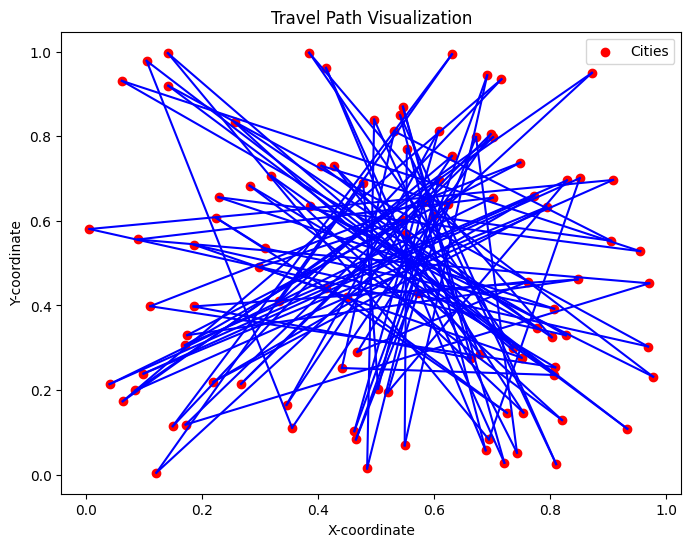

Random Data for Current Episode:
City Coordinates:
 tensor([[0.8937, 0.3578],
        [0.1445, 0.2850],
        [0.5248, 0.3119],
        [0.6214, 0.1424],
        [0.5871, 0.1485],
        [0.5427, 0.1648],
        [0.5613, 0.0214],
        [0.6511, 0.5699],
        [0.6879, 0.6808],
        [0.8137, 0.5287],
        [0.1795, 0.0616],
        [0.9747, 0.9219],
        [0.6020, 0.5800],
        [0.2274, 0.7969],
        [0.7156, 0.0679],
        [0.3903, 0.4345],
        [0.4729, 0.7964],
        [0.6372, 0.0685],
        [0.7281, 0.3835],
        [0.4324, 0.4193],
        [0.3925, 0.0276],
        [0.6019, 0.7992],
        [0.3343, 0.1520],
        [0.0028, 0.5269],
        [0.5938, 0.2577],
        [0.5643, 0.2311],
        [0.1106, 0.3486],
        [0.7188, 0.1712],
        [0.3748, 0.7174],
        [0.9386, 0.3809],
        [0.9240, 0.4616],
        [0.4900, 0.7423],
        [0.0681, 0.0788],
        [0.4701, 0.9134],
        [0.7316, 0.7136],
        [0.5781, 0.3701],
        [0.2

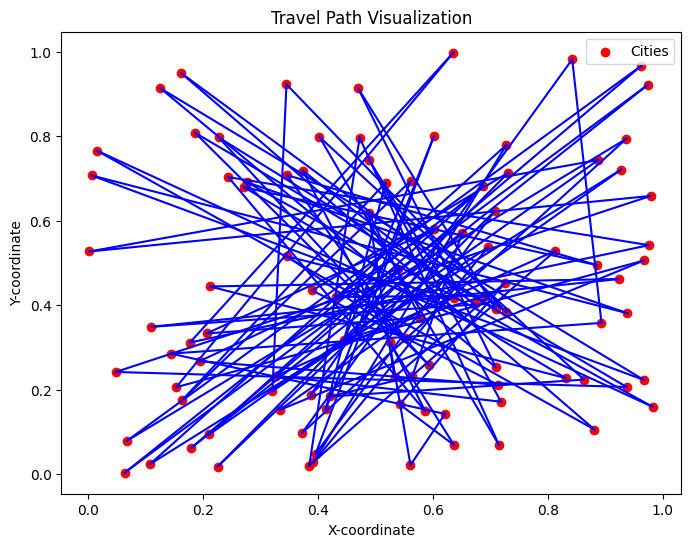

Random Data for Current Episode:
City Coordinates:
 tensor([[0.3349, 0.0055],
        [0.2566, 0.0918],
        [0.9184, 0.2314],
        [0.5092, 0.2155],
        [0.5470, 0.7274],
        [0.3259, 0.8560],
        [0.8921, 0.2329],
        [0.0966, 0.2101],
        [0.2693, 0.5481],
        [0.7914, 0.5104],
        [0.9404, 0.1551],
        [0.5708, 0.6871],
        [0.0084, 0.9039],
        [0.6381, 0.7248],
        [0.1244, 0.4793],
        [0.3378, 0.8577],
        [0.9539, 0.2096],
        [0.0362, 0.2424],
        [0.1079, 0.6984],
        [0.2969, 0.6250],
        [0.3391, 0.9243],
        [0.8749, 0.7993],
        [0.5605, 0.6443],
        [0.2107, 0.3458],
        [0.4931, 0.0513],
        [0.1072, 0.9278],
        [0.2403, 0.4713],
        [0.1705, 0.8232],
        [0.1613, 0.2567],
        [0.2069, 0.5541],
        [0.1316, 0.3682],
        [0.7540, 0.8425],
        [0.1748, 0.0266],
        [0.9130, 0.7642],
        [0.2260, 0.5773],
        [0.1065, 0.7282],
        [0.6

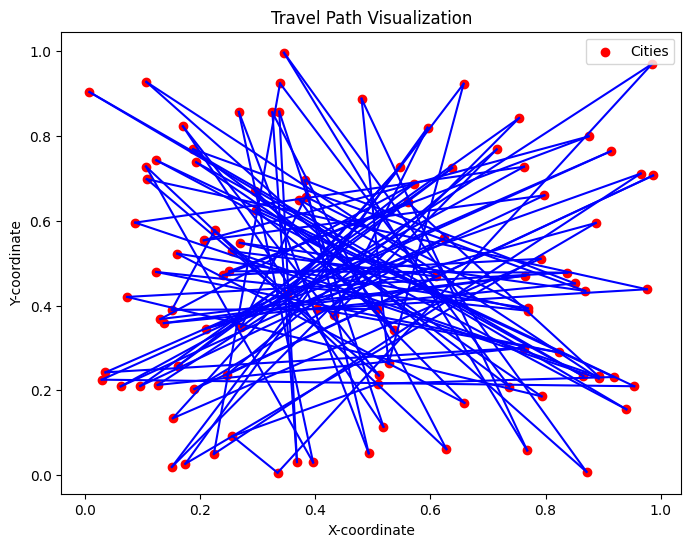

Random Data for Current Episode:
City Coordinates:
 tensor([[0.0078, 0.2178],
        [0.7260, 0.4271],
        [0.4026, 0.2349],
        [0.8126, 0.0765],
        [0.1524, 0.0787],
        [0.3015, 0.7925],
        [0.2271, 0.6942],
        [0.8249, 0.2282],
        [0.6988, 0.8121],
        [0.1558, 0.7117],
        [0.7972, 0.9453],
        [0.4168, 0.3072],
        [0.0829, 0.0047],
        [0.1205, 0.3857],
        [0.8380, 0.4370],
        [0.5803, 0.0082],
        [0.2932, 0.6514],
        [0.3902, 0.9274],
        [0.5905, 0.6098],
        [0.0396, 0.9611],
        [0.8690, 0.1283],
        [0.4107, 0.7889],
        [0.7180, 0.5794],
        [0.3003, 0.8030],
        [0.2065, 0.3527],
        [0.8834, 0.5855],
        [0.2799, 0.5028],
        [0.2502, 0.1206],
        [0.5296, 0.4549],
        [0.5140, 0.7122],
        [0.1544, 0.0719],
        [0.4577, 0.5175],
        [0.1656, 0.7296],
        [0.8080, 0.9994],
        [0.3559, 0.6016],
        [0.4370, 0.7316],
        [0.3

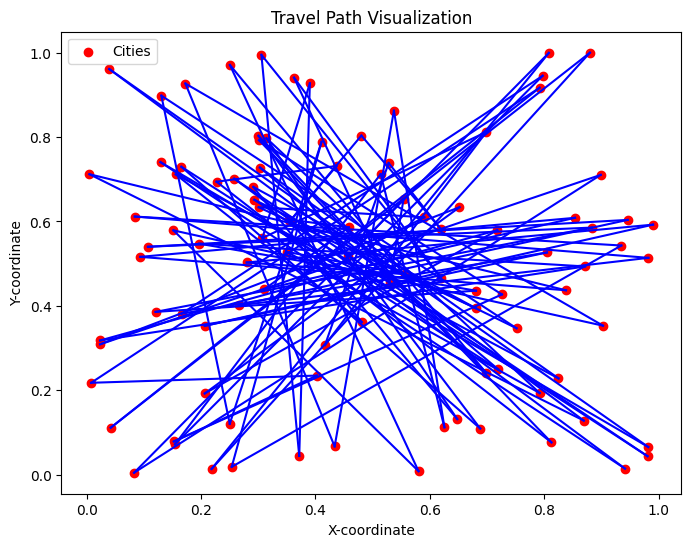

Random Data for Current Episode:
City Coordinates:
 tensor([[0.5578, 0.6405],
        [0.4094, 0.7631],
        [0.2492, 0.4717],
        [0.4316, 0.4412],
        [0.2986, 0.6968],
        [0.8359, 0.6999],
        [0.9724, 0.6578],
        [0.6448, 0.8120],
        [0.8256, 0.7535],
        [0.9605, 0.3443],
        [0.5919, 0.9278],
        [0.0914, 0.4719],
        [0.8199, 0.4308],
        [0.3053, 0.6782],
        [0.1002, 0.0994],
        [0.4525, 0.6684],
        [0.1800, 0.1439],
        [0.2500, 0.2592],
        [0.5621, 0.2904],
        [0.8022, 0.9475],
        [0.8156, 0.4771],
        [0.4656, 0.2772],
        [0.4671, 0.4048],
        [0.7978, 0.6532],
        [0.5594, 0.1560],
        [0.4248, 0.5628],
        [0.7185, 0.4569],
        [0.8822, 0.8023],
        [0.9796, 0.8383],
        [0.4820, 0.5086],
        [0.0245, 0.4307],
        [0.7065, 0.3830],
        [0.3292, 0.2572],
        [0.8375, 0.7208],
        [0.1430, 0.8169],
        [0.6380, 0.6791],
        [0.6

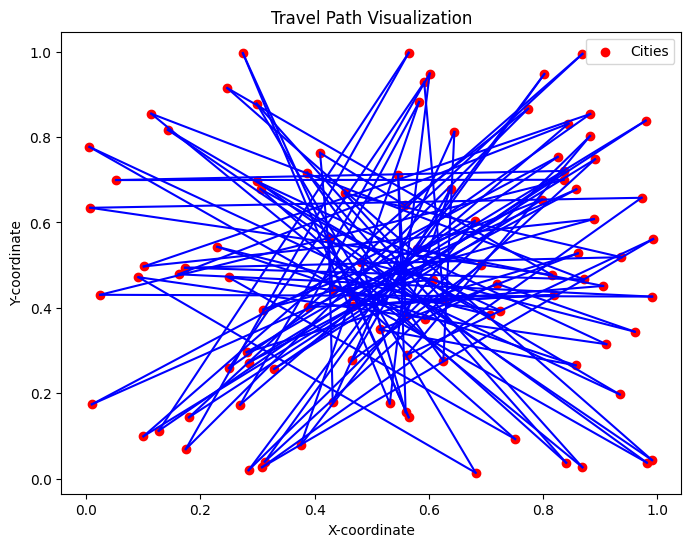

Testing completed.


In [9]:
def visualize_travel_path(city_coordinates, travel_path):
    x = city_coordinates[:, 0]
    y = city_coordinates[:, 1]

    plt.figure(figsize=(8, 6))
    plt.scatter(x, y, c='red', marker='o', label='Cities')

    # Convert travel_path to integers
    travel_path = [int(city) for city in travel_path]

    for i in range(len(travel_path) - 1):
        start_city = travel_path[i]
        end_city = travel_path[i + 1]
        plt.plot([x[start_city], x[end_city]], [y[start_city], y[end_city]], 'b-')

    # Connect the last and first city
    plt.plot([x[travel_path[-1]], x[travel_path[0]]], [y[travel_path[-1]], y[travel_path[0]]], 'b-')
    plt.title('Travel Path Visualization')
    plt.xlabel('X-coordinate')
    plt.ylabel('Y-coordinate')
    plt.legend()
    plt.show()

# ...

# After training
num_test_episodes = 5  # Adjust as needed

print("Testing...")

for episode in range(num_test_episodes):
    env.reset()
    travel_path, total_reward = generate_travel_path(model, env)

    print(f"Episode {episode + 1} - Travel Path: {travel_path}, Total Reward: {total_reward}")

    # Visualize the travel path
    visualize_travel_path(env.city_coordinates.numpy(), travel_path)

print("Testing completed.")


In [7]:
#pip install matplotlib

  Obtaining dependency information for matplotlib from https://files.pythonhosted.org/packages/26/5a/27fd341e4510257789f19a4b4be8bb90d1113b8f176c3dab562b4f21466e/matplotlib-3.8.2-cp311-cp311-win_amd64.whl.metadata
  Obtaining dependency information for contourpy>=1.0.1 from https://files.pythonhosted.org/packages/ca/2a/d197a412ec474391ee878b1218cf2fe9c6e963903755887fc5654c06636a/contourpy-1.2.0-cp311-cp311-win_amd64.whl.metadata
  Obtaining dependency information for cycler>=0.10 from https://files.pythonhosted.org/packages/e7/05/c19819d5e3d95294a6f5947fb9b9629efb316b96de511b418c53d245aae6/cycler-0.12.1-py3-none-any.whl.metadata
  Obtaining dependency information for fonttools>=4.22.0 from https://files.pythonhosted.org/packages/a8/a2/f139d051a5f605bffcab406bcfd3154e9f5e372c24ec0b74682141a58966/fonttools-4.45.0-cp311-cp311-win_amd64.whl.metadata
     ---------------------------------------- 0.0/158.1 kB ? eta -:--:--
     -------------------------------------- 158.1/158.1 kB 9.2 MB/s e


[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: C:\Users\민지영\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [8]:
import matplotlib.pyplot as plt